In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

import cv2
import numpy as np
import os

train_dir = "/content/drive/MyDrive/SRGANs"
def data_preprocess(data):

    for img in os.listdir( train_dir + "/" + data):
        img_array = cv2.imread(train_dir + "/" + data + "/" + img)

        img_array = cv2.resize(img_array, (128, 128))
        lr_img_array = cv2.resize(img_array,(32, 32))
        cv2.imwrite(train_dir + "/HR_images/" + img, img_array)
        cv2.imwrite(train_dir + "/LR_images/"+ img, lr_img_array)

data_preprocess( "DIV2K_train_HR")

"""
import cv2
import numpy as np
import os

train_dir = "/content/drive/MyDrive/SRGANs/train_img"
def data_preprocess(data):

    for img in os.listdir( train_dir + "/" + data):
        img_array = cv2.imread(train_dir + "/" + data + "/" + img)

        img_array = cv2.resize(img_array, (128, 128))
        lr_img_array = cv2.resize(img_array,(32, 32))
        cv2.imwrite(train_dir + "/HR_img/" + img, img_array)
        cv2.imwrite(train_dir + "/LR_img/"+ img, lr_img_array)

data_preprocess("DIV2K_valid_HR")
"""

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split
from tensorflow import keras
import numpy as np
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from keras.applications import VGG19
from tqdm import tqdm

In [ ]:
#Define blocks to build the generator
def res_block(ip):

    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)

    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)

    return add([ip,res_model])

def upscale_block(ip):

    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)

    return up_model

#Generator model
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)

#Descriminator block that will be used to construct the discriminator
def discriminator_block(ip, filters, strides=1, bn=True):

    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)

    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)

    disc_model = LeakyReLU( alpha=0.2 )(disc_model)

    return disc_model


#Descriminartor
def create_disc(disc_ip):

    df = 64

    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)

    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)


def build_vgg(hr_shape):

    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)

    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

#Combined model
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)

    gen_features = vgg(gen_img)

    disc_model.trainable = False
    validity = disc_model(gen_img)

    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

In [ ]:

lr_list = os.listdir("/content/drive/MyDrive/SRGANs/LR_images")

lr_images = []
for img in lr_list:
    img_lr = cv2.imread("/content/drive/MyDrive/SRGANs/LR_images/" + img)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    lr_images.append(img_lr)


hr_list = os.listdir("/content/drive/MyDrive/SRGANs/HR_images")

hr_images = []
for img in hr_list:
    img_hr = cv2.imread("/content/drive/MyDrive/SRGANs/HR_images/" + img)
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    hr_images.append(img_hr)

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

#Scale values
lr_images = lr_images / 255.0
hr_images = hr_images / 255.0

lr_train = lr_images
hr_train = hr_images

hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

generator = create_gen(lr_ip, num_res_block = 16)

discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

vgg = build_vgg((128,128,3))
vgg.trainable = False

gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)

gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer=keras.optimizers.Adam(learning_rate=0.001))

batch_size = 10
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])


80134624/80134624 [==============================] - 4s 0us/step


In [ ]:
#Enumerate training over epochs
epochs = 220
gan_loss = []
discr_loss = []
ep = []
for e in range(epochs):

    fake_label = np.zeros((batch_size, 1))
    real_label = np.ones((batch_size,1))


    g_losses = []
    d_losses = []

    #Enumerate training over batches.
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b]
        hr_imgs = train_hr_batches[b]

        fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images

        #First, train the discriminator on fake and real HR images.
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)

        #train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False

        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real)
        image_features = vgg.predict(hr_imgs)

        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])

        d_losses.append(d_loss)
        g_losses.append(g_loss)

    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)

    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    gan_loss.append(g_loss)
    discr_loss.append(d_loss)
    ep.append(e)
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)
    generator.save("/content/drive/MyDrive/SRGANs/gane200l099.h5")

  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 1s 835ms/step


  1%|▏         | 1/80 [00:52<1:09:29, 52.78s/it]

1/1 [==============================] - 0s 21ms/step


  2%|▎         | 2/80 [00:53<28:40, 22.06s/it]  

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/80 [00:53<15:39, 12.20s/it]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 4/80 [00:54<09:34,  7.56s/it]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/80 [00:54<06:15,  5.01s/it]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 6/80 [00:55<04:16,  3.46s/it]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/80 [00:55<03:00,  2.48s/it]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 8/80 [00:56<02:11,  1.83s/it]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 9/80 [00:56<01:39,  1.40s/it]

1/1 [==============================] - 0s 20ms/step


 12%|█▎        | 10/80 [00:56<01:17,  1.11s/it]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 11/80 [00:57<01:02,  1.10it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 12/80 [00:57<00:52,  1.30it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 13/80 [00:58<00:45,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 14/80 [00:58<00:40,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/80 [00:59<00:36,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 16/80 [00:59<00:34,  1.83it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██▏       | 17/80 [01:00<00:34,  1.81it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▎       | 18/80 [01:01<00:36,  1.71it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 19/80 [01:01<00:36,  1.69it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 20/80 [01:02<00:33,  1.76it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▋       | 21/80 [01:02<00:34,  1.73it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 22/80 [01:03<00:32,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/80 [01:03<00:30,  1.86it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 24/80 [01:04<00:29,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 25/80 [01:04<00:27,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▎      | 26/80 [01:05<00:26,  2.04it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 27/80 [01:05<00:25,  2.08it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 28/80 [01:06<00:24,  2.10it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 29/80 [01:06<00:23,  2.14it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/80 [01:06<00:23,  2.17it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 31/80 [01:07<00:22,  2.15it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 32/80 [01:07<00:23,  2.05it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████▏     | 33/80 [01:08<00:22,  2.11it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▎     | 34/80 [01:08<00:21,  2.13it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 35/80 [01:09<00:21,  2.12it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 36/80 [01:09<00:20,  2.12it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 37/80 [01:10<00:20,  2.10it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 38/80 [01:10<00:19,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 39/80 [01:11<00:19,  2.08it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 40/80 [01:11<00:18,  2.12it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 41/80 [01:12<00:18,  2.13it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▎    | 42/80 [01:12<00:17,  2.11it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 43/80 [01:13<00:18,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 44/80 [01:13<00:18,  1.93it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▋    | 45/80 [01:14<00:19,  1.80it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▊    | 46/80 [01:14<00:18,  1.81it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 47/80 [01:15<00:18,  1.76it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 48/80 [01:16<00:17,  1.82it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████▏   | 49/80 [01:16<00:16,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▎   | 50/80 [01:17<00:15,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 51/80 [01:17<00:14,  2.03it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 52/80 [01:17<00:13,  2.05it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 53/80 [01:18<00:12,  2.09it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 54/80 [01:18<00:12,  2.09it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 55/80 [01:19<00:11,  2.11it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 56/80 [01:19<00:11,  2.11it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████▏  | 57/80 [01:20<00:10,  2.12it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▎  | 58/80 [01:20<00:10,  2.14it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 59/80 [01:21<00:09,  2.15it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 60/80 [01:21<00:09,  2.14it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 61/80 [01:22<00:08,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 62/80 [01:22<00:08,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 63/80 [01:23<00:08,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 64/80 [01:23<00:07,  2.13it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 65/80 [01:24<00:07,  2.13it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▎ | 66/80 [01:24<00:06,  2.14it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 67/80 [01:25<00:06,  2.12it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 68/80 [01:25<00:05,  2.13it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 69/80 [01:25<00:05,  2.13it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 70/80 [01:26<00:04,  2.08it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 71/80 [01:27<00:04,  1.92it/s]

1/1 [==============================] - 0s 29ms/step


 90%|█████████ | 72/80 [01:27<00:04,  1.81it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████▏| 73/80 [01:28<00:03,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▎| 74/80 [01:28<00:03,  1.73it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 75/80 [01:29<00:02,  1.77it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 76/80 [01:29<00:02,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 77/80 [01:30<00:01,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 78/80 [01:30<00:01,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 79/80 [01:31<00:00,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 80/80 [01:31<00:00,  1.15s/it]


epoch: 1 g_loss: 138.0308773994446 d_loss: [3.17473998 0.85625   ]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/80 [00:00<00:35,  2.20it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▎         | 2/80 [00:00<00:36,  2.11it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/80 [00:01<00:35,  2.15it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 4/80 [00:01<00:35,  2.15it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 5/80 [00:02<00:34,  2.16it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/80 [00:02<00:34,  2.12it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/80 [00:03<00:34,  2.14it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/80 [00:03<00:33,  2.15it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 9/80 [00:04<00:32,  2.16it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▎        | 10/80 [00:04<00:32,  2.16it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/80 [00:05<00:31,  2.17it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 12/80 [00:05<00:31,  2.16it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▋        | 13/80 [00:06<00:31,  2.16it/s]

1/1 [==============================] - 0s 39ms/step


 18%|█▊        | 14/80 [00:06<00:34,  1.93it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 15/80 [00:07<00:35,  1.84it/s]

1/1 [==============================] - 0s 29ms/step


 20%|██        | 16/80 [00:07<00:34,  1.83it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██▏       | 17/80 [00:08<00:35,  1.76it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▎       | 18/80 [00:09<00:37,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/80 [00:09<00:34,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 20/80 [00:10<00:32,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▋       | 21/80 [00:10<00:30,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/80 [00:11<00:29,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 23/80 [00:11<00:28,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 24/80 [00:11<00:27,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 25/80 [00:12<00:26,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▎      | 26/80 [00:12<00:25,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 27/80 [00:13<00:25,  2.08it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 28/80 [00:13<00:24,  2.09it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 29/80 [00:14<00:24,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 30/80 [00:14<00:23,  2.09it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 31/80 [00:15<00:23,  2.07it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 32/80 [00:15<00:22,  2.09it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████▏     | 33/80 [00:16<00:22,  2.04it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▎     | 34/80 [00:16<00:22,  2.08it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 35/80 [00:17<00:21,  2.07it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 36/80 [00:17<00:21,  2.10it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 37/80 [00:18<00:20,  2.11it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 38/80 [00:18<00:20,  2.10it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 39/80 [00:19<00:20,  1.98it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████     | 40/80 [00:19<00:20,  1.91it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████▏    | 41/80 [00:20<00:21,  1.79it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▎    | 42/80 [00:21<00:22,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 43/80 [00:21<00:21,  1.72it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 44/80 [00:22<00:21,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 45/80 [00:22<00:19,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▊    | 46/80 [00:23<00:17,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 47/80 [00:23<00:16,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 48/80 [00:24<00:16,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 49/80 [00:24<00:15,  2.02it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▎   | 50/80 [00:25<00:14,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 51/80 [00:25<00:14,  2.07it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 52/80 [00:26<00:13,  2.10it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▋   | 53/80 [00:26<00:13,  2.07it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 54/80 [00:27<00:12,  2.09it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 55/80 [00:27<00:11,  2.10it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 56/80 [00:27<00:11,  2.11it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 57/80 [00:28<00:10,  2.10it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▎  | 58/80 [00:28<00:10,  2.11it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 59/80 [00:29<00:09,  2.12it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 60/80 [00:29<00:09,  2.12it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▋  | 61/80 [00:30<00:09,  2.08it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 62/80 [00:30<00:08,  2.10it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 63/80 [00:31<00:08,  2.11it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 64/80 [00:31<00:07,  2.10it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 65/80 [00:32<00:07,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▎ | 66/80 [00:32<00:07,  1.84it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 67/80 [00:33<00:07,  1.76it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 68/80 [00:34<00:06,  1.75it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▋ | 69/80 [00:34<00:06,  1.78it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 70/80 [00:35<00:05,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 71/80 [00:35<00:04,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 72/80 [00:36<00:04,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 73/80 [00:36<00:03,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▎| 74/80 [00:37<00:02,  2.02it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 75/80 [00:37<00:02,  2.03it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 76/80 [00:38<00:01,  2.07it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 77/80 [00:38<00:01,  2.06it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 78/80 [00:39<00:00,  2.06it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 79/80 [00:39<00:00,  2.07it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 80/80 [00:40<00:00,  2.00it/s]


epoch: 2 g_loss: 76.52819190025329 d_loss: [0.29768272 0.98125   ]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


  1%|▏         | 1/80 [00:00<00:37,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▎         | 2/80 [00:00<00:37,  2.10it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 3/80 [00:01<00:36,  2.11it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/80 [00:01<00:35,  2.12it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 5/80 [00:02<00:35,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 6/80 [00:02<00:35,  2.07it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/80 [00:03<00:35,  2.08it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 8/80 [00:03<00:35,  2.05it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 9/80 [00:04<00:36,  1.95it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▎        | 10/80 [00:04<00:36,  1.91it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 11/80 [00:05<00:37,  1.84it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 12/80 [00:06<00:37,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▋        | 13/80 [00:06<00:37,  1.80it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 14/80 [00:07<00:37,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/80 [00:07<00:35,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 16/80 [00:08<00:33,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 17/80 [00:08<00:32,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▎       | 18/80 [00:09<00:31,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 19/80 [00:09<00:30,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 20/80 [00:10<00:30,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 21/80 [00:10<00:29,  2.03it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/80 [00:11<00:28,  2.06it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 23/80 [00:11<00:27,  2.07it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 24/80 [00:12<00:26,  2.09it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███▏      | 25/80 [00:12<00:26,  2.10it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▎      | 26/80 [00:13<00:25,  2.11it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 27/80 [00:13<00:25,  2.12it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 28/80 [00:13<00:24,  2.12it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 29/80 [00:14<00:24,  2.10it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/80 [00:14<00:23,  2.10it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 31/80 [00:15<00:23,  2.12it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 32/80 [00:15<00:22,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 33/80 [00:16<00:23,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▎     | 34/80 [00:16<00:22,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 35/80 [00:17<00:22,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 36/80 [00:18<00:23,  1.89it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▋     | 37/80 [00:18<00:23,  1.81it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 38/80 [00:19<00:23,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 39/80 [00:19<00:23,  1.75it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████     | 40/80 [00:20<00:23,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 41/80 [00:20<00:21,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▎    | 42/80 [00:21<00:20,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 43/80 [00:21<00:19,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 44/80 [00:22<00:18,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 45/80 [00:22<00:17,  2.03it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▊    | 46/80 [00:23<00:16,  2.05it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 47/80 [00:23<00:16,  2.04it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 48/80 [00:24<00:15,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 49/80 [00:24<00:15,  2.06it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▎   | 50/80 [00:25<00:14,  2.06it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 51/80 [00:25<00:14,  2.07it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 52/80 [00:26<00:13,  2.05it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 53/80 [00:26<00:13,  2.05it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 54/80 [00:27<00:12,  2.05it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 55/80 [00:27<00:12,  2.08it/s]

1/1 [==============================] - 0s 24ms/step


 70%|███████   | 56/80 [00:28<00:11,  2.10it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 57/80 [00:28<00:10,  2.12it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▎  | 58/80 [00:29<00:10,  2.12it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 59/80 [00:29<00:09,  2.11it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 60/80 [00:30<00:09,  2.09it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 61/80 [00:30<00:09,  2.10it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 62/80 [00:31<00:09,  1.94it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 63/80 [00:31<00:09,  1.87it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 64/80 [00:32<00:08,  1.88it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████▏ | 65/80 [00:32<00:08,  1.87it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▎ | 66/80 [00:33<00:07,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 67/80 [00:33<00:07,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 68/80 [00:34<00:06,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 69/80 [00:34<00:05,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 70/80 [00:35<00:05,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 71/80 [00:35<00:04,  2.02it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 72/80 [00:36<00:03,  2.01it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 73/80 [00:36<00:03,  2.01it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▎| 74/80 [00:37<00:02,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 75/80 [00:37<00:02,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 76/80 [00:38<00:01,  2.05it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 77/80 [00:38<00:01,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 78/80 [00:39<00:00,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 79/80 [00:39<00:00,  2.04it/s]

1/1 [==============================] - 0s 24ms/step


100%|██████████| 80/80 [00:40<00:00,  1.99it/s]


epoch: 3 g_loss: 64.68518295288087 d_loss: [0.29549747 0.98      ]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/80 [00:00<00:38,  2.05it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▎         | 2/80 [00:00<00:37,  2.10it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/80 [00:01<00:36,  2.12it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 4/80 [00:01<00:35,  2.13it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 5/80 [00:02<00:37,  2.00it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 6/80 [00:03<00:40,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 7/80 [00:03<00:42,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 8/80 [00:04<00:41,  1.72it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█▏        | 9/80 [00:04<00:41,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▎        | 10/80 [00:05<00:41,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/80 [00:05<00:38,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 12/80 [00:06<00:36,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 13/80 [00:06<00:34,  1.96it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 14/80 [00:07<00:33,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 15/80 [00:07<00:32,  2.03it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 16/80 [00:08<00:31,  2.02it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 17/80 [00:08<00:30,  2.05it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▎       | 18/80 [00:09<00:29,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 19/80 [00:09<00:29,  2.07it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 20/80 [00:10<00:28,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 21/80 [00:10<00:28,  2.09it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/80 [00:11<00:27,  2.08it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/80 [00:11<00:27,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 24/80 [00:12<00:26,  2.09it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 25/80 [00:12<00:26,  2.07it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▎      | 26/80 [00:13<00:25,  2.09it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 27/80 [00:13<00:25,  2.10it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 28/80 [00:14<00:24,  2.11it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 29/80 [00:14<00:24,  2.11it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/80 [00:15<00:23,  2.11it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 31/80 [00:15<00:24,  1.99it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 32/80 [00:16<00:26,  1.84it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████▏     | 33/80 [00:16<00:25,  1.83it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▎     | 34/80 [00:17<00:26,  1.76it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 35/80 [00:17<00:25,  1.75it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 36/80 [00:18<00:24,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 37/80 [00:19<00:23,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 38/80 [00:19<00:21,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 39/80 [00:19<00:20,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 40/80 [00:20<00:19,  2.03it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 41/80 [00:20<00:18,  2.06it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▎    | 42/80 [00:21<00:18,  2.04it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 43/80 [00:21<00:17,  2.07it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 44/80 [00:22<00:17,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 45/80 [00:22<00:17,  2.06it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▊    | 46/80 [00:23<00:16,  2.08it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 47/80 [00:23<00:15,  2.07it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 48/80 [00:24<00:15,  2.10it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 49/80 [00:24<00:14,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▎   | 50/80 [00:25<00:14,  2.10it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 51/80 [00:25<00:14,  2.07it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 52/80 [00:26<00:13,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 53/80 [00:26<00:12,  2.10it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 54/80 [00:27<00:12,  2.11it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 55/80 [00:27<00:11,  2.12it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 56/80 [00:28<00:11,  2.11it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████▏  | 57/80 [00:28<00:10,  2.11it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▎  | 58/80 [00:29<00:11,  1.97it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 59/80 [00:29<00:10,  1.93it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▌  | 60/80 [00:30<00:10,  1.90it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▋  | 61/80 [00:30<00:10,  1.88it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 62/80 [00:31<00:09,  1.82it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 63/80 [00:31<00:09,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 64/80 [00:32<00:08,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 65/80 [00:32<00:07,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▎ | 66/80 [00:33<00:07,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 67/80 [00:33<00:06,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 68/80 [00:34<00:06,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 69/80 [00:34<00:05,  2.01it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 70/80 [00:35<00:04,  2.03it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 71/80 [00:35<00:04,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 72/80 [00:36<00:03,  2.03it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 73/80 [00:36<00:03,  2.05it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▎| 74/80 [00:37<00:02,  2.03it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 75/80 [00:37<00:02,  2.06it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 76/80 [00:38<00:02,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 77/80 [00:38<00:01,  2.03it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 78/80 [00:39<00:00,  2.05it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 79/80 [00:39<00:00,  2.08it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 80/80 [00:40<00:00,  1.99it/s]


epoch: 4 g_loss: 58.389884090423585 d_loss: [1.07669758 0.94375   ]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/80 [00:00<00:36,  2.16it/s]

1/1 [==============================] - 0s 44ms/step


  2%|▎         | 2/80 [00:01<00:44,  1.75it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 3/80 [00:01<00:44,  1.71it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 4/80 [00:02<00:43,  1.74it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▋         | 5/80 [00:02<00:42,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 6/80 [00:03<00:43,  1.68it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 7/80 [00:03<00:41,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 8/80 [00:04<00:38,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█▏        | 9/80 [00:04<00:37,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▎        | 10/80 [00:05<00:36,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 11/80 [00:05<00:35,  1.97it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/80 [00:06<00:34,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 13/80 [00:06<00:33,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/80 [00:07<00:33,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/80 [00:07<00:32,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 16/80 [00:08<00:31,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██▏       | 17/80 [00:08<00:30,  2.04it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▎       | 18/80 [00:09<00:30,  2.07it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 19/80 [00:09<00:30,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 20/80 [00:10<00:29,  2.01it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 21/80 [00:10<00:29,  2.03it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 22/80 [00:11<00:28,  2.06it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 23/80 [00:11<00:27,  2.07it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 24/80 [00:12<00:27,  2.05it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 25/80 [00:12<00:26,  2.04it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▎      | 26/80 [00:13<00:26,  2.05it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 27/80 [00:13<00:25,  2.08it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▌      | 28/80 [00:14<00:27,  1.88it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▋      | 29/80 [00:14<00:27,  1.85it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 30/80 [00:15<00:27,  1.84it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 31/80 [00:16<00:28,  1.75it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 32/80 [00:16<00:26,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 33/80 [00:17<00:25,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▎     | 34/80 [00:17<00:23,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 35/80 [00:18<00:23,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 36/80 [00:18<00:22,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 37/80 [00:19<00:21,  2.01it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 38/80 [00:19<00:20,  2.03it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 39/80 [00:20<00:19,  2.06it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 40/80 [00:20<00:19,  2.05it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 41/80 [00:21<00:19,  2.04it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▎    | 42/80 [00:21<00:18,  2.05it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 43/80 [00:22<00:18,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 44/80 [00:22<00:17,  2.06it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 45/80 [00:23<00:16,  2.07it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▊    | 46/80 [00:23<00:16,  2.04it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 47/80 [00:23<00:16,  2.06it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 48/80 [00:24<00:15,  2.06it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 49/80 [00:24<00:14,  2.08it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▎   | 50/80 [00:25<00:14,  2.08it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 51/80 [00:25<00:14,  2.05it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 52/80 [00:26<00:13,  2.07it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 53/80 [00:26<00:13,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 54/80 [00:27<00:13,  1.94it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 55/80 [00:28<00:13,  1.87it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 56/80 [00:28<00:12,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████▏  | 57/80 [00:29<00:12,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▎  | 58/80 [00:29<00:12,  1.69it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 59/80 [00:30<00:11,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 60/80 [00:30<00:10,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▋  | 61/80 [00:31<00:09,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 62/80 [00:31<00:09,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 63/80 [00:32<00:08,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 64/80 [00:32<00:08,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 65/80 [00:33<00:07,  2.03it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▎ | 66/80 [00:33<00:06,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 67/80 [00:34<00:06,  2.07it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 68/80 [00:34<00:05,  2.07it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 69/80 [00:35<00:05,  2.08it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 70/80 [00:35<00:04,  2.02it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 71/80 [00:36<00:04,  2.02it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 72/80 [00:36<00:03,  2.05it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 73/80 [00:37<00:03,  2.07it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▎| 74/80 [00:37<00:02,  2.05it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 75/80 [00:38<00:02,  2.07it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 76/80 [00:38<00:01,  2.06it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 77/80 [00:39<00:01,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 78/80 [00:39<00:00,  2.04it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 79/80 [00:40<00:00,  2.05it/s]

1/1 [==============================] - 0s 27ms/step


100%|██████████| 80/80 [00:40<00:00,  1.97it/s]


epoch: 5 g_loss: 54.01308379173279 d_loss: [0.05910214 0.9925    ]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step


  1%|▏         | 1/80 [00:00<00:51,  1.53it/s]

1/1 [==============================] - 0s 41ms/step


  2%|▎         | 2/80 [00:01<00:47,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/80 [00:01<00:41,  1.84it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 4/80 [00:02<00:41,  1.85it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/80 [00:02<00:38,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/80 [00:03<00:37,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/80 [00:03<00:36,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/80 [00:04<00:35,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 9/80 [00:04<00:34,  2.07it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▎        | 10/80 [00:05<00:34,  2.03it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/80 [00:05<00:33,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 12/80 [00:06<00:33,  2.01it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 13/80 [00:06<00:32,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 14/80 [00:07<00:32,  2.05it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 15/80 [00:07<00:31,  2.08it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 16/80 [00:08<00:30,  2.10it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 17/80 [00:08<00:30,  2.07it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▎       | 18/80 [00:08<00:29,  2.09it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/80 [00:09<00:28,  2.11it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 20/80 [00:09<00:29,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 21/80 [00:10<00:29,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 22/80 [00:10<00:28,  2.05it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 23/80 [00:11<00:30,  1.87it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███       | 24/80 [00:12<00:29,  1.90it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███▏      | 25/80 [00:12<00:29,  1.89it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▎      | 26/80 [00:13<00:29,  1.82it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 27/80 [00:13<00:29,  1.81it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 28/80 [00:14<00:28,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 29/80 [00:14<00:26,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 30/80 [00:15<00:26,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 31/80 [00:15<00:25,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 32/80 [00:16<00:23,  2.00it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 33/80 [00:16<00:23,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▎     | 34/80 [00:17<00:22,  2.06it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 35/80 [00:17<00:21,  2.05it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 36/80 [00:18<00:21,  2.07it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 37/80 [00:18<00:20,  2.06it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 38/80 [00:19<00:20,  2.08it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 39/80 [00:19<00:19,  2.08it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 40/80 [00:20<00:19,  2.10it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 41/80 [00:20<00:18,  2.07it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▎    | 42/80 [00:21<00:19,  2.00it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 43/80 [00:21<00:18,  2.02it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 44/80 [00:22<00:17,  2.05it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 45/80 [00:22<00:16,  2.07it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▊    | 46/80 [00:23<00:16,  2.08it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 47/80 [00:23<00:15,  2.09it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 48/80 [00:24<00:15,  2.06it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 49/80 [00:24<00:15,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▎   | 50/80 [00:25<00:16,  1.83it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 51/80 [00:25<00:15,  1.83it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▌   | 52/80 [00:26<00:16,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▋   | 53/80 [00:27<00:16,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 54/80 [00:27<00:15,  1.70it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 55/80 [00:28<00:13,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 56/80 [00:28<00:12,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 57/80 [00:29<00:11,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▎  | 58/80 [00:29<00:11,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 59/80 [00:30<00:10,  2.01it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 60/80 [00:30<00:10,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▋  | 61/80 [00:31<00:09,  2.02it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 62/80 [00:31<00:08,  2.03it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 63/80 [00:31<00:08,  2.05it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 64/80 [00:32<00:07,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 65/80 [00:33<00:07,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▎ | 66/80 [00:33<00:07,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 67/80 [00:33<00:06,  2.00it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 68/80 [00:34<00:05,  2.03it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▋ | 69/80 [00:34<00:05,  2.04it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 70/80 [00:35<00:04,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 71/80 [00:35<00:04,  2.05it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 72/80 [00:36<00:03,  2.07it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 73/80 [00:36<00:03,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▎| 74/80 [00:37<00:03,  1.94it/s]

1/1 [==============================] - 0s 50ms/step


 94%|█████████▍| 75/80 [00:38<00:02,  1.87it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 76/80 [00:38<00:02,  1.88it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▋| 77/80 [00:39<00:01,  1.86it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 78/80 [00:39<00:01,  1.84it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 79/80 [00:40<00:00,  1.71it/s]

1/1 [==============================] - 0s 28ms/step


100%|██████████| 80/80 [00:40<00:00,  1.96it/s]


epoch: 6 g_loss: 51.41097402572632 d_loss: [0.16532731 0.979375  ]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/80 [00:00<00:36,  2.14it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▎         | 2/80 [00:00<00:37,  2.06it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/80 [00:01<00:37,  2.07it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 4/80 [00:01<00:36,  2.08it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▋         | 5/80 [00:02<00:36,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 6/80 [00:02<00:36,  2.01it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 7/80 [00:03<00:35,  2.04it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/80 [00:03<00:35,  2.05it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 9/80 [00:04<00:34,  2.06it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▎        | 10/80 [00:04<00:33,  2.06it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 11/80 [00:05<00:34,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 12/80 [00:05<00:33,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 13/80 [00:06<00:32,  2.04it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 14/80 [00:06<00:32,  2.00it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 15/80 [00:07<00:32,  2.01it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 16/80 [00:07<00:31,  2.01it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██▏       | 17/80 [00:08<00:31,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▎       | 18/80 [00:09<00:33,  1.84it/s]

1/1 [==============================] - 0s 79ms/step


 24%|██▍       | 19/80 [00:09<00:39,  1.53it/s]

1/1 [==============================] - 0s 121ms/step


 25%|██▌       | 20/80 [00:10<00:43,  1.39it/s]

1/1 [==============================] - 0s 113ms/step


 26%|██▋       | 21/80 [00:11<00:50,  1.17it/s]

1/1 [==============================] - 0s 93ms/step


 28%|██▊       | 22/80 [00:12<00:49,  1.16it/s]

1/1 [==============================] - 0s 68ms/step


 29%|██▉       | 23/80 [00:13<00:47,  1.20it/s]

1/1 [==============================] - 0s 41ms/step


 30%|███       | 24/80 [00:14<00:43,  1.29it/s]

1/1 [==============================] - 0s 59ms/step


 31%|███▏      | 25/80 [00:15<00:42,  1.29it/s]

1/1 [==============================] - 0s 50ms/step


 32%|███▎      | 26/80 [00:15<00:41,  1.29it/s]

1/1 [==============================] - 0s 74ms/step


 34%|███▍      | 27/80 [00:16<00:41,  1.29it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▌      | 28/80 [00:17<00:39,  1.32it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 29/80 [00:17<00:34,  1.46it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 30/80 [00:18<00:31,  1.60it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 31/80 [00:18<00:28,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 32/80 [00:19<00:26,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████▏     | 33/80 [00:19<00:24,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▎     | 34/80 [00:20<00:24,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 35/80 [00:20<00:22,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 36/80 [00:21<00:21,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 37/80 [00:21<00:21,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 38/80 [00:22<00:20,  2.03it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 39/80 [00:22<00:20,  2.03it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 40/80 [00:23<00:20,  1.99it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████▏    | 41/80 [00:23<00:20,  1.88it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▎    | 42/80 [00:24<00:20,  1.85it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████▍    | 43/80 [00:24<00:20,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 44/80 [00:25<00:20,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▋    | 45/80 [00:26<00:19,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▊    | 46/80 [00:26<00:18,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 47/80 [00:27<00:17,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 48/80 [00:27<00:16,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 49/80 [00:28<00:15,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▎   | 50/80 [00:28<00:15,  2.00it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▍   | 51/80 [00:28<00:14,  2.02it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 52/80 [00:29<00:14,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 53/80 [00:30<00:13,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 54/80 [00:30<00:13,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 55/80 [00:31<00:13,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 56/80 [00:31<00:12,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 57/80 [00:32<00:11,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▎  | 58/80 [00:32<00:11,  1.99it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 59/80 [00:33<00:10,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 60/80 [00:33<00:09,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 61/80 [00:34<00:09,  2.01it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 62/80 [00:34<00:08,  2.05it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 63/80 [00:35<00:08,  2.06it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 64/80 [00:35<00:07,  2.07it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 65/80 [00:35<00:07,  2.06it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▎ | 66/80 [00:36<00:07,  1.88it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 67/80 [00:37<00:07,  1.83it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▌ | 68/80 [00:37<00:06,  1.82it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▋ | 69/80 [00:38<00:06,  1.72it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 70/80 [00:39<00:06,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 71/80 [00:39<00:05,  1.73it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 72/80 [00:40<00:04,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 73/80 [00:40<00:03,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▎| 74/80 [00:41<00:03,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 75/80 [00:41<00:02,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 76/80 [00:42<00:02,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 77/80 [00:42<00:01,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 78/80 [00:43<00:01,  1.98it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 79/80 [00:43<00:00,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 80/80 [00:44<00:00,  1.82it/s]


epoch: 7 g_loss: 49.248275184631346 d_loss: [0.06004707 0.9925    ]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/80 [00:00<00:40,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▎         | 2/80 [00:01<00:39,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 3/80 [00:01<00:38,  2.00it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 4/80 [00:01<00:37,  2.04it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 5/80 [00:02<00:36,  2.06it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 6/80 [00:02<00:36,  2.04it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/80 [00:03<00:36,  2.01it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/80 [00:03<00:35,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█▏        | 9/80 [00:04<00:36,  1.96it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▎        | 10/80 [00:05<00:38,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 11/80 [00:05<00:37,  1.85it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 12/80 [00:06<00:39,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▋        | 13/80 [00:06<00:39,  1.69it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 14/80 [00:07<00:38,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/80 [00:07<00:35,  1.83it/s]

1/1 [==============================] - 0s 25ms/step


 20%|██        | 16/80 [00:08<00:34,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██▏       | 17/80 [00:08<00:32,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▎       | 18/80 [00:09<00:31,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/80 [00:09<00:30,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 20/80 [00:10<00:29,  2.02it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 21/80 [00:10<00:29,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/80 [00:11<00:28,  2.03it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/80 [00:11<00:27,  2.05it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 24/80 [00:12<00:28,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 25/80 [00:12<00:27,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▎      | 26/80 [00:13<00:27,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 27/80 [00:13<00:26,  2.02it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 28/80 [00:14<00:25,  2.01it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 29/80 [00:14<00:25,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 30/80 [00:15<00:24,  2.06it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 31/80 [00:15<00:23,  2.07it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 32/80 [00:16<00:23,  2.08it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████▏     | 33/80 [00:16<00:22,  2.08it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▎     | 34/80 [00:17<00:22,  2.08it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 35/80 [00:17<00:23,  1.94it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▌     | 36/80 [00:18<00:24,  1.81it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▋     | 37/80 [00:19<00:24,  1.76it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 38/80 [00:19<00:24,  1.68it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 39/80 [00:20<00:24,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 40/80 [00:20<00:22,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 41/80 [00:21<00:22,  1.76it/s]

1/1 [==============================] - 0s 44ms/step


 52%|█████▎    | 42/80 [00:22<00:22,  1.67it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 43/80 [00:22<00:20,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 44/80 [00:23<00:20,  1.77it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▋    | 45/80 [00:23<00:19,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▊    | 46/80 [00:24<00:17,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 47/80 [00:24<00:16,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 48/80 [00:25<00:16,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████▏   | 49/80 [00:25<00:15,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▎   | 50/80 [00:26<00:15,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 51/80 [00:26<00:14,  2.03it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▌   | 52/80 [00:27<00:13,  2.05it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 53/80 [00:27<00:13,  2.07it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 54/80 [00:27<00:12,  2.08it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 55/80 [00:28<00:12,  2.06it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 56/80 [00:28<00:11,  2.04it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 57/80 [00:29<00:11,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▎  | 58/80 [00:30<00:10,  2.01it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 59/80 [00:30<00:10,  1.96it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 60/80 [00:31<00:11,  1.82it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▋  | 61/80 [00:31<00:10,  1.75it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 62/80 [00:32<00:10,  1.70it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 63/80 [00:32<00:09,  1.74it/s]

1/1 [==============================] - 0s 33ms/step


 80%|████████  | 64/80 [00:33<00:09,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 65/80 [00:34<00:08,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▎ | 66/80 [00:34<00:07,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 67/80 [00:35<00:06,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 68/80 [00:35<00:06,  1.94it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▋ | 69/80 [00:36<00:05,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 70/80 [00:36<00:04,  2.02it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 71/80 [00:36<00:04,  2.04it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 72/80 [00:37<00:03,  2.06it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 73/80 [00:37<00:03,  2.07it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▎| 74/80 [00:38<00:02,  2.07it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 75/80 [00:38<00:02,  2.06it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 76/80 [00:39<00:01,  2.07it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 77/80 [00:39<00:01,  2.08it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 78/80 [00:40<00:00,  2.08it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 79/80 [00:40<00:00,  2.08it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 80/80 [00:41<00:00,  1.94it/s]


epoch: 8 g_loss: 47.57094306945801 d_loss: [0.03260651 0.996875  ]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/80 [00:00<00:39,  2.01it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▎         | 2/80 [00:00<00:37,  2.05it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/80 [00:01<00:38,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 4/80 [00:02<00:41,  1.84it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▋         | 5/80 [00:02<00:43,  1.74it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 6/80 [00:03<00:43,  1.68it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 7/80 [00:03<00:43,  1.68it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 8/80 [00:04<00:42,  1.70it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 9/80 [00:05<00:39,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▎        | 10/80 [00:05<00:37,  1.87it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 11/80 [00:05<00:35,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/80 [00:06<00:34,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 13/80 [00:06<00:33,  2.01it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 14/80 [00:07<00:32,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 15/80 [00:07<00:31,  2.06it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 16/80 [00:08<00:31,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██▏       | 17/80 [00:08<00:30,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▎       | 18/80 [00:09<00:30,  2.06it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/80 [00:09<00:29,  2.09it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 20/80 [00:10<00:28,  2.09it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 21/80 [00:10<00:28,  2.04it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/80 [00:11<00:29,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 23/80 [00:11<00:29,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 24/80 [00:12<00:28,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 25/80 [00:12<00:27,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▎      | 26/80 [00:13<00:26,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 27/80 [00:13<00:27,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 28/80 [00:14<00:26,  1.98it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▋      | 29/80 [00:15<00:27,  1.86it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 30/80 [00:15<00:28,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 31/80 [00:16<00:29,  1.64it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 32/80 [00:16<00:29,  1.62it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████▏     | 33/80 [00:17<00:27,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▎     | 34/80 [00:18<00:25,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 35/80 [00:18<00:24,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 36/80 [00:19<00:23,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 37/80 [00:19<00:22,  1.92it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 38/80 [00:20<00:22,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 39/80 [00:20<00:20,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 40/80 [00:21<00:19,  2.01it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 41/80 [00:21<00:19,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▎    | 42/80 [00:21<00:18,  2.01it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 43/80 [00:22<00:18,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 44/80 [00:23<00:18,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 45/80 [00:23<00:18,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▊    | 46/80 [00:24<00:17,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 47/80 [00:24<00:16,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 48/80 [00:25<00:15,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 49/80 [00:25<00:15,  2.00it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▎   | 50/80 [00:25<00:14,  2.03it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 51/80 [00:26<00:14,  2.06it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 52/80 [00:26<00:13,  2.04it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 53/80 [00:27<00:13,  2.06it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 54/80 [00:27<00:13,  1.99it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 55/80 [00:28<00:13,  1.88it/s]

1/1 [==============================] - 0s 27ms/step


 70%|███████   | 56/80 [00:29<00:13,  1.83it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████▏  | 57/80 [00:29<00:12,  1.78it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▎  | 58/80 [00:30<00:12,  1.71it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 59/80 [00:30<00:12,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 60/80 [00:31<00:10,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▋  | 61/80 [00:31<00:09,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 62/80 [00:32<00:09,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 63/80 [00:32<00:08,  1.99it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 64/80 [00:33<00:08,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 65/80 [00:33<00:07,  2.02it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▎ | 66/80 [00:34<00:07,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 67/80 [00:34<00:06,  2.01it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 68/80 [00:35<00:05,  2.04it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▋ | 69/80 [00:35<00:05,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 70/80 [00:36<00:04,  2.04it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 71/80 [00:36<00:04,  2.03it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 72/80 [00:37<00:04,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 73/80 [00:37<00:03,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▎| 74/80 [00:38<00:03,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 75/80 [00:38<00:02,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 76/80 [00:39<00:01,  2.02it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 77/80 [00:39<00:01,  2.01it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 78/80 [00:40<00:00,  2.03it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 79/80 [00:40<00:00,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


100%|██████████| 80/80 [00:41<00:00,  1.93it/s]


epoch: 9 g_loss: 46.37747540473938 d_loss: [0.03043429 0.996875  ]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


  1%|▏         | 1/80 [00:00<00:45,  1.72it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▎         | 2/80 [00:01<00:41,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/80 [00:01<00:38,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 4/80 [00:02<00:38,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 5/80 [00:02<00:37,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 6/80 [00:03<00:36,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 7/80 [00:03<00:36,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/80 [00:04<00:36,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 9/80 [00:04<00:35,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▎        | 10/80 [00:05<00:35,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 11/80 [00:05<00:34,  2.01it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/80 [00:06<00:33,  2.04it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 13/80 [00:06<00:32,  2.06it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 14/80 [00:06<00:31,  2.07it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/80 [00:07<00:31,  2.05it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 16/80 [00:08<00:31,  2.01it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 17/80 [00:08<00:31,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▎       | 18/80 [00:08<00:30,  2.03it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/80 [00:09<00:29,  2.04it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 20/80 [00:09<00:29,  2.03it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 21/80 [00:10<00:29,  2.02it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/80 [00:10<00:28,  2.05it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 23/80 [00:11<00:30,  1.85it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 24/80 [00:12<00:32,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███▏      | 25/80 [00:12<00:32,  1.71it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▎      | 26/80 [00:13<00:30,  1.74it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 27/80 [00:13<00:30,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 28/80 [00:14<00:28,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 29/80 [00:14<00:26,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 30/80 [00:15<00:26,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 31/80 [00:15<00:25,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 32/80 [00:16<00:24,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████▏     | 33/80 [00:16<00:23,  2.02it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▎     | 34/80 [00:17<00:22,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 35/80 [00:17<00:22,  2.04it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 36/80 [00:18<00:21,  2.01it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 37/80 [00:18<00:22,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 38/80 [00:19<00:21,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 39/80 [00:19<00:20,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 40/80 [00:20<00:20,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 41/80 [00:20<00:19,  1.95it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▎    | 42/80 [00:21<00:19,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 43/80 [00:21<00:18,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 44/80 [00:22<00:18,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 45/80 [00:23<00:17,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▊    | 46/80 [00:23<00:16,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 47/80 [00:23<00:16,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 48/80 [00:24<00:16,  1.88it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████▏   | 49/80 [00:25<00:17,  1.81it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▎   | 50/80 [00:25<00:16,  1.82it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▍   | 51/80 [00:26<00:15,  1.84it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 52/80 [00:26<00:15,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▋   | 53/80 [00:27<00:15,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 54/80 [00:27<00:14,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 55/80 [00:28<00:13,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 56/80 [00:28<00:12,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 57/80 [00:29<00:11,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▎  | 58/80 [00:29<00:11,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 59/80 [00:30<00:10,  2.01it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 60/80 [00:30<00:10,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▋  | 61/80 [00:31<00:09,  2.02it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 62/80 [00:31<00:08,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 63/80 [00:32<00:08,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 64/80 [00:32<00:08,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 65/80 [00:33<00:07,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▎ | 66/80 [00:33<00:06,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 67/80 [00:34<00:06,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 68/80 [00:34<00:05,  2.02it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▋ | 69/80 [00:35<00:05,  2.01it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 70/80 [00:35<00:04,  2.00it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 71/80 [00:36<00:04,  2.03it/s]

1/1 [==============================] - 0s 25ms/step


 90%|█████████ | 72/80 [00:36<00:03,  2.02it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 73/80 [00:37<00:03,  1.96it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▎| 74/80 [00:38<00:03,  1.85it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 75/80 [00:38<00:02,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 76/80 [00:39<00:02,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▋| 77/80 [00:39<00:01,  1.78it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 78/80 [00:40<00:01,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 79/80 [00:40<00:00,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 80/80 [00:41<00:00,  1.93it/s]


epoch: 10 g_loss: 45.369074726104735 d_loss: [2.73347881e-08 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 1/80 [00:00<00:37,  2.13it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▎         | 2/80 [00:00<00:36,  2.11it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/80 [00:01<00:37,  2.05it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/80 [00:01<00:36,  2.07it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▋         | 5/80 [00:02<00:36,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 6/80 [00:02<00:35,  2.09it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/80 [00:03<00:34,  2.10it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 8/80 [00:03<00:34,  2.11it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 9/80 [00:04<00:33,  2.10it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▎        | 10/80 [00:04<00:33,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 11/80 [00:05<00:32,  2.10it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 12/80 [00:05<00:33,  2.06it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 13/80 [00:06<00:33,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/80 [00:06<00:32,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 15/80 [00:07<00:31,  2.05it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 16/80 [00:07<00:31,  2.06it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██▏       | 17/80 [00:08<00:33,  1.88it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▎       | 18/80 [00:08<00:34,  1.80it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 19/80 [00:09<00:34,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 20/80 [00:10<00:33,  1.80it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▋       | 21/80 [00:10<00:32,  1.82it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 22/80 [00:11<00:31,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/80 [00:11<00:30,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 24/80 [00:12<00:28,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 25/80 [00:12<00:28,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▎      | 26/80 [00:13<00:27,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 27/80 [00:13<00:26,  2.00it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 28/80 [00:14<00:25,  2.03it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 29/80 [00:14<00:24,  2.05it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/80 [00:15<00:25,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 31/80 [00:15<00:24,  2.00it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 32/80 [00:16<00:23,  2.03it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████▏     | 33/80 [00:16<00:23,  2.02it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▎     | 34/80 [00:17<00:22,  2.04it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 35/80 [00:17<00:21,  2.06it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 36/80 [00:18<00:21,  2.05it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 37/80 [00:18<00:20,  2.08it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 38/80 [00:19<00:20,  2.05it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 39/80 [00:19<00:19,  2.06it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 40/80 [00:19<00:19,  2.08it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 41/80 [00:20<00:18,  2.09it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▎    | 42/80 [00:20<00:18,  2.07it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 43/80 [00:21<00:19,  1.93it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 44/80 [00:22<00:19,  1.88it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▋    | 45/80 [00:22<00:19,  1.80it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▊    | 46/80 [00:23<00:19,  1.71it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 47/80 [00:23<00:18,  1.77it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 48/80 [00:24<00:18,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 49/80 [00:24<00:17,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▎   | 50/80 [00:25<00:16,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 51/80 [00:25<00:15,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 52/80 [00:26<00:14,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 53/80 [00:26<00:13,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 54/80 [00:27<00:12,  2.01it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 55/80 [00:27<00:12,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 56/80 [00:28<00:11,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 57/80 [00:28<00:11,  2.03it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▎  | 58/80 [00:29<00:10,  2.03it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 59/80 [00:29<00:10,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 60/80 [00:30<00:09,  2.04it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▋  | 61/80 [00:30<00:09,  2.01it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 62/80 [00:31<00:08,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 63/80 [00:31<00:08,  2.05it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 64/80 [00:32<00:07,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 65/80 [00:32<00:07,  2.06it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▎ | 66/80 [00:33<00:07,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 67/80 [00:33<00:06,  2.03it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 68/80 [00:34<00:05,  2.06it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▋ | 69/80 [00:34<00:05,  1.99it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 70/80 [00:35<00:05,  1.84it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 71/80 [00:36<00:04,  1.83it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 72/80 [00:36<00:04,  1.80it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████▏| 73/80 [00:37<00:04,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▎| 74/80 [00:37<00:03,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 75/80 [00:38<00:02,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 76/80 [00:38<00:02,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 77/80 [00:39<00:01,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 78/80 [00:39<00:01,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 79/80 [00:40<00:00,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 80/80 [00:40<00:00,  1.96it/s]


epoch: 11 g_loss: 44.46997332572937 d_loss: [2.67288123e-08 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 1/80 [00:00<00:38,  2.06it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▎         | 2/80 [00:00<00:38,  2.03it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 3/80 [00:01<00:37,  2.06it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/80 [00:01<00:36,  2.08it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/80 [00:02<00:35,  2.10it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/80 [00:02<00:35,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 7/80 [00:03<00:34,  2.09it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/80 [00:03<00:34,  2.09it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 9/80 [00:04<00:34,  2.03it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▎        | 10/80 [00:04<00:34,  2.02it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/80 [00:05<00:33,  2.06it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/80 [00:05<00:34,  1.95it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▋        | 13/80 [00:06<00:36,  1.83it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 14/80 [00:07<00:37,  1.77it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 15/80 [00:07<00:37,  1.72it/s]

1/1 [==============================] - 0s 25ms/step


 20%|██        | 16/80 [00:08<00:36,  1.74it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██▏       | 17/80 [00:08<00:36,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▎       | 18/80 [00:09<00:33,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/80 [00:09<00:32,  1.88it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 20/80 [00:10<00:30,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 21/80 [00:10<00:30,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/80 [00:11<00:29,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/80 [00:11<00:28,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 24/80 [00:12<00:28,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 25/80 [00:12<00:27,  2.02it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▎      | 26/80 [00:13<00:26,  2.05it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 27/80 [00:13<00:25,  2.06it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 28/80 [00:14<00:25,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 29/80 [00:14<00:25,  2.03it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/80 [00:15<00:24,  2.03it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 31/80 [00:15<00:24,  2.01it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 32/80 [00:16<00:23,  2.03it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 33/80 [00:16<00:23,  2.00it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▎     | 34/80 [00:17<00:22,  2.03it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 35/80 [00:17<00:22,  2.04it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 36/80 [00:18<00:21,  2.06it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 37/80 [00:18<00:21,  1.99it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 38/80 [00:19<00:22,  1.84it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 39/80 [00:19<00:22,  1.81it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 40/80 [00:20<00:22,  1.75it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████▏    | 41/80 [00:21<00:22,  1.74it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▎    | 42/80 [00:21<00:22,  1.68it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 43/80 [00:22<00:21,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 44/80 [00:22<00:19,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 45/80 [00:23<00:18,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▊    | 46/80 [00:23<00:17,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 47/80 [00:24<00:16,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 48/80 [00:24<00:16,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 49/80 [00:25<00:15,  2.02it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▎   | 50/80 [00:25<00:14,  2.04it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 51/80 [00:26<00:14,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 52/80 [00:26<00:13,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 53/80 [00:27<00:13,  2.03it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 54/80 [00:27<00:12,  2.06it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 55/80 [00:28<00:12,  2.06it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 56/80 [00:28<00:11,  2.08it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 57/80 [00:29<00:11,  2.05it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▎  | 58/80 [00:29<00:10,  2.06it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 59/80 [00:30<00:10,  2.07it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 60/80 [00:30<00:09,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▋  | 61/80 [00:31<00:09,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 62/80 [00:31<00:08,  2.03it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 63/80 [00:32<00:08,  1.99it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 64/80 [00:32<00:08,  1.90it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████▏ | 65/80 [00:33<00:08,  1.87it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▎ | 66/80 [00:33<00:07,  1.79it/s]

1/1 [==============================] - 0s 45ms/step


 84%|████████▍ | 67/80 [00:34<00:07,  1.69it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▌ | 68/80 [00:35<00:07,  1.63it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 69/80 [00:35<00:06,  1.72it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 70/80 [00:36<00:05,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 71/80 [00:36<00:04,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 72/80 [00:37<00:04,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 73/80 [00:37<00:03,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▎| 74/80 [00:38<00:03,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 75/80 [00:38<00:02,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 76/80 [00:39<00:02,  2.00it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 77/80 [00:39<00:01,  2.03it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 78/80 [00:40<00:00,  2.05it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▉| 79/80 [00:40<00:00,  2.06it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 80/80 [00:41<00:00,  1.95it/s]


epoch: 12 g_loss: 43.54435133934021 d_loss: [2.67105661e-08 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/80 [00:00<00:37,  2.09it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▎         | 2/80 [00:00<00:37,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 3/80 [00:01<00:37,  2.07it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/80 [00:01<00:36,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▋         | 5/80 [00:02<00:36,  2.07it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/80 [00:02<00:36,  2.05it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 7/80 [00:03<00:37,  1.95it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 8/80 [00:04<00:39,  1.82it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█▏        | 9/80 [00:04<00:40,  1.73it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▎        | 10/80 [00:05<00:40,  1.72it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 11/80 [00:05<00:40,  1.71it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 12/80 [00:06<00:39,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 13/80 [00:06<00:36,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/80 [00:07<00:34,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 15/80 [00:07<00:33,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 16/80 [00:08<00:32,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 17/80 [00:08<00:31,  1.98it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▎       | 18/80 [00:09<00:30,  2.01it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/80 [00:09<00:30,  2.01it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 20/80 [00:10<00:30,  2.00it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 21/80 [00:10<00:29,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/80 [00:11<00:28,  2.03it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 23/80 [00:11<00:27,  2.05it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 24/80 [00:12<00:27,  2.06it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 25/80 [00:12<00:26,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▎      | 26/80 [00:13<00:26,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 27/80 [00:13<00:25,  2.04it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 28/80 [00:14<00:25,  2.01it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▋      | 29/80 [00:14<00:25,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 30/80 [00:15<00:24,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 31/80 [00:15<00:24,  2.03it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 32/80 [00:16<00:24,  1.99it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████▏     | 33/80 [00:16<00:25,  1.82it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▎     | 34/80 [00:17<00:25,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 35/80 [00:18<00:25,  1.75it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 36/80 [00:18<00:25,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▋     | 37/80 [00:19<00:26,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 38/80 [00:19<00:24,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 39/80 [00:20<00:23,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 40/80 [00:20<00:21,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 41/80 [00:21<00:20,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▎    | 42/80 [00:21<00:19,  1.98it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 43/80 [00:22<00:18,  1.99it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 44/80 [00:22<00:17,  2.03it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 45/80 [00:23<00:17,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▊    | 46/80 [00:23<00:16,  2.05it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 47/80 [00:24<00:16,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 48/80 [00:24<00:15,  2.01it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 49/80 [00:25<00:15,  2.03it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▎   | 50/80 [00:25<00:14,  2.04it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 51/80 [00:26<00:14,  2.06it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 52/80 [00:26<00:13,  2.03it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 53/80 [00:27<00:13,  2.06it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 54/80 [00:27<00:13,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 55/80 [00:28<00:12,  2.02it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 56/80 [00:28<00:11,  2.04it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 57/80 [00:29<00:11,  2.04it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▎  | 58/80 [00:29<00:11,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 59/80 [00:30<00:11,  1.83it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 60/80 [00:31<00:11,  1.74it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▋  | 61/80 [00:31<00:11,  1.66it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 62/80 [00:32<00:10,  1.68it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 63/80 [00:32<00:09,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 64/80 [00:33<00:09,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 65/80 [00:33<00:08,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▎ | 66/80 [00:34<00:07,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 67/80 [00:34<00:06,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 68/80 [00:35<00:06,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▋ | 69/80 [00:35<00:05,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 70/80 [00:36<00:05,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 71/80 [00:36<00:04,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 72/80 [00:37<00:04,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 73/80 [00:37<00:03,  2.03it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▎| 74/80 [00:38<00:02,  2.05it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 75/80 [00:38<00:02,  2.06it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 76/80 [00:39<00:01,  2.03it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 77/80 [00:39<00:01,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 78/80 [00:40<00:00,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 79/80 [00:40<00:00,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 80/80 [00:41<00:00,  1.94it/s]


epoch: 13 g_loss: 42.50254726409912 d_loss: [2.6689753e-08 1.0000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 1/80 [00:00<00:42,  1.85it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▎         | 2/80 [00:01<00:43,  1.81it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 3/80 [00:01<00:43,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 4/80 [00:02<00:45,  1.67it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▋         | 5/80 [00:02<00:45,  1.66it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 6/80 [00:03<00:44,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/80 [00:04<00:41,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 8/80 [00:04<00:38,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 9/80 [00:05<00:37,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▎        | 10/80 [00:05<00:36,  1.91it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/80 [00:06<00:35,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/80 [00:06<00:34,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 13/80 [00:07<00:33,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/80 [00:07<00:32,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 15/80 [00:07<00:32,  2.02it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 16/80 [00:08<00:31,  2.01it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 17/80 [00:09<00:31,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▎       | 18/80 [00:09<00:31,  1.99it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 19/80 [00:10<00:31,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 20/80 [00:10<00:30,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 21/80 [00:11<00:29,  2.00it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 22/80 [00:11<00:29,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 23/80 [00:12<00:28,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 24/80 [00:12<00:27,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 25/80 [00:13<00:27,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▎      | 26/80 [00:13<00:26,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 27/80 [00:14<00:28,  1.87it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 28/80 [00:14<00:28,  1.82it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▋      | 29/80 [00:15<00:29,  1.75it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 30/80 [00:15<00:28,  1.75it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 31/80 [00:16<00:33,  1.45it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 32/80 [00:17<00:30,  1.58it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████▏     | 33/80 [00:17<00:27,  1.69it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▎     | 34/80 [00:18<00:26,  1.76it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 35/80 [00:18<00:24,  1.83it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 36/80 [00:19<00:23,  1.86it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▋     | 37/80 [00:19<00:22,  1.88it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 38/80 [00:20<00:22,  1.89it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 39/80 [00:20<00:21,  1.92it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 40/80 [00:21<00:20,  1.92it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████▏    | 41/80 [00:22<00:20,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▎    | 42/80 [00:22<00:20,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 43/80 [00:23<00:19,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 44/80 [00:23<00:18,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 45/80 [00:24<00:17,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▊    | 46/80 [00:24<00:16,  2.00it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▉    | 47/80 [00:25<00:16,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 48/80 [00:25<00:16,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 49/80 [00:26<00:15,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▎   | 50/80 [00:26<00:15,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 51/80 [00:27<00:14,  2.01it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▌   | 52/80 [00:27<00:14,  1.91it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▋   | 53/80 [00:28<00:15,  1.79it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 54/80 [00:28<00:14,  1.80it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 55/80 [00:29<00:13,  1.80it/s]

1/1 [==============================] - 0s 34ms/step


 70%|███████   | 56/80 [00:29<00:13,  1.77it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████▏  | 57/80 [00:30<00:12,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▎  | 58/80 [00:30<00:11,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 59/80 [00:31<00:10,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 60/80 [00:31<00:10,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▋  | 61/80 [00:32<00:09,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 62/80 [00:32<00:08,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 63/80 [00:33<00:08,  2.00it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 64/80 [00:33<00:07,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 65/80 [00:34<00:07,  2.04it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▎ | 66/80 [00:34<00:06,  2.03it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▍ | 67/80 [00:35<00:06,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 68/80 [00:35<00:06,  1.99it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▋ | 69/80 [00:36<00:05,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 70/80 [00:36<00:05,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 71/80 [00:37<00:04,  1.97it/s]

1/1 [==============================] - 0s 23ms/step


 90%|█████████ | 72/80 [00:37<00:04,  1.97it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████▏| 73/80 [00:38<00:03,  1.99it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▎| 74/80 [00:38<00:03,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 75/80 [00:39<00:02,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 76/80 [00:39<00:01,  2.00it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▋| 77/80 [00:40<00:01,  1.86it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 78/80 [00:41<00:01,  1.75it/s]

1/1 [==============================] - 0s 43ms/step


 99%|█████████▉| 79/80 [00:41<00:00,  1.69it/s]

1/1 [==============================] - 0s 30ms/step


100%|██████████| 80/80 [00:42<00:00,  1.89it/s]


epoch: 14 g_loss: 41.62380623817444 d_loss: [2.6666146e-08 1.0000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


  1%|▏         | 1/80 [00:00<00:38,  2.05it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▎         | 2/80 [00:01<00:41,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 3/80 [00:01<00:39,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 4/80 [00:02<00:38,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▋         | 5/80 [00:02<00:38,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 6/80 [00:03<00:37,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 7/80 [00:03<00:37,  1.97it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 8/80 [00:04<00:36,  1.95it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█▏        | 9/80 [00:04<00:37,  1.91it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▎        | 10/80 [00:05<00:35,  1.95it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 11/80 [00:05<00:35,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 12/80 [00:06<00:34,  1.95it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▋        | 13/80 [00:06<00:34,  1.95it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 14/80 [00:07<00:34,  1.93it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 15/80 [00:07<00:33,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


 20%|██        | 16/80 [00:08<00:32,  1.96it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██▏       | 17/80 [00:08<00:32,  1.95it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▎       | 18/80 [00:09<00:31,  1.97it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 19/80 [00:09<00:30,  1.97it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 20/80 [00:10<00:32,  1.82it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▋       | 21/80 [00:10<00:32,  1.80it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██▊       | 22/80 [00:11<00:33,  1.75it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▉       | 23/80 [00:12<00:33,  1.70it/s]

1/1 [==============================] - 0s 31ms/step


 30%|███       | 24/80 [00:12<00:33,  1.65it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 25/80 [00:13<00:31,  1.73it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▎      | 26/80 [00:13<00:31,  1.74it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 27/80 [00:14<00:29,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 28/80 [00:14<00:27,  1.87it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▋      | 29/80 [00:15<00:26,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 30/80 [00:15<00:25,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 31/80 [00:16<00:24,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 32/80 [00:16<00:24,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 33/80 [00:17<00:23,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▎     | 34/80 [00:17<00:22,  2.01it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 35/80 [00:18<00:22,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 36/80 [00:18<00:21,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 37/80 [00:19<00:21,  1.96it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 38/80 [00:19<00:21,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 39/80 [00:20<00:20,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 40/80 [00:20<00:19,  2.01it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 41/80 [00:21<00:19,  2.01it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▎    | 42/80 [00:21<00:18,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 43/80 [00:22<00:18,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 44/80 [00:22<00:18,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▋    | 45/80 [00:23<00:18,  1.87it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▊    | 46/80 [00:24<00:18,  1.84it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 47/80 [00:24<00:17,  1.84it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 48/80 [00:25<00:17,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████▏   | 49/80 [00:25<00:17,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▎   | 50/80 [00:26<00:17,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 51/80 [00:26<00:15,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 52/80 [00:27<00:14,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 53/80 [00:27<00:14,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 54/80 [00:28<00:14,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 55/80 [00:28<00:13,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 56/80 [00:29<00:12,  1.94it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████▏  | 57/80 [00:29<00:11,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▎  | 58/80 [00:30<00:11,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 59/80 [00:30<00:10,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 60/80 [00:31<00:09,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▋  | 61/80 [00:31<00:09,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 62/80 [00:32<00:09,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 63/80 [00:32<00:08,  2.02it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 64/80 [00:33<00:07,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████▏ | 65/80 [00:33<00:07,  2.05it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▎ | 66/80 [00:34<00:06,  2.06it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 67/80 [00:34<00:06,  2.08it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 68/80 [00:35<00:05,  2.07it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▋ | 69/80 [00:35<00:05,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 70/80 [00:36<00:04,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 71/80 [00:36<00:04,  1.86it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 72/80 [00:37<00:04,  1.80it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████▏| 73/80 [00:38<00:03,  1.77it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▎| 74/80 [00:38<00:03,  1.77it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 75/80 [00:39<00:02,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 76/80 [00:39<00:02,  1.75it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 77/80 [00:40<00:01,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 78/80 [00:40<00:01,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 79/80 [00:41<00:00,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 80/80 [00:41<00:00,  1.91it/s]


epoch: 15 g_loss: 41.0500226020813 d_loss: [2.6641229e-08 1.0000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/80 [00:00<00:37,  2.11it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▎         | 2/80 [00:00<00:37,  2.10it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/80 [00:01<00:36,  2.09it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 4/80 [00:01<00:36,  2.09it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/80 [00:02<00:35,  2.09it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/80 [00:02<00:35,  2.09it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 7/80 [00:03<00:34,  2.09it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/80 [00:03<00:35,  2.05it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 9/80 [00:04<00:34,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▎        | 10/80 [00:04<00:34,  2.04it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 11/80 [00:05<00:33,  2.04it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/80 [00:05<00:33,  2.02it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 13/80 [00:06<00:33,  2.02it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 14/80 [00:06<00:32,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 15/80 [00:07<00:35,  1.83it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 16/80 [00:08<00:35,  1.78it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██▏       | 17/80 [00:08<00:36,  1.74it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▎       | 18/80 [00:09<00:36,  1.70it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 19/80 [00:09<00:36,  1.67it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 20/80 [00:10<00:33,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 21/80 [00:10<00:32,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 22/80 [00:11<00:31,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 23/80 [00:11<00:29,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 24/80 [00:12<00:28,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 25/80 [00:12<00:27,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▎      | 26/80 [00:13<00:27,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 27/80 [00:13<00:26,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 28/80 [00:14<00:25,  2.01it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 29/80 [00:14<00:25,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/80 [00:15<00:24,  2.02it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 31/80 [00:15<00:24,  2.03it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 32/80 [00:16<00:23,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 33/80 [00:16<00:23,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▎     | 34/80 [00:17<00:23,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 35/80 [00:17<00:22,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 36/80 [00:18<00:22,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 37/80 [00:18<00:22,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 38/80 [00:19<00:21,  1.98it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 39/80 [00:19<00:21,  1.92it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 40/80 [00:20<00:22,  1.79it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████▏    | 41/80 [00:21<00:21,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▎    | 42/80 [00:21<00:21,  1.80it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 43/80 [00:22<00:21,  1.73it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▌    | 44/80 [00:22<00:21,  1.69it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▋    | 45/80 [00:23<00:20,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▊    | 46/80 [00:24<00:19,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 47/80 [00:24<00:18,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 48/80 [00:25<00:17,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 49/80 [00:25<00:17,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▎   | 50/80 [00:26<00:16,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 51/80 [00:26<00:15,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 52/80 [00:27<00:14,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 53/80 [00:27<00:13,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 54/80 [00:28<00:13,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 55/80 [00:28<00:12,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 56/80 [00:29<00:12,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 57/80 [00:29<00:11,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▎  | 58/80 [00:30<00:11,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 59/80 [00:30<00:10,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 60/80 [00:31<00:10,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▋  | 61/80 [00:31<00:09,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 62/80 [00:32<00:09,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 63/80 [00:32<00:08,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 64/80 [00:33<00:08,  1.94it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████▏ | 65/80 [00:33<00:08,  1.87it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▎ | 66/80 [00:34<00:07,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 67/80 [00:35<00:07,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 68/80 [00:35<00:06,  1.76it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▋ | 69/80 [00:36<00:06,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 70/80 [00:36<00:05,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 71/80 [00:37<00:04,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 72/80 [00:37<00:04,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 73/80 [00:38<00:03,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▎| 74/80 [00:38<00:03,  1.94it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 75/80 [00:39<00:02,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 76/80 [00:39<00:02,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 77/80 [00:40<00:01,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 78/80 [00:40<00:00,  2.02it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 79/80 [00:41<00:00,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


100%|██████████| 80/80 [00:41<00:00,  1.92it/s]


epoch: 16 g_loss: 40.35456805229187 d_loss: [4.79798728e-08 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 1/80 [00:00<00:41,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▎         | 2/80 [00:01<00:39,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/80 [00:01<00:38,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/80 [00:01<00:37,  2.03it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/80 [00:02<00:38,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/80 [00:03<00:38,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/80 [00:03<00:36,  2.00it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 8/80 [00:04<00:39,  1.84it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█▏        | 9/80 [00:04<00:39,  1.78it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▎        | 10/80 [00:05<00:39,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 11/80 [00:05<00:40,  1.72it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 12/80 [00:06<00:39,  1.72it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▋        | 13/80 [00:07<00:38,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/80 [00:07<00:36,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/80 [00:08<00:35,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 16/80 [00:08<00:33,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 17/80 [00:09<00:32,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▎       | 18/80 [00:09<00:31,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 19/80 [00:10<00:30,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 20/80 [00:10<00:29,  2.01it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 21/80 [00:11<00:29,  1.99it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/80 [00:11<00:28,  2.02it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/80 [00:12<00:28,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 24/80 [00:12<00:27,  2.04it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 25/80 [00:13<00:27,  2.02it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▎      | 26/80 [00:13<00:26,  2.04it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 27/80 [00:14<00:26,  1.97it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 28/80 [00:14<00:26,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 29/80 [00:15<00:25,  2.01it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 30/80 [00:15<00:24,  2.03it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 31/80 [00:16<00:24,  1.99it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 32/80 [00:16<00:23,  2.03it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 33/80 [00:17<00:23,  2.02it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▎     | 34/80 [00:17<00:23,  1.93it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 35/80 [00:18<00:24,  1.80it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 36/80 [00:18<00:24,  1.78it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▋     | 37/80 [00:19<00:24,  1.72it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 38/80 [00:20<00:24,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 39/80 [00:20<00:23,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 40/80 [00:21<00:22,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 41/80 [00:21<00:20,  1.89it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▎    | 42/80 [00:22<00:19,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 43/80 [00:22<00:18,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 44/80 [00:23<00:18,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 45/80 [00:23<00:17,  1.96it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▊    | 46/80 [00:24<00:17,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 47/80 [00:24<00:17,  1.92it/s]

1/1 [==============================] - 0s 24ms/step


 60%|██████    | 48/80 [00:25<00:16,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 49/80 [00:25<00:15,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▎   | 50/80 [00:26<00:15,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 51/80 [00:26<00:14,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 52/80 [00:27<00:13,  2.02it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 53/80 [00:27<00:13,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 54/80 [00:28<00:12,  2.01it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 55/80 [00:28<00:12,  1.99it/s]

1/1 [==============================] - 0s 24ms/step


 70%|███████   | 56/80 [00:29<00:12,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 57/80 [00:29<00:11,  2.02it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▎  | 58/80 [00:30<00:10,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 59/80 [00:30<00:10,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▌  | 60/80 [00:31<00:10,  1.91it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▋  | 61/80 [00:31<00:10,  1.85it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 62/80 [00:32<00:10,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 63/80 [00:33<00:10,  1.67it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 64/80 [00:33<00:09,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 65/80 [00:34<00:08,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▎ | 66/80 [00:34<00:07,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 67/80 [00:35<00:06,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 68/80 [00:35<00:06,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▋ | 69/80 [00:36<00:05,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 70/80 [00:36<00:04,  2.01it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 71/80 [00:37<00:04,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 72/80 [00:37<00:03,  2.03it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 73/80 [00:38<00:03,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▎| 74/80 [00:38<00:02,  2.03it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 75/80 [00:39<00:02,  2.03it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 76/80 [00:39<00:01,  2.03it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 77/80 [00:40<00:01,  2.04it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 78/80 [00:40<00:00,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 79/80 [00:41<00:00,  2.02it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 80/80 [00:41<00:00,  1.93it/s]


epoch: 17 g_loss: 39.93208513259888 d_loss: [9.10304734e-08 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/80 [00:00<00:41,  1.90it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▎         | 2/80 [00:01<00:43,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 3/80 [00:01<00:43,  1.76it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 4/80 [00:02<00:41,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▋         | 5/80 [00:02<00:41,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 6/80 [00:03<00:41,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


  9%|▉         | 7/80 [00:03<00:42,  1.72it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 8/80 [00:04<00:41,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 9/80 [00:05<00:39,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▎        | 10/80 [00:05<00:37,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 11/80 [00:06<00:36,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/80 [00:06<00:35,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 13/80 [00:07<00:34,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/80 [00:07<00:33,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 15/80 [00:08<00:33,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 16/80 [00:08<00:32,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██▏       | 17/80 [00:09<00:32,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▎       | 18/80 [00:09<00:31,  1.99it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 19/80 [00:10<00:31,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 20/80 [00:10<00:30,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 21/80 [00:11<00:30,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/80 [00:11<00:29,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 23/80 [00:12<00:29,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 24/80 [00:12<00:28,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 25/80 [00:13<00:28,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▎      | 26/80 [00:13<00:27,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 27/80 [00:14<00:26,  1.99it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 28/80 [00:14<00:27,  1.87it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▋      | 29/80 [00:15<00:27,  1.86it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 30/80 [00:15<00:27,  1.79it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 31/80 [00:16<00:28,  1.70it/s]

1/1 [==============================] - 0s 32ms/step


 40%|████      | 32/80 [00:17<00:29,  1.65it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████▏     | 33/80 [00:17<00:28,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▎     | 34/80 [00:18<00:26,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 35/80 [00:18<00:24,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 36/80 [00:19<00:23,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 37/80 [00:19<00:23,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 38/80 [00:20<00:22,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 39/80 [00:20<00:21,  1.89it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 40/80 [00:21<00:21,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 41/80 [00:21<00:19,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▎    | 42/80 [00:22<00:19,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 43/80 [00:22<00:18,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 44/80 [00:23<00:17,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 45/80 [00:23<00:17,  2.03it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▊    | 46/80 [00:24<00:16,  2.04it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 47/80 [00:24<00:16,  2.04it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 48/80 [00:25<00:16,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 49/80 [00:25<00:15,  2.00it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▎   | 50/80 [00:26<00:14,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 51/80 [00:26<00:14,  2.02it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 52/80 [00:27<00:13,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▋   | 53/80 [00:27<00:13,  1.96it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 54/80 [00:28<00:13,  1.88it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 55/80 [00:29<00:13,  1.83it/s]

1/1 [==============================] - 0s 26ms/step


 70%|███████   | 56/80 [00:29<00:13,  1.81it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████▏  | 57/80 [00:30<00:12,  1.80it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▎  | 58/80 [00:30<00:12,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 59/80 [00:31<00:11,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 60/80 [00:31<00:10,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 61/80 [00:32<00:10,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 62/80 [00:32<00:09,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 63/80 [00:33<00:08,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 64/80 [00:33<00:08,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 65/80 [00:34<00:07,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▎ | 66/80 [00:34<00:07,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 67/80 [00:35<00:06,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 68/80 [00:35<00:06,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 69/80 [00:36<00:05,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 70/80 [00:36<00:04,  2.01it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 71/80 [00:37<00:04,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 72/80 [00:37<00:04,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 73/80 [00:38<00:03,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▎| 74/80 [00:38<00:03,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 75/80 [00:39<00:02,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 76/80 [00:39<00:02,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 77/80 [00:40<00:01,  1.95it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 78/80 [00:40<00:01,  1.94it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 79/80 [00:41<00:00,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


100%|██████████| 80/80 [00:42<00:00,  1.89it/s]


epoch: 18 g_loss: 39.39544911384583 d_loss: [8.75195036e-08 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


  1%|▏         | 1/80 [00:00<00:44,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▎         | 2/80 [00:01<00:40,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 3/80 [00:01<00:39,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 4/80 [00:02<00:38,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▋         | 5/80 [00:02<00:37,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 6/80 [00:03<00:39,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 7/80 [00:03<00:38,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 8/80 [00:04<00:36,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 9/80 [00:04<00:35,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▎        | 10/80 [00:05<00:35,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 11/80 [00:05<00:35,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 12/80 [00:06<00:34,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 13/80 [00:06<00:33,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 14/80 [00:07<00:33,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 15/80 [00:07<00:33,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 16/80 [00:08<00:32,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 17/80 [00:08<00:32,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▎       | 18/80 [00:09<00:31,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 19/80 [00:09<00:30,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 20/80 [00:10<00:30,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▋       | 21/80 [00:10<00:30,  1.93it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 22/80 [00:11<00:32,  1.78it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 23/80 [00:11<00:32,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 24/80 [00:12<00:32,  1.74it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███▏      | 25/80 [00:13<00:31,  1.74it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▎      | 26/80 [00:13<00:31,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 27/80 [00:14<00:29,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 28/80 [00:14<00:27,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 29/80 [00:15<00:26,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 30/80 [00:15<00:25,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 31/80 [00:16<00:25,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 32/80 [00:16<00:24,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 33/80 [00:17<00:23,  2.00it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▎     | 34/80 [00:17<00:22,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 35/80 [00:18<00:23,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 36/80 [00:18<00:22,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 37/80 [00:19<00:21,  2.00it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 38/80 [00:19<00:20,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 39/80 [00:20<00:20,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 40/80 [00:20<00:20,  2.00it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 41/80 [00:21<00:19,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▎    | 42/80 [00:21<00:18,  2.00it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 43/80 [00:22<00:18,  2.01it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 44/80 [00:22<00:17,  2.02it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 45/80 [00:23<00:17,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▊    | 46/80 [00:23<00:17,  1.94it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 47/80 [00:24<00:18,  1.80it/s]

1/1 [==============================] - 0s 32ms/step


 60%|██████    | 48/80 [00:25<00:18,  1.74it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████▏   | 49/80 [00:25<00:18,  1.68it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▎   | 50/80 [00:26<00:17,  1.68it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 51/80 [00:26<00:17,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 52/80 [00:27<00:15,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 53/80 [00:27<00:14,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 54/80 [00:28<00:13,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 55/80 [00:28<00:13,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 56/80 [00:29<00:12,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 57/80 [00:29<00:11,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▎  | 58/80 [00:30<00:11,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 59/80 [00:30<00:10,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 60/80 [00:31<00:09,  2.02it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▋  | 61/80 [00:31<00:09,  2.03it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 62/80 [00:32<00:08,  2.05it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 63/80 [00:32<00:08,  2.01it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 64/80 [00:33<00:08,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 65/80 [00:33<00:07,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▎ | 66/80 [00:34<00:06,  2.03it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 67/80 [00:34<00:06,  2.04it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 68/80 [00:35<00:05,  2.04it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 69/80 [00:35<00:05,  2.03it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 70/80 [00:36<00:04,  2.01it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 71/80 [00:36<00:04,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 72/80 [00:37<00:04,  1.88it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████▏| 73/80 [00:37<00:03,  1.80it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▎| 74/80 [00:38<00:03,  1.74it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 75/80 [00:39<00:02,  1.74it/s]

1/1 [==============================] - 0s 25ms/step


 95%|█████████▌| 76/80 [00:39<00:02,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▋| 77/80 [00:40<00:01,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 78/80 [00:40<00:01,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 79/80 [00:41<00:00,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 80/80 [00:41<00:00,  1.91it/s]


epoch: 19 g_loss: 38.899452924728394 d_loss: [4.55216761e-07 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/80 [00:00<00:38,  2.05it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▎         | 2/80 [00:00<00:37,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 3/80 [00:01<00:38,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 4/80 [00:01<00:38,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 5/80 [00:02<00:37,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 6/80 [00:03<00:37,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/80 [00:03<00:36,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 8/80 [00:03<00:35,  2.01it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 9/80 [00:04<00:35,  1.99it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▎        | 10/80 [00:05<00:35,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/80 [00:05<00:34,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 12/80 [00:06<00:34,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 13/80 [00:06<00:34,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/80 [00:07<00:33,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/80 [00:07<00:32,  1.99it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 16/80 [00:08<00:33,  1.93it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██▏       | 17/80 [00:08<00:34,  1.82it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▎       | 18/80 [00:09<00:34,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 19/80 [00:09<00:35,  1.71it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 20/80 [00:10<00:36,  1.66it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▋       | 21/80 [00:11<00:34,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 22/80 [00:11<00:31,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 23/80 [00:12<00:30,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 24/80 [00:12<00:29,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 25/80 [00:13<00:28,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▎      | 26/80 [00:13<00:27,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 27/80 [00:14<00:26,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 28/80 [00:14<00:25,  2.00it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 29/80 [00:15<00:25,  2.02it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 30/80 [00:15<00:24,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 31/80 [00:16<00:24,  2.01it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 32/80 [00:16<00:24,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████▏     | 33/80 [00:17<00:23,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▎     | 34/80 [00:17<00:22,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 35/80 [00:18<00:22,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 36/80 [00:18<00:21,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 37/80 [00:19<00:21,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 38/80 [00:19<00:20,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 39/80 [00:20<00:20,  2.03it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 40/80 [00:20<00:19,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████▏    | 41/80 [00:21<00:20,  1.91it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▎    | 42/80 [00:21<00:20,  1.86it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 43/80 [00:22<00:20,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 44/80 [00:22<00:20,  1.76it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▋    | 45/80 [00:23<00:20,  1.69it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▊    | 46/80 [00:24<00:19,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 47/80 [00:24<00:18,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 48/80 [00:25<00:17,  1.87it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████▏   | 49/80 [00:25<00:16,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▎   | 50/80 [00:26<00:15,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 51/80 [00:26<00:14,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 52/80 [00:27<00:14,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 53/80 [00:27<00:13,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 54/80 [00:27<00:12,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 55/80 [00:28<00:12,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 56/80 [00:29<00:12,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 57/80 [00:29<00:11,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▎  | 58/80 [00:30<00:10,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 59/80 [00:30<00:10,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 60/80 [00:31<00:09,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 61/80 [00:31<00:09,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 62/80 [00:32<00:08,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 63/80 [00:32<00:08,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 64/80 [00:33<00:07,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 65/80 [00:33<00:07,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▎ | 66/80 [00:34<00:06,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 67/80 [00:34<00:07,  1.82it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 68/80 [00:35<00:06,  1.72it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▋ | 69/80 [00:35<00:06,  1.72it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 70/80 [00:36<00:05,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 71/80 [00:37<00:05,  1.72it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 72/80 [00:37<00:04,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 73/80 [00:38<00:03,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▎| 74/80 [00:38<00:03,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 75/80 [00:39<00:02,  1.91it/s]

1/1 [==============================] - 0s 25ms/step


 95%|█████████▌| 76/80 [00:39<00:02,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 77/80 [00:40<00:01,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 78/80 [00:40<00:01,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 79/80 [00:41<00:00,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 80/80 [00:41<00:00,  1.92it/s]


epoch: 20 g_loss: 38.170874667167666 d_loss: [1.63258905e-05 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/80 [00:00<00:38,  2.07it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▎         | 2/80 [00:00<00:38,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 3/80 [00:01<00:38,  2.01it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 4/80 [00:01<00:38,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 5/80 [00:02<00:37,  2.01it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 6/80 [00:02<00:36,  2.02it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 7/80 [00:03<00:35,  2.03it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/80 [00:03<00:35,  2.05it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 9/80 [00:04<00:35,  2.02it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▎        | 10/80 [00:04<00:35,  1.99it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 11/80 [00:05<00:35,  1.94it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▌        | 12/80 [00:06<00:36,  1.85it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▋        | 13/80 [00:06<00:38,  1.74it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 14/80 [00:07<00:39,  1.68it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 15/80 [00:08<00:38,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 16/80 [00:08<00:36,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 17/80 [00:09<00:34,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▎       | 18/80 [00:09<00:32,  1.90it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 19/80 [00:10<00:32,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 20/80 [00:10<00:30,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 21/80 [00:11<00:30,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/80 [00:11<00:29,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 23/80 [00:12<00:29,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 24/80 [00:12<00:28,  1.97it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███▏      | 25/80 [00:13<00:27,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▎      | 26/80 [00:13<00:27,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 27/80 [00:14<00:26,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 28/80 [00:14<00:26,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 29/80 [00:15<00:25,  2.01it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/80 [00:15<00:24,  2.04it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 31/80 [00:15<00:24,  2.04it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 32/80 [00:16<00:23,  2.03it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████▏     | 33/80 [00:16<00:23,  2.04it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▎     | 34/80 [00:17<00:23,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 35/80 [00:17<00:22,  1.99it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 36/80 [00:18<00:23,  1.85it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▋     | 37/80 [00:19<00:24,  1.78it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 38/80 [00:19<00:23,  1.79it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 39/80 [00:20<00:23,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 40/80 [00:20<00:23,  1.71it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████▏    | 41/80 [00:21<00:22,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▎    | 42/80 [00:22<00:21,  1.78it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 43/80 [00:22<00:20,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 44/80 [00:23<00:19,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 45/80 [00:23<00:18,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▊    | 46/80 [00:24<00:18,  1.88it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 47/80 [00:24<00:17,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 48/80 [00:25<00:16,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 49/80 [00:25<00:15,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▎   | 50/80 [00:26<00:15,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 51/80 [00:26<00:14,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 52/80 [00:27<00:14,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 53/80 [00:27<00:13,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 54/80 [00:28<00:13,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 55/80 [00:28<00:12,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 56/80 [00:29<00:11,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 57/80 [00:29<00:11,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▎  | 58/80 [00:30<00:10,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 59/80 [00:30<00:10,  2.00it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 60/80 [00:31<00:09,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▋  | 61/80 [00:31<00:10,  1.90it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 62/80 [00:32<00:09,  1.80it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 63/80 [00:32<00:09,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 64/80 [00:33<00:09,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████▏ | 65/80 [00:34<00:08,  1.76it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▎ | 66/80 [00:34<00:08,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 67/80 [00:35<00:07,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 68/80 [00:35<00:06,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▋ | 69/80 [00:36<00:05,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 70/80 [00:36<00:05,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 71/80 [00:37<00:04,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 72/80 [00:37<00:03,  2.01it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 73/80 [00:38<00:03,  2.02it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▎| 74/80 [00:38<00:03,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 75/80 [00:39<00:02,  2.00it/s]

1/1 [==============================] - 0s 24ms/step


 95%|█████████▌| 76/80 [00:39<00:01,  2.01it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 77/80 [00:40<00:01,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 78/80 [00:40<00:00,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 79/80 [00:41<00:00,  2.01it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 80/80 [00:41<00:00,  1.92it/s]


epoch: 21 g_loss: 37.76685903072357 d_loss: [2.10401103 0.61      ]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 1/80 [00:00<00:38,  2.04it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▎         | 2/80 [00:00<00:38,  2.04it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 3/80 [00:01<00:37,  2.05it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/80 [00:01<00:37,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▋         | 5/80 [00:02<00:39,  1.89it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 6/80 [00:03<00:39,  1.86it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 7/80 [00:03<00:39,  1.84it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 8/80 [00:04<00:39,  1.82it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█▏        | 9/80 [00:04<00:40,  1.75it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▎        | 10/80 [00:05<00:41,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/80 [00:06<00:39,  1.76it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 12/80 [00:06<00:37,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 13/80 [00:06<00:35,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/80 [00:07<00:34,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 15/80 [00:07<00:33,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 16/80 [00:08<00:32,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 17/80 [00:08<00:32,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▎       | 18/80 [00:09<00:31,  1.97it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 19/80 [00:10<00:31,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 20/80 [00:10<00:30,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 21/80 [00:11<00:29,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 22/80 [00:11<00:28,  2.00it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 23/80 [00:12<00:28,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 24/80 [00:12<00:28,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 25/80 [00:13<00:27,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▎      | 26/80 [00:13<00:27,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 27/80 [00:14<00:26,  2.00it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 28/80 [00:14<00:26,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 29/80 [00:15<00:25,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/80 [00:15<00:25,  1.92it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 31/80 [00:16<00:25,  1.90it/s]

1/1 [==============================] - 0s 32ms/step


 40%|████      | 32/80 [00:16<00:27,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 33/80 [00:17<00:26,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▎     | 34/80 [00:17<00:26,  1.75it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 35/80 [00:18<00:25,  1.76it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 36/80 [00:19<00:24,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 37/80 [00:19<00:23,  1.86it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 38/80 [00:20<00:22,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 39/80 [00:20<00:21,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 40/80 [00:21<00:20,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 41/80 [00:21<00:20,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▎    | 42/80 [00:22<00:19,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 43/80 [00:22<00:18,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 44/80 [00:23<00:18,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 45/80 [00:23<00:17,  2.01it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▊    | 46/80 [00:24<00:17,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 47/80 [00:24<00:16,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 48/80 [00:25<00:15,  2.02it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 49/80 [00:25<00:15,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▎   | 50/80 [00:26<00:15,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 51/80 [00:26<00:14,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 52/80 [00:27<00:14,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 53/80 [00:27<00:13,  1.97it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 54/80 [00:28<00:13,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 55/80 [00:28<00:13,  1.90it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████   | 56/80 [00:29<00:12,  1.86it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████▏  | 57/80 [00:29<00:12,  1.83it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▎  | 58/80 [00:30<00:12,  1.83it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 59/80 [00:31<00:12,  1.74it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▌  | 60/80 [00:31<00:11,  1.76it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▋  | 61/80 [00:32<00:10,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 62/80 [00:32<00:09,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 63/80 [00:33<00:09,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 64/80 [00:33<00:08,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 65/80 [00:34<00:07,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▎ | 66/80 [00:34<00:07,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 67/80 [00:35<00:06,  2.01it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 68/80 [00:35<00:05,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▋ | 69/80 [00:36<00:05,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 70/80 [00:36<00:04,  2.00it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 71/80 [00:37<00:04,  2.02it/s]

1/1 [==============================] - 0s 23ms/step


 90%|█████████ | 72/80 [00:37<00:03,  2.02it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 73/80 [00:38<00:03,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▎| 74/80 [00:38<00:03,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 75/80 [00:39<00:02,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 76/80 [00:39<00:02,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 77/80 [00:40<00:01,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 78/80 [00:40<00:00,  2.01it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 79/80 [00:41<00:00,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 80/80 [00:41<00:00,  1.92it/s]


epoch: 22 g_loss: 37.73541975021362 d_loss: [0.53490995 0.745     ]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▏         | 1/80 [00:00<00:42,  1.85it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▎         | 2/80 [00:01<00:43,  1.78it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 3/80 [00:01<00:46,  1.65it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 4/80 [00:02<00:47,  1.61it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 5/80 [00:02<00:44,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 6/80 [00:03<00:41,  1.80it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 7/80 [00:03<00:39,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 8/80 [00:04<00:38,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 9/80 [00:04<00:37,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▎        | 10/80 [00:05<00:36,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 11/80 [00:05<00:35,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 12/80 [00:06<00:34,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▋        | 13/80 [00:07<00:34,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 14/80 [00:07<00:34,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 15/80 [00:08<00:33,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 16/80 [00:08<00:32,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 17/80 [00:09<00:31,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▎       | 18/80 [00:09<00:31,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 19/80 [00:10<00:30,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 20/80 [00:10<00:30,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 21/80 [00:11<00:29,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 22/80 [00:11<00:29,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 23/80 [00:12<00:28,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 24/80 [00:12<00:28,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███▏      | 25/80 [00:13<00:29,  1.84it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▎      | 26/80 [00:13<00:30,  1.77it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███▍      | 27/80 [00:14<00:30,  1.71it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▌      | 28/80 [00:15<00:31,  1.65it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▋      | 29/80 [00:15<00:31,  1.64it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 30/80 [00:16<00:30,  1.66it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 31/80 [00:16<00:29,  1.68it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 32/80 [00:17<00:27,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 33/80 [00:17<00:26,  1.80it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▎     | 34/80 [00:18<00:25,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 35/80 [00:19<00:24,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 36/80 [00:19<00:24,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 37/80 [00:20<00:23,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 38/80 [00:20<00:22,  1.86it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 39/80 [00:21<00:21,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 40/80 [00:21<00:21,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 41/80 [00:22<00:20,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▎    | 42/80 [00:22<00:19,  1.95it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 43/80 [00:23<00:18,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 44/80 [00:23<00:18,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 45/80 [00:24<00:18,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▊    | 46/80 [00:24<00:17,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 47/80 [00:25<00:17,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 48/80 [00:25<00:16,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████▏   | 49/80 [00:26<00:16,  1.85it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▎   | 50/80 [00:26<00:16,  1.84it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 51/80 [00:27<00:15,  1.84it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 52/80 [00:28<00:16,  1.70it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▋   | 53/80 [00:28<00:16,  1.62it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 54/80 [00:29<00:16,  1.57it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 55/80 [00:30<00:14,  1.68it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 56/80 [00:30<00:13,  1.74it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 57/80 [00:31<00:12,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▎  | 58/80 [00:31<00:11,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 59/80 [00:32<00:11,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 60/80 [00:32<00:10,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 61/80 [00:33<00:09,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 62/80 [00:33<00:09,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 63/80 [00:34<00:09,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 64/80 [00:34<00:08,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 65/80 [00:35<00:07,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▎ | 66/80 [00:35<00:07,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 67/80 [00:36<00:06,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 68/80 [00:36<00:06,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 69/80 [00:37<00:05,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 70/80 [00:37<00:05,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 71/80 [00:38<00:04,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 72/80 [00:38<00:04,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████▏| 73/80 [00:39<00:03,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▎| 74/80 [00:39<00:03,  1.95it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 75/80 [00:40<00:02,  1.75it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 76/80 [00:41<00:02,  1.65it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▋| 77/80 [00:41<00:01,  1.58it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 78/80 [00:42<00:01,  1.60it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 79/80 [00:43<00:00,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


100%|██████████| 80/80 [00:43<00:00,  1.83it/s]


epoch: 23 g_loss: 37.467258071899415 d_loss: [0.07456193 0.98      ]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/80 [00:00<00:38,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▎         | 2/80 [00:01<00:39,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 3/80 [00:01<00:40,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 4/80 [00:02<00:39,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 5/80 [00:02<00:37,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 6/80 [00:03<00:37,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 7/80 [00:03<00:36,  2.01it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 8/80 [00:04<00:35,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 9/80 [00:04<00:35,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▎        | 10/80 [00:05<00:34,  2.01it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 11/80 [00:05<00:34,  2.00it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 12/80 [00:06<00:34,  1.95it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▋        | 13/80 [00:06<00:34,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 14/80 [00:07<00:33,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 15/80 [00:07<00:32,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 16/80 [00:08<00:31,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██▏       | 17/80 [00:08<00:33,  1.88it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▎       | 18/80 [00:09<00:34,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 19/80 [00:09<00:34,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 20/80 [00:10<00:35,  1.67it/s]

1/1 [==============================] - 0s 44ms/step


 26%|██▋       | 21/80 [00:11<00:35,  1.66it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 22/80 [00:11<00:34,  1.66it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 23/80 [00:12<00:32,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 24/80 [00:12<00:31,  1.78it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███▏      | 25/80 [00:13<00:29,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▎      | 26/80 [00:13<00:28,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 27/80 [00:14<00:27,  1.93it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 28/80 [00:14<00:26,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▋      | 29/80 [00:15<00:26,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 30/80 [00:15<00:25,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 31/80 [00:16<00:24,  2.00it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 32/80 [00:16<00:23,  2.00it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 33/80 [00:17<00:23,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▎     | 34/80 [00:17<00:23,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 35/80 [00:18<00:22,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 36/80 [00:18<00:22,  2.00it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 37/80 [00:19<00:21,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 38/80 [00:19<00:21,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 39/80 [00:20<00:20,  2.01it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 40/80 [00:20<00:20,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 41/80 [00:21<00:19,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▎    | 42/80 [00:21<00:19,  1.97it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 43/80 [00:22<00:20,  1.81it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 44/80 [00:23<00:20,  1.79it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▋    | 45/80 [00:23<00:20,  1.68it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▊    | 46/80 [00:24<00:21,  1.61it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▉    | 47/80 [00:25<00:20,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 48/80 [00:25<00:18,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 49/80 [00:26<00:17,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▎   | 50/80 [00:26<00:16,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 51/80 [00:27<00:15,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 52/80 [00:27<00:14,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 53/80 [00:28<00:13,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 54/80 [00:28<00:13,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 55/80 [00:29<00:12,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 56/80 [00:29<00:11,  2.02it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 57/80 [00:30<00:11,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▎  | 58/80 [00:30<00:10,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 59/80 [00:30<00:10,  2.02it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 60/80 [00:31<00:10,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 61/80 [00:32<00:09,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 62/80 [00:32<00:09,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 63/80 [00:33<00:08,  2.02it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 64/80 [00:33<00:07,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 65/80 [00:33<00:07,  2.01it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▎ | 66/80 [00:34<00:06,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 67/80 [00:34<00:06,  2.04it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▌ | 68/80 [00:35<00:06,  1.92it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▋ | 69/80 [00:36<00:05,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 70/80 [00:36<00:05,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 71/80 [00:37<00:05,  1.67it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 72/80 [00:38<00:04,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████▏| 73/80 [00:38<00:04,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▎| 74/80 [00:39<00:03,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 75/80 [00:39<00:02,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 76/80 [00:40<00:02,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 77/80 [00:40<00:01,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 78/80 [00:41<00:01,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 79/80 [00:41<00:00,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 80/80 [00:42<00:00,  1.89it/s]


epoch: 24 g_loss: 36.494678139686584 d_loss: [0.00572394 0.998125  ]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/80 [00:00<00:40,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▎         | 2/80 [00:00<00:38,  2.02it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 3/80 [00:01<00:37,  2.03it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 4/80 [00:02<00:38,  1.96it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▋         | 5/80 [00:02<00:38,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/80 [00:03<00:38,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 7/80 [00:03<00:37,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 8/80 [00:04<00:36,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 9/80 [00:04<00:35,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▎        | 10/80 [00:05<00:35,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 11/80 [00:05<00:37,  1.86it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 12/80 [00:06<00:37,  1.82it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▋        | 13/80 [00:06<00:36,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 14/80 [00:07<00:36,  1.79it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 15/80 [00:07<00:36,  1.76it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 16/80 [00:08<00:37,  1.70it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██▏       | 17/80 [00:09<00:35,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▎       | 18/80 [00:09<00:34,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 19/80 [00:10<00:32,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 20/80 [00:10<00:32,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 21/80 [00:11<00:31,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 22/80 [00:11<00:30,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/80 [00:12<00:29,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 24/80 [00:12<00:29,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 25/80 [00:13<00:28,  1.94it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▎      | 26/80 [00:13<00:28,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 27/80 [00:14<00:27,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 28/80 [00:14<00:26,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 29/80 [00:15<00:25,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/80 [00:15<00:25,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 31/80 [00:16<00:24,  1.96it/s]

1/1 [==============================] - 0s 25ms/step


 40%|████      | 32/80 [00:16<00:24,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 33/80 [00:17<00:23,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▎     | 34/80 [00:17<00:24,  1.91it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 35/80 [00:18<00:23,  1.91it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▌     | 36/80 [00:18<00:23,  1.89it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▋     | 37/80 [00:19<00:23,  1.85it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 38/80 [00:20<00:23,  1.76it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 39/80 [00:20<00:24,  1.66it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 40/80 [00:21<00:23,  1.71it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████▏    | 41/80 [00:21<00:23,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▎    | 42/80 [00:22<00:21,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 43/80 [00:23<00:21,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 44/80 [00:23<00:20,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 45/80 [00:24<00:19,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▊    | 46/80 [00:24<00:18,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 47/80 [00:25<00:17,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 48/80 [00:25<00:16,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 49/80 [00:26<00:15,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▎   | 50/80 [00:26<00:15,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 51/80 [00:27<00:14,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 52/80 [00:27<00:14,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 53/80 [00:28<00:13,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 54/80 [00:28<00:13,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 55/80 [00:29<00:12,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 56/80 [00:29<00:12,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 57/80 [00:30<00:11,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▎  | 58/80 [00:30<00:11,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 59/80 [00:31<00:10,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 60/80 [00:31<00:10,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 61/80 [00:32<00:09,  1.91it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 62/80 [00:32<00:10,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 63/80 [00:33<00:09,  1.74it/s]

1/1 [==============================] - 0s 29ms/step


 80%|████████  | 64/80 [00:34<00:09,  1.71it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████▏ | 65/80 [00:34<00:08,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▎ | 66/80 [00:35<00:08,  1.68it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▍ | 67/80 [00:35<00:07,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 68/80 [00:36<00:06,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 69/80 [00:36<00:06,  1.81it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 70/80 [00:37<00:05,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 71/80 [00:37<00:04,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 72/80 [00:38<00:04,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 73/80 [00:39<00:03,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▎| 74/80 [00:39<00:03,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 75/80 [00:40<00:02,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 76/80 [00:40<00:02,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 77/80 [00:41<00:01,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 78/80 [00:41<00:01,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 79/80 [00:42<00:00,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 80/80 [00:42<00:00,  1.88it/s]


epoch: 25 g_loss: 35.27275807857514 d_loss: [2.80600563e-04 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/80 [00:00<00:37,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▎         | 2/80 [00:00<00:38,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 3/80 [00:01<00:38,  1.98it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/80 [00:02<00:38,  1.96it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▋         | 5/80 [00:02<00:40,  1.84it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 6/80 [00:03<00:41,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


  9%|▉         | 7/80 [00:03<00:40,  1.79it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 8/80 [00:04<00:40,  1.77it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█▏        | 9/80 [00:04<00:40,  1.75it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▎        | 10/80 [00:05<00:39,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 11/80 [00:05<00:37,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 12/80 [00:06<00:35,  1.89it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▋        | 13/80 [00:06<00:35,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 14/80 [00:07<00:34,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 15/80 [00:08<00:33,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 16/80 [00:08<00:32,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 17/80 [00:09<00:31,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▎       | 18/80 [00:09<00:30,  2.02it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 19/80 [00:10<00:31,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 20/80 [00:10<00:30,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 21/80 [00:11<00:29,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 22/80 [00:11<00:29,  2.00it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 23/80 [00:11<00:28,  2.01it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 24/80 [00:12<00:27,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 25/80 [00:12<00:27,  2.01it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▎      | 26/80 [00:13<00:26,  2.01it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 27/80 [00:14<00:26,  1.99it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 28/80 [00:14<00:26,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 29/80 [00:15<00:25,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/80 [00:15<00:26,  1.86it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 31/80 [00:16<00:28,  1.72it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 32/80 [00:16<00:28,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 33/80 [00:17<00:28,  1.63it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▎     | 34/80 [00:18<00:28,  1.62it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 35/80 [00:18<00:27,  1.61it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 36/80 [00:19<00:25,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 37/80 [00:19<00:24,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 38/80 [00:20<00:22,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 39/80 [00:20<00:21,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 40/80 [00:21<00:20,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 41/80 [00:21<00:20,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▎    | 42/80 [00:22<00:19,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 43/80 [00:22<00:19,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 44/80 [00:23<00:18,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 45/80 [00:23<00:17,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▊    | 46/80 [00:24<00:17,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 47/80 [00:24<00:16,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 48/80 [00:25<00:15,  2.02it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 49/80 [00:25<00:15,  2.04it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▎   | 50/80 [00:26<00:15,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 51/80 [00:26<00:14,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 52/80 [00:27<00:14,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 53/80 [00:27<00:13,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 54/80 [00:28<00:13,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 55/80 [00:28<00:12,  1.93it/s]

1/1 [==============================] - 0s 25ms/step


 70%|███████   | 56/80 [00:29<00:13,  1.80it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████▏  | 57/80 [00:30<00:13,  1.71it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▎  | 58/80 [00:30<00:13,  1.68it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 59/80 [00:31<00:12,  1.66it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▌  | 60/80 [00:32<00:11,  1.70it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▋  | 61/80 [00:32<00:10,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 62/80 [00:33<00:09,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 63/80 [00:33<00:09,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 64/80 [00:34<00:08,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 65/80 [00:34<00:07,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▎ | 66/80 [00:35<00:07,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 67/80 [00:35<00:06,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 68/80 [00:36<00:06,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 69/80 [00:36<00:05,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 70/80 [00:37<00:05,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 71/80 [00:37<00:04,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 72/80 [00:38<00:04,  1.98it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████▏| 73/80 [00:38<00:03,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▎| 74/80 [00:39<00:02,  2.02it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 75/80 [00:39<00:02,  2.02it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 76/80 [00:40<00:01,  2.01it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 77/80 [00:40<00:01,  2.03it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 78/80 [00:41<00:01,  2.00it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 79/80 [00:41<00:00,  2.02it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 80/80 [00:42<00:00,  1.90it/s]


epoch: 26 g_loss: 34.72629866600037 d_loss: [1.68967187e-04 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


  1%|▏         | 1/80 [00:00<00:46,  1.68it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▎         | 2/80 [00:01<00:45,  1.70it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 3/80 [00:01<00:44,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/80 [00:02<00:41,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/80 [00:02<00:39,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/80 [00:03<00:39,  1.87it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 7/80 [00:03<00:38,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 8/80 [00:04<00:37,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 9/80 [00:04<00:36,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▎        | 10/80 [00:05<00:35,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 11/80 [00:05<00:34,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 12/80 [00:06<00:34,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 13/80 [00:06<00:33,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/80 [00:07<00:32,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 15/80 [00:07<00:32,  2.01it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 16/80 [00:08<00:31,  2.03it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 17/80 [00:08<00:31,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▎       | 18/80 [00:09<00:31,  1.97it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/80 [00:09<00:31,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 20/80 [00:10<00:30,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 21/80 [00:10<00:30,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 22/80 [00:11<00:29,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 23/80 [00:11<00:30,  1.87it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███       | 24/80 [00:12<00:32,  1.75it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███▏      | 25/80 [00:13<00:32,  1.71it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▎      | 26/80 [00:13<00:32,  1.67it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 27/80 [00:14<00:30,  1.72it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▌      | 28/80 [00:14<00:30,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 29/80 [00:15<00:28,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 30/80 [00:15<00:26,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 31/80 [00:16<00:25,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 32/80 [00:16<00:25,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████▏     | 33/80 [00:17<00:24,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▎     | 34/80 [00:17<00:23,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 35/80 [00:18<00:22,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 36/80 [00:19<00:22,  1.96it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▋     | 37/80 [00:19<00:22,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 38/80 [00:20<00:21,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 39/80 [00:20<00:20,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 40/80 [00:21<00:20,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 41/80 [00:21<00:20,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▎    | 42/80 [00:22<00:19,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 43/80 [00:22<00:18,  2.00it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 44/80 [00:23<00:17,  2.01it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 45/80 [00:23<00:17,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▊    | 46/80 [00:24<00:16,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 47/80 [00:24<00:16,  2.03it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 48/80 [00:25<00:16,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████▏   | 49/80 [00:25<00:16,  1.83it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▎   | 50/80 [00:26<00:17,  1.73it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 51/80 [00:26<00:17,  1.68it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 52/80 [00:27<00:16,  1.70it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▋   | 53/80 [00:28<00:16,  1.65it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 54/80 [00:28<00:15,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 55/80 [00:29<00:14,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 56/80 [00:29<00:13,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 57/80 [00:30<00:12,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▎  | 58/80 [00:30<00:11,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 59/80 [00:31<00:11,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 60/80 [00:31<00:10,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▋  | 61/80 [00:32<00:09,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 62/80 [00:32<00:09,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 63/80 [00:33<00:08,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 64/80 [00:33<00:08,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████▏ | 65/80 [00:34<00:07,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▎ | 66/80 [00:34<00:07,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 67/80 [00:35<00:06,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 68/80 [00:35<00:06,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▋ | 69/80 [00:36<00:05,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 70/80 [00:36<00:05,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 71/80 [00:37<00:04,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 72/80 [00:38<00:04,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 73/80 [00:38<00:03,  1.88it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▎| 74/80 [00:39<00:03,  1.76it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 75/80 [00:39<00:02,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 76/80 [00:40<00:02,  1.71it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▋| 77/80 [00:41<00:01,  1.72it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 78/80 [00:41<00:01,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 79/80 [00:42<00:00,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 80/80 [00:42<00:00,  1.87it/s]


epoch: 27 g_loss: 34.09449679851532 d_loss: [1.04585984e-04 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/80 [00:00<00:39,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▎         | 2/80 [00:01<00:40,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/80 [00:01<00:40,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/80 [00:02<00:39,  1.93it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▋         | 5/80 [00:02<00:39,  1.92it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 6/80 [00:03<00:39,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 7/80 [00:03<00:39,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 8/80 [00:04<00:38,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█▏        | 9/80 [00:04<00:37,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▎        | 10/80 [00:05<00:36,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 11/80 [00:05<00:36,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 12/80 [00:06<00:34,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 13/80 [00:06<00:34,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 14/80 [00:07<00:34,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 15/80 [00:07<00:33,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 16/80 [00:08<00:34,  1.87it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██▏       | 17/80 [00:09<00:35,  1.76it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▎       | 18/80 [00:09<00:34,  1.78it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▍       | 19/80 [00:10<00:34,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 20/80 [00:10<00:35,  1.69it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▋       | 21/80 [00:11<00:34,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 22/80 [00:11<00:32,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 23/80 [00:12<00:31,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 24/80 [00:12<00:30,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 25/80 [00:13<00:29,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▎      | 26/80 [00:13<00:28,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 27/80 [00:14<00:27,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 28/80 [00:14<00:26,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 29/80 [00:15<00:26,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 30/80 [00:15<00:25,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 31/80 [00:16<00:25,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 32/80 [00:17<00:24,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████▏     | 33/80 [00:17<00:24,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▎     | 34/80 [00:18<00:23,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 35/80 [00:18<00:22,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 36/80 [00:19<00:22,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 37/80 [00:19<00:22,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 38/80 [00:20<00:21,  1.97it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 39/80 [00:20<00:21,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 40/80 [00:21<00:20,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 41/80 [00:21<00:20,  1.91it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▎    | 42/80 [00:22<00:21,  1.81it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 43/80 [00:22<00:21,  1.73it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 44/80 [00:23<00:20,  1.74it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▋    | 45/80 [00:24<00:21,  1.66it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▊    | 46/80 [00:24<00:19,  1.70it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 47/80 [00:25<00:18,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 48/80 [00:25<00:17,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 49/80 [00:26<00:16,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▎   | 50/80 [00:26<00:15,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 51/80 [00:27<00:14,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 52/80 [00:27<00:14,  1.96it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▋   | 53/80 [00:28<00:13,  1.97it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 54/80 [00:28<00:13,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 55/80 [00:29<00:12,  1.99it/s]

1/1 [==============================] - 0s 24ms/step


 70%|███████   | 56/80 [00:29<00:12,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 57/80 [00:30<00:11,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▎  | 58/80 [00:30<00:11,  1.98it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 59/80 [00:31<00:10,  2.02it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▌  | 60/80 [00:31<00:09,  2.03it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▋  | 61/80 [00:32<00:09,  2.00it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 62/80 [00:32<00:08,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 63/80 [00:33<00:08,  2.01it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 64/80 [00:33<00:07,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 65/80 [00:34<00:07,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▎ | 66/80 [00:34<00:06,  2.00it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 67/80 [00:35<00:07,  1.85it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▌ | 68/80 [00:35<00:06,  1.81it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▋ | 69/80 [00:36<00:06,  1.66it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 70/80 [00:37<00:05,  1.70it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 71/80 [00:37<00:05,  1.65it/s]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 72/80 [00:38<00:04,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████▏| 73/80 [00:38<00:03,  1.75it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▎| 74/80 [00:39<00:03,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 75/80 [00:39<00:02,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 76/80 [00:40<00:02,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▋| 77/80 [00:41<00:01,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 78/80 [00:41<00:01,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 79/80 [00:42<00:00,  1.62it/s]

1/1 [==============================] - 0s 23ms/step


100%|██████████| 80/80 [00:42<00:00,  1.87it/s]


epoch: 28 g_loss: 33.39356925487518 d_loss: [7.68373916e-05 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 1/80 [00:00<00:39,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▎         | 2/80 [00:00<00:39,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 3/80 [00:01<00:38,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 4/80 [00:01<00:37,  2.00it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▋         | 5/80 [00:02<00:38,  1.97it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 6/80 [00:03<00:37,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 7/80 [00:03<00:37,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 8/80 [00:04<00:36,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█▏        | 9/80 [00:04<00:35,  2.00it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▎        | 10/80 [00:05<00:37,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 11/80 [00:05<00:39,  1.77it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▌        | 12/80 [00:06<00:40,  1.68it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█▋        | 13/80 [00:07<00:41,  1.61it/s]

1/1 [==============================] - 0s 37ms/step


 18%|█▊        | 14/80 [00:07<00:40,  1.65it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 15/80 [00:08<00:38,  1.70it/s]

1/1 [==============================] - 0s 23ms/step


 20%|██        | 16/80 [00:08<00:35,  1.78it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██▏       | 17/80 [00:09<00:34,  1.83it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▎       | 18/80 [00:09<00:33,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 19/80 [00:10<00:32,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 20/80 [00:10<00:31,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▋       | 21/80 [00:11<00:30,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 22/80 [00:11<00:29,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 23/80 [00:12<00:29,  1.96it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 24/80 [00:12<00:28,  1.97it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███▏      | 25/80 [00:13<00:27,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▎      | 26/80 [00:13<00:27,  1.97it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 27/80 [00:14<00:27,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 28/80 [00:14<00:26,  1.94it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▋      | 29/80 [00:15<00:26,  1.95it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 30/80 [00:15<00:25,  1.97it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 31/80 [00:16<00:25,  1.96it/s]

1/1 [==============================] - 0s 24ms/step


 40%|████      | 32/80 [00:16<00:24,  1.95it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████▏     | 33/80 [00:17<00:24,  1.94it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▎     | 34/80 [00:17<00:23,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 35/80 [00:18<00:24,  1.87it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 36/80 [00:19<00:24,  1.78it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████▋     | 37/80 [00:19<00:25,  1.68it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 38/80 [00:20<00:25,  1.64it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 39/80 [00:20<00:24,  1.70it/s]

1/1 [==============================] - 0s 34ms/step


 50%|█████     | 40/80 [00:21<00:23,  1.68it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████▏    | 41/80 [00:22<00:22,  1.76it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▎    | 42/80 [00:22<00:20,  1.83it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 43/80 [00:23<00:20,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 44/80 [00:23<00:19,  1.87it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▋    | 45/80 [00:24<00:18,  1.92it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▊    | 46/80 [00:24<00:17,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 47/80 [00:25<00:16,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 48/80 [00:25<00:16,  1.97it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████▏   | 49/80 [00:26<00:15,  1.96it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▎   | 50/80 [00:26<00:15,  1.95it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 51/80 [00:27<00:14,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 52/80 [00:27<00:14,  1.97it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▋   | 53/80 [00:28<00:14,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 54/80 [00:28<00:13,  1.95it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 55/80 [00:29<00:12,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 56/80 [00:29<00:12,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████▏  | 57/80 [00:30<00:11,  1.97it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▎  | 58/80 [00:30<00:11,  1.95it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 59/80 [00:31<00:10,  1.93it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▌  | 60/80 [00:31<00:10,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▋  | 61/80 [00:32<00:11,  1.71it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 62/80 [00:33<00:10,  1.71it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▉  | 63/80 [00:33<00:10,  1.70it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 64/80 [00:34<00:09,  1.65it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████▏ | 65/80 [00:34<00:09,  1.67it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▎ | 66/80 [00:35<00:07,  1.75it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 67/80 [00:36<00:07,  1.81it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▌ | 68/80 [00:36<00:06,  1.86it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▋ | 69/80 [00:37<00:05,  1.90it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 70/80 [00:37<00:05,  1.91it/s]

1/1 [==============================] - 0s 25ms/step


 89%|████████▉ | 71/80 [00:38<00:04,  1.91it/s]

1/1 [==============================] - 0s 25ms/step


 90%|█████████ | 72/80 [00:38<00:04,  1.90it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████▏| 73/80 [00:39<00:03,  1.92it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▎| 74/80 [00:39<00:03,  1.94it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 75/80 [00:40<00:02,  1.92it/s]

1/1 [==============================] - 0s 24ms/step


 95%|█████████▌| 76/80 [00:40<00:02,  1.91it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▋| 77/80 [00:41<00:01,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 78/80 [00:41<00:01,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 79/80 [00:42<00:00,  1.97it/s]

1/1 [==============================] - 0s 24ms/step


100%|██████████| 80/80 [00:42<00:00,  1.87it/s]


epoch: 29 g_loss: 33.0336074590683 d_loss: [2.66215198e-04 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 1/80 [00:00<00:39,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▎         | 2/80 [00:00<00:38,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 3/80 [00:01<00:43,  1.79it/s]

1/1 [==============================] - 0s 34ms/step


  5%|▌         | 4/80 [00:02<00:45,  1.68it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▋         | 5/80 [00:02<00:46,  1.63it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 6/80 [00:03<00:44,  1.65it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 7/80 [00:04<00:44,  1.64it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 8/80 [00:04<00:43,  1.67it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█▏        | 9/80 [00:05<00:40,  1.76it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▎        | 10/80 [00:05<00:38,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 11/80 [00:06<00:37,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 12/80 [00:06<00:36,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 13/80 [00:07<00:35,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 14/80 [00:07<00:34,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 15/80 [00:08<00:34,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 16/80 [00:08<00:33,  1.93it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██▏       | 17/80 [00:09<00:32,  1.92it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▎       | 18/80 [00:09<00:31,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 19/80 [00:10<00:31,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 20/80 [00:10<00:31,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 21/80 [00:11<00:31,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 22/80 [00:11<00:30,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 23/80 [00:12<00:29,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 24/80 [00:12<00:28,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 25/80 [00:13<00:28,  1.96it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▎      | 26/80 [00:13<00:27,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 27/80 [00:14<00:26,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▌      | 28/80 [00:15<00:28,  1.85it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▋      | 29/80 [00:15<00:29,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 30/80 [00:16<00:28,  1.77it/s]

1/1 [==============================] - 0s 42ms/step


 39%|███▉      | 31/80 [00:16<00:28,  1.74it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 32/80 [00:17<00:27,  1.77it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████▏     | 33/80 [00:18<00:26,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▎     | 34/80 [00:18<00:25,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 35/80 [00:19<00:24,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 36/80 [00:19<00:23,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 37/80 [00:20<00:22,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 38/80 [00:20<00:21,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 39/80 [00:21<00:20,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 40/80 [00:21<00:20,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 41/80 [00:22<00:20,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▎    | 42/80 [00:22<00:19,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 43/80 [00:23<00:19,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 44/80 [00:23<00:18,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 45/80 [00:24<00:17,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▊    | 46/80 [00:24<00:17,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 47/80 [00:25<00:16,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 48/80 [00:25<00:16,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 49/80 [00:26<00:15,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▎   | 50/80 [00:26<00:15,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 51/80 [00:27<00:14,  2.00it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 52/80 [00:27<00:14,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 53/80 [00:28<00:14,  1.88it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 54/80 [00:28<00:14,  1.80it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 55/80 [00:29<00:14,  1.75it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 56/80 [00:30<00:13,  1.74it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████▏  | 57/80 [00:30<00:13,  1.67it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▎  | 58/80 [00:31<00:13,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 59/80 [00:31<00:12,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 60/80 [00:32<00:11,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 61/80 [00:32<00:10,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 62/80 [00:33<00:09,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 63/80 [00:33<00:08,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 64/80 [00:34<00:08,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 65/80 [00:34<00:07,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▎ | 66/80 [00:35<00:07,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 67/80 [00:35<00:06,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 68/80 [00:36<00:06,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▋ | 69/80 [00:36<00:05,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 70/80 [00:37<00:05,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 71/80 [00:37<00:04,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 72/80 [00:38<00:04,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 73/80 [00:38<00:03,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▎| 74/80 [00:39<00:03,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 75/80 [00:39<00:02,  2.00it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 76/80 [00:40<00:01,  2.01it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▋| 77/80 [00:40<00:01,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 78/80 [00:41<00:01,  1.97it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 79/80 [00:42<00:00,  1.76it/s]

1/1 [==============================] - 0s 32ms/step


100%|██████████| 80/80 [00:42<00:00,  1.87it/s]


epoch: 30 g_loss: 32.785910439491275 d_loss: [4.67789012e-04 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step


  1%|▏         | 1/80 [00:00<00:50,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▎         | 2/80 [00:01<00:43,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/80 [00:01<00:41,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 4/80 [00:02<00:40,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 5/80 [00:02<00:39,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 6/80 [00:03<00:38,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 7/80 [00:03<00:36,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/80 [00:04<00:36,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 9/80 [00:04<00:36,  1.94it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▎        | 10/80 [00:05<00:35,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 11/80 [00:05<00:35,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 12/80 [00:06<00:34,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 13/80 [00:06<00:33,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/80 [00:07<00:33,  2.00it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 15/80 [00:07<00:33,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 16/80 [00:08<00:32,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██▏       | 17/80 [00:08<00:32,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▎       | 18/80 [00:09<00:31,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/80 [00:09<00:31,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 20/80 [00:10<00:30,  1.95it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▋       | 21/80 [00:10<00:31,  1.87it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 22/80 [00:11<00:33,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 23/80 [00:12<00:33,  1.70it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███       | 24/80 [00:12<00:33,  1.69it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███▏      | 25/80 [00:13<00:33,  1.65it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▎      | 26/80 [00:14<00:32,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 27/80 [00:14<00:30,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 28/80 [00:15<00:28,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▋      | 29/80 [00:15<00:27,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 30/80 [00:16<00:26,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 31/80 [00:16<00:25,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 32/80 [00:17<00:24,  1.96it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████▏     | 33/80 [00:17<00:23,  1.99it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▎     | 34/80 [00:17<00:23,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 35/80 [00:18<00:22,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 36/80 [00:19<00:22,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 37/80 [00:19<00:21,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 38/80 [00:20<00:21,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 39/80 [00:20<00:20,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 40/80 [00:21<00:20,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 41/80 [00:21<00:19,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▎    | 42/80 [00:22<00:19,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 43/80 [00:22<00:18,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 44/80 [00:23<00:17,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 45/80 [00:23<00:17,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▊    | 46/80 [00:23<00:16,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 47/80 [00:24<00:17,  1.88it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 48/80 [00:25<00:17,  1.83it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████▏   | 49/80 [00:25<00:17,  1.72it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▎   | 50/80 [00:26<00:18,  1.65it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 51/80 [00:27<00:17,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 52/80 [00:27<00:16,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 53/80 [00:28<00:15,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 54/80 [00:28<00:13,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 55/80 [00:29<00:13,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 56/80 [00:29<00:12,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 57/80 [00:30<00:11,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▎  | 58/80 [00:30<00:11,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 59/80 [00:31<00:10,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 60/80 [00:31<00:10,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▋  | 61/80 [00:32<00:09,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 62/80 [00:32<00:09,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 63/80 [00:33<00:08,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 64/80 [00:33<00:08,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 65/80 [00:34<00:07,  2.01it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▎ | 66/80 [00:34<00:07,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 67/80 [00:35<00:06,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 68/80 [00:35<00:06,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▋ | 69/80 [00:36<00:05,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 70/80 [00:36<00:05,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 71/80 [00:37<00:04,  1.94it/s]

1/1 [==============================] - 0s 35ms/step


 90%|█████████ | 72/80 [00:37<00:04,  1.87it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████▏| 73/80 [00:38<00:04,  1.74it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▎| 74/80 [00:39<00:03,  1.66it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 75/80 [00:39<00:03,  1.65it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 76/80 [00:40<00:02,  1.63it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▋| 77/80 [00:41<00:01,  1.65it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 78/80 [00:41<00:01,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 79/80 [00:42<00:00,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 80/80 [00:42<00:00,  1.88it/s]


epoch: 31 g_loss: 32.40616011619568 d_loss: [7.47487833e-05 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 1/80 [00:00<00:38,  2.03it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▎         | 2/80 [00:00<00:38,  2.03it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/80 [00:01<00:39,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 4/80 [00:02<00:38,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 5/80 [00:02<00:38,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/80 [00:03<00:37,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/80 [00:03<00:36,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/80 [00:04<00:37,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 9/80 [00:04<00:35,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▎        | 10/80 [00:05<00:35,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 11/80 [00:05<00:34,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 12/80 [00:06<00:35,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 13/80 [00:06<00:34,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 14/80 [00:07<00:33,  1.95it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 15/80 [00:07<00:34,  1.87it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 16/80 [00:08<00:34,  1.83it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██▏       | 17/80 [00:08<00:35,  1.76it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▎       | 18/80 [00:09<00:36,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 19/80 [00:10<00:36,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 20/80 [00:10<00:35,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 21/80 [00:11<00:33,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/80 [00:11<00:31,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 23/80 [00:12<00:30,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 24/80 [00:12<00:29,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 25/80 [00:13<00:28,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▎      | 26/80 [00:13<00:27,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 27/80 [00:14<00:26,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 28/80 [00:14<00:25,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 29/80 [00:15<00:25,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/80 [00:15<00:24,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 31/80 [00:16<00:24,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 32/80 [00:16<00:24,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████▏     | 33/80 [00:17<00:23,  2.00it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▎     | 34/80 [00:17<00:23,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 35/80 [00:18<00:22,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 36/80 [00:18<00:22,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 37/80 [00:19<00:22,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 38/80 [00:19<00:21,  1.97it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 39/80 [00:20<00:20,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 40/80 [00:20<00:20,  1.91it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████▏    | 41/80 [00:21<00:21,  1.83it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▎    | 42/80 [00:22<00:21,  1.75it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 43/80 [00:22<00:20,  1.76it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 44/80 [00:23<00:21,  1.70it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▋    | 45/80 [00:23<00:21,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▊    | 46/80 [00:24<00:19,  1.71it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 47/80 [00:25<00:18,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 48/80 [00:25<00:17,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 49/80 [00:26<00:16,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▎   | 50/80 [00:26<00:15,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 51/80 [00:27<00:14,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 52/80 [00:27<00:14,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 53/80 [00:28<00:13,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 54/80 [00:28<00:13,  1.99it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 55/80 [00:29<00:12,  2.01it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 56/80 [00:29<00:12,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 57/80 [00:30<00:11,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▎  | 58/80 [00:30<00:11,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 59/80 [00:31<00:10,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 60/80 [00:31<00:10,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▋  | 61/80 [00:32<00:09,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 62/80 [00:32<00:09,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 63/80 [00:33<00:08,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 64/80 [00:33<00:08,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 65/80 [00:34<00:07,  1.97it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▎ | 66/80 [00:34<00:07,  1.90it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 67/80 [00:35<00:06,  1.86it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 68/80 [00:35<00:06,  1.84it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▋ | 69/80 [00:36<00:06,  1.77it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 70/80 [00:36<00:05,  1.78it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▉ | 71/80 [00:37<00:05,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 72/80 [00:38<00:04,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 73/80 [00:38<00:03,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▎| 74/80 [00:39<00:03,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 75/80 [00:39<00:02,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 76/80 [00:40<00:02,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 77/80 [00:40<00:01,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 78/80 [00:41<00:01,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 79/80 [00:41<00:00,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 80/80 [00:42<00:00,  1.90it/s]


epoch: 32 g_loss: 31.32540111541748 d_loss: [4.35413305e-05 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/80 [00:00<00:37,  2.08it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▎         | 2/80 [00:00<00:39,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 3/80 [00:01<00:39,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 4/80 [00:02<00:38,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/80 [00:02<00:37,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/80 [00:03<00:36,  2.01it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 7/80 [00:03<00:36,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 8/80 [00:04<00:36,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 9/80 [00:04<00:36,  1.95it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▎        | 10/80 [00:05<00:37,  1.88it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 11/80 [00:05<00:36,  1.87it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▌        | 12/80 [00:06<00:36,  1.86it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▋        | 13/80 [00:06<00:38,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 14/80 [00:07<00:37,  1.75it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 15/80 [00:08<00:38,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 16/80 [00:08<00:35,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 17/80 [00:09<00:34,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▎       | 18/80 [00:09<00:32,  1.90it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 19/80 [00:10<00:32,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 20/80 [00:10<00:31,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 21/80 [00:11<00:30,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 22/80 [00:11<00:29,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/80 [00:12<00:29,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 24/80 [00:12<00:28,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 25/80 [00:13<00:27,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▎      | 26/80 [00:13<00:26,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 27/80 [00:14<00:26,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 28/80 [00:14<00:26,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▋      | 29/80 [00:15<00:25,  2.00it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 30/80 [00:15<00:25,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 31/80 [00:16<00:24,  2.01it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 32/80 [00:16<00:23,  2.02it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 33/80 [00:17<00:23,  2.03it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▎     | 34/80 [00:17<00:22,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 35/80 [00:18<00:22,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 36/80 [00:18<00:23,  1.84it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▋     | 37/80 [00:19<00:24,  1.75it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 38/80 [00:19<00:24,  1.72it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 39/80 [00:20<00:24,  1.68it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 40/80 [00:21<00:23,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 41/80 [00:21<00:22,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▎    | 42/80 [00:22<00:20,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 43/80 [00:22<00:19,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 44/80 [00:23<00:18,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 45/80 [00:23<00:17,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▊    | 46/80 [00:24<00:17,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 47/80 [00:24<00:16,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 48/80 [00:25<00:16,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 49/80 [00:25<00:15,  2.01it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▎   | 50/80 [00:26<00:14,  2.00it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 51/80 [00:26<00:14,  2.02it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 52/80 [00:27<00:13,  2.04it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 53/80 [00:27<00:13,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 54/80 [00:28<00:12,  2.02it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 55/80 [00:28<00:12,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 56/80 [00:29<00:11,  2.01it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 57/80 [00:29<00:11,  2.00it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▎  | 58/80 [00:30<00:11,  2.00it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 59/80 [00:30<00:10,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 60/80 [00:31<00:10,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 61/80 [00:31<00:09,  2.00it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 62/80 [00:32<00:09,  1.92it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 63/80 [00:32<00:09,  1.79it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 64/80 [00:33<00:09,  1.75it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████▏ | 65/80 [00:34<00:08,  1.71it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▎ | 66/80 [00:34<00:08,  1.69it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 67/80 [00:35<00:07,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 68/80 [00:35<00:06,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▋ | 69/80 [00:36<00:05,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 70/80 [00:36<00:05,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 71/80 [00:37<00:04,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 72/80 [00:37<00:04,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 73/80 [00:38<00:03,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▎| 74/80 [00:38<00:03,  1.95it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 75/80 [00:39<00:02,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 76/80 [00:39<00:02,  1.96it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▋| 77/80 [00:40<00:01,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 78/80 [00:40<00:01,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 79/80 [00:41<00:00,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 80/80 [00:41<00:00,  1.91it/s]


epoch: 33 g_loss: 30.452195119857787 d_loss: [3.42163487e-04 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/80 [00:00<00:37,  2.08it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▎         | 2/80 [00:00<00:39,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/80 [00:01<00:38,  2.02it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/80 [00:01<00:37,  2.01it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 5/80 [00:02<00:39,  1.92it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 6/80 [00:03<00:42,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 7/80 [00:03<00:44,  1.66it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 8/80 [00:04<00:45,  1.59it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█▏        | 9/80 [00:05<00:45,  1.56it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▎        | 10/80 [00:05<00:42,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/80 [00:06<00:40,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/80 [00:06<00:37,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 13/80 [00:07<00:36,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 14/80 [00:07<00:34,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 15/80 [00:08<00:34,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 16/80 [00:08<00:32,  1.94it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██▏       | 17/80 [00:09<00:32,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▎       | 18/80 [00:09<00:31,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 19/80 [00:10<00:30,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 20/80 [00:10<00:30,  1.96it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▋       | 21/80 [00:11<00:29,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/80 [00:11<00:28,  2.00it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 23/80 [00:12<00:28,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 24/80 [00:12<00:28,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 25/80 [00:13<00:27,  2.02it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▎      | 26/80 [00:13<00:27,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 27/80 [00:14<00:26,  1.98it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 28/80 [00:14<00:25,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 29/80 [00:15<00:25,  2.02it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/80 [00:15<00:24,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 31/80 [00:16<00:25,  1.96it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 32/80 [00:17<00:26,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████▏     | 33/80 [00:17<00:27,  1.73it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▎     | 34/80 [00:18<00:26,  1.72it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 35/80 [00:18<00:26,  1.69it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 36/80 [00:19<00:25,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 37/80 [00:19<00:24,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 38/80 [00:20<00:22,  1.84it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 39/80 [00:20<00:22,  1.84it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 40/80 [00:21<00:21,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████▏    | 41/80 [00:21<00:20,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▎    | 42/80 [00:22<00:19,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 43/80 [00:23<00:19,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 44/80 [00:23<00:18,  1.94it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 45/80 [00:24<00:17,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▊    | 46/80 [00:24<00:16,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 47/80 [00:24<00:16,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 48/80 [00:25<00:16,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 49/80 [00:26<00:15,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▎   | 50/80 [00:26<00:15,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 51/80 [00:27<00:14,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 52/80 [00:27<00:14,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▋   | 53/80 [00:28<00:13,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 54/80 [00:28<00:13,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 55/80 [00:29<00:13,  1.86it/s]

1/1 [==============================] - 0s 27ms/step


 70%|███████   | 56/80 [00:29<00:13,  1.82it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████▏  | 57/80 [00:30<00:12,  1.78it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▎  | 58/80 [00:30<00:12,  1.75it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 59/80 [00:31<00:12,  1.73it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▌  | 60/80 [00:32<00:11,  1.68it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▋  | 61/80 [00:32<00:11,  1.72it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 62/80 [00:33<00:10,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 63/80 [00:33<00:09,  1.84it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 64/80 [00:34<00:08,  1.87it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████▏ | 65/80 [00:34<00:07,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▎ | 66/80 [00:35<00:07,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 67/80 [00:35<00:06,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 68/80 [00:36<00:06,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▋ | 69/80 [00:36<00:05,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 70/80 [00:37<00:05,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 71/80 [00:37<00:04,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 72/80 [00:38<00:04,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 73/80 [00:38<00:03,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▎| 74/80 [00:39<00:03,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 75/80 [00:39<00:02,  1.92it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▌| 76/80 [00:40<00:02,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 77/80 [00:40<00:01,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 78/80 [00:41<00:01,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 79/80 [00:41<00:00,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 80/80 [00:42<00:00,  1.89it/s]


epoch: 34 g_loss: 30.171865510940552 d_loss: [2.3372594e-05 1.0000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▏         | 1/80 [00:00<00:44,  1.76it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▎         | 2/80 [00:01<00:46,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 3/80 [00:01<00:43,  1.75it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 4/80 [00:02<00:42,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 5/80 [00:02<00:39,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/80 [00:03<00:38,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 7/80 [00:03<00:37,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/80 [00:04<00:36,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 9/80 [00:04<00:35,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▎        | 10/80 [00:05<00:34,  2.02it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 11/80 [00:05<00:34,  2.02it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/80 [00:06<00:33,  2.03it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 13/80 [00:06<00:32,  2.04it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/80 [00:07<00:32,  2.05it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/80 [00:07<00:31,  2.04it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 16/80 [00:08<00:31,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██▏       | 17/80 [00:08<00:31,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▎       | 18/80 [00:09<00:30,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 19/80 [00:09<00:31,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 20/80 [00:10<00:30,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 21/80 [00:10<00:30,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/80 [00:11<00:29,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 23/80 [00:11<00:28,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 24/80 [00:12<00:28,  1.96it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███▏      | 25/80 [00:12<00:30,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▎      | 26/80 [00:13<00:30,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 27/80 [00:14<00:31,  1.69it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▌      | 28/80 [00:14<00:31,  1.66it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▋      | 29/80 [00:15<00:30,  1.66it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 30/80 [00:15<00:29,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 31/80 [00:16<00:27,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 32/80 [00:16<00:25,  1.86it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████▏     | 33/80 [00:17<00:25,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▎     | 34/80 [00:17<00:24,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 35/80 [00:18<00:23,  1.93it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▌     | 36/80 [00:18<00:22,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 37/80 [00:19<00:21,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 38/80 [00:19<00:21,  1.97it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 39/80 [00:20<00:20,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 40/80 [00:20<00:20,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 41/80 [00:21<00:19,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▎    | 42/80 [00:21<00:19,  1.99it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 43/80 [00:22<00:18,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 44/80 [00:22<00:17,  2.01it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 45/80 [00:23<00:17,  2.02it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▊    | 46/80 [00:24<00:17,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 47/80 [00:24<00:16,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 48/80 [00:24<00:15,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 49/80 [00:25<00:15,  2.04it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▎   | 50/80 [00:26<00:15,  1.94it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 51/80 [00:26<00:15,  1.89it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▌   | 52/80 [00:27<00:15,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▋   | 53/80 [00:27<00:15,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 54/80 [00:28<00:14,  1.77it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 55/80 [00:28<00:14,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 56/80 [00:29<00:13,  1.73it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████▏  | 57/80 [00:30<00:12,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▎  | 58/80 [00:30<00:12,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 59/80 [00:31<00:11,  1.86it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▌  | 60/80 [00:31<00:10,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▋  | 61/80 [00:32<00:09,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 62/80 [00:32<00:09,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 63/80 [00:33<00:08,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 64/80 [00:33<00:08,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 65/80 [00:34<00:07,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▎ | 66/80 [00:34<00:07,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 67/80 [00:35<00:06,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 68/80 [00:35<00:06,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 69/80 [00:36<00:05,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 70/80 [00:36<00:05,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 71/80 [00:37<00:04,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 72/80 [00:37<00:04,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 73/80 [00:38<00:03,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▎| 74/80 [00:38<00:03,  1.89it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 75/80 [00:39<00:02,  1.92it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▌| 76/80 [00:39<00:02,  1.81it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▋| 77/80 [00:40<00:01,  1.79it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 78/80 [00:41<00:01,  1.70it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 79/80 [00:41<00:00,  1.68it/s]

1/1 [==============================] - 0s 29ms/step


100%|██████████| 80/80 [00:42<00:00,  1.89it/s]


epoch: 35 g_loss: 29.572317433357238 d_loss: [1.90499333e-05 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/80 [00:00<00:39,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▎         | 2/80 [00:01<00:39,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 3/80 [00:01<00:39,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 4/80 [00:02<00:38,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 5/80 [00:02<00:37,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 6/80 [00:03<00:36,  2.01it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 7/80 [00:03<00:35,  2.04it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 8/80 [00:03<00:35,  2.02it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 9/80 [00:04<00:35,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▎        | 10/80 [00:04<00:34,  2.01it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/80 [00:05<00:34,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 12/80 [00:06<00:34,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 13/80 [00:06<00:34,  1.97it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 14/80 [00:07<00:34,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 15/80 [00:07<00:33,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 16/80 [00:08<00:32,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 17/80 [00:08<00:32,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▎       | 18/80 [00:09<00:31,  1.98it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 19/80 [00:09<00:32,  1.87it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▌       | 20/80 [00:10<00:34,  1.76it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▋       | 21/80 [00:11<00:35,  1.65it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 22/80 [00:11<00:35,  1.61it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 23/80 [00:12<00:35,  1.62it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 24/80 [00:12<00:33,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 25/80 [00:13<00:31,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▎      | 26/80 [00:13<00:29,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 27/80 [00:14<00:29,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 28/80 [00:14<00:28,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 29/80 [00:15<00:27,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 30/80 [00:15<00:26,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 31/80 [00:16<00:25,  1.91it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 32/80 [00:16<00:24,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████▏     | 33/80 [00:17<00:23,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▎     | 34/80 [00:17<00:23,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 35/80 [00:18<00:22,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 36/80 [00:18<00:22,  2.00it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▋     | 37/80 [00:19<00:21,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 38/80 [00:19<00:21,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 39/80 [00:20<00:20,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 40/80 [00:21<00:20,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 41/80 [00:21<00:20,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▎    | 42/80 [00:22<00:19,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 43/80 [00:22<00:19,  1.94it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▌    | 44/80 [00:23<00:18,  1.92it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▋    | 45/80 [00:23<00:19,  1.79it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▊    | 46/80 [00:24<00:19,  1.78it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 47/80 [00:24<00:18,  1.77it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 48/80 [00:25<00:18,  1.78it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████▏   | 49/80 [00:26<00:18,  1.72it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▎   | 50/80 [00:26<00:17,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 51/80 [00:27<00:16,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 52/80 [00:27<00:14,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▋   | 53/80 [00:28<00:14,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 54/80 [00:28<00:13,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 55/80 [00:29<00:12,  1.95it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 56/80 [00:29<00:12,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 57/80 [00:30<00:11,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▎  | 58/80 [00:30<00:11,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 59/80 [00:31<00:10,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 60/80 [00:31<00:10,  1.98it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▋  | 61/80 [00:32<00:09,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 62/80 [00:32<00:08,  2.00it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 63/80 [00:33<00:08,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 64/80 [00:33<00:08,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 65/80 [00:34<00:07,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▎ | 66/80 [00:34<00:07,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 67/80 [00:35<00:06,  2.02it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 68/80 [00:35<00:05,  2.03it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▋ | 69/80 [00:36<00:05,  2.01it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 70/80 [00:36<00:05,  1.94it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 71/80 [00:37<00:04,  1.81it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 72/80 [00:37<00:04,  1.68it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████▏| 73/80 [00:38<00:04,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▎| 74/80 [00:39<00:03,  1.64it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 75/80 [00:39<00:03,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 76/80 [00:40<00:02,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 77/80 [00:40<00:01,  1.78it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 78/80 [00:41<00:01,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 79/80 [00:41<00:00,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 80/80 [00:42<00:00,  1.89it/s]


epoch: 36 g_loss: 28.674264335632323 d_loss: [1.73024561e-05 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


  1%|▏         | 1/80 [00:00<00:39,  2.02it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▎         | 2/80 [00:01<00:39,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 3/80 [00:01<00:38,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/80 [00:02<00:38,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/80 [00:02<00:38,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/80 [00:03<00:37,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/80 [00:03<00:37,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 8/80 [00:04<00:36,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 9/80 [00:04<00:36,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▎        | 10/80 [00:05<00:37,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 11/80 [00:05<00:35,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 12/80 [00:06<00:35,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 13/80 [00:06<00:34,  1.96it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 14/80 [00:07<00:35,  1.88it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 15/80 [00:07<00:37,  1.75it/s]

1/1 [==============================] - 0s 25ms/step


 20%|██        | 16/80 [00:08<00:36,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██▏       | 17/80 [00:09<00:36,  1.71it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▎       | 18/80 [00:09<00:37,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 19/80 [00:10<00:36,  1.68it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 20/80 [00:10<00:34,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 21/80 [00:11<00:32,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 22/80 [00:11<00:30,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/80 [00:12<00:30,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 24/80 [00:12<00:29,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 25/80 [00:13<00:28,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▎      | 26/80 [00:13<00:28,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 27/80 [00:14<00:27,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 28/80 [00:14<00:26,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 29/80 [00:15<00:25,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 30/80 [00:15<00:26,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 31/80 [00:16<00:25,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 32/80 [00:16<00:24,  1.93it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████▏     | 33/80 [00:17<00:24,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▎     | 34/80 [00:17<00:23,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 35/80 [00:18<00:22,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 36/80 [00:18<00:21,  2.00it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 37/80 [00:19<00:21,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 38/80 [00:19<00:20,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 39/80 [00:20<00:21,  1.93it/s]

1/1 [==============================] - 0s 34ms/step


 50%|█████     | 40/80 [00:21<00:21,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████▏    | 41/80 [00:21<00:21,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▎    | 42/80 [00:22<00:22,  1.71it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 43/80 [00:22<00:21,  1.70it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▌    | 44/80 [00:23<00:21,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 45/80 [00:24<00:20,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▊    | 46/80 [00:24<00:18,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 47/80 [00:25<00:17,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 48/80 [00:25<00:17,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 49/80 [00:26<00:16,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▎   | 50/80 [00:26<00:15,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 51/80 [00:27<00:14,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 52/80 [00:27<00:14,  1.94it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▋   | 53/80 [00:28<00:13,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 54/80 [00:28<00:13,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 55/80 [00:29<00:13,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 56/80 [00:29<00:12,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 57/80 [00:30<00:11,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▎  | 58/80 [00:30<00:11,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 59/80 [00:31<00:10,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 60/80 [00:31<00:10,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▋  | 61/80 [00:32<00:09,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 62/80 [00:32<00:09,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 63/80 [00:33<00:08,  2.01it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 64/80 [00:33<00:08,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████▏ | 65/80 [00:34<00:08,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▎ | 66/80 [00:35<00:08,  1.74it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▍ | 67/80 [00:35<00:07,  1.74it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 68/80 [00:36<00:07,  1.68it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▋ | 69/80 [00:36<00:06,  1.64it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 70/80 [00:37<00:06,  1.65it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 71/80 [00:38<00:05,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 72/80 [00:38<00:04,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 73/80 [00:39<00:03,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▎| 74/80 [00:39<00:03,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 75/80 [00:40<00:02,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 76/80 [00:40<00:02,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▋| 77/80 [00:41<00:01,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 78/80 [00:41<00:01,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 79/80 [00:42<00:00,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 80/80 [00:42<00:00,  1.87it/s]


epoch: 37 g_loss: 27.989592504501342 d_loss: [1.42056851e-05 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/80 [00:00<00:38,  2.06it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▎         | 2/80 [00:00<00:39,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/80 [00:01<00:42,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 4/80 [00:02<00:39,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/80 [00:02<00:38,  1.96it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 6/80 [00:03<00:38,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 7/80 [00:03<00:38,  1.89it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 8/80 [00:04<00:39,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█▏        | 9/80 [00:04<00:41,  1.71it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▎        | 10/80 [00:05<00:41,  1.67it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 11/80 [00:06<00:40,  1.69it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 12/80 [00:06<00:39,  1.71it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▋        | 13/80 [00:07<00:39,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 14/80 [00:07<00:37,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/80 [00:08<00:35,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 16/80 [00:08<00:33,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██▏       | 17/80 [00:09<00:32,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▎       | 18/80 [00:09<00:32,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 19/80 [00:10<00:31,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 20/80 [00:10<00:30,  1.95it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▋       | 21/80 [00:11<00:29,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 22/80 [00:11<00:29,  1.97it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 23/80 [00:12<00:28,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 24/80 [00:12<00:28,  1.99it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███▏      | 25/80 [00:13<00:27,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▎      | 26/80 [00:13<00:27,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 27/80 [00:14<00:26,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 28/80 [00:14<00:26,  1.96it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▋      | 29/80 [00:15<00:26,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 30/80 [00:15<00:25,  1.94it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 31/80 [00:16<00:25,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 32/80 [00:16<00:24,  1.96it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████▏     | 33/80 [00:17<00:25,  1.81it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▎     | 34/80 [00:18<00:26,  1.71it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 35/80 [00:18<00:26,  1.72it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 36/80 [00:19<00:26,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▋     | 37/80 [00:20<00:25,  1.66it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 38/80 [00:20<00:24,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 39/80 [00:21<00:23,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 40/80 [00:21<00:21,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 41/80 [00:22<00:20,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▎    | 42/80 [00:22<00:20,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 43/80 [00:23<00:19,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 44/80 [00:23<00:18,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 45/80 [00:24<00:17,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▊    | 46/80 [00:24<00:17,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 47/80 [00:25<00:16,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 48/80 [00:25<00:16,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 49/80 [00:26<00:16,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▎   | 50/80 [00:26<00:15,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 51/80 [00:27<00:15,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 52/80 [00:27<00:14,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 53/80 [00:28<00:13,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 54/80 [00:28<00:13,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 55/80 [00:29<00:12,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 56/80 [00:29<00:12,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 57/80 [00:30<00:11,  1.96it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▎  | 58/80 [00:31<00:12,  1.79it/s]

1/1 [==============================] - 0s 34ms/step


 74%|███████▍  | 59/80 [00:31<00:11,  1.76it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▌  | 60/80 [00:32<00:11,  1.76it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▋  | 61/80 [00:32<00:11,  1.71it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 62/80 [00:33<00:11,  1.62it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 63/80 [00:34<00:10,  1.58it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 64/80 [00:34<00:09,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 65/80 [00:35<00:08,  1.72it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▎ | 66/80 [00:35<00:07,  1.78it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 67/80 [00:36<00:07,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 68/80 [00:36<00:06,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▋ | 69/80 [00:37<00:05,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 70/80 [00:37<00:05,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 71/80 [00:38<00:04,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 72/80 [00:38<00:04,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 73/80 [00:39<00:03,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▎| 74/80 [00:39<00:03,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 75/80 [00:40<00:02,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 76/80 [00:40<00:02,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 77/80 [00:41<00:01,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 78/80 [00:41<00:01,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 79/80 [00:42<00:00,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 80/80 [00:42<00:00,  1.86it/s]


epoch: 38 g_loss: 27.21692862510681 d_loss: [1.24236683e-05 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


  1%|▏         | 1/80 [00:00<00:42,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▎         | 2/80 [00:01<00:44,  1.74it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 3/80 [00:01<00:45,  1.69it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 4/80 [00:02<00:46,  1.64it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▋         | 5/80 [00:02<00:44,  1.67it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 6/80 [00:03<00:44,  1.66it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 7/80 [00:04<00:43,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 8/80 [00:04<00:40,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█▏        | 9/80 [00:05<00:39,  1.79it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▎        | 10/80 [00:05<00:38,  1.84it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 11/80 [00:06<00:37,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 12/80 [00:06<00:36,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 13/80 [00:07<00:35,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/80 [00:07<00:34,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 15/80 [00:08<00:33,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 16/80 [00:08<00:33,  1.90it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██▏       | 17/80 [00:09<00:33,  1.85it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▎       | 18/80 [00:09<00:32,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 19/80 [00:10<00:31,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 20/80 [00:10<00:31,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▋       | 21/80 [00:11<00:30,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/80 [00:11<00:29,  1.95it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 23/80 [00:12<00:29,  1.94it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 24/80 [00:13<00:29,  1.91it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███▏      | 25/80 [00:13<00:28,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▎      | 26/80 [00:14<00:27,  1.96it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 27/80 [00:14<00:30,  1.76it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▌      | 28/80 [00:15<00:30,  1.73it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▋      | 29/80 [00:16<00:31,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 30/80 [00:16<00:30,  1.64it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 31/80 [00:17<00:29,  1.64it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 32/80 [00:17<00:28,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 33/80 [00:18<00:26,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▎     | 34/80 [00:18<00:25,  1.83it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 35/80 [00:19<00:24,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 36/80 [00:19<00:23,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 37/80 [00:20<00:22,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 38/80 [00:20<00:21,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 39/80 [00:21<00:20,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 40/80 [00:21<00:20,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 41/80 [00:22<00:19,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▎    | 42/80 [00:22<00:19,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 43/80 [00:23<00:18,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 44/80 [00:23<00:18,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 45/80 [00:24<00:17,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▊    | 46/80 [00:24<00:17,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 47/80 [00:25<00:17,  1.90it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 48/80 [00:26<00:16,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 49/80 [00:26<00:16,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▎   | 50/80 [00:27<00:15,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 51/80 [00:27<00:15,  1.93it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▌   | 52/80 [00:28<00:15,  1.82it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▋   | 53/80 [00:28<00:15,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 54/80 [00:29<00:15,  1.73it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 55/80 [00:30<00:14,  1.72it/s]

1/1 [==============================] - 0s 26ms/step


 70%|███████   | 56/80 [00:30<00:13,  1.72it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████▏  | 57/80 [00:31<00:13,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▎  | 58/80 [00:31<00:13,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 59/80 [00:32<00:11,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 60/80 [00:32<00:10,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▋  | 61/80 [00:33<00:10,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 62/80 [00:33<00:09,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 63/80 [00:34<00:08,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 64/80 [00:34<00:08,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 65/80 [00:35<00:07,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▎ | 66/80 [00:35<00:07,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 67/80 [00:36<00:06,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 68/80 [00:36<00:06,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▋ | 69/80 [00:37<00:05,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 70/80 [00:37<00:05,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 71/80 [00:38<00:04,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 72/80 [00:38<00:04,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 73/80 [00:39<00:03,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▎| 74/80 [00:39<00:03,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 75/80 [00:40<00:02,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 76/80 [00:40<00:02,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 77/80 [00:41<00:01,  1.93it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 78/80 [00:42<00:01,  1.81it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 79/80 [00:42<00:00,  1.74it/s]

1/1 [==============================] - 0s 35ms/step


100%|██████████| 80/80 [00:43<00:00,  1.84it/s]


epoch: 39 g_loss: 26.791381788253783 d_loss: [1.09800051e-05 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/80 [00:00<00:41,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▎         | 2/80 [00:01<00:42,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 3/80 [00:01<00:41,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 4/80 [00:02<00:40,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 5/80 [00:02<00:39,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 6/80 [00:03<00:38,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 7/80 [00:03<00:37,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 8/80 [00:04<00:36,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 9/80 [00:04<00:35,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▎        | 10/80 [00:05<00:34,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 11/80 [00:05<00:34,  2.03it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 12/80 [00:06<00:33,  2.02it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 13/80 [00:06<00:33,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 14/80 [00:07<00:33,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 15/80 [00:07<00:33,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 16/80 [00:08<00:32,  1.98it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██▏       | 17/80 [00:08<00:31,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▎       | 18/80 [00:09<00:30,  2.02it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 19/80 [00:09<00:31,  1.96it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 20/80 [00:10<00:32,  1.85it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▋       | 21/80 [00:10<00:34,  1.73it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 22/80 [00:11<00:34,  1.70it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 23/80 [00:12<00:33,  1.72it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███       | 24/80 [00:12<00:32,  1.72it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███▏      | 25/80 [00:13<00:31,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▎      | 26/80 [00:13<00:29,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 27/80 [00:14<00:28,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 28/80 [00:14<00:27,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 29/80 [00:15<00:26,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 30/80 [00:15<00:25,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 31/80 [00:16<00:24,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 32/80 [00:16<00:24,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 33/80 [00:17<00:24,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▎     | 34/80 [00:17<00:23,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 35/80 [00:18<00:22,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 36/80 [00:18<00:22,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 37/80 [00:19<00:21,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 38/80 [00:19<00:21,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 39/80 [00:20<00:20,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 40/80 [00:20<00:20,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████▏    | 41/80 [00:21<00:19,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▎    | 42/80 [00:21<00:19,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 43/80 [00:22<00:18,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 44/80 [00:22<00:18,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 45/80 [00:23<00:17,  1.97it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▊    | 46/80 [00:24<00:18,  1.84it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 47/80 [00:24<00:18,  1.79it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 48/80 [00:25<00:17,  1.79it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████▏   | 49/80 [00:25<00:17,  1.80it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▎   | 50/80 [00:26<00:16,  1.79it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 51/80 [00:26<00:16,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 52/80 [00:27<00:15,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 53/80 [00:27<00:14,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 54/80 [00:28<00:14,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 55/80 [00:28<00:13,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 56/80 [00:29<00:12,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 57/80 [00:30<00:11,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▎  | 58/80 [00:30<00:11,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 59/80 [00:31<00:10,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 60/80 [00:31<00:10,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▋  | 61/80 [00:32<00:09,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 62/80 [00:32<00:09,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 63/80 [00:33<00:08,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 64/80 [00:33<00:08,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 65/80 [00:34<00:07,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▎ | 66/80 [00:34<00:07,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 67/80 [00:35<00:06,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 68/80 [00:35<00:06,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▋ | 69/80 [00:36<00:05,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 70/80 [00:36<00:05,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 71/80 [00:37<00:04,  1.98it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 72/80 [00:37<00:04,  1.85it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████▏| 73/80 [00:38<00:03,  1.75it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▎| 74/80 [00:39<00:03,  1.71it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 75/80 [00:39<00:03,  1.66it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▌| 76/80 [00:40<00:02,  1.71it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▋| 77/80 [00:40<00:01,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 78/80 [00:41<00:01,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 79/80 [00:41<00:00,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 80/80 [00:42<00:00,  1.89it/s]


epoch: 40 g_loss: 26.29940483570099 d_loss: [9.79311946e-06 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 1/80 [00:00<00:42,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▎         | 2/80 [00:01<00:39,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 3/80 [00:01<00:39,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/80 [00:02<00:39,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/80 [00:02<00:38,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 6/80 [00:03<00:37,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/80 [00:03<00:36,  2.01it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/80 [00:04<00:36,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 9/80 [00:04<00:35,  2.02it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▎        | 10/80 [00:05<00:37,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/80 [00:05<00:35,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/80 [00:06<00:34,  1.96it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▋        | 13/80 [00:06<00:34,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 14/80 [00:07<00:34,  1.93it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 15/80 [00:07<00:36,  1.77it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 16/80 [00:08<00:37,  1.73it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██▏       | 17/80 [00:09<00:36,  1.70it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▎       | 18/80 [00:09<00:37,  1.66it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 19/80 [00:10<00:36,  1.67it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 20/80 [00:10<00:36,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 21/80 [00:11<00:34,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/80 [00:11<00:32,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 23/80 [00:12<00:31,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 24/80 [00:12<00:29,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 25/80 [00:13<00:28,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▎      | 26/80 [00:13<00:27,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 27/80 [00:14<00:27,  1.90it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 28/80 [00:15<00:27,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 29/80 [00:15<00:26,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 30/80 [00:16<00:25,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 31/80 [00:16<00:25,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 32/80 [00:17<00:24,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 33/80 [00:17<00:23,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▎     | 34/80 [00:18<00:23,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 35/80 [00:18<00:22,  2.00it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 36/80 [00:19<00:22,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 37/80 [00:19<00:22,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 38/80 [00:20<00:21,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 39/80 [00:20<00:21,  1.95it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 40/80 [00:21<00:21,  1.84it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████▏    | 41/80 [00:21<00:22,  1.77it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▎    | 42/80 [00:22<00:21,  1.77it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 43/80 [00:22<00:20,  1.80it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▌    | 44/80 [00:23<00:20,  1.73it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▋    | 45/80 [00:24<00:20,  1.72it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▊    | 46/80 [00:24<00:19,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 47/80 [00:25<00:18,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 48/80 [00:25<00:17,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 49/80 [00:26<00:16,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▎   | 50/80 [00:26<00:15,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 51/80 [00:27<00:15,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 52/80 [00:27<00:14,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 53/80 [00:28<00:14,  1.91it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 54/80 [00:28<00:13,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 55/80 [00:29<00:13,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 56/80 [00:29<00:12,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 57/80 [00:30<00:11,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▎  | 58/80 [00:30<00:11,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 59/80 [00:31<00:10,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 60/80 [00:31<00:10,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 61/80 [00:32<00:09,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 62/80 [00:32<00:09,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 63/80 [00:33<00:08,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 64/80 [00:34<00:08,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 65/80 [00:34<00:07,  1.89it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▎ | 66/80 [00:35<00:07,  1.76it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 67/80 [00:35<00:07,  1.76it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 68/80 [00:36<00:06,  1.73it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▋ | 69/80 [00:37<00:06,  1.67it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 70/80 [00:37<00:06,  1.64it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▉ | 71/80 [00:38<00:05,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 72/80 [00:38<00:04,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 73/80 [00:39<00:03,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▎| 74/80 [00:39<00:03,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 75/80 [00:40<00:02,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 76/80 [00:40<00:02,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 77/80 [00:41<00:01,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 78/80 [00:41<00:01,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 79/80 [00:42<00:00,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 80/80 [00:42<00:00,  1.87it/s]


epoch: 41 g_loss: 25.834929609298705 d_loss: [8.74826603e-06 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 1/80 [00:00<00:38,  2.06it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▎         | 2/80 [00:00<00:38,  2.05it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/80 [00:01<00:38,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/80 [00:02<00:38,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 5/80 [00:02<00:38,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 6/80 [00:03<00:37,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 7/80 [00:03<00:36,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/80 [00:04<00:35,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█▏        | 9/80 [00:04<00:37,  1.92it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▎        | 10/80 [00:05<00:38,  1.80it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 11/80 [00:05<00:39,  1.76it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 12/80 [00:06<00:38,  1.76it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▋        | 13/80 [00:07<00:39,  1.68it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 14/80 [00:07<00:40,  1.61it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 15/80 [00:08<00:38,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 16/80 [00:08<00:36,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 17/80 [00:09<00:34,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▎       | 18/80 [00:09<00:32,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 19/80 [00:10<00:32,  1.90it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 20/80 [00:10<00:31,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 21/80 [00:11<00:30,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 22/80 [00:11<00:30,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 23/80 [00:12<00:29,  1.92it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 24/80 [00:12<00:29,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 25/80 [00:13<00:29,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▎      | 26/80 [00:13<00:28,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 27/80 [00:14<00:27,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 28/80 [00:14<00:26,  1.97it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▋      | 29/80 [00:15<00:26,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/80 [00:15<00:25,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 31/80 [00:16<00:24,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 32/80 [00:16<00:23,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 33/80 [00:17<00:23,  1.99it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▎     | 34/80 [00:17<00:23,  1.98it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 35/80 [00:18<00:25,  1.79it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 36/80 [00:19<00:24,  1.77it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▋     | 37/80 [00:19<00:25,  1.69it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 38/80 [00:20<00:25,  1.68it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 39/80 [00:21<00:25,  1.64it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 40/80 [00:21<00:23,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 41/80 [00:22<00:21,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▎    | 42/80 [00:22<00:20,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 43/80 [00:23<00:19,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 44/80 [00:23<00:18,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 45/80 [00:24<00:17,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▊    | 46/80 [00:24<00:17,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 47/80 [00:25<00:16,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 48/80 [00:25<00:16,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 49/80 [00:26<00:15,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▎   | 50/80 [00:26<00:15,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 51/80 [00:27<00:14,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 52/80 [00:27<00:13,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 53/80 [00:28<00:13,  2.02it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 54/80 [00:28<00:12,  2.03it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 55/80 [00:29<00:12,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 56/80 [00:29<00:12,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 57/80 [00:30<00:11,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▎  | 58/80 [00:30<00:11,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 59/80 [00:31<00:10,  1.99it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▌  | 60/80 [00:31<00:10,  1.94it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▋  | 61/80 [00:32<00:10,  1.87it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 62/80 [00:32<00:09,  1.86it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 63/80 [00:33<00:09,  1.83it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 64/80 [00:33<00:08,  1.82it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████▏ | 65/80 [00:34<00:08,  1.75it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▎ | 66/80 [00:35<00:07,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 67/80 [00:35<00:07,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 68/80 [00:36<00:06,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▋ | 69/80 [00:36<00:05,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 70/80 [00:37<00:05,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 71/80 [00:37<00:04,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 72/80 [00:38<00:04,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████▏| 73/80 [00:38<00:03,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▎| 74/80 [00:39<00:03,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 75/80 [00:39<00:02,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 76/80 [00:40<00:02,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 77/80 [00:40<00:01,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 78/80 [00:41<00:01,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 79/80 [00:41<00:00,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 80/80 [00:42<00:00,  1.89it/s]


epoch: 42 g_loss: 25.22754578590393 d_loss: [8.00127395e-06 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 1/80 [00:00<00:40,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▎         | 2/80 [00:01<00:42,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/80 [00:01<00:39,  1.94it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 4/80 [00:02<00:40,  1.87it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▋         | 5/80 [00:02<00:43,  1.74it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 6/80 [00:03<00:44,  1.66it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 7/80 [00:04<00:45,  1.60it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 8/80 [00:04<00:44,  1.62it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█▏        | 9/80 [00:05<00:43,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▎        | 10/80 [00:05<00:39,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/80 [00:06<00:39,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 12/80 [00:06<00:37,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 13/80 [00:07<00:35,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/80 [00:07<00:34,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 15/80 [00:08<00:33,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 16/80 [00:08<00:33,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 17/80 [00:09<00:31,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▎       | 18/80 [00:09<00:31,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 19/80 [00:10<00:31,  1.97it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 20/80 [00:10<00:30,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 21/80 [00:11<00:29,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/80 [00:11<00:29,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 23/80 [00:12<00:29,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 24/80 [00:12<00:28,  1.94it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███▏      | 25/80 [00:13<00:34,  1.59it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▎      | 26/80 [00:14<00:32,  1.67it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 27/80 [00:14<00:30,  1.72it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▌      | 28/80 [00:15<00:30,  1.70it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▋      | 29/80 [00:16<00:30,  1.66it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 30/80 [00:16<00:30,  1.64it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 31/80 [00:17<00:30,  1.59it/s]

1/1 [==============================] - 0s 36ms/step


 40%|████      | 32/80 [00:18<00:29,  1.63it/s]

1/1 [==============================] - 0s 36ms/step


 41%|████▏     | 33/80 [00:18<00:29,  1.60it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▎     | 34/80 [00:19<00:27,  1.65it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 35/80 [00:19<00:26,  1.70it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 36/80 [00:20<00:24,  1.78it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▋     | 37/80 [00:20<00:23,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 38/80 [00:21<00:22,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 39/80 [00:21<00:21,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 40/80 [00:22<00:20,  1.94it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████▏    | 41/80 [00:22<00:20,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▎    | 42/80 [00:23<00:19,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 43/80 [00:23<00:19,  1.94it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▌    | 44/80 [00:24<00:18,  1.95it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▋    | 45/80 [00:24<00:17,  1.97it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▊    | 46/80 [00:25<00:17,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 47/80 [00:25<00:16,  1.97it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 48/80 [00:26<00:16,  1.98it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████▏   | 49/80 [00:26<00:15,  1.97it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████▎   | 50/80 [00:27<00:14,  2.00it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 51/80 [00:27<00:14,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 52/80 [00:28<00:13,  2.01it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▋   | 53/80 [00:28<00:14,  1.91it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 54/80 [00:29<00:14,  1.76it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 55/80 [00:30<00:14,  1.68it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████   | 56/80 [00:30<00:14,  1.64it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████▏  | 57/80 [00:31<00:14,  1.60it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▎  | 58/80 [00:32<00:13,  1.67it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 59/80 [00:32<00:12,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 60/80 [00:33<00:11,  1.81it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▋  | 61/80 [00:33<00:10,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 62/80 [00:34<00:09,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 63/80 [00:34<00:09,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 64/80 [00:35<00:08,  1.91it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████▏ | 65/80 [00:35<00:07,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▎ | 66/80 [00:36<00:07,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 67/80 [00:36<00:06,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 68/80 [00:37<00:06,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 69/80 [00:37<00:05,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 70/80 [00:38<00:04,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 71/80 [00:38<00:04,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 72/80 [00:39<00:04,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████▏| 73/80 [00:39<00:03,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▎| 74/80 [00:40<00:03,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 75/80 [00:40<00:02,  1.96it/s]

1/1 [==============================] - 0s 24ms/step


 95%|█████████▌| 76/80 [00:41<00:02,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▋| 77/80 [00:41<00:01,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 78/80 [00:42<00:01,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 79/80 [00:42<00:00,  1.84it/s]

1/1 [==============================] - 0s 30ms/step


100%|██████████| 80/80 [00:43<00:00,  1.84it/s]


epoch: 43 g_loss: 24.850338459014893 d_loss: [7.28749079e-06 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step


  1%|▏         | 1/80 [00:00<00:47,  1.66it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▎         | 2/80 [00:01<00:41,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 3/80 [00:01<00:41,  1.87it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 4/80 [00:02<00:39,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▋         | 5/80 [00:02<00:38,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 6/80 [00:03<00:37,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 7/80 [00:03<00:38,  1.87it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 8/80 [00:04<00:37,  1.92it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█▏        | 9/80 [00:04<00:37,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▎        | 10/80 [00:05<00:36,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 11/80 [00:05<00:35,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 12/80 [00:06<00:35,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▋        | 13/80 [00:06<00:34,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 14/80 [00:07<00:34,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 15/80 [00:07<00:34,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 16/80 [00:08<00:33,  1.94it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██▏       | 17/80 [00:08<00:32,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▎       | 18/80 [00:09<00:32,  1.93it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 19/80 [00:09<00:32,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 20/80 [00:10<00:31,  1.92it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▋       | 21/80 [00:10<00:31,  1.90it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██▊       | 22/80 [00:11<00:32,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 23/80 [00:12<00:31,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


 30%|███       | 24/80 [00:12<00:32,  1.70it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███▏      | 25/80 [00:13<00:32,  1.67it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▎      | 26/80 [00:14<00:33,  1.63it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 27/80 [00:14<00:31,  1.66it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▌      | 28/80 [00:15<00:29,  1.74it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 29/80 [00:15<00:27,  1.83it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 30/80 [00:16<00:27,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 31/80 [00:16<00:25,  1.88it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 32/80 [00:17<00:25,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████▏     | 33/80 [00:17<00:24,  1.90it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▎     | 34/80 [00:18<00:23,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 35/80 [00:18<00:23,  1.90it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 36/80 [00:19<00:23,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 37/80 [00:19<00:22,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 38/80 [00:20<00:22,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 39/80 [00:20<00:21,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 40/80 [00:21<00:21,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 41/80 [00:21<00:20,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▎    | 42/80 [00:22<00:19,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 43/80 [00:22<00:19,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 44/80 [00:23<00:18,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 45/80 [00:23<00:17,  1.96it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▊    | 46/80 [00:24<00:17,  1.89it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▉    | 47/80 [00:25<00:18,  1.81it/s]

1/1 [==============================] - 0s 32ms/step


 60%|██████    | 48/80 [00:25<00:18,  1.77it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████▏   | 49/80 [00:26<00:17,  1.79it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▎   | 50/80 [00:26<00:16,  1.79it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 51/80 [00:27<00:16,  1.78it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▌   | 52/80 [00:28<00:15,  1.77it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▋   | 53/80 [00:28<00:14,  1.83it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 54/80 [00:29<00:13,  1.87it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 55/80 [00:29<00:13,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 56/80 [00:30<00:12,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████▏  | 57/80 [00:30<00:12,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▎  | 58/80 [00:31<00:11,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 59/80 [00:31<00:10,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 60/80 [00:32<00:10,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 61/80 [00:32<00:09,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 62/80 [00:33<00:09,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 63/80 [00:33<00:08,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 64/80 [00:34<00:08,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 65/80 [00:34<00:07,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▎ | 66/80 [00:35<00:07,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 67/80 [00:35<00:06,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 68/80 [00:36<00:06,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▋ | 69/80 [00:36<00:05,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 70/80 [00:37<00:05,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 71/80 [00:37<00:04,  1.97it/s]

1/1 [==============================] - 0s 29ms/step


 90%|█████████ | 72/80 [00:38<00:04,  1.87it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████▏| 73/80 [00:38<00:03,  1.78it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▎| 74/80 [00:39<00:03,  1.74it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 75/80 [00:40<00:02,  1.74it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▌| 76/80 [00:40<00:02,  1.75it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▋| 77/80 [00:41<00:01,  1.75it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 78/80 [00:41<00:01,  1.80it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 79/80 [00:42<00:00,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 80/80 [00:42<00:00,  1.87it/s]


epoch: 44 g_loss: 24.307435083389283 d_loss: [9.21014047e-06 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/80 [00:00<00:40,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▎         | 2/80 [00:00<00:38,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 3/80 [00:01<00:38,  1.99it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 4/80 [00:01<00:37,  2.01it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/80 [00:02<00:37,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 6/80 [00:03<00:38,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/80 [00:03<00:37,  1.96it/s]

1/1 [==============================] - 0s 25ms/step


 10%|█         | 8/80 [00:04<00:36,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 9/80 [00:04<00:35,  1.98it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▎        | 10/80 [00:05<00:35,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 11/80 [00:05<00:34,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 12/80 [00:06<00:34,  1.97it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▋        | 13/80 [00:06<00:34,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/80 [00:07<00:33,  1.99it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/80 [00:07<00:32,  1.99it/s]

1/1 [==============================] - 0s 29ms/step


 20%|██        | 16/80 [00:08<00:34,  1.84it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██▏       | 17/80 [00:08<00:36,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▎       | 18/80 [00:09<00:36,  1.70it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 19/80 [00:10<00:36,  1.67it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 20/80 [00:10<00:36,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▋       | 21/80 [00:11<00:35,  1.67it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 22/80 [00:11<00:33,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 23/80 [00:12<00:31,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 24/80 [00:12<00:29,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 25/80 [00:13<00:29,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▎      | 26/80 [00:13<00:27,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 27/80 [00:14<00:27,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 28/80 [00:14<00:26,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 29/80 [00:15<00:25,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/80 [00:15<00:25,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 31/80 [00:16<00:24,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 32/80 [00:16<00:24,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████▏     | 33/80 [00:17<00:23,  1.98it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▎     | 34/80 [00:17<00:22,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 35/80 [00:18<00:22,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 36/80 [00:18<00:21,  2.03it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 37/80 [00:19<00:21,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 38/80 [00:19<00:20,  2.02it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 39/80 [00:20<00:20,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 40/80 [00:20<00:19,  2.05it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 41/80 [00:21<00:20,  1.93it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▎    | 42/80 [00:21<00:20,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 43/80 [00:22<00:20,  1.78it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 44/80 [00:23<00:20,  1.78it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▋    | 45/80 [00:23<00:20,  1.68it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▊    | 46/80 [00:24<00:21,  1.59it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 47/80 [00:24<00:19,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 48/80 [00:25<00:17,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 49/80 [00:25<00:17,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▎   | 50/80 [00:26<00:15,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 51/80 [00:26<00:15,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 52/80 [00:27<00:14,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 53/80 [00:28<00:14,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 54/80 [00:28<00:13,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 55/80 [00:29<00:13,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 56/80 [00:29<00:12,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 57/80 [00:30<00:11,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▎  | 58/80 [00:30<00:11,  1.92it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 59/80 [00:31<00:10,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 60/80 [00:31<00:10,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▋  | 61/80 [00:32<00:09,  1.95it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 62/80 [00:32<00:09,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 63/80 [00:33<00:08,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 64/80 [00:33<00:08,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 65/80 [00:34<00:07,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▎ | 66/80 [00:34<00:07,  1.85it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 67/80 [00:35<00:07,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 68/80 [00:36<00:06,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▋ | 69/80 [00:36<00:06,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 70/80 [00:37<00:05,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 71/80 [00:37<00:05,  1.62it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 72/80 [00:38<00:04,  1.68it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 73/80 [00:39<00:03,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▎| 74/80 [00:39<00:03,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 75/80 [00:40<00:02,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 76/80 [00:40<00:02,  1.90it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▋| 77/80 [00:41<00:01,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 78/80 [00:41<00:01,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 79/80 [00:42<00:00,  1.98it/s]

1/1 [==============================] - 0s 29ms/step


100%|██████████| 80/80 [00:42<00:00,  1.88it/s]


epoch: 45 g_loss: 24.07461247444153 d_loss: [6.65946294e-06 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/80 [00:00<00:40,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▎         | 2/80 [00:01<00:39,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 3/80 [00:01<00:39,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 4/80 [00:02<00:38,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/80 [00:02<00:39,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/80 [00:03<00:37,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/80 [00:03<00:37,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 8/80 [00:04<00:36,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 9/80 [00:04<00:35,  1.98it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▎        | 10/80 [00:05<00:37,  1.86it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 11/80 [00:05<00:39,  1.74it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 12/80 [00:06<00:39,  1.71it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▋        | 13/80 [00:07<00:38,  1.73it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 14/80 [00:07<00:38,  1.74it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 15/80 [00:08<00:38,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 16/80 [00:08<00:36,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██▏       | 17/80 [00:09<00:34,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▎       | 18/80 [00:09<00:33,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/80 [00:10<00:32,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 20/80 [00:10<00:31,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 21/80 [00:11<00:30,  1.96it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 22/80 [00:11<00:30,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/80 [00:12<00:29,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 24/80 [00:12<00:28,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 25/80 [00:13<00:28,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▎      | 26/80 [00:13<00:27,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 27/80 [00:14<00:26,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 28/80 [00:14<00:26,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 29/80 [00:15<00:25,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 30/80 [00:15<00:25,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 31/80 [00:16<00:24,  2.01it/s]

1/1 [==============================] - 0s 25ms/step


 40%|████      | 32/80 [00:16<00:23,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 33/80 [00:17<00:23,  2.01it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▎     | 34/80 [00:17<00:23,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 35/80 [00:18<00:23,  1.93it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 36/80 [00:18<00:23,  1.84it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▋     | 37/80 [00:19<00:24,  1.75it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 38/80 [00:20<00:25,  1.67it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 39/80 [00:20<00:24,  1.68it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 40/80 [00:21<00:23,  1.71it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████▏    | 41/80 [00:21<00:22,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▎    | 42/80 [00:22<00:21,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 43/80 [00:22<00:19,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 44/80 [00:23<00:18,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 45/80 [00:23<00:18,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▊    | 46/80 [00:24<00:17,  1.93it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 47/80 [00:25<00:17,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 48/80 [00:25<00:16,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 49/80 [00:26<00:15,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▎   | 50/80 [00:26<00:15,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 51/80 [00:27<00:14,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 52/80 [00:27<00:14,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 53/80 [00:28<00:13,  2.01it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 54/80 [00:28<00:12,  2.02it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 55/80 [00:29<00:12,  2.02it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 56/80 [00:29<00:12,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 57/80 [00:30<00:11,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▎  | 58/80 [00:30<00:11,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 59/80 [00:31<00:10,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 60/80 [00:31<00:09,  2.01it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▋  | 61/80 [00:32<00:10,  1.88it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 62/80 [00:32<00:09,  1.80it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▉  | 63/80 [00:33<00:09,  1.73it/s]

1/1 [==============================] - 0s 25ms/step


 80%|████████  | 64/80 [00:33<00:09,  1.74it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████▏ | 65/80 [00:34<00:08,  1.69it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▎ | 66/80 [00:35<00:08,  1.65it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 67/80 [00:35<00:07,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 68/80 [00:36<00:06,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▋ | 69/80 [00:36<00:05,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 70/80 [00:37<00:05,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 71/80 [00:37<00:04,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 72/80 [00:38<00:04,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 73/80 [00:38<00:03,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▎| 74/80 [00:39<00:02,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 75/80 [00:39<00:02,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 76/80 [00:40<00:02,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 77/80 [00:40<00:01,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 78/80 [00:41<00:01,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 79/80 [00:41<00:00,  2.01it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 80/80 [00:42<00:00,  1.89it/s]


epoch: 46 g_loss: 27.089405179023743 d_loss: [1.7281896 0.6275   ]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/80 [00:00<00:42,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▎         | 2/80 [00:01<00:39,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/80 [00:01<00:40,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/80 [00:02<00:40,  1.87it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▋         | 5/80 [00:02<00:42,  1.77it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 6/80 [00:03<00:42,  1.73it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 7/80 [00:03<00:41,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 8/80 [00:04<00:41,  1.75it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█▏        | 9/80 [00:05<00:41,  1.70it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▎        | 10/80 [00:05<00:41,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/80 [00:06<00:38,  1.79it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 12/80 [00:06<00:37,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 13/80 [00:07<00:35,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 14/80 [00:07<00:35,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 15/80 [00:08<00:34,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 16/80 [00:08<00:34,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 17/80 [00:09<00:32,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▎       | 18/80 [00:09<00:31,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/80 [00:10<00:32,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 20/80 [00:10<00:31,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 21/80 [00:11<00:29,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/80 [00:11<00:29,  1.99it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/80 [00:12<00:28,  2.01it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 24/80 [00:12<00:28,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 25/80 [00:13<00:27,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▎      | 26/80 [00:13<00:26,  2.02it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 27/80 [00:14<00:26,  2.02it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 28/80 [00:14<00:25,  2.03it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 29/80 [00:15<00:25,  2.04it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/80 [00:15<00:25,  1.96it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 31/80 [00:16<00:27,  1.81it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 32/80 [00:17<00:27,  1.73it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████▏     | 33/80 [00:17<00:26,  1.76it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▎     | 34/80 [00:18<00:25,  1.79it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 35/80 [00:18<00:25,  1.75it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████▌     | 36/80 [00:19<00:24,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 37/80 [00:19<00:23,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 38/80 [00:20<00:22,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 39/80 [00:20<00:21,  1.94it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 40/80 [00:21<00:21,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 41/80 [00:21<00:20,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▎    | 42/80 [00:22<00:19,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 43/80 [00:22<00:19,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 44/80 [00:23<00:18,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 45/80 [00:23<00:17,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▊    | 46/80 [00:24<00:17,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 47/80 [00:24<00:16,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 48/80 [00:25<00:16,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 49/80 [00:25<00:15,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▎   | 50/80 [00:26<00:15,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 51/80 [00:26<00:14,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 52/80 [00:27<00:14,  1.97it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▋   | 53/80 [00:27<00:13,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 54/80 [00:28<00:13,  1.96it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 55/80 [00:28<00:12,  1.96it/s]

1/1 [==============================] - 0s 25ms/step


 70%|███████   | 56/80 [00:29<00:12,  1.95it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████▏  | 57/80 [00:30<00:12,  1.89it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▎  | 58/80 [00:30<00:12,  1.77it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 59/80 [00:31<00:12,  1.73it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 60/80 [00:31<00:11,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▋  | 61/80 [00:32<00:10,  1.74it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 62/80 [00:33<00:10,  1.72it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 63/80 [00:33<00:09,  1.81it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 64/80 [00:34<00:08,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 65/80 [00:34<00:07,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▎ | 66/80 [00:35<00:07,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 67/80 [00:35<00:06,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 68/80 [00:36<00:06,  1.94it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▋ | 69/80 [00:36<00:05,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 70/80 [00:37<00:05,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 71/80 [00:37<00:04,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 72/80 [00:38<00:04,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 73/80 [00:38<00:03,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▎| 74/80 [00:39<00:03,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 75/80 [00:39<00:02,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 76/80 [00:40<00:02,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 77/80 [00:40<00:01,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 78/80 [00:41<00:01,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 79/80 [00:41<00:00,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 80/80 [00:42<00:00,  1.90it/s]


epoch: 47 g_loss: 23.934713864326476 d_loss: [0.46448636 0.85      ]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


  1%|▏         | 1/80 [00:00<00:47,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▎         | 2/80 [00:01<00:45,  1.73it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 3/80 [00:01<00:48,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 4/80 [00:02<00:46,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▋         | 5/80 [00:03<00:46,  1.61it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 6/80 [00:03<00:44,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/80 [00:04<00:41,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/80 [00:04<00:39,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 9/80 [00:05<00:37,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▎        | 10/80 [00:05<00:36,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/80 [00:06<00:36,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 12/80 [00:06<00:35,  1.94it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▋        | 13/80 [00:07<00:35,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 14/80 [00:07<00:34,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/80 [00:08<00:34,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 16/80 [00:08<00:33,  1.94it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██▏       | 17/80 [00:09<00:32,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▎       | 18/80 [00:09<00:31,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/80 [00:10<00:30,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 20/80 [00:10<00:30,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 21/80 [00:11<00:30,  1.95it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/80 [00:11<00:29,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 23/80 [00:12<00:28,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 24/80 [00:12<00:27,  2.02it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 25/80 [00:13<00:27,  2.01it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▎      | 26/80 [00:13<00:28,  1.92it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 27/80 [00:14<00:28,  1.89it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▌      | 28/80 [00:14<00:28,  1.84it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▋      | 29/80 [00:15<00:28,  1.78it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 30/80 [00:16<00:28,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 31/80 [00:16<00:29,  1.69it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 32/80 [00:17<00:27,  1.74it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████▏     | 33/80 [00:17<00:27,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▎     | 34/80 [00:18<00:25,  1.83it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 35/80 [00:18<00:24,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 36/80 [00:19<00:23,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 37/80 [00:19<00:22,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 38/80 [00:20<00:22,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 39/80 [00:20<00:21,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 40/80 [00:21<00:20,  1.95it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 41/80 [00:21<00:19,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▎    | 42/80 [00:22<00:19,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 43/80 [00:22<00:18,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 44/80 [00:23<00:18,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 45/80 [00:23<00:17,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▊    | 46/80 [00:24<00:16,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 47/80 [00:24<00:16,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 48/80 [00:25<00:15,  2.01it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████▏   | 49/80 [00:25<00:15,  2.01it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▎   | 50/80 [00:26<00:15,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 51/80 [00:26<00:14,  1.95it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 52/80 [00:27<00:15,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▋   | 53/80 [00:28<00:14,  1.82it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 54/80 [00:28<00:14,  1.74it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 55/80 [00:29<00:14,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


 70%|███████   | 56/80 [00:29<00:14,  1.71it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████▏  | 57/80 [00:30<00:14,  1.63it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▎  | 58/80 [00:31<00:12,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 59/80 [00:31<00:11,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 60/80 [00:32<00:10,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▋  | 61/80 [00:32<00:10,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 62/80 [00:33<00:09,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 63/80 [00:33<00:09,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 64/80 [00:34<00:08,  1.90it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████▏ | 65/80 [00:34<00:07,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▎ | 66/80 [00:35<00:07,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 67/80 [00:35<00:06,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 68/80 [00:36<00:06,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▋ | 69/80 [00:36<00:05,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 70/80 [00:37<00:05,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 71/80 [00:37<00:04,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 72/80 [00:38<00:04,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 73/80 [00:38<00:03,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▎| 74/80 [00:39<00:03,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 75/80 [00:39<00:02,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 76/80 [00:40<00:01,  2.01it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 77/80 [00:40<00:01,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 78/80 [00:41<00:01,  1.85it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 79/80 [00:42<00:00,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


100%|██████████| 80/80 [00:42<00:00,  1.87it/s]


epoch: 48 g_loss: 23.257295060157777 d_loss: [0.1703392 0.945    ]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 1/80 [00:00<00:40,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▎         | 2/80 [00:00<00:38,  2.02it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 3/80 [00:01<00:39,  1.94it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 4/80 [00:02<00:38,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 5/80 [00:02<00:37,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/80 [00:03<00:37,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/80 [00:03<00:37,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 8/80 [00:04<00:36,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 9/80 [00:04<00:36,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▎        | 10/80 [00:05<00:35,  1.97it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 11/80 [00:05<00:35,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/80 [00:06<00:34,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 13/80 [00:06<00:33,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/80 [00:07<00:33,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/80 [00:07<00:32,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 16/80 [00:08<00:32,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 17/80 [00:08<00:31,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▎       | 18/80 [00:09<00:31,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/80 [00:09<00:30,  2.01it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 20/80 [00:10<00:30,  1.96it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▋       | 21/80 [00:10<00:31,  1.89it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 22/80 [00:11<00:31,  1.86it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 23/80 [00:11<00:32,  1.76it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 24/80 [00:12<00:32,  1.71it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███▏      | 25/80 [00:13<00:33,  1.66it/s]

1/1 [==============================] - 0s 32ms/step


 32%|███▎      | 26/80 [00:13<00:31,  1.69it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 27/80 [00:14<00:30,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 28/80 [00:14<00:28,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 29/80 [00:15<00:27,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 30/80 [00:15<00:26,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 31/80 [00:16<00:25,  1.91it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 32/80 [00:16<00:24,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 33/80 [00:17<00:23,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▎     | 34/80 [00:17<00:22,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 35/80 [00:18<00:22,  2.02it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 36/80 [00:18<00:21,  2.04it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 37/80 [00:19<00:21,  2.01it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 38/80 [00:19<00:20,  2.02it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 39/80 [00:20<00:20,  2.04it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 40/80 [00:20<00:19,  2.05it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 41/80 [00:21<00:19,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▎    | 42/80 [00:21<00:19,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 43/80 [00:22<00:18,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 44/80 [00:22<00:17,  2.02it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 45/80 [00:23<00:17,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▊    | 46/80 [00:23<00:17,  1.98it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 47/80 [00:24<00:17,  1.92it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 48/80 [00:24<00:17,  1.79it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████▏   | 49/80 [00:25<00:17,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▎   | 50/80 [00:26<00:16,  1.79it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 51/80 [00:26<00:16,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▌   | 52/80 [00:27<00:16,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 53/80 [00:27<00:15,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 54/80 [00:28<00:14,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 55/80 [00:28<00:13,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 56/80 [00:29<00:12,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 57/80 [00:29<00:12,  1.88it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▎  | 58/80 [00:30<00:11,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 59/80 [00:30<00:10,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 60/80 [00:31<00:10,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 61/80 [00:31<00:09,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 62/80 [00:32<00:09,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 63/80 [00:33<00:09,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 64/80 [00:33<00:08,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 65/80 [00:34<00:07,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▎ | 66/80 [00:34<00:07,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 67/80 [00:35<00:06,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 68/80 [00:35<00:06,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▋ | 69/80 [00:36<00:05,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 70/80 [00:36<00:05,  1.95it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 71/80 [00:37<00:04,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 72/80 [00:37<00:04,  1.85it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████▏| 73/80 [00:38<00:03,  1.78it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▎| 74/80 [00:38<00:03,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 75/80 [00:39<00:02,  1.75it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 76/80 [00:40<00:02,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▋| 77/80 [00:40<00:01,  1.68it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 78/80 [00:41<00:01,  1.69it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 79/80 [00:41<00:00,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 80/80 [00:42<00:00,  1.89it/s]


epoch: 49 g_loss: 23.481742477416994 d_loss: [0.01423748 0.994375  ]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/80 [00:00<00:39,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▎         | 2/80 [00:01<00:39,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 3/80 [00:01<00:38,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 4/80 [00:02<00:38,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/80 [00:02<00:37,  2.01it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/80 [00:02<00:36,  2.03it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 7/80 [00:03<00:36,  2.02it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/80 [00:03<00:36,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 9/80 [00:04<00:35,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▎        | 10/80 [00:05<00:35,  1.99it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 11/80 [00:05<00:34,  2.01it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/80 [00:06<00:34,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 13/80 [00:06<00:33,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/80 [00:07<00:33,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/80 [00:07<00:32,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


 20%|██        | 16/80 [00:08<00:34,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██▏       | 17/80 [00:08<00:34,  1.82it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▎       | 18/80 [00:09<00:36,  1.71it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 19/80 [00:10<00:36,  1.68it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 20/80 [00:10<00:36,  1.65it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▋       | 21/80 [00:11<00:36,  1.61it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 22/80 [00:11<00:34,  1.70it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 23/80 [00:12<00:31,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 24/80 [00:12<00:30,  1.86it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███▏      | 25/80 [00:13<00:29,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▎      | 26/80 [00:13<00:28,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 27/80 [00:14<00:27,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 28/80 [00:14<00:27,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 29/80 [00:15<00:26,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 30/80 [00:15<00:25,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 31/80 [00:16<00:24,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 32/80 [00:16<00:24,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 33/80 [00:17<00:23,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▎     | 34/80 [00:17<00:23,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 35/80 [00:18<00:23,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 36/80 [00:18<00:22,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 37/80 [00:19<00:21,  2.01it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 38/80 [00:19<00:21,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 39/80 [00:20<00:21,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 40/80 [00:20<00:20,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 41/80 [00:21<00:20,  1.87it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▎    | 42/80 [00:22<00:21,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 43/80 [00:22<00:21,  1.75it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▌    | 44/80 [00:23<00:20,  1.75it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▋    | 45/80 [00:23<00:20,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▊    | 46/80 [00:24<00:20,  1.65it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 47/80 [00:25<00:19,  1.69it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 48/80 [00:25<00:18,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 49/80 [00:26<00:17,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▎   | 50/80 [00:26<00:15,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 51/80 [00:27<00:15,  1.91it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 52/80 [00:27<00:14,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 53/80 [00:28<00:13,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 54/80 [00:28<00:13,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 55/80 [00:29<00:12,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 56/80 [00:29<00:12,  1.94it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████▏  | 57/80 [00:30<00:11,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▎  | 58/80 [00:30<00:11,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 59/80 [00:31<00:10,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 60/80 [00:31<00:10,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▋  | 61/80 [00:32<00:09,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 62/80 [00:32<00:09,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 63/80 [00:33<00:08,  1.92it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 64/80 [00:33<00:08,  1.95it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████▏ | 65/80 [00:34<00:07,  1.97it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▎ | 66/80 [00:34<00:07,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 67/80 [00:35<00:06,  1.95it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▌ | 68/80 [00:36<00:06,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▋ | 69/80 [00:36<00:06,  1.79it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 70/80 [00:37<00:05,  1.81it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 71/80 [00:37<00:05,  1.68it/s]

1/1 [==============================] - 0s 25ms/step


 90%|█████████ | 72/80 [00:38<00:04,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 73/80 [00:38<00:03,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▎| 74/80 [00:39<00:03,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 75/80 [00:39<00:02,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 76/80 [00:40<00:02,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 77/80 [00:40<00:01,  1.94it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 78/80 [00:41<00:01,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 79/80 [00:41<00:00,  1.99it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 80/80 [00:42<00:00,  1.89it/s]


epoch: 50 g_loss: 23.632986307144165 d_loss: [6.41633824e-05 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


  1%|▏         | 1/80 [00:00<00:40,  1.93it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▎         | 2/80 [00:01<00:40,  1.95it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 3/80 [00:01<00:41,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/80 [00:02<00:39,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/80 [00:02<00:38,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/80 [00:03<00:37,  1.97it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 7/80 [00:03<00:37,  1.93it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 8/80 [00:04<00:37,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 9/80 [00:04<00:36,  1.96it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▎        | 10/80 [00:05<00:36,  1.91it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 11/80 [00:05<00:38,  1.77it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 12/80 [00:06<00:38,  1.76it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▋        | 13/80 [00:07<00:39,  1.71it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 14/80 [00:07<00:40,  1.64it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 15/80 [00:08<00:40,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 16/80 [00:08<00:38,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 17/80 [00:09<00:36,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▎       | 18/80 [00:09<00:35,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/80 [00:10<00:33,  1.84it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 20/80 [00:10<00:31,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▋       | 21/80 [00:11<00:31,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 22/80 [00:12<00:30,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/80 [00:12<00:29,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 24/80 [00:13<00:29,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███▏      | 25/80 [00:13<00:28,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▎      | 26/80 [00:14<00:27,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 27/80 [00:14<00:26,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 28/80 [00:15<00:26,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 29/80 [00:15<00:26,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 30/80 [00:16<00:26,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 31/80 [00:16<00:25,  1.91it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 32/80 [00:17<00:24,  1.95it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 33/80 [00:17<00:24,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▎     | 34/80 [00:18<00:24,  1.91it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 35/80 [00:18<00:24,  1.87it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 36/80 [00:19<00:24,  1.77it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▋     | 37/80 [00:20<00:24,  1.75it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 38/80 [00:20<00:25,  1.67it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 39/80 [00:21<00:24,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 40/80 [00:21<00:24,  1.66it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████▏    | 41/80 [00:22<00:22,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▎    | 42/80 [00:22<00:21,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 43/80 [00:23<00:20,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 44/80 [00:24<00:20,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 45/80 [00:24<00:19,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▊    | 46/80 [00:25<00:18,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 47/80 [00:25<00:17,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 48/80 [00:26<00:16,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 49/80 [00:26<00:15,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▎   | 50/80 [00:27<00:15,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 51/80 [00:27<00:14,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 52/80 [00:28<00:14,  1.99it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▋   | 53/80 [00:28<00:13,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 54/80 [00:29<00:13,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 55/80 [00:29<00:12,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 56/80 [00:30<00:12,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 57/80 [00:30<00:11,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▎  | 58/80 [00:31<00:11,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 59/80 [00:31<00:10,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 60/80 [00:32<00:10,  1.99it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▋  | 61/80 [00:32<00:10,  1.90it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 62/80 [00:33<00:10,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 63/80 [00:34<00:09,  1.71it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 64/80 [00:34<00:09,  1.70it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████▏ | 65/80 [00:35<00:08,  1.69it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▎ | 66/80 [00:35<00:08,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 67/80 [00:36<00:07,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 68/80 [00:36<00:06,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 69/80 [00:37<00:05,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 70/80 [00:37<00:05,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 71/80 [00:38<00:04,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 72/80 [00:38<00:04,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 73/80 [00:39<00:03,  1.96it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▎| 74/80 [00:39<00:03,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 75/80 [00:40<00:02,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 76/80 [00:40<00:02,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 77/80 [00:41<00:01,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 78/80 [00:41<00:01,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 79/80 [00:42<00:00,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 80/80 [00:42<00:00,  1.86it/s]


epoch: 51 g_loss: 22.9570214509964 d_loss: [2.16931969e-05 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/80 [00:00<00:40,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▎         | 2/80 [00:01<00:40,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 3/80 [00:01<00:39,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 4/80 [00:02<00:40,  1.86it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▋         | 5/80 [00:02<00:42,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 6/80 [00:03<00:42,  1.75it/s]

1/1 [==============================] - 0s 37ms/step


  9%|▉         | 7/80 [00:03<00:43,  1.68it/s]

1/1 [==============================] - 0s 34ms/step


 10%|█         | 8/80 [00:04<00:43,  1.65it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█▏        | 9/80 [00:05<00:43,  1.64it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▎        | 10/80 [00:05<00:41,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/80 [00:06<00:39,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 12/80 [00:06<00:38,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 13/80 [00:07<00:36,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/80 [00:07<00:35,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 15/80 [00:08<00:34,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 16/80 [00:08<00:33,  1.90it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██▏       | 17/80 [00:09<00:32,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▎       | 18/80 [00:09<00:31,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 19/80 [00:10<00:31,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 20/80 [00:10<00:31,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 21/80 [00:11<00:30,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 22/80 [00:11<00:31,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 23/80 [00:12<00:29,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 24/80 [00:12<00:28,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 25/80 [00:13<00:27,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▎      | 26/80 [00:14<00:28,  1.90it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 27/80 [00:14<00:27,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 28/80 [00:15<00:26,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 29/80 [00:15<00:25,  1.97it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 30/80 [00:16<00:26,  1.89it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 31/80 [00:16<00:26,  1.83it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 32/80 [00:17<00:27,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 33/80 [00:18<00:28,  1.64it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▎     | 34/80 [00:18<00:28,  1.64it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▍     | 35/80 [00:19<00:27,  1.62it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 36/80 [00:19<00:25,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 37/80 [00:20<00:23,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 38/80 [00:20<00:22,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 39/80 [00:21<00:22,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 40/80 [00:21<00:21,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 41/80 [00:22<00:20,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▎    | 42/80 [00:22<00:19,  1.94it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 43/80 [00:23<00:19,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 44/80 [00:23<00:18,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 45/80 [00:24<00:18,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▊    | 46/80 [00:24<00:17,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 47/80 [00:25<00:17,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 48/80 [00:25<00:16,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 49/80 [00:26<00:15,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▎   | 50/80 [00:26<00:15,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 51/80 [00:27<00:15,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 52/80 [00:28<00:14,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 53/80 [00:28<00:14,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 54/80 [00:29<00:13,  1.90it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▉   | 55/80 [00:29<00:13,  1.87it/s]

1/1 [==============================] - 0s 33ms/step


 70%|███████   | 56/80 [00:30<00:13,  1.80it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████▏  | 57/80 [00:30<00:12,  1.80it/s]

1/1 [==============================] - 0s 34ms/step


 72%|███████▎  | 58/80 [00:31<00:12,  1.73it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 59/80 [00:32<00:12,  1.69it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 60/80 [00:32<00:11,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▋  | 61/80 [00:33<00:11,  1.69it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 62/80 [00:33<00:10,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 63/80 [00:34<00:09,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 64/80 [00:34<00:08,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 65/80 [00:35<00:07,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▎ | 66/80 [00:35<00:07,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 67/80 [00:36<00:06,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 68/80 [00:36<00:06,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 69/80 [00:37<00:05,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 70/80 [00:37<00:05,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 71/80 [00:38<00:04,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 72/80 [00:38<00:04,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 73/80 [00:39<00:03,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▎| 74/80 [00:39<00:03,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 75/80 [00:40<00:02,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 76/80 [00:40<00:02,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 77/80 [00:41<00:01,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 78/80 [00:41<00:01,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 79/80 [00:42<00:00,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 80/80 [00:42<00:00,  1.86it/s]


epoch: 52 g_loss: 22.158607745170592 d_loss: [1.71248605e-05 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


  1%|▏         | 1/80 [00:00<00:46,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▎         | 2/80 [00:01<00:47,  1.65it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 3/80 [00:01<00:46,  1.65it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 4/80 [00:02<00:44,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 5/80 [00:02<00:42,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/80 [00:03<00:39,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/80 [00:03<00:38,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 8/80 [00:04<00:37,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 9/80 [00:04<00:36,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▎        | 10/80 [00:05<00:35,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 11/80 [00:05<00:35,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 12/80 [00:06<00:35,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 13/80 [00:06<00:34,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 14/80 [00:07<00:34,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 15/80 [00:08<00:33,  1.92it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 16/80 [00:08<00:33,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 17/80 [00:09<00:33,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▎       | 18/80 [00:09<00:32,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/80 [00:10<00:32,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 20/80 [00:10<00:31,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 21/80 [00:11<00:31,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/80 [00:11<00:30,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 23/80 [00:12<00:31,  1.84it/s]

1/1 [==============================] - 0s 33ms/step


 30%|███       | 24/80 [00:12<00:31,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███▏      | 25/80 [00:13<00:32,  1.72it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▎      | 26/80 [00:14<00:31,  1.73it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 27/80 [00:14<00:29,  1.77it/s]

1/1 [==============================] - 0s 51ms/step


 35%|███▌      | 28/80 [00:15<00:31,  1.65it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▋      | 29/80 [00:15<00:30,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 30/80 [00:16<00:28,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 31/80 [00:16<00:26,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 32/80 [00:17<00:25,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 33/80 [00:17<00:25,  1.84it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▎     | 34/80 [00:18<00:24,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 35/80 [00:18<00:23,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 36/80 [00:19<00:22,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 37/80 [00:19<00:21,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 38/80 [00:20<00:22,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 39/80 [00:21<00:21,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 40/80 [00:21<00:20,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 41/80 [00:22<00:19,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▎    | 42/80 [00:22<00:19,  1.97it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 43/80 [00:23<00:18,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 44/80 [00:23<00:17,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 45/80 [00:24<00:17,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▊    | 46/80 [00:24<00:16,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 47/80 [00:25<00:16,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 48/80 [00:25<00:16,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 49/80 [00:26<00:15,  1.98it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▎   | 50/80 [00:26<00:15,  1.88it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 51/80 [00:27<00:16,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 52/80 [00:27<00:16,  1.69it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▋   | 53/80 [00:28<00:16,  1.66it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 54/80 [00:29<00:15,  1.67it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 55/80 [00:29<00:14,  1.70it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 56/80 [00:30<00:13,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 57/80 [00:30<00:12,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▎  | 58/80 [00:31<00:11,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 59/80 [00:31<00:10,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 60/80 [00:32<00:10,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▋  | 61/80 [00:32<00:09,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 62/80 [00:33<00:09,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 63/80 [00:33<00:08,  1.97it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 64/80 [00:34<00:08,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 65/80 [00:34<00:07,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▎ | 66/80 [00:35<00:07,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 67/80 [00:35<00:06,  1.89it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 68/80 [00:36<00:06,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▋ | 69/80 [00:36<00:05,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 70/80 [00:37<00:05,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 71/80 [00:37<00:04,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 72/80 [00:38<00:04,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 73/80 [00:38<00:03,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▎| 74/80 [00:39<00:03,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 75/80 [00:39<00:02,  1.92it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▌| 76/80 [00:40<00:02,  1.78it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▋| 77/80 [00:41<00:01,  1.79it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 78/80 [00:41<00:01,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 79/80 [00:42<00:00,  1.76it/s]

1/1 [==============================] - 0s 29ms/step


100%|██████████| 80/80 [00:42<00:00,  1.86it/s]


epoch: 53 g_loss: 21.60003705024719 d_loss: [1.44072897e-05 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/80 [00:00<00:39,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▎         | 2/80 [00:01<00:40,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 3/80 [00:01<00:40,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 4/80 [00:02<00:40,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/80 [00:02<00:39,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/80 [00:03<00:38,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/80 [00:03<00:37,  1.94it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 8/80 [00:04<00:37,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 9/80 [00:04<00:36,  1.93it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▎        | 10/80 [00:05<00:35,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 11/80 [00:05<00:35,  1.95it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▌        | 12/80 [00:06<00:34,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 13/80 [00:06<00:33,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 14/80 [00:07<00:33,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/80 [00:07<00:33,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 16/80 [00:08<00:32,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 17/80 [00:08<00:32,  1.92it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▎       | 18/80 [00:09<00:35,  1.76it/s]

1/1 [==============================] - 0s 44ms/step


 24%|██▍       | 19/80 [00:10<00:35,  1.70it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 20/80 [00:10<00:34,  1.74it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▋       | 21/80 [00:11<00:35,  1.67it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 22/80 [00:11<00:35,  1.64it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 23/80 [00:12<00:35,  1.62it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 24/80 [00:13<00:32,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 25/80 [00:13<00:30,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▎      | 26/80 [00:14<00:29,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 27/80 [00:14<00:28,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 28/80 [00:15<00:27,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 29/80 [00:15<00:26,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 30/80 [00:16<00:25,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 31/80 [00:16<00:25,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 32/80 [00:17<00:24,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 33/80 [00:17<00:24,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▎     | 34/80 [00:18<00:23,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 35/80 [00:18<00:22,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 36/80 [00:19<00:22,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 37/80 [00:19<00:22,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 38/80 [00:20<00:21,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 39/80 [00:20<00:20,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 40/80 [00:21<00:20,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 41/80 [00:21<00:19,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▎    | 42/80 [00:22<00:19,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 43/80 [00:22<00:19,  1.89it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 44/80 [00:23<00:19,  1.81it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▋    | 45/80 [00:24<00:20,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▊    | 46/80 [00:24<00:20,  1.69it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 47/80 [00:25<00:19,  1.67it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 48/80 [00:25<00:19,  1.66it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████▏   | 49/80 [00:26<00:18,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▎   | 50/80 [00:26<00:17,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 51/80 [00:27<00:16,  1.77it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 52/80 [00:28<00:15,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 53/80 [00:28<00:14,  1.85it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 54/80 [00:29<00:13,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 55/80 [00:29<00:13,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 56/80 [00:30<00:12,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 57/80 [00:30<00:11,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▎  | 58/80 [00:31<00:11,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 59/80 [00:31<00:10,  2.01it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 60/80 [00:32<00:10,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▋  | 61/80 [00:32<00:09,  1.95it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 62/80 [00:33<00:09,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 63/80 [00:33<00:08,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 64/80 [00:34<00:08,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 65/80 [00:34<00:07,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▎ | 66/80 [00:35<00:07,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 67/80 [00:35<00:06,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 68/80 [00:36<00:06,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▋ | 69/80 [00:36<00:05,  1.95it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 70/80 [00:37<00:05,  1.82it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▉ | 71/80 [00:37<00:05,  1.79it/s]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 72/80 [00:38<00:04,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████▏| 73/80 [00:39<00:04,  1.70it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▎| 74/80 [00:39<00:03,  1.71it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 75/80 [00:40<00:02,  1.75it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 76/80 [00:40<00:02,  1.82it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▋| 77/80 [00:41<00:01,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 78/80 [00:41<00:01,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 79/80 [00:42<00:00,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 80/80 [00:42<00:00,  1.87it/s]


epoch: 54 g_loss: 21.051528644561767 d_loss: [1.35018346e-05 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/80 [00:00<00:38,  2.05it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▎         | 2/80 [00:01<00:40,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 3/80 [00:01<00:40,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/80 [00:02<00:38,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 5/80 [00:02<00:37,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/80 [00:03<00:37,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/80 [00:03<00:37,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/80 [00:04<00:36,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 9/80 [00:04<00:36,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▎        | 10/80 [00:05<00:36,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/80 [00:05<00:35,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/80 [00:06<00:35,  1.91it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▋        | 13/80 [00:06<00:37,  1.78it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 14/80 [00:07<00:38,  1.70it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 15/80 [00:08<00:38,  1.67it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 16/80 [00:08<00:39,  1.63it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██▏       | 17/80 [00:09<00:38,  1.63it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▎       | 18/80 [00:09<00:38,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/80 [00:10<00:35,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 20/80 [00:10<00:33,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 21/80 [00:11<00:31,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/80 [00:11<00:30,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/80 [00:12<00:29,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 24/80 [00:12<00:28,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 25/80 [00:13<00:27,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▎      | 26/80 [00:13<00:27,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 27/80 [00:14<00:26,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 28/80 [00:14<00:26,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 29/80 [00:15<00:25,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 30/80 [00:16<00:26,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 31/80 [00:16<00:25,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 32/80 [00:17<00:24,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 33/80 [00:17<00:24,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▎     | 34/80 [00:18<00:24,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 35/80 [00:18<00:24,  1.86it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 36/80 [00:19<00:23,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 37/80 [00:19<00:24,  1.78it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 38/80 [00:20<00:24,  1.70it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 39/80 [00:21<00:24,  1.67it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 40/80 [00:21<00:24,  1.66it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████▏    | 41/80 [00:22<00:23,  1.67it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▎    | 42/80 [00:23<00:24,  1.57it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 43/80 [00:23<00:22,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 44/80 [00:24<00:20,  1.72it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 45/80 [00:24<00:19,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▊    | 46/80 [00:25<00:18,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 47/80 [00:25<00:17,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 48/80 [00:26<00:16,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 49/80 [00:26<00:16,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▎   | 50/80 [00:27<00:15,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 51/80 [00:27<00:15,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 52/80 [00:28<00:14,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 53/80 [00:28<00:14,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 54/80 [00:29<00:13,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 55/80 [00:29<00:13,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 56/80 [00:30<00:12,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 57/80 [00:30<00:11,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▎  | 58/80 [00:31<00:11,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 59/80 [00:31<00:10,  1.96it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▌  | 60/80 [00:32<00:10,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 61/80 [00:32<00:09,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 62/80 [00:33<00:09,  1.83it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 63/80 [00:34<00:09,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 64/80 [00:34<00:09,  1.74it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████▏ | 65/80 [00:35<00:08,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▎ | 66/80 [00:36<00:08,  1.60it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 67/80 [00:36<00:07,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 68/80 [00:37<00:07,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▋ | 69/80 [00:37<00:06,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 70/80 [00:38<00:05,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 71/80 [00:38<00:04,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 72/80 [00:39<00:04,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 73/80 [00:39<00:03,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▎| 74/80 [00:40<00:03,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 75/80 [00:40<00:02,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 76/80 [00:41<00:02,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 77/80 [00:41<00:01,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 78/80 [00:42<00:01,  1.92it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 79/80 [00:42<00:00,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 80/80 [00:43<00:00,  1.85it/s]


epoch: 55 g_loss: 20.872289109230042 d_loss: [1.21999411e-05 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/80 [00:00<00:38,  2.04it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▎         | 2/80 [00:01<00:41,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/80 [00:01<00:43,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 4/80 [00:02<00:40,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 5/80 [00:02<00:39,  1.89it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 6/80 [00:03<00:42,  1.76it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 7/80 [00:03<00:43,  1.66it/s]

1/1 [==============================] - 0s 34ms/step


 10%|█         | 8/80 [00:04<00:44,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█▏        | 9/80 [00:05<00:43,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▎        | 10/80 [00:05<00:43,  1.61it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 11/80 [00:06<00:41,  1.65it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/80 [00:06<00:38,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 13/80 [00:07<00:37,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/80 [00:08<00:36,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/80 [00:08<00:35,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 16/80 [00:09<00:34,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 17/80 [00:09<00:33,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▎       | 18/80 [00:10<00:32,  1.92it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/80 [00:10<00:31,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 20/80 [00:11<00:30,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 21/80 [00:11<00:30,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 22/80 [00:12<00:30,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/80 [00:12<00:29,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 24/80 [00:13<00:29,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 25/80 [00:13<00:28,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▎      | 26/80 [00:14<00:27,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 27/80 [00:14<00:27,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 28/80 [00:15<00:26,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 29/80 [00:15<00:25,  1.98it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/80 [00:16<00:24,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 31/80 [00:16<00:26,  1.83it/s]

1/1 [==============================] - 0s 30ms/step


 40%|████      | 32/80 [00:17<00:27,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 33/80 [00:18<00:26,  1.76it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▎     | 34/80 [00:18<00:27,  1.70it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 35/80 [00:19<00:26,  1.73it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 36/80 [00:19<00:26,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 37/80 [00:20<00:24,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 38/80 [00:20<00:22,  1.84it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 39/80 [00:21<00:21,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 40/80 [00:21<00:21,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 41/80 [00:22<00:21,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▎    | 42/80 [00:22<00:20,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 43/80 [00:23<00:19,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 44/80 [00:23<00:18,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 45/80 [00:24<00:17,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▊    | 46/80 [00:24<00:17,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 47/80 [00:25<00:16,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 48/80 [00:25<00:16,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 49/80 [00:26<00:16,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▎   | 50/80 [00:27<00:15,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 51/80 [00:27<00:14,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 52/80 [00:28<00:14,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 53/80 [00:28<00:13,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 54/80 [00:29<00:13,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 55/80 [00:29<00:12,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 56/80 [00:30<00:12,  1.89it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████▏  | 57/80 [00:30<00:12,  1.81it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▎  | 58/80 [00:31<00:12,  1.75it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 59/80 [00:31<00:12,  1.70it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▌  | 60/80 [00:32<00:11,  1.71it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▋  | 61/80 [00:33<00:11,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 62/80 [00:33<00:10,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 63/80 [00:34<00:09,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 64/80 [00:34<00:08,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 65/80 [00:35<00:08,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▎ | 66/80 [00:35<00:07,  1.89it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 67/80 [00:36<00:07,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 68/80 [00:36<00:06,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▋ | 69/80 [00:37<00:05,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 70/80 [00:37<00:05,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 71/80 [00:38<00:04,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 72/80 [00:39<00:04,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 73/80 [00:39<00:03,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▎| 74/80 [00:40<00:03,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 75/80 [00:40<00:02,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 76/80 [00:41<00:02,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 77/80 [00:41<00:01,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 78/80 [00:42<00:01,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 79/80 [00:42<00:00,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 80/80 [00:43<00:00,  1.86it/s]


epoch: 56 g_loss: 20.646771025657653 d_loss: [1.00524248e-05 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


  1%|▏         | 1/80 [00:00<00:50,  1.58it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▎         | 2/80 [00:01<00:45,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 3/80 [00:01<00:47,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 4/80 [00:02<00:47,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▋         | 5/80 [00:03<00:47,  1.58it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 6/80 [00:03<00:44,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/80 [00:04<00:41,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/80 [00:04<00:38,  1.86it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█▏        | 9/80 [00:05<00:37,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▎        | 10/80 [00:05<00:36,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 11/80 [00:06<00:35,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 12/80 [00:06<00:36,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 13/80 [00:07<00:35,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 14/80 [00:07<00:35,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 15/80 [00:08<00:35,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 16/80 [00:08<00:34,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 17/80 [00:09<00:33,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▎       | 18/80 [00:09<00:34,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/80 [00:10<00:32,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 20/80 [00:11<00:31,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 21/80 [00:11<00:31,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 22/80 [00:12<00:29,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 23/80 [00:12<00:28,  1.97it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 24/80 [00:12<00:28,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███▏      | 25/80 [00:13<00:29,  1.84it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▎      | 26/80 [00:14<00:30,  1.79it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 27/80 [00:14<00:30,  1.71it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 28/80 [00:15<00:31,  1.67it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▋      | 29/80 [00:16<00:31,  1.64it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 30/80 [00:16<00:30,  1.62it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 31/80 [00:17<00:28,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 32/80 [00:17<00:27,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 33/80 [00:18<00:25,  1.82it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▎     | 34/80 [00:18<00:24,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 35/80 [00:19<00:24,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 36/80 [00:19<00:23,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 37/80 [00:20<00:23,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 38/80 [00:20<00:22,  1.88it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 39/80 [00:21<00:21,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 40/80 [00:22<00:21,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 41/80 [00:22<00:20,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▎    | 42/80 [00:23<00:19,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 43/80 [00:23<00:19,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 44/80 [00:24<00:18,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 45/80 [00:24<00:18,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▊    | 46/80 [00:25<00:17,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 47/80 [00:25<00:16,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 48/80 [00:26<00:16,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 49/80 [00:26<00:15,  1.97it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▎   | 50/80 [00:27<00:16,  1.87it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 51/80 [00:27<00:16,  1.80it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 52/80 [00:28<00:15,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▋   | 53/80 [00:28<00:15,  1.78it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 54/80 [00:29<00:15,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 55/80 [00:30<00:14,  1.68it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 56/80 [00:30<00:14,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 57/80 [00:31<00:12,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▎  | 58/80 [00:31<00:11,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 59/80 [00:32<00:11,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 60/80 [00:32<00:10,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 61/80 [00:33<00:09,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 62/80 [00:33<00:09,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 63/80 [00:34<00:09,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 64/80 [00:34<00:08,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 65/80 [00:35<00:08,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▎ | 66/80 [00:36<00:07,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 67/80 [00:36<00:06,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 68/80 [00:37<00:06,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▋ | 69/80 [00:37<00:05,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 70/80 [00:38<00:05,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 71/80 [00:38<00:04,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 72/80 [00:39<00:04,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 73/80 [00:39<00:03,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▎| 74/80 [00:40<00:03,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 75/80 [00:40<00:02,  1.91it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▌| 76/80 [00:41<00:02,  1.87it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▋| 77/80 [00:41<00:01,  1.80it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 78/80 [00:42<00:01,  1.72it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 79/80 [00:43<00:00,  1.76it/s]

1/1 [==============================] - 0s 28ms/step


100%|██████████| 80/80 [00:43<00:00,  1.83it/s]


epoch: 57 g_loss: 20.55358257293701 d_loss: [6.84427529e-05 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 1/80 [00:00<00:38,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▎         | 2/80 [00:00<00:39,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/80 [00:01<00:38,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/80 [00:02<00:38,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 5/80 [00:02<00:48,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 6/80 [00:03<00:45,  1.62it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 7/80 [00:03<00:42,  1.72it/s]

1/1 [==============================] - 0s 25ms/step


 10%|█         | 8/80 [00:04<00:40,  1.78it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█▏        | 9/80 [00:04<00:38,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▎        | 10/80 [00:05<00:37,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 11/80 [00:05<00:35,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 12/80 [00:06<00:35,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 13/80 [00:07<00:35,  1.90it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 14/80 [00:07<00:34,  1.89it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 15/80 [00:08<00:33,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


 20%|██        | 16/80 [00:08<00:33,  1.92it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██▏       | 17/80 [00:09<00:32,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▎       | 18/80 [00:09<00:32,  1.94it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▍       | 19/80 [00:10<00:33,  1.84it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 20/80 [00:10<00:33,  1.80it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▋       | 21/80 [00:11<00:33,  1.78it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 22/80 [00:12<00:33,  1.71it/s]

1/1 [==============================] - 0s 46ms/step


 29%|██▉       | 23/80 [00:12<00:34,  1.66it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███       | 24/80 [00:13<00:33,  1.68it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███▏      | 25/80 [00:13<00:31,  1.73it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▎      | 26/80 [00:14<00:30,  1.78it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 27/80 [00:14<00:30,  1.75it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 28/80 [00:15<00:28,  1.80it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▋      | 29/80 [00:16<00:29,  1.75it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 30/80 [00:16<00:28,  1.76it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 31/80 [00:17<00:27,  1.81it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 32/80 [00:17<00:26,  1.80it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████▏     | 33/80 [00:18<00:25,  1.81it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▎     | 34/80 [00:18<00:24,  1.84it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 35/80 [00:19<00:23,  1.88it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 36/80 [00:19<00:22,  1.92it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▋     | 37/80 [00:20<00:22,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 38/80 [00:20<00:22,  1.89it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 39/80 [00:21<00:21,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 40/80 [00:21<00:21,  1.87it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████▏    | 41/80 [00:22<00:20,  1.91it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▎    | 42/80 [00:22<00:19,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 43/80 [00:23<00:19,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▌    | 44/80 [00:24<00:19,  1.82it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▋    | 45/80 [00:24<00:20,  1.71it/s]

1/1 [==============================] - 0s 47ms/step


 57%|█████▊    | 46/80 [00:25<00:19,  1.73it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 47/80 [00:25<00:18,  1.74it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 48/80 [00:26<00:19,  1.68it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████▏   | 49/80 [00:27<00:19,  1.63it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▎   | 50/80 [00:27<00:17,  1.70it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 51/80 [00:28<00:16,  1.77it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▌   | 52/80 [00:28<00:15,  1.83it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▋   | 53/80 [00:29<00:14,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 54/80 [00:29<00:13,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 55/80 [00:30<00:12,  1.95it/s]

1/1 [==============================] - 0s 24ms/step


 70%|███████   | 56/80 [00:30<00:12,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████▏  | 57/80 [00:31<00:11,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▎  | 58/80 [00:31<00:11,  1.92it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 59/80 [00:32<00:10,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 60/80 [00:32<00:10,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 61/80 [00:33<00:09,  1.94it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 62/80 [00:33<00:09,  1.85it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 63/80 [00:34<00:09,  1.86it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 64/80 [00:34<00:08,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████▏ | 65/80 [00:35<00:08,  1.86it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▎ | 66/80 [00:35<00:07,  1.87it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 67/80 [00:36<00:06,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 68/80 [00:36<00:06,  1.92it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▋ | 69/80 [00:37<00:05,  1.84it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 70/80 [00:38<00:05,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 71/80 [00:38<00:05,  1.70it/s]

1/1 [==============================] - 0s 35ms/step


 90%|█████████ | 72/80 [00:39<00:04,  1.70it/s]

1/1 [==============================] - 0s 44ms/step


 91%|█████████▏| 73/80 [00:40<00:04,  1.64it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▎| 74/80 [00:40<00:03,  1.64it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▍| 75/80 [00:41<00:03,  1.64it/s]

1/1 [==============================] - 0s 24ms/step


 95%|█████████▌| 76/80 [00:41<00:02,  1.72it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▋| 77/80 [00:42<00:01,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 78/80 [00:42<00:01,  1.79it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 79/80 [00:43<00:00,  1.85it/s]

1/1 [==============================] - 0s 23ms/step


100%|██████████| 80/80 [00:43<00:00,  1.82it/s]


epoch: 58 g_loss: 20.638380384445192 d_loss: [1.86162703e-05 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


  1%|▏         | 1/80 [00:00<00:39,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▎         | 2/80 [00:01<00:39,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 3/80 [00:01<00:39,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 4/80 [00:02<00:39,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 5/80 [00:02<00:39,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 6/80 [00:03<00:38,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 7/80 [00:03<00:39,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 8/80 [00:04<00:38,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 9/80 [00:04<00:38,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▎        | 10/80 [00:05<00:37,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 11/80 [00:05<00:36,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 12/80 [00:06<00:37,  1.83it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▋        | 13/80 [00:06<00:37,  1.77it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 14/80 [00:07<00:38,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 15/80 [00:08<00:39,  1.64it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 16/80 [00:08<00:39,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██▏       | 17/80 [00:09<00:38,  1.65it/s]

1/1 [==============================] - 0s 37ms/step


 22%|██▎       | 18/80 [00:10<00:37,  1.63it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 19/80 [00:10<00:35,  1.71it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 20/80 [00:11<00:33,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 21/80 [00:11<00:32,  1.82it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 22/80 [00:12<00:31,  1.87it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 23/80 [00:12<00:29,  1.91it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 24/80 [00:13<00:29,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 25/80 [00:13<00:28,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▎      | 26/80 [00:14<00:28,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 27/80 [00:14<00:27,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 28/80 [00:15<00:27,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▋      | 29/80 [00:15<00:26,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 30/80 [00:16<00:27,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 31/80 [00:16<00:26,  1.86it/s]

1/1 [==============================] - 0s 24ms/step


 40%|████      | 32/80 [00:17<00:25,  1.89it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████▏     | 33/80 [00:17<00:24,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▎     | 34/80 [00:18<00:23,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 35/80 [00:18<00:23,  1.93it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▌     | 36/80 [00:19<00:22,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 37/80 [00:19<00:22,  1.93it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 38/80 [00:20<00:23,  1.79it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 39/80 [00:21<00:23,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 40/80 [00:21<00:24,  1.64it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████▏    | 41/80 [00:22<00:23,  1.65it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▎    | 42/80 [00:23<00:23,  1.59it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 43/80 [00:23<00:22,  1.61it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 44/80 [00:24<00:21,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 45/80 [00:24<00:19,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▊    | 46/80 [00:25<00:18,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 47/80 [00:25<00:17,  1.84it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 48/80 [00:26<00:17,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 49/80 [00:26<00:16,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▎   | 50/80 [00:27<00:15,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 51/80 [00:27<00:15,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 52/80 [00:28<00:14,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 53/80 [00:28<00:13,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 54/80 [00:29<00:13,  1.96it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 55/80 [00:29<00:12,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 56/80 [00:30<00:12,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 57/80 [00:30<00:11,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▎  | 58/80 [00:31<00:11,  1.95it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 59/80 [00:31<00:10,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 60/80 [00:32<00:10,  2.00it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 61/80 [00:33<00:09,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 62/80 [00:33<00:09,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 63/80 [00:34<00:09,  1.89it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 64/80 [00:34<00:08,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████▏ | 65/80 [00:35<00:08,  1.72it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▎ | 66/80 [00:35<00:08,  1.70it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 67/80 [00:36<00:07,  1.73it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 68/80 [00:37<00:06,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▋ | 69/80 [00:37<00:06,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 70/80 [00:38<00:05,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 71/80 [00:38<00:04,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 72/80 [00:39<00:04,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 73/80 [00:39<00:03,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▎| 74/80 [00:40<00:03,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 75/80 [00:40<00:02,  1.95it/s]

1/1 [==============================] - 0s 25ms/step


 95%|█████████▌| 76/80 [00:41<00:02,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 77/80 [00:41<00:01,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 78/80 [00:42<00:01,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 79/80 [00:42<00:00,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 80/80 [00:43<00:00,  1.85it/s]


epoch: 59 g_loss: 20.59035770893097 d_loss: [1.37590828e-05 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/80 [00:00<00:39,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▎         | 2/80 [00:01<00:41,  1.86it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/80 [00:01<00:40,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/80 [00:02<00:39,  1.92it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▋         | 5/80 [00:02<00:39,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/80 [00:03<00:38,  1.94it/s]

1/1 [==============================] - 0s 37ms/step


  9%|▉         | 7/80 [00:03<00:41,  1.77it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 8/80 [00:04<00:42,  1.70it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█▏        | 9/80 [00:05<00:42,  1.67it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█▎        | 10/80 [00:05<00:43,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 11/80 [00:06<00:41,  1.66it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▌        | 12/80 [00:06<00:41,  1.63it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▋        | 13/80 [00:07<00:39,  1.68it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/80 [00:07<00:37,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 15/80 [00:08<00:36,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 16/80 [00:09<00:36,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 17/80 [00:09<00:34,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▎       | 18/80 [00:10<00:34,  1.80it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 19/80 [00:10<00:33,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 20/80 [00:11<00:32,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 21/80 [00:11<00:30,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 22/80 [00:12<00:29,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 23/80 [00:12<00:29,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 24/80 [00:13<00:28,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 25/80 [00:13<00:29,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▎      | 26/80 [00:14<00:28,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 27/80 [00:14<00:27,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 28/80 [00:15<00:26,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 29/80 [00:15<00:25,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 30/80 [00:16<00:25,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 31/80 [00:16<00:24,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 32/80 [00:17<00:24,  1.92it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████▏     | 33/80 [00:17<00:26,  1.80it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▎     | 34/80 [00:18<00:26,  1.73it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 35/80 [00:19<00:25,  1.74it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 36/80 [00:19<00:25,  1.71it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▋     | 37/80 [00:20<00:25,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 38/80 [00:21<00:25,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 39/80 [00:21<00:23,  1.74it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 40/80 [00:22<00:22,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 41/80 [00:22<00:21,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▎    | 42/80 [00:23<00:20,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 43/80 [00:23<00:19,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 44/80 [00:24<00:18,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 45/80 [00:24<00:18,  1.91it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▊    | 46/80 [00:25<00:17,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 47/80 [00:25<00:16,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 48/80 [00:26<00:17,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 49/80 [00:26<00:16,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▎   | 50/80 [00:27<00:15,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 51/80 [00:27<00:15,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 52/80 [00:28<00:15,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 53/80 [00:28<00:14,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 54/80 [00:29<00:13,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 55/80 [00:29<00:12,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 56/80 [00:30<00:12,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 57/80 [00:30<00:12,  1.89it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▎  | 58/80 [00:31<00:12,  1.76it/s]

1/1 [==============================] - 0s 34ms/step


 74%|███████▍  | 59/80 [00:32<00:12,  1.70it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 60/80 [00:32<00:11,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▋  | 61/80 [00:33<00:11,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 62/80 [00:34<00:10,  1.64it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▉  | 63/80 [00:34<00:10,  1.62it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 64/80 [00:35<00:09,  1.67it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████▏ | 65/80 [00:35<00:08,  1.71it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▎ | 66/80 [00:36<00:07,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 67/80 [00:36<00:06,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 68/80 [00:37<00:06,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 69/80 [00:37<00:05,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 70/80 [00:38<00:05,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 71/80 [00:38<00:04,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 72/80 [00:39<00:04,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 73/80 [00:39<00:03,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▎| 74/80 [00:40<00:03,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 75/80 [00:41<00:02,  1.96it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▌| 76/80 [00:41<00:02,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 77/80 [00:42<00:01,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 78/80 [00:42<00:01,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 79/80 [00:43<00:00,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


100%|██████████| 80/80 [00:43<00:00,  1.84it/s]


epoch: 60 g_loss: 20.751965260505678 d_loss: [1.10365117e-05 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/80 [00:00<00:44,  1.78it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▎         | 2/80 [00:01<00:48,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 3/80 [00:01<00:45,  1.68it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 4/80 [00:02<00:45,  1.66it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▋         | 5/80 [00:03<00:46,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 6/80 [00:03<00:45,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 7/80 [00:04<00:44,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/80 [00:04<00:42,  1.69it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█▏        | 9/80 [00:05<00:40,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▎        | 10/80 [00:05<00:37,  1.85it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 11/80 [00:06<00:37,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 12/80 [00:06<00:36,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 13/80 [00:07<00:35,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 14/80 [00:07<00:35,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 15/80 [00:08<00:34,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 16/80 [00:08<00:33,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 17/80 [00:09<00:33,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▎       | 18/80 [00:10<00:33,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 19/80 [00:10<00:32,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 20/80 [00:11<00:31,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 21/80 [00:11<00:30,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 22/80 [00:12<00:29,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 23/80 [00:12<00:29,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 24/80 [00:13<00:28,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 25/80 [00:13<00:28,  1.94it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▎      | 26/80 [00:14<00:28,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 27/80 [00:14<00:29,  1.79it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 28/80 [00:15<00:30,  1.73it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▋      | 29/80 [00:16<00:30,  1.66it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 30/80 [00:16<00:30,  1.63it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 31/80 [00:17<00:30,  1.59it/s]

1/1 [==============================] - 0s 32ms/step


 40%|████      | 32/80 [00:17<00:29,  1.62it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 33/80 [00:18<00:27,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▎     | 34/80 [00:18<00:25,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 35/80 [00:19<00:24,  1.84it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 36/80 [00:19<00:23,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 37/80 [00:20<00:23,  1.83it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 38/80 [00:21<00:23,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 39/80 [00:21<00:22,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 40/80 [00:22<00:20,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 41/80 [00:22<00:20,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▎    | 42/80 [00:23<00:20,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 43/80 [00:23<00:20,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 44/80 [00:24<00:19,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 45/80 [00:24<00:18,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▊    | 46/80 [00:25<00:17,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 47/80 [00:25<00:17,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 48/80 [00:26<00:16,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 49/80 [00:26<00:16,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▎   | 50/80 [00:27<00:15,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 51/80 [00:27<00:14,  1.94it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 52/80 [00:28<00:15,  1.77it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▋   | 53/80 [00:29<00:15,  1.73it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 54/80 [00:29<00:15,  1.66it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 55/80 [00:30<00:15,  1.61it/s]

1/1 [==============================] - 0s 38ms/step


 70%|███████   | 56/80 [00:31<00:14,  1.64it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████▏  | 57/80 [00:31<00:13,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▎  | 58/80 [00:32<00:12,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 59/80 [00:32<00:11,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 60/80 [00:33<00:10,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 61/80 [00:33<00:09,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 62/80 [00:34<00:09,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 63/80 [00:34<00:08,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 64/80 [00:35<00:08,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 65/80 [00:35<00:07,  1.96it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▎ | 66/80 [00:36<00:07,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 67/80 [00:36<00:06,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 68/80 [00:37<00:06,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 69/80 [00:37<00:05,  1.96it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 70/80 [00:38<00:05,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 71/80 [00:38<00:04,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 72/80 [00:39<00:04,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 73/80 [00:39<00:03,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▎| 74/80 [00:40<00:03,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 75/80 [00:40<00:02,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 76/80 [00:41<00:02,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 77/80 [00:41<00:01,  1.90it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 78/80 [00:42<00:01,  1.82it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 79/80 [00:43<00:00,  1.75it/s]

1/1 [==============================] - 0s 28ms/step


100%|██████████| 80/80 [00:43<00:00,  1.83it/s]


epoch: 61 g_loss: 20.271665120124815 d_loss: [9.23205632e-06 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▏         | 1/80 [00:00<00:45,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▎         | 2/80 [00:01<00:42,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 3/80 [00:01<00:41,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/80 [00:02<00:40,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/80 [00:02<00:39,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/80 [00:03<00:38,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 7/80 [00:03<00:37,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/80 [00:04<00:37,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 9/80 [00:04<00:37,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▎        | 10/80 [00:05<00:37,  1.86it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 11/80 [00:05<00:37,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 12/80 [00:06<00:35,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 13/80 [00:06<00:35,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/80 [00:07<00:34,  1.91it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 15/80 [00:07<00:33,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 16/80 [00:08<00:32,  1.98it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██▏       | 17/80 [00:08<00:31,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▎       | 18/80 [00:09<00:30,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 19/80 [00:09<00:30,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 20/80 [00:10<00:30,  2.00it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▋       | 21/80 [00:10<00:29,  1.97it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 22/80 [00:11<00:31,  1.83it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 23/80 [00:12<00:31,  1.79it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 24/80 [00:12<00:31,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███▏      | 25/80 [00:13<00:32,  1.67it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▎      | 26/80 [00:13<00:32,  1.64it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 27/80 [00:14<00:31,  1.67it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▌      | 28/80 [00:15<00:30,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 29/80 [00:15<00:28,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/80 [00:16<00:27,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 31/80 [00:16<00:26,  1.87it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 32/80 [00:17<00:25,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 33/80 [00:17<00:24,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▎     | 34/80 [00:18<00:23,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 35/80 [00:18<00:23,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 36/80 [00:19<00:23,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 37/80 [00:19<00:22,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 38/80 [00:20<00:21,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 39/80 [00:20<00:21,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 40/80 [00:21<00:20,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 41/80 [00:21<00:20,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▎    | 42/80 [00:22<00:20,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 43/80 [00:22<00:20,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 44/80 [00:23<00:19,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 45/80 [00:24<00:18,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▊    | 46/80 [00:24<00:18,  1.85it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 47/80 [00:25<00:18,  1.81it/s]

1/1 [==============================] - 0s 32ms/step


 60%|██████    | 48/80 [00:25<00:18,  1.76it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████▏   | 49/80 [00:26<00:18,  1.71it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▎   | 50/80 [00:26<00:17,  1.73it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 51/80 [00:27<00:16,  1.73it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▌   | 52/80 [00:28<00:16,  1.75it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▋   | 53/80 [00:28<00:15,  1.77it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 54/80 [00:29<00:14,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 55/80 [00:29<00:13,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 56/80 [00:30<00:12,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████▏  | 57/80 [00:30<00:11,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▎  | 58/80 [00:31<00:11,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 59/80 [00:31<00:10,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 60/80 [00:32<00:10,  1.92it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▋  | 61/80 [00:32<00:09,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 62/80 [00:33<00:09,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 63/80 [00:33<00:08,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 64/80 [00:34<00:08,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 65/80 [00:34<00:07,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▎ | 66/80 [00:35<00:07,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 67/80 [00:35<00:06,  1.90it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 68/80 [00:36<00:06,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▋ | 69/80 [00:36<00:05,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 70/80 [00:37<00:05,  1.90it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 71/80 [00:37<00:04,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 72/80 [00:38<00:04,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████▏| 73/80 [00:39<00:03,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▎| 74/80 [00:39<00:03,  1.78it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 75/80 [00:40<00:02,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 76/80 [00:41<00:02,  1.60it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▋| 77/80 [00:41<00:01,  1.63it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 78/80 [00:42<00:01,  1.63it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 79/80 [00:42<00:00,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 80/80 [00:43<00:00,  1.85it/s]


epoch: 62 g_loss: 19.517786717414857 d_loss: [7.93948191e-06 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/80 [00:00<00:38,  2.07it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▎         | 2/80 [00:01<00:40,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 3/80 [00:01<00:40,  1.92it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 4/80 [00:02<00:39,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 5/80 [00:02<00:39,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 6/80 [00:03<00:37,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 7/80 [00:03<00:37,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 8/80 [00:04<00:36,  1.96it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█▏        | 9/80 [00:04<00:36,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▎        | 10/80 [00:05<00:36,  1.94it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 11/80 [00:05<00:35,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 12/80 [00:06<00:35,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 13/80 [00:06<00:35,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 14/80 [00:07<00:34,  1.94it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 15/80 [00:07<00:33,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 16/80 [00:08<00:34,  1.87it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██▏       | 17/80 [00:08<00:35,  1.80it/s]

1/1 [==============================] - 0s 48ms/step


 22%|██▎       | 18/80 [00:09<00:35,  1.77it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▍       | 19/80 [00:10<00:36,  1.69it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 20/80 [00:10<00:36,  1.66it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 21/80 [00:11<00:34,  1.71it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 22/80 [00:11<00:33,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 23/80 [00:12<00:32,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 24/80 [00:12<00:30,  1.83it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███▏      | 25/80 [00:13<00:30,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▎      | 26/80 [00:14<00:29,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 27/80 [00:14<00:28,  1.84it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 28/80 [00:15<00:27,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 29/80 [00:15<00:27,  1.87it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 30/80 [00:16<00:27,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 31/80 [00:16<00:26,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 32/80 [00:17<00:26,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 33/80 [00:17<00:25,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▎     | 34/80 [00:18<00:25,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 35/80 [00:18<00:24,  1.86it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 36/80 [00:19<00:23,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 37/80 [00:19<00:22,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 38/80 [00:20<00:22,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 39/80 [00:21<00:22,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 40/80 [00:21<00:21,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 41/80 [00:22<00:21,  1.79it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▎    | 42/80 [00:22<00:21,  1.74it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 43/80 [00:23<00:21,  1.69it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▌    | 44/80 [00:24<00:21,  1.65it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▋    | 45/80 [00:24<00:20,  1.67it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▊    | 46/80 [00:25<00:20,  1.70it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 47/80 [00:25<00:19,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 48/80 [00:26<00:18,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 49/80 [00:26<00:17,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▎   | 50/80 [00:27<00:16,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 51/80 [00:27<00:15,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 52/80 [00:28<00:15,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 53/80 [00:28<00:14,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 54/80 [00:29<00:13,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 55/80 [00:29<00:13,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 56/80 [00:30<00:12,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 57/80 [00:30<00:11,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▎  | 58/80 [00:31<00:11,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 59/80 [00:32<00:11,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 60/80 [00:32<00:10,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 61/80 [00:33<00:09,  1.90it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 62/80 [00:33<00:09,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 63/80 [00:34<00:08,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 64/80 [00:34<00:08,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████▏ | 65/80 [00:35<00:08,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▎ | 66/80 [00:35<00:07,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 67/80 [00:36<00:06,  1.88it/s]

1/1 [==============================] - 0s 44ms/step


 85%|████████▌ | 68/80 [00:36<00:07,  1.71it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▋ | 69/80 [00:37<00:06,  1.67it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 70/80 [00:38<00:05,  1.68it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 71/80 [00:38<00:05,  1.63it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 72/80 [00:39<00:04,  1.63it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████▏| 73/80 [00:40<00:04,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▎| 74/80 [00:40<00:03,  1.69it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 75/80 [00:41<00:02,  1.76it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 76/80 [00:41<00:02,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 77/80 [00:42<00:01,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 78/80 [00:42<00:01,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 79/80 [00:43<00:00,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 80/80 [00:43<00:00,  1.83it/s]


epoch: 63 g_loss: 19.182618188858033 d_loss: [6.92695704e-06 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 1/80 [00:00<00:39,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▎         | 2/80 [00:01<00:39,  1.98it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 3/80 [00:01<00:39,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 4/80 [00:02<00:38,  2.00it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 5/80 [00:02<00:40,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 6/80 [00:03<00:40,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/80 [00:03<00:38,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 8/80 [00:04<00:37,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 9/80 [00:04<00:37,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▎        | 10/80 [00:05<00:37,  1.85it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 11/80 [00:05<00:37,  1.83it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 12/80 [00:06<00:39,  1.74it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▋        | 13/80 [00:07<00:38,  1.73it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 14/80 [00:07<00:38,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 15/80 [00:08<00:39,  1.65it/s]

1/1 [==============================] - 0s 35ms/step


 20%|██        | 16/80 [00:08<00:39,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 17/80 [00:09<00:36,  1.71it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▎       | 18/80 [00:09<00:34,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 19/80 [00:10<00:33,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 20/80 [00:11<00:33,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 21/80 [00:11<00:33,  1.78it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 22/80 [00:12<00:32,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 23/80 [00:12<00:31,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 24/80 [00:13<00:30,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███▏      | 25/80 [00:13<00:29,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▎      | 26/80 [00:14<00:28,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 27/80 [00:14<00:27,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 28/80 [00:15<00:26,  1.93it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▋      | 29/80 [00:15<00:26,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/80 [00:16<00:25,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 31/80 [00:16<00:25,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 32/80 [00:17<00:24,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 33/80 [00:17<00:25,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▎     | 34/80 [00:18<00:24,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 35/80 [00:18<00:23,  1.91it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▌     | 36/80 [00:19<00:24,  1.78it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▋     | 37/80 [00:20<00:25,  1.71it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 38/80 [00:20<00:24,  1.72it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 39/80 [00:21<00:24,  1.68it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████     | 40/80 [00:22<00:24,  1.64it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████▏    | 41/80 [00:22<00:23,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▎    | 42/80 [00:23<00:22,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 43/80 [00:23<00:20,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 44/80 [00:24<00:19,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 45/80 [00:24<00:18,  1.88it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▊    | 46/80 [00:25<00:17,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 47/80 [00:25<00:16,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 48/80 [00:26<00:16,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 49/80 [00:26<00:16,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▎   | 50/80 [00:27<00:15,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 51/80 [00:27<00:15,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 52/80 [00:28<00:14,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 53/80 [00:28<00:14,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 54/80 [00:29<00:13,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 55/80 [00:29<00:12,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 56/80 [00:30<00:12,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 57/80 [00:30<00:11,  1.96it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▎  | 58/80 [00:31<00:11,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 59/80 [00:31<00:10,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 60/80 [00:32<00:10,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 61/80 [00:32<00:09,  1.95it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 62/80 [00:33<00:10,  1.76it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▉  | 63/80 [00:34<00:09,  1.73it/s]

1/1 [==============================] - 0s 29ms/step


 80%|████████  | 64/80 [00:34<00:09,  1.65it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████▏ | 65/80 [00:35<00:09,  1.64it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▎ | 66/80 [00:36<00:08,  1.67it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 67/80 [00:36<00:07,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 68/80 [00:37<00:06,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▋ | 69/80 [00:37<00:06,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 70/80 [00:38<00:05,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 71/80 [00:38<00:04,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 72/80 [00:39<00:04,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 73/80 [00:39<00:03,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▎| 74/80 [00:40<00:03,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 75/80 [00:40<00:02,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 76/80 [00:41<00:02,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 77/80 [00:42<00:01,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 78/80 [00:42<00:01,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 79/80 [00:43<00:00,  1.88it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 80/80 [00:43<00:00,  1.83it/s]


epoch: 64 g_loss: 19.402189660072327 d_loss: [6.11125909e-06 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/80 [00:00<00:40,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▎         | 2/80 [00:01<00:40,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/80 [00:01<00:39,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 4/80 [00:02<00:39,  1.90it/s]

1/1 [==============================] - 0s 40ms/step


  6%|▋         | 5/80 [00:02<00:42,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 6/80 [00:03<00:43,  1.72it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 7/80 [00:03<00:42,  1.72it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 8/80 [00:04<00:42,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█▏        | 9/80 [00:05<00:41,  1.71it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▎        | 10/80 [00:05<00:41,  1.67it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 11/80 [00:06<00:41,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 12/80 [00:06<00:39,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 13/80 [00:07<00:37,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 14/80 [00:07<00:35,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 15/80 [00:08<00:34,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 16/80 [00:08<00:34,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 17/80 [00:09<00:32,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▎       | 18/80 [00:09<00:31,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/80 [00:10<00:31,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 20/80 [00:10<00:31,  1.93it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 21/80 [00:11<00:30,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 22/80 [00:11<00:30,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/80 [00:12<00:29,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 24/80 [00:13<00:29,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 25/80 [00:13<00:28,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▎      | 26/80 [00:14<00:27,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 27/80 [00:14<00:27,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 28/80 [00:15<00:26,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 29/80 [00:15<00:25,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 30/80 [00:16<00:25,  1.95it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 31/80 [00:16<00:26,  1.82it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 32/80 [00:17<00:27,  1.75it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████▏     | 33/80 [00:17<00:27,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▎     | 34/80 [00:18<00:26,  1.72it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 35/80 [00:19<00:26,  1.69it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 36/80 [00:19<00:27,  1.63it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▋     | 37/80 [00:20<00:26,  1.64it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 38/80 [00:20<00:24,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 39/80 [00:21<00:23,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 40/80 [00:22<00:22,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 41/80 [00:22<00:21,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▎    | 42/80 [00:23<00:20,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 43/80 [00:23<00:19,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 44/80 [00:24<00:18,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▋    | 45/80 [00:24<00:18,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▊    | 46/80 [00:25<00:17,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 47/80 [00:25<00:17,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 48/80 [00:26<00:17,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 49/80 [00:26<00:16,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▎   | 50/80 [00:27<00:15,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 51/80 [00:27<00:14,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 52/80 [00:28<00:14,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 53/80 [00:28<00:13,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 54/80 [00:29<00:13,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 55/80 [00:29<00:13,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 56/80 [00:30<00:13,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████▏  | 57/80 [00:31<00:13,  1.74it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▎  | 58/80 [00:31<00:13,  1.69it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 59/80 [00:32<00:12,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 60/80 [00:32<00:12,  1.65it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▋  | 61/80 [00:33<00:11,  1.62it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 62/80 [00:34<00:11,  1.63it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 63/80 [00:34<00:10,  1.69it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 64/80 [00:35<00:09,  1.72it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████▏ | 65/80 [00:35<00:08,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▎ | 66/80 [00:36<00:07,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 67/80 [00:36<00:07,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 68/80 [00:37<00:06,  1.84it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▋ | 69/80 [00:37<00:05,  1.84it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 70/80 [00:38<00:05,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 71/80 [00:38<00:04,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 72/80 [00:39<00:04,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 73/80 [00:40<00:03,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▎| 74/80 [00:40<00:03,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 75/80 [00:41<00:02,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 76/80 [00:41<00:02,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 77/80 [00:42<00:01,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 78/80 [00:42<00:01,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 79/80 [00:43<00:00,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 80/80 [00:43<00:00,  1.83it/s]


epoch: 65 g_loss: 19.352733492851257 d_loss: [5.44203992e-06 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▏         | 1/80 [00:00<00:46,  1.71it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▎         | 2/80 [00:01<00:47,  1.66it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 3/80 [00:01<00:46,  1.66it/s]

1/1 [==============================] - 0s 40ms/step


  5%|▌         | 4/80 [00:02<00:47,  1.59it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▋         | 5/80 [00:03<00:45,  1.63it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 6/80 [00:03<00:43,  1.70it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 7/80 [00:04<00:41,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/80 [00:04<00:38,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 9/80 [00:05<00:37,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▎        | 10/80 [00:05<00:36,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 11/80 [00:06<00:35,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/80 [00:06<00:35,  1.89it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▋        | 13/80 [00:07<00:37,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 14/80 [00:07<00:36,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 15/80 [00:08<00:34,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 16/80 [00:08<00:33,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 17/80 [00:09<00:32,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▎       | 18/80 [00:09<00:32,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 19/80 [00:10<00:31,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 20/80 [00:10<00:31,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 21/80 [00:11<00:30,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 22/80 [00:11<00:29,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 23/80 [00:12<00:30,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 30%|███       | 24/80 [00:13<00:29,  1.87it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███▏      | 25/80 [00:13<00:30,  1.78it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▎      | 26/80 [00:14<00:31,  1.70it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 27/80 [00:14<00:31,  1.69it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▌      | 28/80 [00:15<00:30,  1.70it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▋      | 29/80 [00:16<00:30,  1.70it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 30/80 [00:16<00:30,  1.64it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 31/80 [00:17<00:29,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 32/80 [00:17<00:27,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████▏     | 33/80 [00:18<00:25,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▎     | 34/80 [00:18<00:24,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 35/80 [00:19<00:24,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 36/80 [00:19<00:23,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 37/80 [00:20<00:22,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 38/80 [00:20<00:22,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 39/80 [00:21<00:21,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 40/80 [00:21<00:20,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 41/80 [00:22<00:20,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▎    | 42/80 [00:22<00:19,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 43/80 [00:23<00:19,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 44/80 [00:23<00:18,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 45/80 [00:24<00:18,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▊    | 46/80 [00:25<00:17,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 47/80 [00:25<00:16,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 48/80 [00:26<00:16,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 49/80 [00:26<00:15,  1.97it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▎   | 50/80 [00:27<00:16,  1.83it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 51/80 [00:27<00:15,  1.81it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 52/80 [00:28<00:15,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▋   | 53/80 [00:28<00:15,  1.71it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 54/80 [00:29<00:15,  1.64it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 55/80 [00:30<00:14,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 56/80 [00:30<00:14,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 57/80 [00:31<00:13,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▎  | 58/80 [00:31<00:12,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 59/80 [00:32<00:11,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 60/80 [00:32<00:10,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 61/80 [00:33<00:10,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 62/80 [00:33<00:09,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 63/80 [00:34<00:08,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 64/80 [00:34<00:08,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 65/80 [00:35<00:07,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▎ | 66/80 [00:35<00:07,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 67/80 [00:36<00:06,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 68/80 [00:36<00:06,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▋ | 69/80 [00:37<00:05,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 70/80 [00:37<00:05,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 71/80 [00:38<00:04,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 72/80 [00:38<00:04,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 73/80 [00:39<00:03,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▎| 74/80 [00:40<00:03,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 75/80 [00:40<00:02,  1.87it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 76/80 [00:41<00:02,  1.83it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▋| 77/80 [00:41<00:01,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 78/80 [00:42<00:01,  1.71it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 79/80 [00:43<00:00,  1.68it/s]

1/1 [==============================] - 0s 29ms/step


100%|██████████| 80/80 [00:43<00:00,  1.83it/s]


epoch: 66 g_loss: 19.030613338947298 d_loss: [4.87151905e-06 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


  1%|▏         | 1/80 [00:00<00:42,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▎         | 2/80 [00:01<00:40,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 3/80 [00:01<00:39,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 4/80 [00:02<00:39,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 5/80 [00:02<00:39,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 6/80 [00:03<00:38,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/80 [00:03<00:37,  1.92it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 8/80 [00:04<00:37,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 9/80 [00:04<00:36,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▎        | 10/80 [00:05<00:37,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 11/80 [00:05<00:37,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/80 [00:06<00:35,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 13/80 [00:06<00:35,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 14/80 [00:07<00:35,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/80 [00:07<00:35,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 16/80 [00:08<00:35,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 17/80 [00:09<00:34,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▎       | 18/80 [00:09<00:34,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 19/80 [00:10<00:35,  1.70it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 20/80 [00:10<00:35,  1.69it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▋       | 21/80 [00:11<00:35,  1.67it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 22/80 [00:12<00:35,  1.65it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 23/80 [00:12<00:33,  1.68it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███       | 24/80 [00:13<00:33,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 25/80 [00:13<00:31,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▎      | 26/80 [00:14<00:29,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 27/80 [00:14<00:28,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 28/80 [00:15<00:28,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 29/80 [00:15<00:26,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/80 [00:16<00:25,  1.92it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 31/80 [00:16<00:26,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 32/80 [00:17<00:25,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 33/80 [00:18<00:24,  1.88it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▎     | 34/80 [00:18<00:23,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 35/80 [00:19<00:23,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 36/80 [00:19<00:23,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 37/80 [00:20<00:22,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 38/80 [00:20<00:21,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 39/80 [00:21<00:21,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 40/80 [00:21<00:20,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 41/80 [00:22<00:20,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▎    | 42/80 [00:22<00:19,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 43/80 [00:23<00:19,  1.93it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▌    | 44/80 [00:23<00:18,  1.92it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▋    | 45/80 [00:24<00:19,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▊    | 46/80 [00:24<00:19,  1.73it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 47/80 [00:25<00:19,  1.66it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 48/80 [00:26<00:18,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████▏   | 49/80 [00:26<00:17,  1.73it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▎   | 50/80 [00:27<00:18,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 51/80 [00:27<00:16,  1.71it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 52/80 [00:28<00:15,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 53/80 [00:29<00:14,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 54/80 [00:29<00:14,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 55/80 [00:30<00:13,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 56/80 [00:30<00:12,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 57/80 [00:31<00:12,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▎  | 58/80 [00:31<00:11,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 59/80 [00:32<00:10,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 60/80 [00:32<00:10,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 61/80 [00:33<00:09,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 62/80 [00:33<00:09,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 63/80 [00:34<00:08,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 64/80 [00:34<00:08,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 65/80 [00:35<00:07,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▎ | 66/80 [00:35<00:07,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 67/80 [00:36<00:06,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 68/80 [00:36<00:06,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▋ | 69/80 [00:37<00:05,  1.98it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 70/80 [00:37<00:05,  1.97it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 71/80 [00:38<00:04,  1.83it/s]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 72/80 [00:39<00:04,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████▏| 73/80 [00:39<00:04,  1.74it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▎| 74/80 [00:40<00:03,  1.71it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 75/80 [00:40<00:02,  1.73it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▌| 76/80 [00:41<00:02,  1.76it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▋| 77/80 [00:41<00:01,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 78/80 [00:42<00:01,  1.74it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 79/80 [00:43<00:00,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 80/80 [00:43<00:00,  1.83it/s]


epoch: 67 g_loss: 18.547807359695433 d_loss: [4.37995017e-06 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 1/80 [00:00<00:38,  2.04it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▎         | 2/80 [00:01<00:39,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 3/80 [00:01<00:39,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 4/80 [00:02<00:38,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 5/80 [00:02<00:38,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 6/80 [00:03<00:38,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/80 [00:03<00:37,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 8/80 [00:04<00:37,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 9/80 [00:04<00:36,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▎        | 10/80 [00:05<00:36,  1.90it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 11/80 [00:05<00:36,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 12/80 [00:06<00:36,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 13/80 [00:06<00:35,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/80 [00:07<00:36,  1.82it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 15/80 [00:07<00:36,  1.79it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 16/80 [00:08<00:38,  1.67it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██▏       | 17/80 [00:09<00:37,  1.66it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▎       | 18/80 [00:09<00:37,  1.66it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 19/80 [00:10<00:36,  1.68it/s]

1/1 [==============================] - 0s 42ms/step


 25%|██▌       | 20/80 [00:11<00:35,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 21/80 [00:11<00:33,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/80 [00:12<00:32,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 23/80 [00:12<00:30,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 24/80 [00:13<00:29,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 25/80 [00:13<00:28,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▎      | 26/80 [00:14<00:28,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 27/80 [00:14<00:27,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 28/80 [00:15<00:26,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 29/80 [00:15<00:26,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/80 [00:16<00:25,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 31/80 [00:16<00:25,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 32/80 [00:17<00:25,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 33/80 [00:17<00:24,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▎     | 34/80 [00:18<00:23,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 35/80 [00:18<00:22,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 36/80 [00:19<00:22,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 37/80 [00:19<00:21,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 38/80 [00:20<00:21,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 39/80 [00:20<00:21,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 40/80 [00:21<00:20,  1.92it/s]

1/1 [==============================] - 0s 34ms/step


 51%|█████▏    | 41/80 [00:21<00:21,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▎    | 42/80 [00:22<00:22,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 43/80 [00:23<00:21,  1.71it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 44/80 [00:23<00:21,  1.69it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▋    | 45/80 [00:24<00:20,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▊    | 46/80 [00:24<00:19,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 47/80 [00:25<00:19,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 48/80 [00:26<00:18,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 49/80 [00:26<00:16,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▎   | 50/80 [00:27<00:16,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 51/80 [00:27<00:15,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 52/80 [00:28<00:14,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 53/80 [00:28<00:14,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 54/80 [00:29<00:13,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 55/80 [00:29<00:12,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 56/80 [00:30<00:12,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 57/80 [00:30<00:11,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▎  | 58/80 [00:31<00:11,  1.95it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 59/80 [00:31<00:10,  1.97it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 60/80 [00:32<00:10,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 61/80 [00:32<00:09,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 62/80 [00:33<00:09,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 63/80 [00:33<00:08,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 64/80 [00:34<00:08,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 65/80 [00:34<00:07,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▎ | 66/80 [00:35<00:07,  1.85it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 67/80 [00:36<00:07,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 68/80 [00:36<00:06,  1.74it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▋ | 69/80 [00:37<00:06,  1.65it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 70/80 [00:37<00:06,  1.63it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 71/80 [00:38<00:05,  1.63it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 72/80 [00:39<00:04,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 73/80 [00:39<00:03,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▎| 74/80 [00:40<00:03,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 75/80 [00:40<00:02,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 76/80 [00:41<00:02,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 77/80 [00:41<00:01,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 78/80 [00:42<00:01,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 79/80 [00:42<00:00,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 80/80 [00:43<00:00,  1.85it/s]


epoch: 68 g_loss: 18.365657651424407 d_loss: [3.95491447e-06 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 1/80 [00:00<00:38,  2.03it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▎         | 2/80 [00:00<00:37,  2.06it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/80 [00:01<00:38,  2.01it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/80 [00:01<00:37,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 5/80 [00:02<00:38,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/80 [00:03<00:37,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 7/80 [00:03<00:37,  1.94it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 8/80 [00:04<00:37,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 9/80 [00:04<00:36,  1.94it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▎        | 10/80 [00:05<00:36,  1.94it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 11/80 [00:05<00:37,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 12/80 [00:06<00:40,  1.66it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▋        | 13/80 [00:07<00:40,  1.66it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 14/80 [00:07<00:40,  1.65it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 15/80 [00:08<00:40,  1.62it/s]

1/1 [==============================] - 0s 31ms/step


 20%|██        | 16/80 [00:08<00:39,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 17/80 [00:09<00:36,  1.72it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▎       | 18/80 [00:09<00:34,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/80 [00:10<00:33,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 20/80 [00:11<00:33,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 21/80 [00:11<00:31,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 22/80 [00:12<00:31,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 23/80 [00:12<00:31,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 24/80 [00:13<00:30,  1.84it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 25/80 [00:13<00:30,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▎      | 26/80 [00:14<00:29,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 27/80 [00:14<00:28,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 28/80 [00:15<00:28,  1.83it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▋      | 29/80 [00:15<00:27,  1.86it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/80 [00:16<00:26,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 31/80 [00:16<00:26,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 32/80 [00:17<00:25,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 33/80 [00:17<00:24,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▎     | 34/80 [00:18<00:24,  1.89it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 35/80 [00:19<00:25,  1.78it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 36/80 [00:19<00:24,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▋     | 37/80 [00:20<00:25,  1.68it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 38/80 [00:20<00:24,  1.70it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 39/80 [00:21<00:24,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 40/80 [00:22<00:24,  1.67it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████▏    | 41/80 [00:22<00:24,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▎    | 42/80 [00:23<00:22,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 43/80 [00:23<00:20,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 44/80 [00:24<00:20,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 45/80 [00:24<00:19,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▊    | 46/80 [00:25<00:18,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 47/80 [00:25<00:17,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 48/80 [00:26<00:16,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 49/80 [00:26<00:16,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▎   | 50/80 [00:27<00:15,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 51/80 [00:28<00:15,  1.91it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 52/80 [00:28<00:14,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 53/80 [00:29<00:13,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 54/80 [00:29<00:13,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 55/80 [00:30<00:12,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 56/80 [00:30<00:12,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 57/80 [00:31<00:11,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▎  | 58/80 [00:31<00:11,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 59/80 [00:32<00:11,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 60/80 [00:32<00:10,  1.90it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▋  | 61/80 [00:33<00:10,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 62/80 [00:33<00:10,  1.72it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 63/80 [00:34<00:09,  1.71it/s]

1/1 [==============================] - 0s 30ms/step


 80%|████████  | 64/80 [00:35<00:09,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████▏ | 65/80 [00:35<00:09,  1.63it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▎ | 66/80 [00:36<00:08,  1.66it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 67/80 [00:37<00:07,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 68/80 [00:37<00:06,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 69/80 [00:38<00:06,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 70/80 [00:38<00:05,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 71/80 [00:39<00:04,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 72/80 [00:39<00:04,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 73/80 [00:40<00:03,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▎| 74/80 [00:40<00:03,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 75/80 [00:41<00:02,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 76/80 [00:41<00:02,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 77/80 [00:42<00:01,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 78/80 [00:42<00:01,  1.89it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 79/80 [00:43<00:00,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 80/80 [00:43<00:00,  1.83it/s]


epoch: 69 g_loss: 17.903713822364807 d_loss: [3.58235771e-06 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/80 [00:00<00:39,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▎         | 2/80 [00:01<00:40,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 3/80 [00:01<00:39,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 4/80 [00:02<00:39,  1.91it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▋         | 5/80 [00:02<00:42,  1.78it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 6/80 [00:03<00:41,  1.77it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 7/80 [00:03<00:41,  1.76it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 8/80 [00:04<00:41,  1.74it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█▏        | 9/80 [00:05<00:42,  1.67it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▎        | 10/80 [00:05<00:42,  1.65it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 11/80 [00:06<00:40,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/80 [00:06<00:38,  1.75it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▋        | 13/80 [00:07<00:36,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/80 [00:07<00:35,  1.86it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 15/80 [00:08<00:34,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 16/80 [00:08<00:33,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 17/80 [00:09<00:32,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▎       | 18/80 [00:09<00:32,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 19/80 [00:10<00:31,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 20/80 [00:10<00:31,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 21/80 [00:11<00:31,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 22/80 [00:11<00:30,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 23/80 [00:12<00:29,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 24/80 [00:12<00:28,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 25/80 [00:13<00:27,  1.97it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▎      | 26/80 [00:14<00:28,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 27/80 [00:14<00:27,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 28/80 [00:15<00:27,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 29/80 [00:15<00:26,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 30/80 [00:16<00:25,  1.95it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 31/80 [00:16<00:26,  1.87it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 32/80 [00:17<00:26,  1.84it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████▏     | 33/80 [00:17<00:27,  1.74it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▎     | 34/80 [00:18<00:27,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 35/80 [00:19<00:27,  1.65it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▌     | 36/80 [00:19<00:27,  1.62it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▋     | 37/80 [00:20<00:26,  1.64it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 38/80 [00:20<00:24,  1.70it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 39/80 [00:21<00:23,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 40/80 [00:21<00:21,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 41/80 [00:22<00:20,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▎    | 42/80 [00:22<00:20,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 43/80 [00:23<00:19,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 44/80 [00:23<00:18,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 45/80 [00:24<00:18,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▊    | 46/80 [00:25<00:17,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 47/80 [00:25<00:17,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 48/80 [00:26<00:17,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 49/80 [00:26<00:16,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▎   | 50/80 [00:27<00:16,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 51/80 [00:27<00:15,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 52/80 [00:28<00:15,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 53/80 [00:28<00:14,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 54/80 [00:29<00:13,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 55/80 [00:29<00:13,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 56/80 [00:30<00:12,  1.86it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████▏  | 57/80 [00:31<00:12,  1.79it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▎  | 58/80 [00:31<00:12,  1.73it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 59/80 [00:32<00:12,  1.70it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▌  | 60/80 [00:32<00:11,  1.67it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▋  | 61/80 [00:33<00:11,  1.68it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 62/80 [00:34<00:11,  1.63it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 63/80 [00:34<00:10,  1.67it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 64/80 [00:35<00:09,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 65/80 [00:35<00:08,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▎ | 66/80 [00:36<00:07,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 67/80 [00:36<00:06,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 68/80 [00:37<00:06,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 69/80 [00:37<00:05,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 70/80 [00:38<00:05,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 71/80 [00:38<00:04,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 72/80 [00:39<00:04,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████▏| 73/80 [00:39<00:03,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▎| 74/80 [00:40<00:03,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 75/80 [00:40<00:02,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 76/80 [00:41<00:02,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 77/80 [00:41<00:01,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 78/80 [00:42<00:01,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 79/80 [00:43<00:00,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 80/80 [00:43<00:00,  1.83it/s]


epoch: 70 g_loss: 17.709258222579955 d_loss: [3.300344e-06 1.000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▏         | 1/80 [00:00<00:49,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▎         | 2/80 [00:01<00:47,  1.64it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 3/80 [00:01<00:49,  1.55it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▌         | 4/80 [00:02<00:48,  1.55it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▋         | 5/80 [00:03<00:47,  1.57it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 6/80 [00:03<00:45,  1.62it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 7/80 [00:04<00:42,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/80 [00:04<00:40,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 9/80 [00:05<00:39,  1.80it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▎        | 10/80 [00:05<00:38,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/80 [00:06<00:36,  1.88it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 12/80 [00:06<00:35,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 13/80 [00:07<00:34,  1.92it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 14/80 [00:07<00:34,  1.94it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 15/80 [00:08<00:33,  1.93it/s]

1/1 [==============================] - 0s 24ms/step


 20%|██        | 16/80 [00:08<00:33,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██▏       | 17/80 [00:09<00:32,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▎       | 18/80 [00:09<00:32,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/80 [00:10<00:32,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 20/80 [00:11<00:31,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 21/80 [00:11<00:30,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 22/80 [00:12<00:30,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/80 [00:12<00:28,  1.97it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 24/80 [00:13<00:27,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 25/80 [00:13<00:27,  1.97it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▎      | 26/80 [00:14<00:30,  1.79it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 27/80 [00:14<00:29,  1.78it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▌      | 28/80 [00:15<00:29,  1.75it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▋      | 29/80 [00:16<00:30,  1.67it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 30/80 [00:16<00:29,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 31/80 [00:17<00:30,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 32/80 [00:17<00:27,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████▏     | 33/80 [00:18<00:26,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▎     | 34/80 [00:18<00:24,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 35/80 [00:19<00:23,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 36/80 [00:19<00:23,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 37/80 [00:20<00:22,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 38/80 [00:20<00:21,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 39/80 [00:21<00:21,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 40/80 [00:21<00:20,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 41/80 [00:22<00:20,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▎    | 42/80 [00:22<00:19,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 43/80 [00:23<00:18,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 44/80 [00:23<00:18,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 45/80 [00:24<00:18,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▊    | 46/80 [00:24<00:17,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 47/80 [00:25<00:16,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 48/80 [00:26<00:16,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 49/80 [00:26<00:16,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▎   | 50/80 [00:27<00:15,  1.94it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 51/80 [00:27<00:15,  1.85it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 52/80 [00:28<00:16,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▋   | 53/80 [00:28<00:16,  1.67it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 54/80 [00:29<00:16,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 55/80 [00:30<00:15,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 56/80 [00:30<00:14,  1.62it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 57/80 [00:31<00:13,  1.67it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▎  | 58/80 [00:31<00:12,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 59/80 [00:32<00:11,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 60/80 [00:32<00:10,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 61/80 [00:33<00:10,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 62/80 [00:34<00:09,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 63/80 [00:34<00:09,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 64/80 [00:35<00:08,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 65/80 [00:35<00:07,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▎ | 66/80 [00:36<00:07,  1.91it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 67/80 [00:36<00:07,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 68/80 [00:37<00:06,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▋ | 69/80 [00:37<00:05,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 70/80 [00:38<00:05,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 71/80 [00:38<00:04,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 72/80 [00:39<00:04,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 73/80 [00:39<00:03,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▎| 74/80 [00:40<00:03,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 75/80 [00:40<00:02,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 76/80 [00:41<00:02,  1.78it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▋| 77/80 [00:42<00:01,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 78/80 [00:42<00:01,  1.75it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 79/80 [00:43<00:00,  1.74it/s]

1/1 [==============================] - 0s 33ms/step


100%|██████████| 80/80 [00:43<00:00,  1.82it/s]


epoch: 71 g_loss: 17.24748898744583 d_loss: [2.97586186e-06 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


  1%|▏         | 1/80 [00:00<00:41,  1.90it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▎         | 2/80 [00:01<00:41,  1.88it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 3/80 [00:01<00:41,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/80 [00:02<00:39,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/80 [00:02<00:39,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 6/80 [00:03<00:39,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/80 [00:03<00:38,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/80 [00:04<00:36,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 9/80 [00:04<00:38,  1.83it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▎        | 10/80 [00:05<00:38,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 11/80 [00:05<00:36,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 12/80 [00:06<00:36,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 13/80 [00:06<00:35,  1.88it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 14/80 [00:07<00:34,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 15/80 [00:07<00:34,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 16/80 [00:08<00:34,  1.88it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██▏       | 17/80 [00:09<00:33,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▎       | 18/80 [00:09<00:32,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 19/80 [00:10<00:33,  1.82it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▌       | 20/80 [00:10<00:33,  1.77it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▋       | 21/80 [00:11<00:34,  1.71it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 22/80 [00:12<00:35,  1.63it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 23/80 [00:12<00:35,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 24/80 [00:13<00:34,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███▏      | 25/80 [00:13<00:32,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▎      | 26/80 [00:14<00:31,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 27/80 [00:14<00:30,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 28/80 [00:15<00:28,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▋      | 29/80 [00:15<00:27,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 30/80 [00:16<00:26,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 31/80 [00:17<00:26,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 32/80 [00:17<00:25,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 33/80 [00:18<00:25,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▎     | 34/80 [00:18<00:24,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 35/80 [00:19<00:24,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 36/80 [00:20<00:28,  1.56it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▋     | 37/80 [00:20<00:26,  1.62it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 38/80 [00:21<00:24,  1.70it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 39/80 [00:21<00:23,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 40/80 [00:22<00:22,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 41/80 [00:22<00:22,  1.77it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▎    | 42/80 [00:23<00:21,  1.81it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 43/80 [00:23<00:21,  1.75it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▌    | 44/80 [00:24<00:20,  1.73it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▋    | 45/80 [00:25<00:21,  1.64it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▊    | 46/80 [00:25<00:20,  1.62it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 47/80 [00:26<00:20,  1.61it/s]

1/1 [==============================] - 0s 36ms/step


 60%|██████    | 48/80 [00:27<00:19,  1.66it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████▏   | 49/80 [00:27<00:18,  1.66it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▎   | 50/80 [00:28<00:17,  1.72it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 51/80 [00:28<00:16,  1.78it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 52/80 [00:29<00:15,  1.82it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▋   | 53/80 [00:29<00:14,  1.83it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 54/80 [00:30<00:13,  1.88it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 55/80 [00:30<00:13,  1.86it/s]

1/1 [==============================] - 0s 24ms/step


 70%|███████   | 56/80 [00:31<00:12,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████▏  | 57/80 [00:31<00:12,  1.89it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▎  | 58/80 [00:32<00:11,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 59/80 [00:32<00:11,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 60/80 [00:33<00:10,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▋  | 61/80 [00:33<00:10,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 62/80 [00:34<00:09,  1.85it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 63/80 [00:35<00:09,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 64/80 [00:35<00:08,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████▏ | 65/80 [00:36<00:07,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▎ | 66/80 [00:36<00:07,  1.88it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 67/80 [00:37<00:06,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 68/80 [00:37<00:06,  1.81it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▋ | 69/80 [00:38<00:06,  1.74it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 70/80 [00:39<00:06,  1.64it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▉ | 71/80 [00:39<00:05,  1.62it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 72/80 [00:40<00:04,  1.65it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████▏| 73/80 [00:40<00:04,  1.67it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▎| 74/80 [00:41<00:03,  1.63it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 75/80 [00:42<00:02,  1.69it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 76/80 [00:42<00:02,  1.73it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▋| 77/80 [00:43<00:01,  1.77it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 78/80 [00:43<00:01,  1.80it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 79/80 [00:44<00:00,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


100%|██████████| 80/80 [00:44<00:00,  1.79it/s]


epoch: 72 g_loss: 16.73164494037628 d_loss: [2.70486809e-06 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


  1%|▏         | 1/80 [00:00<00:42,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▎         | 2/80 [00:01<00:41,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 3/80 [00:01<00:40,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 4/80 [00:02<00:39,  1.92it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▋         | 5/80 [00:02<00:39,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 6/80 [00:03<00:39,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 7/80 [00:03<00:37,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 8/80 [00:04<00:36,  1.95it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█▏        | 9/80 [00:04<00:36,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▎        | 10/80 [00:05<00:36,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 11/80 [00:05<00:35,  1.96it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▌        | 12/80 [00:06<00:36,  1.89it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▋        | 13/80 [00:06<00:37,  1.78it/s]

1/1 [==============================] - 0s 39ms/step


 18%|█▊        | 14/80 [00:07<00:38,  1.70it/s]

1/1 [==============================] - 0s 37ms/step


 19%|█▉        | 15/80 [00:08<00:39,  1.65it/s]

1/1 [==============================] - 0s 30ms/step


 20%|██        | 16/80 [00:08<00:39,  1.64it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██▏       | 17/80 [00:09<00:39,  1.60it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▎       | 18/80 [00:10<00:38,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 19/80 [00:10<00:36,  1.68it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 20/80 [00:11<00:35,  1.71it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▋       | 21/80 [00:11<00:33,  1.77it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 22/80 [00:12<00:31,  1.82it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 23/80 [00:12<00:30,  1.84it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 24/80 [00:13<00:29,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 25/80 [00:13<00:29,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▎      | 26/80 [00:14<00:28,  1.90it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 27/80 [00:14<00:27,  1.91it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 28/80 [00:15<00:26,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▋      | 29/80 [00:15<00:26,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 30/80 [00:16<00:25,  1.94it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▉      | 31/80 [00:16<00:25,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 32/80 [00:17<00:24,  1.94it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████▏     | 33/80 [00:17<00:24,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▎     | 34/80 [00:18<00:23,  1.95it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 35/80 [00:18<00:23,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 36/80 [00:19<00:23,  1.90it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▋     | 37/80 [00:20<00:23,  1.82it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 38/80 [00:20<00:23,  1.77it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 39/80 [00:21<00:23,  1.75it/s]

1/1 [==============================] - 0s 48ms/step


 50%|█████     | 40/80 [00:21<00:23,  1.70it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████▏    | 41/80 [00:22<00:24,  1.61it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▎    | 42/80 [00:23<00:24,  1.58it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 43/80 [00:23<00:23,  1.58it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▌    | 44/80 [00:24<00:22,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▋    | 45/80 [00:25<00:21,  1.66it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▊    | 46/80 [00:25<00:19,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 47/80 [00:26<00:18,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 48/80 [00:26<00:17,  1.82it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████▏   | 49/80 [00:27<00:17,  1.78it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▎   | 50/80 [00:27<00:16,  1.77it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 51/80 [00:28<00:16,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 52/80 [00:28<00:15,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 53/80 [00:29<00:14,  1.89it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 54/80 [00:29<00:13,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 55/80 [00:30<00:13,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 56/80 [00:30<00:12,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 57/80 [00:31<00:12,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▎  | 58/80 [00:31<00:11,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 59/80 [00:32<00:10,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 60/80 [00:32<00:10,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 61/80 [00:33<00:09,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 62/80 [00:34<00:09,  1.82it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 63/80 [00:34<00:09,  1.76it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 64/80 [00:35<00:09,  1.70it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████▏ | 65/80 [00:35<00:09,  1.66it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▎ | 66/80 [00:36<00:08,  1.62it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 67/80 [00:37<00:08,  1.62it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▌ | 68/80 [00:37<00:07,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 69/80 [00:38<00:06,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 70/80 [00:38<00:05,  1.77it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 71/80 [00:39<00:05,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 72/80 [00:39<00:04,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 73/80 [00:40<00:03,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▎| 74/80 [00:41<00:03,  1.83it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 75/80 [00:41<00:02,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 76/80 [00:42<00:02,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 77/80 [00:42<00:01,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 78/80 [00:43<00:01,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 79/80 [00:43<00:00,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 80/80 [00:44<00:00,  1.82it/s]


epoch: 73 g_loss: 16.33845567703247 d_loss: [3.65279128e-06 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/80 [00:00<00:41,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▎         | 2/80 [00:01<00:43,  1.79it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 3/80 [00:01<00:42,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 4/80 [00:02<00:39,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 5/80 [00:02<00:40,  1.84it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 6/80 [00:03<00:43,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 7/80 [00:04<00:44,  1.65it/s]

1/1 [==============================] - 0s 30ms/step


 10%|█         | 8/80 [00:04<00:42,  1.70it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█▏        | 9/80 [00:05<00:41,  1.70it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▎        | 10/80 [00:05<00:41,  1.70it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 11/80 [00:06<00:40,  1.70it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 12/80 [00:06<00:39,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 13/80 [00:07<00:36,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 14/80 [00:07<00:35,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 15/80 [00:08<00:35,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 16/80 [00:08<00:33,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██▏       | 17/80 [00:09<00:33,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▎       | 18/80 [00:09<00:32,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 19/80 [00:10<00:31,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 20/80 [00:11<00:31,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 21/80 [00:11<00:30,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/80 [00:12<00:29,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 23/80 [00:12<00:29,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 24/80 [00:13<00:29,  1.91it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███▏      | 25/80 [00:13<00:28,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▎      | 26/80 [00:14<00:28,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 27/80 [00:14<00:27,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 28/80 [00:15<00:26,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 29/80 [00:15<00:26,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 30/80 [00:16<00:25,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 31/80 [00:16<00:25,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 40%|████      | 32/80 [00:17<00:25,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████▏     | 33/80 [00:17<00:26,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▎     | 34/80 [00:18<00:27,  1.67it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 35/80 [00:19<00:26,  1.71it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 36/80 [00:19<00:26,  1.68it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▋     | 37/80 [00:20<00:25,  1.68it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 38/80 [00:20<00:24,  1.69it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 39/80 [00:21<00:23,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 40/80 [00:22<00:22,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 41/80 [00:22<00:21,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▎    | 42/80 [00:23<00:20,  1.85it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 43/80 [00:23<00:19,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 44/80 [00:24<00:19,  1.84it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▋    | 45/80 [00:24<00:18,  1.87it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▊    | 46/80 [00:25<00:17,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 47/80 [00:25<00:17,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 48/80 [00:26<00:16,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 49/80 [00:26<00:16,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▎   | 50/80 [00:27<00:15,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 51/80 [00:27<00:15,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 52/80 [00:28<00:14,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 53/80 [00:28<00:13,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 54/80 [00:29<00:13,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 55/80 [00:29<00:12,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 56/80 [00:30<00:12,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 57/80 [00:30<00:11,  1.96it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▎  | 58/80 [00:31<00:11,  1.88it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 59/80 [00:31<00:11,  1.85it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 60/80 [00:32<00:11,  1.76it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▋  | 61/80 [00:33<00:11,  1.70it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 62/80 [00:33<00:10,  1.67it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 63/80 [00:34<00:10,  1.69it/s]

1/1 [==============================] - 0s 29ms/step


 80%|████████  | 64/80 [00:35<00:09,  1.69it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 65/80 [00:35<00:08,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▎ | 66/80 [00:36<00:07,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 67/80 [00:36<00:06,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 68/80 [00:37<00:06,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▋ | 69/80 [00:37<00:05,  1.92it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 70/80 [00:38<00:05,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 71/80 [00:38<00:04,  1.93it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 72/80 [00:39<00:04,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 73/80 [00:39<00:03,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▎| 74/80 [00:40<00:03,  1.91it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 75/80 [00:40<00:02,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 76/80 [00:41<00:02,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 77/80 [00:41<00:01,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 78/80 [00:42<00:01,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 79/80 [00:42<00:00,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 80/80 [00:43<00:00,  1.84it/s]


epoch: 74 g_loss: 16.52125405073166 d_loss: [4.62865294e-06 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/80 [00:00<00:43,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▎         | 2/80 [00:01<00:47,  1.64it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 3/80 [00:01<00:47,  1.63it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 4/80 [00:02<00:48,  1.56it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▋         | 5/80 [00:03<00:46,  1.63it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 6/80 [00:03<00:45,  1.64it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 7/80 [00:04<00:43,  1.69it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 8/80 [00:04<00:41,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 9/80 [00:05<00:38,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▎        | 10/80 [00:05<00:37,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/80 [00:06<00:35,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 12/80 [00:06<00:34,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 13/80 [00:07<00:34,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 14/80 [00:07<00:33,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/80 [00:08<00:32,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 16/80 [00:08<00:32,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 17/80 [00:09<00:31,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▎       | 18/80 [00:09<00:32,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/80 [00:10<00:31,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 20/80 [00:10<00:30,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 21/80 [00:11<00:30,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/80 [00:11<00:29,  1.95it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/80 [00:12<00:29,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 24/80 [00:12<00:28,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 25/80 [00:13<00:28,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▎      | 26/80 [00:13<00:28,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 27/80 [00:14<00:27,  1.92it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 28/80 [00:15<00:29,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▋      | 29/80 [00:15<00:28,  1.76it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 30/80 [00:16<00:29,  1.72it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 31/80 [00:16<00:29,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 32/80 [00:17<00:28,  1.67it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████▏     | 33/80 [00:18<00:29,  1.60it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▎     | 34/80 [00:18<00:27,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 35/80 [00:19<00:25,  1.77it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 36/80 [00:19<00:24,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 37/80 [00:20<00:23,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 38/80 [00:20<00:22,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 39/80 [00:21<00:21,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 40/80 [00:21<00:20,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 41/80 [00:22<00:20,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▎    | 42/80 [00:22<00:19,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 43/80 [00:23<00:18,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 44/80 [00:23<00:18,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 45/80 [00:24<00:17,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▊    | 46/80 [00:24<00:17,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 47/80 [00:25<00:16,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 48/80 [00:25<00:16,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 49/80 [00:26<00:16,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▎   | 50/80 [00:26<00:15,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 51/80 [00:27<00:15,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 52/80 [00:28<00:14,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 53/80 [00:28<00:14,  1.86it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 54/80 [00:29<00:14,  1.80it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 55/80 [00:29<00:13,  1.79it/s]

1/1 [==============================] - 0s 27ms/step


 70%|███████   | 56/80 [00:30<00:14,  1.70it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████▏  | 57/80 [00:31<00:13,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▎  | 58/80 [00:31<00:13,  1.69it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 59/80 [00:32<00:12,  1.66it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 60/80 [00:32<00:11,  1.70it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▋  | 61/80 [00:33<00:10,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 62/80 [00:33<00:09,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 63/80 [00:34<00:09,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 64/80 [00:34<00:08,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 65/80 [00:35<00:07,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▎ | 66/80 [00:35<00:07,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 67/80 [00:36<00:06,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 68/80 [00:36<00:06,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▋ | 69/80 [00:37<00:06,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 70/80 [00:38<00:05,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 71/80 [00:38<00:04,  1.84it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 72/80 [00:39<00:04,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 73/80 [00:39<00:03,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▎| 74/80 [00:40<00:03,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 75/80 [00:40<00:02,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 76/80 [00:41<00:02,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 77/80 [00:41<00:01,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 78/80 [00:42<00:01,  1.95it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 79/80 [00:42<00:00,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


100%|██████████| 80/80 [00:43<00:00,  1.83it/s]


epoch: 75 g_loss: 17.18796298503876 d_loss: [2.5209337e-06 1.0000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▏         | 1/80 [00:00<00:48,  1.64it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▎         | 2/80 [00:01<00:44,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/80 [00:01<00:44,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/80 [00:02<00:43,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/80 [00:02<00:41,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/80 [00:03<00:40,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/80 [00:03<00:40,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/80 [00:04<00:38,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 9/80 [00:04<00:37,  1.91it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▎        | 10/80 [00:05<00:37,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 11/80 [00:05<00:36,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/80 [00:06<00:36,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 13/80 [00:07<00:35,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 14/80 [00:07<00:33,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 15/80 [00:08<00:33,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 16/80 [00:08<00:33,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 17/80 [00:09<00:32,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▎       | 18/80 [00:09<00:31,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/80 [00:10<00:31,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 20/80 [00:10<00:30,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 21/80 [00:11<00:30,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/80 [00:11<00:30,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 23/80 [00:12<00:32,  1.78it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███       | 24/80 [00:12<00:32,  1.71it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███▏      | 25/80 [00:13<00:32,  1.68it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▎      | 26/80 [00:14<00:31,  1.69it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 27/80 [00:14<00:31,  1.67it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▌      | 28/80 [00:15<00:31,  1.63it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▋      | 29/80 [00:15<00:29,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/80 [00:16<00:27,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 31/80 [00:16<00:26,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 32/80 [00:17<00:25,  1.85it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████▏     | 33/80 [00:17<00:24,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▎     | 34/80 [00:18<00:24,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 35/80 [00:19<00:23,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 36/80 [00:19<00:23,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 37/80 [00:20<00:22,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 38/80 [00:20<00:21,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 39/80 [00:21<00:21,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 40/80 [00:21<00:20,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 41/80 [00:22<00:19,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▎    | 42/80 [00:22<00:19,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 43/80 [00:23<00:18,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 44/80 [00:23<00:18,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 45/80 [00:24<00:17,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▊    | 46/80 [00:24<00:17,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 47/80 [00:25<00:16,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 48/80 [00:25<00:16,  1.93it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████▏   | 49/80 [00:26<00:16,  1.85it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▎   | 50/80 [00:26<00:17,  1.76it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 51/80 [00:27<00:16,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 52/80 [00:28<00:16,  1.70it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▋   | 53/80 [00:28<00:16,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 54/80 [00:29<00:15,  1.68it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 55/80 [00:29<00:14,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 56/80 [00:30<00:13,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████▏  | 57/80 [00:30<00:12,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▎  | 58/80 [00:31<00:12,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 59/80 [00:31<00:11,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 60/80 [00:32<00:11,  1.76it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▋  | 61/80 [00:33<00:10,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 62/80 [00:33<00:09,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 63/80 [00:34<00:09,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 64/80 [00:34<00:08,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 65/80 [00:35<00:07,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▎ | 66/80 [00:35<00:07,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 67/80 [00:36<00:06,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 68/80 [00:36<00:06,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▋ | 69/80 [00:37<00:05,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 70/80 [00:37<00:05,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 71/80 [00:38<00:04,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 72/80 [00:38<00:04,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 73/80 [00:39<00:03,  1.92it/s]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▎| 74/80 [00:39<00:03,  1.86it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 75/80 [00:40<00:02,  1.79it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▌| 76/80 [00:41<00:02,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▋| 77/80 [00:41<00:01,  1.75it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 78/80 [00:42<00:01,  1.72it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▉| 79/80 [00:42<00:00,  1.69it/s]

1/1 [==============================] - 0s 30ms/step


100%|██████████| 80/80 [00:43<00:00,  1.84it/s]


epoch: 76 g_loss: 17.17860962152481 d_loss: [5.22750735e-06 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▏         | 1/80 [00:00<00:39,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▎         | 2/80 [00:01<00:41,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 3/80 [00:01<00:39,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 4/80 [00:02<00:37,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▋         | 5/80 [00:02<00:39,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/80 [00:03<00:38,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/80 [00:03<00:36,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/80 [00:04<00:36,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 9/80 [00:04<00:35,  1.99it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▎        | 10/80 [00:05<00:35,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/80 [00:05<00:35,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/80 [00:06<00:35,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 13/80 [00:06<00:36,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 14/80 [00:07<00:34,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 15/80 [00:07<00:34,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 16/80 [00:08<00:33,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 17/80 [00:08<00:32,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▎       | 18/80 [00:09<00:32,  1.93it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 19/80 [00:09<00:33,  1.84it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 20/80 [00:10<00:33,  1.77it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▋       | 21/80 [00:11<00:33,  1.75it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 22/80 [00:11<00:33,  1.72it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 23/80 [00:12<00:33,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 24/80 [00:12<00:34,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███▏      | 25/80 [00:13<00:32,  1.68it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▎      | 26/80 [00:14<00:30,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 27/80 [00:14<00:28,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 28/80 [00:15<00:27,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 29/80 [00:15<00:26,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 30/80 [00:16<00:26,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 31/80 [00:16<00:25,  1.94it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 32/80 [00:17<00:24,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 33/80 [00:17<00:23,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▎     | 34/80 [00:18<00:23,  1.96it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 35/80 [00:18<00:22,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 36/80 [00:19<00:22,  1.97it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▋     | 37/80 [00:19<00:21,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 38/80 [00:20<00:21,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 39/80 [00:20<00:20,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 40/80 [00:21<00:20,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 41/80 [00:21<00:19,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▎    | 42/80 [00:22<00:19,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 43/80 [00:22<00:19,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 44/80 [00:23<00:18,  1.95it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▋    | 45/80 [00:23<00:19,  1.83it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▊    | 46/80 [00:24<00:18,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 47/80 [00:24<00:18,  1.78it/s]

1/1 [==============================] - 0s 39ms/step


 60%|██████    | 48/80 [00:25<00:18,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████▏   | 49/80 [00:26<00:18,  1.66it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▎   | 50/80 [00:26<00:18,  1.62it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 51/80 [00:27<00:17,  1.65it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 52/80 [00:27<00:16,  1.74it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▋   | 53/80 [00:28<00:14,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 54/80 [00:28<00:14,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 55/80 [00:29<00:13,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 56/80 [00:30<00:12,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 57/80 [00:30<00:12,  1.86it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▎  | 58/80 [00:31<00:11,  1.89it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 59/80 [00:31<00:11,  1.90it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▌  | 60/80 [00:32<00:10,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▋  | 61/80 [00:32<00:09,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 62/80 [00:33<00:09,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 63/80 [00:33<00:08,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 64/80 [00:34<00:08,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 65/80 [00:34<00:07,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▎ | 66/80 [00:35<00:07,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 67/80 [00:35<00:06,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 68/80 [00:36<00:06,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▋ | 69/80 [00:36<00:05,  1.97it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 70/80 [00:37<00:05,  1.94it/s]

1/1 [==============================] - 0s 25ms/step


 89%|████████▉ | 71/80 [00:37<00:04,  1.87it/s]

1/1 [==============================] - 0s 32ms/step


 90%|█████████ | 72/80 [00:38<00:04,  1.80it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████▏| 73/80 [00:38<00:03,  1.80it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▎| 74/80 [00:39<00:03,  1.71it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 75/80 [00:40<00:02,  1.68it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▌| 76/80 [00:40<00:02,  1.71it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▋| 77/80 [00:41<00:01,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 78/80 [00:41<00:01,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 79/80 [00:42<00:00,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 80/80 [00:42<00:00,  1.86it/s]


epoch: 77 g_loss: 16.8519384264946 d_loss: [2.6025467e-06 1.0000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 1/80 [00:00<00:41,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▎         | 2/80 [00:01<00:40,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 3/80 [00:01<00:40,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/80 [00:02<00:39,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/80 [00:02<00:39,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/80 [00:03<00:37,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 7/80 [00:03<00:37,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/80 [00:04<00:36,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 9/80 [00:04<00:36,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▎        | 10/80 [00:05<00:36,  1.92it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 11/80 [00:05<00:36,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 12/80 [00:06<00:35,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 13/80 [00:06<00:35,  1.90it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 14/80 [00:07<00:34,  1.91it/s]

1/1 [==============================] - 0s 38ms/step


 19%|█▉        | 15/80 [00:07<00:34,  1.88it/s]

1/1 [==============================] - 0s 25ms/step


 20%|██        | 16/80 [00:08<00:34,  1.83it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██▏       | 17/80 [00:08<00:34,  1.81it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▎       | 18/80 [00:09<00:34,  1.78it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 19/80 [00:10<00:35,  1.71it/s]

1/1 [==============================] - 0s 40ms/step


 25%|██▌       | 20/80 [00:10<00:36,  1.64it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▋       | 21/80 [00:11<00:36,  1.61it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/80 [00:12<00:34,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/80 [00:12<00:32,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 24/80 [00:13<00:30,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 25/80 [00:13<00:30,  1.83it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▎      | 26/80 [00:14<00:29,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 27/80 [00:14<00:28,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 28/80 [00:15<00:27,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 29/80 [00:15<00:26,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/80 [00:16<00:25,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 31/80 [00:16<00:25,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 32/80 [00:17<00:24,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 33/80 [00:17<00:24,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▎     | 34/80 [00:18<00:23,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 35/80 [00:18<00:24,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 36/80 [00:19<00:22,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 37/80 [00:19<00:22,  1.91it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 38/80 [00:20<00:21,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 39/80 [00:20<00:20,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 40/80 [00:21<00:20,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████▏    | 41/80 [00:21<00:20,  1.90it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▎    | 42/80 [00:22<00:21,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 43/80 [00:23<00:21,  1.71it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▌    | 44/80 [00:23<00:21,  1.68it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▋    | 45/80 [00:24<00:21,  1.60it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▊    | 46/80 [00:25<00:20,  1.63it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 47/80 [00:25<00:19,  1.68it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 48/80 [00:26<00:18,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 49/80 [00:26<00:17,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▎   | 50/80 [00:27<00:16,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 51/80 [00:27<00:15,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 52/80 [00:28<00:14,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 53/80 [00:28<00:14,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 54/80 [00:29<00:13,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 55/80 [00:29<00:12,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 56/80 [00:30<00:12,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 57/80 [00:30<00:11,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▎  | 58/80 [00:31<00:11,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 59/80 [00:31<00:10,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 60/80 [00:32<00:10,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▋  | 61/80 [00:32<00:09,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 62/80 [00:33<00:09,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 63/80 [00:33<00:08,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 64/80 [00:34<00:08,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████▏ | 65/80 [00:34<00:07,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▎ | 66/80 [00:35<00:07,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 67/80 [00:35<00:06,  1.93it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 68/80 [00:36<00:06,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▋ | 69/80 [00:37<00:06,  1.78it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 70/80 [00:37<00:05,  1.69it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▉ | 71/80 [00:38<00:05,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 72/80 [00:38<00:04,  1.69it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████▏| 73/80 [00:39<00:04,  1.68it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▎| 74/80 [00:40<00:03,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 75/80 [00:40<00:02,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 76/80 [00:41<00:02,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 77/80 [00:41<00:01,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 78/80 [00:42<00:01,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 79/80 [00:42<00:00,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 80/80 [00:43<00:00,  1.85it/s]


epoch: 78 g_loss: 16.54382017850876 d_loss: [2.24014799e-06 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 1/80 [00:00<00:40,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▎         | 2/80 [00:01<00:41,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/80 [00:01<00:40,  1.88it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/80 [00:02<00:39,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/80 [00:02<00:38,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/80 [00:03<00:37,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/80 [00:03<00:37,  1.97it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 8/80 [00:04<00:37,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 9/80 [00:04<00:36,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▎        | 10/80 [00:05<00:35,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/80 [00:05<00:36,  1.92it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 12/80 [00:06<00:37,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▋        | 13/80 [00:06<00:38,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 14/80 [00:07<00:39,  1.68it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 15/80 [00:08<00:38,  1.68it/s]

1/1 [==============================] - 0s 29ms/step


 20%|██        | 16/80 [00:08<00:38,  1.67it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██▏       | 17/80 [00:09<00:38,  1.65it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▎       | 18/80 [00:09<00:36,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 19/80 [00:10<00:35,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 20/80 [00:11<00:34,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 21/80 [00:11<00:32,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 22/80 [00:12<00:32,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 23/80 [00:12<00:31,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 24/80 [00:13<00:30,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 25/80 [00:13<00:28,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▎      | 26/80 [00:14<00:28,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 27/80 [00:14<00:27,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 28/80 [00:15<00:26,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 29/80 [00:15<00:26,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/80 [00:16<00:25,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 31/80 [00:16<00:25,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 32/80 [00:17<00:25,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████▏     | 33/80 [00:17<00:24,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▎     | 34/80 [00:18<00:23,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 35/80 [00:18<00:23,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 36/80 [00:19<00:22,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 37/80 [00:19<00:23,  1.81it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 38/80 [00:20<00:23,  1.80it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▉     | 39/80 [00:21<00:23,  1.73it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 40/80 [00:21<00:23,  1.69it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████▏    | 41/80 [00:22<00:22,  1.71it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▎    | 42/80 [00:22<00:22,  1.71it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 43/80 [00:23<00:21,  1.72it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▌    | 44/80 [00:24<00:21,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 45/80 [00:24<00:20,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▊    | 46/80 [00:25<00:18,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 47/80 [00:25<00:17,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 48/80 [00:26<00:17,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 49/80 [00:26<00:16,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▎   | 50/80 [00:27<00:15,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 51/80 [00:27<00:15,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 52/80 [00:28<00:14,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 53/80 [00:28<00:13,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 54/80 [00:29<00:13,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 55/80 [00:29<00:13,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 56/80 [00:30<00:12,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 57/80 [00:30<00:11,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▎  | 58/80 [00:31<00:11,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 59/80 [00:31<00:10,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 60/80 [00:32<00:10,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 61/80 [00:33<00:10,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 62/80 [00:33<00:09,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 63/80 [00:34<00:08,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 64/80 [00:34<00:08,  1.95it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████▏ | 65/80 [00:35<00:07,  1.92it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▎ | 66/80 [00:35<00:07,  1.79it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 67/80 [00:36<00:07,  1.80it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 68/80 [00:36<00:06,  1.76it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▋ | 69/80 [00:37<00:06,  1.68it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 70/80 [00:38<00:06,  1.66it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 71/80 [00:38<00:05,  1.70it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 72/80 [00:39<00:04,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 73/80 [00:39<00:04,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▎| 74/80 [00:40<00:03,  1.83it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 75/80 [00:40<00:02,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 76/80 [00:41<00:02,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 77/80 [00:41<00:01,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 78/80 [00:42<00:01,  1.90it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 79/80 [00:42<00:00,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 80/80 [00:43<00:00,  1.84it/s]


epoch: 79 g_loss: 16.352064847946167 d_loss: [1.96124005e-06 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/80 [00:00<00:40,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▎         | 2/80 [00:01<00:41,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 3/80 [00:01<00:40,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/80 [00:02<00:39,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 5/80 [00:02<00:38,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 6/80 [00:03<00:38,  1.94it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 7/80 [00:03<00:37,  1.94it/s]

1/1 [==============================] - 0s 30ms/step


 10%|█         | 8/80 [00:04<00:38,  1.88it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█▏        | 9/80 [00:04<00:39,  1.82it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▎        | 10/80 [00:05<00:39,  1.75it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 11/80 [00:05<00:39,  1.75it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 12/80 [00:06<00:39,  1.71it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▋        | 13/80 [00:07<00:41,  1.62it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 14/80 [00:07<00:42,  1.55it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 15/80 [00:08<00:39,  1.66it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 16/80 [00:09<00:38,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 17/80 [00:09<00:36,  1.74it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▎       | 18/80 [00:10<00:35,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 19/80 [00:10<00:33,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 20/80 [00:11<00:32,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 21/80 [00:11<00:31,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/80 [00:12<00:31,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/80 [00:12<00:30,  1.88it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 24/80 [00:13<00:29,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 25/80 [00:13<00:29,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▎      | 26/80 [00:14<00:28,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 27/80 [00:14<00:28,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 28/80 [00:15<00:27,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 29/80 [00:15<00:26,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 30/80 [00:16<00:26,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 31/80 [00:17<00:25,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 32/80 [00:17<00:25,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 33/80 [00:18<00:25,  1.87it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▎     | 34/80 [00:18<00:25,  1.82it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▍     | 35/80 [00:19<00:25,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 36/80 [00:19<00:26,  1.66it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▋     | 37/80 [00:20<00:26,  1.61it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 38/80 [00:21<00:26,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 39/80 [00:21<00:25,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 40/80 [00:22<00:23,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 41/80 [00:22<00:22,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▎    | 42/80 [00:23<00:20,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 43/80 [00:23<00:19,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 44/80 [00:24<00:18,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 45/80 [00:24<00:17,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▊    | 46/80 [00:25<00:17,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 47/80 [00:25<00:17,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 48/80 [00:26<00:17,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 49/80 [00:27<00:16,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▎   | 50/80 [00:27<00:15,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 51/80 [00:28<00:14,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 52/80 [00:28<00:14,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 53/80 [00:29<00:13,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 54/80 [00:29<00:13,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 55/80 [00:30<00:12,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 56/80 [00:30<00:12,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 57/80 [00:31<00:11,  1.95it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▎  | 58/80 [00:31<00:11,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 59/80 [00:32<00:11,  1.86it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 60/80 [00:32<00:10,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▋  | 61/80 [00:33<00:10,  1.81it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 62/80 [00:33<00:10,  1.79it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 63/80 [00:34<00:09,  1.74it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 64/80 [00:35<00:09,  1.71it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████▏ | 65/80 [00:35<00:09,  1.65it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▎ | 66/80 [00:36<00:08,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 67/80 [00:36<00:07,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 68/80 [00:37<00:06,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 69/80 [00:37<00:06,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 70/80 [00:38<00:05,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 71/80 [00:39<00:04,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 72/80 [00:39<00:04,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 73/80 [00:40<00:03,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▎| 74/80 [00:40<00:03,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 75/80 [00:41<00:02,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 76/80 [00:41<00:02,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 77/80 [00:42<00:01,  1.92it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 78/80 [00:42<00:01,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 79/80 [00:43<00:00,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 80/80 [00:43<00:00,  1.83it/s]


epoch: 80 g_loss: 16.26911356449127 d_loss: [1.73089938e-06 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/80 [00:00<00:41,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▎         | 2/80 [00:01<00:41,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 3/80 [00:01<00:40,  1.91it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 4/80 [00:02<00:42,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▋         | 5/80 [00:02<00:44,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 6/80 [00:03<00:44,  1.65it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 7/80 [00:04<00:43,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 8/80 [00:04<00:42,  1.68it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█▏        | 9/80 [00:05<00:42,  1.67it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▎        | 10/80 [00:05<00:43,  1.62it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 11/80 [00:06<00:40,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 12/80 [00:06<00:39,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 13/80 [00:07<00:37,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/80 [00:07<00:35,  1.84it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 15/80 [00:08<00:34,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 16/80 [00:09<00:33,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 17/80 [00:09<00:33,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▎       | 18/80 [00:10<00:32,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 19/80 [00:10<00:32,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 20/80 [00:11<00:31,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 21/80 [00:11<00:30,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 22/80 [00:12<00:29,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 23/80 [00:12<00:28,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 24/80 [00:13<00:28,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 25/80 [00:13<00:27,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▎      | 26/80 [00:14<00:27,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 27/80 [00:14<00:28,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 28/80 [00:15<00:27,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 29/80 [00:15<00:26,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 30/80 [00:16<00:26,  1.88it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 31/80 [00:16<00:26,  1.86it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 32/80 [00:17<00:26,  1.81it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 33/80 [00:18<00:26,  1.78it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▎     | 34/80 [00:18<00:28,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 35/80 [00:19<00:28,  1.57it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 36/80 [00:20<00:27,  1.58it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 37/80 [00:20<00:25,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 38/80 [00:21<00:24,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 39/80 [00:21<00:23,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 40/80 [00:22<00:21,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 41/80 [00:22<00:20,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▎    | 42/80 [00:23<00:20,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 43/80 [00:23<00:19,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 44/80 [00:24<00:19,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 45/80 [00:24<00:19,  1.82it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▊    | 46/80 [00:25<00:18,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 47/80 [00:25<00:17,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 48/80 [00:26<00:17,  1.85it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████▏   | 49/80 [00:26<00:16,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▎   | 50/80 [00:27<00:15,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 51/80 [00:27<00:15,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 52/80 [00:28<00:14,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 53/80 [00:29<00:14,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 54/80 [00:29<00:13,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 55/80 [00:30<00:13,  1.86it/s]

1/1 [==============================] - 0s 26ms/step


 70%|███████   | 56/80 [00:30<00:13,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████▏  | 57/80 [00:31<00:13,  1.76it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▎  | 58/80 [00:31<00:12,  1.70it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 59/80 [00:32<00:12,  1.69it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▌  | 60/80 [00:33<00:12,  1.66it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▋  | 61/80 [00:33<00:11,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 62/80 [00:34<00:10,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 63/80 [00:34<00:09,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 64/80 [00:35<00:09,  1.75it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 65/80 [00:36<00:08,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▎ | 66/80 [00:36<00:07,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 67/80 [00:37<00:06,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 68/80 [00:37<00:06,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 69/80 [00:38<00:05,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 70/80 [00:38<00:05,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 71/80 [00:39<00:04,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 72/80 [00:39<00:04,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 73/80 [00:40<00:03,  1.93it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▎| 74/80 [00:40<00:03,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 75/80 [00:41<00:02,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 76/80 [00:41<00:02,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 77/80 [00:42<00:01,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 78/80 [00:42<00:01,  1.93it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 79/80 [00:43<00:00,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 80/80 [00:43<00:00,  1.83it/s]


epoch: 81 g_loss: 16.121963500976562 d_loss: [1.60063393e-06 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


  1%|▏         | 1/80 [00:00<00:50,  1.57it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▎         | 2/80 [00:01<00:48,  1.62it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 3/80 [00:01<00:47,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 4/80 [00:02<00:47,  1.58it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▋         | 5/80 [00:03<00:48,  1.55it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 6/80 [00:03<00:45,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/80 [00:04<00:41,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 8/80 [00:04<00:41,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 9/80 [00:05<00:39,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▎        | 10/80 [00:05<00:37,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 11/80 [00:06<00:36,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 12/80 [00:06<00:36,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 13/80 [00:07<00:35,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 14/80 [00:07<00:34,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/80 [00:08<00:33,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 16/80 [00:08<00:32,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 17/80 [00:09<00:32,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▎       | 18/80 [00:10<00:34,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 19/80 [00:10<00:32,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 20/80 [00:11<00:32,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 21/80 [00:11<00:32,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 22/80 [00:12<00:30,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/80 [00:12<00:30,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 24/80 [00:13<00:29,  1.92it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███▏      | 25/80 [00:13<00:28,  1.95it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▎      | 26/80 [00:14<00:29,  1.82it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 27/80 [00:14<00:30,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▌      | 28/80 [00:15<00:30,  1.70it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▋      | 29/80 [00:16<00:31,  1.63it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 30/80 [00:16<00:30,  1.62it/s]

1/1 [==============================] - 0s 33ms/step


 39%|███▉      | 31/80 [00:17<00:29,  1.64it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 32/80 [00:18<00:28,  1.68it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████▏     | 33/80 [00:18<00:27,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▎     | 34/80 [00:19<00:26,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 35/80 [00:19<00:24,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 36/80 [00:20<00:23,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 37/80 [00:20<00:22,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 38/80 [00:21<00:22,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 39/80 [00:21<00:21,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 40/80 [00:22<00:21,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 41/80 [00:22<00:20,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▎    | 42/80 [00:23<00:19,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 43/80 [00:23<00:19,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 44/80 [00:24<00:19,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 45/80 [00:24<00:18,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▊    | 46/80 [00:25<00:17,  1.90it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 47/80 [00:25<00:17,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 48/80 [00:26<00:17,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 49/80 [00:27<00:17,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▎   | 50/80 [00:27<00:16,  1.78it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 51/80 [00:28<00:17,  1.69it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▌   | 52/80 [00:28<00:16,  1.65it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▋   | 53/80 [00:29<00:16,  1.68it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 54/80 [00:30<00:16,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 55/80 [00:30<00:15,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 56/80 [00:31<00:15,  1.56it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████▏  | 57/80 [00:32<00:14,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▎  | 58/80 [00:32<00:13,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 59/80 [00:33<00:12,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 60/80 [00:33<00:10,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 61/80 [00:34<00:10,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 62/80 [00:34<00:09,  1.84it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 63/80 [00:35<00:09,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 64/80 [00:35<00:08,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 65/80 [00:36<00:07,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▎ | 66/80 [00:36<00:07,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 67/80 [00:37<00:07,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 68/80 [00:37<00:06,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▋ | 69/80 [00:38<00:05,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 70/80 [00:38<00:05,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 71/80 [00:39<00:04,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 72/80 [00:40<00:04,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 73/80 [00:40<00:03,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▎| 74/80 [00:41<00:03,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 75/80 [00:41<00:02,  1.92it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▌| 76/80 [00:42<00:02,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▋| 77/80 [00:42<00:01,  1.75it/s]

1/1 [==============================] - 0s 49ms/step


 98%|█████████▊| 78/80 [00:43<00:01,  1.65it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 79/80 [00:44<00:00,  1.62it/s]

1/1 [==============================] - 0s 31ms/step


100%|██████████| 80/80 [00:44<00:00,  1.79it/s]


epoch: 82 g_loss: 15.958236873149872 d_loss: [1.38723979e-06 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/80 [00:00<00:44,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▎         | 2/80 [00:01<00:42,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 3/80 [00:01<00:41,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/80 [00:02<00:40,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/80 [00:02<00:40,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/80 [00:03<00:40,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/80 [00:03<00:38,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/80 [00:04<00:37,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 9/80 [00:04<00:38,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▎        | 10/80 [00:05<00:38,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/80 [00:05<00:37,  1.84it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 12/80 [00:06<00:36,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 13/80 [00:06<00:35,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 14/80 [00:07<00:34,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/80 [00:08<00:33,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 16/80 [00:08<00:32,  1.96it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██▏       | 17/80 [00:08<00:31,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▎       | 18/80 [00:09<00:31,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 19/80 [00:10<00:31,  1.97it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 20/80 [00:10<00:33,  1.81it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 21/80 [00:11<00:32,  1.81it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██▊       | 22/80 [00:11<00:32,  1.80it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 23/80 [00:12<00:32,  1.77it/s]

1/1 [==============================] - 0s 35ms/step


 30%|███       | 24/80 [00:12<00:32,  1.72it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███▏      | 25/80 [00:13<00:32,  1.67it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▎      | 26/80 [00:14<00:32,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 27/80 [00:14<00:30,  1.74it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▌      | 28/80 [00:15<00:28,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 29/80 [00:15<00:27,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/80 [00:16<00:26,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 31/80 [00:16<00:25,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 32/80 [00:17<00:25,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 33/80 [00:17<00:24,  1.94it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▎     | 34/80 [00:18<00:23,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 35/80 [00:18<00:23,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 36/80 [00:19<00:22,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 37/80 [00:19<00:22,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 38/80 [00:20<00:22,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 39/80 [00:20<00:21,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 40/80 [00:21<00:21,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 41/80 [00:22<00:20,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▎    | 42/80 [00:22<00:20,  1.89it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 43/80 [00:23<00:19,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 44/80 [00:23<00:18,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 45/80 [00:24<00:18,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▊    | 46/80 [00:24<00:18,  1.83it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████▉    | 47/80 [00:25<00:18,  1.79it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 48/80 [00:25<00:18,  1.72it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████▏   | 49/80 [00:26<00:18,  1.65it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▎   | 50/80 [00:27<00:17,  1.67it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▍   | 51/80 [00:27<00:17,  1.64it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 52/80 [00:28<00:16,  1.66it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▋   | 53/80 [00:29<00:16,  1.65it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 54/80 [00:29<00:14,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 55/80 [00:30<00:14,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 56/80 [00:30<00:13,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 57/80 [00:31<00:12,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▎  | 58/80 [00:31<00:11,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 59/80 [00:32<00:11,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 60/80 [00:32<00:10,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 61/80 [00:33<00:10,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 62/80 [00:33<00:09,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 63/80 [00:34<00:08,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 64/80 [00:34<00:08,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 65/80 [00:35<00:08,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▎ | 66/80 [00:35<00:07,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 67/80 [00:36<00:06,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 68/80 [00:36<00:06,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 69/80 [00:37<00:05,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 70/80 [00:37<00:05,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 71/80 [00:38<00:04,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 72/80 [00:39<00:04,  1.85it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████▏| 73/80 [00:39<00:03,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▎| 74/80 [00:40<00:03,  1.70it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 75/80 [00:40<00:03,  1.64it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▌| 76/80 [00:41<00:02,  1.70it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▋| 77/80 [00:42<00:01,  1.71it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 78/80 [00:42<00:01,  1.71it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 79/80 [00:43<00:00,  1.64it/s]

1/1 [==============================] - 0s 28ms/step


100%|██████████| 80/80 [00:43<00:00,  1.83it/s]


epoch: 83 g_loss: 15.748622727394103 d_loss: [1.24326538e-06 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/80 [00:00<00:43,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▎         | 2/80 [00:01<00:41,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 3/80 [00:01<00:40,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 4/80 [00:02<00:39,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 5/80 [00:02<00:38,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 6/80 [00:03<00:38,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 7/80 [00:03<00:38,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 8/80 [00:04<00:38,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 9/80 [00:04<00:39,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▎        | 10/80 [00:05<00:39,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 11/80 [00:05<00:37,  1.84it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 12/80 [00:06<00:36,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 13/80 [00:06<00:35,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 14/80 [00:07<00:35,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 15/80 [00:07<00:34,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 16/80 [00:08<00:35,  1.82it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██▏       | 17/80 [00:09<00:35,  1.76it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▎       | 18/80 [00:09<00:37,  1.68it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 19/80 [00:10<00:36,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 20/80 [00:11<00:37,  1.62it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▋       | 21/80 [00:11<00:36,  1.60it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 22/80 [00:12<00:37,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/80 [00:13<00:35,  1.63it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 24/80 [00:13<00:33,  1.68it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 25/80 [00:14<00:32,  1.70it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▎      | 26/80 [00:14<00:30,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 27/80 [00:15<00:29,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 28/80 [00:15<00:28,  1.82it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▋      | 29/80 [00:16<00:27,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 30/80 [00:16<00:26,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 31/80 [00:17<00:25,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 32/80 [00:17<00:25,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████▏     | 33/80 [00:18<00:24,  1.93it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▎     | 34/80 [00:18<00:24,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 35/80 [00:19<00:23,  1.94it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 36/80 [00:19<00:22,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 37/80 [00:20<00:22,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 38/80 [00:20<00:22,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 39/80 [00:21<00:21,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 40/80 [00:22<00:21,  1.84it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 41/80 [00:22<00:20,  1.86it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▎    | 42/80 [00:23<00:20,  1.82it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 43/80 [00:23<00:21,  1.72it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 44/80 [00:24<00:21,  1.65it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▋    | 45/80 [00:25<00:21,  1.66it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▊    | 46/80 [00:25<00:21,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 47/80 [00:26<00:20,  1.61it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 48/80 [00:26<00:19,  1.63it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 49/80 [00:27<00:18,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▎   | 50/80 [00:27<00:17,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 51/80 [00:28<00:16,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 52/80 [00:29<00:15,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 53/80 [00:29<00:14,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 54/80 [00:30<00:14,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 55/80 [00:30<00:13,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 56/80 [00:31<00:12,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 57/80 [00:31<00:12,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▎  | 58/80 [00:32<00:11,  1.92it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 59/80 [00:32<00:11,  1.84it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 60/80 [00:33<00:10,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 61/80 [00:33<00:10,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 62/80 [00:34<00:10,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 63/80 [00:35<00:09,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 64/80 [00:35<00:08,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 65/80 [00:36<00:08,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▎ | 66/80 [00:36<00:07,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 67/80 [00:37<00:06,  1.86it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 68/80 [00:37<00:06,  1.81it/s]

1/1 [==============================] - 0s 41ms/step


 86%|████████▋ | 69/80 [00:38<00:06,  1.68it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 70/80 [00:39<00:05,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 71/80 [00:39<00:05,  1.65it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 72/80 [00:40<00:05,  1.59it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████▏| 73/80 [00:41<00:04,  1.58it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▎| 74/80 [00:41<00:03,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 75/80 [00:42<00:02,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 76/80 [00:42<00:02,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 77/80 [00:43<00:01,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 78/80 [00:43<00:01,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 79/80 [00:44<00:00,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 80/80 [00:44<00:00,  1.79it/s]


epoch: 84 g_loss: 15.762175977230072 d_loss: [1.11813036e-06 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▏         | 1/80 [00:00<00:42,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▎         | 2/80 [00:01<00:41,  1.89it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/80 [00:01<00:41,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 4/80 [00:02<00:39,  1.91it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▋         | 5/80 [00:02<00:38,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 6/80 [00:03<00:39,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 7/80 [00:03<00:38,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 8/80 [00:04<00:38,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 9/80 [00:04<00:36,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▎        | 10/80 [00:05<00:35,  1.95it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 11/80 [00:05<00:37,  1.85it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 12/80 [00:06<00:37,  1.79it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▋        | 13/80 [00:07<00:37,  1.76it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 14/80 [00:07<00:37,  1.74it/s]

1/1 [==============================] - 0s 37ms/step


 19%|█▉        | 15/80 [00:08<00:37,  1.72it/s]

1/1 [==============================] - 0s 39ms/step


 20%|██        | 16/80 [00:08<00:37,  1.69it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██▏       | 17/80 [00:09<00:38,  1.65it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▎       | 18/80 [00:10<00:38,  1.59it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 19/80 [00:10<00:35,  1.70it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 20/80 [00:11<00:34,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 21/80 [00:11<00:32,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 22/80 [00:12<00:31,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/80 [00:12<00:30,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 24/80 [00:13<00:30,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 25/80 [00:13<00:29,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▎      | 26/80 [00:14<00:28,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 27/80 [00:14<00:27,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 28/80 [00:15<00:27,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 29/80 [00:15<00:27,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 30/80 [00:16<00:26,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 31/80 [00:17<00:27,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 32/80 [00:17<00:25,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 33/80 [00:18<00:25,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▎     | 34/80 [00:18<00:24,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 35/80 [00:19<00:23,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 36/80 [00:19<00:22,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 37/80 [00:20<00:22,  1.88it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 38/80 [00:20<00:23,  1.79it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 39/80 [00:21<00:24,  1.69it/s]

1/1 [==============================] - 0s 34ms/step


 50%|█████     | 40/80 [00:22<00:24,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 41/80 [00:22<00:23,  1.66it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▎    | 42/80 [00:23<00:22,  1.67it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 43/80 [00:23<00:22,  1.68it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▌    | 44/80 [00:24<00:21,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 45/80 [00:24<00:20,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▊    | 46/80 [00:25<00:19,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 47/80 [00:26<00:18,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 48/80 [00:26<00:17,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 49/80 [00:27<00:17,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▎   | 50/80 [00:27<00:16,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 51/80 [00:28<00:15,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 52/80 [00:28<00:14,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 53/80 [00:29<00:14,  1.89it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 54/80 [00:29<00:13,  1.90it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 55/80 [00:30<00:12,  1.93it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 56/80 [00:30<00:12,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 57/80 [00:31<00:11,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▎  | 58/80 [00:31<00:11,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 59/80 [00:32<00:11,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 60/80 [00:32<00:10,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▋  | 61/80 [00:33<00:10,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 62/80 [00:34<00:09,  1.89it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 63/80 [00:34<00:09,  1.84it/s]

1/1 [==============================] - 0s 30ms/step


 80%|████████  | 64/80 [00:35<00:09,  1.74it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████▏ | 65/80 [00:35<00:08,  1.69it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▎ | 66/80 [00:36<00:08,  1.65it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 67/80 [00:37<00:07,  1.64it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 68/80 [00:37<00:07,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▋ | 69/80 [00:38<00:06,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 70/80 [00:38<00:05,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 71/80 [00:39<00:05,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 72/80 [00:39<00:04,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 73/80 [00:40<00:03,  1.85it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▎| 74/80 [00:40<00:03,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 75/80 [00:41<00:02,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 76/80 [00:41<00:02,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 77/80 [00:42<00:01,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 78/80 [00:42<00:01,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 79/80 [00:43<00:00,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 80/80 [00:44<00:00,  1.82it/s]


epoch: 85 g_loss: 15.868823564052581 d_loss: [1.01044031e-06 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 1/80 [00:00<00:39,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▎         | 2/80 [00:01<00:41,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 3/80 [00:01<00:43,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/80 [00:02<00:41,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 5/80 [00:02<00:40,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/80 [00:03<00:40,  1.82it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▉         | 7/80 [00:03<00:40,  1.79it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 8/80 [00:04<00:41,  1.75it/s]

1/1 [==============================] - 0s 45ms/step


 11%|█▏        | 9/80 [00:05<00:43,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▎        | 10/80 [00:05<00:42,  1.63it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 11/80 [00:06<00:42,  1.62it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▌        | 12/80 [00:07<00:42,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▋        | 13/80 [00:07<00:41,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/80 [00:08<00:39,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/80 [00:08<00:37,  1.74it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 16/80 [00:09<00:35,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 17/80 [00:09<00:33,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▎       | 18/80 [00:10<00:33,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 19/80 [00:10<00:33,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 20/80 [00:11<00:31,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 21/80 [00:11<00:30,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 22/80 [00:12<00:29,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 23/80 [00:12<00:29,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 24/80 [00:13<00:28,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 25/80 [00:13<00:29,  1.84it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▎      | 26/80 [00:14<00:29,  1.84it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 27/80 [00:15<00:28,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 28/80 [00:15<00:27,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 29/80 [00:16<00:27,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/80 [00:16<00:26,  1.87it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 31/80 [00:17<00:25,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 32/80 [00:17<00:24,  1.92it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████▏     | 33/80 [00:18<00:26,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▎     | 34/80 [00:18<00:25,  1.78it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 35/80 [00:19<00:26,  1.70it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 36/80 [00:20<00:26,  1.69it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▋     | 37/80 [00:20<00:25,  1.67it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 38/80 [00:21<00:24,  1.68it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 39/80 [00:21<00:24,  1.68it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 40/80 [00:22<00:23,  1.70it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 41/80 [00:22<00:22,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▎    | 42/80 [00:23<00:20,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 43/80 [00:23<00:19,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 44/80 [00:24<00:19,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 45/80 [00:25<00:18,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▊    | 46/80 [00:25<00:17,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 47/80 [00:26<00:17,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 48/80 [00:26<00:16,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 49/80 [00:27<00:16,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▎   | 50/80 [00:27<00:15,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 51/80 [00:28<00:15,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 52/80 [00:28<00:14,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 53/80 [00:29<00:14,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 54/80 [00:29<00:13,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 55/80 [00:30<00:13,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 56/80 [00:30<00:12,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████▏  | 57/80 [00:31<00:11,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▎  | 58/80 [00:31<00:11,  1.93it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 59/80 [00:32<00:11,  1.82it/s]

1/1 [==============================] - 0s 40ms/step


 75%|███████▌  | 60/80 [00:33<00:11,  1.71it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▋  | 61/80 [00:33<00:11,  1.64it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 62/80 [00:34<00:11,  1.63it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 63/80 [00:34<00:10,  1.66it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 64/80 [00:35<00:10,  1.60it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████▏ | 65/80 [00:36<00:09,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▎ | 66/80 [00:36<00:08,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 67/80 [00:37<00:07,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 68/80 [00:37<00:06,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 69/80 [00:38<00:05,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 70/80 [00:38<00:05,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 71/80 [00:39<00:04,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 72/80 [00:39<00:04,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 73/80 [00:40<00:03,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▎| 74/80 [00:41<00:03,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 75/80 [00:41<00:02,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 76/80 [00:42<00:02,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 77/80 [00:42<00:01,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 78/80 [00:43<00:01,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 79/80 [00:43<00:00,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 80/80 [00:44<00:00,  1.81it/s]


epoch: 86 g_loss: 16.07162688970566 d_loss: [9.43141415e-07 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/80 [00:00<00:41,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▎         | 2/80 [00:01<00:44,  1.75it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 3/80 [00:01<00:45,  1.69it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 4/80 [00:02<00:49,  1.53it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▋         | 5/80 [00:03<00:49,  1.52it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 6/80 [00:03<00:46,  1.58it/s]

1/1 [==============================] - 0s 37ms/step


  9%|▉         | 7/80 [00:04<00:47,  1.54it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 8/80 [00:05<00:46,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 9/80 [00:05<00:43,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▎        | 10/80 [00:06<00:40,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 11/80 [00:06<00:38,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 12/80 [00:07<00:36,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 13/80 [00:07<00:35,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/80 [00:08<00:34,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/80 [00:08<00:34,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 16/80 [00:09<00:34,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 17/80 [00:09<00:33,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▎       | 18/80 [00:10<00:32,  1.90it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 19/80 [00:10<00:31,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 20/80 [00:11<00:30,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 21/80 [00:11<00:31,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 22/80 [00:12<00:29,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 23/80 [00:12<00:29,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 24/80 [00:13<00:29,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 25/80 [00:13<00:29,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▎      | 26/80 [00:14<00:28,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 27/80 [00:15<00:28,  1.87it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▌      | 28/80 [00:15<00:29,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▋      | 29/80 [00:16<00:30,  1.69it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 30/80 [00:17<00:35,  1.39it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 31/80 [00:17<00:33,  1.47it/s]

1/1 [==============================] - 0s 30ms/step


 40%|████      | 32/80 [00:18<00:32,  1.49it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████▏     | 33/80 [00:19<00:30,  1.53it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▎     | 34/80 [00:19<00:27,  1.65it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 35/80 [00:20<00:26,  1.70it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 36/80 [00:20<00:24,  1.77it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▋     | 37/80 [00:21<00:23,  1.80it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 38/80 [00:21<00:23,  1.82it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 39/80 [00:22<00:22,  1.86it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 40/80 [00:22<00:21,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████▏    | 41/80 [00:23<00:20,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▎    | 42/80 [00:23<00:20,  1.86it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 43/80 [00:24<00:20,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 44/80 [00:25<00:19,  1.83it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▋    | 45/80 [00:25<00:18,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▊    | 46/80 [00:26<00:18,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 47/80 [00:26<00:17,  1.88it/s]

1/1 [==============================] - 0s 24ms/step


 60%|██████    | 48/80 [00:27<00:17,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████▏   | 49/80 [00:27<00:16,  1.91it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████▎   | 50/80 [00:28<00:15,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 51/80 [00:28<00:15,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 52/80 [00:29<00:15,  1.84it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▋   | 53/80 [00:29<00:15,  1.71it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 54/80 [00:30<00:15,  1.70it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▉   | 55/80 [00:31<00:15,  1.67it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 56/80 [00:31<00:14,  1.69it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████▏  | 57/80 [00:32<00:14,  1.62it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▎  | 58/80 [00:33<00:13,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 59/80 [00:33<00:12,  1.64it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▌  | 60/80 [00:34<00:11,  1.71it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▋  | 61/80 [00:34<00:11,  1.71it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 62/80 [00:35<00:10,  1.76it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 63/80 [00:35<00:09,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 64/80 [00:36<00:08,  1.82it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████▏ | 65/80 [00:36<00:08,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▎ | 66/80 [00:37<00:07,  1.88it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 67/80 [00:37<00:07,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 68/80 [00:38<00:06,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▋ | 69/80 [00:39<00:06,  1.80it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 70/80 [00:39<00:05,  1.86it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 71/80 [00:40<00:04,  1.81it/s]

1/1 [==============================] - 0s 24ms/step


 90%|█████████ | 72/80 [00:40<00:04,  1.82it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████▏| 73/80 [00:41<00:03,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▎| 74/80 [00:41<00:03,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 75/80 [00:42<00:02,  1.89it/s]

1/1 [==============================] - 0s 24ms/step


 95%|█████████▌| 76/80 [00:42<00:02,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▋| 77/80 [00:43<00:01,  1.91it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 78/80 [00:43<00:01,  1.80it/s]

1/1 [==============================] - 0s 66ms/step


 99%|█████████▉| 79/80 [00:44<00:00,  1.68it/s]

1/1 [==============================] - 0s 49ms/step


100%|██████████| 80/80 [00:45<00:00,  1.77it/s]


epoch: 87 g_loss: 16.39963915348053 d_loss: [8.71316038e-07 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


  1%|▏         | 1/80 [00:00<00:46,  1.69it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▎         | 2/80 [00:01<00:44,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 3/80 [00:01<00:41,  1.85it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 4/80 [00:02<00:40,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▋         | 5/80 [00:02<00:39,  1.89it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 6/80 [00:03<00:38,  1.92it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 7/80 [00:03<00:38,  1.89it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 8/80 [00:04<00:38,  1.89it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█▏        | 9/80 [00:04<00:38,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▎        | 10/80 [00:05<00:37,  1.86it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 11/80 [00:05<00:37,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 12/80 [00:06<00:37,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 13/80 [00:06<00:35,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 14/80 [00:07<00:35,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 15/80 [00:08<00:34,  1.87it/s]

1/1 [==============================] - 0s 23ms/step


 20%|██        | 16/80 [00:08<00:34,  1.83it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██▏       | 17/80 [00:09<00:34,  1.84it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▎       | 18/80 [00:09<00:33,  1.83it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 19/80 [00:10<00:32,  1.86it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▌       | 20/80 [00:10<00:33,  1.81it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▋       | 21/80 [00:11<00:33,  1.75it/s]

1/1 [==============================] - 0s 61ms/step


 28%|██▊       | 22/80 [00:12<00:35,  1.62it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 23/80 [00:12<00:34,  1.65it/s]

1/1 [==============================] - 0s 54ms/step


 30%|███       | 24/80 [00:13<00:34,  1.63it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███▏      | 25/80 [00:14<00:34,  1.59it/s]

1/1 [==============================] - 0s 47ms/step


 32%|███▎      | 26/80 [00:14<00:35,  1.54it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 27/80 [00:15<00:33,  1.60it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 28/80 [00:15<00:31,  1.65it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▋      | 29/80 [00:16<00:30,  1.69it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 30/80 [00:16<00:28,  1.77it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 31/80 [00:17<00:27,  1.81it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 32/80 [00:17<00:26,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 33/80 [00:18<00:24,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▎     | 34/80 [00:19<00:25,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 35/80 [00:19<00:24,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 36/80 [00:20<00:23,  1.89it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▋     | 37/80 [00:20<00:23,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 38/80 [00:21<00:22,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 39/80 [00:21<00:22,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 40/80 [00:22<00:22,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 41/80 [00:22<00:21,  1.78it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▎    | 42/80 [00:23<00:21,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 43/80 [00:23<00:20,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 44/80 [00:24<00:19,  1.82it/s]

1/1 [==============================] - 0s 43ms/step


 56%|█████▋    | 45/80 [00:25<00:20,  1.73it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▊    | 46/80 [00:25<00:20,  1.67it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 47/80 [00:26<00:19,  1.65it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 48/80 [00:27<00:19,  1.66it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████▏   | 49/80 [00:27<00:18,  1.67it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▎   | 50/80 [00:28<00:18,  1.65it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 51/80 [00:28<00:17,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 52/80 [00:29<00:16,  1.72it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▋   | 53/80 [00:29<00:15,  1.77it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 54/80 [00:30<00:14,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 55/80 [00:30<00:13,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 56/80 [00:31<00:12,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 57/80 [00:31<00:12,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▎  | 58/80 [00:32<00:11,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 59/80 [00:33<00:11,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 60/80 [00:33<00:10,  1.84it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▋  | 61/80 [00:34<00:10,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 62/80 [00:34<00:09,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 63/80 [00:35<00:09,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 64/80 [00:35<00:08,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 65/80 [00:36<00:08,  1.86it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▎ | 66/80 [00:36<00:07,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 67/80 [00:37<00:07,  1.80it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 68/80 [00:37<00:06,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 69/80 [00:38<00:05,  1.89it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 70/80 [00:38<00:05,  1.84it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 71/80 [00:39<00:05,  1.72it/s]

1/1 [==============================] - 0s 34ms/step


 90%|█████████ | 72/80 [00:40<00:04,  1.67it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████▏| 73/80 [00:41<00:04,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▎| 74/80 [00:41<00:03,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 75/80 [00:42<00:03,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 76/80 [00:42<00:02,  1.56it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▋| 77/80 [00:43<00:01,  1.61it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 78/80 [00:44<00:01,  1.71it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▉| 79/80 [00:44<00:00,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 80/80 [00:45<00:00,  1.77it/s]


epoch: 88 g_loss: 16.20408432483673 d_loss: [7.64145258e-07 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/80 [00:00<00:40,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▎         | 2/80 [00:01<00:42,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/80 [00:01<00:40,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/80 [00:02<00:41,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 5/80 [00:02<00:40,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 6/80 [00:03<00:40,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 7/80 [00:03<00:38,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 8/80 [00:04<00:38,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 9/80 [00:04<00:37,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▎        | 10/80 [00:05<00:36,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 11/80 [00:05<00:36,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 12/80 [00:06<00:35,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 13/80 [00:06<00:34,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 14/80 [00:07<00:33,  1.94it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 15/80 [00:07<00:34,  1.88it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 16/80 [00:08<00:35,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██▏       | 17/80 [00:09<00:36,  1.70it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▎       | 18/80 [00:09<00:36,  1.70it/s]

1/1 [==============================] - 0s 48ms/step


 24%|██▍       | 19/80 [00:10<00:35,  1.70it/s]

1/1 [==============================] - 0s 49ms/step


 25%|██▌       | 20/80 [00:10<00:35,  1.69it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▋       | 21/80 [00:11<00:36,  1.63it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 22/80 [00:12<00:34,  1.70it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 23/80 [00:12<00:33,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 24/80 [00:13<00:31,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 25/80 [00:13<00:29,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▎      | 26/80 [00:14<00:28,  1.87it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 27/80 [00:14<00:28,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 28/80 [00:15<00:27,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 29/80 [00:15<00:26,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 30/80 [00:16<00:25,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 31/80 [00:16<00:26,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 32/80 [00:17<00:25,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 33/80 [00:18<00:25,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▎     | 34/80 [00:18<00:25,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 35/80 [00:19<00:24,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 36/80 [00:19<00:23,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 37/80 [00:20<00:23,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 38/80 [00:20<00:22,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 39/80 [00:21<00:22,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 40/80 [00:21<00:21,  1.86it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████▏    | 41/80 [00:22<00:21,  1.79it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▎    | 42/80 [00:23<00:21,  1.76it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 43/80 [00:23<00:21,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 44/80 [00:24<00:21,  1.69it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▋    | 45/80 [00:24<00:21,  1.60it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▊    | 46/80 [00:25<00:21,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 47/80 [00:26<00:21,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 48/80 [00:26<00:19,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 49/80 [00:27<00:18,  1.70it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▎   | 50/80 [00:27<00:16,  1.78it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 51/80 [00:28<00:16,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 52/80 [00:28<00:15,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 53/80 [00:29<00:14,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 54/80 [00:29<00:13,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 55/80 [00:30<00:13,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 56/80 [00:30<00:12,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 57/80 [00:31<00:11,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▎  | 58/80 [00:31<00:11,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 59/80 [00:32<00:10,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 60/80 [00:32<00:10,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 61/80 [00:33<00:09,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 62/80 [00:34<00:09,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 63/80 [00:34<00:08,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 64/80 [00:35<00:08,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 65/80 [00:35<00:07,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▎ | 66/80 [00:36<00:07,  1.90it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 67/80 [00:36<00:07,  1.85it/s]

1/1 [==============================] - 0s 52ms/step


 85%|████████▌ | 68/80 [00:37<00:06,  1.78it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▋ | 69/80 [00:37<00:06,  1.75it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 70/80 [00:38<00:05,  1.74it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 71/80 [00:39<00:05,  1.67it/s]

1/1 [==============================] - 0s 41ms/step


 90%|█████████ | 72/80 [00:39<00:04,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████▏| 73/80 [00:40<00:04,  1.61it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▎| 74/80 [00:40<00:03,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 75/80 [00:41<00:02,  1.75it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 76/80 [00:42<00:02,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 77/80 [00:42<00:01,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 78/80 [00:43<00:01,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 79/80 [00:43<00:00,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 80/80 [00:44<00:00,  1.81it/s]


epoch: 89 g_loss: 16.176138877868652 d_loss: [1.90476336 0.83      ]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


  1%|▏         | 1/80 [00:00<00:40,  1.94it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▎         | 2/80 [00:01<00:39,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 3/80 [00:01<00:39,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/80 [00:02<00:38,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/80 [00:02<00:37,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 6/80 [00:03<00:38,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 7/80 [00:03<00:38,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 8/80 [00:04<00:37,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 9/80 [00:04<00:36,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▎        | 10/80 [00:05<00:35,  1.96it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 11/80 [00:05<00:36,  1.90it/s]

1/1 [==============================] - 0s 44ms/step


 15%|█▌        | 12/80 [00:06<00:37,  1.79it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▋        | 13/80 [00:06<00:38,  1.72it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 14/80 [00:07<00:38,  1.70it/s]

1/1 [==============================] - 0s 39ms/step


 19%|█▉        | 15/80 [00:08<00:39,  1.64it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 16/80 [00:08<00:39,  1.62it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██▏       | 17/80 [00:09<00:39,  1.58it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▎       | 18/80 [00:10<00:37,  1.67it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 19/80 [00:10<00:34,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 20/80 [00:11<00:33,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 21/80 [00:11<00:32,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 22/80 [00:12<00:32,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 23/80 [00:12<00:32,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 24/80 [00:13<00:31,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 25/80 [00:13<00:30,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▎      | 26/80 [00:14<00:29,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 27/80 [00:14<00:29,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 28/80 [00:15<00:28,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 29/80 [00:16<00:27,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 30/80 [00:16<00:26,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 31/80 [00:17<00:25,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 32/80 [00:17<00:26,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 33/80 [00:18<00:25,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▎     | 34/80 [00:18<00:24,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 35/80 [00:19<00:24,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 36/80 [00:19<00:23,  1.85it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▋     | 37/80 [00:20<00:24,  1.78it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 38/80 [00:20<00:24,  1.74it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 39/80 [00:21<00:23,  1.74it/s]

1/1 [==============================] - 0s 35ms/step


 50%|█████     | 40/80 [00:22<00:23,  1.67it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████▏    | 41/80 [00:22<00:24,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▎    | 42/80 [00:23<00:23,  1.64it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 43/80 [00:24<00:22,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 44/80 [00:24<00:21,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 45/80 [00:25<00:19,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▊    | 46/80 [00:25<00:18,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 47/80 [00:26<00:17,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 48/80 [00:26<00:16,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 49/80 [00:27<00:16,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▎   | 50/80 [00:27<00:15,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 51/80 [00:28<00:15,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 52/80 [00:28<00:14,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▋   | 53/80 [00:29<00:14,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 54/80 [00:29<00:13,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 55/80 [00:30<00:12,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 56/80 [00:30<00:12,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 57/80 [00:31<00:11,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▎  | 58/80 [00:31<00:11,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 59/80 [00:32<00:11,  1.84it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 60/80 [00:32<00:10,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 61/80 [00:33<00:09,  1.91it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 62/80 [00:33<00:09,  1.91it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 63/80 [00:34<00:09,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 64/80 [00:35<00:08,  1.78it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████▏ | 65/80 [00:35<00:08,  1.78it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▎ | 66/80 [00:36<00:08,  1.72it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████▍ | 67/80 [00:36<00:07,  1.65it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▌ | 68/80 [00:37<00:07,  1.62it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▋ | 69/80 [00:38<00:06,  1.67it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 70/80 [00:38<00:05,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 71/80 [00:39<00:05,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 72/80 [00:39<00:04,  1.78it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████▏| 73/80 [00:40<00:03,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▎| 74/80 [00:40<00:03,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 75/80 [00:41<00:02,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 76/80 [00:42<00:02,  1.77it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▋| 77/80 [00:42<00:01,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 78/80 [00:43<00:01,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 79/80 [00:43<00:00,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 80/80 [00:44<00:00,  1.81it/s]


epoch: 90 g_loss: 16.025642251968385 d_loss: [1.31773446 0.4225    ]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 1/80 [00:00<00:40,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▎         | 2/80 [00:01<00:41,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 3/80 [00:01<00:40,  1.92it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 4/80 [00:02<00:39,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 5/80 [00:02<00:38,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 6/80 [00:03<00:37,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


  9%|▉         | 7/80 [00:03<00:41,  1.77it/s]

1/1 [==============================] - 0s 33ms/step


 10%|█         | 8/80 [00:04<00:40,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█▏        | 9/80 [00:05<00:43,  1.65it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▎        | 10/80 [00:05<00:43,  1.61it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 11/80 [00:06<00:43,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 12/80 [00:06<00:41,  1.63it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▋        | 13/80 [00:07<00:41,  1.60it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 14/80 [00:08<00:38,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 15/80 [00:08<00:36,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 16/80 [00:09<00:35,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 17/80 [00:09<00:34,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▎       | 18/80 [00:10<00:33,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 19/80 [00:10<00:32,  1.89it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 20/80 [00:11<00:33,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 21/80 [00:11<00:31,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 22/80 [00:12<00:31,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/80 [00:12<00:30,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 24/80 [00:13<00:30,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 25/80 [00:13<00:29,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▎      | 26/80 [00:14<00:28,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 27/80 [00:14<00:28,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 28/80 [00:15<00:27,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 29/80 [00:16<00:26,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 30/80 [00:16<00:25,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 31/80 [00:17<00:25,  1.94it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 32/80 [00:17<00:25,  1.89it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████▏     | 33/80 [00:18<00:26,  1.75it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▎     | 34/80 [00:18<00:27,  1.66it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▍     | 35/80 [00:19<00:27,  1.66it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 36/80 [00:20<00:26,  1.68it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████▋     | 37/80 [00:20<00:25,  1.68it/s]

1/1 [==============================] - 0s 44ms/step


 48%|████▊     | 38/80 [00:21<00:25,  1.62it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 39/80 [00:21<00:24,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 40/80 [00:22<00:23,  1.72it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████▏    | 41/80 [00:22<00:21,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▎    | 42/80 [00:23<00:20,  1.84it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 43/80 [00:24<00:19,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 44/80 [00:24<00:18,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 45/80 [00:25<00:18,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▊    | 46/80 [00:25<00:18,  1.86it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 47/80 [00:26<00:17,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 48/80 [00:26<00:16,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 49/80 [00:27<00:15,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▎   | 50/80 [00:27<00:15,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 51/80 [00:28<00:15,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 52/80 [00:28<00:15,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▋   | 53/80 [00:29<00:14,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 54/80 [00:29<00:13,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 55/80 [00:30<00:13,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 56/80 [00:30<00:12,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 57/80 [00:31<00:12,  1.88it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▎  | 58/80 [00:31<00:11,  1.90it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 59/80 [00:32<00:11,  1.90it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 60/80 [00:33<00:10,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▋  | 61/80 [00:33<00:10,  1.79it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 62/80 [00:34<00:10,  1.73it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▉  | 63/80 [00:34<00:10,  1.70it/s]

1/1 [==============================] - 0s 29ms/step


 80%|████████  | 64/80 [00:35<00:09,  1.67it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████▏ | 65/80 [00:36<00:08,  1.67it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▎ | 66/80 [00:36<00:08,  1.67it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 67/80 [00:37<00:07,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 68/80 [00:37<00:06,  1.77it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▋ | 69/80 [00:38<00:06,  1.81it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 70/80 [00:38<00:05,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 71/80 [00:39<00:04,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 72/80 [00:39<00:04,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 73/80 [00:40<00:03,  1.90it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▎| 74/80 [00:40<00:03,  1.84it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 75/80 [00:41<00:02,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 76/80 [00:41<00:02,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 77/80 [00:42<00:01,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 78/80 [00:42<00:01,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 79/80 [00:43<00:00,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 80/80 [00:43<00:00,  1.82it/s]


epoch: 91 g_loss: 16.070583486557005 d_loss: [0.81109285 0.455625  ]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/80 [00:00<00:44,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▎         | 2/80 [00:01<00:42,  1.84it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 3/80 [00:01<00:41,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 4/80 [00:02<00:39,  1.92it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▋         | 5/80 [00:02<00:42,  1.78it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 6/80 [00:03<00:43,  1.70it/s]

1/1 [==============================] - 0s 37ms/step


  9%|▉         | 7/80 [00:04<00:44,  1.63it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 8/80 [00:04<00:42,  1.68it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█▏        | 9/80 [00:05<00:43,  1.63it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▎        | 10/80 [00:05<00:44,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 11/80 [00:06<00:44,  1.56it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 12/80 [00:07<00:42,  1.60it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 13/80 [00:07<00:40,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/80 [00:08<00:38,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 15/80 [00:08<00:37,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 16/80 [00:09<00:35,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 17/80 [00:09<00:34,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▎       | 18/80 [00:10<00:32,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/80 [00:10<00:33,  1.84it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 20/80 [00:11<00:33,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 21/80 [00:12<00:31,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 22/80 [00:12<00:31,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 23/80 [00:13<00:30,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 24/80 [00:13<00:29,  1.90it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███▏      | 25/80 [00:14<00:29,  1.84it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▎      | 26/80 [00:14<00:28,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 27/80 [00:15<00:27,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 28/80 [00:15<00:27,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 29/80 [00:16<00:27,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 30/80 [00:16<00:26,  1.88it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 31/80 [00:17<00:26,  1.84it/s]

1/1 [==============================] - 0s 33ms/step


 40%|████      | 32/80 [00:17<00:27,  1.77it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████▏     | 33/80 [00:18<00:26,  1.75it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▎     | 34/80 [00:19<00:27,  1.67it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▍     | 35/80 [00:19<00:27,  1.63it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 36/80 [00:20<00:27,  1.60it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 37/80 [00:21<00:25,  1.67it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 38/80 [00:21<00:25,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 39/80 [00:22<00:23,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 40/80 [00:22<00:22,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 41/80 [00:23<00:21,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▎    | 42/80 [00:23<00:20,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 43/80 [00:24<00:19,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 44/80 [00:24<00:18,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 45/80 [00:25<00:18,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▊    | 46/80 [00:25<00:17,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 47/80 [00:26<00:17,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 48/80 [00:26<00:16,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 49/80 [00:27<00:16,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▎   | 50/80 [00:27<00:15,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 51/80 [00:28<00:15,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 52/80 [00:28<00:15,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 53/80 [00:29<00:14,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 54/80 [00:30<00:14,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 55/80 [00:30<00:13,  1.86it/s]

1/1 [==============================] - 0s 40ms/step


 70%|███████   | 56/80 [00:31<00:13,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████▏  | 57/80 [00:31<00:13,  1.71it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▎  | 58/80 [00:32<00:13,  1.68it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 59/80 [00:33<00:12,  1.71it/s]

1/1 [==============================] - 0s 45ms/step


 75%|███████▌  | 60/80 [00:33<00:11,  1.71it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▋  | 61/80 [00:34<00:11,  1.66it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 62/80 [00:34<00:10,  1.69it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 63/80 [00:35<00:09,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 64/80 [00:35<00:09,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 65/80 [00:36<00:08,  1.77it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▎ | 66/80 [00:37<00:08,  1.75it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 67/80 [00:37<00:07,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 68/80 [00:38<00:06,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▋ | 69/80 [00:38<00:05,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 70/80 [00:39<00:05,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 71/80 [00:39<00:04,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 72/80 [00:40<00:04,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 73/80 [00:40<00:03,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▎| 74/80 [00:41<00:03,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 75/80 [00:41<00:02,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 76/80 [00:42<00:02,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 77/80 [00:42<00:01,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 78/80 [00:43<00:01,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 79/80 [00:43<00:00,  1.85it/s]

1/1 [==============================] - 0s 25ms/step


100%|██████████| 80/80 [00:44<00:00,  1.80it/s]


epoch: 92 g_loss: 16.12435495853424 d_loss: [0.76648955 0.448125  ]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  1%|▏         | 1/80 [00:00<00:46,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▎         | 2/80 [00:01<00:48,  1.62it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 3/80 [00:01<00:47,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 4/80 [00:02<00:47,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▋         | 5/80 [00:03<00:48,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 6/80 [00:03<00:47,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 7/80 [00:04<00:43,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 8/80 [00:04<00:41,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 9/80 [00:05<00:41,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▎        | 10/80 [00:05<00:39,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 11/80 [00:06<00:37,  1.85it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 12/80 [00:06<00:36,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 13/80 [00:07<00:36,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 14/80 [00:08<00:36,  1.79it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 15/80 [00:08<00:35,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 16/80 [00:09<00:34,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 17/80 [00:09<00:34,  1.82it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▎       | 18/80 [00:10<00:34,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 19/80 [00:10<00:33,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 20/80 [00:11<00:32,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 21/80 [00:11<00:31,  1.90it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 22/80 [00:12<00:31,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 23/80 [00:12<00:30,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 24/80 [00:13<00:30,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 25/80 [00:14<00:30,  1.82it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▎      | 26/80 [00:14<00:30,  1.76it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 27/80 [00:15<00:30,  1.73it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▌      | 28/80 [00:15<00:30,  1.68it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▋      | 29/80 [00:16<00:30,  1.67it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 30/80 [00:17<00:30,  1.66it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 31/80 [00:17<00:31,  1.57it/s]

1/1 [==============================] - 0s 30ms/step


 40%|████      | 32/80 [00:18<00:29,  1.62it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████▏     | 33/80 [00:18<00:28,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▎     | 34/80 [00:19<00:26,  1.71it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 35/80 [00:20<00:25,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 36/80 [00:20<00:24,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 37/80 [00:21<00:23,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 38/80 [00:21<00:22,  1.85it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 39/80 [00:22<00:22,  1.85it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████     | 40/80 [00:22<00:21,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 41/80 [00:23<00:20,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▎    | 42/80 [00:23<00:20,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 43/80 [00:24<00:20,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 44/80 [00:24<00:19,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 45/80 [00:25<00:18,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▊    | 46/80 [00:25<00:18,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 47/80 [00:26<00:17,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 48/80 [00:26<00:17,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████▏   | 49/80 [00:27<00:16,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▎   | 50/80 [00:27<00:15,  1.94it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 51/80 [00:28<00:15,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 52/80 [00:29<00:15,  1.85it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▋   | 53/80 [00:29<00:15,  1.77it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 54/80 [00:30<00:15,  1.68it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▉   | 55/80 [00:30<00:15,  1.65it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 56/80 [00:31<00:14,  1.65it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████▏  | 57/80 [00:32<00:14,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▎  | 58/80 [00:32<00:13,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 59/80 [00:33<00:12,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 60/80 [00:33<00:11,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 61/80 [00:34<00:10,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 62/80 [00:34<00:09,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 63/80 [00:35<00:08,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 64/80 [00:35<00:08,  1.90it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████▏ | 65/80 [00:36<00:07,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▎ | 66/80 [00:36<00:07,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 67/80 [00:37<00:07,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 68/80 [00:38<00:06,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▋ | 69/80 [00:38<00:05,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 70/80 [00:39<00:05,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 71/80 [00:39<00:04,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 72/80 [00:40<00:04,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 73/80 [00:40<00:03,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▎| 74/80 [00:41<00:03,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 75/80 [00:41<00:02,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 76/80 [00:42<00:02,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 77/80 [00:42<00:01,  1.87it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 78/80 [00:43<00:01,  1.82it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 79/80 [00:44<00:00,  1.71it/s]

1/1 [==============================] - 0s 27ms/step


100%|██████████| 80/80 [00:44<00:00,  1.78it/s]


epoch: 93 g_loss: 15.85306167602539 d_loss: [0.72593649 0.415625  ]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


  1%|▏         | 1/80 [00:00<00:48,  1.61it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▎         | 2/80 [00:01<00:49,  1.58it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 3/80 [00:01<00:44,  1.71it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 4/80 [00:02<00:44,  1.70it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▋         | 5/80 [00:02<00:41,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 6/80 [00:03<00:40,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 7/80 [00:03<00:39,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 8/80 [00:04<00:38,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 9/80 [00:05<00:39,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▎        | 10/80 [00:05<00:38,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 11/80 [00:06<00:36,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 12/80 [00:06<00:35,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 13/80 [00:07<00:34,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 14/80 [00:07<00:35,  1.85it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 15/80 [00:08<00:34,  1.86it/s]

1/1 [==============================] - 0s 23ms/step


 20%|██        | 16/80 [00:08<00:34,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 17/80 [00:09<00:32,  1.92it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▎       | 18/80 [00:09<00:32,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 19/80 [00:10<00:31,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 20/80 [00:10<00:31,  1.89it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▋       | 21/80 [00:11<00:31,  1.87it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 22/80 [00:11<00:32,  1.80it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 23/80 [00:12<00:32,  1.74it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 24/80 [00:13<00:32,  1.74it/s]

1/1 [==============================] - 0s 44ms/step


 31%|███▏      | 25/80 [00:13<00:33,  1.66it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▎      | 26/80 [00:14<00:33,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 27/80 [00:15<00:32,  1.61it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▌      | 28/80 [00:15<00:32,  1.62it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▋      | 29/80 [00:16<00:30,  1.68it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 30/80 [00:16<00:28,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 31/80 [00:17<00:26,  1.82it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 32/80 [00:17<00:26,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 33/80 [00:18<00:25,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▎     | 34/80 [00:18<00:25,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 35/80 [00:19<00:24,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 36/80 [00:20<00:23,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 37/80 [00:20<00:23,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 38/80 [00:21<00:22,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 39/80 [00:21<00:22,  1.84it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 40/80 [00:22<00:21,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 41/80 [00:22<00:21,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▎    | 42/80 [00:23<00:20,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 43/80 [00:23<00:19,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 44/80 [00:24<00:19,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 45/80 [00:24<00:19,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▊    | 46/80 [00:25<00:18,  1.81it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 47/80 [00:26<00:18,  1.81it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 48/80 [00:26<00:17,  1.78it/s]

1/1 [==============================] - 0s 55ms/step


 61%|██████▏   | 49/80 [00:27<00:18,  1.66it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▎   | 50/80 [00:27<00:17,  1.68it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 51/80 [00:28<00:17,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 52/80 [00:29<00:17,  1.61it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▋   | 53/80 [00:29<00:16,  1.67it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 54/80 [00:30<00:15,  1.70it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 55/80 [00:30<00:14,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 56/80 [00:31<00:13,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 57/80 [00:31<00:12,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▎  | 58/80 [00:32<00:12,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 59/80 [00:32<00:11,  1.87it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 60/80 [00:33<00:10,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▋  | 61/80 [00:33<00:10,  1.88it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 62/80 [00:34<00:09,  1.85it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 63/80 [00:35<00:09,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 64/80 [00:35<00:08,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 65/80 [00:36<00:07,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▎ | 66/80 [00:36<00:07,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 67/80 [00:37<00:07,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 68/80 [00:37<00:06,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▋ | 69/80 [00:38<00:06,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 70/80 [00:38<00:05,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 71/80 [00:39<00:05,  1.79it/s]

1/1 [==============================] - 0s 35ms/step


 90%|█████████ | 72/80 [00:40<00:04,  1.80it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████▏| 73/80 [00:40<00:04,  1.71it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▎| 74/80 [00:41<00:03,  1.67it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 75/80 [00:41<00:02,  1.67it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▌| 76/80 [00:42<00:02,  1.65it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▋| 77/80 [00:43<00:01,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 78/80 [00:43<00:01,  1.58it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 79/80 [00:44<00:00,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 80/80 [00:44<00:00,  1.78it/s]


epoch: 94 g_loss: 15.406317329406738 d_loss: [0.71542014 0.44125   ]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/80 [00:00<00:39,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▎         | 2/80 [00:01<00:40,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 3/80 [00:01<00:40,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 4/80 [00:02<00:41,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 5/80 [00:02<00:40,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 6/80 [00:03<00:39,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 7/80 [00:03<00:38,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/80 [00:04<00:37,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 9/80 [00:04<00:36,  1.95it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▎        | 10/80 [00:05<00:37,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/80 [00:05<00:37,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/80 [00:06<00:37,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 13/80 [00:07<00:37,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 14/80 [00:07<00:37,  1.78it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 15/80 [00:08<00:35,  1.82it/s]

1/1 [==============================] - 0s 29ms/step


 20%|██        | 16/80 [00:08<00:36,  1.76it/s]

1/1 [==============================] - 0s 39ms/step


 21%|██▏       | 17/80 [00:09<00:36,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▎       | 18/80 [00:09<00:37,  1.65it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 19/80 [00:10<00:38,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 20/80 [00:11<00:36,  1.64it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▋       | 21/80 [00:11<00:36,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 22/80 [00:12<00:34,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/80 [00:12<00:32,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 24/80 [00:13<00:31,  1.76it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███▏      | 25/80 [00:13<00:30,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▎      | 26/80 [00:14<00:29,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 27/80 [00:15<00:28,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 28/80 [00:15<00:28,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 29/80 [00:16<00:27,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 30/80 [00:16<00:26,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 31/80 [00:17<00:25,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 32/80 [00:17<00:25,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 33/80 [00:18<00:24,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▎     | 34/80 [00:18<00:23,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 35/80 [00:19<00:22,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 36/80 [00:19<00:22,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 37/80 [00:20<00:21,  2.01it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 38/80 [00:20<00:21,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 39/80 [00:21<00:21,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 40/80 [00:21<00:20,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 41/80 [00:22<00:20,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▎    | 42/80 [00:22<00:20,  1.82it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 43/80 [00:23<00:21,  1.76it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▌    | 44/80 [00:24<00:20,  1.72it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▋    | 45/80 [00:24<00:20,  1.68it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▊    | 46/80 [00:25<00:20,  1.68it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████▉    | 47/80 [00:26<00:20,  1.60it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 48/80 [00:26<00:19,  1.63it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████▏   | 49/80 [00:27<00:18,  1.67it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▎   | 50/80 [00:27<00:17,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 51/80 [00:28<00:16,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 52/80 [00:28<00:15,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 53/80 [00:29<00:15,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 54/80 [00:29<00:14,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 55/80 [00:30<00:13,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 56/80 [00:30<00:12,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 57/80 [00:31<00:12,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▎  | 58/80 [00:32<00:11,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 59/80 [00:32<00:11,  1.87it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▌  | 60/80 [00:33<00:10,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 61/80 [00:33<00:10,  1.84it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 62/80 [00:34<00:09,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 63/80 [00:34<00:09,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 64/80 [00:35<00:09,  1.75it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████▏ | 65/80 [00:35<00:08,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▎ | 66/80 [00:36<00:07,  1.83it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 67/80 [00:36<00:07,  1.85it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 68/80 [00:37<00:06,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▋ | 69/80 [00:38<00:06,  1.78it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 70/80 [00:38<00:05,  1.77it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 71/80 [00:39<00:05,  1.67it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 72/80 [00:40<00:04,  1.63it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████▏| 73/80 [00:40<00:04,  1.60it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▎| 74/80 [00:41<00:03,  1.59it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 75/80 [00:41<00:03,  1.65it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 76/80 [00:42<00:02,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 77/80 [00:42<00:01,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 78/80 [00:43<00:01,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 79/80 [00:43<00:00,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 80/80 [00:44<00:00,  1.80it/s]


epoch: 95 g_loss: 15.083814489841462 d_loss: [0.71652329 0.42      ]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/80 [00:00<00:38,  2.03it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▎         | 2/80 [00:00<00:38,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 3/80 [00:01<00:38,  2.02it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/80 [00:02<00:38,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/80 [00:02<00:38,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 6/80 [00:03<00:40,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/80 [00:03<00:40,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 8/80 [00:04<00:38,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 9/80 [00:04<00:37,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▎        | 10/80 [00:05<00:36,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 11/80 [00:05<00:36,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 12/80 [00:06<00:35,  1.91it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▋        | 13/80 [00:06<00:37,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 14/80 [00:07<00:37,  1.76it/s]

1/1 [==============================] - 0s 36ms/step


 19%|█▉        | 15/80 [00:08<00:39,  1.63it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 16/80 [00:08<00:39,  1.64it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██▏       | 17/80 [00:09<00:38,  1.63it/s]

1/1 [==============================] - 0s 46ms/step


 22%|██▎       | 18/80 [00:10<00:38,  1.62it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 19/80 [00:10<00:37,  1.63it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 20/80 [00:11<00:34,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 21/80 [00:11<00:33,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/80 [00:12<00:32,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/80 [00:12<00:30,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 24/80 [00:13<00:29,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 25/80 [00:13<00:29,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▎      | 26/80 [00:14<00:28,  1.91it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 27/80 [00:14<00:28,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 28/80 [00:15<00:27,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 29/80 [00:15<00:27,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/80 [00:16<00:26,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 31/80 [00:16<00:26,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 32/80 [00:17<00:25,  1.85it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████▏     | 33/80 [00:18<00:25,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▎     | 34/80 [00:18<00:25,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 35/80 [00:19<00:23,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 36/80 [00:19<00:23,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 37/80 [00:20<00:22,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 38/80 [00:20<00:22,  1.83it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▉     | 39/80 [00:21<00:23,  1.73it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████     | 40/80 [00:22<00:23,  1.69it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████▏    | 41/80 [00:22<00:23,  1.67it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▎    | 42/80 [00:23<00:24,  1.58it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 43/80 [00:23<00:22,  1.62it/s]

1/1 [==============================] - 0s 44ms/step


 55%|█████▌    | 44/80 [00:24<00:22,  1.60it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 45/80 [00:25<00:21,  1.64it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▊    | 46/80 [00:25<00:19,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 47/80 [00:26<00:18,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 48/80 [00:26<00:17,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 49/80 [00:27<00:17,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▎   | 50/80 [00:27<00:16,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 51/80 [00:28<00:15,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 52/80 [00:28<00:14,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 53/80 [00:29<00:14,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 54/80 [00:29<00:13,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 55/80 [00:30<00:13,  1.83it/s]

1/1 [==============================] - 0s 24ms/step


 70%|███████   | 56/80 [00:31<00:12,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 57/80 [00:31<00:12,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▎  | 58/80 [00:32<00:11,  1.87it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 59/80 [00:32<00:11,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 60/80 [00:33<00:10,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 61/80 [00:33<00:10,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 62/80 [00:34<00:10,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 63/80 [00:34<00:09,  1.86it/s]

1/1 [==============================] - 0s 38ms/step


 80%|████████  | 64/80 [00:35<00:09,  1.72it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████▏ | 65/80 [00:36<00:08,  1.71it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▎ | 66/80 [00:36<00:08,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 67/80 [00:37<00:08,  1.61it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▌ | 68/80 [00:38<00:07,  1.63it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▋ | 69/80 [00:38<00:06,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 70/80 [00:39<00:06,  1.63it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 71/80 [00:39<00:05,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 72/80 [00:40<00:04,  1.79it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████▏| 73/80 [00:40<00:03,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▎| 74/80 [00:41<00:03,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 75/80 [00:41<00:02,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 76/80 [00:42<00:02,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 77/80 [00:42<00:01,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 78/80 [00:43<00:01,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 79/80 [00:43<00:00,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 80/80 [00:44<00:00,  1.80it/s]


epoch: 96 g_loss: 14.626852536201477 d_loss: [0.71127804 0.438125  ]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/80 [00:00<00:38,  2.05it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▎         | 2/80 [00:00<00:38,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 3/80 [00:01<00:38,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 4/80 [00:02<00:38,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 5/80 [00:02<00:37,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 6/80 [00:03<00:37,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 7/80 [00:03<00:37,  1.97it/s]

1/1 [==============================] - 0s 30ms/step


 10%|█         | 8/80 [00:04<00:38,  1.89it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█▏        | 9/80 [00:04<00:40,  1.76it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▎        | 10/80 [00:05<00:41,  1.67it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 11/80 [00:06<00:40,  1.69it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▌        | 12/80 [00:06<00:41,  1.65it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▋        | 13/80 [00:07<00:41,  1.60it/s]

1/1 [==============================] - 0s 46ms/step


 18%|█▊        | 14/80 [00:08<00:43,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 15/80 [00:08<00:40,  1.62it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 16/80 [00:09<00:37,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 17/80 [00:09<00:36,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▎       | 18/80 [00:10<00:34,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 19/80 [00:10<00:33,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 20/80 [00:11<00:32,  1.87it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▋       | 21/80 [00:11<00:31,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 22/80 [00:12<00:31,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 23/80 [00:12<00:30,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 30%|███       | 24/80 [00:13<00:29,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 25/80 [00:13<00:29,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▎      | 26/80 [00:14<00:28,  1.89it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 27/80 [00:14<00:27,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 28/80 [00:15<00:27,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 29/80 [00:15<00:26,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/80 [00:16<00:26,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 31/80 [00:17<00:26,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 32/80 [00:17<00:25,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 33/80 [00:18<00:25,  1.81it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▎     | 34/80 [00:18<00:26,  1.74it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 35/80 [00:19<00:26,  1.71it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▌     | 36/80 [00:19<00:25,  1.72it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▋     | 37/80 [00:20<00:25,  1.69it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 38/80 [00:21<00:24,  1.70it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 39/80 [00:21<00:24,  1.67it/s]

1/1 [==============================] - 0s 39ms/step


 50%|█████     | 40/80 [00:22<00:23,  1.67it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 41/80 [00:22<00:22,  1.75it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▎    | 42/80 [00:23<00:20,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 43/80 [00:23<00:19,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 44/80 [00:24<00:19,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 45/80 [00:24<00:18,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▊    | 46/80 [00:25<00:18,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 47/80 [00:26<00:17,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 48/80 [00:26<00:17,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 49/80 [00:27<00:16,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▎   | 50/80 [00:27<00:15,  1.89it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 51/80 [00:28<00:15,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 52/80 [00:28<00:14,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 53/80 [00:29<00:13,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 54/80 [00:29<00:13,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 55/80 [00:30<00:13,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 56/80 [00:30<00:12,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 57/80 [00:31<00:12,  1.89it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▎  | 58/80 [00:31<00:12,  1.83it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 59/80 [00:32<00:11,  1.77it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 60/80 [00:33<00:11,  1.76it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▋  | 61/80 [00:33<00:11,  1.66it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 62/80 [00:34<00:10,  1.64it/s]

1/1 [==============================] - 0s 54ms/step


 79%|███████▉  | 63/80 [00:34<00:10,  1.64it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 64/80 [00:35<00:10,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████▏ | 65/80 [00:36<00:09,  1.56it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▎ | 66/80 [00:36<00:09,  1.55it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 67/80 [00:37<00:07,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 68/80 [00:38<00:06,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 69/80 [00:38<00:06,  1.72it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 70/80 [00:39<00:05,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 71/80 [00:39<00:05,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 72/80 [00:40<00:04,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 73/80 [00:40<00:03,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▎| 74/80 [00:41<00:03,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 75/80 [00:41<00:02,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 76/80 [00:42<00:02,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 77/80 [00:42<00:01,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 78/80 [00:43<00:01,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 79/80 [00:44<00:00,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 80/80 [00:44<00:00,  1.80it/s]


epoch: 97 g_loss: 14.367050206661224 d_loss: [0.70867408 0.445     ]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 1/80 [00:00<00:44,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▎         | 2/80 [00:01<00:42,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 3/80 [00:01<00:42,  1.82it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▌         | 4/80 [00:02<00:43,  1.76it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▋         | 5/80 [00:02<00:42,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 6/80 [00:03<00:43,  1.70it/s]

1/1 [==============================] - 0s 61ms/step


  9%|▉         | 7/80 [00:04<00:44,  1.66it/s]

1/1 [==============================] - 0s 42ms/step


 10%|█         | 8/80 [00:04<00:46,  1.54it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█▏        | 9/80 [00:05<00:44,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▎        | 10/80 [00:06<00:43,  1.60it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 11/80 [00:06<00:40,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/80 [00:07<00:38,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 13/80 [00:07<00:38,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 14/80 [00:08<00:36,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 15/80 [00:08<00:35,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 16/80 [00:09<00:34,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 17/80 [00:09<00:34,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▎       | 18/80 [00:10<00:34,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 19/80 [00:10<00:32,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 20/80 [00:11<00:31,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 21/80 [00:11<00:31,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 22/80 [00:12<00:32,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 23/80 [00:13<00:31,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 24/80 [00:13<00:30,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 25/80 [00:14<00:29,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▎      | 26/80 [00:14<00:28,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 27/80 [00:15<00:28,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 28/80 [00:15<00:28,  1.84it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▋      | 29/80 [00:16<00:28,  1.81it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 30/80 [00:16<00:28,  1.77it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 31/80 [00:17<00:28,  1.72it/s]

1/1 [==============================] - 0s 48ms/step


 40%|████      | 32/80 [00:18<00:29,  1.64it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████▏     | 33/80 [00:18<00:27,  1.68it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▎     | 34/80 [00:19<00:28,  1.62it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 35/80 [00:20<00:28,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 36/80 [00:20<00:26,  1.64it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▋     | 37/80 [00:21<00:26,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 38/80 [00:21<00:24,  1.70it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 39/80 [00:22<00:23,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 40/80 [00:22<00:22,  1.77it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████▏    | 41/80 [00:23<00:21,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▎    | 42/80 [00:23<00:20,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 43/80 [00:24<00:19,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 44/80 [00:24<00:18,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 45/80 [00:25<00:18,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▊    | 46/80 [00:25<00:17,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 47/80 [00:26<00:17,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 48/80 [00:26<00:16,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 49/80 [00:27<00:16,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▎   | 50/80 [00:27<00:15,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 51/80 [00:28<00:15,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 52/80 [00:29<00:14,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 53/80 [00:29<00:14,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 54/80 [00:30<00:13,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 55/80 [00:30<00:13,  1.91it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 56/80 [00:31<00:13,  1.79it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████▏  | 57/80 [00:31<00:13,  1.69it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▎  | 58/80 [00:32<00:13,  1.64it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 59/80 [00:33<00:12,  1.62it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▌  | 60/80 [00:33<00:12,  1.63it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▋  | 61/80 [00:34<00:12,  1.56it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 62/80 [00:35<00:11,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 63/80 [00:35<00:10,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 64/80 [00:36<00:09,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 65/80 [00:36<00:08,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▎ | 66/80 [00:37<00:07,  1.77it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 67/80 [00:37<00:07,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 68/80 [00:38<00:06,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▋ | 69/80 [00:39<00:05,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 70/80 [00:39<00:05,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 71/80 [00:40<00:04,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 72/80 [00:40<00:04,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 73/80 [00:41<00:03,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▎| 74/80 [00:41<00:03,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 75/80 [00:42<00:02,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 76/80 [00:42<00:02,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 77/80 [00:43<00:01,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 78/80 [00:43<00:01,  1.90it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 79/80 [00:44<00:00,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 80/80 [00:44<00:00,  1.79it/s]


epoch: 98 g_loss: 14.17355136871338 d_loss: [0.70874297 0.464375  ]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


  1%|▏         | 1/80 [00:00<00:47,  1.66it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▎         | 2/80 [00:01<00:50,  1.55it/s]

1/1 [==============================] - 0s 35ms/step


  4%|▍         | 3/80 [00:01<00:47,  1.61it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 4/80 [00:02<00:46,  1.62it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▋         | 5/80 [00:03<00:48,  1.56it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 6/80 [00:03<00:47,  1.55it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 7/80 [00:04<00:45,  1.61it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 8/80 [00:04<00:42,  1.69it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 9/80 [00:05<00:40,  1.76it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▎        | 10/80 [00:05<00:39,  1.76it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 11/80 [00:06<00:40,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/80 [00:07<00:38,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 13/80 [00:07<00:38,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/80 [00:08<00:38,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 15/80 [00:08<00:36,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 16/80 [00:09<00:36,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 17/80 [00:09<00:35,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▎       | 18/80 [00:10<00:34,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/80 [00:11<00:34,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 20/80 [00:11<00:34,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 21/80 [00:12<00:32,  1.82it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 22/80 [00:12<00:32,  1.77it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 23/80 [00:13<00:31,  1.82it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 24/80 [00:13<00:31,  1.77it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███▏      | 25/80 [00:14<00:31,  1.75it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▎      | 26/80 [00:15<00:31,  1.71it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 27/80 [00:15<00:30,  1.71it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 28/80 [00:16<00:31,  1.67it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▋      | 29/80 [00:17<00:32,  1.57it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 30/80 [00:17<00:31,  1.59it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 31/80 [00:18<00:30,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 32/80 [00:18<00:29,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 33/80 [00:19<00:27,  1.71it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▎     | 34/80 [00:19<00:26,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 35/80 [00:20<00:25,  1.75it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 36/80 [00:21<00:24,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 37/80 [00:21<00:23,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 38/80 [00:21<00:22,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 39/80 [00:22<00:22,  1.84it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 40/80 [00:23<00:22,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 41/80 [00:23<00:21,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▎    | 42/80 [00:24<00:20,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 43/80 [00:24<00:19,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 44/80 [00:25<00:19,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 45/80 [00:25<00:18,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▊    | 46/80 [00:26<00:18,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 47/80 [00:26<00:17,  1.83it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 48/80 [00:27<00:17,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 49/80 [00:27<00:16,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▎   | 50/80 [00:28<00:16,  1.84it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 51/80 [00:29<00:16,  1.79it/s]

1/1 [==============================] - 0s 52ms/step


 65%|██████▌   | 52/80 [00:29<00:16,  1.69it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▋   | 53/80 [00:30<00:15,  1.69it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 54/80 [00:31<00:15,  1.66it/s]

1/1 [==============================] - 0s 45ms/step


 69%|██████▉   | 55/80 [00:31<00:15,  1.64it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 56/80 [00:32<00:14,  1.61it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████▏  | 57/80 [00:32<00:14,  1.64it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▎  | 58/80 [00:33<00:13,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 59/80 [00:33<00:12,  1.75it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▌  | 60/80 [00:34<00:11,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 61/80 [00:35<00:10,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 62/80 [00:35<00:10,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 63/80 [00:36<00:09,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 64/80 [00:36<00:08,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 65/80 [00:37<00:08,  1.86it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▎ | 66/80 [00:37<00:07,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 67/80 [00:38<00:07,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 68/80 [00:38<00:06,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▋ | 69/80 [00:39<00:05,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 70/80 [00:39<00:05,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 71/80 [00:40<00:04,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 72/80 [00:40<00:04,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████▏| 73/80 [00:41<00:03,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▎| 74/80 [00:41<00:03,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 75/80 [00:42<00:02,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 76/80 [00:43<00:02,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▋| 77/80 [00:43<00:01,  1.84it/s]

1/1 [==============================] - 0s 44ms/step


 98%|█████████▊| 78/80 [00:44<00:01,  1.70it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 79/80 [00:44<00:00,  1.68it/s]

1/1 [==============================] - 0s 30ms/step


100%|██████████| 80/80 [00:45<00:00,  1.76it/s]


epoch: 99 g_loss: 14.44185836315155 d_loss: [0.70554777 0.485625  ]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


  1%|▏         | 1/80 [00:00<00:48,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▎         | 2/80 [00:01<00:44,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/80 [00:01<00:44,  1.75it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 4/80 [00:02<00:41,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 5/80 [00:02<00:40,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 6/80 [00:03<00:40,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 7/80 [00:03<00:39,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/80 [00:04<00:38,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 9/80 [00:04<00:38,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▎        | 10/80 [00:05<00:37,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/80 [00:05<00:37,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 12/80 [00:06<00:36,  1.86it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▋        | 13/80 [00:07<00:35,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 14/80 [00:07<00:36,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 15/80 [00:08<00:34,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 16/80 [00:08<00:34,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 17/80 [00:09<00:34,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▎       | 18/80 [00:09<00:33,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 19/80 [00:10<00:33,  1.82it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▌       | 20/80 [00:10<00:34,  1.72it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 21/80 [00:11<00:34,  1.71it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 22/80 [00:12<00:33,  1.71it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 23/80 [00:12<00:33,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 24/80 [00:13<00:34,  1.63it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███▏      | 25/80 [00:14<00:34,  1.57it/s]

1/1 [==============================] - 0s 32ms/step


 32%|███▎      | 26/80 [00:14<00:34,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 27/80 [00:15<00:33,  1.58it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 28/80 [00:15<00:30,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 29/80 [00:16<00:29,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 30/80 [00:16<00:28,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 31/80 [00:17<00:28,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 32/80 [00:18<00:26,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 33/80 [00:18<00:25,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▎     | 34/80 [00:19<00:25,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 35/80 [00:19<00:25,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 36/80 [00:20<00:24,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 37/80 [00:20<00:24,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 38/80 [00:21<00:23,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 39/80 [00:22<00:24,  1.71it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 40/80 [00:22<00:22,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 41/80 [00:23<00:21,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▎    | 42/80 [00:23<00:21,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 43/80 [00:24<00:20,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 44/80 [00:24<00:19,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▋    | 45/80 [00:25<00:18,  1.88it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▊    | 46/80 [00:25<00:19,  1.77it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▉    | 47/80 [00:26<00:18,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 48/80 [00:27<00:19,  1.67it/s]

1/1 [==============================] - 0s 45ms/step


 61%|██████▏   | 49/80 [00:27<00:18,  1.68it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▎   | 50/80 [00:28<00:18,  1.63it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 51/80 [00:29<00:18,  1.58it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 52/80 [00:29<00:17,  1.57it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 53/80 [00:30<00:16,  1.60it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 54/80 [00:30<00:15,  1.70it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 55/80 [00:31<00:14,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 56/80 [00:31<00:13,  1.77it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 57/80 [00:32<00:12,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▎  | 58/80 [00:32<00:11,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 59/80 [00:33<00:11,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 60/80 [00:34<00:11,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 61/80 [00:34<00:10,  1.83it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 62/80 [00:35<00:09,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 63/80 [00:35<00:08,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 64/80 [00:36<00:08,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 65/80 [00:36<00:08,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▎ | 66/80 [00:37<00:07,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 67/80 [00:37<00:06,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 68/80 [00:38<00:06,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 69/80 [00:38<00:05,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 70/80 [00:39<00:05,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 71/80 [00:39<00:04,  1.87it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 72/80 [00:40<00:04,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████▏| 73/80 [00:41<00:04,  1.73it/s]

1/1 [==============================] - 0s 43ms/step


 92%|█████████▎| 74/80 [00:41<00:03,  1.71it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 75/80 [00:42<00:03,  1.66it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▌| 76/80 [00:43<00:02,  1.65it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▋| 77/80 [00:43<00:01,  1.65it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 78/80 [00:44<00:01,  1.67it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 79/80 [00:44<00:00,  1.67it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 80/80 [00:45<00:00,  1.76it/s]


epoch: 100 g_loss: 14.742892599105835 d_loss: [0.71189632 0.5       ]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/80 [00:00<00:38,  2.03it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▎         | 2/80 [00:01<00:39,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 3/80 [00:01<00:42,  1.82it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 4/80 [00:02<00:40,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 5/80 [00:02<00:40,  1.84it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 6/80 [00:03<00:40,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 7/80 [00:03<00:39,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/80 [00:04<00:38,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 9/80 [00:04<00:37,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▎        | 10/80 [00:05<00:38,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 11/80 [00:05<00:38,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 12/80 [00:06<00:36,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 13/80 [00:07<00:36,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 14/80 [00:07<00:35,  1.89it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 15/80 [00:08<00:33,  1.92it/s]

1/1 [==============================] - 0s 30ms/step


 20%|██        | 16/80 [00:08<00:35,  1.79it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██▏       | 17/80 [00:09<00:35,  1.75it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▎       | 18/80 [00:09<00:37,  1.66it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 19/80 [00:10<00:36,  1.65it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 20/80 [00:11<00:37,  1.61it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▋       | 21/80 [00:11<00:36,  1.63it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 22/80 [00:12<00:36,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 23/80 [00:13<00:34,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 24/80 [00:13<00:32,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 25/80 [00:14<00:30,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▎      | 26/80 [00:14<00:28,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 27/80 [00:15<00:28,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 28/80 [00:15<00:28,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 29/80 [00:16<00:27,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 30/80 [00:16<00:26,  1.88it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 31/80 [00:17<00:26,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 32/80 [00:17<00:25,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 33/80 [00:18<00:24,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▎     | 34/80 [00:18<00:25,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 35/80 [00:19<00:24,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 36/80 [00:19<00:23,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 37/80 [00:20<00:22,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 38/80 [00:21<00:22,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 39/80 [00:21<00:21,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 40/80 [00:22<00:20,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 41/80 [00:22<00:20,  1.94it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▎    | 42/80 [00:23<00:21,  1.80it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 43/80 [00:23<00:20,  1.77it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▌    | 44/80 [00:24<00:21,  1.70it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▋    | 45/80 [00:25<00:20,  1.68it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▊    | 46/80 [00:25<00:20,  1.64it/s]

1/1 [==============================] - 0s 36ms/step


 59%|█████▉    | 47/80 [00:26<00:19,  1.67it/s]

1/1 [==============================] - 0s 33ms/step


 60%|██████    | 48/80 [00:26<00:19,  1.64it/s]

1/1 [==============================] - 0s 50ms/step


 61%|██████▏   | 49/80 [00:27<00:19,  1.59it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▎   | 50/80 [00:28<00:18,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 51/80 [00:28<00:17,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 52/80 [00:29<00:15,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 53/80 [00:29<00:14,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 54/80 [00:30<00:14,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 55/80 [00:30<00:13,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 56/80 [00:31<00:12,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 57/80 [00:31<00:12,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▎  | 58/80 [00:32<00:11,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 59/80 [00:32<00:11,  1.83it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 60/80 [00:33<00:11,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 61/80 [00:33<00:10,  1.83it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 62/80 [00:34<00:09,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 63/80 [00:35<00:09,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 64/80 [00:35<00:08,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 65/80 [00:36<00:08,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▎ | 66/80 [00:36<00:07,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 67/80 [00:37<00:07,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 68/80 [00:37<00:07,  1.71it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▋ | 69/80 [00:38<00:06,  1.71it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 70/80 [00:39<00:06,  1.65it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 71/80 [00:39<00:05,  1.65it/s]

1/1 [==============================] - 0s 36ms/step


 90%|█████████ | 72/80 [00:40<00:05,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████▏| 73/80 [00:41<00:04,  1.65it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▎| 74/80 [00:41<00:03,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 75/80 [00:42<00:02,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 76/80 [00:42<00:02,  1.75it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 77/80 [00:43<00:01,  1.78it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 78/80 [00:43<00:01,  1.81it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 79/80 [00:44<00:00,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 80/80 [00:44<00:00,  1.78it/s]


epoch: 101 g_loss: 14.825199842453003 d_loss: [0.70858829 0.48125   ]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 1/80 [00:00<00:39,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▎         | 2/80 [00:01<00:39,  1.96it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 3/80 [00:01<00:40,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 4/80 [00:02<00:40,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 5/80 [00:02<00:39,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 6/80 [00:03<00:38,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/80 [00:03<00:39,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 8/80 [00:04<00:38,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█▏        | 9/80 [00:04<00:39,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▎        | 10/80 [00:05<00:37,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 11/80 [00:05<00:36,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▌        | 12/80 [00:06<00:37,  1.84it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▋        | 13/80 [00:07<00:37,  1.78it/s]

1/1 [==============================] - 0s 42ms/step


 18%|█▊        | 14/80 [00:07<00:39,  1.68it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 15/80 [00:08<00:39,  1.66it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 16/80 [00:08<00:40,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██▏       | 17/80 [00:09<00:38,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▎       | 18/80 [00:10<00:38,  1.62it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▍       | 19/80 [00:10<00:36,  1.65it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 20/80 [00:11<00:35,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 21/80 [00:11<00:33,  1.75it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 22/80 [00:12<00:32,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 23/80 [00:12<00:32,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 24/80 [00:13<00:31,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 25/80 [00:14<00:31,  1.77it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▎      | 26/80 [00:14<00:29,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 27/80 [00:15<00:28,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 28/80 [00:15<00:27,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 29/80 [00:16<00:28,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 30/80 [00:16<00:27,  1.80it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 31/80 [00:17<00:26,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 32/80 [00:17<00:25,  1.85it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████▏     | 33/80 [00:18<00:24,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▎     | 34/80 [00:18<00:24,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 35/80 [00:19<00:23,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 36/80 [00:19<00:23,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 37/80 [00:20<00:23,  1.85it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 38/80 [00:21<00:22,  1.84it/s]

1/1 [==============================] - 0s 54ms/step


 49%|████▉     | 39/80 [00:21<00:22,  1.79it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 40/80 [00:22<00:23,  1.72it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████▏    | 41/80 [00:22<00:23,  1.65it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▎    | 42/80 [00:23<00:23,  1.62it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 43/80 [00:24<00:23,  1.59it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▌    | 44/80 [00:24<00:22,  1.58it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 45/80 [00:25<00:21,  1.64it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▊    | 46/80 [00:25<00:19,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 47/80 [00:26<00:19,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 48/80 [00:27<00:17,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 49/80 [00:27<00:16,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▎   | 50/80 [00:28<00:15,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 51/80 [00:28<00:15,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 52/80 [00:29<00:17,  1.56it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▋   | 53/80 [00:30<00:16,  1.61it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 54/80 [00:30<00:15,  1.69it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 55/80 [00:31<00:14,  1.75it/s]

1/1 [==============================] - 0s 24ms/step


 70%|███████   | 56/80 [00:31<00:13,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████▏  | 57/80 [00:32<00:12,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▎  | 58/80 [00:32<00:11,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 59/80 [00:33<00:11,  1.78it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 60/80 [00:33<00:11,  1.76it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▋  | 61/80 [00:34<00:10,  1.75it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 62/80 [00:34<00:09,  1.80it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 63/80 [00:35<00:09,  1.75it/s]

1/1 [==============================] - 0s 48ms/step


 80%|████████  | 64/80 [00:36<00:09,  1.70it/s]

1/1 [==============================] - 0s 44ms/step


 81%|████████▏ | 65/80 [00:36<00:08,  1.67it/s]

1/1 [==============================] - 0s 51ms/step


 82%|████████▎ | 66/80 [00:37<00:08,  1.62it/s]

1/1 [==============================] - 0s 49ms/step


 84%|████████▍ | 67/80 [00:38<00:08,  1.59it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▌ | 68/80 [00:38<00:07,  1.57it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▋ | 69/80 [00:39<00:06,  1.60it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 70/80 [00:39<00:05,  1.70it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 71/80 [00:40<00:05,  1.77it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 72/80 [00:40<00:04,  1.83it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████▏| 73/80 [00:41<00:03,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▎| 74/80 [00:42<00:03,  1.83it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 75/80 [00:42<00:02,  1.83it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 76/80 [00:43<00:02,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▋| 77/80 [00:43<00:01,  1.86it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 78/80 [00:44<00:01,  1.90it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 79/80 [00:44<00:00,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


100%|██████████| 80/80 [00:45<00:00,  1.77it/s]


epoch: 102 g_loss: 14.912610399723054 d_loss: [0.70181606 0.523125  ]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


  1%|▏         | 1/80 [00:00<00:40,  1.94it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▎         | 2/80 [00:01<00:43,  1.79it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 3/80 [00:01<00:41,  1.86it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 4/80 [00:02<00:41,  1.83it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▋         | 5/80 [00:02<00:40,  1.86it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 6/80 [00:03<00:39,  1.88it/s]

1/1 [==============================] - 0s 37ms/step


  9%|▉         | 7/80 [00:03<00:41,  1.78it/s]

1/1 [==============================] - 0s 59ms/step


 10%|█         | 8/80 [00:04<00:43,  1.65it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█▏        | 9/80 [00:05<00:43,  1.64it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▎        | 10/80 [00:05<00:43,  1.61it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 11/80 [00:06<00:44,  1.55it/s]

1/1 [==============================] - 0s 37ms/step


 15%|█▌        | 12/80 [00:07<00:44,  1.54it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▋        | 13/80 [00:07<00:41,  1.63it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 14/80 [00:08<00:39,  1.65it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 15/80 [00:08<00:39,  1.66it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 16/80 [00:09<00:37,  1.70it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██▏       | 17/80 [00:09<00:36,  1.73it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▎       | 18/80 [00:10<00:35,  1.76it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 19/80 [00:11<00:33,  1.80it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 20/80 [00:11<00:33,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▋       | 21/80 [00:12<00:31,  1.85it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 22/80 [00:12<00:32,  1.81it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 23/80 [00:13<00:30,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 30%|███       | 24/80 [00:13<00:30,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███▏      | 25/80 [00:14<00:30,  1.82it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▎      | 26/80 [00:14<00:29,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 27/80 [00:15<00:28,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 28/80 [00:15<00:27,  1.91it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▋      | 29/80 [00:16<00:27,  1.86it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 30/80 [00:16<00:26,  1.87it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 31/80 [00:17<00:26,  1.83it/s]

1/1 [==============================] - 0s 35ms/step


 40%|████      | 32/80 [00:18<00:26,  1.78it/s]

1/1 [==============================] - 0s 48ms/step


 41%|████▏     | 33/80 [00:18<00:28,  1.67it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▎     | 34/80 [00:19<00:27,  1.67it/s]

1/1 [==============================] - 0s 64ms/step


 44%|████▍     | 35/80 [00:20<00:28,  1.60it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▌     | 36/80 [00:20<00:27,  1.59it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▋     | 37/80 [00:21<00:26,  1.62it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 38/80 [00:21<00:25,  1.64it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 39/80 [00:22<00:24,  1.67it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 40/80 [00:23<00:22,  1.74it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████▏    | 41/80 [00:23<00:22,  1.73it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▎    | 42/80 [00:24<00:21,  1.78it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 43/80 [00:24<00:20,  1.82it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▌    | 44/80 [00:25<00:19,  1.85it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▋    | 45/80 [00:25<00:19,  1.80it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▊    | 46/80 [00:26<00:18,  1.82it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 47/80 [00:26<00:18,  1.83it/s]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 48/80 [00:27<00:17,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████▏   | 49/80 [00:27<00:16,  1.84it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▎   | 50/80 [00:28<00:16,  1.86it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 51/80 [00:28<00:15,  1.87it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 52/80 [00:29<00:15,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▋   | 53/80 [00:30<00:14,  1.85it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 54/80 [00:30<00:14,  1.85it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 55/80 [00:31<00:13,  1.84it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 56/80 [00:31<00:12,  1.89it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████▏  | 57/80 [00:32<00:12,  1.79it/s]

1/1 [==============================] - 0s 34ms/step


 72%|███████▎  | 58/80 [00:32<00:12,  1.78it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▍  | 59/80 [00:33<00:12,  1.75it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▌  | 60/80 [00:34<00:12,  1.65it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▋  | 61/80 [00:34<00:11,  1.67it/s]

1/1 [==============================] - 0s 45ms/step


 78%|███████▊  | 62/80 [00:35<00:10,  1.64it/s]

1/1 [==============================] - 0s 42ms/step


 79%|███████▉  | 63/80 [00:35<00:10,  1.66it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 64/80 [00:36<00:09,  1.63it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████▏ | 65/80 [00:37<00:08,  1.71it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▎ | 66/80 [00:37<00:07,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 67/80 [00:38<00:07,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 68/80 [00:38<00:06,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▋ | 69/80 [00:39<00:05,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 70/80 [00:39<00:05,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 71/80 [00:40<00:04,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 72/80 [00:40<00:04,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 73/80 [00:41<00:03,  1.84it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▎| 74/80 [00:41<00:03,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 75/80 [00:42<00:02,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 76/80 [00:43<00:02,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 77/80 [00:43<00:01,  1.76it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 78/80 [00:44<00:01,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 79/80 [00:44<00:00,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 80/80 [00:45<00:00,  1.77it/s]


epoch: 103 g_loss: 14.665605640411377 d_loss: [0.69942721 0.540625  ]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


  1%|▏         | 1/80 [00:00<00:45,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▎         | 2/80 [00:01<00:47,  1.63it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 3/80 [00:01<00:45,  1.69it/s]

1/1 [==============================] - 0s 44ms/step


  5%|▌         | 4/80 [00:02<00:45,  1.65it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▋         | 5/80 [00:03<00:45,  1.65it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 6/80 [00:03<00:46,  1.61it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 7/80 [00:04<00:45,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 8/80 [00:04<00:44,  1.61it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█▏        | 9/80 [00:05<00:41,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▎        | 10/80 [00:05<00:39,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/80 [00:06<00:37,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 12/80 [00:06<00:36,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 13/80 [00:07<00:35,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 14/80 [00:08<00:35,  1.88it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 15/80 [00:08<00:34,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 16/80 [00:09<00:34,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██▏       | 17/80 [00:09<00:33,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▎       | 18/80 [00:10<00:32,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 19/80 [00:10<00:32,  1.86it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 20/80 [00:11<00:32,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 21/80 [00:11<00:32,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 22/80 [00:12<00:31,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 23/80 [00:12<00:30,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 24/80 [00:13<00:29,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 25/80 [00:13<00:29,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▎      | 26/80 [00:14<00:28,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 27/80 [00:14<00:27,  1.91it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▌      | 28/80 [00:15<00:29,  1.78it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▋      | 29/80 [00:16<00:29,  1.73it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 30/80 [00:16<00:29,  1.69it/s]

1/1 [==============================] - 0s 45ms/step


 39%|███▉      | 31/80 [00:17<00:29,  1.65it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 32/80 [00:18<00:28,  1.69it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████▏     | 33/80 [00:18<00:27,  1.70it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▎     | 34/80 [00:19<00:28,  1.63it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 35/80 [00:19<00:27,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 36/80 [00:20<00:25,  1.72it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▋     | 37/80 [00:20<00:23,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 38/80 [00:21<00:23,  1.78it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 39/80 [00:21<00:22,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 40/80 [00:22<00:22,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 41/80 [00:23<00:21,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▎    | 42/80 [00:23<00:20,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 43/80 [00:24<00:19,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 44/80 [00:24<00:19,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 45/80 [00:25<00:18,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▊    | 46/80 [00:25<00:17,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 47/80 [00:26<00:17,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 48/80 [00:26<00:16,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 49/80 [00:27<00:16,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▎   | 50/80 [00:27<00:16,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 51/80 [00:28<00:15,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 52/80 [00:28<00:14,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 53/80 [00:29<00:14,  1.90it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 54/80 [00:29<00:14,  1.84it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 55/80 [00:30<00:13,  1.79it/s]

1/1 [==============================] - 0s 45ms/step


 70%|███████   | 56/80 [00:31<00:14,  1.69it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████▏  | 57/80 [00:31<00:13,  1.65it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▎  | 58/80 [00:32<00:13,  1.62it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 59/80 [00:33<00:12,  1.65it/s]

1/1 [==============================] - 0s 46ms/step


 75%|███████▌  | 60/80 [00:33<00:12,  1.55it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 61/80 [00:34<00:11,  1.60it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 62/80 [00:34<00:10,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 63/80 [00:35<00:09,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 64/80 [00:35<00:08,  1.84it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 65/80 [00:36<00:07,  1.89it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▎ | 66/80 [00:36<00:07,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 67/80 [00:37<00:06,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 68/80 [00:37<00:06,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 69/80 [00:38<00:05,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 70/80 [00:39<00:05,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 71/80 [00:39<00:04,  1.94it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 72/80 [00:40<00:04,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 73/80 [00:40<00:03,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▎| 74/80 [00:41<00:03,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 75/80 [00:41<00:02,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 76/80 [00:42<00:02,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 77/80 [00:42<00:01,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 78/80 [00:43<00:01,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 79/80 [00:43<00:00,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 80/80 [00:44<00:00,  1.80it/s]


epoch: 104 g_loss: 14.539578795433044 d_loss: [0.69181725 0.563125  ]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 48ms/step


  1%|▏         | 1/80 [00:00<00:46,  1.70it/s]

1/1 [==============================] - 0s 38ms/step


  2%|▎         | 2/80 [00:01<00:47,  1.65it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 3/80 [00:01<00:45,  1.68it/s]

1/1 [==============================] - 0s 44ms/step


  5%|▌         | 4/80 [00:02<00:48,  1.56it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▋         | 5/80 [00:03<00:48,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 6/80 [00:03<00:45,  1.61it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 7/80 [00:04<00:43,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 8/80 [00:04<00:40,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 9/80 [00:05<00:38,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▎        | 10/80 [00:05<00:38,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/80 [00:06<00:36,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 12/80 [00:06<00:36,  1.86it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▋        | 13/80 [00:07<00:36,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 14/80 [00:07<00:36,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 15/80 [00:08<00:34,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 16/80 [00:09<00:33,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 17/80 [00:09<00:33,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▎       | 18/80 [00:10<00:33,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 19/80 [00:10<00:32,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 20/80 [00:11<00:32,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 21/80 [00:11<00:31,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 22/80 [00:12<00:30,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 23/80 [00:12<00:29,  1.91it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 24/80 [00:13<00:31,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███▏      | 25/80 [00:14<00:31,  1.72it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▎      | 26/80 [00:14<00:31,  1.70it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███▍      | 27/80 [00:15<00:32,  1.63it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▌      | 28/80 [00:15<00:31,  1.64it/s]

1/1 [==============================] - 0s 55ms/step


 36%|███▋      | 29/80 [00:16<00:31,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 30/80 [00:17<00:30,  1.64it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 31/80 [00:17<00:29,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 32/80 [00:18<00:27,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 33/80 [00:18<00:26,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▎     | 34/80 [00:19<00:25,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 35/80 [00:19<00:24,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 36/80 [00:20<00:23,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 37/80 [00:20<00:22,  1.89it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 38/80 [00:21<00:21,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 39/80 [00:21<00:21,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 40/80 [00:22<00:21,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 41/80 [00:22<00:21,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▎    | 42/80 [00:23<00:20,  1.82it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 43/80 [00:24<00:20,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 44/80 [00:24<00:19,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 45/80 [00:25<00:19,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▊    | 46/80 [00:25<00:17,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 47/80 [00:26<00:17,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 48/80 [00:26<00:16,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 49/80 [00:27<00:16,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▎   | 50/80 [00:27<00:15,  1.91it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 51/80 [00:28<00:15,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 52/80 [00:29<00:16,  1.75it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▋   | 53/80 [00:29<00:15,  1.72it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 54/80 [00:30<00:15,  1.70it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 55/80 [00:30<00:15,  1.66it/s]

1/1 [==============================] - 0s 42ms/step


 70%|███████   | 56/80 [00:31<00:14,  1.62it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████▏  | 57/80 [00:32<00:14,  1.64it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▎  | 58/80 [00:32<00:13,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 59/80 [00:33<00:12,  1.67it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 60/80 [00:33<00:11,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 61/80 [00:34<00:10,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 62/80 [00:34<00:09,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 63/80 [00:35<00:09,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 64/80 [00:35<00:08,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 65/80 [00:36<00:07,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▎ | 66/80 [00:36<00:07,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 67/80 [00:37<00:07,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 68/80 [00:38<00:06,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▋ | 69/80 [00:38<00:05,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 70/80 [00:39<00:05,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 71/80 [00:39<00:04,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 72/80 [00:40<00:04,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 73/80 [00:40<00:03,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▎| 74/80 [00:41<00:03,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 75/80 [00:41<00:02,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 76/80 [00:42<00:02,  1.89it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▋| 77/80 [00:42<00:01,  1.85it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 78/80 [00:43<00:01,  1.76it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 79/80 [00:44<00:00,  1.71it/s]

1/1 [==============================] - 0s 29ms/step


100%|██████████| 80/80 [00:44<00:00,  1.79it/s]


epoch: 105 g_loss: 14.709808802604675 d_loss: [0.33535074 0.884375  ]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


  1%|▏         | 1/80 [00:00<00:47,  1.67it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▎         | 2/80 [00:01<00:44,  1.76it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 3/80 [00:01<00:42,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 4/80 [00:02<00:40,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▋         | 5/80 [00:02<00:41,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 6/80 [00:03<00:39,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/80 [00:03<00:38,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/80 [00:04<00:36,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 9/80 [00:04<00:36,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▎        | 10/80 [00:05<00:37,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/80 [00:05<00:36,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 12/80 [00:06<00:35,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 13/80 [00:06<00:36,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/80 [00:07<00:34,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 15/80 [00:07<00:34,  1.89it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 16/80 [00:08<00:34,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 17/80 [00:09<00:33,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▎       | 18/80 [00:09<00:32,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/80 [00:10<00:32,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 20/80 [00:10<00:31,  1.89it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▋       | 21/80 [00:11<00:32,  1.83it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 22/80 [00:11<00:32,  1.78it/s]

1/1 [==============================] - 0s 40ms/step


 29%|██▉       | 23/80 [00:12<00:33,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 24/80 [00:13<00:33,  1.69it/s]

1/1 [==============================] - 0s 62ms/step


 31%|███▏      | 25/80 [00:13<00:32,  1.67it/s]

1/1 [==============================] - 0s 42ms/step


 32%|███▎      | 26/80 [00:14<00:31,  1.69it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 27/80 [00:14<00:31,  1.68it/s]

1/1 [==============================] - 0s 39ms/step


 35%|███▌      | 28/80 [00:15<00:32,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 29/80 [00:16<00:30,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/80 [00:16<00:28,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 31/80 [00:17<00:26,  1.82it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 32/80 [00:17<00:25,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 33/80 [00:18<00:25,  1.82it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▎     | 34/80 [00:18<00:24,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 35/80 [00:19<00:24,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 36/80 [00:19<00:24,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 37/80 [00:20<00:23,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 38/80 [00:21<00:23,  1.78it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 39/80 [00:21<00:22,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 40/80 [00:22<00:21,  1.86it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████▏    | 41/80 [00:22<00:22,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▎    | 42/80 [00:23<00:21,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 43/80 [00:23<00:20,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 44/80 [00:24<00:19,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 45/80 [00:24<00:19,  1.83it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▊    | 46/80 [00:25<00:18,  1.83it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 47/80 [00:25<00:18,  1.77it/s]

1/1 [==============================] - 0s 32ms/step


 60%|██████    | 48/80 [00:26<00:18,  1.72it/s]

1/1 [==============================] - 0s 47ms/step


 61%|██████▏   | 49/80 [00:27<00:18,  1.64it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▎   | 50/80 [00:27<00:18,  1.62it/s]

1/1 [==============================] - 0s 43ms/step


 64%|██████▍   | 51/80 [00:28<00:17,  1.62it/s]

1/1 [==============================] - 0s 41ms/step


 65%|██████▌   | 52/80 [00:29<00:17,  1.64it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▋   | 53/80 [00:29<00:16,  1.61it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 54/80 [00:30<00:16,  1.59it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 55/80 [00:30<00:14,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 56/80 [00:31<00:13,  1.77it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████▏  | 57/80 [00:31<00:12,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▎  | 58/80 [00:32<00:12,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 59/80 [00:33<00:11,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 60/80 [00:33<00:10,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▋  | 61/80 [00:34<00:10,  1.86it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 62/80 [00:34<00:09,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 63/80 [00:35<00:09,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 64/80 [00:35<00:08,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 65/80 [00:36<00:07,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▎ | 66/80 [00:36<00:07,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 67/80 [00:37<00:07,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 68/80 [00:37<00:06,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▋ | 69/80 [00:38<00:05,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 70/80 [00:38<00:05,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 71/80 [00:39<00:04,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 72/80 [00:39<00:04,  1.94it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████▏| 73/80 [00:40<00:03,  1.85it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▎| 74/80 [00:41<00:03,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 75/80 [00:41<00:02,  1.73it/s]

1/1 [==============================] - 0s 46ms/step


 95%|█████████▌| 76/80 [00:42<00:02,  1.63it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▋| 77/80 [00:42<00:01,  1.63it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 78/80 [00:43<00:01,  1.58it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 79/80 [00:44<00:00,  1.55it/s]

1/1 [==============================] - 0s 29ms/step


100%|██████████| 80/80 [00:44<00:00,  1.78it/s]


epoch: 106 g_loss: 13.874572515487671 d_loss: [0.09249304 0.98      ]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 1/80 [00:00<00:39,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▎         | 2/80 [00:01<00:39,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 3/80 [00:01<00:39,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 4/80 [00:02<00:38,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 5/80 [00:02<00:37,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 6/80 [00:03<00:37,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 7/80 [00:03<00:38,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 8/80 [00:04<00:38,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 9/80 [00:04<00:38,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▎        | 10/80 [00:05<00:37,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 11/80 [00:05<00:36,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 12/80 [00:06<00:35,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 13/80 [00:06<00:35,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 14/80 [00:07<00:34,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/80 [00:07<00:33,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 16/80 [00:08<00:34,  1.85it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██▏       | 17/80 [00:09<00:35,  1.78it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▎       | 18/80 [00:09<00:35,  1.75it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▍       | 19/80 [00:10<00:36,  1.69it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 20/80 [00:10<00:36,  1.65it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▋       | 21/80 [00:11<00:35,  1.66it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 22/80 [00:12<00:34,  1.68it/s]

1/1 [==============================] - 0s 46ms/step


 29%|██▉       | 23/80 [00:12<00:34,  1.63it/s]

1/1 [==============================] - 0s 57ms/step


 30%|███       | 24/80 [00:13<00:35,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 25/80 [00:13<00:33,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▎      | 26/80 [00:14<00:30,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 27/80 [00:15<00:30,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 28/80 [00:15<00:29,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 29/80 [00:16<00:28,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/80 [00:16<00:27,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 31/80 [00:17<00:26,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 32/80 [00:17<00:26,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████▏     | 33/80 [00:18<00:25,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▎     | 34/80 [00:18<00:25,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 35/80 [00:19<00:23,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 36/80 [00:19<00:23,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 37/80 [00:20<00:22,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 38/80 [00:20<00:21,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 39/80 [00:21<00:21,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 40/80 [00:21<00:20,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 41/80 [00:22<00:21,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▎    | 42/80 [00:22<00:20,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 43/80 [00:23<00:19,  1.89it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 44/80 [00:24<00:20,  1.78it/s]

1/1 [==============================] - 0s 44ms/step


 56%|█████▋    | 45/80 [00:24<00:20,  1.74it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▊    | 46/80 [00:25<00:19,  1.71it/s]

1/1 [==============================] - 0s 56ms/step


 59%|█████▉    | 47/80 [00:26<00:20,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 48/80 [00:26<00:19,  1.63it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████▏   | 49/80 [00:27<00:19,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▎   | 50/80 [00:27<00:18,  1.59it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 51/80 [00:28<00:17,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 52/80 [00:28<00:15,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 53/80 [00:29<00:15,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 54/80 [00:30<00:14,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 55/80 [00:30<00:13,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 56/80 [00:31<00:12,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 57/80 [00:31<00:12,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▎  | 58/80 [00:32<00:11,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 59/80 [00:32<00:10,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 60/80 [00:33<00:10,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 61/80 [00:33<00:09,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 62/80 [00:34<00:09,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 63/80 [00:34<00:08,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 64/80 [00:35<00:08,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 65/80 [00:35<00:08,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▎ | 66/80 [00:36<00:07,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 67/80 [00:36<00:06,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 68/80 [00:37<00:06,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▋ | 69/80 [00:38<00:05,  1.83it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 70/80 [00:38<00:05,  1.69it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 71/80 [00:39<00:05,  1.66it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 72/80 [00:39<00:04,  1.67it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████▏| 73/80 [00:40<00:04,  1.69it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████▎| 74/80 [00:41<00:03,  1.66it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 75/80 [00:41<00:03,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▌| 76/80 [00:42<00:02,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 77/80 [00:43<00:01,  1.63it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 78/80 [00:43<00:01,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 79/80 [00:44<00:00,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 80/80 [00:44<00:00,  1.79it/s]


epoch: 107 g_loss: 13.563039350509644 d_loss: [0.04648142 0.994375  ]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/80 [00:00<00:40,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▎         | 2/80 [00:01<00:40,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/80 [00:01<00:39,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 4/80 [00:02<00:38,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/80 [00:02<00:37,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 6/80 [00:03<00:37,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/80 [00:03<00:37,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 8/80 [00:04<00:38,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 9/80 [00:04<00:38,  1.83it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▎        | 10/80 [00:05<00:38,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 11/80 [00:05<00:37,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 12/80 [00:06<00:36,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 13/80 [00:06<00:36,  1.83it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 14/80 [00:07<00:36,  1.80it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 15/80 [00:08<00:37,  1.74it/s]

1/1 [==============================] - 0s 33ms/step


 20%|██        | 16/80 [00:08<00:36,  1.74it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██▏       | 17/80 [00:09<00:37,  1.70it/s]

1/1 [==============================] - 0s 56ms/step


 22%|██▎       | 18/80 [00:10<00:38,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 19/80 [00:10<00:38,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 20/80 [00:11<00:37,  1.60it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 21/80 [00:11<00:36,  1.62it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/80 [00:12<00:33,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 23/80 [00:12<00:32,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 24/80 [00:13<00:31,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 25/80 [00:13<00:30,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▎      | 26/80 [00:14<00:30,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 27/80 [00:15<00:28,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 28/80 [00:15<00:28,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 29/80 [00:16<00:27,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/80 [00:16<00:26,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 31/80 [00:17<00:26,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 32/80 [00:17<00:25,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 33/80 [00:18<00:25,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▎     | 34/80 [00:18<00:24,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 35/80 [00:19<00:23,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 36/80 [00:19<00:22,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 37/80 [00:20<00:23,  1.85it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 38/80 [00:20<00:22,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 39/80 [00:21<00:21,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 40/80 [00:22<00:22,  1.80it/s]

1/1 [==============================] - 0s 62ms/step


 51%|█████▏    | 41/80 [00:22<00:23,  1.66it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▎    | 42/80 [00:23<00:23,  1.59it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▍    | 43/80 [00:24<00:22,  1.63it/s]

1/1 [==============================] - 0s 45ms/step


 55%|█████▌    | 44/80 [00:24<00:22,  1.62it/s]

1/1 [==============================] - 0s 65ms/step


 56%|█████▋    | 45/80 [00:25<00:22,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▊    | 46/80 [00:25<00:21,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 47/80 [00:26<00:19,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 48/80 [00:26<00:17,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 49/80 [00:27<00:17,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▎   | 50/80 [00:28<00:17,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 51/80 [00:28<00:16,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 52/80 [00:29<00:15,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 53/80 [00:29<00:14,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 54/80 [00:30<00:14,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 55/80 [00:30<00:13,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 56/80 [00:31<00:13,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 57/80 [00:31<00:12,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▎  | 58/80 [00:32<00:11,  1.89it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 59/80 [00:32<00:10,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 60/80 [00:33<00:10,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▋  | 61/80 [00:33<00:10,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 62/80 [00:34<00:09,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 63/80 [00:34<00:08,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 64/80 [00:35<00:08,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 65/80 [00:36<00:08,  1.84it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▎ | 66/80 [00:36<00:08,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 67/80 [00:37<00:07,  1.65it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 68/80 [00:38<00:07,  1.63it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▋ | 69/80 [00:38<00:06,  1.58it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 70/80 [00:39<00:06,  1.57it/s]

1/1 [==============================] - 0s 41ms/step


 89%|████████▉ | 71/80 [00:40<00:05,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 72/80 [00:40<00:05,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 73/80 [00:41<00:04,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▎| 74/80 [00:41<00:03,  1.63it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 75/80 [00:42<00:02,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 76/80 [00:42<00:02,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 77/80 [00:43<00:01,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 78/80 [00:44<00:01,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 79/80 [00:44<00:00,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 80/80 [00:45<00:00,  1.78it/s]


epoch: 108 g_loss: 13.796683740615844 d_loss: [2.29384457e-05 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 1/80 [00:00<00:43,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▎         | 2/80 [00:01<00:40,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 3/80 [00:01<00:40,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 4/80 [00:02<00:39,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 5/80 [00:02<00:38,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 6/80 [00:03<00:38,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/80 [00:03<00:37,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 8/80 [00:04<00:37,  1.94it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█▏        | 9/80 [00:04<00:39,  1.82it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▎        | 10/80 [00:05<00:41,  1.70it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▍        | 11/80 [00:06<00:40,  1.70it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 12/80 [00:06<00:40,  1.66it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▋        | 13/80 [00:07<00:40,  1.65it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 14/80 [00:07<00:40,  1.62it/s]

1/1 [==============================] - 0s 53ms/step


 19%|█▉        | 15/80 [00:08<00:41,  1.56it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 16/80 [00:09<00:38,  1.65it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██▏       | 17/80 [00:09<00:37,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▎       | 18/80 [00:10<00:36,  1.72it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 19/80 [00:10<00:35,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 20/80 [00:11<00:34,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 21/80 [00:11<00:32,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 22/80 [00:12<00:31,  1.82it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 23/80 [00:12<00:30,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 24/80 [00:13<00:29,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 25/80 [00:13<00:28,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▎      | 26/80 [00:14<00:28,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 27/80 [00:15<00:28,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 28/80 [00:15<00:28,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 29/80 [00:16<00:27,  1.87it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 30/80 [00:16<00:26,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 31/80 [00:17<00:25,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 32/80 [00:17<00:25,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████▏     | 33/80 [00:18<00:25,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▎     | 34/80 [00:18<00:24,  1.85it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 35/80 [00:19<00:25,  1.77it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▌     | 36/80 [00:20<00:26,  1.65it/s]

1/1 [==============================] - 0s 42ms/step


 46%|████▋     | 37/80 [00:20<00:25,  1.67it/s]

1/1 [==============================] - 0s 48ms/step


 48%|████▊     | 38/80 [00:21<00:25,  1.62it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 39/80 [00:21<00:24,  1.65it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 40/80 [00:22<00:24,  1.65it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████▏    | 41/80 [00:23<00:24,  1.61it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▎    | 42/80 [00:23<00:23,  1.62it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 43/80 [00:24<00:22,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 44/80 [00:24<00:20,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 45/80 [00:25<00:19,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▊    | 46/80 [00:25<00:18,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 47/80 [00:26<00:17,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 48/80 [00:27<00:16,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 49/80 [00:27<00:16,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▎   | 50/80 [00:28<00:15,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 51/80 [00:28<00:14,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 52/80 [00:29<00:14,  1.95it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▋   | 53/80 [00:29<00:14,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 54/80 [00:30<00:13,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 55/80 [00:30<00:13,  1.89it/s]

1/1 [==============================] - 0s 27ms/step


 70%|███████   | 56/80 [00:31<00:12,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 57/80 [00:31<00:12,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▎  | 58/80 [00:32<00:11,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 59/80 [00:32<00:11,  1.89it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▌  | 60/80 [00:33<00:10,  1.87it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▋  | 61/80 [00:33<00:10,  1.86it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 62/80 [00:34<00:09,  1.82it/s]

1/1 [==============================] - 0s 40ms/step


 79%|███████▉  | 63/80 [00:35<00:09,  1.70it/s]

1/1 [==============================] - 0s 25ms/step


 80%|████████  | 64/80 [00:35<00:09,  1.65it/s]

1/1 [==============================] - 0s 57ms/step


 81%|████████▏ | 65/80 [00:36<00:09,  1.61it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▎ | 66/80 [00:37<00:08,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 67/80 [00:37<00:08,  1.57it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 68/80 [00:38<00:07,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 69/80 [00:38<00:06,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 70/80 [00:39<00:05,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 71/80 [00:39<00:05,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 72/80 [00:40<00:04,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 73/80 [00:41<00:03,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▎| 74/80 [00:41<00:03,  1.81it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 75/80 [00:42<00:02,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 76/80 [00:42<00:02,  1.81it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▋| 77/80 [00:43<00:01,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 78/80 [00:43<00:01,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 79/80 [00:44<00:00,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 80/80 [00:44<00:00,  1.78it/s]


epoch: 109 g_loss: 13.630303084850311 d_loss: [1.88427851e-05 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/80 [00:00<00:42,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▎         | 2/80 [00:01<00:43,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/80 [00:01<00:41,  1.87it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 4/80 [00:02<00:42,  1.80it/s]

1/1 [==============================] - 0s 59ms/step


  6%|▋         | 5/80 [00:02<00:43,  1.73it/s]

1/1 [==============================] - 0s 41ms/step


  8%|▊         | 6/80 [00:03<00:44,  1.65it/s]

1/1 [==============================] - 0s 46ms/step


  9%|▉         | 7/80 [00:04<00:46,  1.56it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 8/80 [00:04<00:44,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█▏        | 9/80 [00:05<00:43,  1.62it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▎        | 10/80 [00:06<00:43,  1.59it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▍        | 11/80 [00:06<00:42,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 12/80 [00:07<00:40,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 13/80 [00:07<00:37,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/80 [00:08<00:36,  1.80it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 15/80 [00:08<00:35,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 16/80 [00:09<00:35,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 17/80 [00:09<00:33,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▎       | 18/80 [00:10<00:33,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/80 [00:10<00:33,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 20/80 [00:11<00:33,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 21/80 [00:11<00:32,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/80 [00:12<00:31,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 23/80 [00:13<00:30,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 24/80 [00:13<00:30,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 25/80 [00:14<00:29,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▎      | 26/80 [00:14<00:28,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 27/80 [00:15<00:27,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 28/80 [00:15<00:26,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 29/80 [00:16<00:26,  1.95it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 30/80 [00:16<00:26,  1.87it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 31/80 [00:17<00:27,  1.80it/s]

1/1 [==============================] - 0s 32ms/step


 40%|████      | 32/80 [00:17<00:27,  1.72it/s]

1/1 [==============================] - 0s 45ms/step


 41%|████▏     | 33/80 [00:18<00:29,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▎     | 34/80 [00:19<00:27,  1.65it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▍     | 35/80 [00:19<00:27,  1.65it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 36/80 [00:20<00:26,  1.67it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▋     | 37/80 [00:21<00:26,  1.62it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 38/80 [00:21<00:24,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 39/80 [00:22<00:22,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 40/80 [00:22<00:22,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 41/80 [00:23<00:21,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▎    | 42/80 [00:23<00:21,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 43/80 [00:24<00:20,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 44/80 [00:24<00:19,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 45/80 [00:25<00:18,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▊    | 46/80 [00:25<00:18,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 47/80 [00:26<00:17,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 48/80 [00:26<00:17,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 49/80 [00:27<00:16,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▎   | 50/80 [00:27<00:16,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 51/80 [00:28<00:15,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 52/80 [00:29<00:15,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 53/80 [00:29<00:14,  1.89it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 54/80 [00:30<00:13,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 55/80 [00:30<00:13,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 56/80 [00:31<00:13,  1.82it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████▏  | 57/80 [00:31<00:12,  1.79it/s]

1/1 [==============================] - 0s 42ms/step


 72%|███████▎  | 58/80 [00:32<00:12,  1.72it/s]

1/1 [==============================] - 0s 34ms/step


 74%|███████▍  | 59/80 [00:33<00:12,  1.64it/s]

1/1 [==============================] - 0s 43ms/step


 75%|███████▌  | 60/80 [00:33<00:12,  1.61it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▋  | 61/80 [00:34<00:11,  1.65it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 62/80 [00:34<00:10,  1.66it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▉  | 63/80 [00:35<00:10,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 64/80 [00:36<00:09,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 65/80 [00:36<00:08,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▎ | 66/80 [00:37<00:07,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 67/80 [00:37<00:07,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 68/80 [00:38<00:06,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 69/80 [00:38<00:05,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 70/80 [00:39<00:05,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 71/80 [00:39<00:05,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 72/80 [00:40<00:04,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 73/80 [00:40<00:03,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▎| 74/80 [00:41<00:03,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 75/80 [00:41<00:02,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 76/80 [00:42<00:02,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 77/80 [00:43<00:01,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 78/80 [00:43<00:01,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 79/80 [00:44<00:00,  1.82it/s]

1/1 [==============================] - 0s 22ms/step


100%|██████████| 80/80 [00:44<00:00,  1.79it/s]


epoch: 110 g_loss: 13.473541486263276 d_loss: [1.59356819e-05 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▏         | 1/80 [00:00<00:51,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▎         | 2/80 [00:01<00:49,  1.57it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 3/80 [00:01<00:49,  1.56it/s]

1/1 [==============================] - 0s 40ms/step


  5%|▌         | 4/80 [00:02<00:47,  1.59it/s]

1/1 [==============================] - 0s 39ms/step


  6%|▋         | 5/80 [00:03<00:48,  1.53it/s]

1/1 [==============================] - 0s 44ms/step


  8%|▊         | 6/80 [00:03<00:48,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 7/80 [00:04<00:45,  1.62it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/80 [00:05<00:43,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 9/80 [00:05<00:42,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▎        | 10/80 [00:06<00:40,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/80 [00:06<00:38,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/80 [00:07<00:38,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 13/80 [00:07<00:36,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/80 [00:08<00:34,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 15/80 [00:08<00:33,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 16/80 [00:09<00:33,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 17/80 [00:09<00:34,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▎       | 18/80 [00:10<00:34,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 19/80 [00:10<00:33,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 20/80 [00:11<00:32,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 21/80 [00:11<00:30,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 22/80 [00:12<00:30,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/80 [00:13<00:30,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 24/80 [00:13<00:29,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 25/80 [00:14<00:28,  1.94it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▎      | 26/80 [00:14<00:30,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 27/80 [00:15<00:30,  1.76it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▌      | 28/80 [00:15<00:30,  1.72it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▋      | 29/80 [00:16<00:29,  1.74it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 30/80 [00:17<00:29,  1.67it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 31/80 [00:17<00:29,  1.66it/s]

1/1 [==============================] - 0s 25ms/step


 40%|████      | 32/80 [00:18<00:28,  1.66it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████▏     | 33/80 [00:18<00:27,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▎     | 34/80 [00:19<00:26,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 35/80 [00:19<00:25,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 36/80 [00:20<00:24,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 37/80 [00:20<00:23,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 38/80 [00:21<00:23,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 39/80 [00:22<00:23,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 40/80 [00:22<00:22,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 41/80 [00:23<00:21,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▎    | 42/80 [00:23<00:20,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 43/80 [00:24<00:19,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 44/80 [00:24<00:18,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▋    | 45/80 [00:25<00:18,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▊    | 46/80 [00:25<00:17,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 47/80 [00:26<00:18,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 48/80 [00:26<00:17,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 49/80 [00:27<00:16,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▎   | 50/80 [00:27<00:15,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 51/80 [00:28<00:15,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 52/80 [00:29<00:15,  1.81it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▋   | 53/80 [00:29<00:15,  1.74it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 54/80 [00:30<00:15,  1.68it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 55/80 [00:31<00:15,  1.62it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 56/80 [00:31<00:15,  1.60it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████▏  | 57/80 [00:32<00:14,  1.60it/s]

1/1 [==============================] - 0s 45ms/step


 72%|███████▎  | 58/80 [00:32<00:14,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 59/80 [00:33<00:13,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 60/80 [00:34<00:12,  1.66it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▋  | 61/80 [00:34<00:10,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 62/80 [00:35<00:09,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 63/80 [00:35<00:09,  1.84it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 64/80 [00:36<00:08,  1.86it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████▏ | 65/80 [00:36<00:08,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▎ | 66/80 [00:37<00:07,  1.85it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 67/80 [00:37<00:07,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 68/80 [00:38<00:06,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▋ | 69/80 [00:38<00:05,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 70/80 [00:39<00:05,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 71/80 [00:40<00:04,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 72/80 [00:40<00:04,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 73/80 [00:41<00:03,  1.85it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▎| 74/80 [00:41<00:03,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 75/80 [00:42<00:02,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 76/80 [00:42<00:02,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 77/80 [00:43<00:01,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 78/80 [00:43<00:01,  1.84it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 79/80 [00:44<00:00,  1.73it/s]

1/1 [==============================] - 0s 31ms/step


100%|██████████| 80/80 [00:45<00:00,  1.77it/s]


epoch: 111 g_loss: 13.389786636829376 d_loss: [2.08180468e-05 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


  1%|▏         | 1/80 [00:00<00:53,  1.49it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▎         | 2/80 [00:01<00:53,  1.46it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 3/80 [00:01<00:49,  1.56it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 4/80 [00:02<00:46,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/80 [00:03<00:43,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/80 [00:03<00:41,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 7/80 [00:04<00:40,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/80 [00:04<00:39,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 9/80 [00:05<00:39,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▎        | 10/80 [00:05<00:37,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 11/80 [00:06<00:36,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/80 [00:06<00:36,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 13/80 [00:07<00:35,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 14/80 [00:07<00:34,  1.92it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/80 [00:08<00:34,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 16/80 [00:08<00:32,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 17/80 [00:09<00:32,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▎       | 18/80 [00:09<00:32,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 19/80 [00:10<00:33,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 20/80 [00:11<00:33,  1.80it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▋       | 21/80 [00:11<00:33,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 22/80 [00:12<00:34,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 23/80 [00:12<00:35,  1.62it/s]

1/1 [==============================] - 0s 41ms/step


 30%|███       | 24/80 [00:13<00:34,  1.62it/s]

1/1 [==============================] - 0s 45ms/step


 31%|███▏      | 25/80 [00:14<00:33,  1.64it/s]

1/1 [==============================] - 0s 44ms/step


 32%|███▎      | 26/80 [00:14<00:34,  1.56it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███▍      | 27/80 [00:15<00:33,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 28/80 [00:16<00:32,  1.59it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▋      | 29/80 [00:16<00:30,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 30/80 [00:17<00:28,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 31/80 [00:17<00:27,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 32/80 [00:18<00:26,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████▏     | 33/80 [00:18<00:26,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▎     | 34/80 [00:19<00:25,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 35/80 [00:19<00:24,  1.84it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 36/80 [00:20<00:23,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 37/80 [00:20<00:23,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 38/80 [00:21<00:23,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 39/80 [00:22<00:22,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 40/80 [00:22<00:21,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 41/80 [00:23<00:21,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▎    | 42/80 [00:23<00:21,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 43/80 [00:24<00:20,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 44/80 [00:24<00:19,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 45/80 [00:25<00:18,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▊    | 46/80 [00:25<00:17,  1.89it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 47/80 [00:26<00:18,  1.80it/s]

1/1 [==============================] - 0s 34ms/step


 60%|██████    | 48/80 [00:27<00:18,  1.72it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████▏   | 49/80 [00:27<00:18,  1.67it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▎   | 50/80 [00:28<00:18,  1.64it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 51/80 [00:28<00:18,  1.59it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 52/80 [00:29<00:16,  1.66it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▋   | 53/80 [00:30<00:16,  1.66it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 54/80 [00:30<00:15,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 55/80 [00:31<00:14,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 56/80 [00:31<00:13,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 57/80 [00:32<00:12,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▎  | 58/80 [00:32<00:12,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 59/80 [00:33<00:11,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 60/80 [00:33<00:11,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▋  | 61/80 [00:34<00:10,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 62/80 [00:35<00:09,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 63/80 [00:35<00:09,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 64/80 [00:36<00:08,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 65/80 [00:36<00:07,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▎ | 66/80 [00:37<00:07,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 67/80 [00:37<00:07,  1.82it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 68/80 [00:38<00:06,  1.86it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▋ | 69/80 [00:38<00:05,  1.88it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 70/80 [00:39<00:05,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 71/80 [00:39<00:04,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 72/80 [00:40<00:04,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 73/80 [00:40<00:03,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▎| 74/80 [00:41<00:03,  1.79it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 75/80 [00:42<00:02,  1.71it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▌| 76/80 [00:42<00:02,  1.70it/s]

1/1 [==============================] - 0s 46ms/step


 96%|█████████▋| 77/80 [00:43<00:01,  1.65it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 78/80 [00:44<00:01,  1.62it/s]

1/1 [==============================] - 0s 50ms/step


 99%|█████████▉| 79/80 [00:44<00:00,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


100%|██████████| 80/80 [00:45<00:00,  1.76it/s]


epoch: 112 g_loss: 13.2779221534729 d_loss: [1.2441073e-05 1.0000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


  1%|▏         | 1/80 [00:00<00:41,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▎         | 2/80 [00:01<00:43,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/80 [00:01<00:40,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/80 [00:02<00:38,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/80 [00:02<00:38,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/80 [00:03<00:40,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/80 [00:03<00:38,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/80 [00:04<00:38,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 9/80 [00:04<00:39,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▎        | 10/80 [00:05<00:38,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/80 [00:05<00:37,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/80 [00:06<00:37,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 13/80 [00:07<00:38,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/80 [00:07<00:36,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/80 [00:08<00:36,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 16/80 [00:08<00:35,  1.79it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██▏       | 17/80 [00:09<00:36,  1.74it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▎       | 18/80 [00:09<00:36,  1.71it/s]

1/1 [==============================] - 0s 46ms/step


 24%|██▍       | 19/80 [00:10<00:36,  1.67it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▌       | 20/80 [00:11<00:37,  1.61it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▋       | 21/80 [00:11<00:36,  1.62it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 22/80 [00:12<00:35,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 23/80 [00:13<00:35,  1.60it/s]

1/1 [==============================] - 0s 31ms/step


 30%|███       | 24/80 [00:13<00:34,  1.63it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 25/80 [00:14<00:32,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▎      | 26/80 [00:14<00:31,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 27/80 [00:15<00:30,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 28/80 [00:15<00:28,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 29/80 [00:16<00:28,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/80 [00:16<00:26,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 31/80 [00:17<00:26,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 32/80 [00:17<00:25,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████▏     | 33/80 [00:18<00:24,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▎     | 34/80 [00:18<00:23,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 35/80 [00:19<00:22,  1.97it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 36/80 [00:20<00:23,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 37/80 [00:20<00:22,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 38/80 [00:21<00:22,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 39/80 [00:21<00:21,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 40/80 [00:22<00:21,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 41/80 [00:22<00:21,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▎    | 42/80 [00:23<00:20,  1.82it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 43/80 [00:23<00:21,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 44/80 [00:24<00:21,  1.69it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▋    | 45/80 [00:25<00:20,  1.68it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▊    | 46/80 [00:25<00:20,  1.68it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 47/80 [00:26<00:19,  1.66it/s]

1/1 [==============================] - 0s 61ms/step


 60%|██████    | 48/80 [00:27<00:19,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████▏   | 49/80 [00:27<00:19,  1.61it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▎   | 50/80 [00:28<00:18,  1.60it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 51/80 [00:28<00:16,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 52/80 [00:29<00:15,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 53/80 [00:29<00:14,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 54/80 [00:30<00:14,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 55/80 [00:30<00:13,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 56/80 [00:31<00:12,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 57/80 [00:31<00:12,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▎  | 58/80 [00:32<00:11,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 59/80 [00:32<00:11,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 60/80 [00:33<00:10,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 61/80 [00:34<00:10,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 62/80 [00:34<00:09,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 63/80 [00:35<00:09,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 64/80 [00:35<00:08,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 65/80 [00:36<00:08,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▎ | 66/80 [00:36<00:07,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 67/80 [00:37<00:06,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 68/80 [00:37<00:06,  1.78it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▋ | 69/80 [00:38<00:06,  1.68it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 70/80 [00:39<00:06,  1.65it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 71/80 [00:39<00:05,  1.65it/s]

1/1 [==============================] - 0s 39ms/step


 90%|█████████ | 72/80 [00:40<00:04,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████▏| 73/80 [00:41<00:04,  1.65it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████▎| 74/80 [00:41<00:03,  1.61it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 75/80 [00:42<00:03,  1.61it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▌| 76/80 [00:42<00:02,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 77/80 [00:43<00:01,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 78/80 [00:44<00:01,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 79/80 [00:44<00:00,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 80/80 [00:45<00:00,  1.77it/s]


epoch: 113 g_loss: 13.136641144752502 d_loss: [1.06979077e-05 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/80 [00:00<00:38,  2.07it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▎         | 2/80 [00:01<00:39,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 3/80 [00:01<00:39,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/80 [00:02<00:38,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/80 [00:02<00:38,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/80 [00:03<00:37,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/80 [00:03<00:38,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 8/80 [00:04<00:39,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 9/80 [00:04<00:37,  1.88it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▎        | 10/80 [00:05<00:38,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/80 [00:05<00:37,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/80 [00:06<00:36,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 13/80 [00:06<00:35,  1.86it/s]

1/1 [==============================] - 0s 38ms/step


 18%|█▊        | 14/80 [00:07<00:37,  1.75it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 15/80 [00:08<00:38,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 16/80 [00:08<00:38,  1.66it/s]

1/1 [==============================] - 0s 46ms/step


 21%|██▏       | 17/80 [00:09<00:38,  1.62it/s]

1/1 [==============================] - 0s 37ms/step


 22%|██▎       | 18/80 [00:10<00:38,  1.61it/s]

1/1 [==============================] - 0s 45ms/step


 24%|██▍       | 19/80 [00:10<00:38,  1.57it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▌       | 20/80 [00:11<00:38,  1.55it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▋       | 21/80 [00:11<00:36,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/80 [00:12<00:33,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/80 [00:12<00:32,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 24/80 [00:13<00:31,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 25/80 [00:14<00:30,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▎      | 26/80 [00:14<00:30,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 27/80 [00:15<00:29,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 28/80 [00:15<00:27,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 29/80 [00:16<00:26,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/80 [00:16<00:25,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 31/80 [00:17<00:25,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 32/80 [00:17<00:25,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 33/80 [00:18<00:24,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▎     | 34/80 [00:18<00:24,  1.90it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 35/80 [00:19<00:23,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 36/80 [00:19<00:23,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 37/80 [00:20<00:23,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 38/80 [00:20<00:22,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 39/80 [00:21<00:21,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 40/80 [00:22<00:22,  1.80it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████▏    | 41/80 [00:22<00:22,  1.71it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▎    | 42/80 [00:23<00:23,  1.64it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 43/80 [00:24<00:23,  1.61it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▌    | 44/80 [00:24<00:22,  1.60it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▋    | 45/80 [00:25<00:22,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▊    | 46/80 [00:25<00:21,  1.58it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 47/80 [00:26<00:20,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 48/80 [00:27<00:19,  1.68it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████▏   | 49/80 [00:27<00:17,  1.75it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▎   | 50/80 [00:28<00:16,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 51/80 [00:28<00:15,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 52/80 [00:29<00:15,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▋   | 53/80 [00:29<00:14,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 54/80 [00:30<00:14,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 55/80 [00:30<00:13,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 56/80 [00:31<00:12,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████▏  | 57/80 [00:31<00:11,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▎  | 58/80 [00:32<00:11,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 59/80 [00:32<00:10,  1.93it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▌  | 60/80 [00:33<00:10,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 61/80 [00:33<00:10,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 62/80 [00:34<00:09,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 63/80 [00:35<00:09,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 64/80 [00:35<00:08,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 65/80 [00:36<00:07,  1.89it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▎ | 66/80 [00:36<00:07,  1.78it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 67/80 [00:37<00:07,  1.69it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 68/80 [00:37<00:07,  1.67it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▋ | 69/80 [00:38<00:06,  1.67it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 70/80 [00:39<00:06,  1.65it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 71/80 [00:39<00:05,  1.65it/s]

1/1 [==============================] - 0s 44ms/step


 90%|█████████ | 72/80 [00:40<00:04,  1.65it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████▏| 73/80 [00:41<00:04,  1.62it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▎| 74/80 [00:41<00:03,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 75/80 [00:42<00:02,  1.75it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 76/80 [00:42<00:02,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 77/80 [00:43<00:01,  1.74it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 78/80 [00:43<00:01,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 79/80 [00:44<00:00,  1.83it/s]

1/1 [==============================] - 0s 23ms/step


100%|██████████| 80/80 [00:44<00:00,  1.78it/s]


epoch: 114 g_loss: 13.103059530258179 d_loss: [9.23387634e-06 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/80 [00:00<00:40,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▎         | 2/80 [00:01<00:41,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 3/80 [00:01<00:40,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 4/80 [00:02<00:39,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/80 [00:02<00:39,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 6/80 [00:03<00:38,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 7/80 [00:03<00:38,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/80 [00:04<00:38,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 9/80 [00:04<00:38,  1.85it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▎        | 10/80 [00:05<00:38,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 11/80 [00:05<00:39,  1.74it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 12/80 [00:06<00:41,  1.64it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▋        | 13/80 [00:07<00:41,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 14/80 [00:07<00:41,  1.61it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 15/80 [00:08<00:41,  1.58it/s]

1/1 [==============================] - 0s 35ms/step


 20%|██        | 16/80 [00:09<00:40,  1.60it/s]

1/1 [==============================] - 0s 39ms/step


 21%|██▏       | 17/80 [00:09<00:39,  1.59it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▎       | 18/80 [00:10<00:37,  1.67it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 19/80 [00:10<00:35,  1.74it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 20/80 [00:11<00:34,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 21/80 [00:11<00:32,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 22/80 [00:12<00:31,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 23/80 [00:12<00:30,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 24/80 [00:13<00:31,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 25/80 [00:14<00:30,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▎      | 26/80 [00:14<00:30,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 27/80 [00:15<00:28,  1.84it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▌      | 28/80 [00:15<00:27,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 29/80 [00:16<00:27,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/80 [00:16<00:27,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 31/80 [00:17<00:27,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 32/80 [00:17<00:25,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 33/80 [00:18<00:26,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▎     | 34/80 [00:19<00:25,  1.84it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 35/80 [00:19<00:25,  1.75it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 36/80 [00:20<00:26,  1.68it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████▋     | 37/80 [00:20<00:26,  1.63it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 38/80 [00:21<00:25,  1.62it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 39/80 [00:22<00:25,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 40/80 [00:22<00:25,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 41/80 [00:23<00:23,  1.64it/s]

1/1 [==============================] - 0s 53ms/step


 52%|█████▎    | 42/80 [00:24<00:24,  1.58it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 43/80 [00:24<00:22,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 44/80 [00:25<00:20,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 45/80 [00:25<00:19,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▊    | 46/80 [00:26<00:18,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 47/80 [00:26<00:18,  1.78it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 48/80 [00:27<00:17,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 49/80 [00:27<00:17,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▎   | 50/80 [00:28<00:16,  1.83it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 51/80 [00:28<00:15,  1.85it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 52/80 [00:29<00:15,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 53/80 [00:30<00:14,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 54/80 [00:30<00:14,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 55/80 [00:31<00:13,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 56/80 [00:31<00:12,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 57/80 [00:32<00:12,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▎  | 58/80 [00:32<00:11,  1.90it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 59/80 [00:33<00:11,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 60/80 [00:33<00:11,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▋  | 61/80 [00:34<00:10,  1.77it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 62/80 [00:35<00:10,  1.69it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▉  | 63/80 [00:35<00:10,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 64/80 [00:36<00:09,  1.67it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████▏ | 65/80 [00:36<00:09,  1.66it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▎ | 66/80 [00:37<00:08,  1.65it/s]

1/1 [==============================] - 0s 44ms/step


 84%|████████▍ | 67/80 [00:38<00:07,  1.63it/s]

1/1 [==============================] - 0s 56ms/step


 85%|████████▌ | 68/80 [00:38<00:07,  1.57it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▋ | 69/80 [00:39<00:06,  1.59it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 70/80 [00:39<00:05,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 71/80 [00:40<00:05,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 72/80 [00:41<00:04,  1.78it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████▏| 73/80 [00:41<00:03,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▎| 74/80 [00:42<00:03,  1.85it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 75/80 [00:42<00:02,  1.86it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▌| 76/80 [00:43<00:02,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 77/80 [00:43<00:01,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 78/80 [00:44<00:01,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 79/80 [00:44<00:00,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 80/80 [00:45<00:00,  1.77it/s]


epoch: 115 g_loss: 13.174579739570618 d_loss: [8.08413024e-06 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/80 [00:00<00:40,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▎         | 2/80 [00:01<00:40,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 3/80 [00:01<00:38,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/80 [00:02<00:38,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/80 [00:02<00:38,  1.97it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 6/80 [00:03<00:40,  1.83it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▉         | 7/80 [00:03<00:41,  1.74it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 8/80 [00:04<00:42,  1.70it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█▏        | 9/80 [00:05<00:43,  1.65it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▎        | 10/80 [00:05<00:41,  1.67it/s]

1/1 [==============================] - 0s 50ms/step


 14%|█▍        | 11/80 [00:06<00:43,  1.58it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 12/80 [00:06<00:42,  1.59it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 13/80 [00:07<00:40,  1.66it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 14/80 [00:08<00:38,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/80 [00:08<00:36,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 16/80 [00:09<00:34,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 17/80 [00:09<00:35,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▎       | 18/80 [00:10<00:34,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 19/80 [00:10<00:33,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 20/80 [00:11<00:31,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 21/80 [00:11<00:31,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/80 [00:12<00:30,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/80 [00:12<00:29,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 24/80 [00:13<00:29,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███▏      | 25/80 [00:13<00:28,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▎      | 26/80 [00:14<00:27,  1.93it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 27/80 [00:14<00:27,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 28/80 [00:15<00:27,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 29/80 [00:15<00:26,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 30/80 [00:16<00:25,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 31/80 [00:16<00:25,  1.95it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 32/80 [00:17<00:26,  1.81it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████▏     | 33/80 [00:18<00:27,  1.74it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▎     | 34/80 [00:18<00:27,  1.66it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 35/80 [00:19<00:27,  1.67it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 36/80 [00:20<00:26,  1.66it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▋     | 37/80 [00:20<00:25,  1.66it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 38/80 [00:21<00:24,  1.68it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 39/80 [00:21<00:25,  1.63it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 40/80 [00:22<00:23,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 41/80 [00:22<00:22,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▎    | 42/80 [00:23<00:21,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 43/80 [00:23<00:20,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 44/80 [00:24<00:19,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 45/80 [00:25<00:19,  1.81it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▊    | 46/80 [00:25<00:18,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 47/80 [00:26<00:18,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 48/80 [00:26<00:17,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 49/80 [00:27<00:17,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▎   | 50/80 [00:27<00:16,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 51/80 [00:28<00:16,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 52/80 [00:28<00:15,  1.84it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 53/80 [00:29<00:14,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 54/80 [00:30<00:14,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 55/80 [00:30<00:13,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 56/80 [00:31<00:12,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 57/80 [00:31<00:12,  1.87it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▎  | 58/80 [00:32<00:12,  1.72it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 59/80 [00:32<00:12,  1.66it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▌  | 60/80 [00:33<00:12,  1.65it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▋  | 61/80 [00:34<00:11,  1.68it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 62/80 [00:34<00:10,  1.64it/s]

1/1 [==============================] - 0s 41ms/step


 79%|███████▉  | 63/80 [00:35<00:10,  1.59it/s]

1/1 [==============================] - 0s 54ms/step


 80%|████████  | 64/80 [00:36<00:10,  1.57it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 65/80 [00:36<00:09,  1.63it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▎ | 66/80 [00:37<00:08,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 67/80 [00:37<00:07,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 68/80 [00:38<00:06,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▋ | 69/80 [00:38<00:06,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 70/80 [00:39<00:05,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 71/80 [00:39<00:04,  1.82it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 72/80 [00:40<00:04,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 73/80 [00:40<00:03,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▎| 74/80 [00:41<00:03,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 75/80 [00:41<00:02,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 76/80 [00:42<00:02,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 77/80 [00:43<00:01,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 78/80 [00:43<00:01,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 79/80 [00:44<00:00,  1.81it/s]

1/1 [==============================] - 0s 23ms/step


100%|██████████| 80/80 [00:44<00:00,  1.79it/s]


epoch: 116 g_loss: 13.332302296161652 d_loss: [7.10131875e-06 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 1/80 [00:00<00:45,  1.73it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▎         | 2/80 [00:01<00:47,  1.65it/s]

1/1 [==============================] - 0s 41ms/step


  4%|▍         | 3/80 [00:01<00:48,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 4/80 [00:02<00:46,  1.65it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▋         | 5/80 [00:03<00:47,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 6/80 [00:03<00:47,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 7/80 [00:04<00:45,  1.61it/s]

1/1 [==============================] - 0s 40ms/step


 10%|█         | 8/80 [00:04<00:45,  1.59it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 9/80 [00:05<00:43,  1.63it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▎        | 10/80 [00:06<00:41,  1.68it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 11/80 [00:06<00:39,  1.77it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 12/80 [00:07<00:37,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 13/80 [00:07<00:37,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 14/80 [00:08<00:37,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/80 [00:08<00:35,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 16/80 [00:09<00:34,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 17/80 [00:09<00:33,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▎       | 18/80 [00:10<00:32,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/80 [00:10<00:32,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 20/80 [00:11<00:32,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 21/80 [00:11<00:31,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/80 [00:12<00:30,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 23/80 [00:13<00:30,  1.84it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 24/80 [00:13<00:30,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 25/80 [00:14<00:30,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▎      | 26/80 [00:14<00:29,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 27/80 [00:15<00:28,  1.86it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 28/80 [00:15<00:28,  1.80it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▋      | 29/80 [00:16<00:29,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 30/80 [00:17<00:29,  1.69it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 31/80 [00:17<00:30,  1.63it/s]

1/1 [==============================] - 0s 30ms/step


 40%|████      | 32/80 [00:18<00:29,  1.65it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████▏     | 33/80 [00:19<00:29,  1.57it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▎     | 34/80 [00:19<00:28,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 35/80 [00:20<00:27,  1.64it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 36/80 [00:21<00:30,  1.43it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▋     | 37/80 [00:21<00:28,  1.53it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 38/80 [00:22<00:26,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 39/80 [00:22<00:24,  1.66it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████     | 40/80 [00:23<00:23,  1.71it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████▏    | 41/80 [00:23<00:22,  1.77it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▎    | 42/80 [00:24<00:21,  1.79it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 43/80 [00:24<00:20,  1.81it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 44/80 [00:25<00:20,  1.77it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▋    | 45/80 [00:26<00:19,  1.80it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▊    | 46/80 [00:26<00:18,  1.83it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 47/80 [00:27<00:18,  1.82it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 48/80 [00:27<00:17,  1.82it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████▏   | 49/80 [00:28<00:17,  1.80it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▎   | 50/80 [00:28<00:16,  1.85it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 51/80 [00:29<00:16,  1.80it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▌   | 52/80 [00:29<00:16,  1.75it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▋   | 53/80 [00:30<00:15,  1.76it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 54/80 [00:31<00:15,  1.68it/s]

1/1 [==============================] - 0s 44ms/step


 69%|██████▉   | 55/80 [00:31<00:15,  1.65it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 56/80 [00:32<00:14,  1.67it/s]

1/1 [==============================] - 0s 46ms/step


 71%|███████▏  | 57/80 [00:33<00:14,  1.61it/s]

1/1 [==============================] - 0s 47ms/step


 72%|███████▎  | 58/80 [00:33<00:13,  1.60it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 59/80 [00:34<00:12,  1.62it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▌  | 60/80 [00:34<00:12,  1.60it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▋  | 61/80 [00:35<00:11,  1.69it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 62/80 [00:36<00:10,  1.69it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 63/80 [00:36<00:10,  1.70it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 64/80 [00:37<00:09,  1.77it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████▏ | 65/80 [00:37<00:08,  1.76it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▎ | 66/80 [00:38<00:07,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 67/80 [00:38<00:07,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 68/80 [00:39<00:06,  1.87it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▋ | 69/80 [00:39<00:05,  1.84it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 70/80 [00:40<00:05,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 71/80 [00:40<00:04,  1.86it/s]

1/1 [==============================] - 0s 25ms/step


 90%|█████████ | 72/80 [00:41<00:04,  1.85it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████▏| 73/80 [00:41<00:03,  1.82it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▎| 74/80 [00:42<00:03,  1.81it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 75/80 [00:43<00:02,  1.86it/s]

1/1 [==============================] - 0s 25ms/step


 95%|█████████▌| 76/80 [00:43<00:02,  1.86it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▋| 77/80 [00:44<00:01,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 78/80 [00:44<00:01,  1.83it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 79/80 [00:45<00:00,  1.81it/s]

1/1 [==============================] - 0s 51ms/step


100%|██████████| 80/80 [00:45<00:00,  1.74it/s]


epoch: 117 g_loss: 13.145054996013641 d_loss: [6.30558469e-06 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


  1%|▏         | 1/80 [00:00<00:50,  1.55it/s]

1/1 [==============================] - 0s 40ms/step


  2%|▎         | 2/80 [00:01<00:48,  1.62it/s]

1/1 [==============================] - 0s 53ms/step


  4%|▍         | 3/80 [00:01<00:48,  1.59it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 4/80 [00:02<00:45,  1.66it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▋         | 5/80 [00:02<00:42,  1.78it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 6/80 [00:03<00:41,  1.76it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 7/80 [00:04<00:40,  1.82it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 8/80 [00:04<00:39,  1.83it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█▏        | 9/80 [00:05<00:38,  1.84it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▎        | 10/80 [00:05<00:38,  1.83it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 11/80 [00:06<00:38,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▌        | 12/80 [00:06<00:38,  1.75it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▋        | 13/80 [00:07<00:37,  1.80it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 14/80 [00:07<00:37,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 15/80 [00:08<00:35,  1.82it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 16/80 [00:09<00:35,  1.82it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██▏       | 17/80 [00:09<00:34,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▎       | 18/80 [00:10<00:33,  1.83it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 19/80 [00:10<00:32,  1.87it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 20/80 [00:11<00:32,  1.87it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▋       | 21/80 [00:11<00:32,  1.82it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 22/80 [00:12<00:31,  1.83it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 23/80 [00:12<00:33,  1.71it/s]

1/1 [==============================] - 0s 34ms/step


 30%|███       | 24/80 [00:13<00:33,  1.66it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███▏      | 25/80 [00:14<00:33,  1.66it/s]

1/1 [==============================] - 0s 32ms/step


 32%|███▎      | 26/80 [00:14<00:33,  1.60it/s]

1/1 [==============================] - 0s 48ms/step


 34%|███▍      | 27/80 [00:15<00:33,  1.57it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▌      | 28/80 [00:16<00:32,  1.58it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▋      | 29/80 [00:16<00:32,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 30/80 [00:17<00:29,  1.67it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 31/80 [00:17<00:28,  1.71it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 32/80 [00:18<00:27,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 33/80 [00:18<00:25,  1.81it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▎     | 34/80 [00:19<00:24,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 35/80 [00:19<00:23,  1.88it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 36/80 [00:20<00:23,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▋     | 37/80 [00:20<00:22,  1.91it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 38/80 [00:21<00:22,  1.85it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 39/80 [00:22<00:21,  1.89it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 40/80 [00:22<00:21,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████▏    | 41/80 [00:23<00:20,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▎    | 42/80 [00:23<00:19,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 43/80 [00:24<00:19,  1.91it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▌    | 44/80 [00:24<00:18,  1.90it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▋    | 45/80 [00:25<00:18,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▊    | 46/80 [00:25<00:17,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 47/80 [00:26<00:17,  1.87it/s]

1/1 [==============================] - 0s 24ms/step


 60%|██████    | 48/80 [00:26<00:17,  1.86it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████▏   | 49/80 [00:27<00:17,  1.82it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▎   | 50/80 [00:27<00:17,  1.75it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▍   | 51/80 [00:28<00:17,  1.66it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▌   | 52/80 [00:29<00:17,  1.63it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▋   | 53/80 [00:29<00:16,  1.64it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 54/80 [00:30<00:16,  1.62it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▉   | 55/80 [00:31<00:15,  1.57it/s]

1/1 [==============================] - 0s 38ms/step


 70%|███████   | 56/80 [00:31<00:14,  1.60it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 57/80 [00:32<00:13,  1.66it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▎  | 58/80 [00:32<00:12,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 59/80 [00:33<00:11,  1.76it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 60/80 [00:33<00:11,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 61/80 [00:34<00:10,  1.86it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 62/80 [00:35<00:09,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 63/80 [00:35<00:09,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 64/80 [00:36<00:08,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 65/80 [00:36<00:08,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▎ | 66/80 [00:37<00:07,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 67/80 [00:37<00:07,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 68/80 [00:38<00:06,  1.83it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▋ | 69/80 [00:38<00:05,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 70/80 [00:39<00:05,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 71/80 [00:40<00:05,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 72/80 [00:40<00:04,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 73/80 [00:41<00:03,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▎| 74/80 [00:41<00:03,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 75/80 [00:42<00:02,  1.74it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▌| 76/80 [00:42<00:02,  1.68it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▋| 77/80 [00:43<00:01,  1.63it/s]

1/1 [==============================] - 0s 60ms/step


 98%|█████████▊| 78/80 [00:44<00:01,  1.61it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 79/80 [00:44<00:00,  1.60it/s]

1/1 [==============================] - 0s 40ms/step


100%|██████████| 80/80 [00:45<00:00,  1.76it/s]


epoch: 118 g_loss: 12.81815015077591 d_loss: [5.57022358e-06 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/80 [00:00<00:38,  2.05it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▎         | 2/80 [00:01<00:39,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/80 [00:01<00:38,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/80 [00:02<00:38,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 5/80 [00:02<00:39,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/80 [00:03<00:38,  1.94it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 7/80 [00:03<00:37,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 8/80 [00:04<00:37,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 9/80 [00:04<00:36,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▎        | 10/80 [00:05<00:36,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 11/80 [00:05<00:35,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 12/80 [00:06<00:34,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 13/80 [00:06<00:34,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 14/80 [00:07<00:34,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/80 [00:07<00:33,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 16/80 [00:08<00:32,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 17/80 [00:08<00:32,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▎       | 18/80 [00:09<00:32,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/80 [00:09<00:32,  1.88it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 20/80 [00:10<00:32,  1.86it/s]

1/1 [==============================] - 0s 40ms/step


 26%|██▋       | 21/80 [00:11<00:34,  1.73it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 22/80 [00:11<00:33,  1.72it/s]

1/1 [==============================] - 0s 42ms/step


 29%|██▉       | 23/80 [00:12<00:33,  1.71it/s]

1/1 [==============================] - 0s 44ms/step


 30%|███       | 24/80 [00:12<00:33,  1.70it/s]

1/1 [==============================] - 0s 54ms/step


 31%|███▏      | 25/80 [00:13<00:32,  1.67it/s]

1/1 [==============================] - 0s 54ms/step


 32%|███▎      | 26/80 [00:14<00:33,  1.62it/s]

1/1 [==============================] - 0s 44ms/step


 34%|███▍      | 27/80 [00:14<00:33,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 28/80 [00:15<00:31,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 29/80 [00:15<00:30,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/80 [00:16<00:28,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 31/80 [00:16<00:27,  1.80it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 32/80 [00:17<00:25,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 33/80 [00:17<00:25,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▎     | 34/80 [00:18<00:23,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 35/80 [00:18<00:23,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 36/80 [00:19<00:22,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 37/80 [00:19<00:22,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 38/80 [00:20<00:21,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 39/80 [00:20<00:21,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 40/80 [00:21<00:20,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 41/80 [00:21<00:20,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▎    | 42/80 [00:22<00:19,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 43/80 [00:23<00:19,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 44/80 [00:23<00:18,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 45/80 [00:24<00:17,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▊    | 46/80 [00:24<00:18,  1.87it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 47/80 [00:25<00:18,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 48/80 [00:25<00:18,  1.73it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████▏   | 49/80 [00:26<00:18,  1.65it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▎   | 50/80 [00:27<00:18,  1.63it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▍   | 51/80 [00:27<00:18,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 52/80 [00:28<00:17,  1.63it/s]

1/1 [==============================] - 0s 56ms/step


 66%|██████▋   | 53/80 [00:29<00:17,  1.57it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 54/80 [00:29<00:15,  1.64it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 55/80 [00:30<00:14,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 56/80 [00:30<00:13,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 57/80 [00:31<00:12,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▎  | 58/80 [00:31<00:11,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 59/80 [00:32<00:11,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 60/80 [00:32<00:10,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▋  | 61/80 [00:33<00:10,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 62/80 [00:33<00:09,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 63/80 [00:34<00:08,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 64/80 [00:34<00:08,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 65/80 [00:35<00:07,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▎ | 66/80 [00:35<00:07,  1.94it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 67/80 [00:36<00:06,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 68/80 [00:37<00:06,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 69/80 [00:37<00:05,  1.84it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 70/80 [00:38<00:05,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 71/80 [00:38<00:04,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 72/80 [00:39<00:04,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████▏| 73/80 [00:39<00:03,  1.82it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▎| 74/80 [00:40<00:03,  1.73it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 75/80 [00:41<00:02,  1.68it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▌| 76/80 [00:41<00:02,  1.62it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▋| 77/80 [00:42<00:01,  1.62it/s]

1/1 [==============================] - 0s 44ms/step


 98%|█████████▊| 78/80 [00:42<00:01,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 79/80 [00:43<00:00,  1.66it/s]

1/1 [==============================] - 0s 28ms/step


100%|██████████| 80/80 [00:44<00:00,  1.81it/s]


epoch: 119 g_loss: 12.60957599878311 d_loss: [4.95613443e-06 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/80 [00:00<00:45,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▎         | 2/80 [00:01<00:45,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 3/80 [00:01<00:42,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 4/80 [00:02<00:39,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/80 [00:02<00:38,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/80 [00:03<00:37,  1.95it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 7/80 [00:03<00:38,  1.90it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 8/80 [00:04<00:37,  1.93it/s]

1/1 [==============================] - 0s 36ms/step


 11%|█▏        | 9/80 [00:04<00:38,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▎        | 10/80 [00:05<00:38,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/80 [00:05<00:36,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/80 [00:06<00:36,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 13/80 [00:06<00:36,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 14/80 [00:07<00:35,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 15/80 [00:08<00:34,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 16/80 [00:08<00:33,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 17/80 [00:09<00:33,  1.86it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▎       | 18/80 [00:09<00:35,  1.75it/s]

1/1 [==============================] - 0s 45ms/step


 24%|██▍       | 19/80 [00:10<00:35,  1.72it/s]

1/1 [==============================] - 0s 56ms/step


 25%|██▌       | 20/80 [00:10<00:35,  1.69it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▋       | 21/80 [00:11<00:36,  1.61it/s]

1/1 [==============================] - 0s 44ms/step


 28%|██▊       | 22/80 [00:12<00:36,  1.61it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 23/80 [00:12<00:36,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███       | 24/80 [00:13<00:35,  1.57it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 25/80 [00:14<00:33,  1.65it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▎      | 26/80 [00:14<00:32,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 27/80 [00:15<00:31,  1.67it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 28/80 [00:15<00:29,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 29/80 [00:16<00:28,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 30/80 [00:17<00:29,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 31/80 [00:17<00:27,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 32/80 [00:18<00:26,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████▏     | 33/80 [00:18<00:26,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▎     | 34/80 [00:19<00:25,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 35/80 [00:19<00:24,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 36/80 [00:20<00:23,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 37/80 [00:20<00:23,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 38/80 [00:21<00:23,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 39/80 [00:21<00:23,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 40/80 [00:22<00:22,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 41/80 [00:23<00:21,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▎    | 42/80 [00:23<00:20,  1.85it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 43/80 [00:24<00:20,  1.80it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 44/80 [00:24<00:20,  1.73it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▋    | 45/80 [00:25<00:20,  1.71it/s]

1/1 [==============================] - 0s 57ms/step


 57%|█████▊    | 46/80 [00:26<00:20,  1.63it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████▉    | 47/80 [00:26<00:20,  1.63it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 48/80 [00:27<00:19,  1.64it/s]

1/1 [==============================] - 0s 55ms/step


 61%|██████▏   | 49/80 [00:27<00:19,  1.60it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▎   | 50/80 [00:28<00:18,  1.61it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 51/80 [00:29<00:17,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 52/80 [00:29<00:15,  1.77it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 53/80 [00:30<00:14,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 54/80 [00:30<00:14,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 55/80 [00:31<00:13,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 56/80 [00:31<00:12,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 57/80 [00:32<00:12,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▎  | 58/80 [00:32<00:11,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 59/80 [00:33<00:11,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 60/80 [00:33<00:10,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▋  | 61/80 [00:34<00:10,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 62/80 [00:34<00:09,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 63/80 [00:35<00:09,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 64/80 [00:36<00:08,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 65/80 [00:36<00:08,  1.86it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▎ | 66/80 [00:37<00:07,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 67/80 [00:37<00:06,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 68/80 [00:38<00:06,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▋ | 69/80 [00:38<00:05,  1.86it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 70/80 [00:39<00:05,  1.79it/s]

1/1 [==============================] - 0s 41ms/step


 89%|████████▉ | 71/80 [00:39<00:05,  1.71it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 72/80 [00:40<00:04,  1.68it/s]

1/1 [==============================] - 0s 47ms/step


 91%|█████████▏| 73/80 [00:41<00:04,  1.61it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▎| 74/80 [00:41<00:03,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 75/80 [00:42<00:03,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▌| 76/80 [00:43<00:02,  1.60it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▋| 77/80 [00:43<00:01,  1.62it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 78/80 [00:44<00:01,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 79/80 [00:44<00:00,  1.77it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 80/80 [00:45<00:00,  1.77it/s]


epoch: 120 g_loss: 12.712615466117859 d_loss: [0.11179886 0.983125  ]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 1/80 [00:00<00:40,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▎         | 2/80 [00:01<00:42,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 3/80 [00:01<00:41,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/80 [00:02<00:40,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/80 [00:02<00:39,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 6/80 [00:03<00:38,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 7/80 [00:03<00:38,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 8/80 [00:04<00:38,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 9/80 [00:04<00:37,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▎        | 10/80 [00:05<00:36,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 11/80 [00:05<00:37,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 12/80 [00:06<00:36,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 13/80 [00:06<00:35,  1.90it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 14/80 [00:07<00:35,  1.86it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 15/80 [00:08<00:37,  1.72it/s]

1/1 [==============================] - 0s 29ms/step


 20%|██        | 16/80 [00:08<00:37,  1.70it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██▏       | 17/80 [00:09<00:38,  1.65it/s]

1/1 [==============================] - 0s 38ms/step


 22%|██▎       | 18/80 [00:10<00:39,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 19/80 [00:10<00:38,  1.59it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 20/80 [00:11<00:36,  1.64it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▋       | 21/80 [00:11<00:36,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/80 [00:12<00:34,  1.67it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 23/80 [00:12<00:32,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 24/80 [00:13<00:31,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 25/80 [00:14<00:30,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▎      | 26/80 [00:14<00:29,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 27/80 [00:15<00:28,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 28/80 [00:15<00:27,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 29/80 [00:16<00:26,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/80 [00:16<00:25,  1.96it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 31/80 [00:17<00:25,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 32/80 [00:17<00:25,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████▏     | 33/80 [00:18<00:24,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▎     | 34/80 [00:18<00:23,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 35/80 [00:19<00:24,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 36/80 [00:19<00:24,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 37/80 [00:20<00:22,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 38/80 [00:20<00:22,  1.90it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 39/80 [00:21<00:21,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 40/80 [00:21<00:20,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 41/80 [00:22<00:20,  1.93it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▎    | 42/80 [00:23<00:21,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 43/80 [00:23<00:21,  1.72it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 44/80 [00:24<00:21,  1.69it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▋    | 45/80 [00:24<00:21,  1.60it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▊    | 46/80 [00:25<00:21,  1.56it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 47/80 [00:26<00:21,  1.56it/s]

1/1 [==============================] - 0s 53ms/step


 60%|██████    | 48/80 [00:26<00:19,  1.60it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 49/80 [00:27<00:18,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▎   | 50/80 [00:27<00:17,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 51/80 [00:28<00:16,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 52/80 [00:29<00:15,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 53/80 [00:29<00:14,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 54/80 [00:30<00:14,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 55/80 [00:30<00:14,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 56/80 [00:31<00:13,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 57/80 [00:31<00:12,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▎  | 58/80 [00:32<00:11,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 59/80 [00:32<00:10,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 60/80 [00:33<00:10,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 61/80 [00:33<00:10,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 62/80 [00:34<00:09,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 63/80 [00:34<00:08,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 64/80 [00:35<00:08,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 65/80 [00:35<00:08,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▎ | 66/80 [00:36<00:07,  1.89it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 67/80 [00:37<00:06,  1.88it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▌ | 68/80 [00:37<00:06,  1.83it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▋ | 69/80 [00:38<00:06,  1.74it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 70/80 [00:38<00:06,  1.66it/s]

1/1 [==============================] - 0s 41ms/step


 89%|████████▉ | 71/80 [00:39<00:05,  1.61it/s]

1/1 [==============================] - 0s 63ms/step


 90%|█████████ | 72/80 [00:40<00:05,  1.59it/s]

1/1 [==============================] - 0s 43ms/step


 91%|█████████▏| 73/80 [00:40<00:04,  1.61it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▎| 74/80 [00:41<00:03,  1.61it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 75/80 [00:42<00:03,  1.58it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 76/80 [00:42<00:02,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 77/80 [00:43<00:01,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 78/80 [00:43<00:01,  1.71it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 79/80 [00:44<00:00,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 80/80 [00:44<00:00,  1.78it/s]


epoch: 121 g_loss: 13.099772417545319 d_loss: [1.35152449 0.825625  ]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/80 [00:00<00:40,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▎         | 2/80 [00:01<00:40,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 3/80 [00:01<00:40,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 4/80 [00:02<00:40,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/80 [00:02<00:40,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/80 [00:03<00:38,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 7/80 [00:03<00:37,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 8/80 [00:04<00:36,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 9/80 [00:04<00:36,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▎        | 10/80 [00:05<00:37,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 11/80 [00:05<00:36,  1.87it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 12/80 [00:06<00:39,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▋        | 13/80 [00:07<00:38,  1.73it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 14/80 [00:07<00:38,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 15/80 [00:08<00:38,  1.70it/s]

1/1 [==============================] - 0s 57ms/step


 20%|██        | 16/80 [00:08<00:38,  1.68it/s]

1/1 [==============================] - 0s 43ms/step


 21%|██▏       | 17/80 [00:09<00:38,  1.64it/s]

1/1 [==============================] - 0s 59ms/step


 22%|██▎       | 18/80 [00:10<00:38,  1.62it/s]

1/1 [==============================] - 0s 42ms/step


 24%|██▍       | 19/80 [00:10<00:38,  1.59it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 20/80 [00:11<00:36,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 21/80 [00:11<00:34,  1.71it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 22/80 [00:12<00:32,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 23/80 [00:12<00:31,  1.83it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 24/80 [00:13<00:30,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 25/80 [00:13<00:29,  1.89it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▎      | 26/80 [00:14<00:28,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 27/80 [00:15<00:29,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 28/80 [00:15<00:28,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 29/80 [00:16<00:27,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/80 [00:16<00:26,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 31/80 [00:17<00:26,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 32/80 [00:17<00:26,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████▏     | 33/80 [00:18<00:25,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▎     | 34/80 [00:18<00:24,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 35/80 [00:19<00:23,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 36/80 [00:19<00:24,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 37/80 [00:20<00:23,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 38/80 [00:21<00:23,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 39/80 [00:21<00:23,  1.76it/s]

1/1 [==============================] - 0s 36ms/step


 50%|█████     | 40/80 [00:22<00:24,  1.66it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████▏    | 41/80 [00:23<00:24,  1.62it/s]

1/1 [==============================] - 0s 67ms/step


 52%|█████▎    | 42/80 [00:23<00:24,  1.55it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████▍    | 43/80 [00:24<00:24,  1.52it/s]

1/1 [==============================] - 0s 50ms/step


 55%|█████▌    | 44/80 [00:25<00:24,  1.47it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▋    | 45/80 [00:25<00:22,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▊    | 46/80 [00:26<00:21,  1.57it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 47/80 [00:26<00:19,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 48/80 [00:27<00:18,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 49/80 [00:27<00:17,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▎   | 50/80 [00:28<00:16,  1.82it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 51/80 [00:28<00:16,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 52/80 [00:29<00:15,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 53/80 [00:30<00:14,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 54/80 [00:30<00:14,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 55/80 [00:31<00:13,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 56/80 [00:31<00:13,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 57/80 [00:32<00:12,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▎  | 58/80 [00:32<00:11,  1.88it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 59/80 [00:33<00:11,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 60/80 [00:33<00:11,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 61/80 [00:34<00:10,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 62/80 [00:35<00:09,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 63/80 [00:35<00:09,  1.79it/s]

1/1 [==============================] - 0s 35ms/step


 80%|████████  | 64/80 [00:36<00:09,  1.72it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████▏ | 65/80 [00:36<00:09,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▎ | 66/80 [00:37<00:08,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 67/80 [00:38<00:08,  1.59it/s]

1/1 [==============================] - 0s 47ms/step


 85%|████████▌ | 68/80 [00:38<00:07,  1.55it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▋ | 69/80 [00:39<00:06,  1.57it/s]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 70/80 [00:40<00:06,  1.56it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 71/80 [00:40<00:05,  1.60it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 72/80 [00:41<00:04,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 73/80 [00:41<00:03,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▎| 74/80 [00:42<00:03,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 75/80 [00:42<00:02,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 76/80 [00:43<00:02,  1.79it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▋| 77/80 [00:43<00:01,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 78/80 [00:44<00:01,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 79/80 [00:45<00:00,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 80/80 [00:45<00:00,  1.76it/s]


epoch: 122 g_loss: 13.229826891422272 d_loss: [0.01414293 0.9975    ]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/80 [00:00<00:44,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▎         | 2/80 [00:01<00:43,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 3/80 [00:01<00:42,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 4/80 [00:02<00:43,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/80 [00:02<00:43,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 6/80 [00:03<00:40,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 7/80 [00:03<00:39,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 8/80 [00:04<00:39,  1.80it/s]

1/1 [==============================] - 0s 47ms/step


 11%|█▏        | 9/80 [00:05<00:41,  1.72it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▎        | 10/80 [00:05<00:41,  1.67it/s]

1/1 [==============================] - 0s 55ms/step


 14%|█▍        | 11/80 [00:06<00:42,  1.63it/s]

1/1 [==============================] - 0s 59ms/step


 15%|█▌        | 12/80 [00:07<00:42,  1.58it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▋        | 13/80 [00:07<00:43,  1.54it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 14/80 [00:08<00:41,  1.60it/s]

1/1 [==============================] - 0s 43ms/step


 19%|█▉        | 15/80 [00:08<00:40,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 16/80 [00:09<00:38,  1.64it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██▏       | 17/80 [00:10<00:38,  1.63it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▎       | 18/80 [00:10<00:36,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 19/80 [00:11<00:34,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 20/80 [00:11<00:33,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 21/80 [00:12<00:33,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/80 [00:12<00:32,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 23/80 [00:13<00:32,  1.75it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 24/80 [00:13<00:31,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 25/80 [00:14<00:31,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▎      | 26/80 [00:15<00:30,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 27/80 [00:15<00:28,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 28/80 [00:16<00:28,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▋      | 29/80 [00:16<00:27,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/80 [00:17<00:26,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 31/80 [00:17<00:26,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 32/80 [00:18<00:26,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 33/80 [00:18<00:25,  1.85it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▎     | 34/80 [00:19<00:25,  1.77it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▍     | 35/80 [00:20<00:27,  1.65it/s]

1/1 [==============================] - 0s 55ms/step


 45%|████▌     | 36/80 [00:20<00:27,  1.60it/s]

1/1 [==============================] - 0s 44ms/step


 46%|████▋     | 37/80 [00:21<00:27,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 38/80 [00:22<00:26,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 39/80 [00:22<00:25,  1.64it/s]

1/1 [==============================] - 0s 41ms/step


 50%|█████     | 40/80 [00:23<00:25,  1.56it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████▏    | 41/80 [00:24<00:24,  1.59it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▎    | 42/80 [00:24<00:23,  1.63it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 43/80 [00:25<00:21,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 44/80 [00:25<00:20,  1.74it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 45/80 [00:26<00:20,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▊    | 46/80 [00:26<00:18,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 47/80 [00:27<00:17,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 48/80 [00:27<00:18,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 49/80 [00:28<00:17,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▎   | 50/80 [00:28<00:16,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 51/80 [00:29<00:15,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 52/80 [00:29<00:14,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 53/80 [00:30<00:14,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 54/80 [00:31<00:13,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 55/80 [00:31<00:13,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 56/80 [00:32<00:12,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 57/80 [00:32<00:11,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▎  | 58/80 [00:33<00:11,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 59/80 [00:33<00:11,  1.88it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▌  | 60/80 [00:34<00:11,  1.74it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▋  | 61/80 [00:35<00:11,  1.66it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 62/80 [00:35<00:11,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 63/80 [00:36<00:10,  1.64it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 64/80 [00:36<00:10,  1.59it/s]

1/1 [==============================] - 0s 39ms/step


 81%|████████▏ | 65/80 [00:37<00:09,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▎ | 66/80 [00:38<00:08,  1.62it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 67/80 [00:38<00:07,  1.63it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▌ | 68/80 [00:39<00:07,  1.61it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 69/80 [00:39<00:06,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 70/80 [00:40<00:05,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 71/80 [00:41<00:05,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 72/80 [00:41<00:04,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████▏| 73/80 [00:42<00:03,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▎| 74/80 [00:42<00:03,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 75/80 [00:43<00:02,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 76/80 [00:43<00:02,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 77/80 [00:44<00:01,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 78/80 [00:44<00:01,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 79/80 [00:45<00:00,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 80/80 [00:46<00:00,  1.74it/s]


epoch: 123 g_loss: 12.798545134067535 d_loss: [0.00562522 0.999375  ]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 1/80 [00:00<00:39,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▎         | 2/80 [00:01<00:41,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 3/80 [00:01<00:40,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▌         | 4/80 [00:02<00:43,  1.76it/s]

1/1 [==============================] - 0s 37ms/step


  6%|▋         | 5/80 [00:02<00:44,  1.68it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 6/80 [00:03<00:44,  1.65it/s]

1/1 [==============================] - 0s 44ms/step


  9%|▉         | 7/80 [00:04<00:46,  1.58it/s]

1/1 [==============================] - 0s 59ms/step


 10%|█         | 8/80 [00:04<00:47,  1.53it/s]

1/1 [==============================] - 0s 49ms/step


 11%|█▏        | 9/80 [00:05<00:46,  1.53it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▎        | 10/80 [00:06<00:45,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 11/80 [00:06<00:42,  1.61it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 12/80 [00:07<00:40,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 13/80 [00:07<00:38,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/80 [00:08<00:36,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/80 [00:08<00:35,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 16/80 [00:09<00:34,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 17/80 [00:09<00:34,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▎       | 18/80 [00:10<00:33,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 19/80 [00:10<00:32,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 20/80 [00:11<00:31,  1.88it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▋       | 21/80 [00:12<00:31,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 22/80 [00:12<00:31,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 23/80 [00:13<00:32,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 24/80 [00:13<00:31,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 25/80 [00:14<00:29,  1.84it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▎      | 26/80 [00:14<00:29,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 27/80 [00:15<00:28,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 28/80 [00:15<00:27,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 29/80 [00:16<00:27,  1.85it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 30/80 [00:16<00:27,  1.79it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 31/80 [00:17<00:28,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 32/80 [00:18<00:29,  1.65it/s]

1/1 [==============================] - 0s 36ms/step


 41%|████▏     | 33/80 [00:18<00:29,  1.58it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▎     | 34/80 [00:19<00:28,  1.62it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▍     | 35/80 [00:20<00:28,  1.57it/s]

1/1 [==============================] - 0s 57ms/step


 45%|████▌     | 36/80 [00:20<00:28,  1.54it/s]

1/1 [==============================] - 0s 51ms/step


 46%|████▋     | 37/80 [00:21<00:28,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 38/80 [00:22<00:26,  1.60it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 39/80 [00:22<00:24,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 40/80 [00:23<00:23,  1.71it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 41/80 [00:23<00:22,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▎    | 42/80 [00:24<00:21,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 43/80 [00:24<00:20,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 44/80 [00:25<00:19,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 45/80 [00:25<00:19,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▊    | 46/80 [00:26<00:18,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 47/80 [00:27<00:18,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 48/80 [00:27<00:18,  1.70it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 49/80 [00:28<00:18,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▎   | 50/80 [00:28<00:17,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 51/80 [00:29<00:17,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 52/80 [00:30<00:16,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 53/80 [00:30<00:15,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 54/80 [00:31<00:14,  1.80it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 55/80 [00:31<00:14,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 56/80 [00:32<00:13,  1.75it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████▏  | 57/80 [00:32<00:13,  1.67it/s]

1/1 [==============================] - 0s 43ms/step


 72%|███████▎  | 58/80 [00:33<00:13,  1.64it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 59/80 [00:34<00:13,  1.57it/s]

1/1 [==============================] - 0s 58ms/step


 75%|███████▌  | 60/80 [00:35<00:13,  1.53it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▋  | 61/80 [00:35<00:11,  1.60it/s]

1/1 [==============================] - 0s 52ms/step


 78%|███████▊  | 62/80 [00:36<00:11,  1.55it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 63/80 [00:36<00:10,  1.58it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 64/80 [00:37<00:09,  1.69it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 65/80 [00:37<00:08,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▎ | 66/80 [00:38<00:08,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 67/80 [00:38<00:07,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 68/80 [00:39<00:06,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▋ | 69/80 [00:40<00:05,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 70/80 [00:40<00:05,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 71/80 [00:41<00:04,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 72/80 [00:41<00:04,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 73/80 [00:42<00:03,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▎| 74/80 [00:42<00:03,  1.78it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 75/80 [00:43<00:02,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 76/80 [00:43<00:02,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 77/80 [00:44<00:01,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 78/80 [00:45<00:01,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 79/80 [00:45<00:00,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 80/80 [00:46<00:00,  1.73it/s]


epoch: 124 g_loss: 12.516609835624696 d_loss: [5.83065509e-05 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  1%|▏         | 1/80 [00:00<00:46,  1.71it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▎         | 2/80 [00:01<00:46,  1.68it/s]

1/1 [==============================] - 0s 41ms/step


  4%|▍         | 3/80 [00:01<00:47,  1.63it/s]

1/1 [==============================] - 0s 60ms/step


  5%|▌         | 4/80 [00:02<00:48,  1.55it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▋         | 5/80 [00:03<00:48,  1.54it/s]

1/1 [==============================] - 0s 36ms/step


  8%|▊         | 6/80 [00:03<00:47,  1.56it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 7/80 [00:04<00:44,  1.63it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 8/80 [00:04<00:41,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 9/80 [00:05<00:39,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▎        | 10/80 [00:05<00:38,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 11/80 [00:06<00:36,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 12/80 [00:06<00:36,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 13/80 [00:07<00:36,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 14/80 [00:08<00:36,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/80 [00:08<00:35,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 16/80 [00:09<00:35,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 17/80 [00:09<00:34,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▎       | 18/80 [00:10<00:33,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 19/80 [00:10<00:32,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 20/80 [00:11<00:31,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▋       | 21/80 [00:11<00:31,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 22/80 [00:12<00:30,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 23/80 [00:12<00:29,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 24/80 [00:13<00:29,  1.93it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███▏      | 25/80 [00:13<00:30,  1.79it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▎      | 26/80 [00:14<00:30,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 27/80 [00:15<00:31,  1.70it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▌      | 28/80 [00:15<00:31,  1.67it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▋      | 29/80 [00:16<00:31,  1.64it/s]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 30/80 [00:17<00:31,  1.59it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▉      | 31/80 [00:17<00:30,  1.59it/s]

1/1 [==============================] - 0s 54ms/step


 40%|████      | 32/80 [00:18<00:31,  1.53it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 33/80 [00:19<00:29,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▎     | 34/80 [00:19<00:28,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 35/80 [00:20<00:26,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 36/80 [00:20<00:25,  1.74it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▋     | 37/80 [00:21<00:24,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 38/80 [00:21<00:23,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 39/80 [00:22<00:22,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 40/80 [00:22<00:22,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 41/80 [00:23<00:21,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▎    | 42/80 [00:24<00:20,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 43/80 [00:24<00:20,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 44/80 [00:25<00:19,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 45/80 [00:25<00:19,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▊    | 46/80 [00:26<00:19,  1.76it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 47/80 [00:26<00:19,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 48/80 [00:27<00:18,  1.77it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 49/80 [00:27<00:17,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▎   | 50/80 [00:28<00:16,  1.84it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 51/80 [00:29<00:16,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 52/80 [00:29<00:15,  1.75it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▋   | 53/80 [00:30<00:15,  1.70it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 54/80 [00:30<00:15,  1.63it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 55/80 [00:31<00:15,  1.59it/s]

1/1 [==============================] - 0s 60ms/step


 70%|███████   | 56/80 [00:32<00:15,  1.55it/s]

1/1 [==============================] - 0s 46ms/step


 71%|███████▏  | 57/80 [00:32<00:15,  1.52it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▎  | 58/80 [00:33<00:14,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 59/80 [00:34<00:12,  1.63it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 60/80 [00:34<00:11,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▋  | 61/80 [00:35<00:10,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 62/80 [00:35<00:10,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 63/80 [00:36<00:09,  1.86it/s]

1/1 [==============================] - 0s 25ms/step


 80%|████████  | 64/80 [00:36<00:08,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 65/80 [00:37<00:08,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▎ | 66/80 [00:37<00:07,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 67/80 [00:38<00:06,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 68/80 [00:38<00:06,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 69/80 [00:39<00:05,  1.84it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 70/80 [00:40<00:05,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 71/80 [00:40<00:05,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 72/80 [00:41<00:04,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 73/80 [00:41<00:03,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▎| 74/80 [00:42<00:03,  1.78it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 75/80 [00:42<00:02,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 76/80 [00:43<00:02,  1.80it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▋| 77/80 [00:44<00:01,  1.78it/s]

1/1 [==============================] - 0s 45ms/step


 98%|█████████▊| 78/80 [00:44<00:01,  1.72it/s]

1/1 [==============================] - 0s 49ms/step


 99%|█████████▉| 79/80 [00:45<00:00,  1.61it/s]

1/1 [==============================] - 0s 39ms/step


100%|██████████| 80/80 [00:46<00:00,  1.74it/s]


epoch: 125 g_loss: 12.521491801738739 d_loss: [3.8375189e-05 1.0000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▏         | 1/80 [00:00<00:55,  1.42it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▎         | 2/80 [00:01<00:46,  1.69it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 3/80 [00:01<00:42,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 4/80 [00:02<00:40,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 5/80 [00:02<00:41,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 6/80 [00:03<00:41,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 7/80 [00:03<00:40,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/80 [00:04<00:40,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 9/80 [00:05<00:38,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▎        | 10/80 [00:05<00:39,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/80 [00:06<00:38,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 12/80 [00:06<00:37,  1.84it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 13/80 [00:07<00:36,  1.84it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 14/80 [00:07<00:35,  1.83it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 15/80 [00:08<00:35,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 16/80 [00:08<00:36,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██▏       | 17/80 [00:09<00:34,  1.81it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▎       | 18/80 [00:10<00:34,  1.79it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 19/80 [00:10<00:34,  1.75it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▌       | 20/80 [00:11<00:35,  1.68it/s]

1/1 [==============================] - 0s 46ms/step


 26%|██▋       | 21/80 [00:11<00:36,  1.63it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 22/80 [00:12<00:36,  1.58it/s]

1/1 [==============================] - 0s 49ms/step


 29%|██▉       | 23/80 [00:13<00:36,  1.56it/s]

1/1 [==============================] - 0s 47ms/step


 30%|███       | 24/80 [00:13<00:37,  1.50it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███▏      | 25/80 [00:14<00:35,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▎      | 26/80 [00:15<00:32,  1.64it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 27/80 [00:15<00:30,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 28/80 [00:16<00:29,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 29/80 [00:16<00:28,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 30/80 [00:17<00:27,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 31/80 [00:17<00:26,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 32/80 [00:18<00:26,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████▏     | 33/80 [00:18<00:25,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▎     | 34/80 [00:19<00:24,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 35/80 [00:19<00:24,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 36/80 [00:20<00:23,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 37/80 [00:21<00:23,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 38/80 [00:21<00:23,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 39/80 [00:22<00:23,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 40/80 [00:22<00:21,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 41/80 [00:23<00:20,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▎    | 42/80 [00:23<00:20,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 43/80 [00:24<00:20,  1.83it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 44/80 [00:24<00:19,  1.86it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▋    | 45/80 [00:25<00:19,  1.80it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▊    | 46/80 [00:26<00:19,  1.75it/s]

1/1 [==============================] - 0s 42ms/step


 59%|█████▉    | 47/80 [00:26<00:19,  1.65it/s]

1/1 [==============================] - 0s 46ms/step


 60%|██████    | 48/80 [00:27<00:19,  1.62it/s]

1/1 [==============================] - 0s 50ms/step


 61%|██████▏   | 49/80 [00:27<00:19,  1.62it/s]

1/1 [==============================] - 0s 46ms/step


 62%|██████▎   | 50/80 [00:28<00:19,  1.55it/s]

1/1 [==============================] - 0s 62ms/step


 64%|██████▍   | 51/80 [00:29<00:18,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 52/80 [00:29<00:17,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 53/80 [00:30<00:16,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 54/80 [00:31<00:15,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 55/80 [00:31<00:14,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 56/80 [00:32<00:13,  1.72it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████▏  | 57/80 [00:32<00:13,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▎  | 58/80 [00:33<00:12,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 59/80 [00:33<00:11,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 60/80 [00:34<00:11,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 61/80 [00:34<00:10,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 62/80 [00:35<00:09,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 63/80 [00:35<00:09,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 64/80 [00:36<00:08,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 65/80 [00:37<00:08,  1.75it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▎ | 66/80 [00:37<00:07,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 67/80 [00:38<00:07,  1.82it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 68/80 [00:38<00:06,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 69/80 [00:39<00:06,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 70/80 [00:39<00:05,  1.75it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 71/80 [00:40<00:05,  1.66it/s]

1/1 [==============================] - 0s 59ms/step


 90%|█████████ | 72/80 [00:41<00:04,  1.60it/s]

1/1 [==============================] - 0s 59ms/step


 91%|█████████▏| 73/80 [00:42<00:04,  1.53it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▎| 74/80 [00:42<00:03,  1.54it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 75/80 [00:43<00:03,  1.50it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 76/80 [00:44<00:02,  1.52it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▋| 77/80 [00:44<00:01,  1.63it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 78/80 [00:45<00:01,  1.63it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 79/80 [00:45<00:00,  1.65it/s]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 80/80 [00:46<00:00,  1.73it/s]


epoch: 126 g_loss: 12.63854569196701 d_loss: [8.13309348e-05 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 1/80 [00:00<00:41,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▎         | 2/80 [00:01<00:40,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 3/80 [00:01<00:40,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 4/80 [00:02<00:39,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 5/80 [00:02<00:41,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 6/80 [00:03<00:39,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/80 [00:03<00:38,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 8/80 [00:04<00:37,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 9/80 [00:04<00:38,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▎        | 10/80 [00:05<00:38,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 11/80 [00:05<00:37,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 12/80 [00:06<00:37,  1.79it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▋        | 13/80 [00:07<00:38,  1.73it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 14/80 [00:07<00:39,  1.67it/s]

1/1 [==============================] - 0s 48ms/step


 19%|█▉        | 15/80 [00:08<00:40,  1.61it/s]

1/1 [==============================] - 0s 44ms/step


 20%|██        | 16/80 [00:09<00:42,  1.50it/s]

1/1 [==============================] - 0s 59ms/step


 21%|██▏       | 17/80 [00:09<00:40,  1.55it/s]

1/1 [==============================] - 0s 54ms/step


 22%|██▎       | 18/80 [00:10<00:39,  1.57it/s]

1/1 [==============================] - 0s 51ms/step


 24%|██▍       | 19/80 [00:11<00:39,  1.54it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 20/80 [00:11<00:39,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 21/80 [00:12<00:37,  1.59it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 22/80 [00:12<00:34,  1.67it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 23/80 [00:13<00:32,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 24/80 [00:13<00:31,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 25/80 [00:14<00:30,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▎      | 26/80 [00:14<00:29,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 27/80 [00:15<00:28,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 28/80 [00:15<00:26,  1.93it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▋      | 29/80 [00:16<00:26,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/80 [00:16<00:25,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 31/80 [00:17<00:26,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 32/80 [00:18<00:25,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████▏     | 33/80 [00:18<00:24,  1.90it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▎     | 34/80 [00:19<00:24,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 35/80 [00:19<00:24,  1.85it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 36/80 [00:20<00:23,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 37/80 [00:20<00:23,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 38/80 [00:21<00:22,  1.87it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▉     | 39/80 [00:21<00:23,  1.76it/s]

1/1 [==============================] - 0s 42ms/step


 50%|█████     | 40/80 [00:22<00:22,  1.75it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████▏    | 41/80 [00:23<00:22,  1.74it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▎    | 42/80 [00:23<00:22,  1.68it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 43/80 [00:24<00:21,  1.71it/s]

1/1 [==============================] - 0s 42ms/step


 55%|█████▌    | 44/80 [00:24<00:21,  1.71it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▋    | 45/80 [00:25<00:20,  1.67it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▊    | 46/80 [00:26<00:20,  1.65it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 47/80 [00:26<00:19,  1.66it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 48/80 [00:27<00:18,  1.69it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████▏   | 49/80 [00:27<00:17,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▎   | 50/80 [00:28<00:16,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 51/80 [00:28<00:16,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 52/80 [00:29<00:15,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 53/80 [00:30<00:15,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 54/80 [00:30<00:14,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 55/80 [00:31<00:13,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 56/80 [00:31<00:12,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 57/80 [00:32<00:12,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▎  | 58/80 [00:32<00:11,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 59/80 [00:33<00:11,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 60/80 [00:33<00:10,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 61/80 [00:34<00:10,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 62/80 [00:34<00:09,  1.84it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 63/80 [00:35<00:09,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 64/80 [00:35<00:08,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████▏ | 65/80 [00:36<00:08,  1.85it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▎ | 66/80 [00:37<00:08,  1.72it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 67/80 [00:37<00:07,  1.69it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▌ | 68/80 [00:38<00:07,  1.69it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▋ | 69/80 [00:39<00:06,  1.62it/s]

1/1 [==============================] - 0s 58ms/step


 88%|████████▊ | 70/80 [00:39<00:06,  1.55it/s]

1/1 [==============================] - 0s 66ms/step


 89%|████████▉ | 71/80 [00:40<00:05,  1.50it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 72/80 [00:41<00:05,  1.54it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 73/80 [00:41<00:04,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▎| 74/80 [00:42<00:03,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 75/80 [00:42<00:02,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 76/80 [00:43<00:02,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 77/80 [00:43<00:01,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 78/80 [00:44<00:01,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 79/80 [00:44<00:00,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 80/80 [00:45<00:00,  1.76it/s]


epoch: 127 g_loss: 12.564870750904083 d_loss: [5.53491001e-05 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 1/80 [00:00<00:48,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▎         | 2/80 [00:01<00:46,  1.67it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 3/80 [00:01<00:44,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 4/80 [00:02<00:42,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 5/80 [00:02<00:40,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 6/80 [00:03<00:39,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/80 [00:03<00:38,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/80 [00:04<00:37,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 9/80 [00:04<00:38,  1.84it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▎        | 10/80 [00:05<00:38,  1.81it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 11/80 [00:06<00:40,  1.71it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 12/80 [00:06<00:40,  1.67it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█▋        | 13/80 [00:07<00:41,  1.62it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 14/80 [00:08<00:41,  1.60it/s]

1/1 [==============================] - 0s 37ms/step


 19%|█▉        | 15/80 [00:08<00:40,  1.62it/s]

1/1 [==============================] - 0s 43ms/step


 20%|██        | 16/80 [00:09<00:40,  1.57it/s]

1/1 [==============================] - 0s 38ms/step


 21%|██▏       | 17/80 [00:10<00:40,  1.56it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▎       | 18/80 [00:10<00:38,  1.61it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 19/80 [00:11<00:36,  1.68it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 20/80 [00:11<00:35,  1.71it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 21/80 [00:12<00:34,  1.69it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 22/80 [00:12<00:34,  1.68it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 23/80 [00:13<00:32,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 24/80 [00:14<00:32,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 25/80 [00:14<00:30,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▎      | 26/80 [00:15<00:29,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 27/80 [00:15<00:29,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 28/80 [00:16<00:28,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 29/80 [00:16<00:26,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/80 [00:17<00:26,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 31/80 [00:17<00:26,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 32/80 [00:18<00:26,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████▏     | 33/80 [00:18<00:25,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▎     | 34/80 [00:19<00:25,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 35/80 [00:20<00:25,  1.75it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 36/80 [00:20<00:26,  1.68it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▋     | 37/80 [00:21<00:26,  1.65it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 38/80 [00:21<00:25,  1.63it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▉     | 39/80 [00:22<00:25,  1.63it/s]

1/1 [==============================] - 0s 36ms/step


 50%|█████     | 40/80 [00:23<00:24,  1.61it/s]

1/1 [==============================] - 0s 43ms/step


 51%|█████▏    | 41/80 [00:23<00:24,  1.60it/s]

1/1 [==============================] - 0s 51ms/step


 52%|█████▎    | 42/80 [00:24<00:23,  1.61it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 43/80 [00:24<00:21,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 44/80 [00:25<00:20,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 45/80 [00:26<00:19,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▊    | 46/80 [00:26<00:18,  1.84it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 47/80 [00:27<00:18,  1.81it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 48/80 [00:27<00:17,  1.84it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 49/80 [00:28<00:16,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▎   | 50/80 [00:28<00:16,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 51/80 [00:29<00:16,  1.74it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▌   | 52/80 [00:29<00:15,  1.77it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 53/80 [00:30<00:14,  1.83it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 54/80 [00:30<00:14,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 55/80 [00:31<00:13,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 56/80 [00:32<00:12,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 57/80 [00:32<00:12,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▎  | 58/80 [00:33<00:11,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 59/80 [00:33<00:11,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 60/80 [00:34<00:10,  1.83it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▋  | 61/80 [00:34<00:10,  1.76it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 62/80 [00:35<00:10,  1.73it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 63/80 [00:36<00:10,  1.67it/s]

1/1 [==============================] - 0s 30ms/step


 80%|████████  | 64/80 [00:36<00:09,  1.70it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████▏ | 65/80 [00:37<00:09,  1.64it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▎ | 66/80 [00:38<00:08,  1.62it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 67/80 [00:38<00:08,  1.62it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▌ | 68/80 [00:39<00:07,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▋ | 69/80 [00:39<00:06,  1.58it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 70/80 [00:40<00:05,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 71/80 [00:40<00:05,  1.71it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 72/80 [00:41<00:04,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 73/80 [00:42<00:03,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▎| 74/80 [00:42<00:03,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 75/80 [00:43<00:02,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 76/80 [00:43<00:02,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 77/80 [00:44<00:01,  1.84it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 78/80 [00:44<00:01,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 79/80 [00:45<00:00,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 80/80 [00:45<00:00,  1.75it/s]


epoch: 128 g_loss: 12.45790102481842 d_loss: [2.82554088e-05 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/80 [00:00<00:40,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▎         | 2/80 [00:01<00:40,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 3/80 [00:01<00:39,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/80 [00:02<00:41,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▋         | 5/80 [00:02<00:39,  1.89it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 6/80 [00:03<00:40,  1.83it/s]

1/1 [==============================] - 0s 36ms/step


  9%|▉         | 7/80 [00:03<00:40,  1.80it/s]

1/1 [==============================] - 0s 39ms/step


 10%|█         | 8/80 [00:04<00:43,  1.66it/s]

1/1 [==============================] - 0s 36ms/step


 11%|█▏        | 9/80 [00:05<00:44,  1.58it/s]

1/1 [==============================] - 0s 43ms/step


 12%|█▎        | 10/80 [00:05<00:44,  1.58it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 11/80 [00:06<00:44,  1.55it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 12/80 [00:07<00:43,  1.55it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▋        | 13/80 [00:07<00:42,  1.57it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 14/80 [00:08<00:39,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/80 [00:08<00:37,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 16/80 [00:09<00:35,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 17/80 [00:09<00:34,  1.84it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▎       | 18/80 [00:10<00:33,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/80 [00:10<00:32,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 20/80 [00:11<00:31,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▋       | 21/80 [00:11<00:31,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 22/80 [00:12<00:30,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 23/80 [00:12<00:29,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 24/80 [00:13<00:29,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 25/80 [00:14<00:29,  1.89it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▎      | 26/80 [00:14<00:29,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 27/80 [00:15<00:29,  1.82it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 28/80 [00:15<00:28,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 29/80 [00:16<00:28,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/80 [00:16<00:27,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 31/80 [00:17<00:27,  1.78it/s]

1/1 [==============================] - 0s 33ms/step


 40%|████      | 32/80 [00:18<00:27,  1.73it/s]

1/1 [==============================] - 0s 36ms/step


 41%|████▏     | 33/80 [00:18<00:27,  1.69it/s]

1/1 [==============================] - 0s 61ms/step


 42%|████▎     | 34/80 [00:19<00:27,  1.65it/s]

1/1 [==============================] - 0s 70ms/step


 44%|████▍     | 35/80 [00:19<00:28,  1.58it/s]

1/1 [==============================] - 0s 55ms/step


 45%|████▌     | 36/80 [00:20<00:28,  1.53it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▋     | 37/80 [00:21<00:28,  1.51it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 38/80 [00:21<00:26,  1.58it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 39/80 [00:22<00:25,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 40/80 [00:23<00:23,  1.70it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 41/80 [00:23<00:23,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▎    | 42/80 [00:24<00:21,  1.76it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 43/80 [00:24<00:20,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 44/80 [00:25<00:20,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 45/80 [00:25<00:20,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▊    | 46/80 [00:26<00:19,  1.78it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 47/80 [00:26<00:18,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 48/80 [00:27<00:17,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 49/80 [00:27<00:16,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▎   | 50/80 [00:28<00:16,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 51/80 [00:29<00:16,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 52/80 [00:29<00:15,  1.82it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▋   | 53/80 [00:30<00:14,  1.81it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 54/80 [00:30<00:14,  1.84it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 55/80 [00:31<00:13,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 56/80 [00:31<00:12,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 57/80 [00:32<00:12,  1.83it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▎  | 58/80 [00:33<00:12,  1.72it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 59/80 [00:33<00:12,  1.69it/s]

1/1 [==============================] - 0s 57ms/step


 75%|███████▌  | 60/80 [00:34<00:12,  1.66it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▋  | 61/80 [00:34<00:11,  1.59it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 62/80 [00:35<00:11,  1.57it/s]

1/1 [==============================] - 0s 46ms/step


 79%|███████▉  | 63/80 [00:36<00:10,  1.55it/s]

1/1 [==============================] - 0s 54ms/step


 80%|████████  | 64/80 [00:36<00:10,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████▏ | 65/80 [00:37<00:09,  1.56it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▎ | 66/80 [00:38<00:08,  1.59it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 67/80 [00:38<00:08,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 68/80 [00:39<00:06,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▋ | 69/80 [00:39<00:06,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 70/80 [00:40<00:05,  1.73it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 71/80 [00:40<00:05,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 72/80 [00:41<00:04,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 73/80 [00:42<00:03,  1.78it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▎| 74/80 [00:42<00:03,  1.82it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 75/80 [00:43<00:02,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 76/80 [00:43<00:02,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 77/80 [00:44<00:01,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 78/80 [00:44<00:01,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 79/80 [00:45<00:00,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 80/80 [00:45<00:00,  1.74it/s]


epoch: 129 g_loss: 12.254768431186676 d_loss: [0.03658123 0.9925    ]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


  1%|▏         | 1/80 [00:00<00:49,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▎         | 2/80 [00:01<00:46,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 3/80 [00:01<00:48,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 4/80 [00:02<00:47,  1.61it/s]

1/1 [==============================] - 0s 44ms/step


  6%|▋         | 5/80 [00:03<00:46,  1.60it/s]

1/1 [==============================] - 0s 42ms/step


  8%|▊         | 6/80 [00:03<00:48,  1.52it/s]

1/1 [==============================] - 0s 45ms/step


  9%|▉         | 7/80 [00:04<00:46,  1.56it/s]

1/1 [==============================] - 0s 45ms/step


 10%|█         | 8/80 [00:05<00:46,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█▏        | 9/80 [00:05<00:43,  1.62it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▎        | 10/80 [00:06<00:40,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/80 [00:06<00:38,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 12/80 [00:07<00:38,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 13/80 [00:07<00:38,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/80 [00:08<00:37,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 15/80 [00:08<00:35,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 16/80 [00:09<00:35,  1.80it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██▏       | 17/80 [00:10<00:35,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▎       | 18/80 [00:10<00:33,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 19/80 [00:11<00:32,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 20/80 [00:11<00:31,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 21/80 [00:12<00:31,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 22/80 [00:12<00:31,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/80 [00:13<00:32,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 24/80 [00:13<00:30,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 25/80 [00:14<00:29,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▎      | 26/80 [00:14<00:28,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 27/80 [00:15<00:28,  1.85it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 28/80 [00:16<00:29,  1.74it/s]

1/1 [==============================] - 0s 50ms/step


 36%|███▋      | 29/80 [00:16<00:30,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 30/80 [00:17<00:30,  1.66it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 31/80 [00:18<00:30,  1.60it/s]

1/1 [==============================] - 0s 41ms/step


 40%|████      | 32/80 [00:18<00:30,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████▏     | 33/80 [00:19<00:29,  1.57it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▎     | 34/80 [00:19<00:29,  1.55it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 35/80 [00:20<00:27,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 36/80 [00:21<00:26,  1.69it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 37/80 [00:21<00:24,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 38/80 [00:22<00:23,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 39/80 [00:22<00:23,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 40/80 [00:23<00:22,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 41/80 [00:23<00:22,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▎    | 42/80 [00:24<00:21,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 43/80 [00:24<00:21,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 44/80 [00:25<00:19,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 45/80 [00:26<00:19,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▊    | 46/80 [00:26<00:18,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 47/80 [00:27<00:18,  1.80it/s]

1/1 [==============================] - 0s 25ms/step


 60%|██████    | 48/80 [00:27<00:17,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 49/80 [00:28<00:16,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▎   | 50/80 [00:28<00:16,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 51/80 [00:29<00:16,  1.80it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 52/80 [00:29<00:15,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 53/80 [00:30<00:14,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 54/80 [00:31<00:15,  1.69it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 55/80 [00:31<00:15,  1.64it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████   | 56/80 [00:32<00:14,  1.65it/s]

1/1 [==============================] - 0s 59ms/step


 71%|███████▏  | 57/80 [00:33<00:14,  1.57it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▎  | 58/80 [00:33<00:14,  1.55it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 59/80 [00:34<00:13,  1.54it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▌  | 60/80 [00:35<00:13,  1.54it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▋  | 61/80 [00:35<00:12,  1.56it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 62/80 [00:36<00:10,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 63/80 [00:36<00:10,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 64/80 [00:37<00:09,  1.75it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████▏ | 65/80 [00:37<00:08,  1.74it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▎ | 66/80 [00:38<00:08,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 67/80 [00:39<00:07,  1.77it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 68/80 [00:39<00:06,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 69/80 [00:40<00:06,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 70/80 [00:40<00:05,  1.73it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 71/80 [00:41<00:05,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 72/80 [00:41<00:04,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████▏| 73/80 [00:42<00:03,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▎| 74/80 [00:42<00:03,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 75/80 [00:43<00:02,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 76/80 [00:43<00:02,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 77/80 [00:44<00:01,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 78/80 [00:44<00:01,  1.86it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▉| 79/80 [00:45<00:00,  1.80it/s]

1/1 [==============================] - 0s 32ms/step


100%|██████████| 80/80 [00:46<00:00,  1.73it/s]


epoch: 130 g_loss: 11.988850641250611 d_loss: [7.33710682e-05 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 61ms/step


  1%|▏         | 1/80 [00:00<00:48,  1.63it/s]

1/1 [==============================] - 0s 41ms/step


  2%|▎         | 2/80 [00:01<00:49,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 3/80 [00:01<00:49,  1.55it/s]

1/1 [==============================] - 0s 40ms/step


  5%|▌         | 4/80 [00:02<00:50,  1.50it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▋         | 5/80 [00:03<00:47,  1.57it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 6/80 [00:03<00:45,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 7/80 [00:04<00:43,  1.67it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 8/80 [00:04<00:41,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 9/80 [00:05<00:41,  1.71it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▎        | 10/80 [00:05<00:39,  1.77it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 11/80 [00:06<00:37,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/80 [00:07<00:36,  1.86it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▋        | 13/80 [00:07<00:35,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 14/80 [00:08<00:36,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 15/80 [00:08<00:35,  1.81it/s]

1/1 [==============================] - 0s 23ms/step


 20%|██        | 16/80 [00:09<00:36,  1.76it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██▏       | 17/80 [00:09<00:35,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▎       | 18/80 [00:10<00:33,  1.83it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 19/80 [00:10<00:33,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 20/80 [00:11<00:33,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 21/80 [00:12<00:32,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 22/80 [00:12<00:32,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 23/80 [00:13<00:34,  1.65it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 24/80 [00:13<00:34,  1.62it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███▏      | 25/80 [00:14<00:34,  1.61it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▎      | 26/80 [00:15<00:33,  1.61it/s]

1/1 [==============================] - 0s 41ms/step


 34%|███▍      | 27/80 [00:15<00:33,  1.58it/s]

1/1 [==============================] - 0s 44ms/step


 35%|███▌      | 28/80 [00:16<00:32,  1.60it/s]

1/1 [==============================] - 0s 45ms/step


 36%|███▋      | 29/80 [00:17<00:33,  1.52it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 30/80 [00:17<00:31,  1.58it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 31/80 [00:18<00:31,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 32/80 [00:18<00:28,  1.67it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 33/80 [00:19<00:27,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▎     | 34/80 [00:20<00:26,  1.77it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 35/80 [00:20<00:24,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 36/80 [00:21<00:23,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 37/80 [00:21<00:24,  1.78it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 38/80 [00:22<00:24,  1.74it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 39/80 [00:22<00:22,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 40/80 [00:23<00:22,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 41/80 [00:23<00:22,  1.75it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▎    | 42/80 [00:24<00:20,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 43/80 [00:25<00:20,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 44/80 [00:25<00:20,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 45/80 [00:26<00:19,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▊    | 46/80 [00:26<00:18,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 47/80 [00:27<00:17,  1.84it/s]

1/1 [==============================] - 0s 36ms/step


 60%|██████    | 48/80 [00:27<00:18,  1.77it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████▏   | 49/80 [00:28<00:18,  1.68it/s]

1/1 [==============================] - 0s 55ms/step


 62%|██████▎   | 50/80 [00:29<00:18,  1.66it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 51/80 [00:29<00:17,  1.64it/s]

1/1 [==============================] - 0s 59ms/step


 65%|██████▌   | 52/80 [00:30<00:17,  1.60it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▋   | 53/80 [00:31<00:16,  1.63it/s]

1/1 [==============================] - 0s 45ms/step


 68%|██████▊   | 54/80 [00:31<00:16,  1.59it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 55/80 [00:32<00:16,  1.53it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 56/80 [00:32<00:14,  1.65it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 57/80 [00:33<00:14,  1.64it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▎  | 58/80 [00:34<00:12,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 59/80 [00:34<00:12,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 60/80 [00:35<00:11,  1.76it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▋  | 61/80 [00:35<00:11,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 62/80 [00:36<00:10,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 63/80 [00:36<00:09,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 64/80 [00:37<00:08,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 65/80 [00:37<00:08,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▎ | 66/80 [00:38<00:07,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 67/80 [00:39<00:07,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 68/80 [00:39<00:06,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▋ | 69/80 [00:40<00:06,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 70/80 [00:40<00:05,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 71/80 [00:41<00:04,  1.81it/s]

1/1 [==============================] - 0s 23ms/step


 90%|█████████ | 72/80 [00:41<00:04,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████▏| 73/80 [00:42<00:04,  1.69it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▎| 74/80 [00:43<00:03,  1.66it/s]

1/1 [==============================] - 0s 43ms/step


 94%|█████████▍| 75/80 [00:43<00:03,  1.60it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 76/80 [00:44<00:02,  1.56it/s]

1/1 [==============================] - 0s 42ms/step


 96%|█████████▋| 77/80 [00:45<00:02,  1.48it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 78/80 [00:45<00:01,  1.50it/s]

1/1 [==============================] - 0s 72ms/step


 99%|█████████▉| 79/80 [00:46<00:00,  1.46it/s]

1/1 [==============================] - 0s 43ms/step


100%|██████████| 80/80 [00:47<00:00,  1.69it/s]


epoch: 131 g_loss: 12.082878971099854 d_loss: [9.35593021e-06 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/80 [00:00<00:40,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▎         | 2/80 [00:01<00:43,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 3/80 [00:01<00:42,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 4/80 [00:02<00:42,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 5/80 [00:02<00:42,  1.75it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 6/80 [00:03<00:40,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/80 [00:03<00:39,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 8/80 [00:04<00:38,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 9/80 [00:04<00:37,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▎        | 10/80 [00:05<00:38,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/80 [00:05<00:37,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 12/80 [00:06<00:37,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 13/80 [00:07<00:36,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 14/80 [00:07<00:36,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/80 [00:08<00:35,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 16/80 [00:08<00:35,  1.82it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██▏       | 17/80 [00:09<00:37,  1.66it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▎       | 18/80 [00:10<00:38,  1.63it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▍       | 19/80 [00:10<00:38,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 20/80 [00:11<00:37,  1.60it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▋       | 21/80 [00:11<00:36,  1.63it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██▊       | 22/80 [00:12<00:37,  1.57it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 23/80 [00:13<00:35,  1.61it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 24/80 [00:13<00:34,  1.64it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 25/80 [00:14<00:31,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▎      | 26/80 [00:14<00:29,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 27/80 [00:15<00:29,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 28/80 [00:15<00:28,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 29/80 [00:16<00:27,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 30/80 [00:16<00:27,  1.82it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 31/80 [00:17<00:27,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 32/80 [00:18<00:26,  1.84it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████▏     | 33/80 [00:18<00:25,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▎     | 34/80 [00:19<00:24,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 35/80 [00:19<00:23,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 36/80 [00:20<00:23,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 37/80 [00:20<00:22,  1.89it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 38/80 [00:21<00:22,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 39/80 [00:21<00:22,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 40/80 [00:22<00:22,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 41/80 [00:22<00:21,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▎    | 42/80 [00:23<00:21,  1.74it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 43/80 [00:24<00:21,  1.73it/s]

1/1 [==============================] - 0s 56ms/step


 55%|█████▌    | 44/80 [00:24<00:22,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▋    | 45/80 [00:25<00:21,  1.61it/s]

1/1 [==============================] - 0s 53ms/step


 57%|█████▊    | 46/80 [00:26<00:20,  1.62it/s]

1/1 [==============================] - 0s 52ms/step


 59%|█████▉    | 47/80 [00:26<00:21,  1.57it/s]

1/1 [==============================] - 0s 57ms/step


 60%|██████    | 48/80 [00:27<00:20,  1.58it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████▏   | 49/80 [00:28<00:19,  1.55it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▎   | 50/80 [00:28<00:18,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 51/80 [00:29<00:16,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 52/80 [00:29<00:16,  1.71it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 53/80 [00:30<00:15,  1.69it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 54/80 [00:30<00:15,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 55/80 [00:31<00:14,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 56/80 [00:32<00:13,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 57/80 [00:32<00:13,  1.75it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▎  | 58/80 [00:33<00:12,  1.78it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 59/80 [00:33<00:11,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 60/80 [00:34<00:10,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 61/80 [00:34<00:10,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 62/80 [00:35<00:09,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 63/80 [00:35<00:09,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 64/80 [00:36<00:08,  1.88it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████▏ | 65/80 [00:36<00:07,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▎ | 66/80 [00:37<00:07,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 67/80 [00:37<00:06,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 68/80 [00:38<00:06,  1.79it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▋ | 69/80 [00:39<00:06,  1.69it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 70/80 [00:39<00:06,  1.65it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 71/80 [00:40<00:05,  1.58it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 72/80 [00:41<00:04,  1.63it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████▏| 73/80 [00:41<00:04,  1.59it/s]

1/1 [==============================] - 0s 60ms/step


 92%|█████████▎| 74/80 [00:42<00:03,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 75/80 [00:42<00:03,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 76/80 [00:43<00:02,  1.64it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 77/80 [00:44<00:01,  1.62it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 78/80 [00:44<00:01,  1.65it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 79/80 [00:45<00:00,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 80/80 [00:45<00:00,  1.74it/s]


epoch: 132 g_loss: 12.134074199199677 d_loss: [8.78322796e-06 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


  1%|▏         | 1/80 [00:00<00:40,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▎         | 2/80 [00:01<00:41,  1.86it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 3/80 [00:01<00:41,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/80 [00:02<00:41,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 5/80 [00:02<00:41,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 6/80 [00:03<00:40,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 7/80 [00:03<00:39,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 8/80 [00:04<00:40,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 9/80 [00:04<00:39,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▎        | 10/80 [00:05<00:39,  1.78it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 11/80 [00:06<00:48,  1.43it/s]

1/1 [==============================] - 0s 37ms/step


 15%|█▌        | 12/80 [00:07<00:45,  1.50it/s]

1/1 [==============================] - 0s 56ms/step


 16%|█▋        | 13/80 [00:07<00:46,  1.46it/s]

1/1 [==============================] - 0s 51ms/step


 18%|█▊        | 14/80 [00:08<00:43,  1.51it/s]

1/1 [==============================] - 0s 38ms/step


 19%|█▉        | 15/80 [00:09<00:42,  1.54it/s]

1/1 [==============================] - 0s 44ms/step


 20%|██        | 16/80 [00:09<00:40,  1.58it/s]

1/1 [==============================] - 0s 45ms/step


 21%|██▏       | 17/80 [00:10<00:41,  1.50it/s]

1/1 [==============================] - 0s 60ms/step


 22%|██▎       | 18/80 [00:11<00:41,  1.50it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 19/80 [00:11<00:39,  1.55it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 20/80 [00:12<00:37,  1.61it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▋       | 21/80 [00:12<00:36,  1.63it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 22/80 [00:13<00:33,  1.71it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 23/80 [00:13<00:32,  1.74it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 24/80 [00:14<00:31,  1.77it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███▏      | 25/80 [00:15<00:31,  1.74it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▎      | 26/80 [00:15<00:30,  1.78it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 27/80 [00:16<00:30,  1.74it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 28/80 [00:16<00:28,  1.81it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▋      | 29/80 [00:17<00:29,  1.74it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 30/80 [00:17<00:27,  1.80it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 31/80 [00:18<00:27,  1.78it/s]

1/1 [==============================] - 0s 25ms/step


 40%|████      | 32/80 [00:18<00:26,  1.83it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████▏     | 33/80 [00:19<00:25,  1.84it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▎     | 34/80 [00:20<00:25,  1.82it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 35/80 [00:20<00:24,  1.81it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▌     | 36/80 [00:21<00:25,  1.75it/s]

1/1 [==============================] - 0s 58ms/step


 46%|████▋     | 37/80 [00:21<00:25,  1.67it/s]

1/1 [==============================] - 0s 36ms/step


 48%|████▊     | 38/80 [00:22<00:26,  1.61it/s]

1/1 [==============================] - 0s 74ms/step


 49%|████▉     | 39/80 [00:23<00:25,  1.61it/s]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 40/80 [00:23<00:25,  1.57it/s]

1/1 [==============================] - 0s 58ms/step


 51%|█████▏    | 41/80 [00:24<00:25,  1.54it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▎    | 42/80 [00:25<00:24,  1.56it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 43/80 [00:25<00:24,  1.53it/s]

1/1 [==============================] - 0s 44ms/step


 55%|█████▌    | 44/80 [00:26<00:23,  1.51it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▋    | 45/80 [00:27<00:22,  1.56it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▊    | 46/80 [00:27<00:21,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 47/80 [00:28<00:19,  1.66it/s]

1/1 [==============================] - 0s 24ms/step


 60%|██████    | 48/80 [00:28<00:18,  1.73it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████▏   | 49/80 [00:29<00:17,  1.77it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▎   | 50/80 [00:29<00:16,  1.79it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 51/80 [00:30<00:15,  1.81it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 52/80 [00:30<00:15,  1.85it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▋   | 53/80 [00:31<00:15,  1.75it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 54/80 [00:32<00:15,  1.72it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 55/80 [00:32<00:14,  1.74it/s]

1/1 [==============================] - 0s 24ms/step


 70%|███████   | 56/80 [00:33<00:13,  1.76it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████▏  | 57/80 [00:33<00:13,  1.73it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▎  | 58/80 [00:34<00:12,  1.79it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 59/80 [00:34<00:11,  1.78it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 60/80 [00:35<00:11,  1.80it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▋  | 61/80 [00:36<00:10,  1.75it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 62/80 [00:36<00:10,  1.67it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▉  | 63/80 [00:37<00:10,  1.65it/s]

1/1 [==============================] - 0s 53ms/step


 80%|████████  | 64/80 [00:38<00:09,  1.61it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████▏ | 65/80 [00:38<00:09,  1.63it/s]

1/1 [==============================] - 0s 67ms/step


 82%|████████▎ | 66/80 [00:39<00:09,  1.54it/s]

1/1 [==============================] - 0s 49ms/step


 84%|████████▍ | 67/80 [00:40<00:08,  1.51it/s]

1/1 [==============================] - 0s 58ms/step


 85%|████████▌ | 68/80 [00:40<00:08,  1.49it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▋ | 69/80 [00:41<00:07,  1.49it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 70/80 [00:41<00:06,  1.60it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 71/80 [00:42<00:05,  1.64it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 72/80 [00:43<00:04,  1.70it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████▏| 73/80 [00:43<00:04,  1.72it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▎| 74/80 [00:44<00:03,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 75/80 [00:44<00:02,  1.75it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 76/80 [00:45<00:02,  1.73it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▋| 77/80 [00:45<00:01,  1.68it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 78/80 [00:46<00:01,  1.67it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 79/80 [00:47<00:00,  1.71it/s]

1/1 [==============================] - 0s 24ms/step


100%|██████████| 80/80 [00:47<00:00,  1.68it/s]


epoch: 133 g_loss: 12.018739271163941 d_loss: [0.00124289 0.999375  ]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▏         | 1/80 [00:00<00:43,  1.80it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▎         | 2/80 [00:01<00:41,  1.86it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 3/80 [00:01<00:42,  1.82it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 4/80 [00:02<00:42,  1.79it/s]

1/1 [==============================] - 0s 36ms/step


  6%|▋         | 5/80 [00:02<00:41,  1.79it/s]

1/1 [==============================] - 0s 54ms/step


  8%|▊         | 6/80 [00:03<00:42,  1.73it/s]

1/1 [==============================] - 0s 55ms/step


  9%|▉         | 7/80 [00:04<00:44,  1.65it/s]

1/1 [==============================] - 0s 57ms/step


 10%|█         | 8/80 [00:04<00:46,  1.56it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█▏        | 9/80 [00:05<00:45,  1.56it/s]

1/1 [==============================] - 0s 71ms/step


 12%|█▎        | 10/80 [00:06<00:47,  1.48it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 11/80 [00:06<00:46,  1.49it/s]

1/1 [==============================] - 0s 42ms/step


 15%|█▌        | 12/80 [00:07<00:46,  1.46it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▋        | 13/80 [00:08<00:42,  1.57it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 14/80 [00:08<00:42,  1.57it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 15/80 [00:09<00:38,  1.68it/s]

1/1 [==============================] - 0s 25ms/step


 20%|██        | 16/80 [00:09<00:37,  1.72it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██▏       | 17/80 [00:10<00:35,  1.76it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▎       | 18/80 [00:10<00:34,  1.80it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 19/80 [00:11<00:34,  1.78it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 20/80 [00:11<00:32,  1.83it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▋       | 21/80 [00:12<00:32,  1.82it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 22/80 [00:13<00:32,  1.80it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 23/80 [00:13<00:31,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 24/80 [00:14<00:31,  1.79it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███▏      | 25/80 [00:14<00:30,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▎      | 26/80 [00:15<00:29,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 27/80 [00:15<00:29,  1.77it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 28/80 [00:16<00:28,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 29/80 [00:16<00:27,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 30/80 [00:17<00:27,  1.82it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 31/80 [00:18<00:28,  1.73it/s]

1/1 [==============================] - 0s 40ms/step


 40%|████      | 32/80 [00:18<00:27,  1.72it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████▏     | 33/80 [00:19<00:29,  1.62it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▎     | 34/80 [00:20<00:29,  1.56it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 35/80 [00:20<00:27,  1.61it/s]

1/1 [==============================] - 0s 45ms/step


 45%|████▌     | 36/80 [00:21<00:28,  1.56it/s]

1/1 [==============================] - 0s 60ms/step


 46%|████▋     | 37/80 [00:21<00:27,  1.56it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 38/80 [00:22<00:27,  1.56it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 39/80 [00:23<00:25,  1.61it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 40/80 [00:23<00:23,  1.70it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 41/80 [00:24<00:22,  1.70it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▎    | 42/80 [00:24<00:21,  1.76it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 43/80 [00:25<00:20,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 44/80 [00:25<00:19,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 45/80 [00:26<00:18,  1.84it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▊    | 46/80 [00:26<00:18,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 47/80 [00:27<00:17,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 48/80 [00:27<00:17,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 49/80 [00:28<00:16,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▎   | 50/80 [00:29<00:16,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 51/80 [00:29<00:15,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 52/80 [00:30<00:15,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 53/80 [00:30<00:15,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 54/80 [00:31<00:14,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 55/80 [00:31<00:13,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 56/80 [00:32<00:12,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 57/80 [00:32<00:12,  1.83it/s]

1/1 [==============================] - 0s 34ms/step


 72%|███████▎  | 58/80 [00:33<00:12,  1.70it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▍  | 59/80 [00:34<00:13,  1.61it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▌  | 60/80 [00:34<00:12,  1.63it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▋  | 61/80 [00:35<00:11,  1.60it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 62/80 [00:36<00:11,  1.59it/s]

1/1 [==============================] - 0s 55ms/step


 79%|███████▉  | 63/80 [00:36<00:11,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 64/80 [00:37<00:10,  1.55it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████▏ | 65/80 [00:38<00:09,  1.53it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▎ | 66/80 [00:38<00:08,  1.64it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 67/80 [00:39<00:07,  1.66it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 68/80 [00:39<00:07,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▋ | 69/80 [00:40<00:06,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 70/80 [00:40<00:05,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 71/80 [00:41<00:05,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 72/80 [00:42<00:04,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 73/80 [00:42<00:03,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▎| 74/80 [00:43<00:03,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 75/80 [00:43<00:02,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 76/80 [00:44<00:02,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 77/80 [00:44<00:01,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 78/80 [00:45<00:01,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 79/80 [00:45<00:00,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 80/80 [00:46<00:00,  1.72it/s]


epoch: 134 g_loss: 12.037290167808532 d_loss: [0.00969545 0.99875   ]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/80 [00:00<00:47,  1.66it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▎         | 2/80 [00:01<00:49,  1.56it/s]

1/1 [==============================] - 0s 41ms/step


  4%|▍         | 3/80 [00:01<00:49,  1.55it/s]

1/1 [==============================] - 0s 47ms/step


  5%|▌         | 4/80 [00:02<00:47,  1.60it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▋         | 5/80 [00:03<00:49,  1.50it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 6/80 [00:03<00:47,  1.56it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 7/80 [00:04<00:45,  1.60it/s]

1/1 [==============================] - 0s 56ms/step


 10%|█         | 8/80 [00:05<00:44,  1.60it/s]

1/1 [==============================] - 0s 54ms/step


 11%|█▏        | 9/80 [00:05<00:45,  1.57it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▎        | 10/80 [00:06<00:41,  1.69it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 11/80 [00:06<00:39,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/80 [00:07<00:38,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 13/80 [00:07<00:37,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/80 [00:08<00:35,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 15/80 [00:08<00:34,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 16/80 [00:09<00:33,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 17/80 [00:09<00:32,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▎       | 18/80 [00:10<00:33,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 19/80 [00:11<00:34,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 20/80 [00:11<00:33,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 21/80 [00:12<00:33,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/80 [00:12<00:33,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/80 [00:13<00:33,  1.70it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 24/80 [00:13<00:31,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 25/80 [00:14<00:31,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▎      | 26/80 [00:15<00:30,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 27/80 [00:15<00:29,  1.79it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▌      | 28/80 [00:16<00:29,  1.75it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▋      | 29/80 [00:16<00:29,  1.72it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 30/80 [00:17<00:28,  1.73it/s]

1/1 [==============================] - 0s 57ms/step


 39%|███▉      | 31/80 [00:18<00:30,  1.62it/s]

1/1 [==============================] - 0s 41ms/step


 40%|████      | 32/80 [00:18<00:29,  1.66it/s]

1/1 [==============================] - 0s 45ms/step


 41%|████▏     | 33/80 [00:19<00:29,  1.62it/s]

1/1 [==============================] - 0s 52ms/step


 42%|████▎     | 34/80 [00:20<00:30,  1.53it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 35/80 [00:20<00:29,  1.55it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 36/80 [00:21<00:26,  1.63it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 37/80 [00:21<00:24,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 38/80 [00:22<00:23,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 39/80 [00:22<00:23,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 40/80 [00:23<00:21,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 41/80 [00:23<00:20,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▎    | 42/80 [00:24<00:20,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 43/80 [00:24<00:20,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 44/80 [00:25<00:19,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 45/80 [00:25<00:18,  1.89it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▊    | 46/80 [00:26<00:18,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 47/80 [00:27<00:17,  1.84it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 48/80 [00:27<00:17,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 49/80 [00:28<00:16,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▎   | 50/80 [00:28<00:15,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 51/80 [00:29<00:15,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 52/80 [00:29<00:14,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▋   | 53/80 [00:30<00:14,  1.92it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 54/80 [00:30<00:14,  1.81it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▉   | 55/80 [00:31<00:13,  1.79it/s]

1/1 [==============================] - 0s 41ms/step


 70%|███████   | 56/80 [00:32<00:14,  1.68it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████▏  | 57/80 [00:32<00:14,  1.63it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▎  | 58/80 [00:33<00:13,  1.62it/s]

1/1 [==============================] - 0s 33ms/step


 74%|███████▍  | 59/80 [00:34<00:13,  1.59it/s]

1/1 [==============================] - 0s 44ms/step


 75%|███████▌  | 60/80 [00:34<00:12,  1.57it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▋  | 61/80 [00:35<00:12,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 62/80 [00:35<00:11,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 63/80 [00:36<00:10,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 64/80 [00:37<00:09,  1.67it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 65/80 [00:37<00:09,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▎ | 66/80 [00:38<00:08,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 67/80 [00:38<00:07,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 68/80 [00:39<00:06,  1.78it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 69/80 [00:39<00:05,  1.84it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 70/80 [00:40<00:05,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 71/80 [00:40<00:05,  1.80it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 72/80 [00:41<00:04,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 73/80 [00:42<00:04,  1.71it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▎| 74/80 [00:42<00:03,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 75/80 [00:43<00:02,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 76/80 [00:43<00:02,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 77/80 [00:44<00:01,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 78/80 [00:44<00:01,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 79/80 [00:45<00:00,  1.81it/s]

1/1 [==============================] - 0s 27ms/step


100%|██████████| 80/80 [00:46<00:00,  1.74it/s]


epoch: 135 g_loss: 11.914838480949403 d_loss: [6.41584392e-09 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▏         | 1/80 [00:00<00:52,  1.50it/s]

1/1 [==============================] - 0s 45ms/step


  2%|▎         | 2/80 [00:01<00:50,  1.56it/s]

1/1 [==============================] - 0s 35ms/step


  4%|▍         | 3/80 [00:01<00:50,  1.52it/s]

1/1 [==============================] - 0s 40ms/step


  5%|▌         | 4/80 [00:02<00:49,  1.54it/s]

1/1 [==============================] - 0s 41ms/step


  6%|▋         | 5/80 [00:03<00:47,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/80 [00:03<00:43,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 7/80 [00:04<00:40,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 8/80 [00:04<00:39,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 9/80 [00:05<00:38,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▎        | 10/80 [00:05<00:39,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/80 [00:06<00:39,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 12/80 [00:06<00:37,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 13/80 [00:07<00:36,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 14/80 [00:08<00:35,  1.84it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 15/80 [00:08<00:35,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 16/80 [00:09<00:35,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 17/80 [00:09<00:35,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▎       | 18/80 [00:10<00:35,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 19/80 [00:10<00:34,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 20/80 [00:11<00:32,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 21/80 [00:11<00:31,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 22/80 [00:12<00:32,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/80 [00:13<00:32,  1.77it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███       | 24/80 [00:13<00:32,  1.70it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███▏      | 25/80 [00:14<00:32,  1.71it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▎      | 26/80 [00:14<00:33,  1.63it/s]

1/1 [==============================] - 0s 44ms/step


 34%|███▍      | 27/80 [00:15<00:32,  1.62it/s]

1/1 [==============================] - 0s 47ms/step


 35%|███▌      | 28/80 [00:16<00:31,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▋      | 29/80 [00:16<00:32,  1.59it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 30/80 [00:17<00:31,  1.58it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 31/80 [00:18<00:31,  1.54it/s]

1/1 [==============================] - 0s 25ms/step


 40%|████      | 32/80 [00:18<00:29,  1.60it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 33/80 [00:19<00:27,  1.68it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▎     | 34/80 [00:19<00:26,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 35/80 [00:20<00:25,  1.79it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▌     | 36/80 [00:20<00:24,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 37/80 [00:21<00:24,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 38/80 [00:22<00:23,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 39/80 [00:22<00:23,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 40/80 [00:23<00:22,  1.78it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 41/80 [00:23<00:21,  1.78it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▎    | 42/80 [00:24<00:20,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 43/80 [00:24<00:20,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 44/80 [00:25<00:20,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 45/80 [00:25<00:19,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▊    | 46/80 [00:26<00:18,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 47/80 [00:27<00:18,  1.77it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 48/80 [00:27<00:17,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 49/80 [00:28<00:17,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▎   | 50/80 [00:28<00:17,  1.72it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▍   | 51/80 [00:29<00:17,  1.67it/s]

1/1 [==============================] - 0s 62ms/step


 65%|██████▌   | 52/80 [00:30<00:17,  1.62it/s]

1/1 [==============================] - 0s 48ms/step


 66%|██████▋   | 53/80 [00:30<00:17,  1.55it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 54/80 [00:31<00:17,  1.50it/s]

1/1 [==============================] - 0s 44ms/step


 69%|██████▉   | 55/80 [00:32<00:16,  1.55it/s]

1/1 [==============================] - 0s 52ms/step


 70%|███████   | 56/80 [00:32<00:15,  1.51it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████▏  | 57/80 [00:33<00:15,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▎  | 58/80 [00:34<00:13,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 59/80 [00:34<00:12,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 60/80 [00:35<00:11,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▋  | 61/80 [00:35<00:10,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 62/80 [00:36<00:10,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 63/80 [00:36<00:09,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 64/80 [00:37<00:09,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 65/80 [00:37<00:08,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▎ | 66/80 [00:38<00:07,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 67/80 [00:39<00:07,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 68/80 [00:39<00:06,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 69/80 [00:40<00:06,  1.73it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 70/80 [00:40<00:05,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 71/80 [00:41<00:05,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 72/80 [00:41<00:04,  1.77it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 73/80 [00:42<00:04,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▎| 74/80 [00:43<00:03,  1.76it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 75/80 [00:43<00:03,  1.66it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▌| 76/80 [00:44<00:02,  1.64it/s]

1/1 [==============================] - 0s 59ms/step


 96%|█████████▋| 77/80 [00:44<00:01,  1.62it/s]

1/1 [==============================] - 0s 52ms/step


 98%|█████████▊| 78/80 [00:45<00:01,  1.61it/s]

1/1 [==============================] - 0s 47ms/step


 99%|█████████▉| 79/80 [00:46<00:00,  1.55it/s]

1/1 [==============================] - 0s 60ms/step


100%|██████████| 80/80 [00:47<00:00,  1.70it/s]


epoch: 136 g_loss: 12.070084965229034 d_loss: [6.41463949e-09 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 1/80 [00:00<00:46,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▎         | 2/80 [00:01<00:43,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 3/80 [00:01<00:41,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/80 [00:02<00:42,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 5/80 [00:02<00:40,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 6/80 [00:03<00:40,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 7/80 [00:03<00:41,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 8/80 [00:04<00:41,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 9/80 [00:05<00:39,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▎        | 10/80 [00:05<00:39,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/80 [00:06<00:38,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 12/80 [00:06<00:38,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 13/80 [00:07<00:36,  1.82it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 14/80 [00:07<00:35,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 15/80 [00:08<00:34,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 16/80 [00:08<00:34,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 17/80 [00:09<00:34,  1.80it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██▎       | 18/80 [00:10<00:37,  1.67it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██▍       | 19/80 [00:10<00:37,  1.61it/s]

1/1 [==============================] - 0s 43ms/step


 25%|██▌       | 20/80 [00:11<00:38,  1.55it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▋       | 21/80 [00:12<00:37,  1.58it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 22/80 [00:12<00:35,  1.61it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▉       | 23/80 [00:13<00:35,  1.60it/s]

1/1 [==============================] - 0s 45ms/step


 30%|███       | 24/80 [00:14<00:36,  1.55it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███▏      | 25/80 [00:14<00:35,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▎      | 26/80 [00:15<00:34,  1.56it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 27/80 [00:15<00:33,  1.59it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 28/80 [00:16<00:31,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 29/80 [00:16<00:29,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/80 [00:17<00:28,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 31/80 [00:18<00:27,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 32/80 [00:18<00:27,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 33/80 [00:19<00:26,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▎     | 34/80 [00:19<00:26,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 35/80 [00:20<00:24,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 36/80 [00:20<00:23,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 37/80 [00:21<00:23,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 38/80 [00:21<00:23,  1.78it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 39/80 [00:22<00:22,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 40/80 [00:23<00:22,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 41/80 [00:23<00:21,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▎    | 42/80 [00:24<00:21,  1.78it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 43/80 [00:24<00:21,  1.71it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 44/80 [00:25<00:21,  1.69it/s]

1/1 [==============================] - 0s 58ms/step


 56%|█████▋    | 45/80 [00:26<00:22,  1.59it/s]

1/1 [==============================] - 0s 57ms/step


 57%|█████▊    | 46/80 [00:26<00:21,  1.58it/s]

1/1 [==============================] - 0s 57ms/step


 59%|█████▉    | 47/80 [00:27<00:20,  1.60it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 48/80 [00:28<00:19,  1.61it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████▏   | 49/80 [00:28<00:19,  1.59it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▎   | 50/80 [00:29<00:18,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 51/80 [00:29<00:17,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 52/80 [00:30<00:16,  1.72it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▋   | 53/80 [00:30<00:15,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 54/80 [00:31<00:15,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 55/80 [00:32<00:14,  1.72it/s]

1/1 [==============================] - 0s 33ms/step


 70%|███████   | 56/80 [00:32<00:14,  1.71it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████▏  | 57/80 [00:33<00:13,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▎  | 58/80 [00:33<00:12,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 59/80 [00:34<00:11,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 60/80 [00:34<00:10,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▋  | 61/80 [00:35<00:10,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 62/80 [00:35<00:09,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 63/80 [00:36<00:08,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 64/80 [00:36<00:08,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████▏ | 65/80 [00:37<00:08,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▎ | 66/80 [00:38<00:07,  1.77it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 67/80 [00:38<00:07,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 68/80 [00:39<00:06,  1.74it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▋ | 69/80 [00:39<00:06,  1.71it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 70/80 [00:40<00:06,  1.64it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 71/80 [00:41<00:05,  1.60it/s]

1/1 [==============================] - 0s 56ms/step


 90%|█████████ | 72/80 [00:41<00:05,  1.53it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████▏| 73/80 [00:42<00:04,  1.55it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▎| 74/80 [00:43<00:03,  1.60it/s]

1/1 [==============================] - 0s 59ms/step


 94%|█████████▍| 75/80 [00:43<00:03,  1.57it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▌| 76/80 [00:44<00:02,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▋| 77/80 [00:44<00:01,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 78/80 [00:45<00:01,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 79/80 [00:46<00:00,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 80/80 [00:46<00:00,  1.71it/s]


epoch: 137 g_loss: 11.625030612945556 d_loss: [2.28314476e-08 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 1/80 [00:00<00:44,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▎         | 2/80 [00:01<00:42,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/80 [00:01<00:41,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 4/80 [00:02<00:41,  1.84it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 5/80 [00:02<00:41,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/80 [00:03<00:42,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 7/80 [00:03<00:42,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 8/80 [00:04<00:40,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 9/80 [00:04<00:38,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▎        | 10/80 [00:05<00:37,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/80 [00:06<00:38,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 12/80 [00:06<00:38,  1.77it/s]

1/1 [==============================] - 0s 43ms/step


 16%|█▋        | 13/80 [00:07<00:40,  1.65it/s]

1/1 [==============================] - 0s 37ms/step


 18%|█▊        | 14/80 [00:08<00:40,  1.63it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 15/80 [00:08<00:40,  1.60it/s]

1/1 [==============================] - 0s 64ms/step


 20%|██        | 16/80 [00:09<00:40,  1.58it/s]

1/1 [==============================] - 0s 39ms/step


 21%|██▏       | 17/80 [00:09<00:40,  1.55it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▎       | 18/80 [00:10<00:40,  1.52it/s]

1/1 [==============================] - 0s 52ms/step


 24%|██▍       | 19/80 [00:11<00:40,  1.50it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 20/80 [00:11<00:38,  1.55it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 21/80 [00:12<00:37,  1.57it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 22/80 [00:13<00:36,  1.59it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/80 [00:13<00:33,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 24/80 [00:14<00:32,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 25/80 [00:14<00:32,  1.71it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▎      | 26/80 [00:15<00:30,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 27/80 [00:15<00:30,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 28/80 [00:16<00:28,  1.80it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▋      | 29/80 [00:16<00:27,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 30/80 [00:17<00:27,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 31/80 [00:18<00:27,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 32/80 [00:18<00:27,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 33/80 [00:19<00:25,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▎     | 34/80 [00:19<00:26,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 35/80 [00:20<00:25,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 36/80 [00:20<00:24,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 37/80 [00:21<00:23,  1.83it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 38/80 [00:22<00:23,  1.77it/s]

1/1 [==============================] - 0s 53ms/step


 49%|████▉     | 39/80 [00:22<00:25,  1.63it/s]

1/1 [==============================] - 0s 63ms/step


 50%|█████     | 40/80 [00:23<00:25,  1.57it/s]

1/1 [==============================] - 0s 47ms/step


 51%|█████▏    | 41/80 [00:24<00:25,  1.53it/s]

1/1 [==============================] - 0s 57ms/step


 52%|█████▎    | 42/80 [00:24<00:25,  1.51it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 43/80 [00:25<00:23,  1.58it/s]

1/1 [==============================] - 0s 60ms/step


 55%|█████▌    | 44/80 [00:26<00:22,  1.57it/s]

1/1 [==============================] - 0s 60ms/step


 56%|█████▋    | 45/80 [00:26<00:22,  1.55it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▊    | 46/80 [00:27<00:21,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 47/80 [00:27<00:20,  1.61it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 48/80 [00:28<00:19,  1.61it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 49/80 [00:29<00:18,  1.67it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▎   | 50/80 [00:29<00:17,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 51/80 [00:30<00:16,  1.75it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 52/80 [00:30<00:15,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 53/80 [00:31<00:15,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 54/80 [00:31<00:14,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 55/80 [00:32<00:14,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 56/80 [00:33<00:13,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 57/80 [00:33<00:13,  1.71it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▎  | 58/80 [00:34<00:12,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 59/80 [00:34<00:11,  1.82it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 60/80 [00:35<00:10,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▋  | 61/80 [00:35<00:10,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 62/80 [00:36<00:10,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 63/80 [00:36<00:09,  1.74it/s]

1/1 [==============================] - 0s 39ms/step


 80%|████████  | 64/80 [00:37<00:09,  1.70it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████▏ | 65/80 [00:38<00:08,  1.69it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▎ | 66/80 [00:38<00:08,  1.69it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▍ | 67/80 [00:39<00:07,  1.65it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 68/80 [00:40<00:07,  1.67it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▋ | 69/80 [00:40<00:06,  1.67it/s]

1/1 [==============================] - 0s 45ms/step


 88%|████████▊ | 70/80 [00:41<00:06,  1.66it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▉ | 71/80 [00:41<00:05,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 72/80 [00:42<00:04,  1.66it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████▏| 73/80 [00:43<00:04,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▎| 74/80 [00:43<00:03,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 75/80 [00:44<00:02,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 76/80 [00:44<00:02,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 77/80 [00:45<00:01,  1.82it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 78/80 [00:45<00:01,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 79/80 [00:46<00:00,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 80/80 [00:46<00:00,  1.71it/s]


epoch: 138 g_loss: 11.489149904251098 d_loss: [8.10370263e-09 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/80 [00:00<00:41,  1.92it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▎         | 2/80 [00:01<00:41,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 3/80 [00:01<00:41,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 4/80 [00:02<00:42,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 5/80 [00:02<00:43,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 6/80 [00:03<00:43,  1.70it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 7/80 [00:04<00:44,  1.65it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 8/80 [00:04<00:42,  1.68it/s]

1/1 [==============================] - 0s 36ms/step


 11%|█▏        | 9/80 [00:05<00:43,  1.63it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▎        | 10/80 [00:05<00:42,  1.65it/s]

1/1 [==============================] - 0s 56ms/step


 14%|█▍        | 11/80 [00:06<00:43,  1.57it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 12/80 [00:07<00:42,  1.62it/s]

1/1 [==============================] - 0s 43ms/step


 16%|█▋        | 13/80 [00:07<00:41,  1.61it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 14/80 [00:08<00:41,  1.60it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▉        | 15/80 [00:09<00:41,  1.56it/s]

1/1 [==============================] - 0s 29ms/step


 20%|██        | 16/80 [00:09<00:40,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██▏       | 17/80 [00:10<00:39,  1.61it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▎       | 18/80 [00:10<00:36,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/80 [00:11<00:35,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 20/80 [00:11<00:35,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 21/80 [00:12<00:33,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 22/80 [00:13<00:32,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/80 [00:13<00:32,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 24/80 [00:14<00:31,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 25/80 [00:14<00:30,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▎      | 26/80 [00:15<00:31,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 27/80 [00:15<00:30,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 28/80 [00:16<00:29,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 29/80 [00:17<00:29,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/80 [00:17<00:29,  1.70it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 31/80 [00:18<00:27,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 32/80 [00:18<00:27,  1.72it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████▏     | 33/80 [00:19<00:28,  1.67it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▎     | 34/80 [00:20<00:27,  1.67it/s]

1/1 [==============================] - 0s 41ms/step


 44%|████▍     | 35/80 [00:20<00:28,  1.58it/s]

1/1 [==============================] - 0s 43ms/step


 45%|████▌     | 36/80 [00:21<00:28,  1.53it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▋     | 37/80 [00:22<00:27,  1.57it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 38/80 [00:22<00:26,  1.60it/s]

1/1 [==============================] - 0s 43ms/step


 49%|████▉     | 39/80 [00:23<00:25,  1.60it/s]

1/1 [==============================] - 0s 33ms/step


 50%|█████     | 40/80 [00:24<00:26,  1.54it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████▏    | 41/80 [00:24<00:24,  1.60it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▎    | 42/80 [00:25<00:24,  1.58it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 43/80 [00:25<00:23,  1.61it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▌    | 44/80 [00:26<00:22,  1.64it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▋    | 45/80 [00:26<00:21,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▊    | 46/80 [00:27<00:20,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 47/80 [00:28<00:19,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 48/80 [00:28<00:19,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 49/80 [00:29<00:17,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▎   | 50/80 [00:29<00:17,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 51/80 [00:30<00:16,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 52/80 [00:31<00:16,  1.74it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▋   | 53/80 [00:31<00:15,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 54/80 [00:32<00:14,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 55/80 [00:32<00:13,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 56/80 [00:33<00:13,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 57/80 [00:33<00:13,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▎  | 58/80 [00:34<00:12,  1.75it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 59/80 [00:35<00:12,  1.74it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 60/80 [00:35<00:12,  1.66it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▋  | 61/80 [00:36<00:12,  1.57it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 62/80 [00:37<00:11,  1.60it/s]

1/1 [==============================] - 0s 69ms/step


 79%|███████▉  | 63/80 [00:37<00:10,  1.57it/s]

1/1 [==============================] - 0s 33ms/step


 80%|████████  | 64/80 [00:38<00:10,  1.58it/s]

1/1 [==============================] - 0s 56ms/step


 81%|████████▏ | 65/80 [00:38<00:09,  1.58it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▎ | 66/80 [00:39<00:08,  1.56it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 67/80 [00:40<00:07,  1.64it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 68/80 [00:40<00:07,  1.69it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▋ | 69/80 [00:41<00:06,  1.65it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 70/80 [00:41<00:05,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 71/80 [00:42<00:05,  1.76it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 72/80 [00:42<00:04,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 73/80 [00:43<00:03,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▎| 74/80 [00:43<00:03,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 75/80 [00:44<00:02,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 76/80 [00:45<00:02,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 77/80 [00:45<00:01,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 78/80 [00:46<00:01,  1.84it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 79/80 [00:46<00:00,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 80/80 [00:47<00:00,  1.69it/s]


epoch: 139 g_loss: 11.44096771478653 d_loss: [6.41566267e-09 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/80 [00:00<00:50,  1.58it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▎         | 2/80 [00:01<00:50,  1.54it/s]

1/1 [==============================] - 0s 39ms/step


  4%|▍         | 3/80 [00:01<00:49,  1.56it/s]

1/1 [==============================] - 0s 37ms/step


  5%|▌         | 4/80 [00:02<00:48,  1.57it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▋         | 5/80 [00:03<00:46,  1.61it/s]

1/1 [==============================] - 0s 66ms/step


  8%|▊         | 6/80 [00:03<00:46,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 7/80 [00:04<00:46,  1.58it/s]

1/1 [==============================] - 0s 34ms/step


 10%|█         | 8/80 [00:05<00:45,  1.57it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█▏        | 9/80 [00:05<00:44,  1.58it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▎        | 10/80 [00:06<00:44,  1.57it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 11/80 [00:06<00:41,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 12/80 [00:07<00:40,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 13/80 [00:07<00:38,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 14/80 [00:08<00:36,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 15/80 [00:09<00:35,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 16/80 [00:09<00:34,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██▏       | 17/80 [00:10<00:35,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▎       | 18/80 [00:10<00:35,  1.74it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 19/80 [00:11<00:35,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 20/80 [00:11<00:34,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 21/80 [00:12<00:32,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 22/80 [00:12<00:31,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/80 [00:13<00:30,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 24/80 [00:13<00:29,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 25/80 [00:14<00:29,  1.84it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▎      | 26/80 [00:15<00:30,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 27/80 [00:15<00:30,  1.73it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▌      | 28/80 [00:16<00:30,  1.70it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▋      | 29/80 [00:17<00:30,  1.65it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 30/80 [00:17<00:29,  1.69it/s]

1/1 [==============================] - 0s 53ms/step


 39%|███▉      | 31/80 [00:18<00:29,  1.63it/s]

1/1 [==============================] - 0s 65ms/step


 40%|████      | 32/80 [00:18<00:30,  1.56it/s]

1/1 [==============================] - 0s 69ms/step


 41%|████▏     | 33/80 [00:19<00:30,  1.52it/s]

1/1 [==============================] - 0s 55ms/step


 42%|████▎     | 34/80 [00:20<00:31,  1.47it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 35/80 [00:21<00:30,  1.49it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 36/80 [00:21<00:27,  1.58it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▋     | 37/80 [00:22<00:26,  1.62it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 38/80 [00:22<00:25,  1.64it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 39/80 [00:23<00:23,  1.71it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 40/80 [00:23<00:23,  1.72it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████▏    | 41/80 [00:24<00:22,  1.77it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▎    | 42/80 [00:24<00:21,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 43/80 [00:25<00:21,  1.75it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 44/80 [00:26<00:20,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 45/80 [00:26<00:19,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▊    | 46/80 [00:27<00:19,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 47/80 [00:27<00:18,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 48/80 [00:28<00:18,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 49/80 [00:28<00:17,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▎   | 50/80 [00:29<00:16,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 51/80 [00:30<00:16,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 52/80 [00:30<00:16,  1.72it/s]

1/1 [==============================] - 0s 42ms/step


 66%|██████▋   | 53/80 [00:31<00:16,  1.64it/s]

1/1 [==============================] - 0s 47ms/step


 68%|██████▊   | 54/80 [00:32<00:16,  1.57it/s]

1/1 [==============================] - 0s 41ms/step


 69%|██████▉   | 55/80 [00:32<00:16,  1.56it/s]

1/1 [==============================] - 0s 38ms/step


 70%|███████   | 56/80 [00:33<00:15,  1.53it/s]

1/1 [==============================] - 0s 44ms/step


 71%|███████▏  | 57/80 [00:34<00:15,  1.52it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▎  | 58/80 [00:34<00:14,  1.49it/s]

1/1 [==============================] - 0s 45ms/step


 74%|███████▍  | 59/80 [00:35<00:13,  1.51it/s]

1/1 [==============================] - 0s 41ms/step


 75%|███████▌  | 60/80 [00:35<00:12,  1.58it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▋  | 61/80 [00:36<00:11,  1.60it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 62/80 [00:37<00:11,  1.63it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 63/80 [00:37<00:10,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 64/80 [00:38<00:09,  1.68it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████▏ | 65/80 [00:38<00:08,  1.68it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▎ | 66/80 [00:39<00:08,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 67/80 [00:39<00:07,  1.75it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 68/80 [00:40<00:06,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▋ | 69/80 [00:41<00:06,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 70/80 [00:41<00:05,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 71/80 [00:42<00:05,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 72/80 [00:42<00:04,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 73/80 [00:43<00:03,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▎| 74/80 [00:44<00:03,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 75/80 [00:44<00:02,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 76/80 [00:45<00:02,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 77/80 [00:45<00:01,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 78/80 [00:46<00:01,  1.78it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 79/80 [00:46<00:00,  1.66it/s]

1/1 [==============================] - 0s 41ms/step


100%|██████████| 80/80 [00:47<00:00,  1.68it/s]


epoch: 140 g_loss: 11.683597922325134 d_loss: [0.34573391 0.964375  ]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


  1%|▏         | 1/80 [00:00<00:50,  1.56it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▎         | 2/80 [00:01<00:48,  1.62it/s]

1/1 [==============================] - 0s 37ms/step


  4%|▍         | 3/80 [00:01<00:47,  1.62it/s]

1/1 [==============================] - 0s 45ms/step


  5%|▌         | 4/80 [00:02<00:48,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 5/80 [00:03<00:47,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 6/80 [00:03<00:45,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 7/80 [00:04<00:44,  1.65it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 8/80 [00:04<00:41,  1.75it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█▏        | 9/80 [00:05<00:41,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▎        | 10/80 [00:05<00:38,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 11/80 [00:06<00:38,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 12/80 [00:07<00:38,  1.77it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▋        | 13/80 [00:07<00:37,  1.81it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 14/80 [00:08<00:35,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 15/80 [00:08<00:36,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 16/80 [00:09<00:35,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 17/80 [00:09<00:34,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▎       | 18/80 [00:10<00:33,  1.84it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 19/80 [00:10<00:33,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 20/80 [00:11<00:34,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 21/80 [00:12<00:33,  1.75it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 22/80 [00:12<00:33,  1.76it/s]

1/1 [==============================] - 0s 51ms/step


 29%|██▉       | 23/80 [00:13<00:34,  1.64it/s]

1/1 [==============================] - 0s 34ms/step


 30%|███       | 24/80 [00:14<00:35,  1.59it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███▏      | 25/80 [00:14<00:33,  1.62it/s]

1/1 [==============================] - 0s 69ms/step


 32%|███▎      | 26/80 [00:15<00:35,  1.53it/s]

1/1 [==============================] - 0s 47ms/step


 34%|███▍      | 27/80 [00:15<00:33,  1.57it/s]

1/1 [==============================] - 0s 59ms/step


 35%|███▌      | 28/80 [00:16<00:33,  1.56it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▋      | 29/80 [00:17<00:32,  1.57it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 30/80 [00:17<00:30,  1.65it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▉      | 31/80 [00:18<00:30,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 32/80 [00:18<00:29,  1.62it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████▏     | 33/80 [00:19<00:27,  1.71it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▎     | 34/80 [00:20<00:27,  1.67it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 35/80 [00:20<00:25,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 36/80 [00:21<00:25,  1.75it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▋     | 37/80 [00:21<00:24,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 38/80 [00:22<00:24,  1.71it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 39/80 [00:23<00:24,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 40/80 [00:23<00:23,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 41/80 [00:24<00:22,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▎    | 42/80 [00:24<00:22,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 43/80 [00:25<00:21,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 44/80 [00:25<00:20,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 45/80 [00:26<00:19,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▊    | 46/80 [00:26<00:19,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 47/80 [00:27<00:19,  1.71it/s]

1/1 [==============================] - 0s 47ms/step


 60%|██████    | 48/80 [00:28<00:19,  1.66it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████▏   | 49/80 [00:28<00:19,  1.63it/s]

1/1 [==============================] - 0s 44ms/step


 62%|██████▎   | 50/80 [00:29<00:18,  1.63it/s]

1/1 [==============================] - 0s 58ms/step


 64%|██████▍   | 51/80 [00:30<00:18,  1.55it/s]

1/1 [==============================] - 0s 63ms/step


 65%|██████▌   | 52/80 [00:30<00:18,  1.53it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▋   | 53/80 [00:31<00:17,  1.57it/s]

1/1 [==============================] - 0s 47ms/step


 68%|██████▊   | 54/80 [00:32<00:16,  1.59it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 55/80 [00:32<00:15,  1.59it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 56/80 [00:33<00:14,  1.62it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 57/80 [00:33<00:13,  1.72it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▎  | 58/80 [00:34<00:13,  1.68it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 59/80 [00:35<00:12,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 60/80 [00:35<00:11,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 61/80 [00:36<00:10,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 62/80 [00:36<00:10,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 63/80 [00:37<00:09,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 64/80 [00:37<00:08,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 65/80 [00:38<00:08,  1.80it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▎ | 66/80 [00:38<00:08,  1.74it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 67/80 [00:39<00:07,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 68/80 [00:40<00:06,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 69/80 [00:40<00:06,  1.81it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 70/80 [00:41<00:05,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 71/80 [00:41<00:05,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 72/80 [00:42<00:04,  1.71it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████▏| 73/80 [00:42<00:04,  1.69it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▎| 74/80 [00:43<00:03,  1.63it/s]

1/1 [==============================] - 0s 58ms/step


 94%|█████████▍| 75/80 [00:44<00:03,  1.62it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▌| 76/80 [00:44<00:02,  1.65it/s]

1/1 [==============================] - 0s 41ms/step


 96%|█████████▋| 77/80 [00:45<00:01,  1.61it/s]

1/1 [==============================] - 0s 49ms/step


 98%|█████████▊| 78/80 [00:46<00:01,  1.62it/s]

1/1 [==============================] - 0s 60ms/step


 99%|█████████▉| 79/80 [00:46<00:00,  1.55it/s]

1/1 [==============================] - 0s 56ms/step


100%|██████████| 80/80 [00:47<00:00,  1.69it/s]


epoch: 141 g_loss: 11.40901951789856 d_loss: [2.79154502e-09 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 1/80 [00:00<00:45,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▎         | 2/80 [00:01<00:43,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 3/80 [00:01<00:43,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/80 [00:02<00:43,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/80 [00:02<00:43,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/80 [00:03<00:42,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/80 [00:03<00:40,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 8/80 [00:04<00:41,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 9/80 [00:05<00:41,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▎        | 10/80 [00:05<00:41,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 11/80 [00:06<00:38,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/80 [00:06<00:39,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 13/80 [00:07<00:37,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 14/80 [00:07<00:36,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 15/80 [00:08<00:34,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 16/80 [00:09<00:36,  1.77it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██▏       | 17/80 [00:09<00:37,  1.70it/s]

1/1 [==============================] - 0s 58ms/step


 22%|██▎       | 18/80 [00:10<00:39,  1.59it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 19/80 [00:11<00:38,  1.58it/s]

1/1 [==============================] - 0s 43ms/step


 25%|██▌       | 20/80 [00:11<00:37,  1.60it/s]

1/1 [==============================] - 0s 43ms/step


 26%|██▋       | 21/80 [00:12<00:37,  1.58it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 22/80 [00:13<00:37,  1.55it/s]

1/1 [==============================] - 0s 42ms/step


 29%|██▉       | 23/80 [00:13<00:36,  1.58it/s]

1/1 [==============================] - 0s 43ms/step


 30%|███       | 24/80 [00:14<00:36,  1.55it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███▏      | 25/80 [00:14<00:35,  1.57it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▎      | 26/80 [00:15<00:32,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 27/80 [00:15<00:30,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 28/80 [00:16<00:29,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 29/80 [00:17<00:28,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 30/80 [00:17<00:27,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 31/80 [00:18<00:27,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 32/80 [00:18<00:26,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 33/80 [00:19<00:26,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▎     | 34/80 [00:19<00:25,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 35/80 [00:20<00:25,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 36/80 [00:21<00:25,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 37/80 [00:21<00:24,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 38/80 [00:22<00:23,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 39/80 [00:22<00:23,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 40/80 [00:23<00:22,  1.76it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████▏    | 41/80 [00:23<00:22,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▎    | 42/80 [00:24<00:22,  1.70it/s]

1/1 [==============================] - 0s 42ms/step


 54%|█████▍    | 43/80 [00:25<00:23,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 44/80 [00:25<00:22,  1.60it/s]

1/1 [==============================] - 0s 62ms/step


 56%|█████▋    | 45/80 [00:26<00:23,  1.50it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▊    | 46/80 [00:27<00:22,  1.49it/s]

1/1 [==============================] - 0s 52ms/step


 59%|█████▉    | 47/80 [00:27<00:21,  1.51it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 48/80 [00:28<00:20,  1.53it/s]

1/1 [==============================] - 0s 49ms/step


 61%|██████▏   | 49/80 [00:29<00:20,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▎   | 50/80 [00:29<00:18,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 51/80 [00:30<00:17,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 52/80 [00:30<00:16,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 53/80 [00:31<00:15,  1.75it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 54/80 [00:31<00:14,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 55/80 [00:32<00:13,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 56/80 [00:33<00:13,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 57/80 [00:33<00:13,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▎  | 58/80 [00:34<00:12,  1.76it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 59/80 [00:34<00:11,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 60/80 [00:35<00:10,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 61/80 [00:35<00:10,  1.77it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 62/80 [00:36<00:10,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 63/80 [00:36<00:09,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 64/80 [00:37<00:08,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 65/80 [00:38<00:08,  1.74it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▎ | 66/80 [00:38<00:08,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 67/80 [00:39<00:07,  1.69it/s]

1/1 [==============================] - 0s 55ms/step


 85%|████████▌ | 68/80 [00:40<00:07,  1.61it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▋ | 69/80 [00:40<00:07,  1.56it/s]

1/1 [==============================] - 0s 53ms/step


 88%|████████▊ | 70/80 [00:41<00:06,  1.54it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▉ | 71/80 [00:42<00:05,  1.54it/s]

1/1 [==============================] - 0s 65ms/step


 90%|█████████ | 72/80 [00:42<00:05,  1.54it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████▏| 73/80 [00:43<00:04,  1.56it/s]

1/1 [==============================] - 0s 66ms/step


 92%|█████████▎| 74/80 [00:44<00:04,  1.48it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▍| 75/80 [00:44<00:03,  1.57it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 76/80 [00:45<00:02,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 77/80 [00:45<00:01,  1.67it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 78/80 [00:46<00:01,  1.68it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 79/80 [00:46<00:00,  1.76it/s]

1/1 [==============================] - 0s 23ms/step


100%|██████████| 80/80 [00:47<00:00,  1.69it/s]


epoch: 142 g_loss: 11.073537135124207 d_loss: [2.79107585e-09 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/80 [00:00<00:42,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▎         | 2/80 [00:01<00:44,  1.76it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 3/80 [00:01<00:44,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/80 [00:02<00:42,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 5/80 [00:02<00:40,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/80 [00:03<00:40,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 7/80 [00:03<00:41,  1.74it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 8/80 [00:04<00:40,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 9/80 [00:05<00:41,  1.71it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▎        | 10/80 [00:05<00:38,  1.80it/s]

1/1 [==============================] - 0s 40ms/step


 14%|█▍        | 11/80 [00:06<00:41,  1.67it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▌        | 12/80 [00:06<00:40,  1.67it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▋        | 13/80 [00:07<00:41,  1.60it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 14/80 [00:08<00:42,  1.57it/s]

1/1 [==============================] - 0s 63ms/step


 19%|█▉        | 15/80 [00:08<00:42,  1.52it/s]

1/1 [==============================] - 0s 57ms/step


 20%|██        | 16/80 [00:09<00:41,  1.53it/s]

1/1 [==============================] - 0s 38ms/step


 21%|██▏       | 17/80 [00:10<00:40,  1.55it/s]

1/1 [==============================] - 0s 37ms/step


 22%|██▎       | 18/80 [00:10<00:38,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 19/80 [00:11<00:36,  1.66it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 20/80 [00:11<00:36,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 21/80 [00:12<00:35,  1.68it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 22/80 [00:13<00:35,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 23/80 [00:13<00:34,  1.63it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 24/80 [00:14<00:32,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 25/80 [00:14<00:32,  1.71it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▎      | 26/80 [00:15<00:31,  1.71it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 27/80 [00:16<00:30,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 28/80 [00:16<00:29,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 29/80 [00:17<00:27,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/80 [00:17<00:26,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 31/80 [00:18<00:27,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 32/80 [00:18<00:27,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 33/80 [00:19<00:26,  1.75it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▎     | 34/80 [00:19<00:25,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 35/80 [00:20<00:25,  1.75it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 36/80 [00:21<00:24,  1.77it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▋     | 37/80 [00:21<00:25,  1.69it/s]

1/1 [==============================] - 0s 51ms/step


 48%|████▊     | 38/80 [00:22<00:25,  1.65it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 39/80 [00:22<00:24,  1.64it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 40/80 [00:23<00:24,  1.63it/s]

1/1 [==============================] - 0s 45ms/step


 51%|█████▏    | 41/80 [00:24<00:23,  1.63it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▎    | 42/80 [00:24<00:23,  1.64it/s]

1/1 [==============================] - 0s 58ms/step


 54%|█████▍    | 43/80 [00:25<00:22,  1.64it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▌    | 44/80 [00:26<00:22,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▋    | 45/80 [00:26<00:21,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▊    | 46/80 [00:27<00:20,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 47/80 [00:27<00:19,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 48/80 [00:28<00:18,  1.70it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 49/80 [00:28<00:18,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▎   | 50/80 [00:29<00:17,  1.71it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 51/80 [00:30<00:16,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 52/80 [00:30<00:16,  1.70it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 53/80 [00:31<00:15,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 54/80 [00:31<00:15,  1.69it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 55/80 [00:32<00:14,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 56/80 [00:32<00:13,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 57/80 [00:33<00:12,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▎  | 58/80 [00:34<00:12,  1.83it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 59/80 [00:34<00:11,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 60/80 [00:35<00:11,  1.73it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▋  | 61/80 [00:35<00:10,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 62/80 [00:36<00:10,  1.75it/s]

1/1 [==============================] - 0s 58ms/step


 79%|███████▉  | 63/80 [00:37<00:10,  1.63it/s]

1/1 [==============================] - 0s 57ms/step


 80%|████████  | 64/80 [00:37<00:09,  1.62it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████▏ | 65/80 [00:38<00:09,  1.61it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▎ | 66/80 [00:39<00:08,  1.59it/s]

1/1 [==============================] - 0s 58ms/step


 84%|████████▍ | 67/80 [00:39<00:08,  1.54it/s]

1/1 [==============================] - 0s 41ms/step


 85%|████████▌ | 68/80 [00:40<00:07,  1.53it/s]

1/1 [==============================] - 0s 69ms/step


 86%|████████▋ | 69/80 [00:41<00:07,  1.53it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 70/80 [00:41<00:06,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 71/80 [00:42<00:05,  1.64it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 72/80 [00:42<00:04,  1.63it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████▏| 73/80 [00:43<00:04,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▎| 74/80 [00:43<00:03,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 75/80 [00:44<00:02,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 76/80 [00:45<00:02,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 77/80 [00:45<00:01,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 78/80 [00:46<00:01,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 79/80 [00:46<00:00,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 80/80 [00:47<00:00,  1.69it/s]


epoch: 143 g_loss: 11.048875570297241 d_loss: [2.80227261e-09 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/80 [00:00<00:46,  1.69it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▎         | 2/80 [00:01<00:47,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/80 [00:01<00:43,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 4/80 [00:02<00:44,  1.72it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 5/80 [00:02<00:44,  1.68it/s]

1/1 [==============================] - 0s 62ms/step


  8%|▊         | 6/80 [00:03<00:45,  1.61it/s]

1/1 [==============================] - 0s 43ms/step


  9%|▉         | 7/80 [00:04<00:46,  1.58it/s]

1/1 [==============================] - 0s 64ms/step


 10%|█         | 8/80 [00:04<00:46,  1.54it/s]

1/1 [==============================] - 0s 41ms/step


 11%|█▏        | 9/80 [00:05<00:45,  1.55it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█▎        | 10/80 [00:06<00:45,  1.55it/s]

1/1 [==============================] - 0s 38ms/step


 14%|█▍        | 11/80 [00:06<00:45,  1.52it/s]

1/1 [==============================] - 0s 49ms/step


 15%|█▌        | 12/80 [00:07<00:43,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▋        | 13/80 [00:08<00:42,  1.58it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 14/80 [00:08<00:40,  1.63it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 15/80 [00:09<00:39,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 16/80 [00:09<00:38,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 17/80 [00:10<00:37,  1.66it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▎       | 18/80 [00:11<00:37,  1.64it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 19/80 [00:11<00:35,  1.70it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 20/80 [00:12<00:35,  1.69it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▋       | 21/80 [00:12<00:34,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 22/80 [00:13<00:32,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 23/80 [00:13<00:33,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 24/80 [00:14<00:32,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 25/80 [00:15<00:30,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▎      | 26/80 [00:15<00:30,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 27/80 [00:16<00:29,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 28/80 [00:16<00:29,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 29/80 [00:17<00:29,  1.70it/s]

1/1 [==============================] - 0s 48ms/step


 38%|███▊      | 30/80 [00:18<00:30,  1.63it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 31/80 [00:18<00:30,  1.63it/s]

1/1 [==============================] - 0s 32ms/step


 40%|████      | 32/80 [00:19<00:30,  1.58it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████▏     | 33/80 [00:20<00:30,  1.54it/s]

1/1 [==============================] - 0s 42ms/step


 42%|████▎     | 34/80 [00:20<00:30,  1.51it/s]

1/1 [==============================] - 0s 55ms/step


 44%|████▍     | 35/80 [00:21<00:30,  1.50it/s]

1/1 [==============================] - 0s 44ms/step


 45%|████▌     | 36/80 [00:22<00:29,  1.51it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▋     | 37/80 [00:22<00:27,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 38/80 [00:23<00:26,  1.61it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 39/80 [00:23<00:24,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 40/80 [00:24<00:23,  1.72it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 41/80 [00:24<00:22,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▎    | 42/80 [00:25<00:21,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 43/80 [00:26<00:21,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 44/80 [00:26<00:20,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 45/80 [00:27<00:19,  1.77it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▊    | 46/80 [00:27<00:19,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 47/80 [00:28<00:18,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 48/80 [00:28<00:18,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 49/80 [00:29<00:16,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▎   | 50/80 [00:29<00:16,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 51/80 [00:30<00:16,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 52/80 [00:31<00:15,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 53/80 [00:31<00:15,  1.70it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 54/80 [00:32<00:15,  1.70it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 55/80 [00:32<00:14,  1.67it/s]

1/1 [==============================] - 0s 33ms/step


 70%|███████   | 56/80 [00:33<00:14,  1.66it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████▏  | 57/80 [00:34<00:14,  1.62it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▎  | 58/80 [00:34<00:14,  1.56it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 59/80 [00:35<00:13,  1.55it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▌  | 60/80 [00:36<00:13,  1.51it/s]

1/1 [==============================] - 0s 43ms/step


 76%|███████▋  | 61/80 [00:36<00:12,  1.51it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 62/80 [00:37<00:11,  1.51it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 63/80 [00:38<00:10,  1.58it/s]

1/1 [==============================] - 0s 29ms/step


 80%|████████  | 64/80 [00:38<00:09,  1.67it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████▏ | 65/80 [00:39<00:09,  1.66it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▎ | 66/80 [00:39<00:08,  1.66it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 67/80 [00:40<00:08,  1.61it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 68/80 [00:41<00:07,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▋ | 69/80 [00:41<00:06,  1.65it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 70/80 [00:42<00:05,  1.71it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 71/80 [00:42<00:05,  1.75it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 72/80 [00:43<00:04,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 73/80 [00:43<00:03,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▎| 74/80 [00:44<00:03,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 75/80 [00:45<00:02,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 76/80 [00:45<00:02,  1.76it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▋| 77/80 [00:46<00:01,  1.77it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 78/80 [00:46<00:01,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 79/80 [00:47<00:00,  1.74it/s]

1/1 [==============================] - 0s 33ms/step


100%|██████████| 80/80 [00:48<00:00,  1.67it/s]


epoch: 144 g_loss: 10.975128483772277 d_loss: [2.78789529e-09 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


  1%|▏         | 1/80 [00:00<00:49,  1.60it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▎         | 2/80 [00:01<00:45,  1.70it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 3/80 [00:01<00:46,  1.65it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 4/80 [00:02<00:43,  1.73it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▋         | 5/80 [00:02<00:42,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/80 [00:03<00:41,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 7/80 [00:03<00:40,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 8/80 [00:04<00:40,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 9/80 [00:05<00:41,  1.73it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▎        | 10/80 [00:05<00:40,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 11/80 [00:06<00:38,  1.78it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 12/80 [00:06<00:37,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 13/80 [00:07<00:37,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 14/80 [00:07<00:35,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/80 [00:08<00:34,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 16/80 [00:08<00:34,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 17/80 [00:09<00:35,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▎       | 18/80 [00:10<00:35,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 19/80 [00:10<00:34,  1.79it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 20/80 [00:11<00:33,  1.78it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▋       | 21/80 [00:11<00:35,  1.66it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 22/80 [00:12<00:35,  1.64it/s]

1/1 [==============================] - 0s 58ms/step


 29%|██▉       | 23/80 [00:13<00:36,  1.56it/s]

1/1 [==============================] - 0s 32ms/step


 30%|███       | 24/80 [00:13<00:34,  1.62it/s]

1/1 [==============================] - 0s 53ms/step


 31%|███▏      | 25/80 [00:14<00:36,  1.52it/s]

1/1 [==============================] - 0s 64ms/step


 32%|███▎      | 26/80 [00:15<00:37,  1.45it/s]

1/1 [==============================] - 0s 50ms/step


 34%|███▍      | 27/80 [00:16<00:36,  1.44it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 28/80 [00:16<00:35,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 29/80 [00:17<00:33,  1.50it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 30/80 [00:17<00:32,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 31/80 [00:18<00:31,  1.58it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 32/80 [00:19<00:29,  1.62it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 33/80 [00:19<00:28,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▎     | 34/80 [00:20<00:27,  1.66it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 35/80 [00:20<00:26,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 36/80 [00:21<00:25,  1.70it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▋     | 37/80 [00:22<00:25,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 38/80 [00:22<00:24,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 39/80 [00:23<00:22,  1.79it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 40/80 [00:23<00:21,  1.84it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 41/80 [00:24<00:22,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▎    | 42/80 [00:24<00:21,  1.74it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 43/80 [00:25<00:21,  1.73it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 44/80 [00:26<00:21,  1.70it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▋    | 45/80 [00:26<00:21,  1.67it/s]

1/1 [==============================] - 0s 44ms/step


 57%|█████▊    | 46/80 [00:27<00:21,  1.60it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 47/80 [00:27<00:20,  1.58it/s]

1/1 [==============================] - 0s 39ms/step


 60%|██████    | 48/80 [00:28<00:20,  1.60it/s]

1/1 [==============================] - 0s 44ms/step


 61%|██████▏   | 49/80 [00:29<00:19,  1.58it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▎   | 50/80 [00:29<00:19,  1.54it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 51/80 [00:30<00:18,  1.58it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▌   | 52/80 [00:31<00:18,  1.51it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▋   | 53/80 [00:31<00:16,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 54/80 [00:32<00:15,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 55/80 [00:32<00:15,  1.65it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 56/80 [00:33<00:13,  1.75it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████▏  | 57/80 [00:33<00:12,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▎  | 58/80 [00:34<00:12,  1.75it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 59/80 [00:35<00:12,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 60/80 [00:35<00:11,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 61/80 [00:36<00:11,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 62/80 [00:36<00:10,  1.70it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 63/80 [00:37<00:10,  1.65it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 64/80 [00:38<00:09,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 65/80 [00:38<00:08,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▎ | 66/80 [00:39<00:07,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 67/80 [00:39<00:07,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 68/80 [00:40<00:07,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 69/80 [00:41<00:06,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 70/80 [00:41<00:05,  1.67it/s]

1/1 [==============================] - 0s 41ms/step


 89%|████████▉ | 71/80 [00:42<00:05,  1.66it/s]

1/1 [==============================] - 0s 42ms/step


 90%|█████████ | 72/80 [00:42<00:04,  1.61it/s]

1/1 [==============================] - 0s 58ms/step


 91%|█████████▏| 73/80 [00:43<00:04,  1.61it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▎| 74/80 [00:44<00:03,  1.59it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 75/80 [00:44<00:03,  1.57it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▌| 76/80 [00:45<00:02,  1.52it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▋| 77/80 [00:46<00:01,  1.57it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 78/80 [00:46<00:01,  1.63it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 79/80 [00:47<00:00,  1.67it/s]

1/1 [==============================] - 0s 32ms/step


100%|██████████| 80/80 [00:47<00:00,  1.67it/s]


epoch: 145 g_loss: 11.014106738567353 d_loss: [2.78599755e-09 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 1/80 [00:00<00:46,  1.68it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▎         | 2/80 [00:01<00:45,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 3/80 [00:01<00:45,  1.68it/s]

1/1 [==============================] - 0s 37ms/step


  5%|▌         | 4/80 [00:02<00:46,  1.63it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 5/80 [00:03<00:46,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/80 [00:03<00:44,  1.67it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 7/80 [00:04<00:43,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/80 [00:04<00:42,  1.71it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 9/80 [00:05<00:41,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▎        | 10/80 [00:05<00:39,  1.77it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 11/80 [00:06<00:38,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/80 [00:06<00:36,  1.85it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█▋        | 13/80 [00:07<00:38,  1.74it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 14/80 [00:08<00:37,  1.75it/s]

1/1 [==============================] - 0s 56ms/step


 19%|█▉        | 15/80 [00:08<00:39,  1.66it/s]

1/1 [==============================] - 0s 30ms/step


 20%|██        | 16/80 [00:09<00:38,  1.67it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██▏       | 17/80 [00:10<00:38,  1.64it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▎       | 18/80 [00:10<00:38,  1.62it/s]

1/1 [==============================] - 0s 52ms/step


 24%|██▍       | 19/80 [00:11<00:38,  1.59it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 20/80 [00:11<00:36,  1.64it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▋       | 21/80 [00:12<00:34,  1.70it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 22/80 [00:12<00:33,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 23/80 [00:13<00:31,  1.79it/s]

1/1 [==============================] - 0s 33ms/step


 30%|███       | 24/80 [00:14<00:30,  1.82it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███▏      | 25/80 [00:14<00:31,  1.75it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▎      | 26/80 [00:15<00:32,  1.67it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 27/80 [00:15<00:30,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 28/80 [00:16<00:30,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 29/80 [00:17<00:29,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 30/80 [00:17<00:29,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 31/80 [00:18<00:29,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 32/80 [00:18<00:27,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 33/80 [00:19<00:27,  1.68it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▎     | 34/80 [00:19<00:27,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 35/80 [00:20<00:25,  1.74it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 36/80 [00:21<00:25,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 37/80 [00:21<00:24,  1.79it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 38/80 [00:22<00:24,  1.72it/s]

1/1 [==============================] - 0s 58ms/step


 49%|████▉     | 39/80 [00:22<00:24,  1.67it/s]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 40/80 [00:23<00:24,  1.63it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████▏    | 41/80 [00:24<00:24,  1.60it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▎    | 42/80 [00:24<00:24,  1.53it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 43/80 [00:25<00:23,  1.57it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▌    | 44/80 [00:26<00:24,  1.49it/s]

1/1 [==============================] - 0s 50ms/step


 56%|█████▋    | 45/80 [00:26<00:23,  1.46it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▊    | 46/80 [00:27<00:21,  1.57it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 47/80 [00:28<00:20,  1.58it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 48/80 [00:28<00:19,  1.67it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████▏   | 49/80 [00:29<00:18,  1.64it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▎   | 50/80 [00:29<00:17,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 51/80 [00:30<00:17,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 52/80 [00:30<00:16,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 53/80 [00:31<00:15,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 54/80 [00:32<00:14,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 55/80 [00:32<00:14,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 56/80 [00:33<00:13,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 57/80 [00:33<00:13,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▎  | 58/80 [00:34<00:12,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 59/80 [00:34<00:12,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 60/80 [00:35<00:11,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▋  | 61/80 [00:36<00:10,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 62/80 [00:36<00:09,  1.82it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▉  | 63/80 [00:37<00:09,  1.72it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 64/80 [00:37<00:09,  1.73it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████▏ | 65/80 [00:38<00:08,  1.71it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▎ | 66/80 [00:39<00:08,  1.66it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 67/80 [00:39<00:07,  1.63it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▌ | 68/80 [00:40<00:07,  1.65it/s]

1/1 [==============================] - 0s 44ms/step


 86%|████████▋ | 69/80 [00:40<00:06,  1.60it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 70/80 [00:41<00:06,  1.61it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 71/80 [00:42<00:05,  1.65it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 72/80 [00:42<00:04,  1.62it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████▏| 73/80 [00:43<00:04,  1.66it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▎| 74/80 [00:43<00:03,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 75/80 [00:44<00:02,  1.67it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▌| 76/80 [00:45<00:02,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 77/80 [00:45<00:01,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 78/80 [00:46<00:01,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 79/80 [00:46<00:00,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 80/80 [00:47<00:00,  1.69it/s]


epoch: 146 g_loss: 11.033727633953095 d_loss: [0.00161  0.999375]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 1/80 [00:00<00:43,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▎         | 2/80 [00:01<00:47,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 3/80 [00:01<00:46,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/80 [00:02<00:43,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/80 [00:02<00:42,  1.78it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 6/80 [00:03<00:41,  1.77it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 7/80 [00:04<00:43,  1.68it/s]

1/1 [==============================] - 0s 56ms/step


 10%|█         | 8/80 [00:04<00:44,  1.64it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█▏        | 9/80 [00:05<00:43,  1.61it/s]

1/1 [==============================] - 0s 67ms/step


 12%|█▎        | 10/80 [00:06<00:43,  1.60it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 11/80 [00:06<00:43,  1.58it/s]

1/1 [==============================] - 0s 63ms/step


 15%|█▌        | 12/80 [00:07<00:43,  1.55it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▋        | 13/80 [00:07<00:41,  1.61it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 14/80 [00:08<00:43,  1.53it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█▉        | 15/80 [00:09<00:41,  1.55it/s]

1/1 [==============================] - 0s 31ms/step


 20%|██        | 16/80 [00:09<00:38,  1.66it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██▏       | 17/80 [00:10<00:38,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▎       | 18/80 [00:10<00:36,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 19/80 [00:11<00:34,  1.77it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 20/80 [00:12<00:34,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 21/80 [00:12<00:34,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/80 [00:13<00:34,  1.70it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 23/80 [00:13<00:34,  1.65it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 24/80 [00:14<00:34,  1.62it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███▏      | 25/80 [00:15<00:33,  1.62it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▎      | 26/80 [00:15<00:33,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 27/80 [00:16<00:31,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 28/80 [00:16<00:30,  1.69it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▋      | 29/80 [00:17<00:30,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/80 [00:18<00:30,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 31/80 [00:18<00:30,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 32/80 [00:19<00:29,  1.64it/s]

1/1 [==============================] - 0s 43ms/step


 41%|████▏     | 33/80 [00:19<00:28,  1.63it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▎     | 34/80 [00:20<00:28,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 35/80 [00:21<00:27,  1.65it/s]

1/1 [==============================] - 0s 64ms/step


 45%|████▌     | 36/80 [00:21<00:27,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▋     | 37/80 [00:22<00:27,  1.56it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 38/80 [00:23<00:27,  1.52it/s]

1/1 [==============================] - 0s 61ms/step


 49%|████▉     | 39/80 [00:23<00:27,  1.49it/s]

1/1 [==============================] - 0s 33ms/step


 50%|█████     | 40/80 [00:24<00:26,  1.48it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 41/80 [00:25<00:25,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▎    | 42/80 [00:25<00:24,  1.58it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 43/80 [00:26<00:22,  1.63it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 44/80 [00:26<00:22,  1.62it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 45/80 [00:27<00:20,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▊    | 46/80 [00:28<00:20,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 47/80 [00:28<00:18,  1.76it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 48/80 [00:29<00:18,  1.73it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████▏   | 49/80 [00:29<00:18,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▎   | 50/80 [00:30<00:17,  1.73it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 51/80 [00:30<00:16,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 52/80 [00:31<00:15,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 53/80 [00:32<00:15,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 54/80 [00:32<00:14,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 55/80 [00:33<00:13,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 56/80 [00:33<00:13,  1.76it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████▏  | 57/80 [00:34<00:13,  1.72it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▎  | 58/80 [00:34<00:13,  1.64it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 59/80 [00:35<00:13,  1.60it/s]

1/1 [==============================] - 0s 44ms/step


 75%|███████▌  | 60/80 [00:36<00:12,  1.55it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▋  | 61/80 [00:37<00:12,  1.54it/s]

1/1 [==============================] - 0s 56ms/step


 78%|███████▊  | 62/80 [00:37<00:11,  1.53it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 63/80 [00:38<00:11,  1.54it/s]

1/1 [==============================] - 0s 47ms/step


 80%|████████  | 64/80 [00:39<00:10,  1.51it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████▏ | 65/80 [00:39<00:09,  1.53it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▎ | 66/80 [00:40<00:08,  1.59it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 67/80 [00:40<00:07,  1.65it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 68/80 [00:41<00:07,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▋ | 69/80 [00:41<00:06,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 70/80 [00:42<00:05,  1.76it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 71/80 [00:43<00:05,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 72/80 [00:43<00:04,  1.71it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████▏| 73/80 [00:44<00:04,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▎| 74/80 [00:44<00:03,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 75/80 [00:45<00:02,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 76/80 [00:45<00:02,  1.78it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▋| 77/80 [00:46<00:01,  1.80it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 78/80 [00:46<00:01,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 79/80 [00:47<00:00,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 80/80 [00:48<00:00,  1.67it/s]


epoch: 147 g_loss: 11.42542394399643 d_loss: [0.12248414 0.99      ]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


  1%|▏         | 1/80 [00:00<00:49,  1.60it/s]

1/1 [==============================] - 0s 52ms/step


  2%|▎         | 2/80 [00:01<00:51,  1.50it/s]

1/1 [==============================] - 0s 64ms/step


  4%|▍         | 3/80 [00:01<00:50,  1.52it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▌         | 4/80 [00:02<00:48,  1.57it/s]

1/1 [==============================] - 0s 41ms/step


  6%|▋         | 5/80 [00:03<00:48,  1.54it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 6/80 [00:03<00:48,  1.51it/s]

1/1 [==============================] - 0s 40ms/step


  9%|▉         | 7/80 [00:04<00:49,  1.47it/s]

1/1 [==============================] - 0s 34ms/step


 10%|█         | 8/80 [00:05<00:46,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█▏        | 9/80 [00:05<00:44,  1.58it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▎        | 10/80 [00:06<00:43,  1.62it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 11/80 [00:06<00:40,  1.69it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 12/80 [00:07<00:40,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 13/80 [00:08<00:38,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 14/80 [00:08<00:37,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 15/80 [00:09<00:37,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 16/80 [00:09<00:35,  1.79it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██▏       | 17/80 [00:10<00:35,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▎       | 18/80 [00:10<00:35,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 19/80 [00:11<00:34,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 20/80 [00:12<00:35,  1.70it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 21/80 [00:12<00:35,  1.68it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 22/80 [00:13<00:34,  1.66it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 23/80 [00:13<00:33,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 24/80 [00:14<00:32,  1.71it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███▏      | 25/80 [00:15<00:32,  1.69it/s]

1/1 [==============================] - 0s 70ms/step


 32%|███▎      | 26/80 [00:15<00:34,  1.56it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 27/80 [00:16<00:34,  1.53it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▌      | 28/80 [00:17<00:34,  1.51it/s]

1/1 [==============================] - 0s 64ms/step


 36%|███▋      | 29/80 [00:17<00:33,  1.53it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 30/80 [00:18<00:33,  1.51it/s]

1/1 [==============================] - 0s 44ms/step


 39%|███▉      | 31/80 [00:19<00:32,  1.49it/s]

1/1 [==============================] - 0s 50ms/step


 40%|████      | 32/80 [00:19<00:31,  1.51it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 33/80 [00:20<00:29,  1.58it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▎     | 34/80 [00:20<00:28,  1.62it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 35/80 [00:21<00:27,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 36/80 [00:22<00:26,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 37/80 [00:22<00:25,  1.68it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 38/80 [00:23<00:25,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 39/80 [00:23<00:23,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 40/80 [00:24<00:23,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 41/80 [00:25<00:23,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▎    | 42/80 [00:25<00:22,  1.71it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 43/80 [00:26<00:21,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 44/80 [00:26<00:21,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 45/80 [00:27<00:21,  1.66it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▊    | 46/80 [00:27<00:19,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 47/80 [00:28<00:19,  1.69it/s]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 48/80 [00:29<00:19,  1.67it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 49/80 [00:29<00:18,  1.68it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▎   | 50/80 [00:30<00:18,  1.65it/s]

1/1 [==============================] - 0s 46ms/step


 64%|██████▍   | 51/80 [00:31<00:17,  1.63it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 52/80 [00:31<00:17,  1.64it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▋   | 53/80 [00:32<00:16,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 54/80 [00:32<00:15,  1.66it/s]

1/1 [==============================] - 0s 54ms/step


 69%|██████▉   | 55/80 [00:33<00:15,  1.62it/s]

1/1 [==============================] - 0s 38ms/step


 70%|███████   | 56/80 [00:34<00:15,  1.59it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████▏  | 57/80 [00:34<00:14,  1.58it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▎  | 58/80 [00:35<00:13,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 59/80 [00:36<00:13,  1.56it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 60/80 [00:36<00:12,  1.60it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 61/80 [00:37<00:11,  1.65it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 62/80 [00:37<00:11,  1.61it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 63/80 [00:38<00:10,  1.62it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 64/80 [00:39<00:09,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 65/80 [00:39<00:08,  1.78it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▎ | 66/80 [00:40<00:08,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 67/80 [00:40<00:07,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 68/80 [00:41<00:06,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 69/80 [00:41<00:06,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 70/80 [00:42<00:05,  1.76it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 71/80 [00:42<00:05,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 72/80 [00:43<00:04,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████▏| 73/80 [00:44<00:03,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▎| 74/80 [00:44<00:03,  1.76it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 75/80 [00:45<00:02,  1.70it/s]

1/1 [==============================] - 0s 47ms/step


 95%|█████████▌| 76/80 [00:45<00:02,  1.68it/s]

1/1 [==============================] - 0s 63ms/step


 96%|█████████▋| 77/80 [00:46<00:01,  1.62it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 78/80 [00:47<00:01,  1.62it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 79/80 [00:47<00:00,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


100%|██████████| 80/80 [00:48<00:00,  1.65it/s]


epoch: 148 g_loss: 13.765282821655273 d_loss: [0.54266457 0.976875  ]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/80 [00:00<00:45,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▎         | 2/80 [00:01<00:43,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 3/80 [00:01<00:44,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/80 [00:02<00:44,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/80 [00:02<00:42,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/80 [00:03<00:42,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 7/80 [00:03<00:40,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 8/80 [00:04<00:40,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 9/80 [00:05<00:40,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▎        | 10/80 [00:05<00:40,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 11/80 [00:06<00:38,  1.78it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 12/80 [00:07<00:48,  1.41it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▋        | 13/80 [00:07<00:44,  1.51it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 14/80 [00:08<00:41,  1.58it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 15/80 [00:08<00:39,  1.63it/s]

1/1 [==============================] - 0s 24ms/step


 20%|██        | 16/80 [00:09<00:38,  1.64it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██▏       | 17/80 [00:10<00:41,  1.53it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▎       | 18/80 [00:10<00:39,  1.55it/s]

1/1 [==============================] - 0s 67ms/step


 24%|██▍       | 19/80 [00:11<00:39,  1.55it/s]

1/1 [==============================] - 0s 40ms/step


 25%|██▌       | 20/80 [00:12<00:39,  1.51it/s]

1/1 [==============================] - 0s 52ms/step


 26%|██▋       | 21/80 [00:12<00:38,  1.53it/s]

1/1 [==============================] - 0s 55ms/step


 28%|██▊       | 22/80 [00:13<00:38,  1.50it/s]

1/1 [==============================] - 0s 41ms/step


 29%|██▉       | 23/80 [00:14<00:36,  1.54it/s]

1/1 [==============================] - 0s 34ms/step


 30%|███       | 24/80 [00:14<00:36,  1.54it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███▏      | 25/80 [00:15<00:34,  1.60it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▎      | 26/80 [00:16<00:33,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 27/80 [00:16<00:31,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 28/80 [00:17<00:31,  1.66it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▋      | 29/80 [00:17<00:30,  1.70it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 30/80 [00:18<00:28,  1.74it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 31/80 [00:18<00:28,  1.74it/s]

1/1 [==============================] - 0s 24ms/step


 40%|████      | 32/80 [00:19<00:28,  1.69it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████▏     | 33/80 [00:20<00:27,  1.72it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▎     | 34/80 [00:20<00:27,  1.68it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 35/80 [00:21<00:26,  1.73it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 36/80 [00:21<00:24,  1.76it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▋     | 37/80 [00:22<00:24,  1.76it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 38/80 [00:22<00:23,  1.77it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 39/80 [00:23<00:22,  1.81it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████     | 40/80 [00:24<00:22,  1.78it/s]

1/1 [==============================] - 0s 56ms/step


 51%|█████▏    | 41/80 [00:24<00:22,  1.76it/s]

1/1 [==============================] - 0s 48ms/step


 52%|█████▎    | 42/80 [00:25<00:21,  1.74it/s]

1/1 [==============================] - 0s 48ms/step


 54%|█████▍    | 43/80 [00:25<00:22,  1.66it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▌    | 44/80 [00:26<00:21,  1.64it/s]

1/1 [==============================] - 0s 52ms/step


 56%|█████▋    | 45/80 [00:27<00:21,  1.62it/s]

1/1 [==============================] - 0s 48ms/step


 57%|█████▊    | 46/80 [00:27<00:21,  1.57it/s]

1/1 [==============================] - 0s 72ms/step


 59%|█████▉    | 47/80 [00:28<00:21,  1.53it/s]

1/1 [==============================] - 0s 44ms/step


 60%|██████    | 48/80 [00:29<00:19,  1.61it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████▏   | 49/80 [00:29<00:19,  1.58it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▎   | 50/80 [00:30<00:18,  1.66it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 51/80 [00:30<00:17,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 52/80 [00:31<00:16,  1.70it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▋   | 53/80 [00:31<00:15,  1.71it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 54/80 [00:32<00:15,  1.68it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 55/80 [00:33<00:14,  1.68it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 56/80 [00:33<00:14,  1.66it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████▏  | 57/80 [00:34<00:13,  1.66it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▎  | 58/80 [00:34<00:12,  1.75it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 59/80 [00:35<00:11,  1.81it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▌  | 60/80 [00:35<00:11,  1.80it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▋  | 61/80 [00:36<00:10,  1.75it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 62/80 [00:37<00:10,  1.79it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 63/80 [00:37<00:10,  1.70it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 64/80 [00:38<00:09,  1.72it/s]

1/1 [==============================] - 0s 52ms/step


 81%|████████▏ | 65/80 [00:38<00:08,  1.69it/s]

1/1 [==============================] - 0s 57ms/step


 82%|████████▎ | 66/80 [00:39<00:08,  1.59it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▍ | 67/80 [00:40<00:08,  1.55it/s]

1/1 [==============================] - 0s 48ms/step


 85%|████████▌ | 68/80 [00:41<00:07,  1.51it/s]

1/1 [==============================] - 0s 43ms/step


 86%|████████▋ | 69/80 [00:41<00:07,  1.55it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 70/80 [00:42<00:06,  1.59it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 71/80 [00:42<00:05,  1.58it/s]

1/1 [==============================] - 0s 36ms/step


 90%|█████████ | 72/80 [00:43<00:04,  1.64it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████▏| 73/80 [00:44<00:04,  1.68it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▎| 74/80 [00:44<00:03,  1.74it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 75/80 [00:45<00:02,  1.76it/s]

1/1 [==============================] - 0s 25ms/step


 95%|█████████▌| 76/80 [00:45<00:02,  1.77it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▋| 77/80 [00:46<00:01,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 78/80 [00:46<00:01,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 79/80 [00:47<00:00,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


100%|██████████| 80/80 [00:47<00:00,  1.67it/s]


epoch: 149 g_loss: 11.631460797786712 d_loss: [0.00378735 0.999375  ]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


  1%|▏         | 1/80 [00:00<00:44,  1.79it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▎         | 2/80 [00:01<00:45,  1.70it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 3/80 [00:01<00:46,  1.67it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 4/80 [00:02<00:45,  1.67it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▋         | 5/80 [00:02<00:43,  1.74it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 6/80 [00:03<00:40,  1.81it/s]

1/1 [==============================] - 0s 38ms/step


  9%|▉         | 7/80 [00:04<00:42,  1.72it/s]

1/1 [==============================] - 0s 35ms/step


 10%|█         | 8/80 [00:04<00:43,  1.64it/s]

1/1 [==============================] - 0s 36ms/step


 11%|█▏        | 9/80 [00:05<00:44,  1.61it/s]

1/1 [==============================] - 0s 44ms/step


 12%|█▎        | 10/80 [00:06<00:45,  1.52it/s]

1/1 [==============================] - 0s 44ms/step


 14%|█▍        | 11/80 [00:06<00:46,  1.48it/s]

1/1 [==============================] - 0s 44ms/step


 15%|█▌        | 12/80 [00:07<00:46,  1.46it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▋        | 13/80 [00:08<00:42,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 14/80 [00:08<00:39,  1.66it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 15/80 [00:09<00:37,  1.73it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 16/80 [00:09<00:36,  1.76it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██▏       | 17/80 [00:10<00:36,  1.72it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▎       | 18/80 [00:10<00:35,  1.73it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 19/80 [00:11<00:35,  1.70it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 20/80 [00:12<00:35,  1.68it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▋       | 21/80 [00:12<00:33,  1.76it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 22/80 [00:13<00:34,  1.69it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 23/80 [00:13<00:33,  1.69it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 24/80 [00:14<00:33,  1.67it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███▏      | 25/80 [00:15<00:33,  1.66it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▎      | 26/80 [00:15<00:32,  1.68it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 27/80 [00:16<00:31,  1.69it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 28/80 [00:16<00:31,  1.67it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▋      | 29/80 [00:17<00:29,  1.71it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 30/80 [00:18<00:30,  1.63it/s]

1/1 [==============================] - 0s 50ms/step


 39%|███▉      | 31/80 [00:18<00:30,  1.60it/s]

1/1 [==============================] - 0s 47ms/step


 40%|████      | 32/80 [00:19<00:31,  1.50it/s]

1/1 [==============================] - 0s 44ms/step


 41%|████▏     | 33/80 [00:20<00:30,  1.54it/s]

1/1 [==============================] - 0s 75ms/step


 42%|████▎     | 34/80 [00:20<00:30,  1.50it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 35/80 [00:21<00:29,  1.52it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 36/80 [00:22<00:28,  1.54it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▋     | 37/80 [00:22<00:27,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 38/80 [00:23<00:26,  1.58it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 39/80 [00:23<00:25,  1.62it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 40/80 [00:24<00:24,  1.62it/s]

1/1 [==============================] - 0s 53ms/step


 51%|█████▏    | 41/80 [00:25<00:25,  1.56it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▎    | 42/80 [00:25<00:23,  1.64it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 43/80 [00:26<00:22,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 44/80 [00:26<00:21,  1.69it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 45/80 [00:27<00:20,  1.70it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▊    | 46/80 [00:28<00:19,  1.71it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 47/80 [00:28<00:18,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 48/80 [00:29<00:18,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 49/80 [00:29<00:17,  1.74it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▎   | 50/80 [00:30<00:16,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 51/80 [00:30<00:16,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 52/80 [00:31<00:15,  1.79it/s]

1/1 [==============================] - 0s 44ms/step


 66%|██████▋   | 53/80 [00:31<00:15,  1.72it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 54/80 [00:32<00:15,  1.72it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 55/80 [00:33<00:14,  1.70it/s]

1/1 [==============================] - 0s 34ms/step


 70%|███████   | 56/80 [00:33<00:14,  1.67it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████▏  | 57/80 [00:34<00:14,  1.57it/s]

1/1 [==============================] - 0s 44ms/step


 72%|███████▎  | 58/80 [00:35<00:13,  1.61it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 59/80 [00:35<00:13,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 60/80 [00:36<00:12,  1.64it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▋  | 61/80 [00:36<00:11,  1.64it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 62/80 [00:37<00:11,  1.62it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 63/80 [00:38<00:10,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 64/80 [00:38<00:09,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 65/80 [00:39<00:08,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▎ | 66/80 [00:39<00:08,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 67/80 [00:40<00:07,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 68/80 [00:40<00:06,  1.76it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▋ | 69/80 [00:41<00:06,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 70/80 [00:42<00:05,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 71/80 [00:42<00:05,  1.76it/s]

1/1 [==============================] - 0s 23ms/step


 90%|█████████ | 72/80 [00:43<00:04,  1.78it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████▏| 73/80 [00:43<00:03,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▎| 74/80 [00:44<00:03,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 75/80 [00:44<00:02,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 76/80 [00:45<00:02,  1.77it/s]

1/1 [==============================] - 0s 44ms/step


 96%|█████████▋| 77/80 [00:46<00:01,  1.72it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 78/80 [00:46<00:01,  1.68it/s]

1/1 [==============================] - 0s 57ms/step


 99%|█████████▉| 79/80 [00:47<00:00,  1.60it/s]

1/1 [==============================] - 0s 46ms/step


100%|██████████| 80/80 [00:47<00:00,  1.67it/s]


epoch: 150 g_loss: 11.15864884853363 d_loss: [8.876434e-16 1.000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


  1%|▏         | 1/80 [00:00<00:51,  1.52it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▎         | 2/80 [00:01<00:49,  1.58it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 3/80 [00:01<00:46,  1.65it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 4/80 [00:02<00:43,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 5/80 [00:02<00:43,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 6/80 [00:03<00:43,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 7/80 [00:04<00:41,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 8/80 [00:04<00:42,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 9/80 [00:05<00:42,  1.68it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▎        | 10/80 [00:05<00:41,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 11/80 [00:06<00:38,  1.77it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 12/80 [00:07<00:38,  1.75it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 13/80 [00:07<00:37,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 14/80 [00:08<00:38,  1.72it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 15/80 [00:08<00:37,  1.72it/s]

1/1 [==============================] - 0s 24ms/step


 20%|██        | 16/80 [00:09<00:37,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 17/80 [00:09<00:35,  1.78it/s]

1/1 [==============================] - 0s 65ms/step


 22%|██▎       | 18/80 [00:10<00:36,  1.68it/s]

1/1 [==============================] - 0s 60ms/step


 24%|██▍       | 19/80 [00:11<00:37,  1.62it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 20/80 [00:11<00:38,  1.56it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▋       | 21/80 [00:12<00:37,  1.56it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 22/80 [00:13<00:36,  1.58it/s]

1/1 [==============================] - 0s 47ms/step


 29%|██▉       | 23/80 [00:13<00:37,  1.52it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███       | 24/80 [00:14<00:36,  1.54it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███▏      | 25/80 [00:15<00:34,  1.57it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▎      | 26/80 [00:15<00:32,  1.67it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 27/80 [00:16<00:31,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 28/80 [00:16<00:30,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 29/80 [00:17<00:29,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 30/80 [00:17<00:29,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 31/80 [00:18<00:28,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 32/80 [00:19<00:27,  1.77it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████▏     | 33/80 [00:19<00:26,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▎     | 34/80 [00:20<00:26,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 35/80 [00:20<00:25,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 36/80 [00:21<00:24,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 37/80 [00:21<00:23,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 38/80 [00:22<00:23,  1.77it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 39/80 [00:23<00:23,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 40/80 [00:23<00:23,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 41/80 [00:24<00:22,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▎    | 42/80 [00:24<00:22,  1.69it/s]

1/1 [==============================] - 0s 55ms/step


 54%|█████▍    | 43/80 [00:25<00:22,  1.62it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▌    | 44/80 [00:26<00:21,  1.64it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▋    | 45/80 [00:26<00:20,  1.67it/s]

1/1 [==============================] - 0s 64ms/step


 57%|█████▊    | 46/80 [00:27<00:21,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 47/80 [00:27<00:20,  1.62it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 48/80 [00:28<00:18,  1.71it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████▏   | 49/80 [00:28<00:17,  1.72it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▎   | 50/80 [00:29<00:17,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 51/80 [00:30<00:16,  1.74it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 52/80 [00:30<00:15,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▋   | 53/80 [00:31<00:15,  1.70it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 54/80 [00:31<00:15,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 55/80 [00:32<00:14,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 56/80 [00:33<00:14,  1.70it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████▏  | 57/80 [00:33<00:13,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▎  | 58/80 [00:34<00:12,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 59/80 [00:34<00:12,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 60/80 [00:35<00:11,  1.79it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▋  | 61/80 [00:35<00:10,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 62/80 [00:36<00:10,  1.77it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 63/80 [00:37<00:09,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 64/80 [00:37<00:09,  1.77it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████▏ | 65/80 [00:38<00:08,  1.73it/s]

1/1 [==============================] - 0s 56ms/step


 82%|████████▎ | 66/80 [00:38<00:08,  1.63it/s]

1/1 [==============================] - 0s 61ms/step


 84%|████████▍ | 67/80 [00:39<00:08,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 68/80 [00:40<00:07,  1.59it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▋ | 69/80 [00:40<00:06,  1.58it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 70/80 [00:41<00:06,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 71/80 [00:42<00:05,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 72/80 [00:42<00:04,  1.60it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 73/80 [00:43<00:04,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▎| 74/80 [00:43<00:03,  1.62it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 75/80 [00:44<00:03,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 76/80 [00:45<00:02,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 77/80 [00:45<00:01,  1.79it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 78/80 [00:46<00:01,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 79/80 [00:46<00:00,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 80/80 [00:47<00:00,  1.69it/s]


epoch: 151 g_loss: 10.956911849975587 d_loss: [8.87643172e-16 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/80 [00:00<00:40,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▎         | 2/80 [00:01<00:42,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 3/80 [00:01<00:42,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 4/80 [00:02<00:42,  1.77it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 5/80 [00:02<00:44,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/80 [00:03<00:42,  1.76it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▉         | 7/80 [00:04<00:43,  1.69it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 8/80 [00:04<00:43,  1.65it/s]

1/1 [==============================] - 0s 43ms/step


 11%|█▏        | 9/80 [00:05<00:44,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▎        | 10/80 [00:05<00:42,  1.64it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▍        | 11/80 [00:06<00:43,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 12/80 [00:07<00:41,  1.64it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▋        | 13/80 [00:07<00:39,  1.68it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 14/80 [00:08<00:39,  1.65it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 15/80 [00:08<00:40,  1.62it/s]

1/1 [==============================] - 0s 24ms/step


 20%|██        | 16/80 [00:09<00:39,  1.60it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 17/80 [00:10<00:38,  1.62it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▎       | 18/80 [00:10<00:36,  1.69it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 19/80 [00:11<00:34,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 20/80 [00:11<00:33,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 21/80 [00:12<00:32,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 22/80 [00:12<00:30,  1.88it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 23/80 [00:13<00:31,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 24/80 [00:13<00:30,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 25/80 [00:14<00:30,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▎      | 26/80 [00:15<00:30,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 27/80 [00:15<00:29,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 28/80 [00:16<00:29,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 29/80 [00:16<00:29,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/80 [00:17<00:27,  1.81it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 31/80 [00:17<00:29,  1.68it/s]

1/1 [==============================] - 0s 59ms/step


 40%|████      | 32/80 [00:18<00:28,  1.66it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████▏     | 33/80 [00:19<00:29,  1.60it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▎     | 34/80 [00:19<00:28,  1.63it/s]

1/1 [==============================] - 0s 50ms/step


 44%|████▍     | 35/80 [00:20<00:27,  1.61it/s]

1/1 [==============================] - 0s 43ms/step


 45%|████▌     | 36/80 [00:21<00:28,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▋     | 37/80 [00:21<00:26,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 38/80 [00:22<00:25,  1.62it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 39/80 [00:22<00:23,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 40/80 [00:23<00:23,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 41/80 [00:24<00:22,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▎    | 42/80 [00:24<00:21,  1.73it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 43/80 [00:25<00:20,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 44/80 [00:25<00:20,  1.73it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 45/80 [00:26<00:20,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▊    | 46/80 [00:26<00:20,  1.69it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 47/80 [00:27<00:18,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 48/80 [00:28<00:18,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 49/80 [00:28<00:17,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▎   | 50/80 [00:29<00:16,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 51/80 [00:29<00:16,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 52/80 [00:30<00:16,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 53/80 [00:30<00:15,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 54/80 [00:31<00:15,  1.71it/s]

1/1 [==============================] - 0s 44ms/step


 69%|██████▉   | 55/80 [00:32<00:14,  1.71it/s]

1/1 [==============================] - 0s 40ms/step


 70%|███████   | 56/80 [00:32<00:14,  1.66it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████▏  | 57/80 [00:33<00:14,  1.63it/s]

1/1 [==============================] - 0s 42ms/step


 72%|███████▎  | 58/80 [00:33<00:13,  1.64it/s]

1/1 [==============================] - 0s 44ms/step


 74%|███████▍  | 59/80 [00:34<00:12,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 60/80 [00:35<00:12,  1.64it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▋  | 61/80 [00:35<00:11,  1.64it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 62/80 [00:36<00:11,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 63/80 [00:37<00:10,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 64/80 [00:37<00:09,  1.71it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 65/80 [00:38<00:08,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▎ | 66/80 [00:38<00:07,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 67/80 [00:39<00:07,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 68/80 [00:39<00:06,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▋ | 69/80 [00:40<00:06,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 70/80 [00:40<00:05,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 71/80 [00:41<00:05,  1.71it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 72/80 [00:42<00:04,  1.73it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████▏| 73/80 [00:42<00:04,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▎| 74/80 [00:43<00:03,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 75/80 [00:43<00:02,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 76/80 [00:44<00:02,  1.78it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▋| 77/80 [00:44<00:01,  1.71it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 78/80 [00:45<00:01,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 79/80 [00:46<00:00,  1.66it/s]

1/1 [==============================] - 0s 57ms/step


100%|██████████| 80/80 [00:46<00:00,  1.71it/s]


epoch: 152 g_loss: 11.209824681282043 d_loss: [8.87643172e-16 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/80 [00:00<00:47,  1.67it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▎         | 2/80 [00:01<00:42,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/80 [00:01<00:41,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/80 [00:02<00:43,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 5/80 [00:02<00:41,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 6/80 [00:03<00:42,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/80 [00:04<00:43,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 8/80 [00:04<00:41,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 9/80 [00:05<00:42,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▎        | 10/80 [00:05<00:40,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/80 [00:06<00:37,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 12/80 [00:06<00:38,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 13/80 [00:07<00:36,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 14/80 [00:07<00:37,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 15/80 [00:08<00:36,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 16/80 [00:08<00:34,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 17/80 [00:09<00:34,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▎       | 18/80 [00:10<00:35,  1.77it/s]

1/1 [==============================] - 0s 60ms/step


 24%|██▍       | 19/80 [00:10<00:35,  1.73it/s]

1/1 [==============================] - 0s 56ms/step


 25%|██▌       | 20/80 [00:11<00:35,  1.67it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▋       | 21/80 [00:12<00:36,  1.61it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██▊       | 22/80 [00:12<00:36,  1.60it/s]

1/1 [==============================] - 0s 40ms/step


 29%|██▉       | 23/80 [00:13<00:36,  1.57it/s]

1/1 [==============================] - 0s 66ms/step


 30%|███       | 24/80 [00:14<00:36,  1.54it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███▏      | 25/80 [00:14<00:35,  1.54it/s]

1/1 [==============================] - 0s 32ms/step


 32%|███▎      | 26/80 [00:15<00:35,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 27/80 [00:15<00:32,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 28/80 [00:16<00:30,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 29/80 [00:17<00:30,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/80 [00:17<00:29,  1.69it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 31/80 [00:18<00:28,  1.74it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 32/80 [00:18<00:26,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 33/80 [00:19<00:26,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▎     | 34/80 [00:19<00:26,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 35/80 [00:20<00:26,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 36/80 [00:21<00:26,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 37/80 [00:21<00:24,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 38/80 [00:22<00:23,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 39/80 [00:22<00:23,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 40/80 [00:23<00:23,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 41/80 [00:23<00:22,  1.71it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▎    | 42/80 [00:24<00:22,  1.68it/s]

1/1 [==============================] - 0s 62ms/step


 54%|█████▍    | 43/80 [00:25<00:23,  1.59it/s]

1/1 [==============================] - 0s 66ms/step


 55%|█████▌    | 44/80 [00:25<00:22,  1.60it/s]

1/1 [==============================] - 0s 51ms/step


 56%|█████▋    | 45/80 [00:26<00:22,  1.57it/s]

1/1 [==============================] - 0s 55ms/step


 57%|█████▊    | 46/80 [00:27<00:22,  1.53it/s]

1/1 [==============================] - 0s 36ms/step


 59%|█████▉    | 47/80 [00:27<00:21,  1.54it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 48/80 [00:28<00:20,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████▏   | 49/80 [00:29<00:19,  1.58it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▎   | 50/80 [00:29<00:19,  1.55it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▍   | 51/80 [00:30<00:18,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▌   | 52/80 [00:30<00:16,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 53/80 [00:31<00:15,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 54/80 [00:31<00:14,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 55/80 [00:32<00:14,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 56/80 [00:33<00:13,  1.78it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 57/80 [00:33<00:13,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▎  | 58/80 [00:34<00:12,  1.79it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 59/80 [00:34<00:11,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 60/80 [00:35<00:11,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▋  | 61/80 [00:35<00:10,  1.76it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 62/80 [00:36<00:10,  1.75it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 63/80 [00:36<00:09,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 64/80 [00:37<00:09,  1.74it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████▏ | 65/80 [00:38<00:08,  1.79it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▎ | 66/80 [00:38<00:07,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 67/80 [00:39<00:07,  1.65it/s]

1/1 [==============================] - 0s 42ms/step


 85%|████████▌ | 68/80 [00:40<00:07,  1.62it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▋ | 69/80 [00:40<00:06,  1.57it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 70/80 [00:41<00:06,  1.58it/s]

1/1 [==============================] - 0s 48ms/step


 89%|████████▉ | 71/80 [00:42<00:05,  1.56it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 72/80 [00:42<00:04,  1.63it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████▏| 73/80 [00:43<00:04,  1.72it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▎| 74/80 [00:43<00:03,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 75/80 [00:44<00:02,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 76/80 [00:44<00:02,  1.70it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▋| 77/80 [00:45<00:01,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 78/80 [00:45<00:01,  1.76it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 79/80 [00:46<00:00,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 80/80 [00:47<00:00,  1.70it/s]


epoch: 153 g_loss: 11.260313379764558 d_loss: [8.87643172e-16 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/80 [00:00<00:42,  1.88it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▎         | 2/80 [00:01<00:42,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 3/80 [00:01<00:41,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 4/80 [00:02<00:40,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/80 [00:02<00:40,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/80 [00:03<00:41,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 7/80 [00:03<00:41,  1.75it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 8/80 [00:04<00:41,  1.75it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█▏        | 9/80 [00:05<00:40,  1.73it/s]

1/1 [==============================] - 0s 63ms/step


 12%|█▎        | 10/80 [00:05<00:43,  1.61it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 11/80 [00:06<00:41,  1.65it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▌        | 12/80 [00:06<00:41,  1.63it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█▋        | 13/80 [00:07<00:41,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 14/80 [00:08<00:41,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 15/80 [00:08<00:39,  1.63it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 16/80 [00:09<00:39,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 17/80 [00:09<00:37,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▎       | 18/80 [00:10<00:35,  1.75it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 19/80 [00:11<00:35,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 20/80 [00:11<00:35,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 21/80 [00:12<00:32,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 22/80 [00:12<00:32,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/80 [00:13<00:32,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 24/80 [00:13<00:30,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 25/80 [00:14<00:31,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▎      | 26/80 [00:15<00:30,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 27/80 [00:15<00:31,  1.70it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 28/80 [00:16<00:29,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 29/80 [00:16<00:27,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/80 [00:17<00:27,  1.82it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 31/80 [00:17<00:27,  1.76it/s]

1/1 [==============================] - 0s 57ms/step


 40%|████      | 32/80 [00:18<00:29,  1.64it/s]

1/1 [==============================] - 0s 45ms/step


 41%|████▏     | 33/80 [00:19<00:28,  1.64it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▎     | 34/80 [00:19<00:29,  1.58it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▍     | 35/80 [00:20<00:28,  1.59it/s]

1/1 [==============================] - 0s 46ms/step


 45%|████▌     | 36/80 [00:21<00:28,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▋     | 37/80 [00:21<00:26,  1.64it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 38/80 [00:22<00:25,  1.63it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 39/80 [00:22<00:25,  1.62it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 40/80 [00:23<00:23,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 41/80 [00:24<00:22,  1.71it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▎    | 42/80 [00:24<00:22,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 43/80 [00:25<00:22,  1.68it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 44/80 [00:25<00:20,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 45/80 [00:26<00:19,  1.78it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▊    | 46/80 [00:26<00:19,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 47/80 [00:27<00:18,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 48/80 [00:27<00:17,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 49/80 [00:28<00:17,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▎   | 50/80 [00:29<00:16,  1.77it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 51/80 [00:29<00:15,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 52/80 [00:30<00:15,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 53/80 [00:30<00:15,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 54/80 [00:31<00:15,  1.72it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 55/80 [00:32<00:14,  1.69it/s]

1/1 [==============================] - 0s 63ms/step


 70%|███████   | 56/80 [00:32<00:15,  1.59it/s]

1/1 [==============================] - 0s 63ms/step


 71%|███████▏  | 57/80 [00:33<00:14,  1.60it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▎  | 58/80 [00:34<00:14,  1.56it/s]

1/1 [==============================] - 0s 61ms/step


 74%|███████▍  | 59/80 [00:34<00:13,  1.56it/s]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 60/80 [00:35<00:13,  1.49it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▋  | 61/80 [00:36<00:12,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 62/80 [00:36<00:11,  1.58it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 63/80 [00:37<00:10,  1.60it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 64/80 [00:37<00:09,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 65/80 [00:38<00:08,  1.73it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▎ | 66/80 [00:38<00:08,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 67/80 [00:39<00:07,  1.68it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 68/80 [00:40<00:07,  1.68it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▋ | 69/80 [00:40<00:06,  1.66it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 70/80 [00:41<00:06,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 71/80 [00:41<00:05,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 72/80 [00:42<00:04,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 73/80 [00:42<00:03,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▎| 74/80 [00:43<00:03,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 75/80 [00:44<00:02,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 76/80 [00:44<00:02,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 77/80 [00:45<00:01,  1.71it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 78/80 [00:45<00:01,  1.62it/s]

1/1 [==============================] - 0s 56ms/step


 99%|█████████▉| 79/80 [00:46<00:00,  1.56it/s]

1/1 [==============================] - 0s 30ms/step


100%|██████████| 80/80 [00:47<00:00,  1.69it/s]


epoch: 154 g_loss: 11.086996722221375 d_loss: [8.87643172e-16 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


  1%|▏         | 1/80 [00:00<00:47,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▎         | 2/80 [00:01<00:43,  1.80it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 3/80 [00:01<00:42,  1.82it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 4/80 [00:02<00:42,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 5/80 [00:02<00:43,  1.72it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 6/80 [00:03<00:42,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 7/80 [00:03<00:41,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/80 [00:04<00:40,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 9/80 [00:05<00:39,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▎        | 10/80 [00:05<00:40,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 11/80 [00:06<00:39,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 12/80 [00:06<00:38,  1.75it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▋        | 13/80 [00:07<00:37,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 14/80 [00:08<00:38,  1.70it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 15/80 [00:08<00:36,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 16/80 [00:09<00:34,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 17/80 [00:09<00:35,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▎       | 18/80 [00:10<00:33,  1.85it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 19/80 [00:10<00:34,  1.75it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 20/80 [00:11<00:34,  1.75it/s]

1/1 [==============================] - 0s 41ms/step


 26%|██▋       | 21/80 [00:12<00:36,  1.61it/s]

1/1 [==============================] - 0s 48ms/step


 28%|██▊       | 22/80 [00:12<00:35,  1.61it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 23/80 [00:13<00:34,  1.63it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 24/80 [00:13<00:35,  1.56it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███▏      | 25/80 [00:14<00:35,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▎      | 26/80 [00:15<00:34,  1.59it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 27/80 [00:15<00:32,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 28/80 [00:16<00:31,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 29/80 [00:16<00:30,  1.65it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 30/80 [00:17<00:30,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 31/80 [00:18<00:28,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 32/80 [00:18<00:27,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 33/80 [00:19<00:27,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▎     | 34/80 [00:19<00:26,  1.71it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 35/80 [00:20<00:26,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 36/80 [00:21<00:25,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 37/80 [00:21<00:25,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 38/80 [00:22<00:25,  1.67it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 39/80 [00:22<00:24,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 40/80 [00:23<00:23,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 41/80 [00:23<00:22,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▎    | 42/80 [00:24<00:22,  1.70it/s]

1/1 [==============================] - 0s 46ms/step


 54%|█████▍    | 43/80 [00:25<00:22,  1.65it/s]

1/1 [==============================] - 0s 55ms/step


 55%|█████▌    | 44/80 [00:25<00:22,  1.58it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▋    | 45/80 [00:26<00:22,  1.56it/s]

1/1 [==============================] - 0s 44ms/step


 57%|█████▊    | 46/80 [00:27<00:21,  1.55it/s]

1/1 [==============================] - 0s 56ms/step


 59%|█████▉    | 47/80 [00:27<00:21,  1.53it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 48/80 [00:28<00:19,  1.61it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████▏   | 49/80 [00:29<00:18,  1.66it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▎   | 50/80 [00:29<00:17,  1.69it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 51/80 [00:30<00:17,  1.70it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 52/80 [00:30<00:16,  1.65it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▋   | 53/80 [00:31<00:15,  1.70it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 54/80 [00:31<00:15,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 55/80 [00:32<00:14,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 56/80 [00:33<00:13,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 57/80 [00:33<00:12,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▎  | 58/80 [00:34<00:12,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 59/80 [00:34<00:12,  1.72it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 60/80 [00:35<00:11,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▋  | 61/80 [00:36<00:11,  1.71it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 62/80 [00:36<00:10,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 63/80 [00:37<00:09,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 64/80 [00:37<00:09,  1.74it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████▏ | 65/80 [00:38<00:08,  1.76it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▎ | 66/80 [00:38<00:08,  1.68it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▍ | 67/80 [00:39<00:07,  1.68it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▌ | 68/80 [00:40<00:07,  1.64it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▋ | 69/80 [00:40<00:06,  1.66it/s]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 70/80 [00:41<00:06,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 71/80 [00:42<00:05,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 72/80 [00:42<00:04,  1.62it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████▏| 73/80 [00:43<00:04,  1.69it/s]

1/1 [==============================] - 0s 46ms/step


 92%|█████████▎| 74/80 [00:43<00:03,  1.61it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 75/80 [00:44<00:02,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 76/80 [00:45<00:02,  1.68it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▋| 77/80 [00:45<00:01,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 78/80 [00:46<00:01,  1.70it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 79/80 [00:46<00:00,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 80/80 [00:47<00:00,  1.69it/s]


epoch: 155 g_loss: 10.943984627723694 d_loss: [8.87643172e-16 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 1/80 [00:00<00:48,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▎         | 2/80 [00:01<00:43,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/80 [00:01<00:42,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/80 [00:02<00:40,  1.88it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▋         | 5/80 [00:02<00:43,  1.74it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 6/80 [00:03<00:43,  1.70it/s]

1/1 [==============================] - 0s 43ms/step


  9%|▉         | 7/80 [00:04<00:45,  1.61it/s]

1/1 [==============================] - 0s 34ms/step


 10%|█         | 8/80 [00:04<00:44,  1.62it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█▏        | 9/80 [00:05<00:43,  1.63it/s]

1/1 [==============================] - 0s 40ms/step


 12%|█▎        | 10/80 [00:06<00:44,  1.57it/s]

1/1 [==============================] - 0s 42ms/step


 14%|█▍        | 11/80 [00:06<00:43,  1.59it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▌        | 12/80 [00:07<00:41,  1.64it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▋        | 13/80 [00:07<00:39,  1.69it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 14/80 [00:08<00:39,  1.68it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 15/80 [00:08<00:37,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 16/80 [00:09<00:36,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 17/80 [00:09<00:35,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▎       | 18/80 [00:10<00:35,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/80 [00:11<00:33,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 20/80 [00:11<00:33,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 21/80 [00:12<00:33,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 22/80 [00:12<00:33,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/80 [00:13<00:32,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 24/80 [00:13<00:32,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 25/80 [00:14<00:32,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▎      | 26/80 [00:15<00:30,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 27/80 [00:15<00:30,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 28/80 [00:16<00:29,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 29/80 [00:16<00:29,  1.75it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 30/80 [00:17<00:29,  1.70it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 31/80 [00:18<00:29,  1.64it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 32/80 [00:18<00:28,  1.66it/s]

1/1 [==============================] - 0s 42ms/step


 41%|████▏     | 33/80 [00:19<00:29,  1.60it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▎     | 34/80 [00:20<00:28,  1.60it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▍     | 35/80 [00:20<00:28,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▌     | 36/80 [00:21<00:26,  1.65it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▋     | 37/80 [00:21<00:25,  1.70it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 38/80 [00:22<00:25,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 39/80 [00:22<00:24,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 40/80 [00:23<00:23,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 41/80 [00:24<00:22,  1.72it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▎    | 42/80 [00:24<00:22,  1.70it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 43/80 [00:25<00:21,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 44/80 [00:25<00:21,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 45/80 [00:26<00:20,  1.68it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▊    | 46/80 [00:27<00:19,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 47/80 [00:27<00:19,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 48/80 [00:28<00:18,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 49/80 [00:28<00:18,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▎   | 50/80 [00:29<00:17,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 51/80 [00:29<00:16,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 52/80 [00:30<00:16,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 53/80 [00:31<00:15,  1.71it/s]

1/1 [==============================] - 0s 47ms/step


 68%|██████▊   | 54/80 [00:31<00:15,  1.69it/s]

1/1 [==============================] - 0s 57ms/step


 69%|██████▉   | 55/80 [00:32<00:15,  1.66it/s]

1/1 [==============================] - 0s 41ms/step


 70%|███████   | 56/80 [00:32<00:14,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████▏  | 57/80 [00:33<00:13,  1.65it/s]

1/1 [==============================] - 0s 49ms/step


 72%|███████▎  | 58/80 [00:34<00:13,  1.64it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 59/80 [00:34<00:12,  1.65it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▌  | 60/80 [00:35<00:12,  1.66it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▋  | 61/80 [00:35<00:11,  1.66it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 62/80 [00:36<00:10,  1.66it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 63/80 [00:37<00:10,  1.62it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 64/80 [00:37<00:09,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 65/80 [00:38<00:09,  1.64it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▎ | 66/80 [00:39<00:08,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 67/80 [00:39<00:07,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 68/80 [00:40<00:07,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 69/80 [00:40<00:06,  1.71it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 70/80 [00:41<00:05,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 71/80 [00:41<00:05,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 72/80 [00:42<00:04,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 73/80 [00:43<00:03,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▎| 74/80 [00:43<00:03,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 75/80 [00:44<00:02,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 76/80 [00:44<00:02,  1.79it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▋| 77/80 [00:45<00:01,  1.71it/s]

1/1 [==============================] - 0s 56ms/step


 98%|█████████▊| 78/80 [00:46<00:01,  1.59it/s]

1/1 [==============================] - 0s 54ms/step


 99%|█████████▉| 79/80 [00:46<00:00,  1.59it/s]

1/1 [==============================] - 0s 34ms/step


100%|██████████| 80/80 [00:47<00:00,  1.69it/s]


epoch: 156 g_loss: 10.549072170257569 d_loss: [8.87643172e-16 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/80 [00:00<00:47,  1.67it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▎         | 2/80 [00:01<00:44,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/80 [00:01<00:44,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 4/80 [00:02<00:44,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 5/80 [00:02<00:45,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/80 [00:03<00:44,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/80 [00:04<00:42,  1.73it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 8/80 [00:04<00:42,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 9/80 [00:05<00:41,  1.72it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▎        | 10/80 [00:05<00:40,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 11/80 [00:06<00:39,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/80 [00:06<00:38,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 13/80 [00:07<00:38,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/80 [00:08<00:38,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/80 [00:08<00:36,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 16/80 [00:09<00:35,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██▏       | 17/80 [00:09<00:35,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▎       | 18/80 [00:10<00:35,  1.73it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 19/80 [00:11<00:37,  1.63it/s]

1/1 [==============================] - 0s 56ms/step


 25%|██▌       | 20/80 [00:11<00:37,  1.61it/s]

1/1 [==============================] - 0s 43ms/step


 26%|██▋       | 21/80 [00:12<00:36,  1.60it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██▊       | 22/80 [00:12<00:35,  1.62it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 23/80 [00:13<00:36,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 24/80 [00:14<00:35,  1.59it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███▏      | 25/80 [00:14<00:33,  1.66it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▎      | 26/80 [00:15<00:31,  1.70it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 27/80 [00:15<00:31,  1.67it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 28/80 [00:16<00:31,  1.67it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 29/80 [00:17<00:29,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 30/80 [00:17<00:28,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 31/80 [00:18<00:27,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 32/80 [00:18<00:27,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 33/80 [00:19<00:26,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▎     | 34/80 [00:19<00:25,  1.77it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 35/80 [00:20<00:26,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 36/80 [00:21<00:25,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 37/80 [00:21<00:24,  1.78it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 38/80 [00:22<00:23,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 39/80 [00:22<00:22,  1.83it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 40/80 [00:23<00:22,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 41/80 [00:23<00:21,  1.78it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▎    | 42/80 [00:24<00:22,  1.68it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 43/80 [00:25<00:22,  1.67it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▌    | 44/80 [00:25<00:22,  1.57it/s]

1/1 [==============================] - 0s 65ms/step


 56%|█████▋    | 45/80 [00:26<00:22,  1.52it/s]

1/1 [==============================] - 0s 42ms/step


 57%|█████▊    | 46/80 [00:27<00:21,  1.56it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▉    | 47/80 [00:27<00:20,  1.59it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 48/80 [00:28<00:19,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 49/80 [00:29<00:19,  1.61it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▎   | 50/80 [00:29<00:18,  1.59it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 51/80 [00:30<00:17,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 52/80 [00:30<00:16,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 53/80 [00:31<00:16,  1.67it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 54/80 [00:32<00:15,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 55/80 [00:32<00:14,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 56/80 [00:33<00:14,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 57/80 [00:33<00:12,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▎  | 58/80 [00:34<00:12,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 59/80 [00:34<00:11,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 60/80 [00:35<00:11,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 61/80 [00:35<00:10,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 62/80 [00:36<00:10,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 63/80 [00:36<00:09,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 64/80 [00:37<00:08,  1.78it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████▏ | 65/80 [00:38<00:08,  1.72it/s]

1/1 [==============================] - 0s 58ms/step


 82%|████████▎ | 66/80 [00:38<00:08,  1.62it/s]

1/1 [==============================] - 0s 59ms/step


 84%|████████▍ | 67/80 [00:39<00:08,  1.61it/s]

1/1 [==============================] - 0s 41ms/step


 85%|████████▌ | 68/80 [00:40<00:07,  1.60it/s]

1/1 [==============================] - 0s 53ms/step


 86%|████████▋ | 69/80 [00:40<00:07,  1.54it/s]

1/1 [==============================] - 0s 58ms/step


 88%|████████▊ | 70/80 [00:41<00:06,  1.58it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▉ | 71/80 [00:42<00:05,  1.63it/s]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 72/80 [00:42<00:04,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 73/80 [00:43<00:04,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▎| 74/80 [00:43<00:03,  1.70it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 75/80 [00:44<00:02,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 76/80 [00:44<00:02,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 77/80 [00:45<00:01,  1.73it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 78/80 [00:45<00:01,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 79/80 [00:46<00:00,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 80/80 [00:47<00:00,  1.70it/s]


epoch: 157 g_loss: 10.401613628864288 d_loss: [8.87643172e-16 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/80 [00:00<00:40,  1.97it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▎         | 2/80 [00:01<00:41,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 3/80 [00:01<00:40,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 4/80 [00:02<00:41,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 5/80 [00:02<00:41,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 6/80 [00:03<00:43,  1.71it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 7/80 [00:04<00:44,  1.64it/s]

1/1 [==============================] - 0s 43ms/step


 10%|█         | 8/80 [00:04<00:44,  1.62it/s]

1/1 [==============================] - 0s 46ms/step


 11%|█▏        | 9/80 [00:05<00:45,  1.55it/s]

1/1 [==============================] - 0s 53ms/step


 12%|█▎        | 10/80 [00:06<00:44,  1.56it/s]

1/1 [==============================] - 0s 43ms/step


 14%|█▍        | 11/80 [00:06<00:44,  1.55it/s]

1/1 [==============================] - 0s 46ms/step


 15%|█▌        | 12/80 [00:07<00:44,  1.54it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▋        | 13/80 [00:07<00:43,  1.54it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 14/80 [00:08<00:42,  1.55it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 15/80 [00:09<00:41,  1.56it/s]

1/1 [==============================] - 0s 38ms/step


 20%|██        | 16/80 [00:09<00:40,  1.57it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 17/80 [00:10<00:39,  1.58it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▎       | 18/80 [00:11<00:38,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 19/80 [00:11<00:35,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 20/80 [00:12<00:34,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 21/80 [00:12<00:32,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 22/80 [00:13<00:33,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 23/80 [00:13<00:33,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 24/80 [00:14<00:31,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 25/80 [00:14<00:31,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▎      | 26/80 [00:15<00:30,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 27/80 [00:16<00:29,  1.82it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 28/80 [00:16<00:28,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 29/80 [00:17<00:27,  1.85it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 30/80 [00:17<00:27,  1.83it/s]

1/1 [==============================] - 0s 61ms/step


 39%|███▉      | 31/80 [00:18<00:29,  1.69it/s]

1/1 [==============================] - 0s 61ms/step


 40%|████      | 32/80 [00:19<00:29,  1.64it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████▏     | 33/80 [00:19<00:29,  1.60it/s]

1/1 [==============================] - 0s 58ms/step


 42%|████▎     | 34/80 [00:20<00:30,  1.53it/s]

1/1 [==============================] - 0s 48ms/step


 44%|████▍     | 35/80 [00:21<00:29,  1.53it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 36/80 [00:21<00:29,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 37/80 [00:22<00:27,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 38/80 [00:22<00:25,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 39/80 [00:23<00:24,  1.69it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 40/80 [00:24<00:24,  1.66it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 41/80 [00:24<00:22,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▎    | 42/80 [00:25<00:22,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 43/80 [00:25<00:21,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 44/80 [00:26<00:21,  1.67it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 45/80 [00:26<00:19,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▊    | 46/80 [00:27<00:19,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 47/80 [00:28<00:18,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 48/80 [00:28<00:17,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 49/80 [00:29<00:17,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▎   | 50/80 [00:29<00:17,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 51/80 [00:30<00:16,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 52/80 [00:30<00:16,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 53/80 [00:31<00:15,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 54/80 [00:32<00:15,  1.64it/s]

1/1 [==============================] - 0s 57ms/step


 69%|██████▉   | 55/80 [00:32<00:15,  1.61it/s]

1/1 [==============================] - 0s 66ms/step


 70%|███████   | 56/80 [00:33<00:15,  1.57it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████▏  | 57/80 [00:34<00:14,  1.58it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▎  | 58/80 [00:34<00:13,  1.61it/s]

1/1 [==============================] - 0s 43ms/step


 74%|███████▍  | 59/80 [00:35<00:13,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 60/80 [00:35<00:11,  1.69it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▋  | 61/80 [00:36<00:10,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 62/80 [00:36<00:10,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 63/80 [00:37<00:09,  1.70it/s]

1/1 [==============================] - 0s 25ms/step


 80%|████████  | 64/80 [00:38<00:09,  1.68it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 65/80 [00:38<00:08,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▎ | 66/80 [00:39<00:08,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 67/80 [00:39<00:07,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 68/80 [00:40<00:06,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▋ | 69/80 [00:40<00:06,  1.78it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 70/80 [00:41<00:05,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 71/80 [00:42<00:04,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 72/80 [00:42<00:04,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 73/80 [00:43<00:04,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▎| 74/80 [00:43<00:03,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 75/80 [00:44<00:02,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 76/80 [00:45<00:02,  1.67it/s]

1/1 [==============================] - 0s 48ms/step


 96%|█████████▋| 77/80 [00:45<00:01,  1.63it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 78/80 [00:46<00:01,  1.57it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 79/80 [00:47<00:00,  1.50it/s]

1/1 [==============================] - 0s 41ms/step


100%|██████████| 80/80 [00:47<00:00,  1.67it/s]


epoch: 158 g_loss: 10.21843752861023 d_loss: [8.87643172e-16 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/80 [00:00<00:43,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▎         | 2/80 [00:01<00:44,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/80 [00:01<00:44,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 4/80 [00:02<00:42,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 5/80 [00:02<00:41,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/80 [00:03<00:41,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 7/80 [00:03<00:41,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/80 [00:04<00:41,  1.74it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█▏        | 9/80 [00:05<00:41,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▎        | 10/80 [00:05<00:39,  1.76it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 11/80 [00:06<00:38,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 12/80 [00:06<00:38,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 13/80 [00:07<00:38,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/80 [00:07<00:36,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 15/80 [00:08<00:36,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 16/80 [00:09<00:36,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 17/80 [00:09<00:36,  1.74it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▎       | 18/80 [00:10<00:37,  1.66it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██▍       | 19/80 [00:10<00:37,  1.64it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 20/80 [00:11<00:36,  1.66it/s]

1/1 [==============================] - 0s 44ms/step


 26%|██▋       | 21/80 [00:12<00:37,  1.57it/s]

1/1 [==============================] - 0s 43ms/step


 28%|██▊       | 22/80 [00:12<00:36,  1.59it/s]

1/1 [==============================] - 0s 56ms/step


 29%|██▉       | 23/80 [00:13<00:37,  1.52it/s]

1/1 [==============================] - 0s 31ms/step


 30%|███       | 24/80 [00:14<00:35,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███▏      | 25/80 [00:14<00:35,  1.57it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▎      | 26/80 [00:15<00:32,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 27/80 [00:15<00:31,  1.71it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 28/80 [00:16<00:29,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 29/80 [00:16<00:29,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 30/80 [00:17<00:29,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 31/80 [00:18<00:29,  1.65it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 32/80 [00:18<00:28,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████▏     | 33/80 [00:19<00:28,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▎     | 34/80 [00:20<00:28,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 35/80 [00:20<00:26,  1.71it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 36/80 [00:21<00:25,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 37/80 [00:21<00:25,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 38/80 [00:22<00:24,  1.70it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 39/80 [00:22<00:23,  1.78it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 40/80 [00:23<00:21,  1.82it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████▏    | 41/80 [00:24<00:22,  1.73it/s]

1/1 [==============================] - 0s 53ms/step


 52%|█████▎    | 42/80 [00:24<00:23,  1.60it/s]

1/1 [==============================] - 0s 61ms/step


 54%|█████▍    | 43/80 [00:25<00:23,  1.61it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▌    | 44/80 [00:25<00:22,  1.63it/s]

1/1 [==============================] - 0s 55ms/step


 56%|█████▋    | 45/80 [00:26<00:22,  1.54it/s]

1/1 [==============================] - 0s 59ms/step


 57%|█████▊    | 46/80 [00:27<00:22,  1.50it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 47/80 [00:28<00:21,  1.53it/s]

1/1 [==============================] - 0s 37ms/step


 60%|██████    | 48/80 [00:28<00:20,  1.57it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 49/80 [00:29<00:19,  1.59it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▎   | 50/80 [00:29<00:17,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 51/80 [00:30<00:17,  1.67it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 52/80 [00:30<00:16,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 53/80 [00:31<00:15,  1.76it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 54/80 [00:32<00:14,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 55/80 [00:32<00:14,  1.71it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 56/80 [00:33<00:14,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 57/80 [00:33<00:13,  1.68it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▎  | 58/80 [00:34<00:12,  1.71it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 59/80 [00:35<00:12,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 60/80 [00:35<00:11,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 61/80 [00:36<00:11,  1.70it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 62/80 [00:36<00:10,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 63/80 [00:37<00:09,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 64/80 [00:37<00:08,  1.81it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████▏ | 65/80 [00:38<00:08,  1.75it/s]

1/1 [==============================] - 0s 57ms/step


 82%|████████▎ | 66/80 [00:39<00:08,  1.68it/s]

1/1 [==============================] - 0s 54ms/step


 84%|████████▍ | 67/80 [00:39<00:08,  1.62it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▌ | 68/80 [00:40<00:07,  1.60it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▋ | 69/80 [00:41<00:06,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 70/80 [00:41<00:06,  1.56it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 71/80 [00:42<00:05,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 72/80 [00:42<00:04,  1.69it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████▏| 73/80 [00:43<00:04,  1.64it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▎| 74/80 [00:44<00:03,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 75/80 [00:44<00:02,  1.67it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 76/80 [00:45<00:02,  1.63it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 77/80 [00:45<00:01,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 78/80 [00:46<00:01,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 79/80 [00:46<00:00,  1.75it/s]

1/1 [==============================] - 0s 25ms/step


100%|██████████| 80/80 [00:47<00:00,  1.69it/s]


epoch: 159 g_loss: 10.15652937889099 d_loss: [8.87643172e-16 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/80 [00:00<00:46,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▎         | 2/80 [00:01<00:46,  1.67it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 3/80 [00:01<00:44,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/80 [00:02<00:42,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/80 [00:02<00:41,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/80 [00:03<00:39,  1.85it/s]

1/1 [==============================] - 0s 42ms/step


  9%|▉         | 7/80 [00:03<00:41,  1.76it/s]

1/1 [==============================] - 0s 77ms/step


 10%|█         | 8/80 [00:04<00:43,  1.66it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█▏        | 9/80 [00:05<00:44,  1.59it/s]

1/1 [==============================] - 0s 57ms/step


 12%|█▎        | 10/80 [00:05<00:43,  1.60it/s]

1/1 [==============================] - 0s 53ms/step


 14%|█▍        | 11/80 [00:06<00:43,  1.57it/s]

1/1 [==============================] - 0s 41ms/step


 15%|█▌        | 12/80 [00:07<00:42,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▋        | 13/80 [00:07<00:42,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 14/80 [00:08<00:41,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/80 [00:09<00:40,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 16/80 [00:09<00:39,  1.63it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 17/80 [00:10<00:38,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▎       | 18/80 [00:10<00:35,  1.75it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 19/80 [00:11<00:35,  1.71it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 20/80 [00:11<00:34,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 21/80 [00:12<00:34,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 22/80 [00:12<00:32,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 23/80 [00:13<00:32,  1.74it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 24/80 [00:14<00:32,  1.71it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███▏      | 25/80 [00:14<00:32,  1.71it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▎      | 26/80 [00:15<00:32,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 27/80 [00:16<00:31,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 28/80 [00:16<00:31,  1.68it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 29/80 [00:17<00:30,  1.65it/s]

1/1 [==============================] - 0s 45ms/step


 38%|███▊      | 30/80 [00:18<00:32,  1.52it/s]

1/1 [==============================] - 0s 43ms/step


 39%|███▉      | 31/80 [00:18<00:32,  1.49it/s]

1/1 [==============================] - 0s 47ms/step


 40%|████      | 32/80 [00:19<00:31,  1.51it/s]

1/1 [==============================] - 0s 65ms/step


 41%|████▏     | 33/80 [00:20<00:31,  1.51it/s]

1/1 [==============================] - 0s 45ms/step


 42%|████▎     | 34/80 [00:20<00:30,  1.49it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 35/80 [00:21<00:29,  1.53it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 36/80 [00:21<00:28,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 37/80 [00:22<00:27,  1.59it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 38/80 [00:23<00:26,  1.59it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 39/80 [00:23<00:24,  1.67it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 40/80 [00:24<00:24,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 41/80 [00:24<00:22,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▎    | 42/80 [00:25<00:21,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 43/80 [00:25<00:21,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 44/80 [00:26<00:21,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 45/80 [00:27<00:20,  1.75it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▊    | 46/80 [00:27<00:18,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 47/80 [00:28<00:18,  1.74it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 48/80 [00:28<00:18,  1.71it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 49/80 [00:29<00:17,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▎   | 50/80 [00:29<00:16,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 51/80 [00:30<00:16,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 52/80 [00:31<00:16,  1.72it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▋   | 53/80 [00:31<00:16,  1.69it/s]

1/1 [==============================] - 0s 55ms/step


 68%|██████▊   | 54/80 [00:32<00:16,  1.57it/s]

1/1 [==============================] - 0s 46ms/step


 69%|██████▉   | 55/80 [00:33<00:15,  1.59it/s]

1/1 [==============================] - 0s 30ms/step


 70%|███████   | 56/80 [00:33<00:15,  1.51it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████▏  | 57/80 [00:34<00:15,  1.50it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▎  | 58/80 [00:35<00:14,  1.51it/s]

1/1 [==============================] - 0s 33ms/step


 74%|███████▍  | 59/80 [00:35<00:13,  1.56it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 60/80 [00:36<00:12,  1.59it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 61/80 [00:36<00:11,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 62/80 [00:37<00:10,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 63/80 [00:38<00:09,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 64/80 [00:38<00:09,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 65/80 [00:39<00:08,  1.77it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▎ | 66/80 [00:39<00:08,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 67/80 [00:40<00:07,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 68/80 [00:40<00:06,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 69/80 [00:41<00:06,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 70/80 [00:41<00:05,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 71/80 [00:42<00:05,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 72/80 [00:43<00:04,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 73/80 [00:43<00:03,  1.79it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▎| 74/80 [00:44<00:03,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 75/80 [00:44<00:02,  1.78it/s]

1/1 [==============================] - 0s 44ms/step


 95%|█████████▌| 76/80 [00:45<00:02,  1.73it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▋| 77/80 [00:46<00:01,  1.70it/s]

1/1 [==============================] - 0s 51ms/step


 98%|█████████▊| 78/80 [00:46<00:01,  1.66it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▉| 79/80 [00:47<00:00,  1.57it/s]

1/1 [==============================] - 0s 33ms/step


100%|██████████| 80/80 [00:48<00:00,  1.66it/s]


epoch: 160 g_loss: 10.09187227487564 d_loss: [8.87643172e-16 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/80 [00:00<00:47,  1.66it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▎         | 2/80 [00:01<00:47,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 3/80 [00:01<00:45,  1.69it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 4/80 [00:02<00:45,  1.67it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 5/80 [00:02<00:43,  1.71it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 6/80 [00:03<00:43,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/80 [00:04<00:43,  1.67it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 8/80 [00:04<00:42,  1.69it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█▏        | 9/80 [00:05<00:42,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▎        | 10/80 [00:05<00:41,  1.68it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 11/80 [00:06<00:40,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/80 [00:07<00:38,  1.76it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▋        | 13/80 [00:07<00:37,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 14/80 [00:08<00:37,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 15/80 [00:08<00:37,  1.71it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 16/80 [00:09<00:38,  1.67it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██▏       | 17/80 [00:10<00:38,  1.62it/s]

1/1 [==============================] - 0s 54ms/step


 22%|██▎       | 18/80 [00:10<00:37,  1.64it/s]

1/1 [==============================] - 0s 64ms/step


 24%|██▍       | 19/80 [00:11<00:38,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 20/80 [00:11<00:37,  1.60it/s]

1/1 [==============================] - 0s 52ms/step


 26%|██▋       | 21/80 [00:12<00:38,  1.52it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 22/80 [00:13<00:36,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 23/80 [00:13<00:34,  1.64it/s]

1/1 [==============================] - 0s 32ms/step


 30%|███       | 24/80 [00:14<00:33,  1.66it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███▏      | 25/80 [00:14<00:32,  1.70it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▎      | 26/80 [00:15<00:31,  1.73it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 27/80 [00:16<00:30,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▌      | 28/80 [00:16<00:30,  1.68it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 29/80 [00:17<00:29,  1.71it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 30/80 [00:17<00:28,  1.73it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 31/80 [00:18<00:28,  1.71it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 32/80 [00:19<00:28,  1.70it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 33/80 [00:19<00:26,  1.76it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▎     | 34/80 [00:20<00:25,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 35/80 [00:20<00:25,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 36/80 [00:21<00:26,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 37/80 [00:21<00:25,  1.68it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 38/80 [00:22<00:24,  1.68it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 39/80 [00:23<00:24,  1.66it/s]

1/1 [==============================] - 0s 35ms/step


 50%|█████     | 40/80 [00:23<00:24,  1.62it/s]

1/1 [==============================] - 0s 56ms/step


 51%|█████▏    | 41/80 [00:24<00:25,  1.55it/s]

1/1 [==============================] - 0s 48ms/step


 52%|█████▎    | 42/80 [00:25<00:23,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 43/80 [00:25<00:22,  1.62it/s]

1/1 [==============================] - 0s 46ms/step


 55%|█████▌    | 44/80 [00:26<00:22,  1.63it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▋    | 45/80 [00:26<00:21,  1.66it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▊    | 46/80 [00:27<00:20,  1.67it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 47/80 [00:28<00:19,  1.69it/s]

1/1 [==============================] - 0s 31ms/step


 60%|██████    | 48/80 [00:28<00:19,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 49/80 [00:29<00:18,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▎   | 50/80 [00:29<00:17,  1.72it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 51/80 [00:30<00:16,  1.74it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 52/80 [00:31<00:16,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 53/80 [00:31<00:15,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 54/80 [00:32<00:15,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 55/80 [00:32<00:15,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 56/80 [00:33<00:13,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 57/80 [00:33<00:12,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▎  | 58/80 [00:34<00:12,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 59/80 [00:35<00:12,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 60/80 [00:35<00:11,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 61/80 [00:36<00:10,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 62/80 [00:36<00:10,  1.69it/s]

1/1 [==============================] - 0s 44ms/step


 79%|███████▉  | 63/80 [00:37<00:10,  1.64it/s]

1/1 [==============================] - 0s 40ms/step


 80%|████████  | 64/80 [00:38<00:09,  1.63it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████▏ | 65/80 [00:38<00:09,  1.59it/s]

1/1 [==============================] - 0s 53ms/step


 82%|████████▎ | 66/80 [00:39<00:08,  1.57it/s]

1/1 [==============================] - 0s 58ms/step


 84%|████████▍ | 67/80 [00:40<00:08,  1.57it/s]

1/1 [==============================] - 0s 52ms/step


 85%|████████▌ | 68/80 [00:40<00:07,  1.53it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▋ | 69/80 [00:41<00:07,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 70/80 [00:42<00:06,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 71/80 [00:42<00:05,  1.59it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 72/80 [00:43<00:04,  1.63it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 73/80 [00:43<00:04,  1.67it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▎| 74/80 [00:44<00:03,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 75/80 [00:44<00:02,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 76/80 [00:45<00:02,  1.77it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▋| 77/80 [00:45<00:01,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 78/80 [00:46<00:01,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 79/80 [00:47<00:00,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 80/80 [00:47<00:00,  1.68it/s]


epoch: 161 g_loss: 10.173105692863464 d_loss: [8.87643172e-16 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/80 [00:00<00:45,  1.73it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▎         | 2/80 [00:01<00:41,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/80 [00:01<00:40,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/80 [00:02<00:41,  1.84it/s]

1/1 [==============================] - 0s 54ms/step


  6%|▋         | 5/80 [00:02<00:43,  1.74it/s]

1/1 [==============================] - 0s 46ms/step


  8%|▊         | 6/80 [00:03<00:45,  1.62it/s]

1/1 [==============================] - 0s 38ms/step


  9%|▉         | 7/80 [00:04<00:46,  1.58it/s]

1/1 [==============================] - 0s 41ms/step


 10%|█         | 8/80 [00:04<00:44,  1.63it/s]

1/1 [==============================] - 0s 55ms/step


 11%|█▏        | 9/80 [00:05<00:45,  1.55it/s]

1/1 [==============================] - 0s 62ms/step


 12%|█▎        | 10/80 [00:06<00:46,  1.51it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 11/80 [00:06<00:43,  1.59it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 12/80 [00:07<00:42,  1.59it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 13/80 [00:07<00:39,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 14/80 [00:08<00:38,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 15/80 [00:08<00:37,  1.75it/s]

1/1 [==============================] - 0s 24ms/step


 20%|██        | 16/80 [00:09<00:37,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 17/80 [00:10<00:37,  1.69it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▎       | 18/80 [00:10<00:37,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/80 [00:11<00:35,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 20/80 [00:11<00:33,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 21/80 [00:12<00:33,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/80 [00:12<00:32,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/80 [00:13<00:31,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 24/80 [00:14<00:31,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 25/80 [00:14<00:31,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▎      | 26/80 [00:15<00:31,  1.72it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 27/80 [00:15<00:30,  1.72it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 28/80 [00:16<00:31,  1.64it/s]

1/1 [==============================] - 0s 56ms/step


 36%|███▋      | 29/80 [00:17<00:32,  1.55it/s]

1/1 [==============================] - 0s 45ms/step


 38%|███▊      | 30/80 [00:17<00:31,  1.59it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███▉      | 31/80 [00:18<00:30,  1.61it/s]

1/1 [==============================] - 0s 41ms/step


 40%|████      | 32/80 [00:19<00:30,  1.57it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████▏     | 33/80 [00:19<00:29,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▎     | 34/80 [00:20<00:28,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 35/80 [00:20<00:28,  1.60it/s]

1/1 [==============================] - 0s 55ms/step


 45%|████▌     | 36/80 [00:21<00:27,  1.60it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████▋     | 37/80 [00:22<00:27,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 38/80 [00:22<00:25,  1.63it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 39/80 [00:23<00:24,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 40/80 [00:24<00:24,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 41/80 [00:24<00:23,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▎    | 42/80 [00:25<00:21,  1.73it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 43/80 [00:25<00:20,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 44/80 [00:26<00:19,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 45/80 [00:26<00:18,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▊    | 46/80 [00:27<00:18,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 47/80 [00:27<00:17,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 48/80 [00:28<00:17,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 49/80 [00:28<00:17,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▎   | 50/80 [00:29<00:16,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 51/80 [00:30<00:16,  1.75it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▌   | 52/80 [00:30<00:17,  1.62it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▋   | 53/80 [00:31<00:16,  1.67it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 54/80 [00:32<00:16,  1.61it/s]

1/1 [==============================] - 0s 59ms/step


 69%|██████▉   | 55/80 [00:32<00:15,  1.60it/s]

1/1 [==============================] - 0s 60ms/step


 70%|███████   | 56/80 [00:33<00:14,  1.61it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████▏  | 57/80 [00:33<00:14,  1.58it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▎  | 58/80 [00:34<00:14,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 59/80 [00:35<00:13,  1.61it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 60/80 [00:35<00:11,  1.68it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▋  | 61/80 [00:36<00:11,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 62/80 [00:36<00:09,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 63/80 [00:37<00:09,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 64/80 [00:37<00:08,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████▏ | 65/80 [00:38<00:08,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▎ | 66/80 [00:38<00:07,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 67/80 [00:39<00:07,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 68/80 [00:40<00:06,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 69/80 [00:40<00:06,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 70/80 [00:41<00:05,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 71/80 [00:41<00:05,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 72/80 [00:42<00:04,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 73/80 [00:43<00:04,  1.70it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▎| 74/80 [00:43<00:03,  1.74it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 75/80 [00:44<00:02,  1.68it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 76/80 [00:44<00:02,  1.64it/s]

1/1 [==============================] - 0s 62ms/step


 96%|█████████▋| 77/80 [00:45<00:01,  1.57it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 78/80 [00:46<00:01,  1.59it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 79/80 [00:46<00:00,  1.60it/s]

1/1 [==============================] - 0s 39ms/step


100%|██████████| 80/80 [00:47<00:00,  1.69it/s]


epoch: 162 g_loss: 10.246815633773803 d_loss: [8.87643172e-16 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/80 [00:00<00:45,  1.73it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▎         | 2/80 [00:01<00:46,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/80 [00:01<00:42,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 4/80 [00:02<00:42,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 5/80 [00:02<00:40,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 6/80 [00:03<00:41,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 7/80 [00:03<00:39,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 8/80 [00:04<00:40,  1.76it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█▏        | 9/80 [00:05<00:39,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▎        | 10/80 [00:05<00:38,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 11/80 [00:06<00:37,  1.86it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 12/80 [00:06<00:36,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 13/80 [00:07<00:35,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/80 [00:07<00:36,  1.81it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 15/80 [00:08<00:35,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 16/80 [00:08<00:36,  1.78it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██▏       | 17/80 [00:09<00:36,  1.74it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▎       | 18/80 [00:10<00:36,  1.71it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 19/80 [00:10<00:37,  1.65it/s]

1/1 [==============================] - 0s 53ms/step


 25%|██▌       | 20/80 [00:11<00:37,  1.59it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▋       | 21/80 [00:12<00:38,  1.54it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 22/80 [00:12<00:37,  1.54it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 23/80 [00:13<00:35,  1.59it/s]

1/1 [==============================] - 0s 36ms/step


 30%|███       | 24/80 [00:13<00:35,  1.56it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███▏      | 25/80 [00:14<00:34,  1.58it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▎      | 26/80 [00:15<00:34,  1.59it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 27/80 [00:15<00:32,  1.61it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 28/80 [00:16<00:31,  1.63it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▋      | 29/80 [00:16<00:29,  1.71it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 30/80 [00:17<00:29,  1.71it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 31/80 [00:18<00:27,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 32/80 [00:18<00:26,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 33/80 [00:19<00:26,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▎     | 34/80 [00:19<00:25,  1.83it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 35/80 [00:20<00:24,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 36/80 [00:20<00:24,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 37/80 [00:21<00:23,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 38/80 [00:21<00:22,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 39/80 [00:22<00:22,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 40/80 [00:22<00:22,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████▏    | 41/80 [00:23<00:22,  1.77it/s]

1/1 [==============================] - 0s 43ms/step


 52%|█████▎    | 42/80 [00:24<00:22,  1.72it/s]

1/1 [==============================] - 0s 58ms/step


 54%|█████▍    | 43/80 [00:24<00:22,  1.66it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▌    | 44/80 [00:25<00:21,  1.67it/s]

1/1 [==============================] - 0s 56ms/step


 56%|█████▋    | 45/80 [00:26<00:21,  1.61it/s]

1/1 [==============================] - 0s 46ms/step


 57%|█████▊    | 46/80 [00:26<00:20,  1.63it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 47/80 [00:27<00:20,  1.60it/s]

1/1 [==============================] - 0s 31ms/step


 60%|██████    | 48/80 [00:27<00:20,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████▏   | 49/80 [00:28<00:19,  1.59it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▎   | 50/80 [00:29<00:18,  1.66it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 51/80 [00:29<00:17,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 52/80 [00:30<00:16,  1.66it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 53/80 [00:30<00:16,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 54/80 [00:31<00:14,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 55/80 [00:31<00:13,  1.79it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 56/80 [00:32<00:16,  1.45it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████▏  | 57/80 [00:33<00:15,  1.52it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▎  | 58/80 [00:34<00:14,  1.54it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 59/80 [00:34<00:13,  1.59it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 60/80 [00:35<00:12,  1.66it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▋  | 61/80 [00:35<00:11,  1.67it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 62/80 [00:36<00:10,  1.67it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 63/80 [00:37<00:10,  1.64it/s]

1/1 [==============================] - 0s 40ms/step


 80%|████████  | 64/80 [00:37<00:10,  1.58it/s]

1/1 [==============================] - 0s 44ms/step


 81%|████████▏ | 65/80 [00:38<00:09,  1.60it/s]

1/1 [==============================] - 0s 47ms/step


 82%|████████▎ | 66/80 [00:39<00:08,  1.59it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 67/80 [00:39<00:08,  1.62it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▌ | 68/80 [00:40<00:07,  1.59it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▋ | 69/80 [00:40<00:07,  1.56it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 70/80 [00:41<00:06,  1.62it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▉ | 71/80 [00:42<00:05,  1.70it/s]

1/1 [==============================] - 0s 32ms/step


 90%|█████████ | 72/80 [00:42<00:04,  1.74it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████▏| 73/80 [00:43<00:03,  1.77it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▎| 74/80 [00:43<00:03,  1.77it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 75/80 [00:44<00:02,  1.68it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 76/80 [00:44<00:02,  1.65it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▋| 77/80 [00:45<00:01,  1.67it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 78/80 [00:46<00:01,  1.67it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 79/80 [00:46<00:00,  1.68it/s]

1/1 [==============================] - 0s 23ms/step


100%|██████████| 80/80 [00:47<00:00,  1.69it/s]


epoch: 163 g_loss: 10.203851616382599 d_loss: [8.87643172e-16 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


  1%|▏         | 1/80 [00:00<00:38,  2.06it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▎         | 2/80 [00:01<00:44,  1.77it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 3/80 [00:01<00:44,  1.72it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▌         | 4/80 [00:02<00:46,  1.63it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▋         | 5/80 [00:02<00:46,  1.62it/s]

1/1 [==============================] - 0s 54ms/step


  8%|▊         | 6/80 [00:03<00:45,  1.63it/s]

1/1 [==============================] - 0s 75ms/step


  9%|▉         | 7/80 [00:04<00:47,  1.54it/s]

1/1 [==============================] - 0s 39ms/step


 10%|█         | 8/80 [00:04<00:45,  1.58it/s]

1/1 [==============================] - 0s 69ms/step


 11%|█▏        | 9/80 [00:05<00:46,  1.54it/s]

1/1 [==============================] - 0s 43ms/step


 12%|█▎        | 10/80 [00:06<00:44,  1.57it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▍        | 11/80 [00:06<00:42,  1.62it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▌        | 12/80 [00:07<00:41,  1.63it/s]

1/1 [==============================] - 0s 43ms/step


 16%|█▋        | 13/80 [00:08<00:41,  1.62it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 14/80 [00:08<00:41,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 15/80 [00:09<00:39,  1.63it/s]

1/1 [==============================] - 0s 23ms/step


 20%|██        | 16/80 [00:09<00:38,  1.65it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██▏       | 17/80 [00:10<00:38,  1.65it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▎       | 18/80 [00:11<00:37,  1.65it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 19/80 [00:11<00:35,  1.72it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 20/80 [00:12<00:34,  1.72it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▋       | 21/80 [00:12<00:33,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 22/80 [00:13<00:32,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 23/80 [00:13<00:32,  1.76it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 24/80 [00:14<00:32,  1.75it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███▏      | 25/80 [00:14<00:30,  1.79it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▎      | 26/80 [00:15<00:29,  1.82it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 27/80 [00:16<00:30,  1.76it/s]

1/1 [==============================] - 0s 75ms/step


 35%|███▌      | 28/80 [00:16<00:31,  1.67it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▋      | 29/80 [00:17<00:31,  1.64it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 30/80 [00:17<00:30,  1.66it/s]

1/1 [==============================] - 0s 37ms/step


 39%|███▉      | 31/80 [00:18<00:29,  1.68it/s]

1/1 [==============================] - 0s 67ms/step


 40%|████      | 32/80 [00:19<00:29,  1.64it/s]

1/1 [==============================] - 0s 52ms/step


 41%|████▏     | 33/80 [00:19<00:28,  1.64it/s]

1/1 [==============================] - 0s 42ms/step


 42%|████▎     | 34/80 [00:20<00:28,  1.59it/s]

1/1 [==============================] - 0s 42ms/step


 44%|████▍     | 35/80 [00:21<00:28,  1.60it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████▌     | 36/80 [00:21<00:28,  1.57it/s]

1/1 [==============================] - 0s 46ms/step


 46%|████▋     | 37/80 [00:22<00:26,  1.60it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 38/80 [00:22<00:26,  1.61it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 39/80 [00:23<00:25,  1.61it/s]

1/1 [==============================] - 0s 33ms/step


 50%|█████     | 40/80 [00:24<00:24,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████▏    | 41/80 [00:24<00:23,  1.63it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▎    | 42/80 [00:25<00:22,  1.66it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 43/80 [00:25<00:22,  1.67it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▌    | 44/80 [00:26<00:21,  1.70it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▋    | 45/80 [00:27<00:20,  1.70it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▊    | 46/80 [00:27<00:19,  1.74it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 47/80 [00:28<00:19,  1.73it/s]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 48/80 [00:28<00:18,  1.77it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████▏   | 49/80 [00:29<00:18,  1.71it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▎   | 50/80 [00:29<00:17,  1.71it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 51/80 [00:30<00:16,  1.77it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▌   | 52/80 [00:31<00:16,  1.71it/s]

1/1 [==============================] - 0s 53ms/step


 66%|██████▋   | 53/80 [00:31<00:16,  1.67it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 54/80 [00:32<00:15,  1.64it/s]

1/1 [==============================] - 0s 73ms/step


 69%|██████▉   | 55/80 [00:33<00:16,  1.56it/s]

1/1 [==============================] - 0s 55ms/step


 70%|███████   | 56/80 [00:33<00:15,  1.54it/s]

1/1 [==============================] - 0s 52ms/step


 71%|███████▏  | 57/80 [00:34<00:14,  1.55it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▎  | 58/80 [00:35<00:14,  1.55it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 59/80 [00:35<00:12,  1.62it/s]

1/1 [==============================] - 0s 40ms/step


 75%|███████▌  | 60/80 [00:36<00:12,  1.66it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▋  | 61/80 [00:36<00:11,  1.69it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 62/80 [00:37<00:10,  1.65it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 63/80 [00:37<00:10,  1.66it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 64/80 [00:38<00:09,  1.67it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 65/80 [00:39<00:08,  1.74it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▎ | 66/80 [00:39<00:07,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 67/80 [00:40<00:07,  1.73it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 68/80 [00:40<00:06,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▋ | 69/80 [00:41<00:06,  1.76it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 70/80 [00:41<00:05,  1.74it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 71/80 [00:42<00:05,  1.76it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 72/80 [00:43<00:04,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 73/80 [00:43<00:04,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▎| 74/80 [00:44<00:03,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 75/80 [00:44<00:02,  1.80it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▌| 76/80 [00:45<00:02,  1.75it/s]

1/1 [==============================] - 0s 60ms/step


 96%|█████████▋| 77/80 [00:45<00:01,  1.69it/s]

1/1 [==============================] - 0s 60ms/step


 98%|█████████▊| 78/80 [00:46<00:01,  1.58it/s]

1/1 [==============================] - 0s 59ms/step


 99%|█████████▉| 79/80 [00:47<00:00,  1.52it/s]

1/1 [==============================] - 0s 62ms/step


100%|██████████| 80/80 [00:48<00:00,  1.66it/s]


epoch: 164 g_loss: 10.073938256502151 d_loss: [8.87643172e-16 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 1/80 [00:00<00:46,  1.71it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▎         | 2/80 [00:01<00:44,  1.74it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 3/80 [00:01<00:44,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 4/80 [00:02<00:41,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 5/80 [00:02<00:41,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 6/80 [00:03<00:42,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 7/80 [00:03<00:42,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 8/80 [00:04<00:41,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 9/80 [00:05<00:40,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▎        | 10/80 [00:05<00:39,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 11/80 [00:06<00:40,  1.70it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 12/80 [00:06<00:38,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 13/80 [00:07<00:37,  1.77it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 14/80 [00:07<00:37,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/80 [00:08<00:37,  1.72it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 16/80 [00:09<00:37,  1.70it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██▏       | 17/80 [00:09<00:38,  1.63it/s]

1/1 [==============================] - 0s 57ms/step


 22%|██▎       | 18/80 [00:10<00:40,  1.53it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 19/80 [00:11<00:39,  1.55it/s]

1/1 [==============================] - 0s 41ms/step


 25%|██▌       | 20/80 [00:11<00:39,  1.53it/s]

1/1 [==============================] - 0s 58ms/step


 26%|██▋       | 21/80 [00:12<00:37,  1.55it/s]

1/1 [==============================] - 0s 49ms/step


 28%|██▊       | 22/80 [00:13<00:37,  1.56it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 23/80 [00:13<00:36,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███       | 24/80 [00:14<00:36,  1.54it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███▏      | 25/80 [00:15<00:34,  1.57it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▎      | 26/80 [00:15<00:33,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 27/80 [00:16<00:32,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 28/80 [00:16<00:31,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 29/80 [00:17<00:30,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 30/80 [00:17<00:28,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 31/80 [00:18<00:28,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 32/80 [00:19<00:27,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 33/80 [00:19<00:27,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▎     | 34/80 [00:20<00:27,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 35/80 [00:20<00:25,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 36/80 [00:21<00:25,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 37/80 [00:21<00:24,  1.73it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 38/80 [00:22<00:24,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 39/80 [00:23<00:23,  1.72it/s]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 40/80 [00:23<00:23,  1.71it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████▏    | 41/80 [00:24<00:23,  1.68it/s]

1/1 [==============================] - 0s 44ms/step


 52%|█████▎    | 42/80 [00:25<00:23,  1.63it/s]

1/1 [==============================] - 0s 57ms/step


 54%|█████▍    | 43/80 [00:25<00:22,  1.61it/s]

1/1 [==============================] - 0s 41ms/step


 55%|█████▌    | 44/80 [00:26<00:22,  1.63it/s]

1/1 [==============================] - 0s 59ms/step


 56%|█████▋    | 45/80 [00:27<00:22,  1.52it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▊    | 46/80 [00:27<00:21,  1.59it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 47/80 [00:28<00:21,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 48/80 [00:28<00:20,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████▏   | 49/80 [00:29<00:19,  1.59it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▎   | 50/80 [00:30<00:18,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 51/80 [00:30<00:17,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 52/80 [00:31<00:16,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 53/80 [00:31<00:15,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 54/80 [00:32<00:15,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 55/80 [00:32<00:14,  1.74it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 56/80 [00:33<00:14,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 57/80 [00:33<00:12,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▎  | 58/80 [00:34<00:12,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 59/80 [00:35<00:11,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 60/80 [00:35<00:11,  1.79it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▋  | 61/80 [00:36<00:10,  1.83it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 62/80 [00:36<00:10,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 63/80 [00:37<00:09,  1.77it/s]

1/1 [==============================] - 0s 63ms/step


 80%|████████  | 64/80 [00:38<00:09,  1.69it/s]

1/1 [==============================] - 0s 49ms/step


 81%|████████▏ | 65/80 [00:38<00:09,  1.58it/s]

1/1 [==============================] - 0s 59ms/step


 82%|████████▎ | 66/80 [00:39<00:08,  1.58it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▍ | 67/80 [00:40<00:08,  1.54it/s]

1/1 [==============================] - 0s 52ms/step


 85%|████████▌ | 68/80 [00:40<00:08,  1.49it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▋ | 69/80 [00:41<00:07,  1.51it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 70/80 [00:42<00:06,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 71/80 [00:42<00:05,  1.62it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 72/80 [00:43<00:04,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 73/80 [00:43<00:04,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▎| 74/80 [00:44<00:03,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 75/80 [00:44<00:02,  1.73it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 76/80 [00:45<00:02,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 77/80 [00:45<00:01,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 78/80 [00:46<00:01,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 79/80 [00:47<00:00,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 80/80 [00:47<00:00,  1.68it/s]


epoch: 165 g_loss: 10.120783394575119 d_loss: [8.87643172e-16 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/80 [00:00<00:40,  1.94it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▎         | 2/80 [00:01<00:40,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 3/80 [00:01<00:41,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/80 [00:02<00:42,  1.77it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▋         | 5/80 [00:02<00:45,  1.64it/s]

1/1 [==============================] - 0s 38ms/step


  8%|▊         | 6/80 [00:03<00:44,  1.66it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 7/80 [00:04<00:43,  1.68it/s]

1/1 [==============================] - 0s 47ms/step


 10%|█         | 8/80 [00:04<00:45,  1.60it/s]

1/1 [==============================] - 0s 55ms/step


 11%|█▏        | 9/80 [00:05<00:44,  1.58it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▎        | 10/80 [00:06<00:45,  1.54it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 11/80 [00:06<00:43,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 12/80 [00:07<00:41,  1.65it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▋        | 13/80 [00:07<00:39,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 14/80 [00:08<00:39,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 15/80 [00:08<00:36,  1.76it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 16/80 [00:09<00:36,  1.78it/s]

1/1 [==============================] - 0s 62ms/step


 21%|██▏       | 17/80 [00:10<00:36,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▎       | 18/80 [00:10<00:36,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 19/80 [00:11<00:35,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 20/80 [00:11<00:35,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 21/80 [00:12<00:34,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 22/80 [00:12<00:33,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 23/80 [00:13<00:32,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 24/80 [00:13<00:30,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 25/80 [00:14<00:31,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▎      | 26/80 [00:15<00:30,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 27/80 [00:15<00:29,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 28/80 [00:16<00:28,  1.84it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▋      | 29/80 [00:16<00:29,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 30/80 [00:17<00:29,  1.72it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▉      | 31/80 [00:18<00:29,  1.64it/s]

1/1 [==============================] - 0s 31ms/step


 40%|████      | 32/80 [00:18<00:29,  1.64it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████▏     | 33/80 [00:19<00:28,  1.65it/s]

1/1 [==============================] - 0s 61ms/step


 42%|████▎     | 34/80 [00:20<00:29,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 35/80 [00:20<00:28,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 36/80 [00:21<00:26,  1.68it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▋     | 37/80 [00:21<00:24,  1.74it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 38/80 [00:22<00:24,  1.72it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 39/80 [00:22<00:23,  1.76it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 40/80 [00:23<00:22,  1.76it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████▏    | 41/80 [00:24<00:22,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▎    | 42/80 [00:24<00:21,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 43/80 [00:25<00:20,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 44/80 [00:25<00:20,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 45/80 [00:26<00:19,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▊    | 46/80 [00:26<00:18,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 47/80 [00:27<00:18,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 48/80 [00:27<00:18,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 49/80 [00:28<00:17,  1.78it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▎   | 50/80 [00:29<00:16,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 51/80 [00:29<00:16,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 52/80 [00:30<00:16,  1.72it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▋   | 53/80 [00:30<00:15,  1.70it/s]

1/1 [==============================] - 0s 47ms/step


 68%|██████▊   | 54/80 [00:31<00:15,  1.64it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▉   | 55/80 [00:32<00:15,  1.66it/s]

1/1 [==============================] - 0s 26ms/step


 70%|███████   | 56/80 [00:32<00:14,  1.69it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████▏  | 57/80 [00:33<00:14,  1.64it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▎  | 58/80 [00:33<00:13,  1.61it/s]

1/1 [==============================] - 0s 45ms/step


 74%|███████▍  | 59/80 [00:34<00:13,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 60/80 [00:35<00:12,  1.66it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▋  | 61/80 [00:35<00:11,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 62/80 [00:36<00:11,  1.63it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 63/80 [00:37<00:10,  1.61it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 64/80 [00:37<00:09,  1.62it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 65/80 [00:38<00:09,  1.62it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▎ | 66/80 [00:38<00:08,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 67/80 [00:39<00:07,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 68/80 [00:39<00:06,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 69/80 [00:40<00:06,  1.72it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 70/80 [00:40<00:05,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 71/80 [00:41<00:05,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 72/80 [00:42<00:04,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████▏| 73/80 [00:42<00:03,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▎| 74/80 [00:43<00:03,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 75/80 [00:43<00:02,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 76/80 [00:44<00:02,  1.74it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▋| 77/80 [00:45<00:01,  1.71it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 78/80 [00:45<00:01,  1.65it/s]

1/1 [==============================] - 0s 49ms/step


 99%|█████████▉| 79/80 [00:46<00:00,  1.56it/s]

1/1 [==============================] - 0s 29ms/step


100%|██████████| 80/80 [00:47<00:00,  1.70it/s]


epoch: 166 g_loss: 10.200014281272889 d_loss: [8.87643172e-16 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▏         | 1/80 [00:00<00:41,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▎         | 2/80 [00:01<00:46,  1.69it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 3/80 [00:01<00:46,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/80 [00:02<00:45,  1.67it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▋         | 5/80 [00:02<00:45,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/80 [00:03<00:43,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/80 [00:04<00:43,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 8/80 [00:04<00:42,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 9/80 [00:05<00:39,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▎        | 10/80 [00:05<00:39,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/80 [00:06<00:40,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 12/80 [00:06<00:38,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 13/80 [00:07<00:37,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/80 [00:08<00:39,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/80 [00:08<00:37,  1.72it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 16/80 [00:09<00:37,  1.73it/s]

1/1 [==============================] - 0s 37ms/step


 21%|██▏       | 17/80 [00:10<00:39,  1.59it/s]

1/1 [==============================] - 0s 68ms/step


 22%|██▎       | 18/80 [00:10<00:39,  1.57it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▍       | 19/80 [00:11<00:37,  1.62it/s]

1/1 [==============================] - 0s 61ms/step


 25%|██▌       | 20/80 [00:11<00:38,  1.55it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▋       | 21/80 [00:12<00:36,  1.60it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 22/80 [00:13<00:37,  1.56it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 23/80 [00:13<00:34,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 24/80 [00:14<00:34,  1.65it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███▏      | 25/80 [00:14<00:33,  1.64it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▎      | 26/80 [00:15<00:31,  1.69it/s]

1/1 [==============================] - 0s 40ms/step


 34%|███▍      | 27/80 [00:16<00:31,  1.68it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 28/80 [00:16<00:30,  1.71it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▋      | 29/80 [00:17<00:28,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 30/80 [00:17<00:27,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 31/80 [00:18<00:27,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 32/80 [00:18<00:27,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████▏     | 33/80 [00:19<00:26,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▎     | 34/80 [00:20<00:26,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 35/80 [00:20<00:26,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 36/80 [00:21<00:24,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 37/80 [00:21<00:24,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 38/80 [00:22<00:24,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 39/80 [00:22<00:22,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 40/80 [00:23<00:23,  1.71it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 41/80 [00:24<00:23,  1.63it/s]

1/1 [==============================] - 0s 58ms/step


 52%|█████▎    | 42/80 [00:24<00:23,  1.63it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 43/80 [00:25<00:22,  1.61it/s]

1/1 [==============================] - 0s 56ms/step


 55%|█████▌    | 44/80 [00:26<00:23,  1.55it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▋    | 45/80 [00:26<00:22,  1.52it/s]

1/1 [==============================] - 0s 42ms/step


 57%|█████▊    | 46/80 [00:27<00:22,  1.50it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 47/80 [00:28<00:21,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 48/80 [00:28<00:19,  1.61it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████▏   | 49/80 [00:29<00:18,  1.64it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▎   | 50/80 [00:29<00:18,  1.64it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 51/80 [00:30<00:17,  1.67it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 52/80 [00:30<00:16,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 53/80 [00:31<00:15,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 54/80 [00:32<00:14,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 55/80 [00:32<00:13,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 56/80 [00:33<00:13,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 57/80 [00:33<00:13,  1.75it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▎  | 58/80 [00:34<00:12,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 59/80 [00:34<00:11,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 60/80 [00:35<00:11,  1.75it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▋  | 61/80 [00:36<00:10,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 62/80 [00:36<00:09,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 63/80 [00:37<00:09,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 64/80 [00:37<00:08,  1.78it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████▏ | 65/80 [00:38<00:08,  1.68it/s]

1/1 [==============================] - 0s 61ms/step


 82%|████████▎ | 66/80 [00:39<00:09,  1.55it/s]

1/1 [==============================] - 0s 52ms/step


 84%|████████▍ | 67/80 [00:39<00:08,  1.49it/s]

1/1 [==============================] - 0s 43ms/step


 85%|████████▌ | 68/80 [00:40<00:08,  1.50it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▋ | 69/80 [00:41<00:07,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 70/80 [00:41<00:06,  1.56it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 71/80 [00:42<00:05,  1.65it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 72/80 [00:42<00:04,  1.70it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████▏| 73/80 [00:43<00:03,  1.76it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▎| 74/80 [00:43<00:03,  1.76it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 75/80 [00:44<00:02,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 76/80 [00:45<00:02,  1.72it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▋| 77/80 [00:45<00:01,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 78/80 [00:46<00:01,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 79/80 [00:46<00:00,  1.71it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 80/80 [00:47<00:00,  1.69it/s]


epoch: 167 g_loss: 10.106322622299194 d_loss: [8.87643172e-16 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 1/80 [00:00<00:48,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▎         | 2/80 [00:01<00:43,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 3/80 [00:01<00:44,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 4/80 [00:02<00:43,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 5/80 [00:02<00:44,  1.69it/s]

1/1 [==============================] - 0s 57ms/step


  8%|▊         | 6/80 [00:03<00:46,  1.60it/s]

1/1 [==============================] - 0s 40ms/step


  9%|▉         | 7/80 [00:04<00:45,  1.62it/s]

1/1 [==============================] - 0s 42ms/step


 10%|█         | 8/80 [00:04<00:44,  1.62it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█▏        | 9/80 [00:05<00:44,  1.60it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▎        | 10/80 [00:06<00:43,  1.60it/s]

1/1 [==============================] - 0s 58ms/step


 14%|█▍        | 11/80 [00:06<00:44,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 12/80 [00:07<00:42,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▋        | 13/80 [00:07<00:39,  1.68it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 14/80 [00:08<00:39,  1.66it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 15/80 [00:09<00:39,  1.66it/s]

1/1 [==============================] - 0s 29ms/step


 20%|██        | 16/80 [00:09<00:39,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 17/80 [00:10<00:36,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▎       | 18/80 [00:10<00:35,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/80 [00:11<00:35,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 20/80 [00:11<00:33,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 21/80 [00:12<00:33,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/80 [00:13<00:33,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/80 [00:13<00:31,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 24/80 [00:14<00:31,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 25/80 [00:14<00:31,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▎      | 26/80 [00:15<00:31,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 27/80 [00:15<00:30,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 28/80 [00:16<00:29,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 29/80 [00:17<00:29,  1.75it/s]

1/1 [==============================] - 0s 42ms/step


 38%|███▊      | 30/80 [00:17<00:29,  1.70it/s]

1/1 [==============================] - 0s 44ms/step


 39%|███▉      | 31/80 [00:18<00:30,  1.61it/s]

1/1 [==============================] - 0s 32ms/step


 40%|████      | 32/80 [00:19<00:29,  1.60it/s]

1/1 [==============================] - 0s 55ms/step


 41%|████▏     | 33/80 [00:19<00:30,  1.55it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▎     | 34/80 [00:20<00:29,  1.55it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 35/80 [00:20<00:28,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 36/80 [00:21<00:27,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▋     | 37/80 [00:22<00:26,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 38/80 [00:22<00:25,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 39/80 [00:23<00:24,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 40/80 [00:23<00:24,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 41/80 [00:24<00:23,  1.67it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▎    | 42/80 [00:25<00:21,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 43/80 [00:25<00:21,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 44/80 [00:26<00:20,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 45/80 [00:26<00:20,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▊    | 46/80 [00:27<00:19,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 47/80 [00:27<00:18,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 48/80 [00:28<00:17,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 49/80 [00:28<00:17,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▎   | 50/80 [00:29<00:17,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 51/80 [00:30<00:16,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 52/80 [00:30<00:16,  1.70it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▋   | 53/80 [00:31<00:16,  1.66it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 54/80 [00:32<00:15,  1.68it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 55/80 [00:32<00:15,  1.62it/s]

1/1 [==============================] - 0s 57ms/step


 70%|███████   | 56/80 [00:33<00:15,  1.58it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████▏  | 57/80 [00:34<00:14,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▎  | 58/80 [00:34<00:13,  1.60it/s]

1/1 [==============================] - 0s 33ms/step


 74%|███████▍  | 59/80 [00:35<00:13,  1.61it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▌  | 60/80 [00:35<00:12,  1.58it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▋  | 61/80 [00:36<00:12,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 62/80 [00:37<00:11,  1.63it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 63/80 [00:37<00:10,  1.65it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 64/80 [00:38<00:09,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 65/80 [00:38<00:08,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▎ | 66/80 [00:39<00:08,  1.65it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 67/80 [00:40<00:07,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 68/80 [00:40<00:07,  1.66it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▋ | 69/80 [00:41<00:06,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 70/80 [00:41<00:05,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 71/80 [00:42<00:05,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 72/80 [00:42<00:04,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 73/80 [00:43<00:03,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▎| 74/80 [00:43<00:03,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 75/80 [00:44<00:02,  1.80it/s]

1/1 [==============================] - 0s 43ms/step


 95%|█████████▌| 76/80 [00:45<00:02,  1.76it/s]

1/1 [==============================] - 0s 42ms/step


 96%|█████████▋| 77/80 [00:45<00:01,  1.66it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 78/80 [00:46<00:01,  1.62it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▉| 79/80 [00:47<00:00,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


100%|██████████| 80/80 [00:47<00:00,  1.68it/s]


epoch: 168 g_loss: 9.719564986228942 d_loss: [8.87643172e-16 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/80 [00:00<00:55,  1.42it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▎         | 2/80 [00:01<00:51,  1.52it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 3/80 [00:01<00:45,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 4/80 [00:02<00:46,  1.65it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▋         | 5/80 [00:03<00:44,  1.67it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 6/80 [00:03<00:42,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/80 [00:04<00:40,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 8/80 [00:04<00:39,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 9/80 [00:05<00:39,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▎        | 10/80 [00:05<00:39,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/80 [00:06<00:38,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 12/80 [00:06<00:37,  1.80it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▋        | 13/80 [00:07<00:38,  1.76it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 14/80 [00:08<00:38,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 15/80 [00:08<00:37,  1.73it/s]

1/1 [==============================] - 0s 45ms/step


 20%|██        | 16/80 [00:09<00:38,  1.66it/s]

1/1 [==============================] - 0s 42ms/step


 21%|██▏       | 17/80 [00:09<00:39,  1.60it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▎       | 18/80 [00:10<00:39,  1.56it/s]

1/1 [==============================] - 0s 42ms/step


 24%|██▍       | 19/80 [00:11<00:39,  1.54it/s]

1/1 [==============================] - 0s 40ms/step


 25%|██▌       | 20/80 [00:11<00:37,  1.59it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▋       | 21/80 [00:12<00:37,  1.57it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 22/80 [00:13<00:36,  1.59it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 23/80 [00:13<00:36,  1.57it/s]

1/1 [==============================] - 0s 33ms/step


 30%|███       | 24/80 [00:14<00:34,  1.64it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███▏      | 25/80 [00:14<00:32,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▎      | 26/80 [00:15<00:31,  1.70it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 27/80 [00:16<00:30,  1.75it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 28/80 [00:16<00:30,  1.73it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▋      | 29/80 [00:17<00:29,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 30/80 [00:17<00:28,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 31/80 [00:18<00:28,  1.72it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 32/80 [00:18<00:27,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████▏     | 33/80 [00:19<00:27,  1.70it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▎     | 34/80 [00:20<00:26,  1.71it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 35/80 [00:20<00:26,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 36/80 [00:21<00:25,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 37/80 [00:21<00:24,  1.77it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 38/80 [00:22<00:23,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 39/80 [00:22<00:23,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 40/80 [00:23<00:22,  1.75it/s]

1/1 [==============================] - 0s 53ms/step


 51%|█████▏    | 41/80 [00:24<00:23,  1.64it/s]

1/1 [==============================] - 0s 54ms/step


 52%|█████▎    | 42/80 [00:24<00:24,  1.58it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 43/80 [00:25<00:23,  1.56it/s]

1/1 [==============================] - 0s 43ms/step


 55%|█████▌    | 44/80 [00:26<00:22,  1.59it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▋    | 45/80 [00:26<00:22,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▊    | 46/80 [00:27<00:21,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 47/80 [00:28<00:20,  1.63it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 48/80 [00:28<00:20,  1.57it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 49/80 [00:29<00:18,  1.63it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▎   | 50/80 [00:29<00:17,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 51/80 [00:30<00:16,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 52/80 [00:30<00:16,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 53/80 [00:31<00:16,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 54/80 [00:32<00:14,  1.74it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 55/80 [00:32<00:14,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 56/80 [00:33<00:14,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 57/80 [00:33<00:12,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▎  | 58/80 [00:34<00:12,  1.75it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 59/80 [00:34<00:11,  1.79it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▌  | 60/80 [00:35<00:11,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 61/80 [00:36<00:10,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 62/80 [00:36<00:10,  1.72it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 63/80 [00:37<00:10,  1.68it/s]

1/1 [==============================] - 0s 39ms/step


 80%|████████  | 64/80 [00:37<00:09,  1.65it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████▏ | 65/80 [00:38<00:09,  1.63it/s]

1/1 [==============================] - 0s 45ms/step


 82%|████████▎ | 66/80 [00:39<00:08,  1.56it/s]

1/1 [==============================] - 0s 43ms/step


 84%|████████▍ | 67/80 [00:39<00:08,  1.57it/s]

1/1 [==============================] - 0s 41ms/step


 85%|████████▌ | 68/80 [00:40<00:07,  1.54it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▋ | 69/80 [00:41<00:06,  1.61it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 70/80 [00:41<00:06,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 89%|████████▉ | 71/80 [00:42<00:05,  1.65it/s]

1/1 [==============================] - 0s 25ms/step


 90%|█████████ | 72/80 [00:42<00:04,  1.69it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████▏| 73/80 [00:43<00:03,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▎| 74/80 [00:44<00:03,  1.72it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 75/80 [00:44<00:02,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 76/80 [00:45<00:02,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 77/80 [00:45<00:01,  1.81it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 78/80 [00:46<00:01,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 79/80 [00:46<00:00,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 80/80 [00:47<00:00,  1.69it/s]


epoch: 169 g_loss: 9.493752497434617 d_loss: [8.87643172e-16 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/80 [00:00<00:46,  1.72it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▎         | 2/80 [00:01<00:42,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 3/80 [00:01<00:43,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/80 [00:02<00:41,  1.83it/s]

1/1 [==============================] - 0s 39ms/step


  6%|▋         | 5/80 [00:02<00:44,  1.70it/s]

1/1 [==============================] - 0s 55ms/step


  8%|▊         | 6/80 [00:03<00:45,  1.64it/s]

1/1 [==============================] - 0s 61ms/step


  9%|▉         | 7/80 [00:04<00:45,  1.62it/s]

1/1 [==============================] - 0s 51ms/step


 10%|█         | 8/80 [00:04<00:45,  1.57it/s]

1/1 [==============================] - 0s 43ms/step


 11%|█▏        | 9/80 [00:05<00:44,  1.61it/s]

1/1 [==============================] - 0s 60ms/step


 12%|█▎        | 10/80 [00:06<00:44,  1.56it/s]

1/1 [==============================] - 0s 41ms/step


 14%|█▍        | 11/80 [00:06<00:43,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 12/80 [00:07<00:42,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▋        | 13/80 [00:07<00:40,  1.64it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 14/80 [00:08<00:39,  1.68it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 15/80 [00:09<00:38,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 16/80 [00:09<00:37,  1.69it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██▏       | 17/80 [00:10<00:37,  1.67it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▎       | 18/80 [00:10<00:35,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 19/80 [00:11<00:35,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 20/80 [00:11<00:34,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 21/80 [00:12<00:34,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 22/80 [00:13<00:33,  1.74it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 23/80 [00:13<00:32,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 24/80 [00:14<00:32,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 25/80 [00:14<00:32,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▎      | 26/80 [00:15<00:31,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 27/80 [00:16<00:31,  1.70it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 28/80 [00:16<00:29,  1.79it/s]

1/1 [==============================] - 0s 42ms/step


 36%|███▋      | 29/80 [00:17<00:30,  1.69it/s]

1/1 [==============================] - 0s 43ms/step


 38%|███▊      | 30/80 [00:17<00:30,  1.64it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▉      | 31/80 [00:18<00:30,  1.61it/s]

1/1 [==============================] - 0s 55ms/step


 40%|████      | 32/80 [00:19<00:31,  1.51it/s]

1/1 [==============================] - 0s 41ms/step


 41%|████▏     | 33/80 [00:19<00:31,  1.48it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▎     | 34/80 [00:20<00:31,  1.46it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 35/80 [00:21<00:28,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 36/80 [00:21<00:27,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▋     | 37/80 [00:22<00:27,  1.58it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 38/80 [00:23<00:26,  1.61it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 39/80 [00:23<00:24,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 40/80 [00:24<00:22,  1.75it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████▏    | 41/80 [00:24<00:22,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▎    | 42/80 [00:25<00:21,  1.78it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 43/80 [00:25<00:20,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 44/80 [00:26<00:21,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 45/80 [00:27<00:21,  1.63it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▊    | 46/80 [00:27<00:20,  1.67it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 47/80 [00:28<00:19,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 48/80 [00:28<00:19,  1.68it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 49/80 [00:29<00:18,  1.68it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▎   | 50/80 [00:30<00:17,  1.67it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 51/80 [00:30<00:16,  1.76it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▌   | 52/80 [00:31<00:17,  1.64it/s]

1/1 [==============================] - 0s 52ms/step


 66%|██████▋   | 53/80 [00:31<00:16,  1.65it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 54/80 [00:32<00:15,  1.65it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 55/80 [00:33<00:14,  1.67it/s]

1/1 [==============================] - 0s 55ms/step


 70%|███████   | 56/80 [00:33<00:15,  1.56it/s]

1/1 [==============================] - 0s 54ms/step


 71%|███████▏  | 57/80 [00:34<00:14,  1.55it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▎  | 58/80 [00:35<00:14,  1.55it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 59/80 [00:35<00:13,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 60/80 [00:36<00:12,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▋  | 61/80 [00:36<00:11,  1.65it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 62/80 [00:37<00:10,  1.65it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 63/80 [00:37<00:10,  1.69it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 64/80 [00:38<00:09,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 65/80 [00:39<00:08,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▎ | 66/80 [00:39<00:07,  1.77it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 67/80 [00:40<00:07,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 68/80 [00:40<00:06,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▋ | 69/80 [00:41<00:06,  1.74it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 70/80 [00:41<00:05,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 71/80 [00:42<00:05,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 72/80 [00:43<00:04,  1.79it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████▏| 73/80 [00:43<00:03,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▎| 74/80 [00:44<00:03,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 75/80 [00:44<00:02,  1.71it/s]

1/1 [==============================] - 0s 45ms/step


 95%|█████████▌| 76/80 [00:45<00:02,  1.64it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▋| 77/80 [00:46<00:01,  1.59it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 78/80 [00:46<00:01,  1.59it/s]

1/1 [==============================] - 0s 58ms/step


 99%|█████████▉| 79/80 [00:47<00:00,  1.55it/s]

1/1 [==============================] - 0s 47ms/step


100%|██████████| 80/80 [00:48<00:00,  1.66it/s]


epoch: 170 g_loss: 9.485598689317703 d_loss: [8.87643172e-16 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


  1%|▏         | 1/80 [00:00<00:46,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▎         | 2/80 [00:01<00:45,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/80 [00:01<00:43,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 4/80 [00:02<00:43,  1.75it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 5/80 [00:02<00:43,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 6/80 [00:03<00:42,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 7/80 [00:04<00:42,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 8/80 [00:04<00:41,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 9/80 [00:05<00:41,  1.72it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▎        | 10/80 [00:05<00:40,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/80 [00:06<00:39,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 12/80 [00:06<00:39,  1.70it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 13/80 [00:07<00:39,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 14/80 [00:08<00:37,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 15/80 [00:08<00:35,  1.82it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 16/80 [00:09<00:34,  1.86it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██▏       | 17/80 [00:09<00:35,  1.77it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▎       | 18/80 [00:10<00:36,  1.72it/s]

1/1 [==============================] - 0s 53ms/step


 24%|██▍       | 19/80 [00:10<00:36,  1.68it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 20/80 [00:11<00:37,  1.62it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▋       | 21/80 [00:12<00:35,  1.64it/s]

1/1 [==============================] - 0s 44ms/step


 28%|██▊       | 22/80 [00:12<00:35,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 23/80 [00:13<00:33,  1.68it/s]

1/1 [==============================] - 0s 40ms/step


 30%|███       | 24/80 [00:13<00:32,  1.70it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███▏      | 25/80 [00:14<00:33,  1.66it/s]

1/1 [==============================] - 0s 32ms/step


 32%|███▎      | 26/80 [00:15<00:33,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 27/80 [00:15<00:32,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▌      | 28/80 [00:16<00:30,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▋      | 29/80 [00:16<00:29,  1.75it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 30/80 [00:17<00:29,  1.72it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 31/80 [00:18<00:28,  1.74it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 32/80 [00:18<00:27,  1.77it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████▏     | 33/80 [00:19<00:27,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▎     | 34/80 [00:19<00:27,  1.67it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 35/80 [00:20<00:26,  1.72it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 36/80 [00:21<00:25,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 37/80 [00:21<00:25,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 38/80 [00:22<00:25,  1.68it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 39/80 [00:22<00:23,  1.74it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 40/80 [00:23<00:23,  1.74it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████▏    | 41/80 [00:23<00:22,  1.70it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▎    | 42/80 [00:24<00:22,  1.70it/s]

1/1 [==============================] - 0s 57ms/step


 54%|█████▍    | 43/80 [00:25<00:22,  1.68it/s]

1/1 [==============================] - 0s 41ms/step


 55%|█████▌    | 44/80 [00:25<00:22,  1.63it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▋    | 45/80 [00:26<00:21,  1.62it/s]

1/1 [==============================] - 0s 45ms/step


 57%|█████▊    | 46/80 [00:27<00:21,  1.61it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▉    | 47/80 [00:27<00:20,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 48/80 [00:28<00:19,  1.61it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████▏   | 49/80 [00:29<00:19,  1.56it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▎   | 50/80 [00:29<00:18,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 51/80 [00:30<00:17,  1.64it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▌   | 52/80 [00:30<00:16,  1.68it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▋   | 53/80 [00:31<00:16,  1.64it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 54/80 [00:32<00:16,  1.62it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 55/80 [00:32<00:14,  1.67it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 56/80 [00:33<00:14,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 57/80 [00:33<00:13,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▎  | 58/80 [00:34<00:12,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 59/80 [00:34<00:12,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 60/80 [00:35<00:11,  1.78it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▋  | 61/80 [00:35<00:10,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 62/80 [00:36<00:10,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 63/80 [00:37<00:09,  1.76it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 64/80 [00:37<00:08,  1.79it/s]

1/1 [==============================] - 0s 40ms/step


 81%|████████▏ | 65/80 [00:38<00:08,  1.74it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▎ | 66/80 [00:38<00:08,  1.68it/s]

1/1 [==============================] - 0s 56ms/step


 84%|████████▍ | 67/80 [00:39<00:07,  1.63it/s]

1/1 [==============================] - 0s 56ms/step


 85%|████████▌ | 68/80 [00:40<00:07,  1.52it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▋ | 69/80 [00:40<00:06,  1.58it/s]

1/1 [==============================] - 0s 66ms/step


 88%|████████▊ | 70/80 [00:41<00:06,  1.55it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 71/80 [00:42<00:05,  1.54it/s]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 72/80 [00:42<00:05,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████▏| 73/80 [00:43<00:04,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▎| 74/80 [00:44<00:03,  1.64it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▍| 75/80 [00:44<00:03,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▌| 76/80 [00:45<00:02,  1.63it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▋| 77/80 [00:45<00:01,  1.66it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 78/80 [00:46<00:01,  1.64it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 79/80 [00:47<00:00,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 80/80 [00:47<00:00,  1.68it/s]


epoch: 171 g_loss: 9.548090600967408 d_loss: [8.87643172e-16 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/80 [00:00<00:40,  1.93it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▎         | 2/80 [00:01<00:43,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/80 [00:01<00:42,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 4/80 [00:02<00:43,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 5/80 [00:02<00:41,  1.79it/s]

1/1 [==============================] - 0s 40ms/step


  8%|▊         | 6/80 [00:03<00:43,  1.72it/s]

1/1 [==============================] - 0s 46ms/step


  9%|▉         | 7/80 [00:04<00:43,  1.67it/s]

1/1 [==============================] - 0s 39ms/step


 10%|█         | 8/80 [00:04<00:44,  1.61it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█▏        | 9/80 [00:05<00:44,  1.60it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▎        | 10/80 [00:06<00:44,  1.57it/s]

1/1 [==============================] - 0s 40ms/step


 14%|█▍        | 11/80 [00:06<00:44,  1.54it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▌        | 12/80 [00:07<00:44,  1.53it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▋        | 13/80 [00:08<00:45,  1.49it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 14/80 [00:08<00:44,  1.48it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 15/80 [00:09<00:41,  1.57it/s]

1/1 [==============================] - 0s 33ms/step


 20%|██        | 16/80 [00:09<00:40,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██▏       | 17/80 [00:10<00:38,  1.65it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▎       | 18/80 [00:11<00:37,  1.63it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 19/80 [00:11<00:37,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 20/80 [00:12<00:35,  1.68it/s]

1/1 [==============================] - 0s 39ms/step


 26%|██▋       | 21/80 [00:12<00:35,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/80 [00:13<00:33,  1.74it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 23/80 [00:13<00:33,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 24/80 [00:14<00:32,  1.71it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 25/80 [00:15<00:31,  1.77it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▎      | 26/80 [00:15<00:31,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 27/80 [00:16<00:30,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 28/80 [00:16<00:30,  1.72it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▋      | 29/80 [00:17<00:30,  1.69it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 30/80 [00:18<00:31,  1.59it/s]

1/1 [==============================] - 0s 37ms/step


 39%|███▉      | 31/80 [00:18<00:29,  1.64it/s]

1/1 [==============================] - 0s 54ms/step


 40%|████      | 32/80 [00:19<00:30,  1.58it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████▏     | 33/80 [00:20<00:29,  1.57it/s]

1/1 [==============================] - 0s 42ms/step


 42%|████▎     | 34/80 [00:20<00:29,  1.56it/s]

1/1 [==============================] - 0s 41ms/step


 44%|████▍     | 35/80 [00:21<00:29,  1.51it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 36/80 [00:22<00:29,  1.48it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▋     | 37/80 [00:22<00:27,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 38/80 [00:23<00:25,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 39/80 [00:23<00:24,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 40/80 [00:24<00:23,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 41/80 [00:25<00:23,  1.64it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▎    | 42/80 [00:25<00:22,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 43/80 [00:26<00:22,  1.68it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 44/80 [00:26<00:21,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 45/80 [00:27<00:19,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▊    | 46/80 [00:27<00:19,  1.74it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 47/80 [00:28<00:18,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 48/80 [00:29<00:18,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 49/80 [00:29<00:17,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▎   | 50/80 [00:30<00:17,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 51/80 [00:30<00:16,  1.78it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 52/80 [00:31<00:15,  1.78it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▋   | 53/80 [00:31<00:15,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 54/80 [00:32<00:15,  1.68it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 55/80 [00:33<00:14,  1.68it/s]

1/1 [==============================] - 0s 46ms/step


 70%|███████   | 56/80 [00:33<00:14,  1.68it/s]

1/1 [==============================] - 0s 59ms/step


 71%|███████▏  | 57/80 [00:34<00:13,  1.66it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▎  | 58/80 [00:35<00:13,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 59/80 [00:35<00:12,  1.64it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 60/80 [00:36<00:11,  1.71it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▋  | 61/80 [00:36<00:10,  1.74it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 62/80 [00:37<00:10,  1.78it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 63/80 [00:37<00:09,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 64/80 [00:38<00:09,  1.75it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████▏ | 65/80 [00:38<00:08,  1.74it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▎ | 66/80 [00:39<00:08,  1.74it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 67/80 [00:40<00:07,  1.70it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 68/80 [00:40<00:07,  1.67it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▋ | 69/80 [00:41<00:06,  1.72it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 70/80 [00:42<00:06,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 71/80 [00:42<00:05,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 72/80 [00:43<00:04,  1.68it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████▏| 73/80 [00:43<00:04,  1.75it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▎| 74/80 [00:44<00:03,  1.76it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 75/80 [00:44<00:02,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 76/80 [00:45<00:02,  1.81it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▋| 77/80 [00:45<00:01,  1.75it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 78/80 [00:46<00:01,  1.71it/s]

1/1 [==============================] - 0s 42ms/step


 99%|█████████▉| 79/80 [00:47<00:00,  1.68it/s]

1/1 [==============================] - 0s 57ms/step


100%|██████████| 80/80 [00:47<00:00,  1.67it/s]


epoch: 172 g_loss: 9.75400527715683 d_loss: [8.87643172e-16 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▏         | 1/80 [00:00<00:50,  1.58it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▎         | 2/80 [00:01<00:47,  1.64it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 3/80 [00:01<00:45,  1.69it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 4/80 [00:02<00:43,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 5/80 [00:02<00:43,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/80 [00:03<00:43,  1.71it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 7/80 [00:04<00:41,  1.76it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 8/80 [00:04<00:39,  1.80it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█▏        | 9/80 [00:05<00:41,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▎        | 10/80 [00:05<00:38,  1.81it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 11/80 [00:06<00:37,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 12/80 [00:06<00:37,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 13/80 [00:07<00:39,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 14/80 [00:08<00:38,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 15/80 [00:08<00:38,  1.70it/s]

1/1 [==============================] - 0s 23ms/step


 20%|██        | 16/80 [00:09<00:38,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 17/80 [00:09<00:38,  1.64it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▎       | 18/80 [00:10<00:37,  1.64it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▍       | 19/80 [00:11<00:37,  1.61it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 20/80 [00:11<00:37,  1.59it/s]

1/1 [==============================] - 0s 46ms/step


 26%|██▋       | 21/80 [00:12<00:36,  1.60it/s]

1/1 [==============================] - 0s 44ms/step


 28%|██▊       | 22/80 [00:13<00:37,  1.54it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 23/80 [00:13<00:36,  1.58it/s]

1/1 [==============================] - 0s 32ms/step


 30%|███       | 24/80 [00:14<00:34,  1.61it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███▏      | 25/80 [00:14<00:32,  1.68it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▎      | 26/80 [00:15<00:32,  1.67it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 27/80 [00:16<00:32,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 28/80 [00:16<00:32,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 29/80 [00:17<00:31,  1.61it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 30/80 [00:17<00:29,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 31/80 [00:18<00:28,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 32/80 [00:19<00:28,  1.70it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 33/80 [00:19<00:26,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▎     | 34/80 [00:20<00:26,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 35/80 [00:20<00:25,  1.78it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 36/80 [00:21<00:25,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 37/80 [00:21<00:24,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 38/80 [00:22<00:23,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 39/80 [00:22<00:23,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 40/80 [00:23<00:22,  1.76it/s]

1/1 [==============================] - 0s 64ms/step


 51%|█████▏    | 41/80 [00:24<00:23,  1.69it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▎    | 42/80 [00:24<00:22,  1.66it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 43/80 [00:25<00:22,  1.67it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▌    | 44/80 [00:26<00:21,  1.66it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▋    | 45/80 [00:26<00:21,  1.63it/s]

1/1 [==============================] - 0s 61ms/step


 57%|█████▊    | 46/80 [00:27<00:21,  1.55it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 47/80 [00:27<00:20,  1.62it/s]

1/1 [==============================] - 0s 31ms/step


 60%|██████    | 48/80 [00:28<00:18,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████▏   | 49/80 [00:29<00:18,  1.68it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▎   | 50/80 [00:29<00:17,  1.70it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▍   | 51/80 [00:30<00:17,  1.67it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 52/80 [00:30<00:16,  1.73it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▋   | 53/80 [00:31<00:15,  1.75it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 54/80 [00:31<00:15,  1.72it/s]

1/1 [==============================] - 0s 41ms/step


 69%|██████▉   | 55/80 [00:32<00:14,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 56/80 [00:33<00:13,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 57/80 [00:33<00:13,  1.72it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▎  | 58/80 [00:34<00:12,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 59/80 [00:34<00:12,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 60/80 [00:35<00:11,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▋  | 61/80 [00:35<00:10,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 62/80 [00:36<00:10,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 63/80 [00:37<00:09,  1.73it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 64/80 [00:37<00:09,  1.74it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████▏ | 65/80 [00:38<00:08,  1.74it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▎ | 66/80 [00:38<00:08,  1.67it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████▍ | 67/80 [00:39<00:07,  1.67it/s]

1/1 [==============================] - 0s 66ms/step


 85%|████████▌ | 68/80 [00:40<00:07,  1.58it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▋ | 69/80 [00:40<00:07,  1.57it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 70/80 [00:41<00:06,  1.52it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 71/80 [00:42<00:05,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 72/80 [00:42<00:04,  1.67it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████▏| 73/80 [00:43<00:04,  1.63it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▎| 74/80 [00:43<00:03,  1.67it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 75/80 [00:44<00:03,  1.65it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 76/80 [00:45<00:02,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 77/80 [00:45<00:01,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 78/80 [00:46<00:01,  1.67it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 79/80 [00:46<00:00,  1.67it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 80/80 [00:47<00:00,  1.68it/s]


epoch: 173 g_loss: 9.954561901092529 d_loss: [8.87643172e-16 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▏         | 1/80 [00:00<00:42,  1.87it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▎         | 2/80 [00:01<00:41,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 3/80 [00:01<00:41,  1.86it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 4/80 [00:02<00:43,  1.75it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 5/80 [00:02<00:43,  1.71it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 6/80 [00:03<00:44,  1.65it/s]

1/1 [==============================] - 0s 56ms/step


  9%|▉         | 7/80 [00:04<00:47,  1.54it/s]

1/1 [==============================] - 0s 43ms/step


 10%|█         | 8/80 [00:04<00:45,  1.58it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█▏        | 9/80 [00:05<00:45,  1.57it/s]

1/1 [==============================] - 0s 55ms/step


 12%|█▎        | 10/80 [00:06<00:46,  1.52it/s]

1/1 [==============================] - 0s 57ms/step


 14%|█▍        | 11/80 [00:06<00:46,  1.48it/s]

1/1 [==============================] - 0s 47ms/step


 15%|█▌        | 12/80 [00:07<00:46,  1.47it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▋        | 13/80 [00:08<00:42,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 14/80 [00:08<00:41,  1.58it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 15/80 [00:09<00:41,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 20%|██        | 16/80 [00:09<00:38,  1.67it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██▏       | 17/80 [00:10<00:38,  1.65it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▎       | 18/80 [00:11<00:39,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 19/80 [00:11<00:36,  1.67it/s]

1/1 [==============================] - 0s 47ms/step


 25%|██▌       | 20/80 [00:12<00:35,  1.70it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▋       | 21/80 [00:12<00:33,  1.75it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 22/80 [00:13<00:33,  1.75it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 23/80 [00:14<00:33,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 24/80 [00:14<00:33,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 25/80 [00:15<00:31,  1.73it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▎      | 26/80 [00:15<00:30,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 27/80 [00:16<00:30,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 28/80 [00:16<00:30,  1.73it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▋      | 29/80 [00:17<00:30,  1.68it/s]

1/1 [==============================] - 0s 61ms/step


 38%|███▊      | 30/80 [00:18<00:31,  1.61it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▉      | 31/80 [00:18<00:30,  1.62it/s]

1/1 [==============================] - 0s 41ms/step


 40%|████      | 32/80 [00:19<00:31,  1.54it/s]

1/1 [==============================] - 0s 57ms/step


 41%|████▏     | 33/80 [00:20<00:31,  1.50it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▎     | 34/80 [00:20<00:30,  1.49it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 35/80 [00:21<00:28,  1.56it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▌     | 36/80 [00:22<00:28,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▋     | 37/80 [00:22<00:27,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 38/80 [00:23<00:26,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 39/80 [00:23<00:25,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 40/80 [00:24<00:23,  1.71it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 41/80 [00:24<00:21,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▎    | 42/80 [00:25<00:22,  1.71it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 43/80 [00:26<00:21,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 44/80 [00:26<00:21,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 45/80 [00:27<00:20,  1.67it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▊    | 46/80 [00:28<00:20,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 47/80 [00:28<00:20,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 48/80 [00:29<00:19,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 49/80 [00:29<00:18,  1.67it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▎   | 50/80 [00:30<00:17,  1.74it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 51/80 [00:30<00:16,  1.75it/s]

1/1 [==============================] - 0s 63ms/step


 65%|██████▌   | 52/80 [00:31<00:17,  1.64it/s]

1/1 [==============================] - 0s 59ms/step


 66%|██████▋   | 53/80 [00:32<00:16,  1.63it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 54/80 [00:32<00:16,  1.57it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 55/80 [00:33<00:16,  1.53it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 56/80 [00:34<00:15,  1.56it/s]

1/1 [==============================] - 0s 61ms/step


 71%|███████▏  | 57/80 [00:34<00:15,  1.50it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▎  | 58/80 [00:35<00:13,  1.58it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 59/80 [00:36<00:12,  1.64it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 60/80 [00:36<00:11,  1.71it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▋  | 61/80 [00:37<00:11,  1.71it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 62/80 [00:37<00:10,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 63/80 [00:38<00:09,  1.77it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 64/80 [00:38<00:09,  1.78it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████▏ | 65/80 [00:39<00:08,  1.72it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▎ | 66/80 [00:40<00:08,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 67/80 [00:40<00:07,  1.69it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 68/80 [00:41<00:07,  1.69it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▋ | 69/80 [00:41<00:06,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 70/80 [00:42<00:05,  1.76it/s]

1/1 [==============================] - 0s 25ms/step


 89%|████████▉ | 71/80 [00:43<00:05,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 72/80 [00:43<00:04,  1.67it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 73/80 [00:44<00:04,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▎| 74/80 [00:44<00:03,  1.66it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 75/80 [00:45<00:03,  1.61it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▌| 76/80 [00:46<00:02,  1.64it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▋| 77/80 [00:46<00:01,  1.66it/s]

1/1 [==============================] - 0s 54ms/step


 98%|█████████▊| 78/80 [00:47<00:01,  1.59it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 79/80 [00:48<00:00,  1.57it/s]

1/1 [==============================] - 0s 29ms/step


100%|██████████| 80/80 [00:48<00:00,  1.65it/s]


epoch: 174 g_loss: 10.048099374771118 d_loss: [8.87643172e-16 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 1/80 [00:00<00:42,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▎         | 2/80 [00:01<00:44,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/80 [00:01<00:43,  1.77it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 4/80 [00:02<00:43,  1.76it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 5/80 [00:02<00:43,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 6/80 [00:03<00:42,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/80 [00:03<00:41,  1.77it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 8/80 [00:04<00:41,  1.75it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█▏        | 9/80 [00:05<00:40,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▎        | 10/80 [00:05<00:38,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/80 [00:06<00:38,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/80 [00:06<00:37,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 13/80 [00:07<00:36,  1.84it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 14/80 [00:07<00:36,  1.79it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 15/80 [00:08<00:37,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 16/80 [00:08<00:35,  1.78it/s]

1/1 [==============================] - 0s 41ms/step


 21%|██▏       | 17/80 [00:09<00:36,  1.71it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▎       | 18/80 [00:10<00:37,  1.65it/s]

1/1 [==============================] - 0s 61ms/step


 24%|██▍       | 19/80 [00:10<00:38,  1.58it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▌       | 20/80 [00:11<00:39,  1.53it/s]

1/1 [==============================] - 0s 53ms/step


 26%|██▋       | 21/80 [00:12<00:38,  1.54it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 22/80 [00:12<00:37,  1.53it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 23/80 [00:13<00:35,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 24/80 [00:14<00:35,  1.56it/s]

1/1 [==============================] - 0s 42ms/step


 31%|███▏      | 25/80 [00:14<00:34,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▎      | 26/80 [00:15<00:33,  1.59it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 27/80 [00:16<00:32,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 28/80 [00:16<00:31,  1.67it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 29/80 [00:17<00:29,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 30/80 [00:17<00:29,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 31/80 [00:18<00:28,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 32/80 [00:18<00:28,  1.70it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 33/80 [00:19<00:27,  1.71it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▎     | 34/80 [00:20<00:26,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 35/80 [00:20<00:25,  1.74it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 36/80 [00:21<00:24,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 37/80 [00:21<00:24,  1.75it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 38/80 [00:22<00:24,  1.69it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 39/80 [00:22<00:24,  1.70it/s]

1/1 [==============================] - 0s 51ms/step


 50%|█████     | 40/80 [00:23<00:24,  1.63it/s]

1/1 [==============================] - 0s 60ms/step


 51%|█████▏    | 41/80 [00:24<00:24,  1.59it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▎    | 42/80 [00:24<00:24,  1.57it/s]

1/1 [==============================] - 0s 60ms/step


 54%|█████▍    | 43/80 [00:25<00:23,  1.55it/s]

1/1 [==============================] - 0s 45ms/step


 55%|█████▌    | 44/80 [00:26<00:24,  1.49it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▋    | 45/80 [00:27<00:23,  1.51it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▊    | 46/80 [00:27<00:22,  1.51it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████▉    | 47/80 [00:28<00:22,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 48/80 [00:28<00:20,  1.59it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 49/80 [00:29<00:19,  1.61it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▎   | 50/80 [00:30<00:17,  1.68it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 51/80 [00:30<00:17,  1.62it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 52/80 [00:31<00:17,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 53/80 [00:31<00:16,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 54/80 [00:32<00:15,  1.63it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 55/80 [00:33<00:15,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 56/80 [00:33<00:14,  1.71it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████▏  | 57/80 [00:34<00:13,  1.76it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▎  | 58/80 [00:34<00:12,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 59/80 [00:35<00:12,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 60/80 [00:35<00:11,  1.73it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▋  | 61/80 [00:36<00:11,  1.72it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 62/80 [00:37<00:10,  1.67it/s]

1/1 [==============================] - 0s 57ms/step


 79%|███████▉  | 63/80 [00:37<00:10,  1.60it/s]

1/1 [==============================] - 0s 48ms/step


 80%|████████  | 64/80 [00:38<00:10,  1.53it/s]

1/1 [==============================] - 0s 43ms/step


 81%|████████▏ | 65/80 [00:39<00:09,  1.56it/s]

1/1 [==============================] - 0s 57ms/step


 82%|████████▎ | 66/80 [00:39<00:09,  1.53it/s]

1/1 [==============================] - 0s 59ms/step


 84%|████████▍ | 67/80 [00:40<00:08,  1.50it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▌ | 68/80 [00:41<00:07,  1.53it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▋ | 69/80 [00:41<00:07,  1.51it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 70/80 [00:42<00:06,  1.55it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 71/80 [00:43<00:05,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 72/80 [00:43<00:04,  1.68it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████▏| 73/80 [00:44<00:04,  1.70it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▎| 74/80 [00:44<00:03,  1.63it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 75/80 [00:45<00:03,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 76/80 [00:46<00:02,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 77/80 [00:46<00:01,  1.62it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 78/80 [00:47<00:01,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 79/80 [00:47<00:00,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 80/80 [00:48<00:00,  1.65it/s]


epoch: 175 g_loss: 9.954574263095855 d_loss: [8.87643172e-16 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 1/80 [00:00<00:41,  1.89it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▎         | 2/80 [00:01<00:43,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 3/80 [00:01<00:44,  1.75it/s]

1/1 [==============================] - 0s 56ms/step


  5%|▌         | 4/80 [00:02<00:44,  1.70it/s]

1/1 [==============================] - 0s 63ms/step


  6%|▋         | 5/80 [00:02<00:45,  1.65it/s]

1/1 [==============================] - 0s 42ms/step


  8%|▊         | 6/80 [00:03<00:46,  1.58it/s]

1/1 [==============================] - 0s 59ms/step


  9%|▉         | 7/80 [00:04<00:46,  1.58it/s]

1/1 [==============================] - 0s 58ms/step


 10%|█         | 8/80 [00:04<00:46,  1.53it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█▏        | 9/80 [00:05<00:44,  1.59it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▎        | 10/80 [00:06<00:43,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 11/80 [00:06<00:41,  1.66it/s]

1/1 [==============================] - 0s 43ms/step


 15%|█▌        | 12/80 [00:07<00:40,  1.69it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▋        | 13/80 [00:07<00:39,  1.70it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 14/80 [00:08<00:39,  1.69it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 15/80 [00:08<00:37,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 16/80 [00:09<00:38,  1.67it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██▏       | 17/80 [00:10<00:38,  1.64it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▎       | 18/80 [00:10<00:37,  1.65it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 19/80 [00:11<00:37,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 20/80 [00:12<00:35,  1.68it/s]

1/1 [==============================] - 0s 56ms/step


 26%|██▋       | 21/80 [00:12<00:36,  1.63it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 22/80 [00:13<00:34,  1.67it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 23/80 [00:13<00:34,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 24/80 [00:14<00:33,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 25/80 [00:15<00:31,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▎      | 26/80 [00:15<00:31,  1.72it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 27/80 [00:16<00:30,  1.74it/s]

1/1 [==============================] - 0s 47ms/step


 35%|███▌      | 28/80 [00:16<00:31,  1.63it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▋      | 29/80 [00:17<00:32,  1.57it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 30/80 [00:18<00:31,  1.57it/s]

1/1 [==============================] - 0s 57ms/step


 39%|███▉      | 31/80 [00:18<00:30,  1.59it/s]

1/1 [==============================] - 0s 49ms/step


 40%|████      | 32/80 [00:19<00:29,  1.63it/s]

1/1 [==============================] - 0s 48ms/step


 41%|████▏     | 33/80 [00:20<00:29,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▎     | 34/80 [00:20<00:28,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 35/80 [00:21<00:26,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 36/80 [00:21<00:25,  1.70it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▋     | 37/80 [00:22<00:24,  1.74it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 38/80 [00:22<00:25,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 39/80 [00:23<00:23,  1.74it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 40/80 [00:24<00:23,  1.68it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 41/80 [00:24<00:22,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▎    | 42/80 [00:25<00:21,  1.74it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 43/80 [00:25<00:20,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 44/80 [00:26<00:20,  1.72it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▋    | 45/80 [00:27<00:20,  1.69it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▊    | 46/80 [00:27<00:20,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 47/80 [00:28<00:18,  1.77it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 48/80 [00:28<00:18,  1.77it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████▏   | 49/80 [00:29<00:18,  1.68it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▎   | 50/80 [00:29<00:17,  1.74it/s]

1/1 [==============================] - 0s 61ms/step


 64%|██████▍   | 51/80 [00:30<00:17,  1.63it/s]

1/1 [==============================] - 0s 55ms/step


 65%|██████▌   | 52/80 [00:31<00:17,  1.65it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▋   | 53/80 [00:31<00:16,  1.67it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 54/80 [00:32<00:15,  1.67it/s]

1/1 [==============================] - 0s 47ms/step


 69%|██████▉   | 55/80 [00:33<00:16,  1.55it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 56/80 [00:33<00:15,  1.56it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████▏  | 57/80 [00:34<00:14,  1.62it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▎  | 58/80 [00:34<00:13,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 59/80 [00:35<00:12,  1.66it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▌  | 60/80 [00:36<00:12,  1.65it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▋  | 61/80 [00:36<00:11,  1.69it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 62/80 [00:37<00:10,  1.67it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 63/80 [00:37<00:09,  1.71it/s]

1/1 [==============================] - 0s 29ms/step


 80%|████████  | 64/80 [00:38<00:09,  1.69it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████▏ | 65/80 [00:39<00:09,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▎ | 66/80 [00:39<00:08,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 67/80 [00:40<00:07,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 68/80 [00:40<00:06,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 69/80 [00:41<00:06,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 70/80 [00:41<00:05,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 71/80 [00:42<00:04,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 72/80 [00:42<00:04,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 73/80 [00:43<00:03,  1.84it/s]

1/1 [==============================] - 0s 42ms/step


 92%|█████████▎| 74/80 [00:44<00:03,  1.73it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▍| 75/80 [00:44<00:03,  1.65it/s]

1/1 [==============================] - 0s 63ms/step


 95%|█████████▌| 76/80 [00:45<00:02,  1.61it/s]

1/1 [==============================] - 0s 48ms/step


 96%|█████████▋| 77/80 [00:46<00:01,  1.60it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 78/80 [00:46<00:01,  1.57it/s]

1/1 [==============================] - 0s 42ms/step


 99%|█████████▉| 79/80 [00:47<00:00,  1.51it/s]

1/1 [==============================] - 0s 27ms/step


100%|██████████| 80/80 [00:47<00:00,  1.67it/s]


epoch: 176 g_loss: 9.838081741333008 d_loss: [8.87643172e-16 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 38ms/step


  1%|▏         | 1/80 [00:00<00:50,  1.56it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▎         | 2/80 [00:01<00:47,  1.63it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 3/80 [00:01<00:43,  1.77it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 4/80 [00:02<00:41,  1.84it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▋         | 5/80 [00:02<00:42,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/80 [00:03<00:42,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/80 [00:04<00:43,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/80 [00:04<00:43,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 9/80 [00:05<00:43,  1.64it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▎        | 10/80 [00:05<00:42,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 11/80 [00:06<00:41,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 12/80 [00:07<00:40,  1.67it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 13/80 [00:07<00:39,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/80 [00:08<00:38,  1.71it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 15/80 [00:08<00:36,  1.79it/s]

1/1 [==============================] - 0s 45ms/step


 20%|██        | 16/80 [00:09<00:39,  1.62it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██▏       | 17/80 [00:10<00:40,  1.55it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▎       | 18/80 [00:10<00:38,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 19/80 [00:11<00:37,  1.62it/s]

1/1 [==============================] - 0s 47ms/step


 25%|██▌       | 20/80 [00:12<00:38,  1.57it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▋       | 21/80 [00:12<00:37,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 22/80 [00:13<00:36,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 23/80 [00:13<00:34,  1.65it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███       | 24/80 [00:14<00:33,  1.65it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███▏      | 25/80 [00:15<00:33,  1.63it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▎      | 26/80 [00:15<00:32,  1.66it/s]

1/1 [==============================] - 0s 56ms/step


 34%|███▍      | 27/80 [00:16<00:31,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 28/80 [00:16<00:29,  1.74it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▋      | 29/80 [00:17<00:30,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/80 [00:17<00:28,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 31/80 [00:18<00:27,  1.79it/s]

1/1 [==============================] - 0s 34ms/step


 40%|████      | 32/80 [00:19<00:27,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 33/80 [00:19<00:27,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▎     | 34/80 [00:20<00:26,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 35/80 [00:20<00:26,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 36/80 [00:21<00:24,  1.78it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▋     | 37/80 [00:21<00:24,  1.74it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 38/80 [00:22<00:23,  1.78it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 39/80 [00:23<00:24,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 40/80 [00:23<00:24,  1.65it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████▏    | 41/80 [00:24<00:23,  1.65it/s]

1/1 [==============================] - 0s 62ms/step


 52%|█████▎    | 42/80 [00:25<00:24,  1.55it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▍    | 43/80 [00:25<00:24,  1.53it/s]

1/1 [==============================] - 0s 42ms/step


 55%|█████▌    | 44/80 [00:26<00:22,  1.57it/s]

1/1 [==============================] - 0s 41ms/step


 56%|█████▋    | 45/80 [00:27<00:22,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▊    | 46/80 [00:27<00:20,  1.66it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▉    | 47/80 [00:28<00:19,  1.68it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 48/80 [00:28<00:18,  1.71it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████▏   | 49/80 [00:29<00:17,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▎   | 50/80 [00:29<00:17,  1.68it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 51/80 [00:30<00:17,  1.70it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 52/80 [00:31<00:16,  1.71it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▋   | 53/80 [00:31<00:15,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 54/80 [00:32<00:14,  1.75it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 55/80 [00:32<00:14,  1.72it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 56/80 [00:33<00:14,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 57/80 [00:34<00:13,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▎  | 58/80 [00:34<00:13,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 59/80 [00:35<00:12,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 60/80 [00:35<00:11,  1.69it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 61/80 [00:36<00:11,  1.70it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 62/80 [00:36<00:10,  1.70it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▉  | 63/80 [00:37<00:10,  1.62it/s]

1/1 [==============================] - 0s 32ms/step


 80%|████████  | 64/80 [00:38<00:10,  1.59it/s]

1/1 [==============================] - 0s 57ms/step


 81%|████████▏ | 65/80 [00:38<00:09,  1.55it/s]

1/1 [==============================] - 0s 45ms/step


 82%|████████▎ | 66/80 [00:39<00:08,  1.56it/s]

1/1 [==============================] - 0s 46ms/step


 84%|████████▍ | 67/80 [00:40<00:08,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 68/80 [00:40<00:07,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▋ | 69/80 [00:41<00:07,  1.56it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 70/80 [00:42<00:06,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 71/80 [00:42<00:05,  1.66it/s]

1/1 [==============================] - 0s 29ms/step


 90%|█████████ | 72/80 [00:43<00:04,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 73/80 [00:43<00:04,  1.66it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▎| 74/80 [00:44<00:03,  1.70it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 75/80 [00:45<00:02,  1.68it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 76/80 [00:45<00:02,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 77/80 [00:46<00:01,  1.71it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 78/80 [00:46<00:01,  1.72it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 79/80 [00:47<00:00,  1.78it/s]

1/1 [==============================] - 0s 24ms/step


100%|██████████| 80/80 [00:47<00:00,  1.67it/s]


epoch: 177 g_loss: 9.687903583049774 d_loss: [8.87643172e-16 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


  1%|▏         | 1/80 [00:00<01:04,  1.22it/s]

1/1 [==============================] - 0s 42ms/step


  2%|▎         | 2/80 [00:01<00:59,  1.32it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 3/80 [00:02<00:52,  1.48it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 4/80 [00:02<00:49,  1.52it/s]

1/1 [==============================] - 0s 36ms/step


  6%|▋         | 5/80 [00:03<00:47,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 6/80 [00:03<00:46,  1.58it/s]

1/1 [==============================] - 0s 47ms/step


  9%|▉         | 7/80 [00:04<00:47,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 8/80 [00:05<00:45,  1.59it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 9/80 [00:05<00:42,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▎        | 10/80 [00:06<00:42,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 11/80 [00:07<00:41,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 12/80 [00:07<00:41,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 13/80 [00:08<00:40,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/80 [00:08<00:39,  1.66it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 15/80 [00:09<00:39,  1.63it/s]

1/1 [==============================] - 0s 24ms/step


 20%|██        | 16/80 [00:10<00:38,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 17/80 [00:10<00:38,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▎       | 18/80 [00:11<00:36,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/80 [00:11<00:36,  1.68it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 20/80 [00:12<00:36,  1.66it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▋       | 21/80 [00:13<00:36,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 22/80 [00:13<00:36,  1.61it/s]

1/1 [==============================] - 0s 43ms/step


 29%|██▉       | 23/80 [00:14<00:36,  1.56it/s]

1/1 [==============================] - 0s 49ms/step


 30%|███       | 24/80 [00:15<00:44,  1.26it/s]

1/1 [==============================] - 0s 47ms/step


 31%|███▏      | 25/80 [00:16<00:41,  1.31it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▎      | 26/80 [00:16<00:37,  1.43it/s]

1/1 [==============================] - 0s 43ms/step


 34%|███▍      | 27/80 [00:17<00:35,  1.48it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▌      | 28/80 [00:17<00:34,  1.53it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▋      | 29/80 [00:18<00:32,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 30/80 [00:19<00:31,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 31/80 [00:19<00:29,  1.66it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 32/80 [00:20<00:29,  1.63it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████▏     | 33/80 [00:20<00:27,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▎     | 34/80 [00:21<00:26,  1.71it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 35/80 [00:22<00:26,  1.69it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 36/80 [00:22<00:25,  1.69it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▋     | 37/80 [00:23<00:25,  1.71it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 38/80 [00:23<00:23,  1.76it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 39/80 [00:24<00:23,  1.73it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 40/80 [00:24<00:22,  1.75it/s]

1/1 [==============================] - 0s 44ms/step


 51%|█████▏    | 41/80 [00:25<00:22,  1.70it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▎    | 42/80 [00:26<00:22,  1.72it/s]

1/1 [==============================] - 0s 50ms/step


 54%|█████▍    | 43/80 [00:26<00:22,  1.64it/s]

1/1 [==============================] - 0s 42ms/step


 55%|█████▌    | 44/80 [00:27<00:21,  1.64it/s]

1/1 [==============================] - 0s 82ms/step


 56%|█████▋    | 45/80 [00:28<00:22,  1.54it/s]

1/1 [==============================] - 0s 72ms/step


 57%|█████▊    | 46/80 [00:28<00:22,  1.49it/s]

1/1 [==============================] - 0s 70ms/step


 59%|█████▉    | 47/80 [00:29<00:22,  1.49it/s]

1/1 [==============================] - 0s 62ms/step


 60%|██████    | 48/80 [00:30<00:21,  1.51it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████▏   | 49/80 [00:30<00:20,  1.54it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▎   | 50/80 [00:31<00:19,  1.53it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 51/80 [00:32<00:17,  1.62it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▌   | 52/80 [00:32<00:16,  1.67it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▋   | 53/80 [00:33<00:16,  1.65it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 54/80 [00:33<00:15,  1.64it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 55/80 [00:34<00:14,  1.72it/s]

1/1 [==============================] - 0s 24ms/step


 70%|███████   | 56/80 [00:34<00:13,  1.75it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████▏  | 57/80 [00:35<00:13,  1.71it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▎  | 58/80 [00:36<00:12,  1.75it/s]

1/1 [==============================] - 0s 33ms/step


 74%|███████▍  | 59/80 [00:36<00:12,  1.72it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 60/80 [00:37<00:11,  1.69it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▋  | 61/80 [00:37<00:10,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 62/80 [00:38<00:10,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 63/80 [00:38<00:09,  1.72it/s]

1/1 [==============================] - 0s 30ms/step


 80%|████████  | 64/80 [00:39<00:09,  1.76it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████▏ | 65/80 [00:40<00:08,  1.69it/s]

1/1 [==============================] - 0s 53ms/step


 82%|████████▎ | 66/80 [00:40<00:08,  1.67it/s]

1/1 [==============================] - 0s 45ms/step


 84%|████████▍ | 67/80 [00:41<00:07,  1.63it/s]

1/1 [==============================] - 0s 41ms/step


 85%|████████▌ | 68/80 [00:42<00:07,  1.60it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▋ | 69/80 [00:42<00:06,  1.60it/s]

1/1 [==============================] - 0s 57ms/step


 88%|████████▊ | 70/80 [00:43<00:06,  1.58it/s]

1/1 [==============================] - 0s 42ms/step


 89%|████████▉ | 71/80 [00:43<00:05,  1.54it/s]

1/1 [==============================] - 0s 32ms/step


 90%|█████████ | 72/80 [00:44<00:05,  1.56it/s]

1/1 [==============================] - 0s 34ms/step


 91%|█████████▏| 73/80 [00:45<00:04,  1.65it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▎| 74/80 [00:45<00:03,  1.64it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 75/80 [00:46<00:02,  1.67it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▌| 76/80 [00:46<00:02,  1.67it/s]

1/1 [==============================] - 0s 49ms/step


 96%|█████████▋| 77/80 [00:47<00:01,  1.66it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 78/80 [00:48<00:01,  1.71it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 79/80 [00:48<00:00,  1.73it/s]

1/1 [==============================] - 0s 51ms/step


100%|██████████| 80/80 [00:49<00:00,  1.62it/s]


epoch: 178 g_loss: 9.404100996255874 d_loss: [1.36960702e-14 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


  1%|▏         | 1/80 [00:00<00:42,  1.85it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▎         | 2/80 [00:01<00:45,  1.71it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 3/80 [00:01<00:42,  1.80it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 4/80 [00:02<00:43,  1.74it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▋         | 5/80 [00:02<00:44,  1.69it/s]

1/1 [==============================] - 0s 41ms/step


  8%|▊         | 6/80 [00:03<00:46,  1.60it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▉         | 7/80 [00:04<00:47,  1.53it/s]

1/1 [==============================] - 0s 46ms/step


 10%|█         | 8/80 [00:04<00:47,  1.51it/s]

1/1 [==============================] - 0s 45ms/step


 11%|█▏        | 9/80 [00:05<00:48,  1.47it/s]

1/1 [==============================] - 0s 42ms/step


 12%|█▎        | 10/80 [00:06<00:47,  1.48it/s]

1/1 [==============================] - 0s 65ms/step


 14%|█▍        | 11/80 [00:07<00:45,  1.50it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▌        | 12/80 [00:07<00:44,  1.53it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▋        | 13/80 [00:08<00:42,  1.57it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 14/80 [00:08<00:42,  1.57it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 15/80 [00:09<00:40,  1.62it/s]

1/1 [==============================] - 0s 36ms/step


 20%|██        | 16/80 [00:10<00:38,  1.67it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██▏       | 17/80 [00:10<00:37,  1.70it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▎       | 18/80 [00:11<00:37,  1.65it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 19/80 [00:11<00:35,  1.72it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▌       | 20/80 [00:12<00:36,  1.64it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▋       | 21/80 [00:12<00:35,  1.66it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 22/80 [00:13<00:35,  1.65it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 23/80 [00:14<00:34,  1.67it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 24/80 [00:14<00:32,  1.72it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███▏      | 25/80 [00:15<00:32,  1.69it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▎      | 26/80 [00:15<00:32,  1.66it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 27/80 [00:16<00:32,  1.65it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▌      | 28/80 [00:17<00:32,  1.62it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▋      | 29/80 [00:17<00:31,  1.60it/s]

1/1 [==============================] - 0s 68ms/step


 38%|███▊      | 30/80 [00:18<00:31,  1.59it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▉      | 31/80 [00:19<00:31,  1.58it/s]

1/1 [==============================] - 0s 65ms/step


 40%|████      | 32/80 [00:19<00:31,  1.51it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████▏     | 33/80 [00:20<00:31,  1.50it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▎     | 34/80 [00:21<00:29,  1.55it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 35/80 [00:21<00:29,  1.53it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▌     | 36/80 [00:22<00:27,  1.60it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▋     | 37/80 [00:23<00:27,  1.57it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 38/80 [00:23<00:25,  1.64it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▉     | 39/80 [00:24<00:25,  1.63it/s]

1/1 [==============================] - 0s 35ms/step


 50%|█████     | 40/80 [00:24<00:24,  1.67it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████▏    | 41/80 [00:25<00:22,  1.70it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▎    | 42/80 [00:25<00:21,  1.73it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 43/80 [00:26<00:21,  1.70it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 44/80 [00:27<00:20,  1.73it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▋    | 45/80 [00:27<00:20,  1.71it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▊    | 46/80 [00:28<00:19,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 47/80 [00:28<00:19,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 48/80 [00:29<00:18,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 49/80 [00:29<00:18,  1.72it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▎   | 50/80 [00:30<00:17,  1.70it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 51/80 [00:31<00:17,  1.66it/s]

1/1 [==============================] - 0s 59ms/step


 65%|██████▌   | 52/80 [00:31<00:17,  1.63it/s]

1/1 [==============================] - 0s 68ms/step


 66%|██████▋   | 53/80 [00:32<00:16,  1.60it/s]

1/1 [==============================] - 0s 50ms/step


 68%|██████▊   | 54/80 [00:33<00:16,  1.58it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 55/80 [00:33<00:16,  1.54it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 56/80 [00:34<00:15,  1.57it/s]

1/1 [==============================] - 0s 50ms/step


 71%|███████▏  | 57/80 [00:35<00:14,  1.57it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▎  | 58/80 [00:35<00:14,  1.57it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 59/80 [00:36<00:12,  1.64it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 60/80 [00:36<00:11,  1.69it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▋  | 61/80 [00:37<00:10,  1.74it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 62/80 [00:37<00:10,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 63/80 [00:38<00:09,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 64/80 [00:39<00:09,  1.65it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████▏ | 65/80 [00:39<00:09,  1.60it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▎ | 66/80 [00:40<00:08,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 67/80 [00:40<00:07,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 68/80 [00:41<00:07,  1.68it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 69/80 [00:42<00:06,  1.75it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 70/80 [00:42<00:05,  1.79it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 71/80 [00:43<00:04,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 72/80 [00:43<00:04,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 73/80 [00:44<00:04,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▎| 74/80 [00:44<00:03,  1.81it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 75/80 [00:45<00:02,  1.69it/s]

1/1 [==============================] - 0s 55ms/step


 95%|█████████▌| 76/80 [00:46<00:02,  1.66it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▋| 77/80 [00:46<00:01,  1.67it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 78/80 [00:47<00:01,  1.68it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 79/80 [00:47<00:00,  1.69it/s]

1/1 [==============================] - 0s 33ms/step


100%|██████████| 80/80 [00:48<00:00,  1.65it/s]


epoch: 179 g_loss: 9.32579904794693 d_loss: [8.87643172e-16 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▏         | 1/80 [00:00<00:43,  1.80it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▎         | 2/80 [00:01<00:49,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 3/80 [00:01<00:46,  1.67it/s]

1/1 [==============================] - 0s 36ms/step


  5%|▌         | 4/80 [00:02<00:47,  1.61it/s]

1/1 [==============================] - 0s 44ms/step


  6%|▋         | 5/80 [00:03<00:46,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 6/80 [00:03<00:43,  1.72it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 7/80 [00:04<00:42,  1.70it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 8/80 [00:04<00:43,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 9/80 [00:05<00:42,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▎        | 10/80 [00:05<00:41,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/80 [00:06<00:40,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 12/80 [00:07<00:40,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 13/80 [00:07<00:38,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 14/80 [00:08<00:38,  1.72it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/80 [00:08<00:36,  1.78it/s]

1/1 [==============================] - 0s 24ms/step


 20%|██        | 16/80 [00:09<00:36,  1.76it/s]

1/1 [==============================] - 0s 47ms/step


 21%|██▏       | 17/80 [00:10<00:36,  1.71it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▎       | 18/80 [00:10<00:35,  1.72it/s]

1/1 [==============================] - 0s 59ms/step


 24%|██▍       | 19/80 [00:11<00:36,  1.66it/s]

1/1 [==============================] - 0s 67ms/step


 25%|██▌       | 20/80 [00:11<00:37,  1.60it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▋       | 21/80 [00:12<00:37,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 22/80 [00:13<00:37,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 23/80 [00:13<00:34,  1.64it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███       | 24/80 [00:14<00:32,  1.71it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███▏      | 25/80 [00:14<00:32,  1.67it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▎      | 26/80 [00:15<00:31,  1.74it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 27/80 [00:16<00:31,  1.68it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 28/80 [00:16<00:29,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▋      | 29/80 [00:17<00:28,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 30/80 [00:17<00:28,  1.77it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 31/80 [00:18<00:28,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 32/80 [00:18<00:26,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████▏     | 33/80 [00:19<00:27,  1.70it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▎     | 34/80 [00:20<00:26,  1.74it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 35/80 [00:20<00:26,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 36/80 [00:21<00:24,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 37/80 [00:21<00:24,  1.78it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 38/80 [00:22<00:22,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 39/80 [00:22<00:23,  1.77it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 40/80 [00:23<00:22,  1.77it/s]

1/1 [==============================] - 0s 43ms/step


 51%|█████▏    | 41/80 [00:24<00:22,  1.72it/s]

1/1 [==============================] - 0s 56ms/step


 52%|█████▎    | 42/80 [00:24<00:23,  1.64it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████▍    | 43/80 [00:25<00:23,  1.54it/s]

1/1 [==============================] - 0s 58ms/step


 55%|█████▌    | 44/80 [00:26<00:24,  1.49it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▋    | 45/80 [00:26<00:22,  1.54it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▊    | 46/80 [00:27<00:22,  1.54it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 47/80 [00:27<00:20,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 60%|██████    | 48/80 [00:28<00:19,  1.68it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████▏   | 49/80 [00:29<00:18,  1.64it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▎   | 50/80 [00:29<00:17,  1.68it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 51/80 [00:30<00:17,  1.66it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 52/80 [00:30<00:16,  1.67it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▋   | 53/80 [00:31<00:15,  1.76it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 54/80 [00:31<00:14,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 55/80 [00:32<00:13,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 56/80 [00:33<00:13,  1.76it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████▏  | 57/80 [00:33<00:13,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▎  | 58/80 [00:34<00:12,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 59/80 [00:34<00:12,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 60/80 [00:35<00:11,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▋  | 61/80 [00:36<00:10,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 62/80 [00:36<00:10,  1.70it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 63/80 [00:37<00:10,  1.69it/s]

1/1 [==============================] - 0s 40ms/step


 80%|████████  | 64/80 [00:37<00:09,  1.66it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████▏ | 65/80 [00:38<00:09,  1.65it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▎ | 66/80 [00:39<00:08,  1.67it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 67/80 [00:39<00:07,  1.65it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▌ | 68/80 [00:40<00:07,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▋ | 69/80 [00:40<00:06,  1.64it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 70/80 [00:41<00:05,  1.68it/s]

1/1 [==============================] - 0s 44ms/step


 89%|████████▉ | 71/80 [00:42<00:05,  1.65it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 72/80 [00:42<00:04,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████▏| 73/80 [00:43<00:04,  1.62it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▎| 74/80 [00:43<00:03,  1.63it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 75/80 [00:44<00:03,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▌| 76/80 [00:45<00:02,  1.66it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▋| 77/80 [00:45<00:01,  1.66it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 78/80 [00:46<00:01,  1.72it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 79/80 [00:46<00:00,  1.67it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 80/80 [00:47<00:00,  1.68it/s]


epoch: 180 g_loss: 9.239389485120773 d_loss: [8.87643172e-16 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


  1%|▏         | 1/80 [00:00<00:40,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▎         | 2/80 [00:01<00:45,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 3/80 [00:01<00:46,  1.67it/s]

1/1 [==============================] - 0s 35ms/step


  5%|▌         | 4/80 [00:02<00:45,  1.66it/s]

1/1 [==============================] - 0s 53ms/step


  6%|▋         | 5/80 [00:03<00:47,  1.59it/s]

1/1 [==============================] - 0s 57ms/step


  8%|▊         | 6/80 [00:03<00:48,  1.52it/s]

1/1 [==============================] - 0s 61ms/step


  9%|▉         | 7/80 [00:04<00:49,  1.48it/s]

1/1 [==============================] - 0s 56ms/step


 10%|█         | 8/80 [00:05<00:48,  1.49it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█▏        | 9/80 [00:05<00:48,  1.46it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▎        | 10/80 [00:06<00:46,  1.52it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 11/80 [00:06<00:42,  1.62it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 12/80 [00:07<00:39,  1.72it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▋        | 13/80 [00:08<00:38,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 14/80 [00:08<00:38,  1.74it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 15/80 [00:09<00:39,  1.64it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 16/80 [00:09<00:37,  1.70it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██▏       | 17/80 [00:10<00:36,  1.71it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▎       | 18/80 [00:11<00:37,  1.67it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 19/80 [00:11<00:36,  1.66it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 20/80 [00:12<00:34,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 21/80 [00:12<00:33,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/80 [00:13<00:32,  1.77it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 23/80 [00:13<00:32,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 24/80 [00:14<00:32,  1.72it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███▏      | 25/80 [00:15<00:31,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▎      | 26/80 [00:15<00:31,  1.72it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 27/80 [00:16<00:30,  1.73it/s]

1/1 [==============================] - 0s 39ms/step


 35%|███▌      | 28/80 [00:16<00:31,  1.68it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▋      | 29/80 [00:17<00:31,  1.64it/s]

1/1 [==============================] - 0s 48ms/step


 38%|███▊      | 30/80 [00:18<00:30,  1.64it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███▉      | 31/80 [00:18<00:30,  1.60it/s]

1/1 [==============================] - 0s 57ms/step


 40%|████      | 32/80 [00:19<00:29,  1.64it/s]

1/1 [==============================] - 0s 46ms/step


 41%|████▏     | 33/80 [00:19<00:29,  1.59it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████▎     | 34/80 [00:20<00:27,  1.67it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▍     | 35/80 [00:21<00:26,  1.70it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 36/80 [00:21<00:26,  1.65it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▋     | 37/80 [00:22<00:25,  1.66it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 38/80 [00:22<00:25,  1.64it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 39/80 [00:23<00:24,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 40/80 [00:24<00:23,  1.74it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████▏    | 41/80 [00:24<00:22,  1.74it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▎    | 42/80 [00:25<00:21,  1.78it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 43/80 [00:25<00:20,  1.76it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▌    | 44/80 [00:26<00:20,  1.78it/s]

1/1 [==============================] - 0s 44ms/step


 56%|█████▋    | 45/80 [00:26<00:20,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▊    | 46/80 [00:27<00:20,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 47/80 [00:28<00:19,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 48/80 [00:28<00:18,  1.70it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 49/80 [00:29<00:18,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▎   | 50/80 [00:29<00:16,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 51/80 [00:30<00:16,  1.75it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▌   | 52/80 [00:31<00:16,  1.69it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▋   | 53/80 [00:31<00:16,  1.67it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 54/80 [00:32<00:15,  1.67it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▉   | 55/80 [00:32<00:15,  1.61it/s]

1/1 [==============================] - 0s 41ms/step


 70%|███████   | 56/80 [00:33<00:15,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████▏  | 57/80 [00:34<00:14,  1.63it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▎  | 58/80 [00:34<00:13,  1.63it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 59/80 [00:35<00:12,  1.67it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 60/80 [00:35<00:11,  1.68it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▋  | 61/80 [00:36<00:11,  1.72it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 62/80 [00:37<00:10,  1.70it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 63/80 [00:37<00:10,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 64/80 [00:38<00:09,  1.74it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████▏ | 65/80 [00:38<00:08,  1.70it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▎ | 66/80 [00:39<00:08,  1.72it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 67/80 [00:39<00:07,  1.72it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 68/80 [00:40<00:07,  1.69it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▋ | 69/80 [00:41<00:06,  1.68it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 70/80 [00:41<00:06,  1.65it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 71/80 [00:42<00:05,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 72/80 [00:43<00:04,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 73/80 [00:43<00:04,  1.64it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▎| 74/80 [00:44<00:03,  1.58it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 75/80 [00:44<00:03,  1.57it/s]

1/1 [==============================] - 0s 58ms/step


 95%|█████████▌| 76/80 [00:45<00:02,  1.55it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▋| 77/80 [00:46<00:01,  1.58it/s]

1/1 [==============================] - 0s 55ms/step


 98%|█████████▊| 78/80 [00:46<00:01,  1.55it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 79/80 [00:47<00:00,  1.55it/s]

1/1 [==============================] - 0s 35ms/step


100%|██████████| 80/80 [00:48<00:00,  1.66it/s]


epoch: 181 g_loss: 9.251492995023728 d_loss: [8.87643172e-16 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/80 [00:00<00:58,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▎         | 2/80 [00:01<00:49,  1.57it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 3/80 [00:01<00:47,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/80 [00:02<00:43,  1.73it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▋         | 5/80 [00:03<00:43,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 6/80 [00:03<00:43,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/80 [00:04<00:41,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 8/80 [00:04<00:42,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 9/80 [00:05<00:40,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▎        | 10/80 [00:05<00:39,  1.78it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 11/80 [00:06<00:40,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 12/80 [00:07<00:40,  1.67it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█▋        | 13/80 [00:07<00:40,  1.65it/s]

1/1 [==============================] - 0s 46ms/step


 18%|█▊        | 14/80 [00:08<00:39,  1.66it/s]

1/1 [==============================] - 0s 36ms/step


 19%|█▉        | 15/80 [00:08<00:39,  1.63it/s]

1/1 [==============================] - 0s 36ms/step


 20%|██        | 16/80 [00:09<00:39,  1.61it/s]

1/1 [==============================] - 0s 42ms/step


 21%|██▏       | 17/80 [00:10<00:38,  1.63it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▎       | 18/80 [00:10<00:39,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 19/80 [00:11<00:37,  1.63it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 20/80 [00:12<00:36,  1.64it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▋       | 21/80 [00:12<00:34,  1.72it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 22/80 [00:13<00:34,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 23/80 [00:13<00:32,  1.74it/s]

1/1 [==============================] - 0s 35ms/step


 30%|███       | 24/80 [00:14<00:31,  1.77it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███▏      | 25/80 [00:14<00:31,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▎      | 26/80 [00:15<00:31,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 27/80 [00:16<00:30,  1.73it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▌      | 28/80 [00:16<00:29,  1.74it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▋      | 29/80 [00:17<00:29,  1.71it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 30/80 [00:17<00:30,  1.65it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 31/80 [00:18<00:29,  1.64it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 32/80 [00:18<00:27,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 33/80 [00:19<00:26,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▎     | 34/80 [00:20<00:25,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 35/80 [00:20<00:24,  1.82it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▌     | 36/80 [00:21<00:25,  1.72it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▋     | 37/80 [00:21<00:25,  1.71it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 38/80 [00:22<00:25,  1.67it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 39/80 [00:23<00:25,  1.63it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 40/80 [00:23<00:24,  1.64it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████▏    | 41/80 [00:24<00:24,  1.62it/s]

1/1 [==============================] - 0s 45ms/step


 52%|█████▎    | 42/80 [00:24<00:23,  1.63it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 43/80 [00:25<00:22,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 44/80 [00:26<00:21,  1.67it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▋    | 45/80 [00:26<00:21,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▊    | 46/80 [00:27<00:19,  1.70it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████▉    | 47/80 [00:27<00:19,  1.68it/s]

1/1 [==============================] - 0s 33ms/step


 60%|██████    | 48/80 [00:28<00:18,  1.71it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████▏   | 49/80 [00:29<00:17,  1.73it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▎   | 50/80 [00:29<00:16,  1.78it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 51/80 [00:30<00:16,  1.79it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 52/80 [00:30<00:16,  1.75it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▋   | 53/80 [00:31<00:15,  1.71it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 54/80 [00:31<00:15,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 55/80 [00:32<00:14,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


 70%|███████   | 56/80 [00:33<00:13,  1.72it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████▏  | 57/80 [00:33<00:13,  1.69it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▎  | 58/80 [00:34<00:13,  1.66it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 59/80 [00:34<00:12,  1.72it/s]

1/1 [==============================] - 0s 58ms/step


 75%|███████▌  | 60/80 [00:35<00:12,  1.57it/s]

1/1 [==============================] - 0s 59ms/step


 76%|███████▋  | 61/80 [00:36<00:12,  1.52it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 62/80 [00:36<00:11,  1.52it/s]

1/1 [==============================] - 0s 45ms/step


 79%|███████▉  | 63/80 [00:37<00:11,  1.54it/s]

1/1 [==============================] - 0s 60ms/step


 80%|████████  | 64/80 [00:38<00:10,  1.54it/s]

1/1 [==============================] - 0s 47ms/step


 81%|████████▏ | 65/80 [00:38<00:10,  1.49it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▎ | 66/80 [00:39<00:08,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 67/80 [00:40<00:08,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 68/80 [00:40<00:07,  1.62it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▋ | 69/80 [00:41<00:06,  1.63it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 70/80 [00:41<00:05,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 71/80 [00:42<00:05,  1.72it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 72/80 [00:43<00:04,  1.72it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████▏| 73/80 [00:43<00:04,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▎| 74/80 [00:44<00:03,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 75/80 [00:44<00:02,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 76/80 [00:45<00:02,  1.79it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▋| 77/80 [00:45<00:01,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 78/80 [00:46<00:01,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 79/80 [00:46<00:00,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 80/80 [00:47<00:00,  1.68it/s]


epoch: 182 g_loss: 9.271653586626053 d_loss: [8.87643172e-16 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/80 [00:00<00:47,  1.67it/s]

1/1 [==============================] - 0s 38ms/step


  2%|▎         | 2/80 [00:01<00:47,  1.63it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 3/80 [00:01<00:48,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 4/80 [00:02<00:46,  1.64it/s]

1/1 [==============================] - 0s 56ms/step


  6%|▋         | 5/80 [00:03<00:46,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 6/80 [00:03<00:44,  1.67it/s]

1/1 [==============================] - 0s 62ms/step


  9%|▉         | 7/80 [00:04<00:44,  1.65it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 8/80 [00:04<00:43,  1.65it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█▏        | 9/80 [00:05<00:43,  1.62it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▎        | 10/80 [00:06<00:43,  1.63it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▍        | 11/80 [00:06<00:41,  1.66it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 12/80 [00:07<00:39,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▋        | 13/80 [00:07<00:39,  1.69it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 14/80 [00:08<00:38,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 15/80 [00:09<00:38,  1.68it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 16/80 [00:09<00:38,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██▏       | 17/80 [00:10<00:37,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▎       | 18/80 [00:10<00:37,  1.66it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 19/80 [00:11<00:35,  1.72it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 20/80 [00:12<00:36,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 21/80 [00:12<00:35,  1.66it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 22/80 [00:13<00:34,  1.67it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 23/80 [00:13<00:34,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 24/80 [00:14<00:32,  1.74it/s]

1/1 [==============================] - 0s 44ms/step


 31%|███▏      | 25/80 [00:14<00:32,  1.70it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▎      | 26/80 [00:15<00:33,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 27/80 [00:16<00:31,  1.67it/s]

1/1 [==============================] - 0s 59ms/step


 35%|███▌      | 28/80 [00:16<00:31,  1.64it/s]

1/1 [==============================] - 0s 58ms/step


 36%|███▋      | 29/80 [00:17<00:31,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 30/80 [00:18<00:30,  1.64it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 31/80 [00:18<00:29,  1.68it/s]

1/1 [==============================] - 0s 38ms/step


 40%|████      | 32/80 [00:19<00:29,  1.64it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████▏     | 33/80 [00:19<00:28,  1.63it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▎     | 34/80 [00:20<00:27,  1.65it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 35/80 [00:21<00:27,  1.64it/s]

1/1 [==============================] - 0s 33ms/step


 45%|████▌     | 36/80 [00:21<00:26,  1.66it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▋     | 37/80 [00:22<00:25,  1.66it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 38/80 [00:22<00:24,  1.71it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▉     | 39/80 [00:23<00:23,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 40/80 [00:24<00:23,  1.69it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████▏    | 41/80 [00:24<00:23,  1.68it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▎    | 42/80 [00:25<00:21,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 43/80 [00:25<00:20,  1.79it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 44/80 [00:26<00:19,  1.82it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▋    | 45/80 [00:26<00:19,  1.78it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▊    | 46/80 [00:27<00:18,  1.81it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 47/80 [00:27<00:18,  1.78it/s]

1/1 [==============================] - 0s 33ms/step


 60%|██████    | 48/80 [00:28<00:19,  1.67it/s]

1/1 [==============================] - 0s 44ms/step


 61%|██████▏   | 49/80 [00:29<00:18,  1.64it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▎   | 50/80 [00:29<00:18,  1.59it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▍   | 51/80 [00:30<00:18,  1.58it/s]

1/1 [==============================] - 0s 41ms/step


 65%|██████▌   | 52/80 [00:31<00:17,  1.63it/s]

1/1 [==============================] - 0s 56ms/step


 66%|██████▋   | 53/80 [00:31<00:16,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 54/80 [00:32<00:15,  1.65it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 55/80 [00:32<00:14,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


 70%|███████   | 56/80 [00:33<00:13,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████▏  | 57/80 [00:34<00:13,  1.73it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▎  | 58/80 [00:34<00:12,  1.74it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▍  | 59/80 [00:35<00:12,  1.68it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▌  | 60/80 [00:35<00:11,  1.73it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▋  | 61/80 [00:36<00:11,  1.72it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 62/80 [00:36<00:10,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 63/80 [00:37<00:09,  1.75it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 64/80 [00:38<00:09,  1.70it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████▏ | 65/80 [00:38<00:09,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▎ | 66/80 [00:39<00:08,  1.65it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 67/80 [00:39<00:07,  1.69it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 68/80 [00:40<00:07,  1.69it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▋ | 69/80 [00:41<00:06,  1.73it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 70/80 [00:41<00:06,  1.66it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 71/80 [00:42<00:05,  1.68it/s]

1/1 [==============================] - 0s 32ms/step


 90%|█████████ | 72/80 [00:42<00:04,  1.61it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████▏| 73/80 [00:43<00:04,  1.59it/s]

1/1 [==============================] - 0s 45ms/step


 92%|█████████▎| 74/80 [00:44<00:03,  1.61it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 75/80 [00:44<00:03,  1.65it/s]

1/1 [==============================] - 0s 59ms/step


 95%|█████████▌| 76/80 [00:45<00:02,  1.63it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▋| 77/80 [00:46<00:01,  1.61it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 78/80 [00:46<00:01,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 79/80 [00:47<00:00,  1.66it/s]

1/1 [==============================] - 0s 31ms/step


100%|██████████| 80/80 [00:47<00:00,  1.67it/s]


epoch: 183 g_loss: 9.280811989307404 d_loss: [8.87643172e-16 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


  1%|▏         | 1/80 [00:00<00:48,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▎         | 2/80 [00:01<00:50,  1.53it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 3/80 [00:01<00:46,  1.65it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 4/80 [00:02<00:46,  1.63it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▋         | 5/80 [00:03<00:44,  1.69it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 6/80 [00:03<00:44,  1.68it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 7/80 [00:04<00:41,  1.75it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 8/80 [00:04<00:42,  1.69it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█▏        | 9/80 [00:05<00:41,  1.69it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▎        | 10/80 [00:05<00:40,  1.71it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 11/80 [00:06<00:38,  1.79it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 12/80 [00:06<00:37,  1.83it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▋        | 13/80 [00:07<00:37,  1.78it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 14/80 [00:08<00:38,  1.73it/s]

1/1 [==============================] - 0s 42ms/step


 19%|█▉        | 15/80 [00:08<00:39,  1.66it/s]

1/1 [==============================] - 0s 37ms/step


 20%|██        | 16/80 [00:09<00:40,  1.60it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██▏       | 17/80 [00:10<00:39,  1.59it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▎       | 18/80 [00:10<00:38,  1.62it/s]

1/1 [==============================] - 0s 57ms/step


 24%|██▍       | 19/80 [00:11<00:39,  1.53it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 20/80 [00:12<00:39,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▋       | 21/80 [00:12<00:36,  1.63it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 22/80 [00:13<00:37,  1.56it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 23/80 [00:13<00:35,  1.61it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 24/80 [00:14<00:35,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███▏      | 25/80 [00:15<00:35,  1.55it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▎      | 26/80 [00:15<00:33,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 27/80 [00:16<00:30,  1.72it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▌      | 28/80 [00:16<00:30,  1.72it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▋      | 29/80 [00:17<00:30,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 30/80 [00:18<00:28,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 31/80 [00:18<00:28,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 32/80 [00:19<00:28,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 33/80 [00:19<00:28,  1.67it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▎     | 34/80 [00:20<00:26,  1.75it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 35/80 [00:21<00:26,  1.69it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 36/80 [00:21<00:25,  1.76it/s]

1/1 [==============================] - 0s 34ms/step


 46%|████▋     | 37/80 [00:22<00:24,  1.76it/s]

1/1 [==============================] - 0s 57ms/step


 48%|████▊     | 38/80 [00:22<00:25,  1.64it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▉     | 39/80 [00:23<00:25,  1.61it/s]

1/1 [==============================] - 0s 39ms/step


 50%|█████     | 40/80 [00:24<00:25,  1.58it/s]

1/1 [==============================] - 0s 41ms/step


 51%|█████▏    | 41/80 [00:24<00:25,  1.55it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▎    | 42/80 [00:25<00:23,  1.61it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 43/80 [00:25<00:22,  1.67it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▌    | 44/80 [00:26<00:22,  1.61it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▋    | 45/80 [00:27<00:21,  1.60it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▊    | 46/80 [00:27<00:21,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 47/80 [00:28<00:20,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 48/80 [00:28<00:19,  1.68it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████▏   | 49/80 [00:29<00:18,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▎   | 50/80 [00:30<00:17,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 51/80 [00:30<00:16,  1.80it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▌   | 52/80 [00:31<00:15,  1.78it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▋   | 53/80 [00:31<00:15,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 54/80 [00:32<00:15,  1.71it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 55/80 [00:32<00:14,  1.68it/s]

1/1 [==============================] - 0s 26ms/step


 70%|███████   | 56/80 [00:33<00:14,  1.71it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████▏  | 57/80 [00:34<00:12,  1.77it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▎  | 58/80 [00:34<00:12,  1.72it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 59/80 [00:35<00:12,  1.69it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▌  | 60/80 [00:35<00:12,  1.63it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▋  | 61/80 [00:36<00:12,  1.58it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 62/80 [00:37<00:11,  1.60it/s]

1/1 [==============================] - 0s 57ms/step


 79%|███████▉  | 63/80 [00:37<00:10,  1.55it/s]

1/1 [==============================] - 0s 39ms/step


 80%|████████  | 64/80 [00:38<00:10,  1.59it/s]

1/1 [==============================] - 0s 39ms/step


 81%|████████▏ | 65/80 [00:39<00:09,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▎ | 66/80 [00:39<00:08,  1.57it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▍ | 67/80 [00:40<00:07,  1.66it/s]

1/1 [==============================] - 0s 45ms/step


 85%|████████▌ | 68/80 [00:41<00:07,  1.60it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▋ | 69/80 [00:41<00:06,  1.62it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 70/80 [00:42<00:06,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 71/80 [00:42<00:05,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 72/80 [00:43<00:05,  1.59it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 73/80 [00:44<00:04,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▎| 74/80 [00:44<00:03,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 75/80 [00:45<00:03,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 76/80 [00:45<00:02,  1.66it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▋| 77/80 [00:46<00:01,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 78/80 [00:47<00:01,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 79/80 [00:47<00:00,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 80/80 [00:48<00:00,  1.66it/s]


epoch: 184 g_loss: 9.481584775447846 d_loss: [8.87643172e-16 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▏         | 1/80 [00:00<00:48,  1.62it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▎         | 2/80 [00:01<00:51,  1.51it/s]

1/1 [==============================] - 0s 65ms/step


  4%|▍         | 3/80 [00:02<00:54,  1.41it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 4/80 [00:02<00:52,  1.45it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▋         | 5/80 [00:03<00:52,  1.43it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 6/80 [00:04<00:48,  1.51it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 7/80 [00:04<00:45,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 8/80 [00:05<00:45,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█▏        | 9/80 [00:05<00:42,  1.65it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▎        | 10/80 [00:06<00:43,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 11/80 [00:07<00:42,  1.64it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 12/80 [00:07<00:43,  1.57it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 13/80 [00:08<00:41,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 14/80 [00:08<00:40,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 15/80 [00:09<00:39,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 16/80 [00:10<00:38,  1.66it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██▏       | 17/80 [00:10<00:37,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▎       | 18/80 [00:11<00:36,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/80 [00:11<00:36,  1.67it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 20/80 [00:12<00:34,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 21/80 [00:13<00:35,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 22/80 [00:13<00:32,  1.76it/s]

1/1 [==============================] - 0s 41ms/step


 29%|██▉       | 23/80 [00:14<00:32,  1.74it/s]

1/1 [==============================] - 0s 39ms/step


 30%|███       | 24/80 [00:14<00:33,  1.65it/s]

1/1 [==============================] - 0s 60ms/step


 31%|███▏      | 25/80 [00:15<00:34,  1.61it/s]

1/1 [==============================] - 0s 49ms/step


 32%|███▎      | 26/80 [00:16<00:34,  1.55it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 27/80 [00:16<00:34,  1.54it/s]

1/1 [==============================] - 0s 45ms/step


 35%|███▌      | 28/80 [00:17<00:33,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▋      | 29/80 [00:17<00:31,  1.63it/s]

1/1 [==============================] - 0s 41ms/step


 38%|███▊      | 30/80 [00:18<00:31,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 31/80 [00:19<00:29,  1.65it/s]

1/1 [==============================] - 0s 30ms/step


 40%|████      | 32/80 [00:19<00:29,  1.61it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████▏     | 33/80 [00:20<00:28,  1.68it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▎     | 34/80 [00:21<00:28,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 35/80 [00:21<00:27,  1.63it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▌     | 36/80 [00:22<00:26,  1.65it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▋     | 37/80 [00:22<00:26,  1.63it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 38/80 [00:23<00:26,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 39/80 [00:24<00:24,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 40/80 [00:24<00:24,  1.60it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 41/80 [00:25<00:24,  1.61it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▎    | 42/80 [00:25<00:22,  1.68it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 43/80 [00:26<00:22,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 44/80 [00:27<00:20,  1.73it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▋    | 45/80 [00:27<00:21,  1.66it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▊    | 46/80 [00:28<00:19,  1.70it/s]

1/1 [==============================] - 0s 62ms/step


 59%|█████▉    | 47/80 [00:28<00:19,  1.68it/s]

1/1 [==============================] - 0s 62ms/step


 60%|██████    | 48/80 [00:29<00:19,  1.65it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████▏   | 49/80 [00:30<00:18,  1.63it/s]

1/1 [==============================] - 0s 62ms/step


 62%|██████▎   | 50/80 [00:30<00:18,  1.60it/s]

1/1 [==============================] - 0s 50ms/step


 64%|██████▍   | 51/80 [00:31<00:18,  1.56it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▌   | 52/80 [00:32<00:17,  1.58it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▋   | 53/80 [00:32<00:17,  1.54it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 54/80 [00:33<00:16,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 55/80 [00:34<00:15,  1.61it/s]

1/1 [==============================] - 0s 36ms/step


 70%|███████   | 56/80 [00:34<00:15,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████▏  | 57/80 [00:35<00:14,  1.58it/s]

1/1 [==============================] - 0s 43ms/step


 72%|███████▎  | 58/80 [00:35<00:13,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 59/80 [00:36<00:12,  1.62it/s]

1/1 [==============================] - 0s 40ms/step


 75%|███████▌  | 60/80 [00:37<00:12,  1.65it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▋  | 61/80 [00:37<00:11,  1.69it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 62/80 [00:38<00:10,  1.74it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 63/80 [00:38<00:10,  1.65it/s]

1/1 [==============================] - 0s 29ms/step


 80%|████████  | 64/80 [00:39<00:09,  1.70it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████▏ | 65/80 [00:39<00:08,  1.72it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▎ | 66/80 [00:40<00:08,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 67/80 [00:41<00:07,  1.69it/s]

1/1 [==============================] - 0s 50ms/step


 85%|████████▌ | 68/80 [00:41<00:07,  1.63it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▋ | 69/80 [00:42<00:06,  1.63it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 70/80 [00:43<00:06,  1.60it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 71/80 [00:43<00:05,  1.58it/s]

1/1 [==============================] - 0s 39ms/step


 90%|█████████ | 72/80 [00:44<00:05,  1.55it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████▏| 73/80 [00:45<00:04,  1.57it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▎| 74/80 [00:45<00:03,  1.53it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 75/80 [00:46<00:03,  1.62it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▌| 76/80 [00:46<00:02,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▋| 77/80 [00:47<00:01,  1.58it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 78/80 [00:48<00:01,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 79/80 [00:48<00:00,  1.53it/s]

1/1 [==============================] - 0s 27ms/step


100%|██████████| 80/80 [00:49<00:00,  1.62it/s]


epoch: 185 g_loss: 9.510921621322632 d_loss: [8.87643172e-16 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 1/80 [00:00<00:47,  1.66it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▎         | 2/80 [00:01<00:45,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 3/80 [00:01<00:45,  1.69it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 4/80 [00:02<00:45,  1.67it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 5/80 [00:02<00:43,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 6/80 [00:03<00:42,  1.72it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 7/80 [00:04<00:41,  1.76it/s]

1/1 [==============================] - 0s 30ms/step


 10%|█         | 8/80 [00:04<00:41,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 9/80 [00:05<00:42,  1.68it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▎        | 10/80 [00:05<00:43,  1.62it/s]

1/1 [==============================] - 0s 45ms/step


 14%|█▍        | 11/80 [00:06<00:45,  1.53it/s]

1/1 [==============================] - 0s 42ms/step


 15%|█▌        | 12/80 [00:07<00:43,  1.56it/s]

1/1 [==============================] - 0s 42ms/step


 16%|█▋        | 13/80 [00:07<00:42,  1.58it/s]

1/1 [==============================] - 0s 45ms/step


 18%|█▊        | 14/80 [00:08<00:42,  1.53it/s]

1/1 [==============================] - 0s 36ms/step


 19%|█▉        | 15/80 [00:09<00:41,  1.55it/s]

1/1 [==============================] - 0s 38ms/step


 20%|██        | 16/80 [00:09<00:41,  1.55it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██▏       | 17/80 [00:10<00:38,  1.63it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▎       | 18/80 [00:11<00:37,  1.65it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 19/80 [00:11<00:37,  1.63it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 20/80 [00:12<00:36,  1.64it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▋       | 21/80 [00:12<00:36,  1.64it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 22/80 [00:13<00:35,  1.64it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 23/80 [00:14<00:33,  1.69it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███       | 24/80 [00:14<00:32,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███▏      | 25/80 [00:15<00:32,  1.68it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▎      | 26/80 [00:15<00:32,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 27/80 [00:16<00:30,  1.71it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 28/80 [00:16<00:29,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▋      | 29/80 [00:17<00:28,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 30/80 [00:18<00:28,  1.73it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 31/80 [00:18<00:27,  1.78it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 32/80 [00:19<00:27,  1.74it/s]

1/1 [==============================] - 0s 56ms/step


 41%|████▏     | 33/80 [00:19<00:27,  1.71it/s]

1/1 [==============================] - 0s 47ms/step


 42%|████▎     | 34/80 [00:20<00:28,  1.63it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 35/80 [00:21<00:27,  1.61it/s]

1/1 [==============================] - 0s 45ms/step


 45%|████▌     | 36/80 [00:21<00:28,  1.57it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▋     | 37/80 [00:22<00:27,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 38/80 [00:22<00:25,  1.65it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 39/80 [00:23<00:24,  1.71it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 40/80 [00:24<00:23,  1.70it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████▏    | 41/80 [00:24<00:22,  1.72it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▎    | 42/80 [00:25<00:22,  1.68it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 43/80 [00:25<00:22,  1.67it/s]

1/1 [==============================] - 0s 43ms/step


 55%|█████▌    | 44/80 [00:26<00:21,  1.65it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▋    | 45/80 [00:27<00:20,  1.67it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▊    | 46/80 [00:27<00:20,  1.65it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 47/80 [00:28<00:20,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 48/80 [00:28<00:19,  1.65it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████▏   | 49/80 [00:29<00:18,  1.64it/s]

1/1 [==============================] - 0s 50ms/step


 62%|██████▎   | 50/80 [00:30<00:18,  1.61it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 51/80 [00:30<00:18,  1.61it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 52/80 [00:31<00:16,  1.67it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 53/80 [00:31<00:15,  1.72it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 54/80 [00:32<00:15,  1.72it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▉   | 55/80 [00:33<00:15,  1.66it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 56/80 [00:33<00:14,  1.61it/s]

1/1 [==============================] - 0s 57ms/step


 71%|███████▏  | 57/80 [00:34<00:14,  1.60it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▎  | 58/80 [00:35<00:14,  1.56it/s]

1/1 [==============================] - 0s 50ms/step


 74%|███████▍  | 59/80 [00:35<00:14,  1.48it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▌  | 60/80 [00:36<00:13,  1.53it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▋  | 61/80 [00:37<00:12,  1.53it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 62/80 [00:37<00:11,  1.54it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 63/80 [00:38<00:10,  1.56it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 64/80 [00:39<00:10,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████▏ | 65/80 [00:39<00:09,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▎ | 66/80 [00:40<00:08,  1.59it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 67/80 [00:40<00:08,  1.62it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 68/80 [00:41<00:07,  1.66it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▋ | 69/80 [00:42<00:06,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 70/80 [00:42<00:05,  1.73it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 71/80 [00:43<00:05,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 72/80 [00:43<00:04,  1.67it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████▏| 73/80 [00:44<00:04,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▎| 74/80 [00:44<00:03,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 75/80 [00:45<00:02,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 76/80 [00:46<00:02,  1.71it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▋| 77/80 [00:46<00:01,  1.75it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 78/80 [00:47<00:01,  1.71it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 79/80 [00:47<00:00,  1.67it/s]

1/1 [==============================] - 0s 54ms/step


100%|██████████| 80/80 [00:48<00:00,  1.65it/s]


epoch: 186 g_loss: 9.513874429464341 d_loss: [8.87643172e-16 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 55ms/step


  1%|▏         | 1/80 [00:00<00:58,  1.34it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▎         | 2/80 [00:01<00:51,  1.51it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 3/80 [00:01<00:47,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 4/80 [00:02<00:46,  1.65it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▋         | 5/80 [00:03<00:46,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 6/80 [00:03<00:46,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 7/80 [00:04<00:46,  1.59it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/80 [00:05<00:44,  1.63it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█▏        | 9/80 [00:05<00:42,  1.66it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▎        | 10/80 [00:06<00:41,  1.70it/s]

1/1 [==============================] - 0s 37ms/step


 14%|█▍        | 11/80 [00:06<00:39,  1.73it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▌        | 12/80 [00:07<00:39,  1.70it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▋        | 13/80 [00:07<00:39,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/80 [00:08<00:39,  1.66it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 15/80 [00:09<00:37,  1.74it/s]

1/1 [==============================] - 0s 35ms/step


 20%|██        | 16/80 [00:09<00:36,  1.76it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██▏       | 17/80 [00:10<00:35,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▎       | 18/80 [00:10<00:35,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 19/80 [00:11<00:34,  1.75it/s]

1/1 [==============================] - 0s 44ms/step


 25%|██▌       | 20/80 [00:11<00:35,  1.68it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▋       | 21/80 [00:12<00:35,  1.65it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 22/80 [00:13<00:36,  1.60it/s]

1/1 [==============================] - 0s 40ms/step


 29%|██▉       | 23/80 [00:13<00:37,  1.54it/s]

1/1 [==============================] - 0s 46ms/step


 30%|███       | 24/80 [00:14<00:35,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███▏      | 25/80 [00:15<00:34,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▎      | 26/80 [00:15<00:32,  1.66it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 27/80 [00:16<00:30,  1.72it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▌      | 28/80 [00:16<00:31,  1.65it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▋      | 29/80 [00:17<00:31,  1.64it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 30/80 [00:18<00:30,  1.65it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 31/80 [00:18<00:28,  1.70it/s]

1/1 [==============================] - 0s 32ms/step


 40%|████      | 32/80 [00:19<00:28,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 33/80 [00:19<00:27,  1.68it/s]

1/1 [==============================] - 0s 43ms/step


 42%|████▎     | 34/80 [00:20<00:28,  1.63it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 35/80 [00:21<00:26,  1.68it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 36/80 [00:21<00:26,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 37/80 [00:22<00:26,  1.63it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 38/80 [00:22<00:24,  1.71it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 39/80 [00:23<00:23,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 40/80 [00:23<00:22,  1.79it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████▏    | 41/80 [00:24<00:21,  1.81it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▎    | 42/80 [00:25<00:22,  1.71it/s]

1/1 [==============================] - 0s 47ms/step


 54%|█████▍    | 43/80 [00:25<00:22,  1.64it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▌    | 44/80 [00:26<00:22,  1.60it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████▋    | 45/80 [00:27<00:22,  1.56it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▊    | 46/80 [00:27<00:22,  1.54it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 47/80 [00:28<00:20,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 48/80 [00:29<00:20,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████▏   | 49/80 [00:29<00:19,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▎   | 50/80 [00:30<00:18,  1.65it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 51/80 [00:30<00:17,  1.69it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 52/80 [00:31<00:16,  1.68it/s]

1/1 [==============================] - 0s 39ms/step


 66%|██████▋   | 53/80 [00:31<00:15,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 54/80 [00:32<00:15,  1.67it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 55/80 [00:33<00:14,  1.72it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 56/80 [00:33<00:14,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████▏  | 57/80 [00:34<00:13,  1.64it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▎  | 58/80 [00:34<00:12,  1.70it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 59/80 [00:35<00:12,  1.65it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 60/80 [00:36<00:11,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▋  | 61/80 [00:36<00:11,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 62/80 [00:37<00:11,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 63/80 [00:38<00:10,  1.60it/s]

1/1 [==============================] - 0s 29ms/step


 80%|████████  | 64/80 [00:38<00:10,  1.59it/s]

1/1 [==============================] - 0s 47ms/step


 81%|████████▏ | 65/80 [00:39<00:09,  1.52it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▎ | 66/80 [00:40<00:09,  1.53it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▍ | 67/80 [00:40<00:08,  1.56it/s]

1/1 [==============================] - 0s 43ms/step


 85%|████████▌ | 68/80 [00:41<00:07,  1.54it/s]

1/1 [==============================] - 0s 45ms/step


 86%|████████▋ | 69/80 [00:42<00:07,  1.51it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 70/80 [00:42<00:06,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 71/80 [00:43<00:05,  1.56it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 72/80 [00:43<00:04,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████▏| 73/80 [00:44<00:04,  1.67it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▎| 74/80 [00:44<00:03,  1.71it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 75/80 [00:45<00:02,  1.68it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▌| 76/80 [00:46<00:02,  1.67it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▋| 77/80 [00:46<00:01,  1.69it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 78/80 [00:47<00:01,  1.74it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 79/80 [00:47<00:00,  1.66it/s]

1/1 [==============================] - 0s 35ms/step


100%|██████████| 80/80 [00:48<00:00,  1.65it/s]


epoch: 187 g_loss: 9.452096939086914 d_loss: [8.87643172e-16 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/80 [00:00<00:47,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▎         | 2/80 [00:01<00:49,  1.58it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/80 [00:01<00:45,  1.69it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 4/80 [00:02<00:47,  1.61it/s]

1/1 [==============================] - 0s 39ms/step


  6%|▋         | 5/80 [00:03<00:47,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 6/80 [00:03<00:46,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 7/80 [00:04<00:45,  1.62it/s]

1/1 [==============================] - 0s 45ms/step


 10%|█         | 8/80 [00:04<00:44,  1.60it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█▏        | 9/80 [00:05<00:43,  1.63it/s]

1/1 [==============================] - 0s 41ms/step


 12%|█▎        | 10/80 [00:06<00:44,  1.59it/s]

1/1 [==============================] - 0s 56ms/step


 14%|█▍        | 11/80 [00:06<00:42,  1.63it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 12/80 [00:07<00:42,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▋        | 13/80 [00:08<00:40,  1.64it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 14/80 [00:08<00:40,  1.64it/s]

1/1 [==============================] - 0s 38ms/step


 19%|█▉        | 15/80 [00:09<00:39,  1.65it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 16/80 [00:09<00:38,  1.68it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██▏       | 17/80 [00:10<00:36,  1.71it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▎       | 18/80 [00:10<00:37,  1.67it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 19/80 [00:11<00:36,  1.67it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 20/80 [00:12<00:34,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 21/80 [00:12<00:36,  1.63it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██▊       | 22/80 [00:13<00:36,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 23/80 [00:14<00:37,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 24/80 [00:14<00:35,  1.60it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 25/80 [00:15<00:33,  1.62it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▎      | 26/80 [00:15<00:32,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 27/80 [00:16<00:32,  1.65it/s]

1/1 [==============================] - 0s 39ms/step


 35%|███▌      | 28/80 [00:17<00:31,  1.64it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▋      | 29/80 [00:17<00:31,  1.61it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 30/80 [00:18<00:31,  1.59it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▉      | 31/80 [00:19<00:31,  1.57it/s]

1/1 [==============================] - 0s 44ms/step


 40%|████      | 32/80 [00:19<00:30,  1.57it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████▏     | 33/80 [00:20<00:29,  1.60it/s]

1/1 [==============================] - 0s 65ms/step


 42%|████▎     | 34/80 [00:20<00:29,  1.58it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 35/80 [00:21<00:28,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 36/80 [00:22<00:26,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▋     | 37/80 [00:22<00:25,  1.71it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 38/80 [00:23<00:23,  1.75it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▉     | 39/80 [00:23<00:24,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 40/80 [00:24<00:24,  1.62it/s]

1/1 [==============================] - 0s 44ms/step


 51%|█████▏    | 41/80 [00:25<00:23,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▎    | 42/80 [00:25<00:22,  1.68it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 43/80 [00:26<00:22,  1.67it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 44/80 [00:26<00:21,  1.65it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▋    | 45/80 [00:27<00:20,  1.70it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▊    | 46/80 [00:28<00:20,  1.66it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▉    | 47/80 [00:28<00:19,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 48/80 [00:29<00:19,  1.64it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████▏   | 49/80 [00:29<00:19,  1.62it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▎   | 50/80 [00:30<00:18,  1.65it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 51/80 [00:31<00:18,  1.61it/s]

1/1 [==============================] - 0s 56ms/step


 65%|██████▌   | 52/80 [00:31<00:17,  1.62it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▋   | 53/80 [00:32<00:16,  1.62it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 54/80 [00:33<00:16,  1.58it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 55/80 [00:33<00:16,  1.54it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 56/80 [00:34<00:15,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████▏  | 57/80 [00:34<00:14,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▎  | 58/80 [00:35<00:13,  1.69it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 59/80 [00:36<00:12,  1.65it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 60/80 [00:36<00:11,  1.69it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▋  | 61/80 [00:37<00:11,  1.65it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 62/80 [00:37<00:10,  1.68it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 63/80 [00:38<00:10,  1.64it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 64/80 [00:39<00:09,  1.70it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████▏ | 65/80 [00:39<00:08,  1.69it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▎ | 66/80 [00:40<00:08,  1.66it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 67/80 [00:40<00:07,  1.71it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▌ | 68/80 [00:41<00:07,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▋ | 69/80 [00:42<00:06,  1.74it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 70/80 [00:42<00:05,  1.77it/s]

1/1 [==============================] - 0s 43ms/step


 89%|████████▉ | 71/80 [00:43<00:05,  1.65it/s]

1/1 [==============================] - 0s 29ms/step


 90%|█████████ | 72/80 [00:43<00:04,  1.70it/s]

1/1 [==============================] - 0s 56ms/step


 91%|█████████▏| 73/80 [00:44<00:04,  1.64it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▎| 74/80 [00:45<00:03,  1.66it/s]

1/1 [==============================] - 0s 42ms/step


 94%|█████████▍| 75/80 [00:45<00:03,  1.61it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▌| 76/80 [00:46<00:02,  1.63it/s]

1/1 [==============================] - 0s 41ms/step


 96%|█████████▋| 77/80 [00:46<00:01,  1.66it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 78/80 [00:47<00:01,  1.60it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 79/80 [00:48<00:00,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


100%|██████████| 80/80 [00:48<00:00,  1.64it/s]


epoch: 188 g_loss: 9.285017484426499 d_loss: [8.87643172e-16 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▏         | 1/80 [00:00<00:51,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▎         | 2/80 [00:01<00:49,  1.59it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/80 [00:01<00:47,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 4/80 [00:02<00:43,  1.74it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▋         | 5/80 [00:03<00:45,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 6/80 [00:03<00:44,  1.66it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 7/80 [00:04<00:43,  1.69it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 8/80 [00:04<00:42,  1.70it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█▏        | 9/80 [00:05<00:41,  1.72it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▎        | 10/80 [00:05<00:40,  1.72it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 11/80 [00:06<00:41,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 12/80 [00:07<00:40,  1.68it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▋        | 13/80 [00:07<00:37,  1.77it/s]

1/1 [==============================] - 0s 61ms/step


 18%|█▊        | 14/80 [00:08<00:38,  1.72it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█▉        | 15/80 [00:08<00:39,  1.64it/s]

1/1 [==============================] - 0s 44ms/step


 20%|██        | 16/80 [00:09<00:40,  1.60it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██▏       | 17/80 [00:10<00:39,  1.58it/s]

1/1 [==============================] - 0s 37ms/step


 22%|██▎       | 18/80 [00:10<00:38,  1.62it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 19/80 [00:11<00:36,  1.66it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 20/80 [00:11<00:35,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 21/80 [00:12<00:35,  1.66it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 22/80 [00:13<00:35,  1.64it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 23/80 [00:13<00:33,  1.69it/s]

1/1 [==============================] - 0s 34ms/step


 30%|███       | 24/80 [00:14<00:32,  1.70it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███▏      | 25/80 [00:14<00:32,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▎      | 26/80 [00:15<00:32,  1.66it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 27/80 [00:16<00:32,  1.65it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 28/80 [00:16<00:31,  1.64it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▋      | 29/80 [00:17<00:31,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 30/80 [00:18<00:29,  1.67it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 31/80 [00:18<00:29,  1.67it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 32/80 [00:19<00:28,  1.70it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████▏     | 33/80 [00:19<00:26,  1.75it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▎     | 34/80 [00:20<00:26,  1.72it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 35/80 [00:20<00:25,  1.75it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▌     | 36/80 [00:21<00:25,  1.76it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████▋     | 37/80 [00:22<00:26,  1.64it/s]

1/1 [==============================] - 0s 56ms/step


 48%|████▊     | 38/80 [00:22<00:25,  1.64it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 39/80 [00:23<00:24,  1.66it/s]

1/1 [==============================] - 0s 37ms/step


 50%|█████     | 40/80 [00:23<00:24,  1.62it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████▏    | 41/80 [00:24<00:24,  1.62it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▎    | 42/80 [00:25<00:23,  1.61it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 43/80 [00:25<00:22,  1.61it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▌    | 44/80 [00:26<00:21,  1.64it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▋    | 45/80 [00:27<00:21,  1.65it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▊    | 46/80 [00:27<00:20,  1.66it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 47/80 [00:28<00:19,  1.67it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 48/80 [00:28<00:19,  1.64it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████▏   | 49/80 [00:29<00:18,  1.67it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▎   | 50/80 [00:30<00:18,  1.66it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 51/80 [00:30<00:17,  1.66it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 52/80 [00:31<00:16,  1.72it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▋   | 53/80 [00:31<00:16,  1.68it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 54/80 [00:32<00:15,  1.71it/s]

1/1 [==============================] - 0s 46ms/step


 69%|██████▉   | 55/80 [00:32<00:14,  1.75it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 56/80 [00:33<00:13,  1.75it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████▏  | 57/80 [00:34<00:13,  1.69it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▎  | 58/80 [00:34<00:13,  1.67it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 59/80 [00:35<00:12,  1.70it/s]

1/1 [==============================] - 0s 62ms/step


 75%|███████▌  | 60/80 [00:35<00:12,  1.61it/s]

1/1 [==============================] - 0s 43ms/step


 76%|███████▋  | 61/80 [00:36<00:12,  1.57it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 62/80 [00:37<00:11,  1.58it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▉  | 63/80 [00:37<00:10,  1.59it/s]

1/1 [==============================] - 0s 37ms/step


 80%|████████  | 64/80 [00:38<00:09,  1.62it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████▏ | 65/80 [00:39<00:09,  1.66it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▎ | 66/80 [00:39<00:08,  1.66it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 67/80 [00:40<00:07,  1.71it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 68/80 [00:40<00:06,  1.75it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▋ | 69/80 [00:41<00:06,  1.73it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 70/80 [00:41<00:05,  1.69it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 71/80 [00:42<00:05,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 72/80 [00:43<00:04,  1.72it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████▏| 73/80 [00:43<00:04,  1.73it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▎| 74/80 [00:44<00:03,  1.73it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 75/80 [00:44<00:02,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 76/80 [00:45<00:02,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▋| 77/80 [00:46<00:01,  1.67it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 78/80 [00:46<00:01,  1.72it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 79/80 [00:47<00:00,  1.66it/s]

1/1 [==============================] - 0s 26ms/step


100%|██████████| 80/80 [00:47<00:00,  1.67it/s]


epoch: 189 g_loss: 9.266228413581848 d_loss: [8.87643172e-16 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  1%|▏         | 1/80 [00:00<00:46,  1.69it/s]

1/1 [==============================] - 0s 62ms/step


  2%|▎         | 2/80 [00:01<00:48,  1.61it/s]

1/1 [==============================] - 0s 33ms/step


  4%|▍         | 3/80 [00:01<00:47,  1.61it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 4/80 [00:02<00:47,  1.61it/s]

1/1 [==============================] - 0s 37ms/step


  6%|▋         | 5/80 [00:03<00:48,  1.56it/s]

1/1 [==============================] - 0s 42ms/step


  8%|▊         | 6/80 [00:03<00:45,  1.64it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▉         | 7/80 [00:04<00:45,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 8/80 [00:04<00:43,  1.64it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█▏        | 9/80 [00:05<00:43,  1.65it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▎        | 10/80 [00:06<00:42,  1.63it/s]

1/1 [==============================] - 0s 45ms/step


 14%|█▍        | 11/80 [00:06<00:44,  1.56it/s]

1/1 [==============================] - 0s 40ms/step


 15%|█▌        | 12/80 [00:07<00:41,  1.63it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▋        | 13/80 [00:08<00:42,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 14/80 [00:08<00:41,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 15/80 [00:09<00:38,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 16/80 [00:09<00:38,  1.65it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██▏       | 17/80 [00:10<00:38,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▎       | 18/80 [00:11<00:37,  1.64it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▍       | 19/80 [00:11<00:36,  1.65it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 20/80 [00:12<00:36,  1.64it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▋       | 21/80 [00:12<00:35,  1.68it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 22/80 [00:13<00:34,  1.70it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 23/80 [00:13<00:32,  1.76it/s]

1/1 [==============================] - 0s 42ms/step


 30%|███       | 24/80 [00:14<00:33,  1.69it/s]

1/1 [==============================] - 0s 63ms/step


 31%|███▏      | 25/80 [00:15<00:34,  1.59it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▎      | 26/80 [00:15<00:34,  1.57it/s]

1/1 [==============================] - 0s 46ms/step


 34%|███▍      | 27/80 [00:16<00:34,  1.56it/s]

1/1 [==============================] - 0s 58ms/step


 35%|███▌      | 28/80 [00:17<00:33,  1.56it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▋      | 29/80 [00:17<00:32,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 30/80 [00:18<00:30,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 31/80 [00:19<00:31,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 32/80 [00:19<00:28,  1.67it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████▏     | 33/80 [00:20<00:27,  1.68it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▎     | 34/80 [00:20<00:27,  1.70it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 35/80 [00:21<00:26,  1.68it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 36/80 [00:22<00:25,  1.69it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▋     | 37/80 [00:22<00:25,  1.66it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 38/80 [00:23<00:24,  1.69it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 39/80 [00:23<00:24,  1.67it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 40/80 [00:24<00:23,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 41/80 [00:24<00:22,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▎    | 42/80 [00:25<00:22,  1.69it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 43/80 [00:26<00:22,  1.68it/s]

1/1 [==============================] - 0s 41ms/step


 55%|█████▌    | 44/80 [00:26<00:21,  1.66it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▋    | 45/80 [00:27<00:20,  1.72it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▊    | 46/80 [00:27<00:19,  1.74it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 47/80 [00:28<00:19,  1.70it/s]

1/1 [==============================] - 0s 32ms/step


 60%|██████    | 48/80 [00:29<00:18,  1.71it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████▏   | 49/80 [00:29<00:18,  1.66it/s]

1/1 [==============================] - 0s 58ms/step


 62%|██████▎   | 50/80 [00:30<00:18,  1.60it/s]

1/1 [==============================] - 0s 42ms/step


 64%|██████▍   | 51/80 [00:31<00:18,  1.58it/s]

1/1 [==============================] - 0s 41ms/step


 65%|██████▌   | 52/80 [00:31<00:17,  1.59it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████▋   | 53/80 [00:32<00:17,  1.53it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 54/80 [00:32<00:16,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 55/80 [00:33<00:15,  1.65it/s]

1/1 [==============================] - 0s 35ms/step


 70%|███████   | 56/80 [00:34<00:14,  1.63it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████▏  | 57/80 [00:34<00:14,  1.63it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▎  | 58/80 [00:35<00:13,  1.64it/s]

1/1 [==============================] - 0s 44ms/step


 74%|███████▍  | 59/80 [00:36<00:12,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 60/80 [00:36<00:12,  1.65it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▋  | 61/80 [00:37<00:11,  1.63it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 62/80 [00:37<00:10,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 63/80 [00:38<00:10,  1.68it/s]

1/1 [==============================] - 0s 44ms/step


 80%|████████  | 64/80 [00:39<00:10,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████▏ | 65/80 [00:39<00:09,  1.64it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▎ | 66/80 [00:40<00:08,  1.61it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 67/80 [00:40<00:07,  1.63it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 68/80 [00:41<00:07,  1.60it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▋ | 69/80 [00:42<00:06,  1.61it/s]

1/1 [==============================] - 0s 60ms/step


 88%|████████▊ | 70/80 [00:42<00:06,  1.62it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▉ | 71/80 [00:43<00:05,  1.59it/s]

1/1 [==============================] - 0s 29ms/step


 90%|█████████ | 72/80 [00:44<00:05,  1.58it/s]

1/1 [==============================] - 0s 46ms/step


 91%|█████████▏| 73/80 [00:44<00:04,  1.57it/s]

1/1 [==============================] - 0s 60ms/step


 92%|█████████▎| 74/80 [00:45<00:03,  1.51it/s]

1/1 [==============================] - 0s 42ms/step


 94%|█████████▍| 75/80 [00:46<00:03,  1.51it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▌| 76/80 [00:46<00:02,  1.52it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▋| 77/80 [00:47<00:01,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 78/80 [00:47<00:01,  1.66it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 79/80 [00:48<00:00,  1.70it/s]

1/1 [==============================] - 0s 26ms/step


100%|██████████| 80/80 [00:48<00:00,  1.64it/s]


epoch: 190 g_loss: 9.298554873466491 d_loss: [8.92254378e-16 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


  1%|▏         | 1/80 [00:00<00:51,  1.55it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▎         | 2/80 [00:01<00:46,  1.68it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 3/80 [00:01<00:46,  1.64it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 4/80 [00:02<00:44,  1.70it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▋         | 5/80 [00:03<00:46,  1.62it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 6/80 [00:03<00:45,  1.64it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 7/80 [00:04<00:43,  1.69it/s]

1/1 [==============================] - 0s 34ms/step


 10%|█         | 8/80 [00:04<00:41,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█▏        | 9/80 [00:05<00:42,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▎        | 10/80 [00:06<00:43,  1.62it/s]

1/1 [==============================] - 0s 38ms/step


 14%|█▍        | 11/80 [00:06<00:43,  1.59it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 12/80 [00:07<00:42,  1.61it/s]

1/1 [==============================] - 0s 45ms/step


 16%|█▋        | 13/80 [00:07<00:42,  1.56it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 14/80 [00:08<00:41,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 15/80 [00:09<00:39,  1.65it/s]

1/1 [==============================] - 0s 67ms/step


 20%|██        | 16/80 [00:09<00:40,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██▏       | 17/80 [00:10<00:39,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▎       | 18/80 [00:10<00:37,  1.67it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 19/80 [00:11<00:35,  1.70it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 20/80 [00:12<00:35,  1.71it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 21/80 [00:12<00:35,  1.68it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 22/80 [00:13<00:35,  1.64it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 23/80 [00:13<00:34,  1.66it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███       | 24/80 [00:14<00:33,  1.65it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███▏      | 25/80 [00:15<00:33,  1.66it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▎      | 26/80 [00:15<00:31,  1.70it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 27/80 [00:16<00:31,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 28/80 [00:16<00:30,  1.68it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▋      | 29/80 [00:17<00:29,  1.70it/s]

1/1 [==============================] - 0s 42ms/step


 38%|███▊      | 30/80 [00:18<00:29,  1.68it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 31/80 [00:18<00:29,  1.64it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 32/80 [00:19<00:30,  1.60it/s]

1/1 [==============================] - 0s 42ms/step


 41%|████▏     | 33/80 [00:20<00:29,  1.58it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▎     | 34/80 [00:20<00:29,  1.58it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▍     | 35/80 [00:21<00:29,  1.51it/s]

1/1 [==============================] - 0s 42ms/step


 45%|████▌     | 36/80 [00:22<00:28,  1.53it/s]

1/1 [==============================] - 0s 62ms/step


 46%|████▋     | 37/80 [00:22<00:28,  1.52it/s]

1/1 [==============================] - 0s 61ms/step


 48%|████▊     | 38/80 [00:23<00:28,  1.48it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 39/80 [00:24<00:26,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 40/80 [00:24<00:25,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████▏    | 41/80 [00:25<00:24,  1.60it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▎    | 42/80 [00:25<00:23,  1.60it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 43/80 [00:26<00:23,  1.58it/s]

1/1 [==============================] - 0s 44ms/step


 55%|█████▌    | 44/80 [00:27<00:23,  1.56it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▋    | 45/80 [00:27<00:21,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▊    | 46/80 [00:28<00:20,  1.67it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 47/80 [00:28<00:19,  1.65it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 48/80 [00:29<00:19,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████▏   | 49/80 [00:30<00:19,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▎   | 50/80 [00:30<00:18,  1.66it/s]

1/1 [==============================] - 0s 43ms/step


 64%|██████▍   | 51/80 [00:31<00:17,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 52/80 [00:31<00:16,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▋   | 53/80 [00:32<00:15,  1.77it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 54/80 [00:33<00:15,  1.72it/s]

1/1 [==============================] - 0s 45ms/step


 69%|██████▉   | 55/80 [00:33<00:14,  1.71it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████   | 56/80 [00:34<00:14,  1.63it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████▏  | 57/80 [00:34<00:14,  1.63it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▎  | 58/80 [00:35<00:13,  1.61it/s]

1/1 [==============================] - 0s 51ms/step


 74%|███████▍  | 59/80 [00:36<00:12,  1.62it/s]

1/1 [==============================] - 0s 59ms/step


 75%|███████▌  | 60/80 [00:36<00:12,  1.57it/s]

1/1 [==============================] - 0s 56ms/step


 76%|███████▋  | 61/80 [00:37<00:12,  1.50it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 62/80 [00:38<00:11,  1.53it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 63/80 [00:38<00:11,  1.52it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 64/80 [00:39<00:10,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████▏ | 65/80 [00:39<00:09,  1.64it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▎ | 66/80 [00:40<00:08,  1.64it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 67/80 [00:41<00:07,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 68/80 [00:41<00:07,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▋ | 69/80 [00:42<00:06,  1.68it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 70/80 [00:42<00:06,  1.66it/s]

1/1 [==============================] - 0s 25ms/step


 89%|████████▉ | 71/80 [00:43<00:05,  1.66it/s]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 72/80 [00:44<00:04,  1.66it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████▏| 73/80 [00:44<00:04,  1.70it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▎| 74/80 [00:45<00:03,  1.74it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 75/80 [00:45<00:02,  1.71it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▌| 76/80 [00:46<00:02,  1.65it/s]

1/1 [==============================] - 0s 45ms/step


 96%|█████████▋| 77/80 [00:47<00:01,  1.62it/s]

1/1 [==============================] - 0s 43ms/step


 98%|█████████▊| 78/80 [00:47<00:01,  1.59it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▉| 79/80 [00:48<00:00,  1.56it/s]

1/1 [==============================] - 0s 42ms/step


100%|██████████| 80/80 [00:49<00:00,  1.63it/s]


epoch: 191 g_loss: 9.363452869653702 d_loss: [8.87643172e-16 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 52ms/step


  1%|▏         | 1/80 [00:00<00:49,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▎         | 2/80 [00:01<00:49,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 3/80 [00:01<00:49,  1.56it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 4/80 [00:02<00:45,  1.68it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▋         | 5/80 [00:03<00:44,  1.69it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 6/80 [00:03<00:42,  1.73it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 7/80 [00:04<00:43,  1.68it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 8/80 [00:04<00:41,  1.74it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█▏        | 9/80 [00:05<00:41,  1.73it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▎        | 10/80 [00:05<00:41,  1.70it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 11/80 [00:06<00:42,  1.64it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 12/80 [00:07<00:40,  1.66it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▋        | 13/80 [00:07<00:40,  1.64it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 14/80 [00:08<00:40,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/80 [00:08<00:37,  1.73it/s]

1/1 [==============================] - 0s 25ms/step


 20%|██        | 16/80 [00:09<00:37,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 17/80 [00:10<00:37,  1.66it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▎       | 18/80 [00:10<00:35,  1.73it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▍       | 19/80 [00:11<00:37,  1.64it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 20/80 [00:11<00:36,  1.63it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▋       | 21/80 [00:12<00:36,  1.63it/s]

1/1 [==============================] - 0s 47ms/step


 28%|██▊       | 22/80 [00:13<00:34,  1.67it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▉       | 23/80 [00:13<00:34,  1.64it/s]

1/1 [==============================] - 0s 40ms/step


 30%|███       | 24/80 [00:14<00:33,  1.65it/s]

1/1 [==============================] - 0s 64ms/step


 31%|███▏      | 25/80 [00:15<00:33,  1.63it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▎      | 26/80 [00:15<00:33,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 27/80 [00:16<00:33,  1.59it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▌      | 28/80 [00:16<00:31,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▋      | 29/80 [00:17<00:30,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 30/80 [00:17<00:28,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 31/80 [00:18<00:28,  1.73it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 32/80 [00:19<00:28,  1.70it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████▏     | 33/80 [00:19<00:28,  1.64it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▎     | 34/80 [00:20<00:27,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 35/80 [00:20<00:26,  1.72it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 36/80 [00:21<00:24,  1.78it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▋     | 37/80 [00:22<00:25,  1.68it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 38/80 [00:22<00:24,  1.73it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 39/80 [00:23<00:23,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 40/80 [00:23<00:23,  1.71it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████▏    | 41/80 [00:24<00:23,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▎    | 42/80 [00:25<00:22,  1.69it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 43/80 [00:25<00:21,  1.70it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▌    | 44/80 [00:26<00:21,  1.68it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▋    | 45/80 [00:26<00:20,  1.67it/s]

1/1 [==============================] - 0s 61ms/step


 57%|█████▊    | 46/80 [00:27<00:21,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 47/80 [00:28<00:20,  1.59it/s]

1/1 [==============================] - 0s 36ms/step


 60%|██████    | 48/80 [00:28<00:19,  1.64it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████▏   | 49/80 [00:29<00:19,  1.57it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▎   | 50/80 [00:29<00:18,  1.61it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 51/80 [00:30<00:18,  1.57it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▌   | 52/80 [00:31<00:17,  1.63it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▋   | 53/80 [00:31<00:16,  1.62it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 54/80 [00:32<00:15,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 55/80 [00:32<00:14,  1.74it/s]

1/1 [==============================] - 0s 26ms/step


 70%|███████   | 56/80 [00:33<00:14,  1.71it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████▏  | 57/80 [00:34<00:13,  1.72it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▎  | 58/80 [00:34<00:12,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 59/80 [00:35<00:12,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 60/80 [00:35<00:12,  1.66it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▋  | 61/80 [00:36<00:11,  1.69it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 62/80 [00:37<00:10,  1.65it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 63/80 [00:37<00:10,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 64/80 [00:38<00:10,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████▏ | 65/80 [00:39<00:09,  1.59it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▎ | 66/80 [00:39<00:08,  1.60it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████▍ | 67/80 [00:40<00:08,  1.55it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▌ | 68/80 [00:40<00:07,  1.55it/s]

1/1 [==============================] - 0s 67ms/step


 86%|████████▋ | 69/80 [00:41<00:07,  1.53it/s]

1/1 [==============================] - 0s 48ms/step


 88%|████████▊ | 70/80 [00:42<00:06,  1.48it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 71/80 [00:42<00:05,  1.58it/s]

1/1 [==============================] - 0s 29ms/step


 90%|█████████ | 72/80 [00:43<00:04,  1.63it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████▏| 73/80 [00:44<00:04,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▎| 74/80 [00:44<00:03,  1.65it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 75/80 [00:45<00:03,  1.65it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 76/80 [00:45<00:02,  1.66it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▋| 77/80 [00:46<00:01,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 78/80 [00:47<00:01,  1.66it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 79/80 [00:47<00:00,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


100%|██████████| 80/80 [00:48<00:00,  1.66it/s]


epoch: 192 g_loss: 9.512710416316986 d_loss: [8.87643172e-16 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/80 [00:00<00:39,  2.00it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▎         | 2/80 [00:01<00:43,  1.81it/s]

1/1 [==============================] - 0s 44ms/step


  4%|▍         | 3/80 [00:01<00:45,  1.71it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 4/80 [00:02<00:42,  1.80it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▋         | 5/80 [00:02<00:42,  1.75it/s]

1/1 [==============================] - 0s 40ms/step


  8%|▊         | 6/80 [00:03<00:43,  1.71it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 7/80 [00:04<00:43,  1.68it/s]

1/1 [==============================] - 0s 36ms/step


 10%|█         | 8/80 [00:04<00:44,  1.62it/s]

1/1 [==============================] - 0s 50ms/step


 11%|█▏        | 9/80 [00:05<00:45,  1.57it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█▎        | 10/80 [00:06<00:44,  1.58it/s]

1/1 [==============================] - 0s 54ms/step


 14%|█▍        | 11/80 [00:06<00:43,  1.59it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▌        | 12/80 [00:07<00:42,  1.60it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█▋        | 13/80 [00:07<00:40,  1.64it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 14/80 [00:08<00:38,  1.71it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 15/80 [00:08<00:38,  1.70it/s]

1/1 [==============================] - 0s 41ms/step


 20%|██        | 16/80 [00:09<00:37,  1.72it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██▏       | 17/80 [00:10<00:36,  1.71it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▎       | 18/80 [00:10<00:37,  1.64it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██▍       | 19/80 [00:11<00:35,  1.71it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 20/80 [00:11<00:35,  1.70it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▋       | 21/80 [00:12<00:35,  1.68it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 22/80 [00:13<00:34,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 23/80 [00:13<00:35,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 24/80 [00:14<00:33,  1.67it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███▏      | 25/80 [00:14<00:31,  1.73it/s]

1/1 [==============================] - 0s 32ms/step


 32%|███▎      | 26/80 [00:15<00:32,  1.67it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 27/80 [00:16<00:31,  1.71it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▌      | 28/80 [00:16<00:31,  1.66it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▋      | 29/80 [00:17<00:30,  1.66it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 30/80 [00:17<00:30,  1.65it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▉      | 31/80 [00:18<00:30,  1.62it/s]

1/1 [==============================] - 0s 49ms/step


 40%|████      | 32/80 [00:19<00:30,  1.58it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████▏     | 33/80 [00:19<00:29,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▎     | 34/80 [00:20<00:28,  1.62it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 35/80 [00:21<00:28,  1.60it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████▌     | 36/80 [00:21<00:28,  1.57it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▋     | 37/80 [00:22<00:27,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 38/80 [00:23<00:26,  1.59it/s]

1/1 [==============================] - 0s 54ms/step


 49%|████▉     | 39/80 [00:23<00:26,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 40/80 [00:24<00:25,  1.59it/s]

1/1 [==============================] - 0s 34ms/step


 51%|█████▏    | 41/80 [00:24<00:24,  1.56it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▎    | 42/80 [00:25<00:23,  1.61it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 43/80 [00:26<00:23,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 44/80 [00:26<00:22,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▋    | 45/80 [00:27<00:21,  1.64it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▊    | 46/80 [00:27<00:19,  1.72it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 47/80 [00:28<00:20,  1.63it/s]

1/1 [==============================] - 0s 35ms/step


 60%|██████    | 48/80 [00:29<00:24,  1.29it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████▏   | 49/80 [00:30<00:22,  1.40it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▎   | 50/80 [00:30<00:20,  1.46it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 51/80 [00:31<00:19,  1.46it/s]

1/1 [==============================] - 0s 72ms/step


 65%|██████▌   | 52/80 [00:32<00:18,  1.49it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████▋   | 53/80 [00:32<00:17,  1.50it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 54/80 [00:33<00:16,  1.57it/s]

1/1 [==============================] - 0s 45ms/step


 69%|██████▉   | 55/80 [00:34<00:16,  1.55it/s]

1/1 [==============================] - 0s 46ms/step


 70%|███████   | 56/80 [00:34<00:15,  1.51it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████▏  | 57/80 [00:35<00:14,  1.59it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▎  | 58/80 [00:35<00:13,  1.62it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 59/80 [00:36<00:13,  1.60it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▌  | 60/80 [00:37<00:11,  1.67it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▋  | 61/80 [00:37<00:10,  1.74it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 62/80 [00:38<00:10,  1.70it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▉  | 63/80 [00:38<00:09,  1.73it/s]

1/1 [==============================] - 0s 33ms/step


 80%|████████  | 64/80 [00:39<00:09,  1.68it/s]

1/1 [==============================] - 0s 47ms/step


 81%|████████▏ | 65/80 [00:40<00:09,  1.67it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▎ | 66/80 [00:40<00:08,  1.69it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▍ | 67/80 [00:41<00:07,  1.70it/s]

1/1 [==============================] - 0s 46ms/step


 85%|████████▌ | 68/80 [00:41<00:07,  1.68it/s]

1/1 [==============================] - 0s 55ms/step


 86%|████████▋ | 69/80 [00:42<00:06,  1.67it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 70/80 [00:42<00:05,  1.71it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 71/80 [00:43<00:05,  1.72it/s]

1/1 [==============================] - 0s 34ms/step


 90%|█████████ | 72/80 [00:44<00:04,  1.68it/s]

1/1 [==============================] - 0s 34ms/step


 91%|█████████▏| 73/80 [00:44<00:04,  1.71it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▎| 74/80 [00:45<00:03,  1.62it/s]

1/1 [==============================] - 0s 54ms/step


 94%|█████████▍| 75/80 [00:46<00:03,  1.59it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▌| 76/80 [00:46<00:02,  1.62it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▋| 77/80 [00:47<00:01,  1.59it/s]

1/1 [==============================] - 0s 70ms/step


 98%|█████████▊| 78/80 [00:48<00:01,  1.57it/s]

1/1 [==============================] - 0s 64ms/step


 99%|█████████▉| 79/80 [00:48<00:00,  1.52it/s]

1/1 [==============================] - 0s 35ms/step


100%|██████████| 80/80 [00:49<00:00,  1.62it/s]


epoch: 193 g_loss: 9.399938052892685 d_loss: [8.87643172e-16 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step


  1%|▏         | 1/80 [00:00<00:49,  1.59it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▎         | 2/80 [00:01<00:47,  1.66it/s]

1/1 [==============================] - 0s 40ms/step


  4%|▍         | 3/80 [00:01<00:48,  1.57it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▌         | 4/80 [00:02<00:46,  1.65it/s]

1/1 [==============================] - 0s 43ms/step


  6%|▋         | 5/80 [00:03<00:46,  1.60it/s]

1/1 [==============================] - 0s 36ms/step


  8%|▊         | 6/80 [00:03<00:46,  1.58it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▉         | 7/80 [00:04<00:44,  1.66it/s]

1/1 [==============================] - 0s 34ms/step


 10%|█         | 8/80 [00:04<00:44,  1.63it/s]

1/1 [==============================] - 0s 53ms/step


 11%|█▏        | 9/80 [00:05<00:42,  1.67it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▎        | 10/80 [00:06<00:42,  1.65it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 11/80 [00:06<00:40,  1.69it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▌        | 12/80 [00:07<00:39,  1.71it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▋        | 13/80 [00:07<00:39,  1.72it/s]

1/1 [==============================] - 0s 52ms/step


 18%|█▊        | 14/80 [00:08<00:40,  1.64it/s]

1/1 [==============================] - 0s 62ms/step


 19%|█▉        | 15/80 [00:09<00:41,  1.56it/s]

1/1 [==============================] - 0s 80ms/step


 20%|██        | 16/80 [00:09<00:41,  1.54it/s]

1/1 [==============================] - 0s 74ms/step


 21%|██▏       | 17/80 [00:10<00:42,  1.49it/s]

1/1 [==============================] - 0s 40ms/step


 22%|██▎       | 18/80 [00:11<00:42,  1.44it/s]

1/1 [==============================] - 0s 52ms/step


 24%|██▍       | 19/80 [00:12<00:42,  1.42it/s]

1/1 [==============================] - 0s 49ms/step


 25%|██▌       | 20/80 [00:12<00:41,  1.46it/s]

1/1 [==============================] - 0s 40ms/step


 26%|██▋       | 21/80 [00:13<00:38,  1.51it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██▊       | 22/80 [00:13<00:37,  1.55it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▉       | 23/80 [00:14<00:35,  1.60it/s]

1/1 [==============================] - 0s 32ms/step


 30%|███       | 24/80 [00:15<00:35,  1.60it/s]

1/1 [==============================] - 0s 38ms/step


 31%|███▏      | 25/80 [00:15<00:33,  1.63it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▎      | 26/80 [00:16<00:33,  1.61it/s]

1/1 [==============================] - 0s 48ms/step


 34%|███▍      | 27/80 [00:17<00:33,  1.57it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▌      | 28/80 [00:17<00:32,  1.59it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▋      | 29/80 [00:18<00:30,  1.65it/s]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 30/80 [00:18<00:30,  1.66it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▉      | 31/80 [00:19<00:29,  1.65it/s]

1/1 [==============================] - 0s 34ms/step


 40%|████      | 32/80 [00:20<00:29,  1.65it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████▏     | 33/80 [00:20<00:27,  1.68it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▎     | 34/80 [00:21<00:27,  1.65it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 35/80 [00:21<00:26,  1.71it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 36/80 [00:22<00:25,  1.72it/s]

1/1 [==============================] - 0s 71ms/step


 46%|████▋     | 37/80 [00:23<00:26,  1.63it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 38/80 [00:23<00:25,  1.67it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 39/80 [00:24<00:24,  1.65it/s]

1/1 [==============================] - 0s 38ms/step


 50%|█████     | 40/80 [00:24<00:25,  1.57it/s]

1/1 [==============================] - 0s 51ms/step


 51%|█████▏    | 41/80 [00:25<00:24,  1.59it/s]

1/1 [==============================] - 0s 76ms/step


 52%|█████▎    | 42/80 [00:26<00:24,  1.58it/s]

1/1 [==============================] - 0s 73ms/step


 54%|█████▍    | 43/80 [00:26<00:24,  1.50it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▌    | 44/80 [00:27<00:22,  1.57it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▋    | 45/80 [00:27<00:21,  1.66it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▊    | 46/80 [00:28<00:20,  1.67it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████▉    | 47/80 [00:29<00:19,  1.69it/s]

1/1 [==============================] - 0s 33ms/step


 60%|██████    | 48/80 [00:29<00:18,  1.70it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████▏   | 49/80 [00:30<00:18,  1.71it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▎   | 50/80 [00:30<00:17,  1.76it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 51/80 [00:31<00:16,  1.80it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▌   | 52/80 [00:32<00:16,  1.66it/s]

1/1 [==============================] - 0s 47ms/step


 66%|██████▋   | 53/80 [00:32<00:15,  1.70it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 54/80 [00:33<00:15,  1.73it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▉   | 55/80 [00:33<00:14,  1.69it/s]

1/1 [==============================] - 0s 30ms/step


 70%|███████   | 56/80 [00:34<00:13,  1.74it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████▏  | 57/80 [00:34<00:13,  1.71it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▎  | 58/80 [00:35<00:12,  1.75it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 59/80 [00:36<00:11,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▌  | 60/80 [00:36<00:11,  1.74it/s]

1/1 [==============================] - 0s 49ms/step


 76%|███████▋  | 61/80 [00:37<00:11,  1.72it/s]

1/1 [==============================] - 0s 47ms/step


 78%|███████▊  | 62/80 [00:37<00:10,  1.67it/s]

1/1 [==============================] - 0s 50ms/step


 79%|███████▉  | 63/80 [00:38<00:10,  1.60it/s]

1/1 [==============================] - 0s 41ms/step


 80%|████████  | 64/80 [00:39<00:09,  1.61it/s]

1/1 [==============================] - 0s 40ms/step


 81%|████████▏ | 65/80 [00:39<00:09,  1.59it/s]

1/1 [==============================] - 0s 74ms/step


 82%|████████▎ | 66/80 [00:40<00:09,  1.54it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 67/80 [00:41<00:07,  1.63it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▌ | 68/80 [00:41<00:07,  1.57it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▋ | 69/80 [00:42<00:07,  1.54it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 70/80 [00:43<00:06,  1.52it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 71/80 [00:43<00:05,  1.60it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 72/80 [00:44<00:05,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████▏| 73/80 [00:44<00:04,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▎| 74/80 [00:45<00:03,  1.65it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 75/80 [00:46<00:03,  1.65it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▌| 76/80 [00:46<00:02,  1.63it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▋| 77/80 [00:47<00:01,  1.63it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 78/80 [00:47<00:01,  1.65it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 79/80 [00:48<00:00,  1.63it/s]

1/1 [==============================] - 0s 27ms/step


100%|██████████| 80/80 [00:49<00:00,  1.63it/s]


epoch: 194 g_loss: 9.166676712036132 d_loss: [8.87643172e-16 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  1%|▏         | 1/80 [00:00<00:51,  1.52it/s]

1/1 [==============================] - 0s 64ms/step


  2%|▎         | 2/80 [00:01<00:52,  1.49it/s]

1/1 [==============================] - 0s 44ms/step


  4%|▍         | 3/80 [00:01<00:50,  1.51it/s]

1/1 [==============================] - 0s 58ms/step


  5%|▌         | 4/80 [00:02<00:50,  1.49it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▋         | 5/80 [00:03<00:49,  1.51it/s]

1/1 [==============================] - 0s 44ms/step


  8%|▊         | 6/80 [00:03<00:47,  1.56it/s]

1/1 [==============================] - 0s 38ms/step


  9%|▉         | 7/80 [00:04<00:45,  1.59it/s]

1/1 [==============================] - 0s 30ms/step


 10%|█         | 8/80 [00:05<00:44,  1.62it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█▏        | 9/80 [00:05<00:43,  1.64it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▎        | 10/80 [00:06<00:42,  1.63it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 11/80 [00:06<00:40,  1.72it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 12/80 [00:07<00:40,  1.68it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▋        | 13/80 [00:07<00:38,  1.73it/s]

1/1 [==============================] - 0s 41ms/step


 18%|█▊        | 14/80 [00:08<00:38,  1.70it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 15/80 [00:09<00:37,  1.75it/s]

1/1 [==============================] - 0s 41ms/step


 20%|██        | 16/80 [00:09<00:37,  1.69it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██▏       | 17/80 [00:10<00:36,  1.71it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▎       | 18/80 [00:10<00:36,  1.69it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 19/80 [00:11<00:35,  1.74it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 20/80 [00:12<00:35,  1.70it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▋       | 21/80 [00:12<00:35,  1.65it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 22/80 [00:13<00:34,  1.71it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 23/80 [00:13<00:32,  1.78it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███       | 24/80 [00:14<00:30,  1.83it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███▏      | 25/80 [00:14<00:31,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▎      | 26/80 [00:15<00:32,  1.67it/s]

1/1 [==============================] - 0s 54ms/step


 34%|███▍      | 27/80 [00:16<00:34,  1.54it/s]

1/1 [==============================] - 0s 41ms/step


 35%|███▌      | 28/80 [00:17<00:34,  1.52it/s]

1/1 [==============================] - 0s 44ms/step


 36%|███▋      | 29/80 [00:17<00:33,  1.54it/s]

1/1 [==============================] - 0s 52ms/step


 38%|███▊      | 30/80 [00:18<00:33,  1.51it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 31/80 [00:19<00:32,  1.52it/s]

1/1 [==============================] - 0s 30ms/step


 40%|████      | 32/80 [00:19<00:29,  1.63it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████▏     | 33/80 [00:20<00:29,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▎     | 34/80 [00:20<00:28,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 35/80 [00:21<00:26,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 36/80 [00:21<00:26,  1.65it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▋     | 37/80 [00:22<00:26,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 38/80 [00:23<00:26,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 39/80 [00:23<00:25,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 40/80 [00:24<00:24,  1.60it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████▏    | 41/80 [00:25<00:24,  1.59it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▎    | 42/80 [00:25<00:24,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 43/80 [00:26<00:22,  1.63it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 44/80 [00:26<00:21,  1.68it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▋    | 45/80 [00:27<00:20,  1.73it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▊    | 46/80 [00:27<00:19,  1.77it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████▉    | 47/80 [00:28<00:18,  1.76it/s]

1/1 [==============================] - 0s 39ms/step


 60%|██████    | 48/80 [00:29<00:19,  1.66it/s]

1/1 [==============================] - 0s 46ms/step


 61%|██████▏   | 49/80 [00:29<00:18,  1.66it/s]

1/1 [==============================] - 0s 54ms/step


 62%|██████▎   | 50/80 [00:30<00:18,  1.62it/s]

1/1 [==============================] - 0s 43ms/step


 64%|██████▍   | 51/80 [00:31<00:17,  1.65it/s]

1/1 [==============================] - 0s 63ms/step


 65%|██████▌   | 52/80 [00:31<00:17,  1.63it/s]

1/1 [==============================] - 0s 63ms/step


 66%|██████▋   | 53/80 [00:32<00:16,  1.61it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 54/80 [00:32<00:15,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 55/80 [00:33<00:15,  1.65it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████   | 56/80 [00:34<00:14,  1.66it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████▏  | 57/80 [00:34<00:14,  1.64it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▎  | 58/80 [00:35<00:13,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 59/80 [00:35<00:12,  1.63it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▌  | 60/80 [00:36<00:11,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▋  | 61/80 [00:37<00:11,  1.70it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 62/80 [00:37<00:10,  1.65it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 63/80 [00:38<00:10,  1.64it/s]

1/1 [==============================] - 0s 32ms/step


 80%|████████  | 64/80 [00:38<00:09,  1.62it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████▏ | 65/80 [00:39<00:09,  1.63it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▎ | 66/80 [00:40<00:08,  1.63it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 67/80 [00:40<00:07,  1.68it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 68/80 [00:41<00:06,  1.73it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▋ | 69/80 [00:41<00:06,  1.75it/s]

1/1 [==============================] - 0s 42ms/step


 88%|████████▊ | 70/80 [00:42<00:05,  1.67it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▉ | 71/80 [00:43<00:05,  1.65it/s]

1/1 [==============================] - 0s 58ms/step


 90%|█████████ | 72/80 [00:43<00:05,  1.59it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████▏| 73/80 [00:44<00:04,  1.57it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▎| 74/80 [00:45<00:03,  1.54it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▍| 75/80 [00:45<00:03,  1.54it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▌| 76/80 [00:46<00:02,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▋| 77/80 [00:47<00:01,  1.57it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 78/80 [00:47<00:01,  1.59it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▉| 79/80 [00:48<00:00,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


100%|██████████| 80/80 [00:48<00:00,  1.64it/s]


epoch: 195 g_loss: 9.102747142314911 d_loss: [8.87643172e-16 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  1%|▏         | 1/80 [00:00<00:49,  1.60it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▎         | 2/80 [00:01<00:50,  1.54it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 3/80 [00:01<00:47,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 4/80 [00:02<00:45,  1.67it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▋         | 5/80 [00:02<00:43,  1.73it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 6/80 [00:03<00:43,  1.71it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 7/80 [00:04<00:41,  1.75it/s]

1/1 [==============================] - 0s 46ms/step


 10%|█         | 8/80 [00:04<00:41,  1.75it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█▏        | 9/80 [00:05<00:39,  1.78it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▎        | 10/80 [00:05<00:40,  1.71it/s]

1/1 [==============================] - 0s 59ms/step


 14%|█▍        | 11/80 [00:06<00:42,  1.61it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▌        | 12/80 [00:07<00:41,  1.64it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█▋        | 13/80 [00:07<00:41,  1.63it/s]

1/1 [==============================] - 0s 44ms/step


 18%|█▊        | 14/80 [00:08<00:42,  1.56it/s]

1/1 [==============================] - 0s 42ms/step


 19%|█▉        | 15/80 [00:09<00:41,  1.56it/s]

1/1 [==============================] - 0s 40ms/step


 20%|██        | 16/80 [00:09<00:40,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██▏       | 17/80 [00:10<00:39,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▎       | 18/80 [00:11<00:39,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 19/80 [00:11<00:38,  1.58it/s]

1/1 [==============================] - 0s 47ms/step


 25%|██▌       | 20/80 [00:12<00:36,  1.64it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▋       | 21/80 [00:12<00:35,  1.66it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 22/80 [00:13<00:33,  1.74it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 23/80 [00:13<00:33,  1.71it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███       | 24/80 [00:14<00:32,  1.74it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███▏      | 25/80 [00:15<00:31,  1.74it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▎      | 26/80 [00:15<00:31,  1.70it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 27/80 [00:16<00:30,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 28/80 [00:16<00:29,  1.76it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▋      | 29/80 [00:17<00:28,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 30/80 [00:17<00:28,  1.78it/s]

1/1 [==============================] - 0s 48ms/step


 39%|███▉      | 31/80 [00:18<00:28,  1.72it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 32/80 [00:19<00:29,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 33/80 [00:19<00:28,  1.63it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▎     | 34/80 [00:20<00:28,  1.61it/s]

1/1 [==============================] - 0s 43ms/step


 44%|████▍     | 35/80 [00:21<00:28,  1.57it/s]

1/1 [==============================] - 0s 56ms/step


 45%|████▌     | 36/80 [00:21<00:27,  1.59it/s]

1/1 [==============================] - 0s 34ms/step


 46%|████▋     | 37/80 [00:22<00:26,  1.59it/s]

1/1 [==============================] - 0s 58ms/step


 48%|████▊     | 38/80 [00:22<00:26,  1.60it/s]

1/1 [==============================] - 0s 57ms/step


 49%|████▉     | 39/80 [00:23<00:25,  1.62it/s]

1/1 [==============================] - 0s 48ms/step


 50%|█████     | 40/80 [00:24<00:25,  1.57it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████▏    | 41/80 [00:24<00:23,  1.64it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▎    | 42/80 [00:25<00:22,  1.67it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 43/80 [00:25<00:21,  1.69it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 44/80 [00:26<00:20,  1.72it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▋    | 45/80 [00:27<00:20,  1.75it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▊    | 46/80 [00:27<00:19,  1.75it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 47/80 [00:28<00:18,  1.79it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 48/80 [00:28<00:18,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████▏   | 49/80 [00:29<00:17,  1.76it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▎   | 50/80 [00:29<00:16,  1.79it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 51/80 [00:30<00:16,  1.80it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▌   | 52/80 [00:30<00:15,  1.81it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▋   | 53/80 [00:31<00:15,  1.77it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 54/80 [00:32<00:14,  1.76it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 55/80 [00:32<00:13,  1.80it/s]

1/1 [==============================] - 0s 26ms/step


 70%|███████   | 56/80 [00:33<00:13,  1.76it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████▏  | 57/80 [00:33<00:12,  1.79it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▎  | 58/80 [00:34<00:12,  1.81it/s]

1/1 [==============================] - 0s 47ms/step


 74%|███████▍  | 59/80 [00:34<00:12,  1.73it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▌  | 60/80 [00:35<00:12,  1.67it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▋  | 61/80 [00:36<00:11,  1.62it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 62/80 [00:36<00:10,  1.66it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 63/80 [00:37<00:10,  1.63it/s]

1/1 [==============================] - 0s 37ms/step


 80%|████████  | 64/80 [00:38<00:09,  1.67it/s]

1/1 [==============================] - 0s 41ms/step


 81%|████████▏ | 65/80 [00:38<00:09,  1.66it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▎ | 66/80 [00:39<00:08,  1.64it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 67/80 [00:39<00:07,  1.65it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 68/80 [00:40<00:07,  1.71it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▋ | 69/80 [00:40<00:06,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 70/80 [00:41<00:05,  1.72it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 71/80 [00:42<00:05,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 72/80 [00:42<00:04,  1.71it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████▏| 73/80 [00:43<00:04,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▎| 74/80 [00:43<00:03,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 75/80 [00:44<00:02,  1.72it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▌| 76/80 [00:44<00:02,  1.78it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▋| 77/80 [00:45<00:01,  1.70it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 78/80 [00:46<00:01,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 79/80 [00:46<00:00,  1.77it/s]

1/1 [==============================] - 0s 26ms/step


100%|██████████| 80/80 [00:47<00:00,  1.69it/s]


epoch: 196 g_loss: 9.123496133089066 d_loss: [8.87643172e-16 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


  1%|▏         | 1/80 [00:00<00:48,  1.61it/s]

1/1 [==============================] - 0s 49ms/step


  2%|▎         | 2/80 [00:01<00:48,  1.62it/s]

1/1 [==============================] - 0s 43ms/step


  4%|▍         | 3/80 [00:01<00:47,  1.62it/s]

1/1 [==============================] - 0s 49ms/step


  5%|▌         | 4/80 [00:02<00:49,  1.53it/s]

1/1 [==============================] - 0s 56ms/step


  6%|▋         | 5/80 [00:03<00:49,  1.51it/s]

1/1 [==============================] - 0s 50ms/step


  8%|▊         | 6/80 [00:03<00:48,  1.52it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 7/80 [00:04<00:45,  1.60it/s]

1/1 [==============================] - 0s 41ms/step


 10%|█         | 8/80 [00:05<00:45,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█▏        | 9/80 [00:05<00:43,  1.64it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▎        | 10/80 [00:06<00:43,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 11/80 [00:06<00:41,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 12/80 [00:07<00:39,  1.72it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▋        | 13/80 [00:07<00:39,  1.70it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 14/80 [00:08<00:38,  1.71it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 15/80 [00:09<00:36,  1.77it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 16/80 [00:09<00:37,  1.69it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██▏       | 17/80 [00:10<00:35,  1.75it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▎       | 18/80 [00:10<00:34,  1.80it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 19/80 [00:11<00:34,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 20/80 [00:11<00:33,  1.80it/s]

1/1 [==============================] - 0s 48ms/step


 26%|██▋       | 21/80 [00:12<00:34,  1.72it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 22/80 [00:13<00:34,  1.68it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 23/80 [00:13<00:32,  1.73it/s]

1/1 [==============================] - 0s 46ms/step


 30%|███       | 24/80 [00:14<00:32,  1.71it/s]

1/1 [==============================] - 0s 58ms/step


 31%|███▏      | 25/80 [00:14<00:33,  1.66it/s]

1/1 [==============================] - 0s 57ms/step


 32%|███▎      | 26/80 [00:15<00:33,  1.62it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███▍      | 27/80 [00:16<00:32,  1.65it/s]

1/1 [==============================] - 0s 44ms/step


 35%|███▌      | 28/80 [00:16<00:32,  1.61it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▋      | 29/80 [00:17<00:32,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 30/80 [00:18<00:30,  1.64it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 31/80 [00:18<00:30,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 32/80 [00:19<00:28,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 33/80 [00:19<00:28,  1.66it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▎     | 34/80 [00:20<00:27,  1.70it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 35/80 [00:21<00:27,  1.66it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 36/80 [00:21<00:26,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▋     | 37/80 [00:22<00:26,  1.64it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 38/80 [00:22<00:25,  1.66it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 39/80 [00:23<00:24,  1.70it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 40/80 [00:24<00:23,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 41/80 [00:24<00:22,  1.76it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▎    | 42/80 [00:25<00:21,  1.78it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 43/80 [00:25<00:20,  1.81it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 44/80 [00:26<00:20,  1.76it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▋    | 45/80 [00:26<00:20,  1.72it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▊    | 46/80 [00:27<00:19,  1.77it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 47/80 [00:27<00:18,  1.78it/s]

1/1 [==============================] - 0s 61ms/step


 60%|██████    | 48/80 [00:28<00:19,  1.68it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████▏   | 49/80 [00:29<00:18,  1.68it/s]

1/1 [==============================] - 0s 60ms/step


 62%|██████▎   | 50/80 [00:29<00:18,  1.63it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▍   | 51/80 [00:30<00:18,  1.57it/s]

1/1 [==============================] - 0s 65ms/step


 65%|██████▌   | 52/80 [00:31<00:18,  1.55it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▋   | 53/80 [00:31<00:17,  1.52it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 54/80 [00:32<00:16,  1.54it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 55/80 [00:33<00:15,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 70%|███████   | 56/80 [00:33<00:14,  1.66it/s]

1/1 [==============================] - 0s 44ms/step


 71%|███████▏  | 57/80 [00:34<00:13,  1.68it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▎  | 58/80 [00:34<00:13,  1.64it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 59/80 [00:35<00:12,  1.63it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 60/80 [00:36<00:12,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▋  | 61/80 [00:36<00:11,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 62/80 [00:37<00:11,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 63/80 [00:38<00:10,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 64/80 [00:38<00:09,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████▏ | 65/80 [00:39<00:09,  1.65it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▎ | 66/80 [00:39<00:08,  1.71it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 67/80 [00:40<00:07,  1.68it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 68/80 [00:40<00:07,  1.63it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▋ | 69/80 [00:41<00:06,  1.66it/s]

1/1 [==============================] - 0s 43ms/step


 88%|████████▊ | 70/80 [00:42<00:06,  1.66it/s]

1/1 [==============================] - 0s 52ms/step


 89%|████████▉ | 71/80 [00:42<00:05,  1.60it/s]

1/1 [==============================] - 0s 47ms/step


 90%|█████████ | 72/80 [00:43<00:05,  1.56it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████▏| 73/80 [00:44<00:04,  1.58it/s]

1/1 [==============================] - 0s 41ms/step


 92%|█████████▎| 74/80 [00:44<00:03,  1.60it/s]

1/1 [==============================] - 0s 45ms/step


 94%|█████████▍| 75/80 [00:45<00:03,  1.61it/s]

1/1 [==============================] - 0s 41ms/step


 95%|█████████▌| 76/80 [00:45<00:02,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▋| 77/80 [00:46<00:01,  1.62it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 78/80 [00:47<00:01,  1.59it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▉| 79/80 [00:47<00:00,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


100%|██████████| 80/80 [00:48<00:00,  1.65it/s]


epoch: 197 g_loss: 8.943957060575485 d_loss: [8.87643172e-16 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▏         | 1/80 [00:00<00:44,  1.79it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▎         | 2/80 [00:01<00:47,  1.65it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 3/80 [00:01<00:44,  1.74it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 4/80 [00:02<00:42,  1.80it/s]

1/1 [==============================] - 0s 41ms/step


  6%|▋         | 5/80 [00:02<00:44,  1.69it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 6/80 [00:03<00:42,  1.75it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 7/80 [00:04<00:43,  1.70it/s]

1/1 [==============================] - 0s 40ms/step


 10%|█         | 8/80 [00:04<00:42,  1.70it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█▏        | 9/80 [00:05<00:43,  1.64it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▎        | 10/80 [00:05<00:42,  1.63it/s]

1/1 [==============================] - 0s 42ms/step


 14%|█▍        | 11/80 [00:06<00:42,  1.63it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 12/80 [00:07<00:42,  1.61it/s]

1/1 [==============================] - 0s 47ms/step


 16%|█▋        | 13/80 [00:07<00:43,  1.56it/s]

1/1 [==============================] - 0s 57ms/step


 18%|█▊        | 14/80 [00:08<00:41,  1.57it/s]

1/1 [==============================] - 0s 49ms/step


 19%|█▉        | 15/80 [00:09<00:42,  1.53it/s]

1/1 [==============================] - 0s 38ms/step


 20%|██        | 16/80 [00:09<00:40,  1.59it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██▏       | 17/80 [00:10<00:39,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▎       | 18/80 [00:10<00:37,  1.65it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 19/80 [00:11<00:37,  1.62it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▌       | 20/80 [00:12<00:36,  1.63it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 21/80 [00:12<00:35,  1.67it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 22/80 [00:13<00:34,  1.70it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 23/80 [00:13<00:34,  1.67it/s]

1/1 [==============================] - 0s 31ms/step


 30%|███       | 24/80 [00:14<00:33,  1.69it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███▏      | 25/80 [00:15<00:32,  1.69it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▎      | 26/80 [00:15<00:31,  1.70it/s]

1/1 [==============================] - 0s 42ms/step


 34%|███▍      | 27/80 [00:16<00:32,  1.65it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▌      | 28/80 [00:16<00:31,  1.64it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▋      | 29/80 [00:17<00:30,  1.66it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 30/80 [00:18<00:30,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 31/80 [00:18<00:28,  1.70it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 32/80 [00:19<00:28,  1.67it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████▏     | 33/80 [00:19<00:27,  1.69it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▎     | 34/80 [00:20<00:26,  1.76it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▍     | 35/80 [00:21<00:25,  1.74it/s]

1/1 [==============================] - 0s 52ms/step


 45%|████▌     | 36/80 [00:21<00:25,  1.71it/s]

1/1 [==============================] - 0s 52ms/step


 46%|████▋     | 37/80 [00:22<00:26,  1.64it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 38/80 [00:22<00:25,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 39/80 [00:23<00:24,  1.67it/s]

1/1 [==============================] - 0s 39ms/step


 50%|█████     | 40/80 [00:24<00:23,  1.68it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████▏    | 41/80 [00:24<00:23,  1.64it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▎    | 42/80 [00:25<00:22,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 43/80 [00:25<00:22,  1.66it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 44/80 [00:26<00:20,  1.72it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▋    | 45/80 [00:26<00:19,  1.76it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▊    | 46/80 [00:27<00:18,  1.82it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▉    | 47/80 [00:28<00:18,  1.75it/s]

1/1 [==============================] - 0s 32ms/step


 60%|██████    | 48/80 [00:28<00:18,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████▏   | 49/80 [00:29<00:17,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▎   | 50/80 [00:29<00:17,  1.70it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 51/80 [00:30<00:17,  1.65it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▌   | 52/80 [00:31<00:16,  1.72it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▋   | 53/80 [00:31<00:16,  1.64it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 54/80 [00:32<00:16,  1.62it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 55/80 [00:32<00:15,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 70%|███████   | 56/80 [00:33<00:14,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████▏  | 57/80 [00:34<00:13,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▎  | 58/80 [00:34<00:12,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 59/80 [00:35<00:11,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 60/80 [00:35<00:11,  1.75it/s]

1/1 [==============================] - 0s 74ms/step


 76%|███████▋  | 61/80 [00:36<00:11,  1.66it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 62/80 [00:36<00:10,  1.67it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▉  | 63/80 [00:37<00:10,  1.66it/s]

1/1 [==============================] - 0s 63ms/step


 80%|████████  | 64/80 [00:38<00:09,  1.65it/s]

1/1 [==============================] - 0s 41ms/step


 81%|████████▏ | 65/80 [00:38<00:09,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▎ | 66/80 [00:39<00:08,  1.63it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 67/80 [00:40<00:07,  1.67it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 68/80 [00:40<00:06,  1.72it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▋ | 69/80 [00:41<00:06,  1.74it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 70/80 [00:41<00:05,  1.73it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 71/80 [00:42<00:05,  1.66it/s]

1/1 [==============================] - 0s 29ms/step


 90%|█████████ | 72/80 [00:42<00:04,  1.72it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████▏| 73/80 [00:43<00:04,  1.72it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▎| 74/80 [00:44<00:03,  1.68it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 75/80 [00:44<00:02,  1.76it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▌| 76/80 [00:45<00:02,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▋| 77/80 [00:45<00:01,  1.68it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████▊| 78/80 [00:46<00:01,  1.66it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 79/80 [00:47<00:00,  1.62it/s]

1/1 [==============================] - 0s 28ms/step


100%|██████████| 80/80 [00:47<00:00,  1.68it/s]


epoch: 198 g_loss: 8.805060523748399 d_loss: [8.87643172e-16 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 61ms/step


  1%|▏         | 1/80 [00:00<00:55,  1.42it/s]

1/1 [==============================] - 0s 56ms/step


  2%|▎         | 2/80 [00:01<00:57,  1.37it/s]

1/1 [==============================] - 0s 39ms/step


  4%|▍         | 3/80 [00:02<00:53,  1.45it/s]

1/1 [==============================] - 0s 58ms/step


  5%|▌         | 4/80 [00:02<00:52,  1.44it/s]

1/1 [==============================] - 0s 53ms/step


  6%|▋         | 5/80 [00:03<00:52,  1.44it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 6/80 [00:04<00:48,  1.53it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 7/80 [00:04<00:46,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 8/80 [00:05<00:45,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█▏        | 9/80 [00:05<00:44,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▎        | 10/80 [00:06<00:42,  1.65it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 11/80 [00:07<00:41,  1.66it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▌        | 12/80 [00:07<00:39,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▋        | 13/80 [00:08<00:37,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 14/80 [00:08<00:39,  1.69it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 15/80 [00:09<00:37,  1.72it/s]

1/1 [==============================] - 0s 33ms/step


 20%|██        | 16/80 [00:09<00:37,  1.73it/s]

1/1 [==============================] - 0s 45ms/step


 21%|██▏       | 17/80 [00:10<00:37,  1.67it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▎       | 18/80 [00:11<00:35,  1.73it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▍       | 19/80 [00:11<00:36,  1.68it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 20/80 [00:12<00:37,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 21/80 [00:12<00:35,  1.65it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 22/80 [00:13<00:34,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 23/80 [00:14<00:34,  1.65it/s]

1/1 [==============================] - 0s 57ms/step


 30%|███       | 24/80 [00:14<00:35,  1.59it/s]

1/1 [==============================] - 0s 42ms/step


 31%|███▏      | 25/80 [00:15<00:35,  1.56it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▎      | 26/80 [00:16<00:33,  1.62it/s]

1/1 [==============================] - 0s 53ms/step


 34%|███▍      | 27/80 [00:16<00:33,  1.58it/s]

1/1 [==============================] - 0s 60ms/step


 35%|███▌      | 28/80 [00:17<00:34,  1.50it/s]

1/1 [==============================] - 0s 46ms/step


 36%|███▋      | 29/80 [00:18<00:33,  1.51it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 30/80 [00:18<00:31,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 31/80 [00:19<00:30,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 32/80 [00:19<00:28,  1.66it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 33/80 [00:20<00:28,  1.67it/s]

1/1 [==============================] - 0s 57ms/step


 42%|████▎     | 34/80 [00:21<00:28,  1.61it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 35/80 [00:21<00:27,  1.64it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████▌     | 36/80 [00:22<00:26,  1.64it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▋     | 37/80 [00:22<00:25,  1.66it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 38/80 [00:23<00:25,  1.63it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 39/80 [00:24<00:25,  1.59it/s]

1/1 [==============================] - 0s 40ms/step


 50%|█████     | 40/80 [00:24<00:24,  1.64it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████▏    | 41/80 [00:25<00:24,  1.62it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▎    | 42/80 [00:26<00:23,  1.61it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 43/80 [00:26<00:22,  1.64it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 44/80 [00:27<00:22,  1.63it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▋    | 45/80 [00:27<00:20,  1.72it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▊    | 46/80 [00:28<00:19,  1.71it/s]

1/1 [==============================] - 0s 45ms/step


 59%|█████▉    | 47/80 [00:28<00:19,  1.66it/s]

1/1 [==============================] - 0s 55ms/step


 60%|██████    | 48/80 [00:29<00:20,  1.56it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████▏   | 49/80 [00:30<00:20,  1.55it/s]

1/1 [==============================] - 0s 52ms/step


 62%|██████▎   | 50/80 [00:30<00:19,  1.57it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▍   | 51/80 [00:31<00:19,  1.52it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 52/80 [00:32<00:17,  1.61it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▋   | 53/80 [00:32<00:16,  1.65it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 54/80 [00:33<00:14,  1.74it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 55/80 [00:33<00:14,  1.76it/s]

1/1 [==============================] - 0s 26ms/step


 70%|███████   | 56/80 [00:34<00:13,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████▏  | 57/80 [00:35<00:13,  1.70it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▎  | 58/80 [00:35<00:13,  1.69it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 59/80 [00:36<00:12,  1.69it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 60/80 [00:36<00:11,  1.70it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▋  | 61/80 [00:37<00:10,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 62/80 [00:37<00:10,  1.79it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 63/80 [00:38<00:09,  1.71it/s]

1/1 [==============================] - 0s 25ms/step


 80%|████████  | 64/80 [00:39<00:08,  1.79it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████▏ | 65/80 [00:39<00:08,  1.83it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▎ | 66/80 [00:40<00:08,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 67/80 [00:40<00:07,  1.78it/s]

1/1 [==============================] - 0s 43ms/step


 85%|████████▌ | 68/80 [00:41<00:06,  1.75it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▋ | 69/80 [00:41<00:06,  1.72it/s]

1/1 [==============================] - 0s 54ms/step


 88%|████████▊ | 70/80 [00:42<00:05,  1.70it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 71/80 [00:43<00:05,  1.71it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 72/80 [00:43<00:04,  1.64it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████▏| 73/80 [00:44<00:04,  1.63it/s]

1/1 [==============================] - 0s 44ms/step


 92%|█████████▎| 74/80 [00:45<00:03,  1.62it/s]

1/1 [==============================] - 0s 42ms/step


 94%|█████████▍| 75/80 [00:45<00:03,  1.57it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▌| 76/80 [00:46<00:02,  1.58it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▋| 77/80 [00:46<00:01,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 78/80 [00:47<00:01,  1.57it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▉| 79/80 [00:48<00:00,  1.58it/s]

1/1 [==============================] - 0s 33ms/step


100%|██████████| 80/80 [00:48<00:00,  1.64it/s]


epoch: 199 g_loss: 8.651369541883469 d_loss: [8.87643172e-16 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


  1%|▏         | 1/80 [00:00<00:45,  1.72it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▎         | 2/80 [00:01<00:48,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 3/80 [00:01<00:49,  1.57it/s]

1/1 [==============================] - 0s 39ms/step


  5%|▌         | 4/80 [00:02<00:49,  1.53it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▋         | 5/80 [00:03<00:46,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 6/80 [00:03<00:46,  1.60it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 7/80 [00:04<00:44,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 8/80 [00:04<00:42,  1.68it/s]

1/1 [==============================] - 0s 41ms/step


 11%|█▏        | 9/80 [00:05<00:41,  1.71it/s]

1/1 [==============================] - 0s 40ms/step


 12%|█▎        | 10/80 [00:06<00:44,  1.59it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 11/80 [00:06<00:43,  1.59it/s]

1/1 [==============================] - 0s 41ms/step


 15%|█▌        | 12/80 [00:07<00:42,  1.60it/s]

1/1 [==============================] - 0s 41ms/step


 16%|█▋        | 13/80 [00:08<00:42,  1.59it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 14/80 [00:08<00:42,  1.56it/s]

1/1 [==============================] - 0s 50ms/step


 19%|█▉        | 15/80 [00:09<00:41,  1.57it/s]

1/1 [==============================] - 0s 44ms/step


 20%|██        | 16/80 [00:10<00:41,  1.53it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██▏       | 17/80 [00:10<00:40,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▎       | 18/80 [00:11<00:37,  1.65it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▍       | 19/80 [00:11<00:37,  1.61it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 20/80 [00:12<00:35,  1.68it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▋       | 21/80 [00:13<00:35,  1.66it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 22/80 [00:13<00:34,  1.67it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 23/80 [00:14<00:33,  1.69it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███       | 24/80 [00:14<00:32,  1.71it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███▏      | 25/80 [00:15<00:33,  1.62it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▎      | 26/80 [00:16<00:32,  1.66it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 27/80 [00:16<00:32,  1.65it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▌      | 28/80 [00:17<00:31,  1.64it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▋      | 29/80 [00:17<00:30,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 30/80 [00:18<00:29,  1.69it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 31/80 [00:18<00:27,  1.75it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 32/80 [00:19<00:27,  1.76it/s]

1/1 [==============================] - 0s 43ms/step


 41%|████▏     | 33/80 [00:20<00:27,  1.69it/s]

1/1 [==============================] - 0s 43ms/step


 42%|████▎     | 34/80 [00:20<00:28,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 35/80 [00:21<00:28,  1.60it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████▌     | 36/80 [00:22<00:28,  1.56it/s]

1/1 [==============================] - 0s 45ms/step


 46%|████▋     | 37/80 [00:22<00:27,  1.59it/s]

1/1 [==============================] - 0s 42ms/step


 48%|████▊     | 38/80 [00:23<00:26,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 39/80 [00:23<00:25,  1.62it/s]

1/1 [==============================] - 0s 72ms/step


 50%|█████     | 40/80 [00:24<00:25,  1.54it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 41/80 [00:25<00:25,  1.53it/s]

1/1 [==============================] - 0s 44ms/step


 52%|█████▎    | 42/80 [00:25<00:24,  1.58it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 43/80 [00:26<00:22,  1.63it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 44/80 [00:27<00:21,  1.68it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▋    | 45/80 [00:27<00:20,  1.69it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▊    | 46/80 [00:28<00:20,  1.63it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 47/80 [00:28<00:20,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 48/80 [00:29<00:19,  1.61it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████▏   | 49/80 [00:30<00:18,  1.67it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▎   | 50/80 [00:30<00:18,  1.64it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 51/80 [00:31<00:17,  1.61it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▌   | 52/80 [00:32<00:17,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▋   | 53/80 [00:32<00:16,  1.65it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 54/80 [00:33<00:15,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 55/80 [00:33<00:15,  1.62it/s]

1/1 [==============================] - 0s 35ms/step


 70%|███████   | 56/80 [00:34<00:15,  1.59it/s]

1/1 [==============================] - 0s 48ms/step


 71%|███████▏  | 57/80 [00:35<00:14,  1.60it/s]

1/1 [==============================] - 0s 42ms/step


 72%|███████▎  | 58/80 [00:35<00:13,  1.60it/s]

1/1 [==============================] - 0s 55ms/step


 74%|███████▍  | 59/80 [00:36<00:13,  1.58it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▌  | 60/80 [00:37<00:12,  1.54it/s]

1/1 [==============================] - 0s 43ms/step


 76%|███████▋  | 61/80 [00:37<00:12,  1.57it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 62/80 [00:38<00:11,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 63/80 [00:38<00:09,  1.70it/s]

1/1 [==============================] - 0s 39ms/step


 80%|████████  | 64/80 [00:39<00:09,  1.72it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████▏ | 65/80 [00:39<00:08,  1.69it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▎ | 66/80 [00:40<00:08,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 67/80 [00:41<00:07,  1.76it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▌ | 68/80 [00:41<00:06,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▋ | 69/80 [00:42<00:06,  1.71it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 70/80 [00:42<00:05,  1.70it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 71/80 [00:43<00:05,  1.69it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 72/80 [00:44<00:04,  1.63it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████▏| 73/80 [00:44<00:04,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▎| 74/80 [00:45<00:03,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 75/80 [00:45<00:03,  1.65it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▌| 76/80 [00:46<00:02,  1.68it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▋| 77/80 [00:47<00:01,  1.72it/s]

1/1 [==============================] - 0s 45ms/step


 98%|█████████▊| 78/80 [00:47<00:01,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 79/80 [00:48<00:00,  1.66it/s]

1/1 [==============================] - 0s 26ms/step


100%|██████████| 80/80 [00:48<00:00,  1.64it/s]


epoch: 200 g_loss: 8.813397186994553 d_loss: [8.87643174e-16 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 66ms/step


  1%|▏         | 1/80 [00:00<00:53,  1.49it/s]

1/1 [==============================] - 0s 40ms/step


  2%|▎         | 2/80 [00:01<00:51,  1.52it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 3/80 [00:01<00:47,  1.63it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 4/80 [00:02<00:45,  1.65it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▋         | 5/80 [00:03<00:45,  1.66it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 6/80 [00:03<00:47,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 7/80 [00:04<00:45,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 8/80 [00:04<00:43,  1.67it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█▏        | 9/80 [00:05<00:43,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▎        | 10/80 [00:06<00:43,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 11/80 [00:06<00:43,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 12/80 [00:07<00:40,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▋        | 13/80 [00:07<00:40,  1.66it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 14/80 [00:08<00:38,  1.69it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 15/80 [00:09<00:37,  1.72it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 16/80 [00:09<00:37,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██▏       | 17/80 [00:10<00:36,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▎       | 18/80 [00:10<00:36,  1.71it/s]

1/1 [==============================] - 0s 54ms/step


 24%|██▍       | 19/80 [00:11<00:37,  1.61it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 20/80 [00:12<00:39,  1.51it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 21/80 [00:12<00:37,  1.57it/s]

1/1 [==============================] - 0s 60ms/step


 28%|██▊       | 22/80 [00:13<00:36,  1.57it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▉       | 23/80 [00:14<00:37,  1.53it/s]

1/1 [==============================] - 0s 42ms/step


 30%|███       | 24/80 [00:14<00:37,  1.51it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███▏      | 25/80 [00:15<00:35,  1.55it/s]

1/1 [==============================] - 0s 36ms/step


 32%|███▎      | 26/80 [00:16<00:33,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 27/80 [00:16<00:33,  1.59it/s]

1/1 [==============================] - 0s 39ms/step


 35%|███▌      | 28/80 [00:17<00:32,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▋      | 29/80 [00:17<00:30,  1.66it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 30/80 [00:18<00:30,  1.62it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 31/80 [00:19<00:31,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 32/80 [00:19<00:30,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████▏     | 33/80 [00:20<00:29,  1.58it/s]

1/1 [==============================] - 0s 42ms/step


 42%|████▎     | 34/80 [00:21<00:28,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 35/80 [00:21<00:27,  1.61it/s]

1/1 [==============================] - 0s 33ms/step


 45%|████▌     | 36/80 [00:22<00:28,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▋     | 37/80 [00:22<00:26,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 38/80 [00:23<00:26,  1.60it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 39/80 [00:24<00:25,  1.60it/s]

1/1 [==============================] - 0s 35ms/step


 50%|█████     | 40/80 [00:24<00:24,  1.65it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████▏    | 41/80 [00:25<00:23,  1.64it/s]

1/1 [==============================] - 0s 54ms/step


 52%|█████▎    | 42/80 [00:26<00:24,  1.53it/s]

1/1 [==============================] - 0s 57ms/step


 54%|█████▍    | 43/80 [00:26<00:25,  1.47it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▌    | 44/80 [00:27<00:24,  1.49it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▋    | 45/80 [00:28<00:23,  1.50it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▊    | 46/80 [00:28<00:22,  1.49it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 47/80 [00:29<00:21,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 48/80 [00:30<00:19,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████▏   | 49/80 [00:30<00:18,  1.69it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▎   | 50/80 [00:31<00:18,  1.64it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 51/80 [00:31<00:17,  1.69it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▌   | 52/80 [00:32<00:16,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▋   | 53/80 [00:32<00:15,  1.69it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 54/80 [00:33<00:15,  1.71it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 55/80 [00:34<00:15,  1.63it/s]

1/1 [==============================] - 0s 39ms/step


 70%|███████   | 56/80 [00:34<00:14,  1.68it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████▏  | 57/80 [00:35<00:13,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▎  | 58/80 [00:35<00:13,  1.66it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 59/80 [00:36<00:12,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 60/80 [00:37<00:11,  1.70it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▋  | 61/80 [00:37<00:11,  1.72it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 62/80 [00:38<00:10,  1.73it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 63/80 [00:38<00:10,  1.67it/s]

1/1 [==============================] - 0s 37ms/step


 80%|████████  | 64/80 [00:39<00:10,  1.58it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████▏ | 65/80 [00:40<00:09,  1.55it/s]

1/1 [==============================] - 0s 60ms/step


 82%|████████▎ | 66/80 [00:41<00:09,  1.51it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████▍ | 67/80 [00:41<00:08,  1.50it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 68/80 [00:42<00:07,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▋ | 69/80 [00:42<00:06,  1.66it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 70/80 [00:43<00:06,  1.66it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 71/80 [00:43<00:05,  1.64it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 72/80 [00:44<00:04,  1.67it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████▏| 73/80 [00:45<00:04,  1.69it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▎| 74/80 [00:45<00:03,  1.69it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 75/80 [00:46<00:03,  1.62it/s]

1/1 [==============================] - 0s 47ms/step


 95%|█████████▌| 76/80 [00:47<00:02,  1.63it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▋| 77/80 [00:47<00:01,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 78/80 [00:48<00:01,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 79/80 [00:48<00:00,  1.67it/s]

1/1 [==============================] - 0s 34ms/step


100%|██████████| 80/80 [00:49<00:00,  1.62it/s]


epoch: 201 g_loss: 9.063571804761887 d_loss: [8.87643172e-16 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▏         | 1/80 [00:00<00:42,  1.87it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▎         | 2/80 [00:01<00:41,  1.87it/s]

1/1 [==============================] - 0s 40ms/step


  4%|▍         | 3/80 [00:01<00:43,  1.77it/s]

1/1 [==============================] - 0s 48ms/step


  5%|▌         | 4/80 [00:02<00:46,  1.63it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▋         | 5/80 [00:03<00:47,  1.57it/s]

1/1 [==============================] - 0s 58ms/step


  8%|▊         | 6/80 [00:03<00:47,  1.55it/s]

1/1 [==============================] - 0s 51ms/step


  9%|▉         | 7/80 [00:04<00:48,  1.50it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 8/80 [00:05<00:48,  1.48it/s]

1/1 [==============================] - 0s 45ms/step


 11%|█▏        | 9/80 [00:05<00:48,  1.47it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▎        | 10/80 [00:06<00:44,  1.56it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 11/80 [00:06<00:44,  1.56it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▌        | 12/80 [00:07<00:44,  1.53it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█▋        | 13/80 [00:08<00:42,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 14/80 [00:08<00:41,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 15/80 [00:09<00:41,  1.58it/s]

1/1 [==============================] - 0s 29ms/step


 20%|██        | 16/80 [00:10<00:39,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██▏       | 17/80 [00:10<00:37,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▎       | 18/80 [00:11<00:35,  1.73it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 19/80 [00:11<00:36,  1.69it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 20/80 [00:12<00:35,  1.69it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▋       | 21/80 [00:13<00:35,  1.66it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██▊       | 22/80 [00:13<00:34,  1.69it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 23/80 [00:14<00:34,  1.64it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███       | 24/80 [00:14<00:32,  1.71it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███▏      | 25/80 [00:15<00:32,  1.72it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▎      | 26/80 [00:15<00:31,  1.71it/s]

1/1 [==============================] - 0s 45ms/step


 34%|███▍      | 27/80 [00:16<00:32,  1.61it/s]

1/1 [==============================] - 0s 49ms/step


 35%|███▌      | 28/80 [00:17<00:32,  1.58it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▋      | 29/80 [00:17<00:33,  1.53it/s]

1/1 [==============================] - 0s 44ms/step


 38%|███▊      | 30/80 [00:18<00:33,  1.48it/s]

1/1 [==============================] - 0s 47ms/step


 39%|███▉      | 31/80 [00:19<00:32,  1.53it/s]

1/1 [==============================] - 0s 66ms/step


 40%|████      | 32/80 [00:19<00:31,  1.53it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████▏     | 33/80 [00:20<00:30,  1.52it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▎     | 34/80 [00:21<00:28,  1.59it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▍     | 35/80 [00:21<00:27,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 36/80 [00:22<00:26,  1.69it/s]

1/1 [==============================] - 0s 34ms/step


 46%|████▋     | 37/80 [00:22<00:25,  1.71it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 38/80 [00:23<00:24,  1.70it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▉     | 39/80 [00:24<00:24,  1.69it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 40/80 [00:24<00:23,  1.73it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████▏    | 41/80 [00:25<00:23,  1.66it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▎    | 42/80 [00:25<00:23,  1.61it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 43/80 [00:26<00:21,  1.70it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 44/80 [00:27<00:20,  1.72it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▋    | 45/80 [00:27<00:21,  1.62it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▊    | 46/80 [00:28<00:20,  1.64it/s]

1/1 [==============================] - 0s 45ms/step


 59%|█████▉    | 47/80 [00:28<00:20,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 48/80 [00:29<00:19,  1.64it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████▏   | 49/80 [00:30<00:19,  1.61it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▎   | 50/80 [00:30<00:18,  1.60it/s]

1/1 [==============================] - 0s 58ms/step


 64%|██████▍   | 51/80 [00:31<00:18,  1.58it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▌   | 52/80 [00:32<00:17,  1.61it/s]

1/1 [==============================] - 0s 44ms/step


 66%|██████▋   | 53/80 [00:32<00:16,  1.62it/s]

1/1 [==============================] - 0s 49ms/step


 68%|██████▊   | 54/80 [00:33<00:16,  1.62it/s]

1/1 [==============================] - 0s 56ms/step


 69%|██████▉   | 55/80 [00:33<00:15,  1.60it/s]

1/1 [==============================] - 0s 61ms/step


 70%|███████   | 56/80 [00:34<00:15,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████▏  | 57/80 [00:35<00:13,  1.68it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▎  | 58/80 [00:35<00:12,  1.71it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 59/80 [00:36<00:12,  1.65it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▌  | 60/80 [00:36<00:11,  1.67it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▋  | 61/80 [00:37<00:11,  1.68it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 62/80 [00:38<00:10,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 63/80 [00:38<00:09,  1.74it/s]

1/1 [==============================] - 0s 30ms/step


 80%|████████  | 64/80 [00:39<00:08,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████▏ | 65/80 [00:39<00:08,  1.70it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▎ | 66/80 [00:40<00:08,  1.73it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 67/80 [00:40<00:07,  1.72it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▌ | 68/80 [00:41<00:07,  1.65it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▋ | 69/80 [00:42<00:06,  1.68it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 70/80 [00:42<00:06,  1.65it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 71/80 [00:43<00:05,  1.69it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 72/80 [00:43<00:04,  1.67it/s]

1/1 [==============================] - 0s 61ms/step


 91%|█████████▏| 73/80 [00:44<00:04,  1.61it/s]

1/1 [==============================] - 0s 57ms/step


 92%|█████████▎| 74/80 [00:45<00:03,  1.55it/s]

1/1 [==============================] - 0s 54ms/step


 94%|█████████▍| 75/80 [00:46<00:03,  1.50it/s]

1/1 [==============================] - 0s 62ms/step


 95%|█████████▌| 76/80 [00:46<00:02,  1.52it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▋| 77/80 [00:47<00:01,  1.55it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 78/80 [00:48<00:01,  1.52it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▉| 79/80 [00:48<00:00,  1.55it/s]

1/1 [==============================] - 0s 29ms/step


100%|██████████| 80/80 [00:49<00:00,  1.63it/s]


epoch: 202 g_loss: 8.904286271333694 d_loss: [8.87643172e-16 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 44ms/step


  1%|▏         | 1/80 [00:00<00:48,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▎         | 2/80 [00:01<00:47,  1.63it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 3/80 [00:01<00:48,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 4/80 [00:02<00:48,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▋         | 5/80 [00:03<00:47,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 6/80 [00:03<00:47,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 7/80 [00:04<00:46,  1.58it/s]

1/1 [==============================] - 0s 38ms/step


 10%|█         | 8/80 [00:05<00:44,  1.60it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█▏        | 9/80 [00:05<00:44,  1.58it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▎        | 10/80 [00:06<00:43,  1.62it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▍        | 11/80 [00:06<00:42,  1.64it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 12/80 [00:07<00:41,  1.64it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▋        | 13/80 [00:08<00:40,  1.64it/s]

1/1 [==============================] - 0s 45ms/step


 18%|█▊        | 14/80 [00:08<00:40,  1.63it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▉        | 15/80 [00:09<00:40,  1.59it/s]

1/1 [==============================] - 0s 41ms/step


 20%|██        | 16/80 [00:10<00:40,  1.57it/s]

1/1 [==============================] - 0s 57ms/step


 21%|██▏       | 17/80 [00:10<00:40,  1.54it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▎       | 18/80 [00:11<00:39,  1.57it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 19/80 [00:11<00:38,  1.58it/s]

1/1 [==============================] - 0s 46ms/step


 25%|██▌       | 20/80 [00:12<00:38,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▋       | 21/80 [00:13<00:36,  1.63it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 22/80 [00:13<00:34,  1.66it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 23/80 [00:14<00:34,  1.63it/s]

1/1 [==============================] - 0s 46ms/step


 30%|███       | 24/80 [00:14<00:33,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███▏      | 25/80 [00:15<00:31,  1.72it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▎      | 26/80 [00:16<00:32,  1.69it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 27/80 [00:16<00:32,  1.64it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 28/80 [00:17<00:30,  1.69it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▋      | 29/80 [00:17<00:30,  1.68it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 30/80 [00:18<00:29,  1.71it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 31/80 [00:18<00:27,  1.76it/s]

1/1 [==============================] - 0s 30ms/step


 40%|████      | 32/80 [00:19<00:26,  1.80it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████▏     | 33/80 [00:20<00:26,  1.77it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▎     | 34/80 [00:20<00:25,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 35/80 [00:21<00:26,  1.70it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 36/80 [00:21<00:26,  1.65it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▋     | 37/80 [00:22<00:25,  1.72it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 38/80 [00:23<00:24,  1.73it/s]

1/1 [==============================] - 0s 55ms/step


 49%|████▉     | 39/80 [00:23<00:24,  1.69it/s]

1/1 [==============================] - 0s 56ms/step


 50%|█████     | 40/80 [00:24<00:24,  1.62it/s]

1/1 [==============================] - 0s 44ms/step


 51%|█████▏    | 41/80 [00:25<00:24,  1.56it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▎    | 42/80 [00:25<00:23,  1.61it/s]

1/1 [==============================] - 0s 59ms/step


 54%|█████▍    | 43/80 [00:26<00:23,  1.60it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▌    | 44/80 [00:26<00:22,  1.62it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▋    | 45/80 [00:27<00:21,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▊    | 46/80 [00:28<00:21,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 47/80 [00:28<00:20,  1.63it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 48/80 [00:29<00:20,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████▏   | 49/80 [00:29<00:19,  1.60it/s]

1/1 [==============================] - 0s 45ms/step


 62%|██████▎   | 50/80 [00:30<00:18,  1.63it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 51/80 [00:31<00:17,  1.69it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▌   | 52/80 [00:31<00:17,  1.64it/s]

1/1 [==============================] - 0s 39ms/step


 66%|██████▋   | 53/80 [00:32<00:16,  1.65it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 54/80 [00:33<00:16,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 55/80 [00:33<00:15,  1.62it/s]

1/1 [==============================] - 0s 36ms/step


 70%|███████   | 56/80 [00:34<00:14,  1.60it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████▏  | 57/80 [00:34<00:13,  1.69it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▎  | 58/80 [00:35<00:13,  1.67it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 59/80 [00:35<00:12,  1.70it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 60/80 [00:36<00:11,  1.68it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▋  | 61/80 [00:37<00:11,  1.63it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 62/80 [00:37<00:11,  1.56it/s]

1/1 [==============================] - 0s 66ms/step


 79%|███████▉  | 63/80 [00:38<00:11,  1.49it/s]

1/1 [==============================] - 0s 43ms/step


 80%|████████  | 64/80 [00:39<00:10,  1.50it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████▏ | 65/80 [00:39<00:09,  1.57it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▎ | 66/80 [00:40<00:08,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 67/80 [00:41<00:08,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 68/80 [00:41<00:07,  1.67it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▋ | 69/80 [00:42<00:06,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 70/80 [00:42<00:05,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 71/80 [00:43<00:05,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 72/80 [00:43<00:04,  1.79it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████▏| 73/80 [00:44<00:03,  1.81it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▎| 74/80 [00:44<00:03,  1.83it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 75/80 [00:45<00:02,  1.75it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 76/80 [00:46<00:02,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▋| 77/80 [00:46<00:01,  1.68it/s]

1/1 [==============================] - 0s 62ms/step


 98%|█████████▊| 78/80 [00:47<00:01,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 79/80 [00:47<00:00,  1.75it/s]

1/1 [==============================] - 0s 28ms/step


100%|██████████| 80/80 [00:48<00:00,  1.65it/s]


epoch: 203 g_loss: 8.683428430557251 d_loss: [8.87643172e-16 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step


  1%|▏         | 1/80 [00:00<00:52,  1.49it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▎         | 2/80 [00:01<00:48,  1.60it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▍         | 3/80 [00:01<00:50,  1.53it/s]

1/1 [==============================] - 0s 37ms/step


  5%|▌         | 4/80 [00:02<00:50,  1.51it/s]

1/1 [==============================] - 0s 54ms/step


  6%|▋         | 5/80 [00:03<00:49,  1.52it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 6/80 [00:03<00:46,  1.61it/s]

1/1 [==============================] - 0s 41ms/step


  9%|▉         | 7/80 [00:04<00:46,  1.56it/s]

1/1 [==============================] - 0s 36ms/step


 10%|█         | 8/80 [00:05<00:46,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█▏        | 9/80 [00:05<00:43,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▎        | 10/80 [00:06<00:41,  1.68it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 11/80 [00:06<00:41,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 12/80 [00:07<00:41,  1.64it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▋        | 13/80 [00:08<00:40,  1.63it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 14/80 [00:08<00:41,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 15/80 [00:09<00:40,  1.59it/s]

1/1 [==============================] - 0s 45ms/step


 20%|██        | 16/80 [00:10<00:39,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██▏       | 17/80 [00:10<00:37,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▎       | 18/80 [00:11<00:36,  1.70it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 19/80 [00:11<00:34,  1.75it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 20/80 [00:12<00:33,  1.79it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 21/80 [00:12<00:34,  1.73it/s]

1/1 [==============================] - 0s 62ms/step


 28%|██▊       | 22/80 [00:13<00:35,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 23/80 [00:14<00:34,  1.67it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███       | 24/80 [00:14<00:32,  1.73it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███▏      | 25/80 [00:15<00:33,  1.66it/s]

1/1 [==============================] - 0s 46ms/step


 32%|███▎      | 26/80 [00:15<00:34,  1.57it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 27/80 [00:16<00:34,  1.55it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▌      | 28/80 [00:17<00:32,  1.58it/s]

1/1 [==============================] - 0s 60ms/step


 36%|███▋      | 29/80 [00:17<00:32,  1.55it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 30/80 [00:18<00:32,  1.52it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 31/80 [00:19<00:31,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 32/80 [00:19<00:28,  1.67it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████▏     | 33/80 [00:20<00:27,  1.72it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▎     | 34/80 [00:20<00:27,  1.70it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 35/80 [00:21<00:26,  1.70it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 36/80 [00:21<00:25,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▋     | 37/80 [00:22<00:25,  1.72it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 38/80 [00:23<00:24,  1.75it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 39/80 [00:23<00:23,  1.77it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 40/80 [00:24<00:22,  1.79it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████▏    | 41/80 [00:24<00:22,  1.72it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▎    | 42/80 [00:25<00:22,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 43/80 [00:26<00:21,  1.70it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▌    | 44/80 [00:26<00:20,  1.72it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▋    | 45/80 [00:27<00:19,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▊    | 46/80 [00:27<00:19,  1.72it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▉    | 47/80 [00:28<00:20,  1.62it/s]

1/1 [==============================] - 0s 35ms/step


 60%|██████    | 48/80 [00:29<00:20,  1.58it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████▏   | 49/80 [00:29<00:19,  1.58it/s]

1/1 [==============================] - 0s 47ms/step


 62%|██████▎   | 50/80 [00:30<00:19,  1.55it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 51/80 [00:31<00:18,  1.55it/s]

1/1 [==============================] - 0s 49ms/step


 65%|██████▌   | 52/80 [00:31<00:18,  1.52it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▋   | 53/80 [00:32<00:17,  1.58it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 54/80 [00:32<00:15,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 55/80 [00:33<00:15,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 70%|███████   | 56/80 [00:34<00:14,  1.69it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████▏  | 57/80 [00:34<00:13,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▎  | 58/80 [00:35<00:12,  1.71it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 59/80 [00:35<00:12,  1.73it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 60/80 [00:36<00:11,  1.75it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▋  | 61/80 [00:36<00:11,  1.71it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 62/80 [00:37<00:10,  1.72it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 63/80 [00:38<00:09,  1.76it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 64/80 [00:38<00:09,  1.71it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████▏ | 65/80 [00:39<00:08,  1.68it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▎ | 66/80 [00:39<00:08,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 67/80 [00:40<00:07,  1.66it/s]

1/1 [==============================] - 0s 42ms/step


 85%|████████▌ | 68/80 [00:41<00:07,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▋ | 69/80 [00:41<00:06,  1.64it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 70/80 [00:42<00:06,  1.63it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▉ | 71/80 [00:42<00:05,  1.66it/s]

1/1 [==============================] - 0s 56ms/step


 90%|█████████ | 72/80 [00:43<00:04,  1.62it/s]

1/1 [==============================] - 0s 50ms/step


 91%|█████████▏| 73/80 [00:44<00:04,  1.59it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▎| 74/80 [00:44<00:03,  1.60it/s]

1/1 [==============================] - 0s 55ms/step


 94%|█████████▍| 75/80 [00:45<00:03,  1.60it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▌| 76/80 [00:46<00:02,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▋| 77/80 [00:46<00:01,  1.58it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 78/80 [00:47<00:01,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 79/80 [00:48<00:00,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


100%|██████████| 80/80 [00:48<00:00,  1.65it/s]


epoch: 204 g_loss: 8.558925819396972 d_loss: [8.87643172e-16 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


  1%|▏         | 1/80 [00:00<00:40,  1.96it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▎         | 2/80 [00:01<00:42,  1.85it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 3/80 [00:01<00:41,  1.88it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 4/80 [00:02<00:43,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▋         | 5/80 [00:02<00:44,  1.68it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 6/80 [00:03<00:45,  1.61it/s]

1/1 [==============================] - 0s 39ms/step


  9%|▉         | 7/80 [00:04<00:43,  1.66it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 8/80 [00:04<00:44,  1.62it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█▏        | 9/80 [00:05<00:43,  1.64it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▎        | 10/80 [00:05<00:43,  1.62it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 11/80 [00:06<00:41,  1.65it/s]

1/1 [==============================] - 0s 44ms/step


 15%|█▌        | 12/80 [00:07<00:44,  1.54it/s]

1/1 [==============================] - 0s 58ms/step


 16%|█▋        | 13/80 [00:07<00:42,  1.58it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 14/80 [00:08<00:41,  1.59it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 15/80 [00:09<00:40,  1.62it/s]

1/1 [==============================] - 0s 33ms/step


 20%|██        | 16/80 [00:09<00:40,  1.59it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██▏       | 17/80 [00:10<00:39,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▎       | 18/80 [00:10<00:38,  1.62it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 19/80 [00:11<00:37,  1.63it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 20/80 [00:12<00:37,  1.61it/s]

1/1 [==============================] - 0s 42ms/step


 26%|██▋       | 21/80 [00:12<00:36,  1.62it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 22/80 [00:13<00:35,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 23/80 [00:13<00:33,  1.68it/s]

1/1 [==============================] - 0s 35ms/step


 30%|███       | 24/80 [00:14<00:33,  1.66it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███▏      | 25/80 [00:15<00:33,  1.63it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▎      | 26/80 [00:15<00:32,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 27/80 [00:16<00:31,  1.66it/s]

1/1 [==============================] - 0s 51ms/step


 35%|███▌      | 28/80 [00:17<00:32,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▋      | 29/80 [00:17<00:31,  1.61it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 30/80 [00:18<00:30,  1.66it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 31/80 [00:18<00:28,  1.71it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 32/80 [00:19<00:28,  1.68it/s]

1/1 [==============================] - 0s 50ms/step


 41%|████▏     | 33/80 [00:20<00:27,  1.68it/s]

1/1 [==============================] - 0s 48ms/step


 42%|████▎     | 34/80 [00:20<00:27,  1.67it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 35/80 [00:21<00:27,  1.62it/s]

1/1 [==============================] - 0s 40ms/step


 45%|████▌     | 36/80 [00:21<00:27,  1.63it/s]

1/1 [==============================] - 0s 51ms/step


 46%|████▋     | 37/80 [00:22<00:26,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 38/80 [00:23<00:26,  1.59it/s]

1/1 [==============================] - 0s 61ms/step


 49%|████▉     | 39/80 [00:23<00:26,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 40/80 [00:24<00:24,  1.63it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████▏    | 41/80 [00:25<00:24,  1.57it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▎    | 42/80 [00:25<00:23,  1.60it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 43/80 [00:26<00:22,  1.63it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 44/80 [00:26<00:22,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▋    | 45/80 [00:27<00:20,  1.70it/s]

1/1 [==============================] - 0s 42ms/step


 57%|█████▊    | 46/80 [00:28<00:20,  1.66it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 47/80 [00:28<00:19,  1.65it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 48/80 [00:29<00:19,  1.65it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████▏   | 49/80 [00:29<00:18,  1.65it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▎   | 50/80 [00:30<00:18,  1.64it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 51/80 [00:31<00:17,  1.65it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▌   | 52/80 [00:31<00:16,  1.70it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▋   | 53/80 [00:32<00:15,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 54/80 [00:32<00:14,  1.77it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 55/80 [00:33<00:13,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 56/80 [00:33<00:13,  1.76it/s]

1/1 [==============================] - 0s 55ms/step


 71%|███████▏  | 57/80 [00:34<00:14,  1.63it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▎  | 58/80 [00:35<00:13,  1.64it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 59/80 [00:35<00:12,  1.62it/s]

1/1 [==============================] - 0s 70ms/step


 75%|███████▌  | 60/80 [00:36<00:12,  1.55it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▋  | 61/80 [00:37<00:12,  1.55it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 62/80 [00:37<00:11,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 63/80 [00:38<00:10,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 64/80 [00:38<00:09,  1.66it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████▏ | 65/80 [00:39<00:08,  1.69it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▎ | 66/80 [00:40<00:08,  1.72it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 67/80 [00:40<00:07,  1.74it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 68/80 [00:41<00:07,  1.70it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▋ | 69/80 [00:41<00:06,  1.74it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 70/80 [00:42<00:05,  1.71it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 71/80 [00:42<00:05,  1.73it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 72/80 [00:43<00:04,  1.71it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████▏| 73/80 [00:44<00:04,  1.72it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▎| 74/80 [00:44<00:03,  1.69it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 75/80 [00:45<00:02,  1.67it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▌| 76/80 [00:45<00:02,  1.67it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▋| 77/80 [00:46<00:01,  1.64it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 78/80 [00:47<00:01,  1.71it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 79/80 [00:47<00:00,  1.73it/s]

1/1 [==============================] - 0s 26ms/step


100%|██████████| 80/80 [00:48<00:00,  1.66it/s]


epoch: 205 g_loss: 8.29969516992569 d_loss: [2.26698832e-12 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 38ms/step


  1%|▏         | 1/80 [00:00<00:51,  1.53it/s]

1/1 [==============================] - 0s 46ms/step


  2%|▎         | 2/80 [00:01<00:49,  1.58it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 3/80 [00:01<00:47,  1.61it/s]

1/1 [==============================] - 0s 47ms/step


  5%|▌         | 4/80 [00:02<00:49,  1.54it/s]

1/1 [==============================] - 0s 37ms/step


  6%|▋         | 5/80 [00:03<00:48,  1.53it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 6/80 [00:03<00:47,  1.56it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▉         | 7/80 [00:04<00:45,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 8/80 [00:04<00:43,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█▏        | 9/80 [00:05<00:40,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▎        | 10/80 [00:06<00:41,  1.68it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 11/80 [00:06<00:41,  1.66it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 12/80 [00:07<00:39,  1.70it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▋        | 13/80 [00:07<00:39,  1.71it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 14/80 [00:08<00:38,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 15/80 [00:09<00:36,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


 20%|██        | 16/80 [00:09<00:36,  1.74it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██▏       | 17/80 [00:10<00:36,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▎       | 18/80 [00:10<00:35,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 19/80 [00:11<00:35,  1.74it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 20/80 [00:11<00:35,  1.70it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▋       | 21/80 [00:12<00:34,  1.69it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██▊       | 22/80 [00:13<00:36,  1.60it/s]

1/1 [==============================] - 0s 41ms/step


 29%|██▉       | 23/80 [00:13<00:35,  1.59it/s]

1/1 [==============================] - 0s 46ms/step


 30%|███       | 24/80 [00:14<00:34,  1.60it/s]

1/1 [==============================] - 0s 39ms/step


 31%|███▏      | 25/80 [00:15<00:34,  1.58it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▎      | 26/80 [00:15<00:33,  1.62it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 27/80 [00:16<00:32,  1.66it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▌      | 28/80 [00:16<00:30,  1.72it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▋      | 29/80 [00:17<00:30,  1.69it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 30/80 [00:18<00:30,  1.65it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 31/80 [00:18<00:29,  1.68it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 32/80 [00:19<00:27,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 33/80 [00:19<00:26,  1.80it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▎     | 34/80 [00:20<00:27,  1.70it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▍     | 35/80 [00:20<00:27,  1.66it/s]

1/1 [==============================] - 0s 44ms/step


 45%|████▌     | 36/80 [00:21<00:27,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▋     | 37/80 [00:22<00:25,  1.68it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 38/80 [00:22<00:23,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 39/80 [00:23<00:22,  1.79it/s]

1/1 [==============================] - 0s 43ms/step


 50%|█████     | 40/80 [00:23<00:23,  1.67it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████▏    | 41/80 [00:24<00:22,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▎    | 42/80 [00:24<00:21,  1.76it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 43/80 [00:25<00:21,  1.75it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 44/80 [00:26<00:20,  1.72it/s]

1/1 [==============================] - 0s 44ms/step


 56%|█████▋    | 45/80 [00:26<00:20,  1.69it/s]

1/1 [==============================] - 0s 47ms/step


 57%|█████▊    | 46/80 [00:27<00:20,  1.69it/s]

1/1 [==============================] - 0s 45ms/step


 59%|█████▉    | 47/80 [00:27<00:19,  1.68it/s]

1/1 [==============================] - 0s 53ms/step


 60%|██████    | 48/80 [00:28<00:19,  1.61it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████▏   | 49/80 [00:29<00:19,  1.60it/s]

1/1 [==============================] - 0s 53ms/step


 62%|██████▎   | 50/80 [00:29<00:19,  1.55it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▍   | 51/80 [00:30<00:18,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▌   | 52/80 [00:31<00:17,  1.58it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▋   | 53/80 [00:31<00:17,  1.56it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 54/80 [00:32<00:16,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 55/80 [00:33<00:15,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 70%|███████   | 56/80 [00:33<00:14,  1.66it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████▏  | 57/80 [00:34<00:13,  1.71it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▎  | 58/80 [00:34<00:12,  1.70it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 59/80 [00:35<00:12,  1.68it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▌  | 60/80 [00:36<00:12,  1.65it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▋  | 61/80 [00:36<00:11,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 62/80 [00:37<00:10,  1.65it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 63/80 [00:37<00:10,  1.57it/s]

1/1 [==============================] - 0s 29ms/step


 80%|████████  | 64/80 [00:38<00:09,  1.61it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████▏ | 65/80 [00:39<00:09,  1.61it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▎ | 66/80 [00:39<00:08,  1.69it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 67/80 [00:40<00:07,  1.74it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 68/80 [00:40<00:07,  1.67it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▋ | 69/80 [00:41<00:06,  1.62it/s]

1/1 [==============================] - 0s 59ms/step


 88%|████████▊ | 70/80 [00:42<00:06,  1.63it/s]

1/1 [==============================] - 0s 65ms/step


 89%|████████▉ | 71/80 [00:42<00:05,  1.55it/s]

1/1 [==============================] - 0s 36ms/step


 90%|█████████ | 72/80 [00:43<00:04,  1.61it/s]

1/1 [==============================] - 0s 50ms/step


 91%|█████████▏| 73/80 [00:44<00:04,  1.53it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▎| 74/80 [00:44<00:03,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 75/80 [00:45<00:03,  1.65it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 76/80 [00:45<00:02,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▋| 77/80 [00:46<00:01,  1.66it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 78/80 [00:47<00:01,  1.70it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 79/80 [00:47<00:00,  1.74it/s]

1/1 [==============================] - 0s 26ms/step


100%|██████████| 80/80 [00:48<00:00,  1.66it/s]


epoch: 206 g_loss: 8.163574171066283 d_loss: [8.87643219e-16 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▏         | 1/80 [00:00<00:50,  1.55it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▎         | 2/80 [00:01<00:47,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 3/80 [00:01<00:46,  1.65it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 4/80 [00:02<00:45,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▋         | 5/80 [00:03<00:45,  1.66it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 6/80 [00:03<00:44,  1.66it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 7/80 [00:04<00:45,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 8/80 [00:04<00:45,  1.60it/s]

1/1 [==============================] - 0s 41ms/step


 11%|█▏        | 9/80 [00:05<00:45,  1.56it/s]

1/1 [==============================] - 0s 45ms/step


 12%|█▎        | 10/80 [00:06<00:45,  1.53it/s]

1/1 [==============================] - 0s 41ms/step


 14%|█▍        | 11/80 [00:06<00:45,  1.50it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▌        | 12/80 [00:07<00:44,  1.53it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▋        | 13/80 [00:08<00:42,  1.57it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 14/80 [00:08<00:41,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 15/80 [00:09<00:39,  1.64it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 16/80 [00:10<00:39,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██▏       | 17/80 [00:10<00:38,  1.65it/s]

1/1 [==============================] - 0s 46ms/step


 22%|██▎       | 18/80 [00:11<00:38,  1.61it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 19/80 [00:11<00:36,  1.68it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 20/80 [00:12<00:34,  1.72it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▋       | 21/80 [00:12<00:34,  1.69it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 22/80 [00:13<00:34,  1.67it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 23/80 [00:14<00:34,  1.63it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 24/80 [00:14<00:33,  1.70it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███▏      | 25/80 [00:15<00:31,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▎      | 26/80 [00:15<00:30,  1.75it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 27/80 [00:16<00:30,  1.76it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 28/80 [00:16<00:29,  1.78it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▋      | 29/80 [00:17<00:28,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 30/80 [00:18<00:29,  1.72it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 31/80 [00:18<00:27,  1.79it/s]

1/1 [==============================] - 0s 30ms/step


 40%|████      | 32/80 [00:19<00:28,  1.69it/s]

1/1 [==============================] - 0s 54ms/step


 41%|████▏     | 33/80 [00:20<00:29,  1.61it/s]

1/1 [==============================] - 0s 47ms/step


 42%|████▎     | 34/80 [00:20<00:28,  1.62it/s]

1/1 [==============================] - 0s 58ms/step


 44%|████▍     | 35/80 [00:21<00:29,  1.54it/s]

1/1 [==============================] - 0s 58ms/step


 45%|████▌     | 36/80 [00:21<00:28,  1.56it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▋     | 37/80 [00:22<00:27,  1.57it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 38/80 [00:23<00:26,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 39/80 [00:23<00:25,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 40/80 [00:24<00:25,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 41/80 [00:25<00:24,  1.62it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▎    | 42/80 [00:25<00:23,  1.62it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 43/80 [00:26<00:22,  1.67it/s]

1/1 [==============================] - 0s 54ms/step


 55%|█████▌    | 44/80 [00:26<00:22,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▋    | 45/80 [00:27<00:20,  1.71it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▊    | 46/80 [00:27<00:19,  1.74it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 47/80 [00:28<00:18,  1.75it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 48/80 [00:29<00:18,  1.71it/s]

1/1 [==============================] - 0s 45ms/step


 61%|██████▏   | 49/80 [00:29<00:17,  1.77it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▎   | 50/80 [00:30<00:17,  1.75it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 51/80 [00:30<00:17,  1.67it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▌   | 52/80 [00:31<00:16,  1.75it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▋   | 53/80 [00:31<00:14,  1.80it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 54/80 [00:32<00:14,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 55/80 [00:33<00:13,  1.79it/s]

1/1 [==============================] - 0s 38ms/step


 70%|███████   | 56/80 [00:33<00:14,  1.70it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████▏  | 57/80 [00:34<00:13,  1.67it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▎  | 58/80 [00:35<00:13,  1.58it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 59/80 [00:35<00:13,  1.57it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▌  | 60/80 [00:36<00:12,  1.57it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▋  | 61/80 [00:37<00:12,  1.53it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 62/80 [00:37<00:11,  1.55it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 63/80 [00:38<00:10,  1.55it/s]

1/1 [==============================] - 0s 32ms/step


 80%|████████  | 64/80 [00:39<00:10,  1.51it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████▏ | 65/80 [00:39<00:09,  1.52it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▎ | 66/80 [00:40<00:08,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 67/80 [00:40<00:07,  1.63it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 68/80 [00:41<00:07,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▋ | 69/80 [00:42<00:06,  1.66it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 70/80 [00:42<00:06,  1.65it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 71/80 [00:43<00:05,  1.68it/s]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 72/80 [00:43<00:04,  1.74it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████▏| 73/80 [00:44<00:04,  1.72it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▎| 74/80 [00:44<00:03,  1.77it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 75/80 [00:45<00:02,  1.73it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 76/80 [00:46<00:02,  1.69it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▋| 77/80 [00:46<00:01,  1.63it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 78/80 [00:47<00:01,  1.63it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▉| 79/80 [00:48<00:00,  1.60it/s]

1/1 [==============================] - 0s 44ms/step


100%|██████████| 80/80 [00:48<00:00,  1.65it/s]


epoch: 207 g_loss: 8.242509824037551 d_loss: [8.87643219e-16 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 59ms/step


  1%|▏         | 1/80 [00:00<00:59,  1.32it/s]

1/1 [==============================] - 0s 41ms/step


  2%|▎         | 2/80 [00:01<00:58,  1.33it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 3/80 [00:02<00:52,  1.45it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 4/80 [00:02<00:50,  1.49it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▋         | 5/80 [00:03<00:47,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 6/80 [00:03<00:46,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 7/80 [00:04<00:45,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 8/80 [00:05<00:45,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█▏        | 9/80 [00:05<00:45,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▎        | 10/80 [00:06<00:43,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 11/80 [00:07<00:42,  1.64it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 12/80 [00:07<00:40,  1.67it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▋        | 13/80 [00:08<00:40,  1.65it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 14/80 [00:08<00:40,  1.62it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 15/80 [00:09<00:40,  1.62it/s]

1/1 [==============================] - 0s 34ms/step


 20%|██        | 16/80 [00:10<00:51,  1.25it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██▏       | 17/80 [00:11<00:46,  1.35it/s]

1/1 [==============================] - 0s 55ms/step


 22%|██▎       | 18/80 [00:11<00:44,  1.41it/s]

1/1 [==============================] - 0s 58ms/step


 24%|██▍       | 19/80 [00:12<00:41,  1.46it/s]

1/1 [==============================] - 0s 40ms/step


 25%|██▌       | 20/80 [00:13<00:40,  1.46it/s]

1/1 [==============================] - 0s 47ms/step


 26%|██▋       | 21/80 [00:13<00:41,  1.44it/s]

1/1 [==============================] - 0s 49ms/step


 28%|██▊       | 22/80 [00:14<00:39,  1.46it/s]

1/1 [==============================] - 0s 61ms/step


 29%|██▉       | 23/80 [00:15<00:38,  1.49it/s]

1/1 [==============================] - 0s 34ms/step


 30%|███       | 24/80 [00:15<00:36,  1.55it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███▏      | 25/80 [00:16<00:35,  1.55it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▎      | 26/80 [00:17<00:34,  1.58it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 27/80 [00:17<00:32,  1.63it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▌      | 28/80 [00:18<00:30,  1.69it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▋      | 29/80 [00:18<00:30,  1.67it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 30/80 [00:19<00:29,  1.68it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▉      | 31/80 [00:20<00:30,  1.59it/s]

1/1 [==============================] - 0s 37ms/step


 40%|████      | 32/80 [00:20<00:30,  1.57it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████▏     | 33/80 [00:21<00:29,  1.61it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▎     | 34/80 [00:21<00:28,  1.61it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▍     | 35/80 [00:22<00:27,  1.63it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▌     | 36/80 [00:23<00:27,  1.58it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▋     | 37/80 [00:23<00:26,  1.60it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 38/80 [00:24<00:25,  1.65it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 39/80 [00:25<00:24,  1.67it/s]

1/1 [==============================] - 0s 33ms/step


 50%|█████     | 40/80 [00:25<00:23,  1.71it/s]

1/1 [==============================] - 0s 63ms/step


 51%|█████▏    | 41/80 [00:26<00:23,  1.63it/s]

1/1 [==============================] - 0s 71ms/step


 52%|█████▎    | 42/80 [00:26<00:24,  1.56it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 43/80 [00:27<00:23,  1.56it/s]

1/1 [==============================] - 0s 47ms/step


 55%|█████▌    | 44/80 [00:28<00:22,  1.59it/s]

1/1 [==============================] - 0s 80ms/step


 56%|█████▋    | 45/80 [00:28<00:22,  1.56it/s]

1/1 [==============================] - 0s 52ms/step


 57%|█████▊    | 46/80 [00:29<00:22,  1.52it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 47/80 [00:30<00:20,  1.61it/s]

1/1 [==============================] - 0s 36ms/step


 60%|██████    | 48/80 [00:30<00:19,  1.66it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████▏   | 49/80 [00:31<00:18,  1.68it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▎   | 50/80 [00:31<00:18,  1.67it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▍   | 51/80 [00:32<00:16,  1.71it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▌   | 52/80 [00:32<00:16,  1.73it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▋   | 53/80 [00:33<00:15,  1.73it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 54/80 [00:34<00:15,  1.67it/s]

1/1 [==============================] - 0s 47ms/step


 69%|██████▉   | 55/80 [00:34<00:15,  1.64it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████   | 56/80 [00:35<00:14,  1.68it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████▏  | 57/80 [00:35<00:13,  1.72it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▎  | 58/80 [00:36<00:12,  1.74it/s]

1/1 [==============================] - 0s 34ms/step


 74%|███████▍  | 59/80 [00:36<00:11,  1.79it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▌  | 60/80 [00:37<00:11,  1.71it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▋  | 61/80 [00:38<00:11,  1.64it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 62/80 [00:38<00:10,  1.67it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▉  | 63/80 [00:39<00:10,  1.64it/s]

1/1 [==============================] - 0s 50ms/step


 80%|████████  | 64/80 [00:40<00:10,  1.58it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████▏ | 65/80 [00:40<00:09,  1.57it/s]

1/1 [==============================] - 0s 52ms/step


 82%|████████▎ | 66/80 [00:41<00:09,  1.52it/s]

1/1 [==============================] - 0s 66ms/step


 84%|████████▍ | 67/80 [00:42<00:08,  1.49it/s]

1/1 [==============================] - 0s 45ms/step


 85%|████████▌ | 68/80 [00:42<00:08,  1.49it/s]

1/1 [==============================] - 0s 66ms/step


 86%|████████▋ | 69/80 [00:43<00:07,  1.46it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 70/80 [00:44<00:06,  1.50it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 71/80 [00:44<00:05,  1.56it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 72/80 [00:45<00:04,  1.65it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████▏| 73/80 [00:46<00:04,  1.61it/s]

1/1 [==============================] - 0s 53ms/step


 92%|█████████▎| 74/80 [00:46<00:03,  1.66it/s]

1/1 [==============================] - 0s 52ms/step


 94%|█████████▍| 75/80 [00:47<00:03,  1.62it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▌| 76/80 [00:47<00:02,  1.66it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▋| 77/80 [00:48<00:01,  1.62it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 78/80 [00:49<00:01,  1.63it/s]

1/1 [==============================] - 0s 43ms/step


 99%|█████████▉| 79/80 [00:49<00:00,  1.56it/s]

1/1 [==============================] - 0s 32ms/step


100%|██████████| 80/80 [00:50<00:00,  1.59it/s]


epoch: 208 g_loss: 8.385974884033203 d_loss: [8.87643219e-16 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step


  1%|▏         | 1/80 [00:00<00:41,  1.89it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▎         | 2/80 [00:01<00:45,  1.70it/s]

1/1 [==============================] - 0s 58ms/step


  4%|▍         | 3/80 [00:01<00:47,  1.63it/s]

1/1 [==============================] - 0s 50ms/step


  5%|▌         | 4/80 [00:02<00:49,  1.55it/s]

1/1 [==============================] - 0s 50ms/step


  6%|▋         | 5/80 [00:03<00:50,  1.49it/s]

1/1 [==============================] - 0s 37ms/step


  8%|▊         | 6/80 [00:03<00:47,  1.56it/s]

1/1 [==============================] - 0s 73ms/step


  9%|▉         | 7/80 [00:04<00:49,  1.47it/s]

1/1 [==============================] - 0s 43ms/step


 10%|█         | 8/80 [00:05<00:47,  1.52it/s]

1/1 [==============================] - 0s 44ms/step


 11%|█▏        | 9/80 [00:05<00:45,  1.56it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▎        | 10/80 [00:06<00:44,  1.58it/s]

1/1 [==============================] - 0s 42ms/step


 14%|█▍        | 11/80 [00:07<00:45,  1.52it/s]

1/1 [==============================] - 0s 40ms/step


 15%|█▌        | 12/80 [00:07<00:43,  1.56it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▋        | 13/80 [00:08<00:43,  1.55it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 14/80 [00:08<00:41,  1.61it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 15/80 [00:09<00:41,  1.56it/s]

1/1 [==============================] - 0s 39ms/step


 20%|██        | 16/80 [00:10<00:40,  1.57it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██▏       | 17/80 [00:10<00:39,  1.60it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▎       | 18/80 [00:11<00:37,  1.65it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▍       | 19/80 [00:12<00:38,  1.59it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▌       | 20/80 [00:12<00:35,  1.67it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▋       | 21/80 [00:13<00:34,  1.70it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 22/80 [00:13<00:33,  1.71it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▉       | 23/80 [00:14<00:34,  1.64it/s]

1/1 [==============================] - 0s 32ms/step


 30%|███       | 24/80 [00:15<00:33,  1.65it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███▏      | 25/80 [00:15<00:32,  1.67it/s]

1/1 [==============================] - 0s 44ms/step


 32%|███▎      | 26/80 [00:16<00:33,  1.63it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 27/80 [00:16<00:33,  1.60it/s]

1/1 [==============================] - 0s 44ms/step


 35%|███▌      | 28/80 [00:17<00:32,  1.61it/s]

1/1 [==============================] - 0s 62ms/step


 36%|███▋      | 29/80 [00:18<00:32,  1.56it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 30/80 [00:18<00:31,  1.57it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▉      | 31/80 [00:19<00:31,  1.57it/s]

1/1 [==============================] - 0s 53ms/step


 40%|████      | 32/80 [00:20<00:29,  1.60it/s]

1/1 [==============================] - 0s 65ms/step


 41%|████▏     | 33/80 [00:20<00:30,  1.54it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▎     | 34/80 [00:21<00:29,  1.55it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 35/80 [00:21<00:27,  1.63it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▌     | 36/80 [00:22<00:27,  1.59it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▋     | 37/80 [00:23<00:26,  1.61it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 38/80 [00:23<00:26,  1.59it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▉     | 39/80 [00:24<00:25,  1.62it/s]

1/1 [==============================] - 0s 60ms/step


 50%|█████     | 40/80 [00:25<00:25,  1.56it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████▏    | 41/80 [00:25<00:25,  1.55it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▎    | 42/80 [00:26<00:24,  1.57it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 43/80 [00:26<00:22,  1.63it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 44/80 [00:27<00:21,  1.64it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▋    | 45/80 [00:28<00:20,  1.69it/s]

1/1 [==============================] - 0s 49ms/step


 57%|█████▊    | 46/80 [00:28<00:21,  1.60it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 47/80 [00:29<00:20,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 48/80 [00:30<00:20,  1.58it/s]

1/1 [==============================] - 0s 59ms/step


 61%|██████▏   | 49/80 [00:30<00:20,  1.53it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▎   | 50/80 [00:31<00:19,  1.58it/s]

1/1 [==============================] - 0s 43ms/step


 64%|██████▍   | 51/80 [00:32<00:18,  1.54it/s]

1/1 [==============================] - 0s 43ms/step


 65%|██████▌   | 52/80 [00:32<00:18,  1.49it/s]

1/1 [==============================] - 0s 51ms/step


 66%|██████▋   | 53/80 [00:33<00:18,  1.49it/s]

1/1 [==============================] - 0s 45ms/step


 68%|██████▊   | 54/80 [00:34<00:16,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 55/80 [00:34<00:15,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 70%|███████   | 56/80 [00:35<00:14,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████▏  | 57/80 [00:35<00:14,  1.57it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▎  | 58/80 [00:36<00:13,  1.62it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 59/80 [00:37<00:13,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 60/80 [00:37<00:12,  1.65it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▋  | 61/80 [00:38<00:11,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 62/80 [00:38<00:10,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 63/80 [00:39<00:09,  1.72it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 64/80 [00:39<00:09,  1.74it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████▏ | 65/80 [00:40<00:08,  1.74it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▎ | 66/80 [00:41<00:08,  1.75it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 67/80 [00:41<00:07,  1.74it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 68/80 [00:42<00:07,  1.71it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▋ | 69/80 [00:42<00:06,  1.75it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 70/80 [00:43<00:05,  1.79it/s]

1/1 [==============================] - 0s 43ms/step


 89%|████████▉ | 71/80 [00:43<00:05,  1.71it/s]

1/1 [==============================] - 0s 45ms/step


 90%|█████████ | 72/80 [00:44<00:04,  1.64it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████▏| 73/80 [00:45<00:04,  1.64it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▎| 74/80 [00:45<00:03,  1.68it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▍| 75/80 [00:46<00:03,  1.63it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▌| 76/80 [00:47<00:02,  1.66it/s]

1/1 [==============================] - 0s 55ms/step


 96%|█████████▋| 77/80 [00:47<00:01,  1.62it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 78/80 [00:48<00:01,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 79/80 [00:48<00:00,  1.74it/s]

1/1 [==============================] - 0s 36ms/step


100%|██████████| 80/80 [00:49<00:00,  1.62it/s]


epoch: 209 g_loss: 8.424002724885941 d_loss: [8.87643219e-16 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▏         | 1/80 [00:00<00:41,  1.89it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▎         | 2/80 [00:01<00:49,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 3/80 [00:01<00:45,  1.68it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 4/80 [00:02<00:44,  1.70it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▋         | 5/80 [00:03<00:45,  1.64it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 6/80 [00:03<00:43,  1.71it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 7/80 [00:04<00:41,  1.75it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 8/80 [00:04<00:42,  1.69it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█▏        | 9/80 [00:05<00:41,  1.72it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▎        | 10/80 [00:05<00:41,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 11/80 [00:06<00:40,  1.69it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 12/80 [00:07<00:39,  1.73it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█▋        | 13/80 [00:07<00:38,  1.72it/s]

1/1 [==============================] - 0s 58ms/step


 18%|█▊        | 14/80 [00:08<00:40,  1.62it/s]

1/1 [==============================] - 0s 49ms/step


 19%|█▉        | 15/80 [00:08<00:40,  1.62it/s]

1/1 [==============================] - 0s 29ms/step


 20%|██        | 16/80 [00:09<00:39,  1.64it/s]

1/1 [==============================] - 0s 46ms/step


 21%|██▏       | 17/80 [00:10<00:40,  1.55it/s]

1/1 [==============================] - 0s 60ms/step


 22%|██▎       | 18/80 [00:10<00:40,  1.53it/s]

1/1 [==============================] - 0s 50ms/step


 24%|██▍       | 19/80 [00:11<00:40,  1.51it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 20/80 [00:12<00:37,  1.61it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▋       | 21/80 [00:12<00:35,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 22/80 [00:13<00:36,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 23/80 [00:13<00:35,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███       | 24/80 [00:14<00:34,  1.63it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███▏      | 25/80 [00:15<00:31,  1.72it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▎      | 26/80 [00:15<00:32,  1.68it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 27/80 [00:16<00:32,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 28/80 [00:16<00:31,  1.68it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▋      | 29/80 [00:17<00:29,  1.72it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 30/80 [00:18<00:28,  1.76it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 31/80 [00:18<00:27,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 32/80 [00:19<00:26,  1.80it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████▏     | 33/80 [00:19<00:26,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▎     | 34/80 [00:20<00:26,  1.77it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 35/80 [00:20<00:25,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 36/80 [00:21<00:25,  1.72it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▋     | 37/80 [00:22<00:25,  1.68it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 38/80 [00:22<00:25,  1.66it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 39/80 [00:23<00:25,  1.63it/s]

1/1 [==============================] - 0s 55ms/step


 50%|█████     | 40/80 [00:23<00:25,  1.59it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████▏    | 41/80 [00:24<00:25,  1.54it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▎    | 42/80 [00:25<00:24,  1.57it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 43/80 [00:25<00:23,  1.58it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▌    | 44/80 [00:26<00:22,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▋    | 45/80 [00:27<00:21,  1.66it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▊    | 46/80 [00:27<00:21,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 47/80 [00:28<00:19,  1.67it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 48/80 [00:28<00:18,  1.71it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████▏   | 49/80 [00:29<00:17,  1.73it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▎   | 50/80 [00:29<00:17,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 51/80 [00:30<00:16,  1.79it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 52/80 [00:31<00:15,  1.76it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▋   | 53/80 [00:31<00:15,  1.73it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 54/80 [00:32<00:15,  1.69it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 55/80 [00:32<00:14,  1.72it/s]

1/1 [==============================] - 0s 26ms/step


 70%|███████   | 56/80 [00:33<00:14,  1.71it/s]

1/1 [==============================] - 0s 43ms/step


 71%|███████▏  | 57/80 [00:34<00:13,  1.67it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▎  | 58/80 [00:34<00:13,  1.68it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▍  | 59/80 [00:35<00:12,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 60/80 [00:35<00:12,  1.65it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▋  | 61/80 [00:36<00:11,  1.63it/s]

1/1 [==============================] - 0s 54ms/step


 78%|███████▊  | 62/80 [00:37<00:11,  1.56it/s]

1/1 [==============================] - 0s 40ms/step


 79%|███████▉  | 63/80 [00:37<00:10,  1.57it/s]

1/1 [==============================] - 0s 55ms/step


 80%|████████  | 64/80 [00:38<00:10,  1.58it/s]

1/1 [==============================] - 0s 64ms/step


 81%|████████▏ | 65/80 [00:39<00:09,  1.52it/s]

1/1 [==============================] - 0s 47ms/step


 82%|████████▎ | 66/80 [00:39<00:09,  1.52it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 67/80 [00:40<00:08,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 68/80 [00:41<00:07,  1.59it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▋ | 69/80 [00:41<00:06,  1.65it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 70/80 [00:42<00:06,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 71/80 [00:42<00:05,  1.67it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 72/80 [00:43<00:04,  1.65it/s]

1/1 [==============================] - 0s 46ms/step


 91%|█████████▏| 73/80 [00:44<00:04,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▎| 74/80 [00:44<00:03,  1.63it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 75/80 [00:45<00:02,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 76/80 [00:45<00:02,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▋| 77/80 [00:46<00:01,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 78/80 [00:46<00:01,  1.81it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 79/80 [00:47<00:00,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


100%|██████████| 80/80 [00:48<00:00,  1.67it/s]


epoch: 210 g_loss: 8.250342512130738 d_loss: [8.87643219e-16 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 47ms/step


  1%|▏         | 1/80 [00:00<00:44,  1.78it/s]

1/1 [==============================] - 0s 62ms/step


  2%|▎         | 2/80 [00:01<00:48,  1.62it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 3/80 [00:01<00:48,  1.58it/s]

1/1 [==============================] - 0s 35ms/step


  5%|▌         | 4/80 [00:02<00:47,  1.61it/s]

1/1 [==============================] - 0s 53ms/step


  6%|▋         | 5/80 [00:03<00:46,  1.61it/s]

1/1 [==============================] - 0s 37ms/step


  8%|▊         | 6/80 [00:03<00:45,  1.64it/s]

1/1 [==============================] - 0s 58ms/step


  9%|▉         | 7/80 [00:04<00:46,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 8/80 [00:04<00:44,  1.62it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█▏        | 9/80 [00:05<00:44,  1.58it/s]

1/1 [==============================] - 0s 61ms/step


 12%|█▎        | 10/80 [00:06<00:44,  1.58it/s]

1/1 [==============================] - 0s 36ms/step


 14%|█▍        | 11/80 [00:06<00:41,  1.65it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 12/80 [00:07<00:42,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▋        | 13/80 [00:08<00:42,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 14/80 [00:08<00:40,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 15/80 [00:09<00:38,  1.67it/s]

1/1 [==============================] - 0s 41ms/step


 20%|██        | 16/80 [00:09<00:37,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██▏       | 17/80 [00:10<00:35,  1.79it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▎       | 18/80 [00:10<00:34,  1.79it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 19/80 [00:11<00:33,  1.83it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▌       | 20/80 [00:12<00:35,  1.71it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▋       | 21/80 [00:12<00:35,  1.68it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 22/80 [00:13<00:34,  1.67it/s]

1/1 [==============================] - 0s 45ms/step


 29%|██▉       | 23/80 [00:13<00:34,  1.63it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███       | 24/80 [00:14<00:33,  1.68it/s]

1/1 [==============================] - 0s 43ms/step


 31%|███▏      | 25/80 [00:15<00:33,  1.62it/s]

1/1 [==============================] - 0s 42ms/step


 32%|███▎      | 26/80 [00:15<00:32,  1.64it/s]

1/1 [==============================] - 0s 52ms/step


 34%|███▍      | 27/80 [00:16<00:33,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▌      | 28/80 [00:17<00:32,  1.59it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▋      | 29/80 [00:17<00:31,  1.62it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 30/80 [00:18<00:31,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 31/80 [00:18<00:30,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 32/80 [00:19<00:30,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 33/80 [00:20<00:29,  1.59it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▎     | 34/80 [00:20<00:28,  1.60it/s]

1/1 [==============================] - 0s 53ms/step


 44%|████▍     | 35/80 [00:21<00:28,  1.56it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▌     | 36/80 [00:22<00:27,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▋     | 37/80 [00:22<00:27,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 38/80 [00:23<00:26,  1.59it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 39/80 [00:23<00:25,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 40/80 [00:24<00:25,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████▏    | 41/80 [00:25<00:23,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▎    | 42/80 [00:25<00:24,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 43/80 [00:26<00:23,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 44/80 [00:26<00:21,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▋    | 45/80 [00:27<00:20,  1.68it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▊    | 46/80 [00:28<00:20,  1.65it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▉    | 47/80 [00:28<00:20,  1.63it/s]

1/1 [==============================] - 0s 33ms/step


 60%|██████    | 48/80 [00:29<00:19,  1.63it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████▏   | 49/80 [00:30<00:18,  1.66it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▎   | 50/80 [00:30<00:17,  1.69it/s]

1/1 [==============================] - 0s 49ms/step


 64%|██████▍   | 51/80 [00:31<00:18,  1.60it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▌   | 52/80 [00:31<00:17,  1.62it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▋   | 53/80 [00:32<00:16,  1.66it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 54/80 [00:33<00:15,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 55/80 [00:33<00:14,  1.71it/s]

1/1 [==============================] - 0s 48ms/step


 70%|███████   | 56/80 [00:34<00:14,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████▏  | 57/80 [00:34<00:13,  1.72it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▎  | 58/80 [00:35<00:13,  1.65it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 59/80 [00:36<00:13,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 60/80 [00:36<00:12,  1.66it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▋  | 61/80 [00:37<00:11,  1.70it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 62/80 [00:37<00:10,  1.73it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 63/80 [00:38<00:10,  1.69it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 64/80 [00:39<00:09,  1.64it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████▏ | 65/80 [00:39<00:08,  1.70it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▎ | 66/80 [00:40<00:08,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 67/80 [00:40<00:07,  1.76it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▌ | 68/80 [00:41<00:06,  1.71it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▋ | 69/80 [00:41<00:06,  1.73it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 70/80 [00:42<00:06,  1.65it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▉ | 71/80 [00:43<00:05,  1.66it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 72/80 [00:43<00:05,  1.59it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████▏| 73/80 [00:44<00:04,  1.65it/s]

1/1 [==============================] - 0s 55ms/step


 92%|█████████▎| 74/80 [00:45<00:03,  1.60it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 75/80 [00:45<00:03,  1.58it/s]

1/1 [==============================] - 0s 42ms/step


 95%|█████████▌| 76/80 [00:46<00:02,  1.61it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▋| 77/80 [00:46<00:01,  1.68it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 78/80 [00:47<00:01,  1.67it/s]

1/1 [==============================] - 0s 49ms/step


 99%|█████████▉| 79/80 [00:48<00:00,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


100%|██████████| 80/80 [00:48<00:00,  1.64it/s]


epoch: 211 g_loss: 8.146780496835708 d_loss: [8.87643219e-16 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▏         | 1/80 [00:00<00:50,  1.57it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▎         | 2/80 [00:01<00:51,  1.53it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 3/80 [00:01<00:46,  1.64it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 4/80 [00:02<00:46,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▋         | 5/80 [00:03<00:46,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 6/80 [00:03<00:45,  1.63it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 7/80 [00:04<00:44,  1.65it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 8/80 [00:04<00:42,  1.68it/s]

1/1 [==============================] - 0s 43ms/step


 11%|█▏        | 9/80 [00:05<00:44,  1.60it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▎        | 10/80 [00:06<00:43,  1.60it/s]

1/1 [==============================] - 0s 43ms/step


 14%|█▍        | 11/80 [00:06<00:44,  1.54it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▌        | 12/80 [00:07<00:44,  1.52it/s]

1/1 [==============================] - 0s 55ms/step


 16%|█▋        | 13/80 [00:08<00:43,  1.54it/s]

1/1 [==============================] - 0s 41ms/step


 18%|█▊        | 14/80 [00:08<00:41,  1.58it/s]

1/1 [==============================] - 0s 59ms/step


 19%|█▉        | 15/80 [00:09<00:41,  1.57it/s]

1/1 [==============================] - 0s 38ms/step


 20%|██        | 16/80 [00:10<00:42,  1.51it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██▏       | 17/80 [00:10<00:41,  1.52it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▎       | 18/80 [00:11<00:38,  1.61it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 19/80 [00:12<00:38,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 20/80 [00:12<00:37,  1.61it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▋       | 21/80 [00:13<00:36,  1.60it/s]

1/1 [==============================] - 0s 53ms/step


 28%|██▊       | 22/80 [00:13<00:36,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 23/80 [00:14<00:34,  1.64it/s]

1/1 [==============================] - 0s 31ms/step


 30%|███       | 24/80 [00:15<00:33,  1.67it/s]

1/1 [==============================] - 0s 44ms/step


 31%|███▏      | 25/80 [00:15<00:33,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▎      | 26/80 [00:16<00:32,  1.64it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 27/80 [00:16<00:31,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 28/80 [00:17<00:30,  1.73it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▋      | 29/80 [00:17<00:29,  1.71it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 30/80 [00:18<00:28,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 31/80 [00:19<00:28,  1.70it/s]

1/1 [==============================] - 0s 33ms/step


 40%|████      | 32/80 [00:19<00:27,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 33/80 [00:20<00:26,  1.76it/s]

1/1 [==============================] - 0s 58ms/step


 42%|████▎     | 34/80 [00:20<00:27,  1.70it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▍     | 35/80 [00:21<00:28,  1.60it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▌     | 36/80 [00:22<00:27,  1.59it/s]

1/1 [==============================] - 0s 67ms/step


 46%|████▋     | 37/80 [00:22<00:26,  1.60it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 38/80 [00:23<00:26,  1.60it/s]

1/1 [==============================] - 0s 63ms/step


 49%|████▉     | 39/80 [00:24<00:26,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 40/80 [00:24<00:24,  1.61it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████▏    | 41/80 [00:25<00:23,  1.66it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▎    | 42/80 [00:25<00:22,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 43/80 [00:26<00:21,  1.72it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▌    | 44/80 [00:26<00:21,  1.71it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▋    | 45/80 [00:27<00:21,  1.65it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▊    | 46/80 [00:28<00:20,  1.65it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 47/80 [00:28<00:19,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 48/80 [00:29<00:18,  1.73it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████▏   | 49/80 [00:29<00:18,  1.68it/s]

1/1 [==============================] - 0s 43ms/step


 62%|██████▎   | 50/80 [00:30<00:18,  1.64it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 51/80 [00:31<00:17,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 52/80 [00:31<00:16,  1.74it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▋   | 53/80 [00:32<00:15,  1.77it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 54/80 [00:32<00:15,  1.67it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 55/80 [00:33<00:14,  1.75it/s]

1/1 [==============================] - 0s 27ms/step


 70%|███████   | 56/80 [00:34<00:13,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████▏  | 57/80 [00:34<00:12,  1.78it/s]

1/1 [==============================] - 0s 49ms/step


 72%|███████▎  | 58/80 [00:35<00:13,  1.66it/s]

1/1 [==============================] - 0s 47ms/step


 74%|███████▍  | 59/80 [00:35<00:13,  1.59it/s]

1/1 [==============================] - 0s 43ms/step


 75%|███████▌  | 60/80 [00:36<00:12,  1.55it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▋  | 61/80 [00:37<00:12,  1.57it/s]

1/1 [==============================] - 0s 62ms/step


 78%|███████▊  | 62/80 [00:37<00:11,  1.54it/s]

1/1 [==============================] - 0s 59ms/step


 79%|███████▉  | 63/80 [00:38<00:10,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 64/80 [00:39<00:09,  1.63it/s]

1/1 [==============================] - 0s 60ms/step


 81%|████████▏ | 65/80 [00:39<00:09,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▎ | 66/80 [00:40<00:08,  1.58it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 67/80 [00:40<00:07,  1.63it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 68/80 [00:41<00:07,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▋ | 69/80 [00:42<00:06,  1.66it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 70/80 [00:42<00:05,  1.68it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 71/80 [00:43<00:05,  1.69it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 72/80 [00:43<00:04,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████▏| 73/80 [00:44<00:04,  1.67it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▎| 74/80 [00:45<00:03,  1.67it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 75/80 [00:45<00:02,  1.69it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▌| 76/80 [00:46<00:02,  1.68it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▋| 77/80 [00:46<00:01,  1.63it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 78/80 [00:47<00:01,  1.69it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 79/80 [00:48<00:00,  1.64it/s]

1/1 [==============================] - 0s 28ms/step


100%|██████████| 80/80 [00:48<00:00,  1.64it/s]


epoch: 212 g_loss: 8.117713451385498 d_loss: [8.87643219e-16 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 43ms/step


  1%|▏         | 1/80 [00:00<00:48,  1.62it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▎         | 2/80 [00:01<00:46,  1.67it/s]

1/1 [==============================] - 0s 39ms/step


  4%|▍         | 3/80 [00:01<00:48,  1.59it/s]

1/1 [==============================] - 0s 67ms/step


  5%|▌         | 4/80 [00:02<00:47,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▋         | 5/80 [00:03<00:44,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 6/80 [00:03<00:44,  1.66it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 7/80 [00:04<00:45,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 8/80 [00:04<00:44,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█▏        | 9/80 [00:05<00:45,  1.57it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▎        | 10/80 [00:06<00:45,  1.55it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▍        | 11/80 [00:06<00:42,  1.61it/s]

1/1 [==============================] - 0s 55ms/step


 15%|█▌        | 12/80 [00:07<00:43,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▋        | 13/80 [00:08<00:42,  1.58it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 14/80 [00:08<00:41,  1.58it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 15/80 [00:09<00:39,  1.63it/s]

1/1 [==============================] - 0s 71ms/step


 20%|██        | 16/80 [00:09<00:39,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██▏       | 17/80 [00:10<00:39,  1.58it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▎       | 18/80 [00:11<00:40,  1.54it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 19/80 [00:11<00:39,  1.56it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 20/80 [00:12<00:36,  1.63it/s]

1/1 [==============================] - 0s 45ms/step


 26%|██▋       | 21/80 [00:13<00:35,  1.65it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 22/80 [00:13<00:34,  1.66it/s]

1/1 [==============================] - 0s 46ms/step


 29%|██▉       | 23/80 [00:14<00:34,  1.66it/s]

1/1 [==============================] - 0s 64ms/step


 30%|███       | 24/80 [00:14<00:35,  1.59it/s]

1/1 [==============================] - 0s 62ms/step


 31%|███▏      | 25/80 [00:15<00:35,  1.55it/s]

1/1 [==============================] - 0s 41ms/step


 32%|███▎      | 26/80 [00:16<00:35,  1.53it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 27/80 [00:16<00:34,  1.52it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 28/80 [00:17<00:33,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▋      | 29/80 [00:18<00:31,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 30/80 [00:18<00:31,  1.59it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 31/80 [00:19<00:30,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 32/80 [00:19<00:28,  1.66it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████▏     | 33/80 [00:20<00:27,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▎     | 34/80 [00:21<00:27,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 35/80 [00:21<00:26,  1.70it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 36/80 [00:22<00:26,  1.66it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▋     | 37/80 [00:22<00:24,  1.74it/s]

1/1 [==============================] - 0s 42ms/step


 48%|████▊     | 38/80 [00:23<00:24,  1.74it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 39/80 [00:24<00:23,  1.71it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 40/80 [00:24<00:23,  1.71it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 41/80 [00:25<00:22,  1.74it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▎    | 42/80 [00:25<00:21,  1.79it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 43/80 [00:26<00:21,  1.73it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 44/80 [00:26<00:21,  1.68it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▋    | 45/80 [00:27<00:21,  1.62it/s]

1/1 [==============================] - 0s 45ms/step


 57%|█████▊    | 46/80 [00:28<00:21,  1.61it/s]

1/1 [==============================] - 0s 49ms/step


 59%|█████▉    | 47/80 [00:28<00:20,  1.59it/s]

1/1 [==============================] - 0s 39ms/step


 60%|██████    | 48/80 [00:29<00:19,  1.61it/s]

1/1 [==============================] - 0s 49ms/step


 61%|██████▏   | 49/80 [00:30<00:20,  1.51it/s]

1/1 [==============================] - 0s 44ms/step


 62%|██████▎   | 50/80 [00:30<00:19,  1.52it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 51/80 [00:31<00:18,  1.57it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▌   | 52/80 [00:32<00:17,  1.64it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▋   | 53/80 [00:32<00:15,  1.69it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 54/80 [00:33<00:15,  1.72it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 55/80 [00:33<00:14,  1.76it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████   | 56/80 [00:34<00:13,  1.74it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████▏  | 57/80 [00:34<00:13,  1.72it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▎  | 58/80 [00:35<00:13,  1.65it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 59/80 [00:36<00:12,  1.69it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 60/80 [00:36<00:11,  1.72it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▋  | 61/80 [00:37<00:11,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 62/80 [00:37<00:10,  1.71it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 63/80 [00:38<00:10,  1.68it/s]

1/1 [==============================] - 0s 29ms/step


 80%|████████  | 64/80 [00:39<00:09,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████▏ | 65/80 [00:39<00:08,  1.68it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▎ | 66/80 [00:40<00:08,  1.65it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 67/80 [00:40<00:07,  1.64it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 68/80 [00:41<00:07,  1.63it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▋ | 69/80 [00:42<00:06,  1.59it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 70/80 [00:42<00:06,  1.54it/s]

1/1 [==============================] - 0s 49ms/step


 89%|████████▉ | 71/80 [00:43<00:06,  1.49it/s]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 72/80 [00:44<00:05,  1.54it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████▏| 73/80 [00:44<00:04,  1.50it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▎| 74/80 [00:45<00:03,  1.51it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 75/80 [00:46<00:03,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 76/80 [00:46<00:02,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▋| 77/80 [00:47<00:01,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 78/80 [00:48<00:01,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 79/80 [00:48<00:00,  1.59it/s]

1/1 [==============================] - 0s 29ms/step


100%|██████████| 80/80 [00:49<00:00,  1.63it/s]


epoch: 213 g_loss: 8.12646609544754 d_loss: [8.87643219e-16 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


  1%|▏         | 1/80 [00:00<00:42,  1.86it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▎         | 2/80 [00:01<00:46,  1.66it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 3/80 [00:01<00:46,  1.66it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▌         | 4/80 [00:02<00:46,  1.63it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▋         | 5/80 [00:03<00:45,  1.64it/s]

1/1 [==============================] - 0s 46ms/step


  8%|▊         | 6/80 [00:03<00:46,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 7/80 [00:04<00:46,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 8/80 [00:04<00:44,  1.61it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█▏        | 9/80 [00:05<00:44,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▎        | 10/80 [00:06<00:44,  1.56it/s]

1/1 [==============================] - 0s 52ms/step


 14%|█▍        | 11/80 [00:06<00:43,  1.58it/s]

1/1 [==============================] - 0s 37ms/step


 15%|█▌        | 12/80 [00:07<00:44,  1.52it/s]

1/1 [==============================] - 0s 42ms/step


 16%|█▋        | 13/80 [00:08<00:44,  1.52it/s]

1/1 [==============================] - 0s 60ms/step


 18%|█▊        | 14/80 [00:08<00:43,  1.51it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 15/80 [00:09<00:43,  1.51it/s]

1/1 [==============================] - 0s 34ms/step


 20%|██        | 16/80 [00:10<00:41,  1.55it/s]

1/1 [==============================] - 0s 39ms/step


 21%|██▏       | 17/80 [00:10<00:41,  1.50it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▎       | 18/80 [00:11<00:38,  1.60it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██▍       | 19/80 [00:12<00:38,  1.59it/s]

1/1 [==============================] - 0s 42ms/step


 25%|██▌       | 20/80 [00:12<00:36,  1.64it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▋       | 21/80 [00:13<00:36,  1.63it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 22/80 [00:13<00:35,  1.66it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 23/80 [00:14<00:33,  1.68it/s]

1/1 [==============================] - 0s 31ms/step


 30%|███       | 24/80 [00:14<00:32,  1.71it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███▏      | 25/80 [00:15<00:31,  1.72it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▎      | 26/80 [00:16<00:31,  1.72it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 27/80 [00:16<00:30,  1.72it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▌      | 28/80 [00:17<00:30,  1.73it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▋      | 29/80 [00:17<00:30,  1.66it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 30/80 [00:18<00:29,  1.67it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 31/80 [00:19<00:28,  1.71it/s]

1/1 [==============================] - 0s 62ms/step


 40%|████      | 32/80 [00:19<00:29,  1.63it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████▏     | 33/80 [00:20<00:28,  1.64it/s]

1/1 [==============================] - 0s 56ms/step


 42%|████▎     | 34/80 [00:21<00:29,  1.58it/s]

1/1 [==============================] - 0s 53ms/step


 44%|████▍     | 35/80 [00:21<00:29,  1.52it/s]

1/1 [==============================] - 0s 43ms/step


 45%|████▌     | 36/80 [00:22<00:29,  1.49it/s]

1/1 [==============================] - 0s 46ms/step


 46%|████▋     | 37/80 [00:23<00:28,  1.50it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 38/80 [00:23<00:27,  1.51it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 39/80 [00:24<00:25,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 40/80 [00:24<00:24,  1.66it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████▏    | 41/80 [00:25<00:23,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▎    | 42/80 [00:25<00:21,  1.73it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 43/80 [00:26<00:21,  1.75it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 44/80 [00:27<00:21,  1.70it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▋    | 45/80 [00:27<00:21,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▊    | 46/80 [00:28<00:20,  1.67it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 47/80 [00:28<00:19,  1.70it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 48/80 [00:29<00:18,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████▏   | 49/80 [00:30<00:18,  1.72it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▎   | 50/80 [00:30<00:18,  1.65it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 51/80 [00:31<00:17,  1.65it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 52/80 [00:31<00:16,  1.67it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▋   | 53/80 [00:32<00:15,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 54/80 [00:33<00:14,  1.77it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 55/80 [00:33<00:14,  1.74it/s]

1/1 [==============================] - 0s 59ms/step


 70%|███████   | 56/80 [00:34<00:14,  1.70it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████▏  | 57/80 [00:34<00:13,  1.68it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▎  | 58/80 [00:35<00:13,  1.65it/s]

1/1 [==============================] - 0s 44ms/step


 74%|███████▍  | 59/80 [00:36<00:13,  1.57it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▌  | 60/80 [00:36<00:13,  1.53it/s]

1/1 [==============================] - 0s 67ms/step


 76%|███████▋  | 61/80 [00:37<00:12,  1.50it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 62/80 [00:38<00:11,  1.51it/s]

1/1 [==============================] - 0s 40ms/step


 79%|███████▉  | 63/80 [00:38<00:10,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 64/80 [00:39<00:10,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████▏ | 65/80 [00:40<00:09,  1.59it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▎ | 66/80 [00:40<00:08,  1.65it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 67/80 [00:41<00:07,  1.71it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▌ | 68/80 [00:41<00:07,  1.66it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▋ | 69/80 [00:42<00:06,  1.67it/s]

1/1 [==============================] - 0s 41ms/step


 88%|████████▊ | 70/80 [00:43<00:06,  1.61it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 71/80 [00:43<00:05,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 72/80 [00:44<00:04,  1.66it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████▏| 73/80 [00:44<00:04,  1.68it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▎| 74/80 [00:45<00:03,  1.64it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 75/80 [00:45<00:02,  1.68it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▌| 76/80 [00:46<00:02,  1.72it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▋| 77/80 [00:47<00:01,  1.69it/s]

1/1 [==============================] - 0s 62ms/step


 98%|█████████▊| 78/80 [00:47<00:01,  1.63it/s]

1/1 [==============================] - 0s 57ms/step


 99%|█████████▉| 79/80 [00:48<00:00,  1.54it/s]

1/1 [==============================] - 0s 43ms/step


100%|██████████| 80/80 [00:49<00:00,  1.63it/s]


epoch: 214 g_loss: 8.321033459901809 d_loss: [8.87643219e-16 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


  1%|▏         | 1/80 [00:00<00:47,  1.65it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▎         | 2/80 [00:01<00:45,  1.71it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 3/80 [00:01<00:44,  1.75it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 4/80 [00:02<00:46,  1.65it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▋         | 5/80 [00:02<00:44,  1.69it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 6/80 [00:03<00:44,  1.68it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 7/80 [00:04<00:42,  1.73it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 8/80 [00:04<00:43,  1.67it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█▏        | 9/80 [00:05<00:43,  1.65it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▎        | 10/80 [00:05<00:42,  1.65it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 11/80 [00:06<00:43,  1.60it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 12/80 [00:07<00:41,  1.64it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▋        | 13/80 [00:07<00:40,  1.65it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 14/80 [00:08<00:41,  1.58it/s]

1/1 [==============================] - 0s 67ms/step


 19%|█▉        | 15/80 [00:09<00:40,  1.61it/s]

1/1 [==============================] - 0s 33ms/step


 20%|██        | 16/80 [00:09<00:40,  1.59it/s]

1/1 [==============================] - 0s 39ms/step


 21%|██▏       | 17/80 [00:10<00:39,  1.58it/s]

1/1 [==============================] - 0s 65ms/step


 22%|██▎       | 18/80 [00:11<00:39,  1.58it/s]

1/1 [==============================] - 0s 70ms/step


 24%|██▍       | 19/80 [00:11<00:39,  1.54it/s]

1/1 [==============================] - 0s 40ms/step


 25%|██▌       | 20/80 [00:12<00:38,  1.58it/s]

1/1 [==============================] - 0s 57ms/step


 26%|██▋       | 21/80 [00:13<00:38,  1.52it/s]

1/1 [==============================] - 0s 48ms/step


 28%|██▊       | 22/80 [00:13<00:37,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 23/80 [00:14<00:37,  1.54it/s]

1/1 [==============================] - 0s 31ms/step


 30%|███       | 24/80 [00:14<00:36,  1.55it/s]

1/1 [==============================] - 0s 46ms/step


 31%|███▏      | 25/80 [00:15<00:35,  1.55it/s]

1/1 [==============================] - 0s 36ms/step


 32%|███▎      | 26/80 [00:16<00:35,  1.54it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 27/80 [00:16<00:34,  1.54it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▌      | 28/80 [00:17<00:32,  1.62it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▋      | 29/80 [00:18<00:30,  1.66it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 30/80 [00:18<00:30,  1.66it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 31/80 [00:19<00:28,  1.69it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 32/80 [00:19<00:29,  1.65it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████▏     | 33/80 [00:20<00:28,  1.64it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▎     | 34/80 [00:21<00:28,  1.63it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 35/80 [00:21<00:26,  1.70it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 36/80 [00:22<00:25,  1.72it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▋     | 37/80 [00:22<00:24,  1.75it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 38/80 [00:23<00:23,  1.77it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 39/80 [00:23<00:24,  1.69it/s]

1/1 [==============================] - 0s 44ms/step


 50%|█████     | 40/80 [00:24<00:24,  1.61it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████▏    | 41/80 [00:25<00:23,  1.63it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▎    | 42/80 [00:25<00:24,  1.58it/s]

1/1 [==============================] - 0s 51ms/step


 54%|█████▍    | 43/80 [00:26<00:23,  1.55it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▌    | 44/80 [00:27<00:22,  1.57it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▋    | 45/80 [00:27<00:22,  1.54it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▊    | 46/80 [00:28<00:21,  1.60it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▉    | 47/80 [00:29<00:20,  1.61it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 48/80 [00:29<00:19,  1.60it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████▏   | 49/80 [00:30<00:19,  1.62it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▎   | 50/80 [00:30<00:17,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 51/80 [00:31<00:17,  1.66it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 52/80 [00:31<00:16,  1.69it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▋   | 53/80 [00:32<00:15,  1.69it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 54/80 [00:33<00:15,  1.67it/s]

1/1 [==============================] - 0s 41ms/step


 69%|██████▉   | 55/80 [00:33<00:14,  1.67it/s]

1/1 [==============================] - 0s 30ms/step


 70%|███████   | 56/80 [00:34<00:14,  1.64it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████▏  | 57/80 [00:35<00:13,  1.66it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▎  | 58/80 [00:35<00:13,  1.66it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▍  | 59/80 [00:36<00:13,  1.61it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▌  | 60/80 [00:36<00:12,  1.57it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▋  | 61/80 [00:37<00:12,  1.55it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 62/80 [00:38<00:11,  1.57it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 63/80 [00:38<00:10,  1.58it/s]

1/1 [==============================] - 0s 50ms/step


 80%|████████  | 64/80 [00:39<00:10,  1.56it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████▏ | 65/80 [00:40<00:09,  1.57it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▎ | 66/80 [00:40<00:09,  1.54it/s]

1/1 [==============================] - 0s 48ms/step


 84%|████████▍ | 67/80 [00:41<00:08,  1.51it/s]

1/1 [==============================] - 0s 50ms/step


 85%|████████▌ | 68/80 [00:42<00:08,  1.48it/s]

1/1 [==============================] - 0s 41ms/step


 86%|████████▋ | 69/80 [00:42<00:07,  1.44it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 70/80 [00:43<00:06,  1.52it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▉ | 71/80 [00:44<00:05,  1.56it/s]

1/1 [==============================] - 0s 37ms/step


 90%|█████████ | 72/80 [00:44<00:05,  1.57it/s]

1/1 [==============================] - 0s 49ms/step


 91%|█████████▏| 73/80 [00:45<00:04,  1.58it/s]

1/1 [==============================] - 0s 53ms/step


 92%|█████████▎| 74/80 [00:46<00:03,  1.57it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 75/80 [00:46<00:03,  1.56it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▌| 76/80 [00:47<00:02,  1.61it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▋| 77/80 [00:47<00:01,  1.62it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 78/80 [00:48<00:01,  1.65it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 79/80 [00:49<00:00,  1.65it/s]

1/1 [==============================] - 0s 27ms/step


100%|██████████| 80/80 [00:49<00:00,  1.61it/s]


epoch: 215 g_loss: 8.427785164117813 d_loss: [8.87643219e-16 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


  1%|▏         | 1/80 [00:00<00:57,  1.38it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▎         | 2/80 [00:01<00:53,  1.46it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 3/80 [00:01<00:48,  1.59it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▌         | 4/80 [00:02<00:50,  1.52it/s]

1/1 [==============================] - 0s 42ms/step


  6%|▋         | 5/80 [00:03<00:49,  1.52it/s]

1/1 [==============================] - 0s 49ms/step


  8%|▊         | 6/80 [00:03<00:48,  1.52it/s]

1/1 [==============================] - 0s 42ms/step


  9%|▉         | 7/80 [00:04<00:48,  1.52it/s]

1/1 [==============================] - 0s 35ms/step


 10%|█         | 8/80 [00:05<00:46,  1.56it/s]

1/1 [==============================] - 0s 56ms/step


 11%|█▏        | 9/80 [00:05<00:46,  1.52it/s]

1/1 [==============================] - 0s 41ms/step


 12%|█▎        | 10/80 [00:06<00:45,  1.55it/s]

1/1 [==============================] - 0s 53ms/step


 14%|█▍        | 11/80 [00:07<00:43,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 12/80 [00:07<00:41,  1.63it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▋        | 13/80 [00:08<00:39,  1.70it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 14/80 [00:08<00:37,  1.74it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 15/80 [00:09<00:38,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 16/80 [00:10<00:39,  1.61it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██▏       | 17/80 [00:10<00:40,  1.57it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▎       | 18/80 [00:11<00:39,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 19/80 [00:11<00:36,  1.66it/s]

1/1 [==============================] - 0s 60ms/step


 25%|██▌       | 20/80 [00:12<00:38,  1.56it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▋       | 21/80 [00:13<00:37,  1.56it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 22/80 [00:13<00:37,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 23/80 [00:14<00:35,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 24/80 [00:15<00:34,  1.61it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███▏      | 25/80 [00:15<00:34,  1.59it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▎      | 26/80 [00:16<00:33,  1.62it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 27/80 [00:17<00:33,  1.59it/s]

1/1 [==============================] - 0s 58ms/step


 35%|███▌      | 28/80 [00:17<00:32,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▋      | 29/80 [00:18<00:32,  1.58it/s]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 30/80 [00:18<00:31,  1.57it/s]

1/1 [==============================] - 0s 58ms/step


 39%|███▉      | 31/80 [00:19<00:31,  1.56it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 32/80 [00:20<00:29,  1.64it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████▏     | 33/80 [00:20<00:29,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▎     | 34/80 [00:21<00:28,  1.60it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 35/80 [00:21<00:27,  1.65it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 36/80 [00:22<00:25,  1.73it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████▋     | 37/80 [00:23<00:25,  1.69it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 38/80 [00:23<00:25,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 39/80 [00:24<00:23,  1.72it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 40/80 [00:24<00:22,  1.74it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████▏    | 41/80 [00:25<00:23,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▎    | 42/80 [00:25<00:21,  1.76it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 43/80 [00:26<00:20,  1.78it/s]

1/1 [==============================] - 0s 58ms/step


 55%|█████▌    | 44/80 [00:27<00:20,  1.73it/s]

1/1 [==============================] - 0s 49ms/step


 56%|█████▋    | 45/80 [00:27<00:20,  1.73it/s]

1/1 [==============================] - 0s 47ms/step


 57%|█████▊    | 46/80 [00:28<00:19,  1.72it/s]

1/1 [==============================] - 0s 56ms/step


 59%|█████▉    | 47/80 [00:29<00:20,  1.62it/s]

1/1 [==============================] - 0s 64ms/step


 60%|██████    | 48/80 [00:29<00:20,  1.54it/s]

1/1 [==============================] - 0s 53ms/step


 61%|██████▏   | 49/80 [00:30<00:20,  1.50it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▎   | 50/80 [00:31<00:20,  1.49it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▍   | 51/80 [00:31<00:19,  1.51it/s]

1/1 [==============================] - 0s 57ms/step


 65%|██████▌   | 52/80 [00:32<00:18,  1.53it/s]

1/1 [==============================] - 0s 39ms/step


 66%|██████▋   | 53/80 [00:33<00:17,  1.50it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 54/80 [00:33<00:17,  1.50it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 55/80 [00:34<00:16,  1.51it/s]

1/1 [==============================] - 0s 30ms/step


 70%|███████   | 56/80 [00:34<00:14,  1.60it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████▏  | 57/80 [00:35<00:14,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▎  | 58/80 [00:36<00:13,  1.58it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 59/80 [00:36<00:13,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 60/80 [00:37<00:12,  1.62it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▋  | 61/80 [00:38<00:11,  1.69it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 62/80 [00:38<00:10,  1.73it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 63/80 [00:39<00:09,  1.75it/s]

1/1 [==============================] - 0s 39ms/step


 80%|████████  | 64/80 [00:39<00:09,  1.70it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████▏ | 65/80 [00:40<00:09,  1.66it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▎ | 66/80 [00:40<00:08,  1.63it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 67/80 [00:41<00:08,  1.56it/s]

1/1 [==============================] - 0s 41ms/step


 85%|████████▌ | 68/80 [00:42<00:07,  1.53it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▋ | 69/80 [00:42<00:06,  1.57it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 70/80 [00:43<00:06,  1.55it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 71/80 [00:44<00:05,  1.55it/s]

1/1 [==============================] - 0s 35ms/step


 90%|█████████ | 72/80 [00:44<00:05,  1.60it/s]

1/1 [==============================] - 0s 61ms/step


 91%|█████████▏| 73/80 [00:45<00:04,  1.57it/s]

1/1 [==============================] - 0s 62ms/step


 92%|█████████▎| 74/80 [00:46<00:03,  1.53it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 75/80 [00:46<00:03,  1.52it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▌| 76/80 [00:47<00:02,  1.49it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▋| 77/80 [00:48<00:01,  1.57it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 78/80 [00:48<00:01,  1.64it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 79/80 [00:49<00:00,  1.64it/s]

1/1 [==============================] - 0s 30ms/step


100%|██████████| 80/80 [00:49<00:00,  1.60it/s]


epoch: 216 g_loss: 8.670713013410568 d_loss: [9.06197201e-16 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step


  1%|▏         | 1/80 [00:00<00:48,  1.63it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▎         | 2/80 [00:01<00:50,  1.54it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 3/80 [00:01<00:49,  1.56it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 4/80 [00:02<00:48,  1.56it/s]

1/1 [==============================] - 0s 56ms/step


  6%|▋         | 5/80 [00:03<00:47,  1.57it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 6/80 [00:03<00:44,  1.65it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 7/80 [00:04<00:45,  1.61it/s]

1/1 [==============================] - 0s 30ms/step


 10%|█         | 8/80 [00:05<00:45,  1.58it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█▏        | 9/80 [00:05<00:43,  1.65it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▎        | 10/80 [00:06<00:43,  1.61it/s]

1/1 [==============================] - 0s 46ms/step


 14%|█▍        | 11/80 [00:06<00:43,  1.58it/s]

1/1 [==============================] - 0s 40ms/step


 15%|█▌        | 12/80 [00:07<00:42,  1.59it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▋        | 13/80 [00:08<00:41,  1.62it/s]

1/1 [==============================] - 0s 55ms/step


 18%|█▊        | 14/80 [00:08<00:42,  1.56it/s]

1/1 [==============================] - 0s 56ms/step


 19%|█▉        | 15/80 [00:09<00:42,  1.51it/s]

1/1 [==============================] - 0s 30ms/step


 20%|██        | 16/80 [00:10<00:43,  1.47it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██▏       | 17/80 [00:10<00:40,  1.55it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▎       | 18/80 [00:11<00:38,  1.60it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 19/80 [00:12<00:39,  1.54it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 20/80 [00:12<00:36,  1.64it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 21/80 [00:13<00:35,  1.65it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 22/80 [00:13<00:36,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 23/80 [00:14<00:34,  1.65it/s]

1/1 [==============================] - 0s 34ms/step


 30%|███       | 24/80 [00:15<00:34,  1.64it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███▏      | 25/80 [00:15<00:33,  1.66it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▎      | 26/80 [00:16<00:32,  1.68it/s]

1/1 [==============================] - 0s 37ms/step


 34%|███▍      | 27/80 [00:16<00:32,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▌      | 28/80 [00:17<00:31,  1.63it/s]

1/1 [==============================] - 0s 63ms/step


 36%|███▋      | 29/80 [00:18<00:32,  1.56it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 30/80 [00:18<00:31,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 31/80 [00:19<00:29,  1.65it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 32/80 [00:19<00:29,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████▏     | 33/80 [00:20<00:27,  1.68it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████▎     | 34/80 [00:21<00:28,  1.64it/s]

1/1 [==============================] - 0s 63ms/step


 44%|████▍     | 35/80 [00:21<00:28,  1.60it/s]

1/1 [==============================] - 0s 63ms/step


 45%|████▌     | 36/80 [00:22<00:27,  1.60it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████▋     | 37/80 [00:23<00:26,  1.63it/s]

1/1 [==============================] - 0s 54ms/step


 48%|████▊     | 38/80 [00:23<00:25,  1.63it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 39/80 [00:24<00:24,  1.65it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 40/80 [00:24<00:24,  1.62it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████▏    | 41/80 [00:25<00:23,  1.69it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▎    | 42/80 [00:26<00:23,  1.63it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 43/80 [00:26<00:22,  1.62it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▌    | 44/80 [00:27<00:21,  1.65it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▋    | 45/80 [00:27<00:20,  1.69it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▊    | 46/80 [00:28<00:20,  1.63it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 47/80 [00:29<00:19,  1.70it/s]

1/1 [==============================] - 0s 31ms/step


 60%|██████    | 48/80 [00:29<00:19,  1.63it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████▏   | 49/80 [00:30<00:18,  1.69it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▎   | 50/80 [00:30<00:18,  1.64it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 51/80 [00:31<00:17,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▌   | 52/80 [00:32<00:16,  1.68it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▋   | 53/80 [00:32<00:15,  1.74it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 54/80 [00:33<00:15,  1.72it/s]

1/1 [==============================] - 0s 43ms/step


 69%|██████▉   | 55/80 [00:33<00:14,  1.67it/s]

1/1 [==============================] - 0s 44ms/step


 70%|███████   | 56/80 [00:34<00:14,  1.69it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████▏  | 57/80 [00:35<00:13,  1.67it/s]

1/1 [==============================] - 0s 58ms/step


 72%|███████▎  | 58/80 [00:35<00:13,  1.63it/s]

1/1 [==============================] - 0s 56ms/step


 74%|███████▍  | 59/80 [00:36<00:13,  1.56it/s]

1/1 [==============================] - 0s 62ms/step


 75%|███████▌  | 60/80 [00:37<00:13,  1.53it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▋  | 61/80 [00:37<00:12,  1.57it/s]

1/1 [==============================] - 0s 48ms/step


 78%|███████▊  | 62/80 [00:38<00:11,  1.51it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 63/80 [00:38<00:10,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 64/80 [00:39<00:09,  1.63it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████▏ | 65/80 [00:40<00:08,  1.67it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▎ | 66/80 [00:40<00:08,  1.65it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 67/80 [00:41<00:08,  1.62it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 68/80 [00:41<00:07,  1.68it/s]

1/1 [==============================] - 0s 50ms/step


 86%|████████▋ | 69/80 [00:42<00:06,  1.68it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 70/80 [00:43<00:05,  1.74it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▉ | 71/80 [00:43<00:05,  1.77it/s]

1/1 [==============================] - 0s 36ms/step


 90%|█████████ | 72/80 [00:44<00:04,  1.71it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████▏| 73/80 [00:44<00:04,  1.70it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▎| 74/80 [00:45<00:03,  1.73it/s]

1/1 [==============================] - 0s 42ms/step


 94%|█████████▍| 75/80 [00:45<00:02,  1.77it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▌| 76/80 [00:46<00:02,  1.77it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▋| 77/80 [00:47<00:01,  1.76it/s]

1/1 [==============================] - 0s 54ms/step


 98%|█████████▊| 78/80 [00:47<00:01,  1.74it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 79/80 [00:48<00:00,  1.69it/s]

1/1 [==============================] - 0s 29ms/step


100%|██████████| 80/80 [00:48<00:00,  1.64it/s]


epoch: 217 g_loss: 8.596801590919494 d_loss: [8.87643219e-16 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  1%|▏         | 1/80 [00:00<00:50,  1.55it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▎         | 2/80 [00:01<00:48,  1.61it/s]

1/1 [==============================] - 0s 33ms/step


  4%|▍         | 3/80 [00:01<00:47,  1.62it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▌         | 4/80 [00:02<00:49,  1.54it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▋         | 5/80 [00:03<00:45,  1.64it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 6/80 [00:03<00:43,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 7/80 [00:04<00:43,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 8/80 [00:04<00:42,  1.71it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█▏        | 9/80 [00:05<00:43,  1.63it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▎        | 10/80 [00:06<00:44,  1.59it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 11/80 [00:06<00:43,  1.58it/s]

1/1 [==============================] - 0s 51ms/step


 15%|█▌        | 12/80 [00:07<00:43,  1.55it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█▋        | 13/80 [00:08<00:43,  1.56it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 14/80 [00:08<00:41,  1.61it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█▉        | 15/80 [00:09<00:41,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 16/80 [00:09<00:40,  1.58it/s]

1/1 [==============================] - 0s 45ms/step


 21%|██▏       | 17/80 [00:10<00:38,  1.64it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▎       | 18/80 [00:11<00:38,  1.62it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 19/80 [00:11<00:36,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 20/80 [00:12<00:35,  1.70it/s]

1/1 [==============================] - 0s 40ms/step


 26%|██▋       | 21/80 [00:12<00:35,  1.65it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 22/80 [00:13<00:35,  1.62it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▉       | 23/80 [00:14<00:35,  1.62it/s]

1/1 [==============================] - 0s 64ms/step


 30%|███       | 24/80 [00:14<00:35,  1.59it/s]

1/1 [==============================] - 0s 58ms/step


 31%|███▏      | 25/80 [00:15<00:35,  1.56it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▎      | 26/80 [00:16<00:33,  1.60it/s]

1/1 [==============================] - 0s 38ms/step


 34%|███▍      | 27/80 [00:16<00:32,  1.65it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 28/80 [00:17<00:32,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▋      | 29/80 [00:17<00:30,  1.67it/s]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 30/80 [00:18<00:29,  1.67it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 31/80 [00:18<00:28,  1.73it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 32/80 [00:19<00:28,  1.71it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 33/80 [00:20<00:27,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▎     | 34/80 [00:20<00:27,  1.70it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 35/80 [00:21<00:25,  1.75it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 36/80 [00:21<00:24,  1.77it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████▋     | 37/80 [00:22<00:24,  1.76it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 38/80 [00:23<00:24,  1.74it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 39/80 [00:23<00:24,  1.64it/s]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 40/80 [00:24<00:25,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 41/80 [00:25<00:24,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▎    | 42/80 [00:25<00:23,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 43/80 [00:26<00:22,  1.64it/s]

1/1 [==============================] - 0s 43ms/step


 55%|█████▌    | 44/80 [00:26<00:22,  1.63it/s]

1/1 [==============================] - 0s 54ms/step


 56%|█████▋    | 45/80 [00:27<00:21,  1.60it/s]

1/1 [==============================] - 0s 52ms/step


 57%|█████▊    | 46/80 [00:28<00:21,  1.55it/s]

1/1 [==============================] - 0s 44ms/step


 59%|█████▉    | 47/80 [00:28<00:21,  1.52it/s]

1/1 [==============================] - 0s 35ms/step


 60%|██████    | 48/80 [00:29<00:21,  1.52it/s]

1/1 [==============================] - 0s 48ms/step


 61%|██████▏   | 49/80 [00:30<00:20,  1.52it/s]

1/1 [==============================] - 0s 58ms/step


 62%|██████▎   | 50/80 [00:30<00:19,  1.51it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 51/80 [00:31<00:18,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▌   | 52/80 [00:32<00:17,  1.62it/s]

1/1 [==============================] - 0s 44ms/step


 66%|██████▋   | 53/80 [00:32<00:16,  1.64it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 54/80 [00:33<00:16,  1.61it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 55/80 [00:33<00:15,  1.63it/s]

1/1 [==============================] - 0s 43ms/step


 70%|███████   | 56/80 [00:34<00:14,  1.62it/s]

1/1 [==============================] - 0s 46ms/step


 71%|███████▏  | 57/80 [00:35<00:14,  1.60it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▎  | 58/80 [00:35<00:13,  1.65it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 59/80 [00:36<00:12,  1.67it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▌  | 60/80 [00:36<00:12,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▋  | 61/80 [00:37<00:11,  1.63it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 62/80 [00:38<00:11,  1.60it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 63/80 [00:38<00:10,  1.60it/s]

1/1 [==============================] - 0s 33ms/step


 80%|████████  | 64/80 [00:39<00:10,  1.60it/s]

1/1 [==============================] - 0s 63ms/step


 81%|████████▏ | 65/80 [00:40<00:09,  1.58it/s]

1/1 [==============================] - 0s 56ms/step


 82%|████████▎ | 66/80 [00:40<00:08,  1.57it/s]

1/1 [==============================] - 0s 62ms/step


 84%|████████▍ | 67/80 [00:41<00:08,  1.59it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▌ | 68/80 [00:41<00:07,  1.59it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▋ | 69/80 [00:42<00:07,  1.57it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 70/80 [00:43<00:06,  1.59it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 71/80 [00:43<00:05,  1.60it/s]

1/1 [==============================] - 0s 60ms/step


 90%|█████████ | 72/80 [00:44<00:05,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████▏| 73/80 [00:45<00:04,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▎| 74/80 [00:45<00:03,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 75/80 [00:46<00:02,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 76/80 [00:46<00:02,  1.64it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▋| 77/80 [00:47<00:01,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 78/80 [00:48<00:01,  1.64it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 79/80 [00:48<00:00,  1.65it/s]

1/1 [==============================] - 0s 27ms/step


100%|██████████| 80/80 [00:49<00:00,  1.62it/s]


epoch: 218 g_loss: 8.519589614868163 d_loss: [8.87643219e-16 1.00000000e+00]


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 38ms/step


  1%|▏         | 1/80 [00:00<00:50,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▎         | 2/80 [00:01<00:47,  1.65it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 3/80 [00:01<00:44,  1.71it/s]

1/1 [==============================] - 0s 34ms/step


  5%|▌         | 4/80 [00:02<00:44,  1.71it/s]

1/1 [==============================] - 0s 44ms/step


  6%|▋         | 5/80 [00:02<00:44,  1.68it/s]

1/1 [==============================] - 0s 41ms/step


  8%|▊         | 6/80 [00:03<00:44,  1.67it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 7/80 [00:04<00:43,  1.67it/s]

1/1 [==============================] - 0s 42ms/step


 10%|█         | 8/80 [00:04<00:45,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█▏        | 9/80 [00:05<00:44,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▎        | 10/80 [00:06<00:44,  1.57it/s]

1/1 [==============================] - 0s 60ms/step


 14%|█▍        | 11/80 [00:06<00:45,  1.53it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▌        | 12/80 [00:07<00:43,  1.55it/s]

1/1 [==============================] - 0s 62ms/step


 16%|█▋        | 13/80 [00:08<00:44,  1.52it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 14/80 [00:08<00:41,  1.60it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 15/80 [00:09<00:38,  1.69it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 16/80 [00:09<00:38,  1.65it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██▏       | 17/80 [00:10<00:38,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▎       | 18/80 [00:11<00:38,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 19/80 [00:11<00:37,  1.63it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 20/80 [00:12<00:35,  1.67it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▋       | 21/80 [00:12<00:34,  1.73it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 22/80 [00:13<00:34,  1.69it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 23/80 [00:14<00:34,  1.65it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 24/80 [00:14<00:33,  1.68it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███▏      | 25/80 [00:15<00:33,  1.65it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▎      | 26/80 [00:15<00:32,  1.66it/s]

1/1 [==============================] - 0s 73ms/step


 34%|███▍      | 27/80 [00:16<00:33,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 28/80 [00:17<00:32,  1.62it/s]

1/1 [==============================] - 0s 53ms/step


 36%|███▋      | 29/80 [00:17<00:30,  1.66it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 30/80 [00:18<00:31,  1.61it/s]

1/1 [==============================] - 0s 57ms/step


 39%|███▉      | 31/80 [00:19<00:31,  1.58it/s]

1/1 [==============================] - 0s 54ms/step


 40%|████      | 32/80 [00:19<00:30,  1.57it/s]

1/1 [==============================] - 0s 46ms/step


 41%|████▏     | 33/80 [00:20<00:30,  1.53it/s]

1/1 [==============================] - 0s 62ms/step


 42%|████▎     | 34/80 [00:21<00:29,  1.56it/s]

1/1 [==============================] - 0s 41ms/step


 44%|████▍     | 35/80 [00:21<00:29,  1.55it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▌     | 36/80 [00:22<00:28,  1.57it/s]

1/1 [==============================] - 0s 44ms/step


 46%|████▋     | 37/80 [00:22<00:27,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 38/80 [00:23<00:25,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 39/80 [00:24<00:24,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 40/80 [00:24<00:23,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 41/80 [00:25<00:22,  1.72it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▎    | 42/80 [00:25<00:21,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 43/80 [00:26<00:21,  1.71it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 44/80 [00:26<00:21,  1.67it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▋    | 45/80 [00:27<00:20,  1.71it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▊    | 46/80 [00:28<00:19,  1.77it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 47/80 [00:28<00:18,  1.79it/s]

1/1 [==============================] - 0s 56ms/step


 60%|██████    | 48/80 [00:29<00:18,  1.75it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████▏   | 49/80 [00:29<00:17,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▎   | 50/80 [00:30<00:16,  1.78it/s]

1/1 [==============================] - 0s 48ms/step


 64%|██████▍   | 51/80 [00:30<00:16,  1.71it/s]

1/1 [==============================] - 0s 53ms/step


 65%|██████▌   | 52/80 [00:31<00:16,  1.68it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▋   | 53/80 [00:32<00:16,  1.61it/s]

1/1 [==============================] - 0s 43ms/step


 68%|██████▊   | 54/80 [00:32<00:16,  1.55it/s]

1/1 [==============================] - 0s 59ms/step


 69%|██████▉   | 55/80 [00:33<00:16,  1.51it/s]

1/1 [==============================] - 0s 61ms/step


 70%|███████   | 56/80 [00:34<00:15,  1.54it/s]

1/1 [==============================] - 0s 45ms/step


 71%|███████▏  | 57/80 [00:34<00:14,  1.54it/s]

1/1 [==============================] - 0s 42ms/step


 72%|███████▎  | 58/80 [00:35<00:14,  1.51it/s]

1/1 [==============================] - 0s 68ms/step


 74%|███████▍  | 59/80 [00:36<00:13,  1.56it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 60/80 [00:36<00:12,  1.59it/s]

1/1 [==============================] - 0s 49ms/step


 76%|███████▋  | 61/80 [00:37<00:12,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 62/80 [00:37<00:10,  1.65it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 63/80 [00:38<00:10,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 64/80 [00:39<00:10,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████▏ | 65/80 [00:39<00:09,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▎ | 66/80 [00:40<00:08,  1.61it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 67/80 [00:41<00:08,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 68/80 [00:41<00:07,  1.67it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▋ | 69/80 [00:42<00:06,  1.70it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 70/80 [00:42<00:05,  1.69it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▉ | 71/80 [00:43<00:05,  1.71it/s]

1/1 [==============================] - 0s 43ms/step


 90%|█████████ | 72/80 [00:44<00:04,  1.64it/s]

1/1 [==============================] - 0s 44ms/step


 91%|█████████▏| 73/80 [00:44<00:04,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▎| 74/80 [00:45<00:03,  1.56it/s]

1/1 [==============================] - 0s 64ms/step


 94%|█████████▍| 75/80 [00:46<00:03,  1.56it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▌| 76/80 [00:46<00:02,  1.51it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▋| 77/80 [00:47<00:01,  1.51it/s]

1/1 [==============================] - 0s 46ms/step


 98%|█████████▊| 78/80 [00:48<00:01,  1.52it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 79/80 [00:48<00:00,  1.54it/s]

1/1 [==============================] - 0s 38ms/step


100%|██████████| 80/80 [00:49<00:00,  1.53it/s]

In [ ]:
print(len(gan_loss))

220


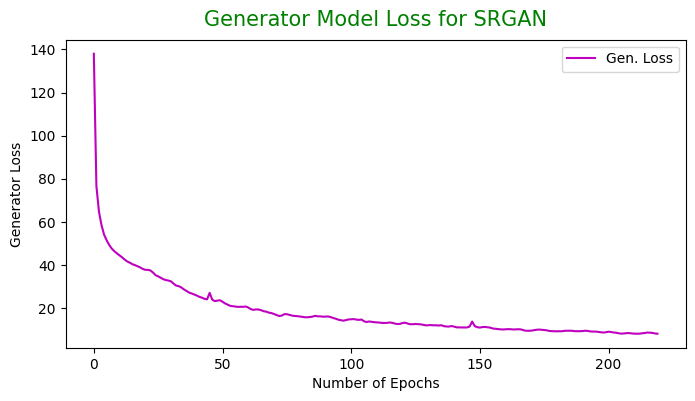

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (8, 4))
plt.plot(ep, gan_loss, c = 'm', label = 'Gen. Loss')
plt.legend()
plt.xlabel('Number of Epochs')
plt.ylabel('Generator Loss')
plt.title("Generator Model Loss for SRGAN", color = 'green', size = 15, pad = 10)
plt.savefig('/content/sample_data/my_plots.png')
plt.show();


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   15616       ['input_1[0][0]']                
                                                                                                  
 p_re_lu (PReLU)                (None, 32, 32, 64)   64          ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 64)   36928       ['p_re_lu[0][0]']                
                                                                                              

PSNR - Peak to Signal Noise Ratio: 17.013
SSIM - Structural Similarity Index: 0.661


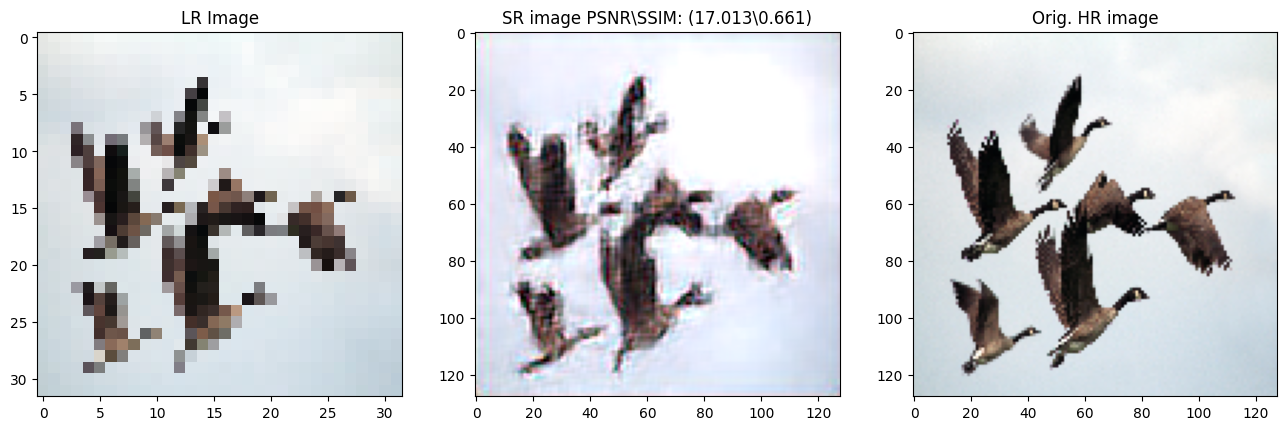

In [ ]:
#Test - perform super resolution using saved generator model
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.utils.vis_utils import plot_model
import tensorflow as tf
def compute_psnr(original_image, generated_image):

    original_image = tf.convert_to_tensor(original_image, dtype = tf.float32)
    generated_image = tf.convert_to_tensor(generated_image, dtype = tf.float32)

    psnr = tf.image.psnr(original_image, generated_image, max_val = 1.0)

    return tf.math.reduce_mean(psnr, axis = None, keepdims = False, name = None)

def compute_ssim(original_image, generated_image):

    original_image = tf.convert_to_tensor(original_image, dtype = tf.float32)
    generated_image = tf.convert_to_tensor(generated_image, dtype = tf.float32)

    ssim = tf.image.ssim(original_image, generated_image, max_val = 1.0, filter_size = 11, filter_sigma = 1.5, k1 = 0.01, )

    return tf.math.reduce_mean(ssim, axis = None, keepdims = False, name = None)

#generator = load_model('gano200.h5', compile=False)
generator = load_model('/content/drive/MyDrive/SRGANs/gane200l099.h5', compile=False)
generator.summary()
"""
img_array = cv2.imread("/content/c.jpg")
img_array = cv2.resize(img_array, (128, 128))
LR_img_array = cv2.resize(img_array,(32, 32))
sreeni_lr = LR_img_array
sreeni_hr = img_array
"""
#--------------------------------------------------------------------#

sreeni_lr = cv2.imread("/content/drive/MyDrive/SRGANs/train_img/LR_img/0896.png")
sreeni_hr = cv2.imread("/content/drive/MyDrive/SRGANs/train_img/HR_img/0896.png")


plot_model(generator, to_file = "/content/sample_data/plot_generator.png", show_shapes = True, show_layer_names = True)

sreeni_lr = cv2.cvtColor(sreeni_lr, cv2.COLOR_BGR2RGB)
sreeni_hr = cv2.cvtColor(sreeni_hr, cv2.COLOR_BGR2RGB)

sreeni_lr = sreeni_lr / 255.
sreeni_hr = sreeni_hr / 255.

sreeni_lr = np.expand_dims(sreeni_lr, axis=0)
sreeni_hr = np.expand_dims(sreeni_hr, axis=0)

generated_sreeni_hr = generator.predict(sreeni_lr)
psnr = "{:.3f}".format(compute_psnr(sreeni_hr, generated_sreeni_hr))
ssim = "{:.3f}".format(compute_ssim(sreeni_hr, generated_sreeni_hr))
print(f"PSNR - Peak to Signal Noise Ratio: {psnr}")

print(f"SSIM - Structural Similarity Index: {ssim}")
plt.figure(figsize=(16, 8))
plt.subplot(131)
plt.title('LR Image')
plt.imshow(sreeni_lr[0,:,:,:])
plt.subplot(132)
plt.title('SR image PSNR\SSIM: ({}\{})'.format(psnr, ssim))
plt.imshow(generated_sreeni_hr[0,:,:,:])
#plt.savefig('SR.png')

plt.subplot(133)
plt.title('Orig. HR image')
plt.imshow(sreeni_hr[0,:,:,:])
plt.savefig('result.png')

plt.show()


In [ ]:
ep = [0,1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 200,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 211,
 212,
 213,
 214,
 215,
 216,
 217,
 218,
 219]

In [ ]:
gan_loss = [138.0308773994446,
 76.52819190025329,
 64.68518295288087,
 58.389884090423585,
 54.01308379173279,
 51.41097402572632,
 49.248275184631346,
 47.57094306945801,
 46.37747540473938,
 45.369074726104735,
 44.46997332572937,
 43.54435133934021,
 42.50254726409912,
 41.62380623817444,
 41.0500226020813,
 40.35456805229187,
 39.93208513259888,
 39.39544911384583,
 38.899452924728394,
 38.170874667167666,
 37.76685903072357,
 37.73541975021362,
 37.467258071899415,
 36.494678139686584,
 35.27275807857514,
 34.72629866600037,
 34.09449679851532,
 33.39356925487518,
 33.0336074590683,
 32.785910439491275,
 32.40616011619568,
 31.32540111541748,
 30.452195119857787,
 30.171865510940552,
 29.572317433357238,
 28.674264335632323,
 27.989592504501342,
 27.21692862510681,
 26.791381788253783,
 26.29940483570099,
 25.834929609298705,
 25.22754578590393,
 24.850338459014893,
 24.307435083389283,
 24.07461247444153,
 27.089405179023743,
 23.934713864326476,
 23.257295060157777,
 23.481742477416994,
 23.632986307144165,
 22.9570214509964,
 22.158607745170592,
 21.60003705024719,
 21.051528644561767,
 20.872289109230042,
 20.646771025657653,
 20.55358257293701,
 20.638380384445192,
 20.59035770893097,
 20.751965260505678,
 20.271665120124815,
 19.517786717414857,
 19.182618188858033,
 19.402189660072327,
 19.352733492851257,
 19.030613338947298,
 18.547807359695433,
 18.365657651424407,
 17.903713822364807,
 17.709258222579955,
 17.24748898744583,
 16.73164494037628,
 16.33845567703247,
 16.52125405073166,
 17.18796298503876,
 17.17860962152481,
 16.8519384264946,
 16.54382017850876,
 16.352064847946167,
 16.26911356449127,
 16.121963500976562,
 15.958236873149872,
 15.748622727394103,
 15.762175977230072,
 15.868823564052581,
 16.07162688970566,
 16.39963915348053,
 16.20408432483673,
 16.176138877868652,
 16.025642251968385,
 16.070583486557005,
 16.12435495853424,
 15.85306167602539,
 15.406317329406738,
 15.083814489841462,
 14.626852536201477,
 14.367050206661224,
 14.17355136871338,
 14.44185836315155,
 14.742892599105835,
 14.825199842453003,
 14.912610399723054,
 14.665605640411377,
 14.539578795433044,
 14.709808802604675,
 13.874572515487671,
 13.563039350509644,
 13.796683740615844,
 13.630303084850311,
 13.473541486263276,
 13.389786636829376,
 13.2779221534729,
 13.136641144752502,
 13.103059530258179,
 13.174579739570618,
 13.332302296161652,
 13.145054996013641,
 12.81815015077591,
 12.60957599878311,
 12.712615466117859,
 13.099772417545319,
 13.229826891422272,
 12.798545134067535,
 12.516609835624696,
 12.521491801738739,
 12.63854569196701,
 12.564870750904083,
 12.45790102481842,
 12.254768431186676,
 11.988850641250611,
 12.082878971099854,
 12.134074199199677,
 12.018739271163941,
 12.037290167808532,
 11.914838480949403,
 12.070084965229034,
 11.625030612945556,
 11.489149904251098,
 11.44096771478653,
 11.683597922325134,
 11.40901951789856,
 11.073537135124207,
 11.048875570297241,
 10.975128483772277,
 11.014106738567353,
 11.033727633953095,
 11.42542394399643,
 13.765282821655273,
 11.631460797786712,
 11.15864884853363,
 10.956911849975587,
 11.209824681282043,
 11.260313379764558,
 11.086996722221375,
 10.943984627723694,
 10.549072170257569,
 10.401613628864288,
 10.21843752861023,
 10.15652937889099,
 10.09187227487564,
 10.173105692863464,
 10.246815633773803,
 10.203851616382599,
 10.073938256502151,
 10.120783394575119,
 10.200014281272889,
 10.106322622299194,
 9.719564986228942,
 9.493752497434617,
 9.485598689317703,
 9.548090600967408,
 9.75400527715683,
 9.954561901092529,
 10.048099374771118,
 9.954574263095855,
 9.838081741333008,
 9.687903583049774,
 9.404100996255874,
 9.32579904794693,
 9.239389485120773,
 9.251492995023728,
 9.271653586626053,
 9.280811989307404,
 9.481584775447846,
 9.510921621322632,
 9.513874429464341,
 9.452096939086914,
 9.285017484426499,
 9.266228413581848,
 9.298554873466491,
 9.363452869653702,
 9.512710416316986,
 9.399938052892685,
 9.166676712036132,
 9.102747142314911,
 9.123496133089066,
 8.943957060575485,
 8.805060523748399,
 8.651369541883469,
 8.813397186994553,
 9.063571804761887,
 8.904286271333694,
 8.683428430557251,
 8.558925819396972,
 8.29969516992569,
 8.163574171066283,
 8.242509824037551,
 8.385974884033203,
 8.424002724885941,
 8.250342512130738,
 8.146780496835708,
 8.117713451385498,
 8.12646609544754,
 8.321033459901809,
 8.427785164117813,
 8.670713013410568,
 8.596801590919494,
 8.519589614868163,
 8.237293130159378,
 8.123225373029708]

In [ ]:
"""[138.0308773994446,
 76.52819190025329,
 64.68518295288087,
 58.389884090423585,
 54.01308379173279,
 51.41097402572632,
 49.248275184631346,
 47.57094306945801,
 46.37747540473938,
 45.369074726104735,
 44.46997332572937,
 43.54435133934021,
 42.50254726409912,
 41.62380623817444,
 41.0500226020813,
 40.35456805229187,
 39.93208513259888,
 39.39544911384583,
 38.899452924728394,
 38.170874667167666,
 37.76685903072357,
 37.73541975021362,
 37.467258071899415,
 36.494678139686584,
 35.27275807857514,
 34.72629866600037,
 34.09449679851532,
 33.39356925487518,
 33.0336074590683,
 32.785910439491275,
 32.40616011619568,
 31.32540111541748,
 30.452195119857787,
 30.171865510940552,
 29.572317433357238,
 28.674264335632323,
 27.989592504501342,
 27.21692862510681,
 26.791381788253783,
 26.29940483570099,
 25.834929609298705,
 25.22754578590393,
 24.850338459014893,
 24.307435083389283,
 24.07461247444153,
 27.089405179023743,
 23.934713864326476,
 23.257295060157777,
 23.481742477416994,
 23.632986307144165,
 22.9570214509964,
 22.158607745170592,
 21.60003705024719,
 21.051528644561767,
 20.872289109230042,
 20.646771025657653,
 20.55358257293701,
 20.638380384445192,
 20.59035770893097,
 20.751965260505678,
 20.271665120124815,
 19.517786717414857,
 19.182618188858033,
 19.402189660072327,
 19.352733492851257,
 19.030613338947298,
 18.547807359695433,
 18.365657651424407,
 17.903713822364807,
 17.709258222579955,
 17.24748898744583,
 16.73164494037628,
 16.33845567703247,
 16.52125405073166,
 17.18796298503876,
 17.17860962152481,
 16.8519384264946,
 16.54382017850876,
 16.352064847946167,
 16.26911356449127,
 16.121963500976562,
 15.958236873149872,
 15.748622727394103,
 15.762175977230072,
 15.868823564052581,
 16.07162688970566,
 16.39963915348053,
 16.20408432483673,
 16.176138877868652,
 16.025642251968385,
 16.070583486557005,
 16.12435495853424,
 15.85306167602539,
 15.406317329406738,
 15.083814489841462,
 14.626852536201477,
 14.367050206661224,
 14.17355136871338,
 14.44185836315155,
 14.742892599105835,
 14.825199842453003,
 14.912610399723054,
 14.665605640411377,
 14.539578795433044,
 14.709808802604675,
 13.874572515487671,
 13.563039350509644,
 13.796683740615844,
 13.630303084850311,
 13.473541486263276,
 13.389786636829376,
 13.2779221534729,
 13.136641144752502,
 13.103059530258179,
 13.174579739570618,
 13.332302296161652,
 13.145054996013641,
 12.81815015077591,
 12.60957599878311,
 12.712615466117859,
 13.099772417545319,
 13.229826891422272,
 12.798545134067535,
 12.516609835624696,
 12.521491801738739,
 12.63854569196701,
 12.564870750904083,
 12.45790102481842,
 12.254768431186676,
 11.988850641250611,
 12.082878971099854,
 12.134074199199677,
 12.018739271163941,
 12.037290167808532,
 11.914838480949403,
 12.070084965229034,
 11.625030612945556,
 11.489149904251098,
 11.44096771478653,
 11.683597922325134,
 11.40901951789856,
 11.073537135124207,
 11.048875570297241,
 10.975128483772277,
 11.014106738567353,
 11.033727633953095,
 11.42542394399643,
 13.765282821655273,
 11.631460797786712,
 11.15864884853363,
 10.956911849975587,
 11.209824681282043,
 11.260313379764558,
 11.086996722221375,
 10.943984627723694,
 10.549072170257569,
 10.401613628864288,
 10.21843752861023,
 10.15652937889099,
 10.09187227487564,
 10.173105692863464,
 10.246815633773803,
 10.203851616382599,
 10.073938256502151,
 10.120783394575119,
 10.200014281272889,
 10.106322622299194,
 9.719564986228942,
 9.493752497434617,
 9.485598689317703,
 9.548090600967408,
 9.75400527715683,
 9.954561901092529,
 10.048099374771118,
 9.954574263095855,
 9.838081741333008,
 9.687903583049774,
 9.404100996255874,
 9.32579904794693,
 9.239389485120773,
 9.251492995023728,
 9.271653586626053,
 9.280811989307404,
 9.481584775447846,
 9.510921621322632,
 9.513874429464341,
 9.452096939086914,
 9.285017484426499,
 9.266228413581848,
 9.298554873466491,
 9.363452869653702,
 9.512710416316986,
 9.399938052892685,
 9.166676712036132,
 9.102747142314911,
 9.123496133089066,
 8.943957060575485,
 8.805060523748399,
 8.651369541883469,
 8.813397186994553,
 9.063571804761887,
 8.904286271333694,
 8.683428430557251,
 8.558925819396972,
 8.29969516992569,
 8.163574171066283,
 8.242509824037551,
 8.385974884033203,
 8.424002724885941,
 8.250342512130738,
 8.146780496835708,
 8.117713451385498,
 8.12646609544754,
 8.321033459901809,
 8.427785164117813,
 8.670713013410568,
 8.596801590919494,
 8.519589614868163,
 8.237293130159378,
 8.123225373029708]"""

'[138.0308773994446,\n 76.52819190025329,\n 64.68518295288087,\n 58.389884090423585,\n 54.01308379173279,\n 51.41097402572632,\n 49.248275184631346,\n 47.57094306945801,\n 46.37747540473938,\n 45.369074726104735,\n 44.46997332572937,\n 43.54435133934021,\n 42.50254726409912,\n 41.62380623817444,\n 41.0500226020813,\n 40.35456805229187,\n 39.93208513259888,\n 39.39544911384583,\n 38.899452924728394,\n 38.170874667167666,\n 37.76685903072357,\n 37.73541975021362,\n 37.467258071899415,\n 36.494678139686584,\n 35.27275807857514,\n 34.72629866600037,\n 34.09449679851532,\n 33.39356925487518,\n 33.0336074590683,\n 32.785910439491275,\n 32.40616011619568,\n 31.32540111541748,\n 30.452195119857787,\n 30.171865510940552,\n 29.572317433357238,\n 28.674264335632323,\n 27.989592504501342,\n 27.21692862510681,\n 26.791381788253783,\n 26.29940483570099,\n 25.834929609298705,\n 25.22754578590393,\n 24.850338459014893,\n 24.307435083389283,\n 24.07461247444153,\n 27.089405179023743,\n 23.9347138643264

In [ ]:
"""
[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 200,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 211,
 212,
 213,
 214,
 215,
 216,
 217,
 218,
 219]
"""

'\n[0,\n 1,\n 2,\n 3,\n 4,\n 5,\n 6,\n 7,\n 8,\n 9,\n 10,\n 11,\n 12,\n 13,\n 14,\n 15,\n 16,\n 17,\n 18,\n 19,\n 20,\n 21,\n 22,\n 23,\n 24,\n 25,\n 26,\n 27,\n 28,\n 29,\n 30,\n 31,\n 32,\n 33,\n 34,\n 35,\n 36,\n 37,\n 38,\n 39,\n 40,\n 41,\n 42,\n 43,\n 44,\n 45,\n 46,\n 47,\n 48,\n 49,\n 50,\n 51,\n 52,\n 53,\n 54,\n 55,\n 56,\n 57,\n 58,\n 59,\n 60,\n 61,\n 62,\n 63,\n 64,\n 65,\n 66,\n 67,\n 68,\n 69,\n 70,\n 71,\n 72,\n 73,\n 74,\n 75,\n 76,\n 77,\n 78,\n 79,\n 80,\n 81,\n 82,\n 83,\n 84,\n 85,\n 86,\n 87,\n 88,\n 89,\n 90,\n 91,\n 92,\n 93,\n 94,\n 95,\n 96,\n 97,\n 98,\n 99,\n 100,\n 101,\n 102,\n 103,\n 104,\n 105,\n 106,\n 107,\n 108,\n 109,\n 110,\n 111,\n 112,\n 113,\n 114,\n 115,\n 116,\n 117,\n 118,\n 119,\n 120,\n 121,\n 122,\n 123,\n 124,\n 125,\n 126,\n 127,\n 128,\n 129,\n 130,\n 131,\n 132,\n 133,\n 134,\n 135,\n 136,\n 137,\n 138,\n 139,\n 140,\n 141,\n 142,\n 143,\n 144,\n 145,\n 146,\n 147,\n 148,\n 149,\n 150,\n 151,\n 152,\n 153,\n 154,\n 155,\n 156,\n 157,\n 

In [ ]:
d = list(discr_loss)

In [ ]:
d

[array([3.17473998, 0.85625   ]),
 array([0.29768272, 0.98125   ]),
 array([0.29549747, 0.98      ]),
 array([1.07669758, 0.94375   ]),
 array([0.05910214, 0.9925    ]),
 array([0.16532731, 0.979375  ]),
 array([0.06004707, 0.9925    ]),
 array([0.03260651, 0.996875  ]),
 array([0.03043429, 0.996875  ]),
 array([2.73347881e-08, 1.00000000e+00]),
 array([2.67288123e-08, 1.00000000e+00]),
 array([2.67105661e-08, 1.00000000e+00]),
 array([2.6689753e-08, 1.0000000e+00]),
 array([2.6666146e-08, 1.0000000e+00]),
 array([2.6641229e-08, 1.0000000e+00]),
 array([4.79798728e-08, 1.00000000e+00]),
 array([9.10304734e-08, 1.00000000e+00]),
 array([8.75195036e-08, 1.00000000e+00]),
 array([4.55216761e-07, 1.00000000e+00]),
 array([1.63258905e-05, 1.00000000e+00]),
 array([2.10401103, 0.61      ]),
 array([0.53490995, 0.745     ]),
 array([0.07456193, 0.98      ]),
 array([0.00572394, 0.998125  ]),
 array([2.80600563e-04, 1.00000000e+00]),
 array([1.68967187e-04, 1.00000000e+00]),
 array([1.04585984

In [ ]:
discri_loss = []
for i in range(len(d)):
  discri_loss.append(d[i][0])
print(discri_loss)

[3.174739979249904, 0.2976827156428761, 0.29549747269601995, 1.0766975802647702, 0.05910214359755787, 0.16532730716638758, 0.06004706955056218, 0.03260651104462664, 0.03043428729705157, 2.7334788105192153e-08, 2.6728812273816705e-08, 2.6710566116546576e-08, 2.6689752967549566e-08, 2.6666146021675417e-08, 2.664122896417615e-08, 4.7979872816610835e-08, 9.103047340781886e-08, 8.751950361362389e-08, 4.5521676051499987e-07, 1.632589051254329e-05, 2.1040110339959623, 0.5349099460541179, 0.0745619289560981, 0.00572394136695859, 0.0002806005632214354, 0.00016896718663359422, 0.00010458598389428537, 7.683739159397777e-05, 0.0002662151982295728, 0.000467789011751527, 7.474878326675786e-05, 4.3541330487982055e-05, 0.0003421634869657143, 2.3372594046867394e-05, 1.9049933311399333e-05, 1.7302456126722897e-05, 1.4205685089777917e-05, 1.2423668289231809e-05, 1.098000507101209e-05, 9.79311946488875e-06, 8.748266028142062e-06, 8.00127394776877e-06, 7.287490786215856e-06, 9.210140465833828e-06, 6.659462

In [ ]:
loss_disc= [ '%.4f' % elem for elem in discri_loss ]
print(loss_disc)

['3.1747', '0.2977', '0.2955', '1.0767', '0.0591', '0.1653', '0.0600', '0.0326', '0.0304', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '2.1040', '0.5349', '0.0746', '0.0057', '0.0003', '0.0002', '0.0001', '0.0001', '0.0003', '0.0005', '0.0001', '0.0000', '0.0003', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '1.7282', '0.4645', '0.1703', '0.0142', '0.0001', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0001', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '1.9048', '1.3177', '0.8111', '0.7665', '0.7259', '0.7154', '0.7165', '0.7113', '0.7087', '0.7087', '0.7055', '0.7119',

In [ ]:
"""
['3.1747', '0.2977', '0.2955', '1.0767', '0.0591', '0.1653', '0.0600', '0.0326', '0.0304', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '2.1040', '0.5349', '0.0746', '0.0057', '0.0003', '0.0002', '0.0001', '0.0001', '0.0003', '0.0005', '0.0001', '0.0000', '0.0003', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '1.7282', '0.4645', '0.1703', '0.0142', '0.0001', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0001', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '1.9048', '1.3177', '0.8111', '0.7665', '0.7259', '0.7154', '0.7165', '0.7113', '0.7087', '0.7087', '0.7055', '0.7119', '0.7086', '0.7018', '0.6994', '0.6918', '0.3354', '0.0925', '0.0465', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.1118', '1.3515', '0.0141', '0.0056', '0.0001', '0.0000', '0.0001', '0.0001', '0.0000', '0.0366', '0.0001', '0.0000', '0.0000', '0.0012', '0.0097', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.3457', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0016', '0.1225', '0.5427', '0.0038', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000']
"""

"\n['3.1747', '0.2977', '0.2955', '1.0767', '0.0591', '0.1653', '0.0600', '0.0326', '0.0304', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '2.1040', '0.5349', '0.0746', '0.0057', '0.0003', '0.0002', '0.0001', '0.0001', '0.0003', '0.0005', '0.0001', '0.0000', '0.0003', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '1.7282', '0.4645', '0.1703', '0.0142', '0.0001', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0001', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '1.9048', '1.3177', '0.8111', '0.7665', '0.7259', '0.7154', '0.7165', '0.7113', '0.7087', '0.7087', '0.7055', '0.711

In [ ]:
"""
[array([3.17473998, 0.85625   ]),
 array([0.29768272, 0.98125   ]),
 array([0.29549747, 0.98      ]),
 array([1.07669758, 0.94375   ]),
 array([0.05910214, 0.9925    ]),
 array([0.16532731, 0.979375  ]),
 array([0.06004707, 0.9925    ]),
 array([0.03260651, 0.996875  ]),
 array([0.03043429, 0.996875  ]),
 array([2.73347881e-08, 1.00000000e+00]),
 array([2.67288123e-08, 1.00000000e+00]),
 array([2.67105661e-08, 1.00000000e+00]),
 array([2.6689753e-08, 1.0000000e+00]),
 array([2.6666146e-08, 1.0000000e+00]),
 array([2.6641229e-08, 1.0000000e+00]),
 array([4.79798728e-08, 1.00000000e+00]),
 array([9.10304734e-08, 1.00000000e+00]),
 array([8.75195036e-08, 1.00000000e+00]),
 array([4.55216761e-07, 1.00000000e+00]),
 array([1.63258905e-05, 1.00000000e+00]),
 array([2.10401103, 0.61      ]),
 array([0.53490995, 0.745     ]),
 array([0.07456193, 0.98      ]),
 array([0.00572394, 0.998125  ]),
 array([2.80600563e-04, 1.00000000e+00]),
 array([1.68967187e-04, 1.00000000e+00]),
 array([1.04585984e-04, 1.00000000e+00]),
 array([7.68373916e-05, 1.00000000e+00]),
 array([2.66215198e-04, 1.00000000e+00]),
 array([4.67789012e-04, 1.00000000e+00]),
 array([7.47487833e-05, 1.00000000e+00]),
 array([4.35413305e-05, 1.00000000e+00]),
 array([3.42163487e-04, 1.00000000e+00]),
 array([2.3372594e-05, 1.0000000e+00]),
 array([1.90499333e-05, 1.00000000e+00]),
 array([1.73024561e-05, 1.00000000e+00]),
 array([1.42056851e-05, 1.00000000e+00]),
 array([1.24236683e-05, 1.00000000e+00]),
 array([1.09800051e-05, 1.00000000e+00]),
 array([9.79311946e-06, 1.00000000e+00]),
 array([8.74826603e-06, 1.00000000e+00]),
 array([8.00127395e-06, 1.00000000e+00]),
 array([7.28749079e-06, 1.00000000e+00]),
 array([9.21014047e-06, 1.00000000e+00]),
 array([6.65946294e-06, 1.00000000e+00]),
 array([1.7281896, 0.6275   ]),
 array([0.46448636, 0.85      ]),
 array([0.1703392, 0.945    ]),
 array([0.01423748, 0.994375  ]),
 array([6.41633824e-05, 1.00000000e+00]),
 array([2.16931969e-05, 1.00000000e+00]),
 array([1.71248605e-05, 1.00000000e+00]),
 array([1.44072897e-05, 1.00000000e+00]),
 array([1.35018346e-05, 1.00000000e+00]),
 array([1.21999411e-05, 1.00000000e+00]),
 array([1.00524248e-05, 1.00000000e+00]),
 array([6.84427529e-05, 1.00000000e+00]),
 array([1.86162703e-05, 1.00000000e+00]),
 array([1.37590828e-05, 1.00000000e+00]),
 array([1.10365117e-05, 1.00000000e+00]),
 array([9.23205632e-06, 1.00000000e+00]),
 array([7.93948191e-06, 1.00000000e+00]),
 array([6.92695704e-06, 1.00000000e+00]),
 array([6.11125909e-06, 1.00000000e+00]),
 array([5.44203992e-06, 1.00000000e+00]),
 array([4.87151905e-06, 1.00000000e+00]),
 array([4.37995017e-06, 1.00000000e+00]),
 array([3.95491447e-06, 1.00000000e+00]),
 array([3.58235771e-06, 1.00000000e+00]),
 array([3.300344e-06, 1.000000e+00]),
 array([2.97586186e-06, 1.00000000e+00]),
 array([2.70486809e-06, 1.00000000e+00]),
 array([3.65279128e-06, 1.00000000e+00]),
 array([4.62865294e-06, 1.00000000e+00]),
 array([2.5209337e-06, 1.0000000e+00]),
 array([5.22750735e-06, 1.00000000e+00]),
 array([2.6025467e-06, 1.0000000e+00]),
 array([2.24014799e-06, 1.00000000e+00]),
 array([1.96124005e-06, 1.00000000e+00]),
 array([1.73089938e-06, 1.00000000e+00]),
 array([1.60063393e-06, 1.00000000e+00]),
 array([1.38723979e-06, 1.00000000e+00]),
 array([1.24326538e-06, 1.00000000e+00]),
 array([1.11813036e-06, 1.00000000e+00]),
 array([1.01044031e-06, 1.00000000e+00]),
 array([9.43141415e-07, 1.00000000e+00]),
 array([8.71316038e-07, 1.00000000e+00]),
 array([7.64145258e-07, 1.00000000e+00]),
 array([1.90476336, 0.83      ]),
 array([1.31773446, 0.4225    ]),
 array([0.81109285, 0.455625  ]),
 array([0.76648955, 0.448125  ]),
 array([0.72593649, 0.415625  ]),
 array([0.71542014, 0.44125   ]),
 array([0.71652329, 0.42      ]),
 array([0.71127804, 0.438125  ]),
 array([0.70867408, 0.445     ]),
 array([0.70874297, 0.464375  ]),
 array([0.70554777, 0.485625  ]),
 array([0.71189632, 0.5       ]),
 array([0.70858829, 0.48125   ]),
 array([0.70181606, 0.523125  ]),
 array([0.69942721, 0.540625  ]),
 array([0.69181725, 0.563125  ]),
 array([0.33535074, 0.884375  ]),
 array([0.09249304, 0.98      ]),
 array([0.04648142, 0.994375  ]),
 array([2.29384457e-05, 1.00000000e+00]),
 array([1.88427851e-05, 1.00000000e+00]),
 array([1.59356819e-05, 1.00000000e+00]),
 array([2.08180468e-05, 1.00000000e+00]),
 array([1.2441073e-05, 1.0000000e+00]),
 array([1.06979077e-05, 1.00000000e+00]),
 array([9.23387634e-06, 1.00000000e+00]),
 array([8.08413024e-06, 1.00000000e+00]),
 array([7.10131875e-06, 1.00000000e+00]),
 array([6.30558469e-06, 1.00000000e+00]),
 array([5.57022358e-06, 1.00000000e+00]),
 array([4.95613443e-06, 1.00000000e+00]),
 array([0.11179886, 0.983125  ]),
 array([1.35152449, 0.825625  ]),
 array([0.01414293, 0.9975    ]),
 array([0.00562522, 0.999375  ]),
 array([5.83065509e-05, 1.00000000e+00]),
 array([3.8375189e-05, 1.0000000e+00]),
 array([8.13309348e-05, 1.00000000e+00]),
 array([5.53491001e-05, 1.00000000e+00]),
 array([2.82554088e-05, 1.00000000e+00]),
 array([0.03658123, 0.9925    ]),
 array([7.33710682e-05, 1.00000000e+00]),
 array([9.35593021e-06, 1.00000000e+00]),
 array([8.78322796e-06, 1.00000000e+00]),
 array([0.00124289, 0.999375  ]),
 array([0.00969545, 0.99875   ]),
 array([6.41584392e-09, 1.00000000e+00]),
 array([6.41463949e-09, 1.00000000e+00]),
 array([2.28314476e-08, 1.00000000e+00]),
 array([8.10370263e-09, 1.00000000e+00]),
 array([6.41566267e-09, 1.00000000e+00]),
 array([0.34573391, 0.964375  ]),
 array([2.79154502e-09, 1.00000000e+00]),
 array([2.79107585e-09, 1.00000000e+00]),
 array([2.80227261e-09, 1.00000000e+00]),
 array([2.78789529e-09, 1.00000000e+00]),
 array([2.78599755e-09, 1.00000000e+00]),
 array([0.00161 , 0.999375]),
 array([0.12248414, 0.99      ]),
 array([0.54266457, 0.976875  ]),
 array([0.00378735, 0.999375  ]),
 array([8.876434e-16, 1.000000e+00]),
 array([8.87643172e-16, 1.00000000e+00]),
 array([8.87643172e-16, 1.00000000e+00]),
 array([8.87643172e-16, 1.00000000e+00]),
 array([8.87643172e-16, 1.00000000e+00]),
 array([8.87643172e-16, 1.00000000e+00]),
 array([8.87643172e-16, 1.00000000e+00]),
 array([8.87643172e-16, 1.00000000e+00]),
 array([8.87643172e-16, 1.00000000e+00]),
 array([8.87643172e-16, 1.00000000e+00]),
 array([8.87643172e-16, 1.00000000e+00]),
 array([8.87643172e-16, 1.00000000e+00]),
 array([8.87643172e-16, 1.00000000e+00]),
 array([8.87643172e-16, 1.00000000e+00]),
 array([8.87643172e-16, 1.00000000e+00]),
 array([8.87643172e-16, 1.00000000e+00]),
 array([8.87643172e-16, 1.00000000e+00]),
 array([8.87643172e-16, 1.00000000e+00]),
 array([8.87643172e-16, 1.00000000e+00]),
 array([8.87643172e-16, 1.00000000e+00]),
 array([8.87643172e-16, 1.00000000e+00]),
 array([8.87643172e-16, 1.00000000e+00]),
 array([8.87643172e-16, 1.00000000e+00]),
 array([8.87643172e-16, 1.00000000e+00]),
 array([8.87643172e-16, 1.00000000e+00]),
 array([8.87643172e-16, 1.00000000e+00]),
 array([8.87643172e-16, 1.00000000e+00]),
 array([8.87643172e-16, 1.00000000e+00]),
 array([1.36960702e-14, 1.00000000e+00]),
 array([8.87643172e-16, 1.00000000e+00]),
 array([8.87643172e-16, 1.00000000e+00]),
 array([8.87643172e-16, 1.00000000e+00]),
 array([8.87643172e-16, 1.00000000e+00]),
 array([8.87643172e-16, 1.00000000e+00]),
 array([8.87643172e-16, 1.00000000e+00]),
 array([8.87643172e-16, 1.00000000e+00]),
 array([8.87643172e-16, 1.00000000e+00]),
 array([8.87643172e-16, 1.00000000e+00]),
 array([8.87643172e-16, 1.00000000e+00]),
 array([8.87643172e-16, 1.00000000e+00]),
 array([8.92254378e-16, 1.00000000e+00]),
 array([8.87643172e-16, 1.00000000e+00]),
 array([8.87643172e-16, 1.00000000e+00]),
 array([8.87643172e-16, 1.00000000e+00]),
 array([8.87643172e-16, 1.00000000e+00]),
 array([8.87643172e-16, 1.00000000e+00]),
 array([8.87643172e-16, 1.00000000e+00]),
 array([8.87643172e-16, 1.00000000e+00]),
 array([8.87643172e-16, 1.00000000e+00]),
 array([8.87643172e-16, 1.00000000e+00]),
 array([8.87643174e-16, 1.00000000e+00]),
 array([8.87643172e-16, 1.00000000e+00]),
 array([8.87643172e-16, 1.00000000e+00]),
 array([8.87643172e-16, 1.00000000e+00]),
 array([8.87643172e-16, 1.00000000e+00]),
 array([2.26698832e-12, 1.00000000e+00]),
 array([8.87643219e-16, 1.00000000e+00]),
 array([8.87643219e-16, 1.00000000e+00]),
 array([8.87643219e-16, 1.00000000e+00]),
 array([8.87643219e-16, 1.00000000e+00]),
 array([8.87643219e-16, 1.00000000e+00]),
 array([8.87643219e-16, 1.00000000e+00]),
 array([8.87643219e-16, 1.00000000e+00]),
 array([8.87643219e-16, 1.00000000e+00]),
 array([8.87643219e-16, 1.00000000e+00]),
 array([8.87643219e-16, 1.00000000e+00]),
 array([9.06197201e-16, 1.00000000e+00]),
 array([8.87643219e-16, 1.00000000e+00]),
 array([8.87643219e-16, 1.00000000e+00]),
 array([8.1139434e-13, 1.0000000e+00]),
 array([8.87643152e-16, 1.00000000e+00])]
 """